# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "8"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_HG00369_5_M_120131_1"
fastq_file_base = "ERR188260"

notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, f"{fastq_file_base}_1.fastq.gz"), os.path.join(fastqs_dir, f"{fastq_file_base}_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
if "variant_count" in fp_df.columns and "vcrs_count" not in fp_df.columns:
    fp_df = fp_df.rename(columns={"variant_count": "vcrs_count"})
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000348462:c.394G>A', 'ENST00000390237:c.249G>C', 'ENST00000344450:c.557C>T', 'ENST00000390294:c.230G>A', 'ENST00000189444:c.901T>C', 'ENST00000455950:c.760A>G', 'ENST00000353801:c.1529G>C', 'ENST00000295809:c.862C>T', 'ENST00000369975:c.625C>T', 'ENST00000013034:c.541C>T', 'ENST00000308595:c.1115C>T', 'ENST00000301072:c.400T>C', 'ENST00000483158:c.202A>C', 'ENST00000595281:c.765G>A', 'ENST00000259569:c.3026A>G', 'ENST00000336301:c.2497G>A', 'ENST00000337304:c.1388T>A', 'ENST00000391857:c.438C>T', 'ENST00000390243:c.261A>G', 'ENST00000236067:c.362C>T', 'ENST00000608106:c.494A>C', 'ENST00000184266:c.395T>G', 'ENST00000361723:c.287C>T', 'ENST00000579721:c.72G>A', 'ENST00000479981:c.242C>T', 'ENST00000200453:c.868A>G', 'ENST00000391857:c.211C>G', 'ENST00000342045:c.621G>A', 'ENST00000216268:c.2123A>G', 'ENST00000350028:c.1138T>C', 'ENST00000304043:c.610C>T', 'ENST00000225567:c.400A>G', 'ENST00000324238:c.1291T>C', 'ENST00000608255:c.1214A>G', 'ENST00000304921:c.251G>A', 'ENST000002

vcrs_count          variant_header_cds            variant_header  \
index                                                                      
175135      1206.0   ENST00000390319.2:c.66G>A  ENST00000390319:c.118G>A   
58568       1179.0  ENST00000579721.1:c.142G>A  ENST00000579721:c.142G>A   
59340       1083.0  ENST00000343139.5:c.318C>T  ENST00000343139:c.420C>T   
128124       793.0  ENST00000604412.1:c.320C>T  ENST00000604412:c.399C>T   
175165       504.0  ENST00000390319.2:c.209G>A  ENST00000390319:c.261G>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
175135  ENST00000390319  ENSG00000211673      4431.0       0.0  
58568   ENST00000579721             None         NaN       0.0  
59340   ENST00000343139  ENSG00000196735     13633.0       0.0  
128124  ENST00000604412             None         NaN       0.0  
175165  ENST00000390319  ENSG00000211673      4431.0       0.0

### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

vcrs_count          variant_header_cds            variant_header  \
index                                                                      
175135      1206.0   ENST00000390319.2:c.66G>A  ENST00000390319:c.118G>A   
58568       1179.0  ENST00000579721.1:c.142G>A  ENST00000579721:c.142G>A   
59340       1083.0  ENST00000343139.5:c.318C>T  ENST00000343139:c.420C>T   
128124       793.0  ENST00000604412.1:c.320C>T  ENST00000604412:c.399C>T   
175165       504.0  ENST00000390319.2:c.209G>A  ENST00000390319:c.261G>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
175135  ENST00000390319  ENSG00000211673      4431.0       0.0  
58568   ENST00000579721             None         NaN       0.0  
59340   ENST00000343139  ENSG00000196735     13633.0       0.0  
128124  ENST00000604412             None         NaN       0.0  
175165  ENST00000390319  ENSG00000211673      4431.0       0.0

From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:44:32: Entering the loop


  0%|                                                                                                                             | 0/684 [00:00<?, ?it/s]

  0%|▏                                                                                                                    | 1/684 [00:01<15:45,  1.38s/it]

  0%|▎                                                                                                                    | 2/684 [00:02<16:06,  1.42s/it]

  0%|▌                                                                                                                    | 3/684 [00:03<12:26,  1.10s/it]

  1%|▋                                                                                                                    | 4/684 [00:04<13:51,  1.22s/it]

  1%|▊                                                                                                                    | 5/684 [00:05<12:47,  1.13s/it]

  1%|█                                                                                                                    | 6/684 [00:06<10:38,  1.06it/s]

  1%|█▏                                                                                                                   | 7/684 [00:07<12:23,  1.10s/it]

  1%|█▎                                                                                                                   | 8/684 [00:08<11:33,  1.03s/it]

  1%|█▌                                                                                                                   | 9/684 [00:09<10:58,  1.03it/s]

  1%|█▋                                                                                                                  | 10/684 [00:10<09:41,  1.16it/s]

  2%|█▊                                                                                                                  | 11/684 [00:10<08:48,  1.27it/s]

  2%|██                                                                                                                  | 12/684 [00:11<09:42,  1.15it/s]

  2%|██▏                                                                                                                 | 13/684 [00:12<08:48,  1.27it/s]

  2%|██▎                                                                                                                 | 14/684 [00:13<10:31,  1.06it/s]

  2%|██▌                                                                                                                 | 15/684 [00:15<12:04,  1.08s/it]

  2%|██▋                                                                                                                 | 16/684 [00:16<12:33,  1.13s/it]

  2%|██▉                                                                                                                 | 17/684 [00:17<11:00,  1.01it/s]

  3%|███                                                                                                                 | 18/684 [00:18<11:53,  1.07s/it]

  3%|███▏                                                                                                                | 19/684 [00:19<10:44,  1.03it/s]

  3%|███▍                                                                                                                | 20/684 [00:19<09:36,  1.15it/s]

  3%|███▌                                                                                                                | 21/684 [00:20<08:53,  1.24it/s]

  3%|███▋                                                                                                                | 22/684 [00:21<09:08,  1.21it/s]

  3%|███▉                                                                                                                | 23/684 [00:21<08:20,  1.32it/s]

  4%|████                                                                                                                | 24/684 [00:22<07:56,  1.39it/s]

  4%|████▏                                                                                                               | 25/684 [00:23<07:46,  1.41it/s]

  4%|████▍                                                                                                               | 26/684 [00:24<08:15,  1.33it/s]

  4%|████▌                                                                                                               | 27/684 [00:24<07:54,  1.38it/s]

  4%|████▋                                                                                                               | 28/684 [00:25<07:53,  1.38it/s]

  4%|████▉                                                                                                               | 29/684 [00:26<07:43,  1.41it/s]

  4%|█████                                                                                                               | 30/684 [00:27<08:40,  1.26it/s]

  5%|█████▎                                                                                                              | 31/684 [00:28<10:44,  1.01it/s]

  5%|█████▍                                                                                                              | 32/684 [00:29<11:46,  1.08s/it]

  5%|█████▌                                                                                                              | 33/684 [00:31<12:19,  1.14s/it]

  5%|█████▊                                                                                                              | 34/684 [00:31<11:10,  1.03s/it]

  5%|█████▉                                                                                                              | 35/684 [00:32<09:57,  1.09it/s]

  5%|██████                                                                                                              | 36/684 [00:33<09:42,  1.11it/s]

  5%|██████▎                                                                                                             | 37/684 [00:34<09:39,  1.12it/s]

  6%|██████▍                                                                                                             | 38/684 [00:35<09:33,  1.13it/s]

  6%|██████▌                                                                                                             | 39/684 [00:36<09:46,  1.10it/s]

  6%|██████▊                                                                                                             | 40/684 [00:37<10:37,  1.01it/s]

  6%|██████▉                                                                                                             | 41/684 [00:38<09:42,  1.10it/s]

  6%|███████                                                                                                             | 42/684 [00:38<09:07,  1.17it/s]

  6%|███████▎                                                                                                            | 43/684 [00:39<08:31,  1.25it/s]

  6%|███████▍                                                                                                            | 44/684 [00:40<08:04,  1.32it/s]

  7%|███████▋                                                                                                            | 45/684 [00:40<07:37,  1.40it/s]

  7%|███████▊                                                                                                            | 46/684 [00:41<07:15,  1.46it/s]

  7%|███████▉                                                                                                            | 47/684 [00:42<07:47,  1.36it/s]

  7%|████████▏                                                                                                           | 48/684 [00:42<07:25,  1.43it/s]

  7%|████████▎                                                                                                           | 49/684 [00:43<08:13,  1.29it/s]

  7%|████████▍                                                                                                           | 50/684 [00:44<07:55,  1.33it/s]

  7%|████████▋                                                                                                           | 51/684 [00:45<07:39,  1.38it/s]

  8%|████████▊                                                                                                           | 52/684 [00:45<07:32,  1.40it/s]

  8%|████████▉                                                                                                           | 53/684 [00:46<07:22,  1.43it/s]

  8%|█████████▏                                                                                                          | 54/684 [00:47<07:07,  1.47it/s]

  8%|█████████▎                                                                                                          | 55/684 [00:47<07:05,  1.48it/s]

  8%|█████████▍                                                                                                          | 56/684 [00:49<09:00,  1.16it/s]

  8%|█████████▋                                                                                                          | 57/684 [00:49<08:23,  1.25it/s]

  8%|█████████▊                                                                                                          | 58/684 [00:50<07:52,  1.32it/s]

  9%|██████████                                                                                                          | 59/684 [00:51<07:32,  1.38it/s]

  9%|██████████▏                                                                                                         | 60/684 [00:51<07:49,  1.33it/s]

  9%|██████████▎                                                                                                         | 61/684 [00:53<09:28,  1.10it/s]

  9%|██████████▌                                                                                                         | 62/684 [00:53<08:45,  1.18it/s]

  9%|██████████▋                                                                                                         | 63/684 [00:54<08:06,  1.28it/s]

  9%|██████████▊                                                                                                         | 64/684 [00:55<07:54,  1.31it/s]

 10%|███████████                                                                                                         | 65/684 [00:56<08:14,  1.25it/s]

 10%|███████████▏                                                                                                        | 66/684 [00:57<10:15,  1.00it/s]

 10%|███████████▎                                                                                                        | 67/684 [00:58<08:59,  1.14it/s]

 10%|███████████▌                                                                                                        | 68/684 [00:59<10:19,  1.01s/it]

 10%|███████████▋                                                                                                        | 69/684 [01:00<10:57,  1.07s/it]

 10%|███████████▊                                                                                                        | 70/684 [01:01<11:41,  1.14s/it]

 10%|████████████                                                                                                        | 71/684 [01:02<10:12,  1.00it/s]

 11%|████████████▏                                                                                                       | 72/684 [01:03<09:47,  1.04it/s]

 11%|████████████▍                                                                                                       | 73/684 [01:04<08:55,  1.14it/s]

 11%|████████████▌                                                                                                       | 74/684 [01:04<07:59,  1.27it/s]

 11%|████████████▋                                                                                                       | 75/684 [01:06<12:04,  1.19s/it]

 11%|████████████▉                                                                                                       | 76/684 [01:07<10:28,  1.03s/it]

 11%|█████████████                                                                                                       | 77/684 [01:08<09:19,  1.09it/s]

 11%|█████████████▏                                                                                                      | 78/684 [01:08<08:28,  1.19it/s]

 12%|█████████████▍                                                                                                      | 79/684 [01:09<08:01,  1.26it/s]

 12%|█████████████▌                                                                                                      | 80/684 [01:10<08:02,  1.25it/s]

 12%|█████████████▋                                                                                                      | 81/684 [01:11<08:15,  1.22it/s]

 12%|█████████████▉                                                                                                      | 82/684 [01:11<07:52,  1.27it/s]

 12%|██████████████                                                                                                      | 83/684 [01:12<07:30,  1.33it/s]

 12%|██████████████▏                                                                                                     | 84/684 [01:13<07:32,  1.33it/s]

 12%|██████████████▍                                                                                                     | 85/684 [01:14<07:22,  1.35it/s]

 13%|██████████████▌                                                                                                     | 86/684 [01:14<06:58,  1.43it/s]

 13%|██████████████▊                                                                                                     | 87/684 [01:15<06:49,  1.46it/s]

 13%|██████████████▉                                                                                                     | 88/684 [01:15<06:34,  1.51it/s]

 13%|███████████████                                                                                                     | 89/684 [01:16<06:54,  1.43it/s]

 13%|███████████████▎                                                                                                    | 90/684 [01:17<06:44,  1.47it/s]

 13%|███████████████▍                                                                                                    | 91/684 [01:17<06:36,  1.50it/s]

 13%|███████████████▌                                                                                                    | 92/684 [01:18<06:59,  1.41it/s]

 14%|███████████████▊                                                                                                    | 93/684 [01:20<08:41,  1.13it/s]

 14%|███████████████▉                                                                                                    | 94/684 [01:20<07:59,  1.23it/s]

 14%|████████████████                                                                                                    | 95/684 [01:21<07:59,  1.23it/s]

 14%|████████████████▎                                                                                                   | 96/684 [01:22<07:39,  1.28it/s]

 14%|████████████████▍                                                                                                   | 97/684 [01:22<07:12,  1.36it/s]

 14%|████████████████▌                                                                                                   | 98/684 [01:23<06:56,  1.41it/s]

 14%|████████████████▊                                                                                                   | 99/684 [01:24<06:36,  1.47it/s]

 15%|████████████████▊                                                                                                  | 100/684 [01:25<08:37,  1.13it/s]

 15%|████████████████▉                                                                                                  | 101/684 [01:26<07:59,  1.21it/s]

 15%|█████████████████▏                                                                                                 | 102/684 [01:26<07:23,  1.31it/s]

 15%|█████████████████▍                                                                                                 | 104/684 [01:27<05:37,  1.72it/s]

 15%|█████████████████▋                                                                                                 | 105/684 [01:28<06:03,  1.59it/s]

 15%|█████████████████▊                                                                                                 | 106/684 [01:28<06:06,  1.58it/s]

 16%|█████████████████▉                                                                                                 | 107/684 [01:30<08:01,  1.20it/s]

 16%|██████████████████▏                                                                                                | 108/684 [01:30<07:32,  1.27it/s]

 16%|██████████████████▎                                                                                                | 109/684 [01:32<08:49,  1.08it/s]

 16%|██████████████████▍                                                                                                | 110/684 [01:33<08:47,  1.09it/s]

 16%|██████████████████▋                                                                                                | 111/684 [01:33<08:05,  1.18it/s]

 16%|██████████████████▊                                                                                                | 112/684 [01:34<07:22,  1.29it/s]

 17%|██████████████████▉                                                                                                | 113/684 [01:35<06:55,  1.37it/s]

 17%|███████████████████▏                                                                                               | 114/684 [01:35<06:37,  1.43it/s]

 17%|███████████████████▎                                                                                               | 115/684 [01:36<06:24,  1.48it/s]

 17%|███████████████████▌                                                                                               | 116/684 [01:37<07:15,  1.31it/s]

 17%|███████████████████▋                                                                                               | 117/684 [01:37<07:06,  1.33it/s]

 17%|███████████████████▊                                                                                               | 118/684 [01:38<06:53,  1.37it/s]

 17%|████████████████████                                                                                               | 119/684 [01:39<06:55,  1.36it/s]

 18%|████████████████████▏                                                                                              | 120/684 [01:40<06:38,  1.42it/s]

 18%|████████████████████▎                                                                                              | 121/684 [01:40<06:26,  1.46it/s]

 18%|████████████████████▌                                                                                              | 122/684 [01:41<06:09,  1.52it/s]

 18%|████████████████████▋                                                                                              | 123/684 [01:41<06:08,  1.52it/s]

 18%|████████████████████▊                                                                                              | 124/684 [01:42<06:17,  1.48it/s]

 18%|█████████████████████                                                                                              | 125/684 [01:43<06:13,  1.50it/s]

 18%|█████████████████████▏                                                                                             | 126/684 [01:43<06:11,  1.50it/s]

 19%|█████████████████████▎                                                                                             | 127/684 [01:45<08:31,  1.09it/s]

 19%|█████████████████████▌                                                                                             | 128/684 [01:46<08:02,  1.15it/s]

 19%|█████████████████████▋                                                                                             | 129/684 [01:46<07:19,  1.26it/s]

 19%|█████████████████████▊                                                                                             | 130/684 [01:47<07:11,  1.28it/s]

 19%|██████████████████████                                                                                             | 131/684 [01:48<06:48,  1.35it/s]

 19%|██████████████████████▏                                                                                            | 132/684 [01:48<06:33,  1.40it/s]

 19%|██████████████████████▎                                                                                            | 133/684 [01:49<06:24,  1.43it/s]

 20%|██████████████████████▌                                                                                            | 134/684 [01:50<06:04,  1.51it/s]

 20%|██████████████████████▋                                                                                            | 135/684 [01:51<06:38,  1.38it/s]

 20%|██████████████████████▊                                                                                            | 136/684 [01:52<08:45,  1.04it/s]

 20%|███████████████████████                                                                                            | 137/684 [01:53<07:56,  1.15it/s]

 20%|███████████████████████▏                                                                                           | 138/684 [01:53<07:21,  1.24it/s]

 20%|███████████████████████▎                                                                                           | 139/684 [01:54<07:52,  1.15it/s]

 20%|███████████████████████▌                                                                                           | 140/684 [01:55<07:10,  1.26it/s]

 21%|███████████████████████▋                                                                                           | 141/684 [01:56<06:45,  1.34it/s]

 21%|███████████████████████▊                                                                                           | 142/684 [01:56<06:21,  1.42it/s]

 21%|████████████████████████                                                                                           | 143/684 [01:57<06:07,  1.47it/s]

 21%|████████████████████████▏                                                                                          | 144/684 [01:58<07:47,  1.15it/s]

 21%|████████████████████████▍                                                                                          | 145/684 [01:59<07:08,  1.26it/s]

 21%|████████████████████████▌                                                                                          | 146/684 [02:00<07:10,  1.25it/s]

 21%|████████████████████████▋                                                                                          | 147/684 [02:00<07:13,  1.24it/s]

 22%|████████████████████████▉                                                                                          | 148/684 [02:01<06:56,  1.29it/s]

 22%|█████████████████████████                                                                                          | 149/684 [02:02<07:00,  1.27it/s]

 22%|█████████████████████████▏                                                                                         | 150/684 [02:03<08:29,  1.05it/s]

 22%|█████████████████████████▍                                                                                         | 151/684 [02:04<07:41,  1.16it/s]

 22%|█████████████████████████▌                                                                                         | 152/684 [02:05<07:44,  1.15it/s]

 22%|█████████████████████████▋                                                                                         | 153/684 [02:05<07:03,  1.25it/s]

 23%|█████████████████████████▉                                                                                         | 154/684 [02:06<06:26,  1.37it/s]

 23%|██████████████████████████                                                                                         | 155/684 [02:07<06:50,  1.29it/s]

 23%|██████████████████████████▏                                                                                        | 156/684 [02:08<06:42,  1.31it/s]

 23%|██████████████████████████▍                                                                                        | 157/684 [02:08<06:20,  1.38it/s]

 23%|██████████████████████████▌                                                                                        | 158/684 [02:09<07:01,  1.25it/s]

 23%|██████████████████████████▋                                                                                        | 159/684 [02:10<06:38,  1.32it/s]

 23%|██████████████████████████▉                                                                                        | 160/684 [02:10<06:13,  1.40it/s]

 24%|███████████████████████████                                                                                        | 161/684 [02:11<05:52,  1.49it/s]

 24%|███████████████████████████▏                                                                                       | 162/684 [02:12<06:04,  1.43it/s]

 24%|███████████████████████████▍                                                                                       | 163/684 [02:12<05:55,  1.47it/s]

 24%|███████████████████████████▌                                                                                       | 164/684 [02:13<05:42,  1.52it/s]

 24%|███████████████████████████▋                                                                                       | 165/684 [02:14<05:42,  1.51it/s]

 24%|███████████████████████████▉                                                                                       | 166/684 [02:14<05:39,  1.52it/s]

 24%|████████████████████████████                                                                                       | 167/684 [02:16<07:24,  1.16it/s]

 25%|████████████████████████████▏                                                                                      | 168/684 [02:17<08:29,  1.01it/s]

 25%|████████████████████████████▍                                                                                      | 169/684 [02:18<07:33,  1.13it/s]

 25%|████████████████████████████▌                                                                                      | 170/684 [02:18<06:55,  1.24it/s]

 25%|████████████████████████████▊                                                                                      | 171/684 [02:19<06:31,  1.31it/s]

 25%|████████████████████████████▉                                                                                      | 172/684 [02:20<06:15,  1.36it/s]

 25%|█████████████████████████████                                                                                      | 173/684 [02:20<06:35,  1.29it/s]

 25%|█████████████████████████████▎                                                                                     | 174/684 [02:21<06:19,  1.34it/s]

 26%|█████████████████████████████▍                                                                                     | 175/684 [02:22<06:23,  1.33it/s]

 26%|█████████████████████████████▌                                                                                     | 176/684 [02:23<07:57,  1.06it/s]

 26%|█████████████████████████████▊                                                                                     | 177/684 [02:24<07:05,  1.19it/s]

 26%|█████████████████████████████▉                                                                                     | 178/684 [02:25<06:34,  1.28it/s]

 26%|██████████████████████████████                                                                                     | 179/684 [02:25<06:05,  1.38it/s]

 26%|██████████████████████████████▎                                                                                    | 180/684 [02:26<05:47,  1.45it/s]

 26%|██████████████████████████████▍                                                                                    | 181/684 [02:26<05:37,  1.49it/s]

 27%|██████████████████████████████▌                                                                                    | 182/684 [02:27<05:37,  1.49it/s]

 27%|██████████████████████████████▊                                                                                    | 183/684 [02:28<05:24,  1.54it/s]

 27%|██████████████████████████████▉                                                                                    | 184/684 [02:28<05:29,  1.52it/s]

 27%|███████████████████████████████                                                                                    | 185/684 [02:29<05:51,  1.42it/s]

 27%|███████████████████████████████▎                                                                                   | 186/684 [02:30<06:03,  1.37it/s]

 27%|███████████████████████████████▍                                                                                   | 187/684 [02:31<07:21,  1.13it/s]

 27%|███████████████████████████████▌                                                                                   | 188/684 [02:32<06:37,  1.25it/s]

 28%|███████████████████████████████▊                                                                                   | 189/684 [02:33<06:38,  1.24it/s]

 28%|███████████████████████████████▉                                                                                   | 190/684 [02:33<06:18,  1.30it/s]

 28%|████████████████████████████████                                                                                   | 191/684 [02:34<05:58,  1.38it/s]

 28%|████████████████████████████████▎                                                                                  | 192/684 [02:35<05:52,  1.39it/s]

 28%|████████████████████████████████▍                                                                                  | 193/684 [02:35<05:38,  1.45it/s]

 28%|████████████████████████████████▌                                                                                  | 194/684 [02:36<05:37,  1.45it/s]

 29%|████████████████████████████████▊                                                                                  | 195/684 [02:37<07:21,  1.11it/s]

 29%|████████████████████████████████▉                                                                                  | 196/684 [02:38<06:42,  1.21it/s]

 29%|█████████████████████████████████                                                                                  | 197/684 [02:39<06:10,  1.31it/s]

 29%|█████████████████████████████████▎                                                                                 | 198/684 [02:39<06:13,  1.30it/s]

 29%|█████████████████████████████████▍                                                                                 | 199/684 [02:40<05:49,  1.39it/s]

 29%|█████████████████████████████████▋                                                                                 | 200/684 [02:41<07:21,  1.10it/s]

 29%|█████████████████████████████████▊                                                                                 | 201/684 [02:43<08:21,  1.04s/it]

 30%|█████████████████████████████████▉                                                                                 | 202/684 [02:43<07:24,  1.08it/s]

 30%|██████████████████████████████████▏                                                                                | 203/684 [02:45<08:33,  1.07s/it]

 30%|██████████████████████████████████▎                                                                                | 204/684 [02:46<08:55,  1.12s/it]

 30%|██████████████████████████████████▍                                                                                | 205/684 [02:47<07:44,  1.03it/s]

 30%|██████████████████████████████████▋                                                                                | 206/684 [02:47<06:58,  1.14it/s]

 30%|██████████████████████████████████▊                                                                                | 207/684 [02:49<08:12,  1.03s/it]

 30%|██████████████████████████████████▉                                                                                | 208/684 [02:50<09:02,  1.14s/it]

 31%|███████████████████████████████████▏                                                                               | 209/684 [02:51<07:43,  1.02it/s]

 31%|███████████████████████████████████▎                                                                               | 210/684 [02:51<07:00,  1.13it/s]

 31%|███████████████████████████████████▍                                                                               | 211/684 [02:52<06:26,  1.22it/s]

 31%|███████████████████████████████████▋                                                                               | 212/684 [02:53<05:58,  1.32it/s]

 31%|███████████████████████████████████▊                                                                               | 213/684 [02:53<05:38,  1.39it/s]

 31%|███████████████████████████████████▉                                                                               | 214/684 [02:55<07:09,  1.09it/s]

 31%|████████████████████████████████████▏                                                                              | 215/684 [02:56<08:15,  1.06s/it]

 32%|████████████████████████████████████▎                                                                              | 216/684 [02:57<07:15,  1.07it/s]

 32%|████████████████████████████████████▍                                                                              | 217/684 [02:57<06:31,  1.19it/s]

 32%|████████████████████████████████████▋                                                                              | 218/684 [02:58<05:56,  1.31it/s]

 32%|████████████████████████████████████▊                                                                              | 219/684 [02:58<05:31,  1.40it/s]

 32%|████████████████████████████████████▉                                                                              | 220/684 [02:59<05:44,  1.35it/s]

 32%|█████████████████████████████████████▏                                                                             | 221/684 [03:00<05:26,  1.42it/s]

 32%|█████████████████████████████████████▎                                                                             | 222/684 [03:00<05:11,  1.48it/s]

 33%|█████████████████████████████████████▍                                                                             | 223/684 [03:01<05:34,  1.38it/s]

 33%|█████████████████████████████████████▋                                                                             | 224/684 [03:02<05:20,  1.43it/s]

 33%|█████████████████████████████████████▊                                                                             | 225/684 [03:03<05:12,  1.47it/s]

 33%|█████████████████████████████████████▉                                                                             | 226/684 [03:03<05:17,  1.44it/s]

 33%|██████████████████████████████████████▏                                                                            | 227/684 [03:04<05:12,  1.46it/s]

 33%|██████████████████████████████████████▎                                                                            | 228/684 [03:05<06:31,  1.16it/s]

 33%|██████████████████████████████████████▌                                                                            | 229/684 [03:06<07:31,  1.01it/s]

 34%|██████████████████████████████████████▋                                                                            | 230/684 [03:07<06:41,  1.13it/s]

 34%|██████████████████████████████████████▊                                                                            | 231/684 [03:08<06:17,  1.20it/s]

 34%|███████████████████████████████████████                                                                            | 232/684 [03:09<06:17,  1.20it/s]

 34%|███████████████████████████████████████▏                                                                           | 233/684 [03:09<05:45,  1.31it/s]

 34%|███████████████████████████████████████▎                                                                           | 234/684 [03:10<05:17,  1.42it/s]

 34%|███████████████████████████████████████▌                                                                           | 235/684 [03:11<05:11,  1.44it/s]

 35%|███████████████████████████████████████▋                                                                           | 236/684 [03:11<05:04,  1.47it/s]

 35%|███████████████████████████████████████▊                                                                           | 237/684 [03:12<04:54,  1.52it/s]

 35%|████████████████████████████████████████                                                                           | 238/684 [03:13<05:05,  1.46it/s]

 35%|████████████████████████████████████████▏                                                                          | 239/684 [03:13<04:55,  1.50it/s]

 35%|████████████████████████████████████████▎                                                                          | 240/684 [03:14<05:38,  1.31it/s]

 35%|████████████████████████████████████████▌                                                                          | 241/684 [03:15<05:22,  1.37it/s]

 35%|████████████████████████████████████████▋                                                                          | 242/684 [03:16<06:33,  1.12it/s]

 36%|████████████████████████████████████████▊                                                                          | 243/684 [03:17<06:00,  1.22it/s]

 36%|█████████████████████████████████████████                                                                          | 244/684 [03:17<05:30,  1.33it/s]

 36%|█████████████████████████████████████████▏                                                                         | 245/684 [03:19<06:32,  1.12it/s]

 36%|█████████████████████████████████████████▎                                                                         | 246/684 [03:19<05:49,  1.25it/s]

 36%|█████████████████████████████████████████▌                                                                         | 247/684 [03:20<05:37,  1.29it/s]

 36%|█████████████████████████████████████████▋                                                                         | 248/684 [03:20<05:11,  1.40it/s]

 36%|█████████████████████████████████████████▊                                                                         | 249/684 [03:22<06:20,  1.14it/s]

 37%|██████████████████████████████████████████                                                                         | 250/684 [03:22<05:44,  1.26it/s]

 37%|██████████████████████████████████████████▏                                                                        | 251/684 [03:23<05:16,  1.37it/s]

 37%|██████████████████████████████████████████▎                                                                        | 252/684 [03:23<05:03,  1.42it/s]

 37%|██████████████████████████████████████████▌                                                                        | 253/684 [03:24<04:57,  1.45it/s]

 37%|██████████████████████████████████████████▋                                                                        | 254/684 [03:25<04:48,  1.49it/s]

 37%|██████████████████████████████████████████▊                                                                        | 255/684 [03:25<04:41,  1.52it/s]

 37%|███████████████████████████████████████████                                                                        | 256/684 [03:26<04:35,  1.56it/s]

 38%|███████████████████████████████████████████▏                                                                       | 257/684 [03:27<04:41,  1.52it/s]

 38%|███████████████████████████████████████████▍                                                                       | 258/684 [03:27<04:35,  1.55it/s]

 38%|███████████████████████████████████████████▌                                                                       | 259/684 [03:28<04:32,  1.56it/s]

 38%|███████████████████████████████████████████▋                                                                       | 260/684 [03:29<05:57,  1.19it/s]

 38%|███████████████████████████████████████████▉                                                                       | 261/684 [03:30<05:29,  1.28it/s]

 38%|████████████████████████████████████████████                                                                       | 262/684 [03:31<05:24,  1.30it/s]

 38%|████████████████████████████████████████████▏                                                                      | 263/684 [03:31<05:11,  1.35it/s]

 39%|████████████████████████████████████████████▍                                                                      | 264/684 [03:33<06:18,  1.11it/s]

 39%|████████████████████████████████████████████▌                                                                      | 265/684 [03:34<07:11,  1.03s/it]

 39%|████████████████████████████████████████████▋                                                                      | 266/684 [03:35<06:21,  1.09it/s]

 39%|████████████████████████████████████████████▉                                                                      | 267/684 [03:35<05:53,  1.18it/s]

 39%|█████████████████████████████████████████████                                                                      | 268/684 [03:36<05:29,  1.26it/s]

 39%|█████████████████████████████████████████████▏                                                                     | 269/684 [03:36<05:01,  1.37it/s]

 39%|█████████████████████████████████████████████▍                                                                     | 270/684 [03:37<04:48,  1.44it/s]

 40%|█████████████████████████████████████████████▌                                                                     | 271/684 [03:38<06:04,  1.13it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 272/684 [03:40<06:48,  1.01it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 273/684 [03:41<07:22,  1.08s/it]

 40%|██████████████████████████████████████████████                                                                     | 274/684 [03:42<06:32,  1.04it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 275/684 [03:42<05:45,  1.18it/s]

 40%|██████████████████████████████████████████████▍                                                                    | 276/684 [03:43<05:32,  1.23it/s]

 40%|██████████████████████████████████████████████▌                                                                    | 277/684 [03:44<06:57,  1.03s/it]

 41%|██████████████████████████████████████████████▋                                                                    | 278/684 [03:46<07:31,  1.11s/it]

 41%|██████████████████████████████████████████████▉                                                                    | 279/684 [03:47<07:04,  1.05s/it]

 41%|███████████████████████████████████████████████                                                                    | 280/684 [03:47<06:15,  1.07it/s]

 41%|███████████████████████████████████████████████▏                                                                   | 281/684 [03:48<05:38,  1.19it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 282/684 [03:49<05:09,  1.30it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 283/684 [03:49<04:47,  1.39it/s]

 42%|███████████████████████████████████████████████▋                                                                   | 284/684 [03:50<04:39,  1.43it/s]

 42%|███████████████████████████████████████████████▉                                                                   | 285/684 [03:50<04:25,  1.50it/s]

 42%|████████████████████████████████████████████████                                                                   | 286/684 [03:51<04:41,  1.42it/s]

 42%|████████████████████████████████████████████████▎                                                                  | 287/684 [03:52<04:28,  1.48it/s]

 42%|████████████████████████████████████████████████▍                                                                  | 288/684 [03:52<04:19,  1.52it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 289/684 [03:54<05:34,  1.18it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 290/684 [03:54<05:07,  1.28it/s]

 43%|████████████████████████████████████████████████▉                                                                  | 291/684 [03:55<05:13,  1.25it/s]

 43%|█████████████████████████████████████████████████                                                                  | 292/684 [03:56<05:17,  1.24it/s]

 43%|█████████████████████████████████████████████████▎                                                                 | 293/684 [03:57<05:18,  1.23it/s]

 43%|█████████████████████████████████████████████████▍                                                                 | 294/684 [03:57<04:59,  1.30it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 295/684 [03:58<04:38,  1.39it/s]

 43%|█████████████████████████████████████████████████▊                                                                 | 296/684 [03:59<04:26,  1.46it/s]

 43%|█████████████████████████████████████████████████▉                                                                 | 297/684 [03:59<04:25,  1.46it/s]

 44%|██████████████████████████████████████████████████                                                                 | 298/684 [04:00<04:21,  1.48it/s]

 44%|██████████████████████████████████████████████████▎                                                                | 299/684 [04:01<04:20,  1.48it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 300/684 [04:01<04:13,  1.51it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 301/684 [04:02<04:12,  1.51it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 302/684 [04:03<04:07,  1.54it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 303/684 [04:03<04:04,  1.56it/s]

 44%|███████████████████████████████████████████████████                                                                | 304/684 [04:04<04:01,  1.57it/s]

 45%|███████████████████████████████████████████████████▎                                                               | 305/684 [04:05<04:02,  1.56it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 306/684 [04:05<04:11,  1.50it/s]

 45%|███████████████████████████████████████████████████▌                                                               | 307/684 [04:06<04:25,  1.42it/s]

 45%|███████████████████████████████████████████████████▊                                                               | 308/684 [04:07<04:15,  1.47it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 309/684 [04:07<04:19,  1.44it/s]

 45%|████████████████████████████████████████████████████                                                               | 310/684 [04:08<04:24,  1.41it/s]

 45%|████████████████████████████████████████████████████▎                                                              | 311/684 [04:09<04:21,  1.43it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 312/684 [04:10<05:39,  1.09it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 313/684 [04:11<05:11,  1.19it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 314/684 [04:12<04:47,  1.29it/s]

 46%|████████████████████████████████████████████████████▉                                                              | 315/684 [04:12<04:40,  1.31it/s]

 46%|█████████████████████████████████████████████████████▏                                                             | 316/684 [04:13<04:26,  1.38it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 317/684 [04:13<04:10,  1.47it/s]

 46%|█████████████████████████████████████████████████████▍                                                             | 318/684 [04:14<04:18,  1.41it/s]

 47%|█████████████████████████████████████████████████████▋                                                             | 319/684 [04:15<04:10,  1.46it/s]

 47%|█████████████████████████████████████████████████████▊                                                             | 320/684 [04:16<04:03,  1.50it/s]

 47%|█████████████████████████████████████████████████████▉                                                             | 321/684 [04:16<04:31,  1.34it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 322/684 [04:17<04:21,  1.39it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 323/684 [04:18<04:43,  1.28it/s]

 47%|██████████████████████████████████████████████████████▍                                                            | 324/684 [04:19<04:24,  1.36it/s]

 48%|██████████████████████████████████████████████████████▋                                                            | 325/684 [04:19<04:09,  1.44it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 326/684 [04:20<04:05,  1.46it/s]

 48%|██████████████████████████████████████████████████████▉                                                            | 327/684 [04:21<03:58,  1.50it/s]

 48%|███████████████████████████████████████████████████████▏                                                           | 328/684 [04:21<03:50,  1.54it/s]

 48%|███████████████████████████████████████████████████████▎                                                           | 329/684 [04:22<04:07,  1.44it/s]

 48%|███████████████████████████████████████████████████████▍                                                           | 330/684 [04:23<03:55,  1.50it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 331/684 [04:23<03:57,  1.49it/s]

 49%|███████████████████████████████████████████████████████▊                                                           | 332/684 [04:24<03:47,  1.55it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 333/684 [04:24<03:43,  1.57it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 334/684 [04:25<03:52,  1.50it/s]

 49%|████████████████████████████████████████████████████████▎                                                          | 335/684 [04:26<03:44,  1.56it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 336/684 [04:26<03:42,  1.56it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 337/684 [04:27<03:37,  1.60it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 338/684 [04:28<03:34,  1.61it/s]

 50%|████████████████████████████████████████████████████████▉                                                          | 339/684 [04:28<03:41,  1.56it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 340/684 [04:29<03:40,  1.56it/s]

 50%|█████████████████████████████████████████████████████████▎                                                         | 341/684 [04:30<03:35,  1.59it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 342/684 [04:30<03:33,  1.60it/s]

 50%|█████████████████████████████████████████████████████████▋                                                         | 343/684 [04:31<03:33,  1.60it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 344/684 [04:31<03:30,  1.62it/s]

 50%|██████████████████████████████████████████████████████████                                                         | 345/684 [04:32<03:36,  1.56it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 346/684 [04:33<03:36,  1.56it/s]

 51%|██████████████████████████████████████████████████████████▎                                                        | 347/684 [04:34<03:55,  1.43it/s]

 51%|██████████████████████████████████████████████████████████▌                                                        | 348/684 [04:34<03:49,  1.47it/s]

 51%|██████████████████████████████████████████████████████████▋                                                        | 349/684 [04:35<03:37,  1.54it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 350/684 [04:35<03:39,  1.52it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 351/684 [04:36<03:51,  1.44it/s]

 51%|███████████████████████████████████████████████████████████▏                                                       | 352/684 [04:37<03:43,  1.49it/s]

 52%|███████████████████████████████████████████████████████████▎                                                       | 353/684 [04:37<03:34,  1.55it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 354/684 [04:38<03:29,  1.58it/s]

 52%|███████████████████████████████████████████████████████████▋                                                       | 355/684 [04:39<03:25,  1.60it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 356/684 [04:39<03:29,  1.56it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 357/684 [04:40<03:48,  1.43it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 358/684 [04:41<03:37,  1.50it/s]

 52%|████████████████████████████████████████████████████████████▎                                                      | 359/684 [04:42<03:52,  1.40it/s]

 53%|████████████████████████████████████████████████████████████▌                                                      | 360/684 [04:42<04:07,  1.31it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 361/684 [04:43<04:13,  1.27it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 362/684 [04:44<03:52,  1.38it/s]

 53%|█████████████████████████████████████████████████████████████                                                      | 363/684 [04:44<03:37,  1.47it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 364/684 [04:45<03:31,  1.51it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                     | 365/684 [04:46<03:24,  1.56it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 366/684 [04:46<03:19,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 367/684 [04:47<03:18,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 368/684 [04:47<03:17,  1.60it/s]

 54%|██████████████████████████████████████████████████████████████                                                     | 369/684 [04:48<03:17,  1.60it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 370/684 [04:49<03:16,  1.59it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 371/684 [04:49<03:14,  1.61it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 372/684 [04:50<03:18,  1.57it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                    | 373/684 [04:51<03:13,  1.61it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 374/684 [04:51<03:15,  1.59it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 375/684 [04:52<03:14,  1.59it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 376/684 [04:53<03:17,  1.56it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 377/684 [04:53<03:32,  1.44it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 378/684 [04:54<03:27,  1.47it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 379/684 [04:55<03:22,  1.51it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 380/684 [04:55<03:20,  1.51it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 381/684 [04:56<03:50,  1.32it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 382/684 [04:57<03:40,  1.37it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 383/684 [04:58<03:32,  1.42it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 384/684 [04:58<03:23,  1.47it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 385/684 [04:59<03:18,  1.51it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 386/684 [04:59<03:09,  1.57it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 387/684 [05:00<03:08,  1.57it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 388/684 [05:01<03:29,  1.41it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 389/684 [05:02<03:23,  1.45it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                 | 390/684 [05:02<03:13,  1.52it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 391/684 [05:03<03:24,  1.43it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 392/684 [05:04<03:13,  1.51it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 393/684 [05:04<03:18,  1.47it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 394/684 [05:05<03:08,  1.54it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 395/684 [05:05<03:02,  1.58it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 396/684 [05:06<03:08,  1.53it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 397/684 [05:07<03:09,  1.51it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 398/684 [05:07<03:08,  1.52it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 399/684 [05:08<03:03,  1.56it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                               | 400/684 [05:09<03:01,  1.57it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 401/684 [05:09<02:58,  1.58it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 402/684 [05:10<02:56,  1.60it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 403/684 [05:11<02:53,  1.62it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 404/684 [05:11<02:54,  1.60it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 405/684 [05:12<02:55,  1.59it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 406/684 [05:12<02:53,  1.60it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                              | 407/684 [05:13<02:49,  1.63it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 408/684 [05:14<02:48,  1.64it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 409/684 [05:14<02:51,  1.61it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 410/684 [05:15<02:55,  1.56it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 411/684 [05:16<02:53,  1.57it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 412/684 [05:16<02:53,  1.57it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 413/684 [05:17<02:49,  1.60it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                             | 414/684 [05:17<02:50,  1.59it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 415/684 [05:18<02:47,  1.61it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 416/684 [05:19<03:43,  1.20it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 417/684 [05:20<03:56,  1.13it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 418/684 [05:21<03:33,  1.25it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 419/684 [05:22<03:21,  1.31it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 420/684 [05:22<03:08,  1.40it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 421/684 [05:23<02:57,  1.48it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 422/684 [05:23<02:50,  1.54it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 423/684 [05:24<02:46,  1.57it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                           | 424/684 [05:25<02:44,  1.59it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 425/684 [05:26<03:02,  1.42it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 426/684 [05:26<03:02,  1.41it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 427/684 [05:27<02:53,  1.48it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 428/684 [05:27<02:50,  1.50it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 429/684 [05:28<03:04,  1.38it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 430/684 [05:29<03:02,  1.39it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 431/684 [05:30<02:53,  1.46it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 432/684 [05:30<02:48,  1.50it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 433/684 [05:31<02:44,  1.53it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 434/684 [05:32<02:40,  1.56it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 435/684 [05:32<02:41,  1.55it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 436/684 [05:33<02:36,  1.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 437/684 [05:34<02:49,  1.46it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 438/684 [05:34<02:43,  1.50it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 439/684 [05:35<02:46,  1.47it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 440/684 [05:36<02:40,  1.52it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                        | 441/684 [05:36<02:40,  1.52it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 442/684 [05:37<02:37,  1.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 443/684 [05:37<02:36,  1.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 444/684 [05:38<02:36,  1.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 445/684 [05:39<02:32,  1.57it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 446/684 [05:39<02:29,  1.59it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 447/684 [05:40<02:27,  1.61it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 448/684 [05:41<02:23,  1.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 449/684 [05:42<03:04,  1.27it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 450/684 [05:42<02:54,  1.34it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 451/684 [05:43<02:53,  1.34it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 452/684 [05:44<02:45,  1.40it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 453/684 [05:44<02:37,  1.47it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 454/684 [05:45<02:34,  1.49it/s]

 67%|████████████████████████████████████████████████████████████████████████████▍                                      | 455/684 [05:46<02:50,  1.34it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 456/684 [05:47<03:00,  1.26it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 457/684 [05:47<02:47,  1.36it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 458/684 [05:48<02:41,  1.40it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 459/684 [05:49<02:35,  1.45it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 460/684 [05:49<02:29,  1.49it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 461/684 [05:50<02:26,  1.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 462/684 [05:51<02:37,  1.41it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 463/684 [05:51<02:33,  1.44it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 464/684 [05:52<02:40,  1.37it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 465/684 [05:53<02:34,  1.42it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 466/684 [05:54<02:30,  1.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 467/684 [05:54<02:27,  1.47it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 468/684 [05:55<02:25,  1.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 469/684 [05:56<02:21,  1.52it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 470/684 [05:56<02:20,  1.52it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 471/684 [05:57<02:15,  1.58it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 472/684 [05:57<02:11,  1.61it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 473/684 [05:58<02:11,  1.60it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 474/684 [05:59<02:09,  1.62it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 475/684 [05:59<02:10,  1.60it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 476/684 [06:00<02:09,  1.61it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 477/684 [06:00<02:11,  1.58it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 478/684 [06:01<02:20,  1.46it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 479/684 [06:03<02:54,  1.17it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 480/684 [06:03<02:40,  1.27it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 481/684 [06:04<03:09,  1.07it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████                                  | 482/684 [06:05<02:51,  1.18it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 483/684 [06:06<02:34,  1.30it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 484/684 [06:06<02:24,  1.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 485/684 [06:07<02:17,  1.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 486/684 [06:08<02:14,  1.48it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 487/684 [06:08<02:09,  1.52it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                 | 488/684 [06:09<02:07,  1.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 489/684 [06:09<02:05,  1.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 490/684 [06:10<02:03,  1.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 491/684 [06:11<02:08,  1.50it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 492/684 [06:11<02:05,  1.53it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 493/684 [06:12<02:15,  1.41it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 494/684 [06:13<02:08,  1.47it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 495/684 [06:14<02:06,  1.49it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 496/684 [06:15<02:38,  1.18it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 497/684 [06:15<02:26,  1.28it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 498/684 [06:16<02:16,  1.36it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 499/684 [06:18<03:02,  1.01it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 500/684 [06:18<02:42,  1.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 501/684 [06:19<02:26,  1.25it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                              | 502/684 [06:19<02:16,  1.33it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 503/684 [06:20<02:17,  1.31it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 504/684 [06:21<02:10,  1.38it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 505/684 [06:22<02:02,  1.46it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 506/684 [06:22<02:00,  1.48it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 507/684 [06:23<01:57,  1.50it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                             | 509/684 [06:24<01:41,  1.72it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 510/684 [06:24<01:46,  1.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 511/684 [06:25<01:45,  1.64it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 512/684 [06:26<01:43,  1.66it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 513/684 [06:26<01:43,  1.64it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 514/684 [06:27<01:46,  1.59it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 515/684 [06:28<01:45,  1.60it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 516/684 [06:28<01:45,  1.59it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 517/684 [06:29<01:43,  1.62it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 518/684 [06:30<02:05,  1.32it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 519/684 [06:30<01:55,  1.42it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 520/684 [06:31<01:51,  1.48it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 521/684 [06:32<01:47,  1.51it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 522/684 [06:32<01:48,  1.49it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 523/684 [06:33<01:43,  1.56it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 524/684 [06:34<01:41,  1.57it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/684 [06:34<01:43,  1.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 526/684 [06:35<01:49,  1.44it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 527/684 [06:36<01:43,  1.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 528/684 [06:37<01:53,  1.37it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 529/684 [06:37<01:46,  1.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 530/684 [06:38<01:41,  1.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 531/684 [06:38<01:39,  1.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 532/684 [06:39<01:37,  1.57it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 533/684 [06:40<01:36,  1.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 534/684 [06:40<01:36,  1.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 535/684 [06:41<01:32,  1.61it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 536/684 [06:41<01:30,  1.63it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 537/684 [06:42<01:34,  1.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 538/684 [06:43<01:31,  1.59it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 539/684 [06:43<01:31,  1.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 540/684 [06:44<01:31,  1.57it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 541/684 [06:45<01:29,  1.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 542/684 [06:45<01:37,  1.46it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                       | 543/684 [06:46<01:33,  1.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 544/684 [06:47<01:30,  1.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 545/684 [06:47<01:28,  1.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 546/684 [06:48<01:28,  1.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 547/684 [06:49<01:28,  1.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 548/684 [06:49<01:26,  1.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 549/684 [06:50<01:25,  1.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 550/684 [06:51<01:32,  1.44it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 551/684 [06:51<01:28,  1.50it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 552/684 [06:52<01:41,  1.30it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 553/684 [06:53<01:36,  1.35it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 554/684 [06:54<01:30,  1.44it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 555/684 [06:55<01:43,  1.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 556/684 [06:56<01:55,  1.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 557/684 [06:56<01:45,  1.20it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 558/684 [06:57<01:42,  1.23it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 559/684 [06:58<01:32,  1.35it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 560/684 [06:58<01:30,  1.38it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 561/684 [06:59<01:26,  1.42it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 562/684 [07:00<01:24,  1.44it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 563/684 [07:00<01:22,  1.48it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 564/684 [07:01<01:18,  1.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 565/684 [07:02<01:16,  1.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 566/684 [07:03<01:39,  1.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 567/684 [07:04<01:31,  1.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 568/684 [07:05<01:53,  1.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 569/684 [07:06<01:40,  1.14it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 570/684 [07:07<01:54,  1.00s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 571/684 [07:08<02:01,  1.07s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 572/684 [07:10<02:09,  1.16s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 573/684 [07:10<01:53,  1.02s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 574/684 [07:11<01:38,  1.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 575/684 [07:12<01:34,  1.15it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 576/684 [07:12<01:27,  1.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 577/684 [07:13<01:21,  1.32it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 578/684 [07:14<01:17,  1.37it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 579/684 [07:14<01:14,  1.41it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 580/684 [07:15<01:10,  1.47it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 581/684 [07:15<01:07,  1.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 582/684 [07:16<01:09,  1.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 583/684 [07:17<01:06,  1.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 584/684 [07:18<01:07,  1.47it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 585/684 [07:18<01:06,  1.49it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 586/684 [07:19<01:06,  1.48it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 587/684 [07:20<01:05,  1.49it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 588/684 [07:20<01:02,  1.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 589/684 [07:21<01:00,  1.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 590/684 [07:21<01:00,  1.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 591/684 [07:22<01:10,  1.32it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 592/684 [07:23<01:17,  1.19it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 593/684 [07:24<01:09,  1.31it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 594/684 [07:25<01:11,  1.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 595/684 [07:25<01:05,  1.36it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 596/684 [07:27<01:20,  1.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 597/684 [07:28<01:14,  1.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 598/684 [07:28<01:10,  1.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 599/684 [07:29<01:03,  1.34it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 600/684 [07:30<01:00,  1.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 601/684 [07:30<00:59,  1.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 602/684 [07:31<01:01,  1.33it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 603/684 [07:32<00:58,  1.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 604/684 [07:32<00:54,  1.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 605/684 [07:33<00:58,  1.36it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 606/684 [07:34<00:54,  1.43it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 607/684 [07:34<00:51,  1.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 608/684 [07:35<00:50,  1.49it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 609/684 [07:36<00:50,  1.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 610/684 [07:36<00:49,  1.48it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 611/684 [07:37<00:47,  1.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 612/684 [07:38<00:46,  1.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 613/684 [07:38<00:45,  1.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 614/684 [07:39<00:47,  1.48it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 615/684 [07:40<00:45,  1.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 616/684 [07:40<00:43,  1.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 617/684 [07:41<00:42,  1.57it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 618/684 [07:41<00:42,  1.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 619/684 [07:42<00:41,  1.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 620/684 [07:43<00:45,  1.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 621/684 [07:44<00:44,  1.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 622/684 [07:44<00:42,  1.44it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 623/684 [07:45<00:41,  1.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 624/684 [07:46<00:39,  1.52it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 625/684 [07:46<00:38,  1.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 626/684 [07:47<00:37,  1.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 627/684 [07:48<00:48,  1.18it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 628/684 [07:49<00:43,  1.27it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 629/684 [07:50<00:43,  1.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 630/684 [07:50<00:41,  1.30it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 631/684 [07:51<00:42,  1.26it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 632/684 [07:52<00:38,  1.36it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 633/684 [07:53<00:38,  1.34it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 634/684 [07:54<00:43,  1.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 635/684 [07:54<00:38,  1.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 636/684 [07:55<00:35,  1.35it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 637/684 [07:56<00:32,  1.43it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 638/684 [07:56<00:31,  1.47it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 639/684 [07:57<00:34,  1.31it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 640/684 [07:58<00:31,  1.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 641/684 [07:58<00:29,  1.45it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 642/684 [07:59<00:29,  1.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 643/684 [08:00<00:29,  1.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 644/684 [08:00<00:26,  1.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 645/684 [08:01<00:25,  1.51it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 646/684 [08:02<00:27,  1.38it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 647/684 [08:03<00:26,  1.42it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 648/684 [08:03<00:24,  1.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 649/684 [08:04<00:25,  1.38it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 650/684 [08:05<00:24,  1.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 651/684 [08:05<00:23,  1.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 652/684 [08:06<00:22,  1.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 653/684 [08:07<00:21,  1.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 654/684 [08:08<00:26,  1.13it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 655/684 [08:09<00:23,  1.23it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 656/684 [08:10<00:26,  1.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 657/684 [08:11<00:24,  1.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 658/684 [08:11<00:21,  1.24it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 659/684 [08:12<00:18,  1.35it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 660/684 [08:13<00:16,  1.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 661/684 [08:13<00:15,  1.50it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 662/684 [08:14<00:15,  1.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 663/684 [08:15<00:14,  1.48it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 664/684 [08:15<00:13,  1.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 665/684 [08:16<00:12,  1.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 666/684 [08:17<00:11,  1.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 667/684 [08:17<00:10,  1.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 668/684 [08:18<00:10,  1.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 669/684 [08:18<00:09,  1.52it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 670/684 [08:19<00:09,  1.50it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 671/684 [08:21<00:11,  1.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 672/684 [08:21<00:09,  1.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 673/684 [08:22<00:08,  1.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 674/684 [08:22<00:07,  1.39it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 675/684 [08:23<00:06,  1.43it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 676/684 [08:24<00:05,  1.49it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 677/684 [08:24<00:04,  1.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 678/684 [08:25<00:04,  1.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 679/684 [08:26<00:03,  1.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 680/684 [08:26<00:02,  1.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 681/684 [08:27<00:01,  1.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 682/684 [08:28<00:01,  1.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 683/684 [08:28<00:00,  1.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 684/684 [08:29<00:00,  1.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 684/684 [08:29<00:00,  1.34it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 387
Number of false variants: 294
Number of undetermined variants: 1
True variants list: ['ENST00000390319:c.118G>A', 'ENST00000579721:c.142G>A', 'ENST00000343139:c.420C>T', 'ENST00000604412:c.399C>T', 'ENST00000390319:c.261G>A', 'ENST00000390319:c.347A>C', 'ENST00000604930:c.303G>T', 'ENST00000390243:c.387A>G', 'ENST00000390243:c.326T>C', 'ENST00000483158:c.202A>C', 'ENST00000390319:c.197A>G', 'ENST00000390314:c.246G>C', 'ENST00000390243:c.333C>T', 'ENST00000603600:c.285G>A', 'ENST00000603210:c.188T>G', 'ENST00000604045:c.177C>T', 'ENST00000390305:c.298A>T', 'ENST00000604930:c.149G>C', 'ENST00000390294:c.230G>A', 'ENST00000483158:c.195A>G', 'ENST00000390277:c.387G>A', 'ENST00000390243:c.320G>A', 'ENST00000390297:c.199G>A', 'ENST00000390299:c.203G>A', 'ENST00000390319:c.204C>T', 'ENST00000390237:c.67C>T', 'ENST00000390237:c.249G>C', 'ENST00000479981:c.138A>G', 'ENST00000390312:c.310A>G', 'ENST00000603423:c.158A>C', 'ENST00000603423:c.137G>A', 'ENST00000390237:c

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/detailed_out_modified_bam.txt


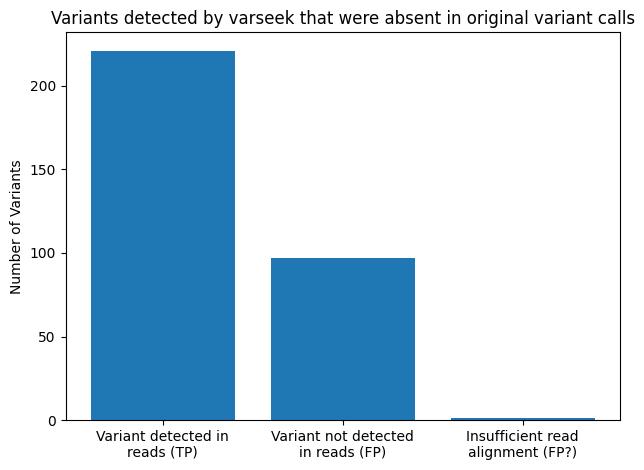

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None, title = None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    if title:
        plt.title(title)
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"), title = 'Variants detected by varseek that were absent in original variant calls')

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

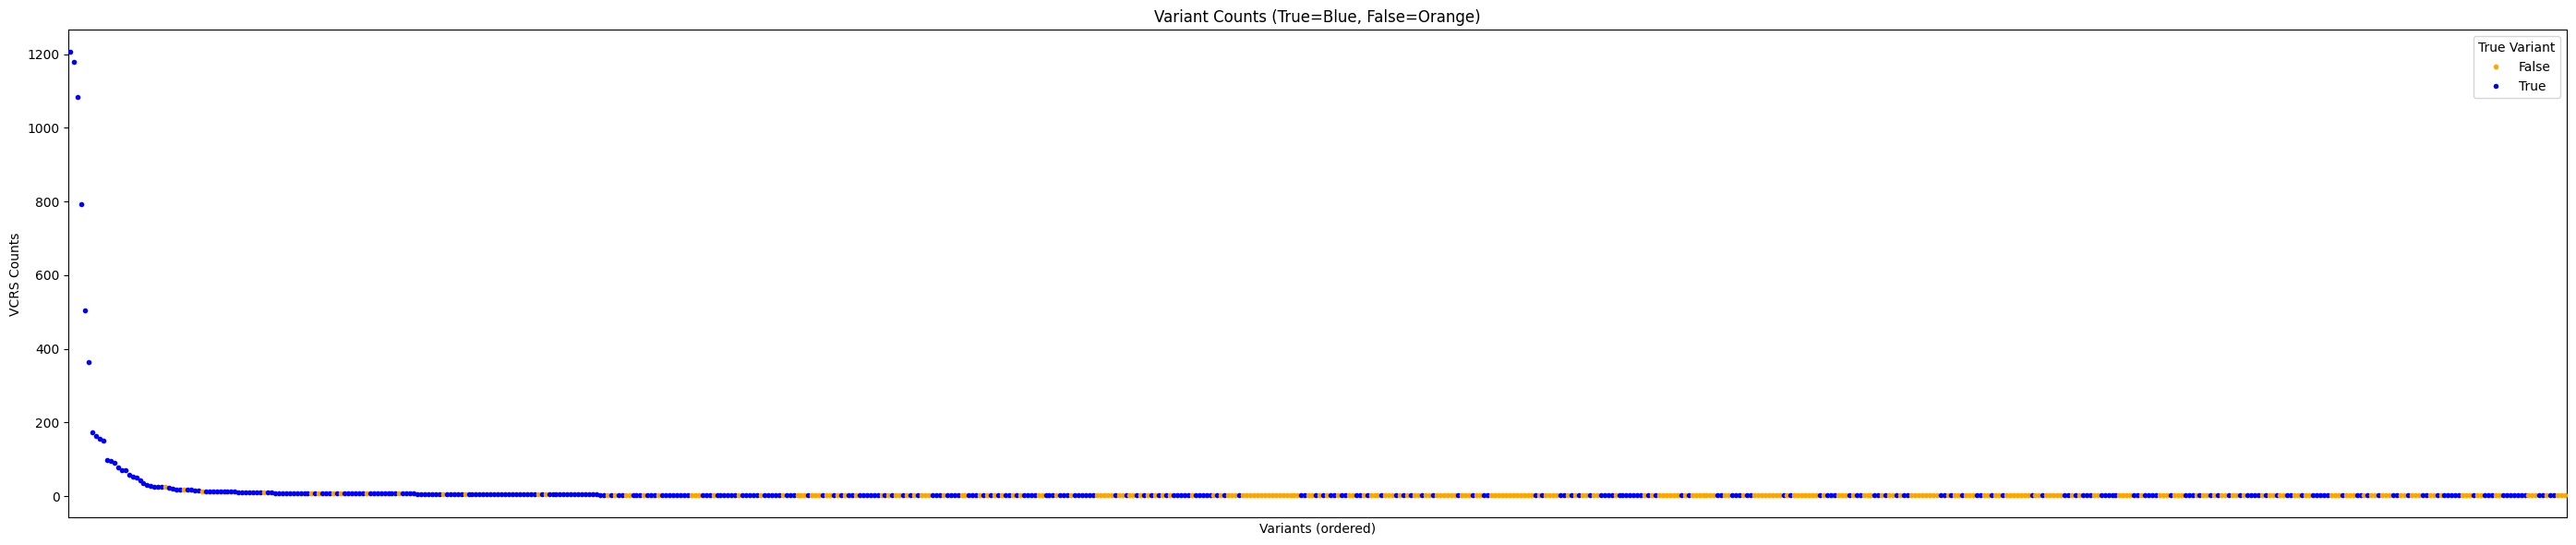

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

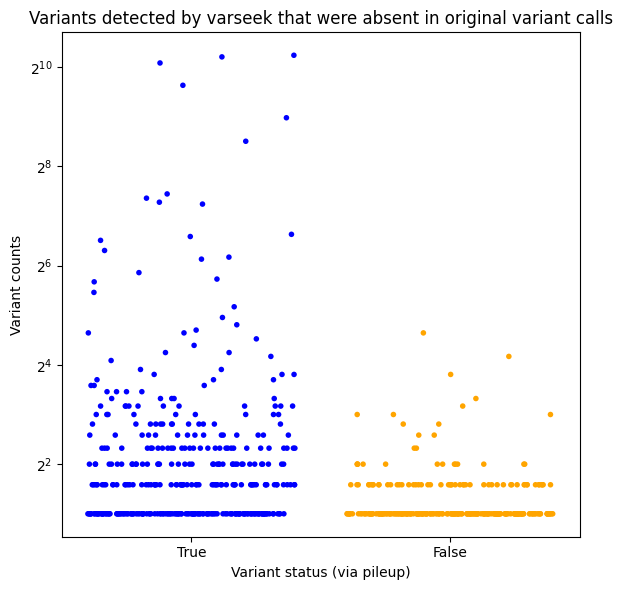

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('Variant status (via pileup)')
plt.ylabel('Variant counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('Variants detected by varseek that were absent in original variant calls')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: {'ENST00000604930', 'ENST00000608106', 'ENSG00000065978', 'ENSG00000174444', 'ENSG00000108107', 'ENST00000604591', 'ENSG00000142541', 'ENSG00000143947', 'ENSG00000071082', 'ENST00000603423'}


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

dbsnp_id    transcript_ID variant_cdna strand                header_cdna  \
0  rs28507236  ENST00000379407     c.528A>C      +   ENST00000379407:c.528A>C   
1  rs28548431  ENST00000379407    c.1566C>T      +  ENST00000379407:c.1566C>T   
2   rs9793256  ENST00000378785    c.1167G>A      +  ENST00000378785:c.1167G>A   
3   rs1781147  ENST00000378785    c.1409C>T      +  ENST00000378785:c.1409C>T   
4   rs7418389  ENST00000355826     c.253T>C      +   ENST00000355826:c.253T>C   

   is_false_negative vcrs_id  
0               True  vcrs_0  
1               True  vcrs_1  
2               True  vcrs_2  
3               True  vcrs_3  
4               True  vcrs_4

In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:53:22: Entering the loop


  0%|                                                                                                                            | 0/2949 [00:00<?, ?it/s]

  0%|                                                                                                                    | 1/2949 [00:01<50:09,  1.02s/it]

  0%|                                                                                                                    | 2/2949 [00:01<37:31,  1.31it/s]

  0%|                                                                                                                    | 3/2949 [00:02<33:36,  1.46it/s]

  0%|▏                                                                                                                   | 4/2949 [00:02<31:10,  1.57it/s]

  0%|▏                                                                                                                   | 5/2949 [00:03<30:50,  1.59it/s]

  0%|▏                                                                                                                   | 6/2949 [00:03<30:06,  1.63it/s]

  0%|▎                                                                                                                   | 7/2949 [00:04<29:58,  1.64it/s]

  0%|▎                                                                                                                   | 8/2949 [00:05<29:14,  1.68it/s]

  0%|▎                                                                                                                   | 9/2949 [00:05<28:48,  1.70it/s]

  0%|▍                                                                                                                  | 10/2949 [00:06<29:37,  1.65it/s]

  0%|▍                                                                                                                  | 11/2949 [00:06<30:12,  1.62it/s]

  0%|▍                                                                                                                  | 12/2949 [00:07<29:49,  1.64it/s]

  0%|▌                                                                                                                  | 13/2949 [00:08<29:19,  1.67it/s]

  0%|▌                                                                                                                  | 14/2949 [00:08<28:44,  1.70it/s]

  1%|▌                                                                                                                  | 15/2949 [00:09<29:07,  1.68it/s]

  1%|▌                                                                                                                  | 16/2949 [00:09<28:53,  1.69it/s]

  1%|▋                                                                                                                  | 17/2949 [00:10<28:44,  1.70it/s]

  1%|▋                                                                                                                  | 18/2949 [00:11<28:58,  1.69it/s]

  1%|▋                                                                                                                  | 19/2949 [00:11<29:23,  1.66it/s]

  1%|▊                                                                                                                  | 20/2949 [00:12<29:08,  1.68it/s]

  1%|▊                                                                                                                  | 21/2949 [00:12<28:55,  1.69it/s]

  1%|▊                                                                                                                  | 22/2949 [00:13<28:29,  1.71it/s]

  1%|▉                                                                                                                  | 23/2949 [00:14<28:05,  1.74it/s]

  1%|▉                                                                                                                  | 24/2949 [00:14<27:53,  1.75it/s]

  1%|▉                                                                                                                  | 25/2949 [00:15<27:44,  1.76it/s]

  1%|█                                                                                                                  | 26/2949 [00:15<28:09,  1.73it/s]

  1%|█                                                                                                                  | 27/2949 [00:16<28:10,  1.73it/s]

  1%|█                                                                                                                  | 28/2949 [00:16<28:15,  1.72it/s]

  1%|█▏                                                                                                                 | 29/2949 [00:17<28:03,  1.73it/s]

  1%|█▏                                                                                                                 | 30/2949 [00:18<28:15,  1.72it/s]

  1%|█▏                                                                                                                 | 31/2949 [00:18<27:54,  1.74it/s]

  1%|█▏                                                                                                                 | 32/2949 [00:19<27:39,  1.76it/s]

  1%|█▎                                                                                                                 | 33/2949 [00:19<28:52,  1.68it/s]

  1%|█▎                                                                                                                 | 34/2949 [00:20<29:18,  1.66it/s]

  1%|█▎                                                                                                                 | 35/2949 [00:21<29:16,  1.66it/s]

  1%|█▍                                                                                                                 | 36/2949 [00:21<28:49,  1.68it/s]

  1%|█▍                                                                                                                 | 37/2949 [00:22<28:19,  1.71it/s]

  1%|█▍                                                                                                                 | 38/2949 [00:22<28:22,  1.71it/s]

  1%|█▌                                                                                                                 | 39/2949 [00:23<28:40,  1.69it/s]

  1%|█▌                                                                                                                 | 40/2949 [00:23<28:38,  1.69it/s]

  1%|█▌                                                                                                                 | 41/2949 [00:24<30:23,  1.59it/s]

  1%|█▋                                                                                                                 | 42/2949 [00:25<30:09,  1.61it/s]

  1%|█▋                                                                                                                 | 43/2949 [00:25<29:54,  1.62it/s]

  1%|█▋                                                                                                                 | 44/2949 [00:26<29:57,  1.62it/s]

  2%|█▊                                                                                                                 | 45/2949 [00:27<30:16,  1.60it/s]

  2%|█▊                                                                                                                 | 46/2949 [00:27<30:29,  1.59it/s]

  2%|█▊                                                                                                                 | 47/2949 [00:28<29:43,  1.63it/s]

  2%|█▉                                                                                                                 | 49/2949 [00:28<22:33,  2.14it/s]

  2%|█▉                                                                                                                 | 50/2949 [00:29<23:50,  2.03it/s]

  2%|█▉                                                                                                                 | 51/2949 [00:30<26:06,  1.85it/s]

  2%|██                                                                                                                 | 52/2949 [00:30<27:22,  1.76it/s]

  2%|██                                                                                                                 | 53/2949 [00:31<27:43,  1.74it/s]

  2%|██                                                                                                                 | 54/2949 [00:32<27:46,  1.74it/s]

  2%|██▏                                                                                                                | 55/2949 [00:33<40:08,  1.20it/s]

  2%|██▏                                                                                                                | 57/2949 [00:34<28:32,  1.69it/s]

  2%|██▎                                                                                                                | 58/2949 [00:34<29:06,  1.66it/s]

  2%|██▎                                                                                                                | 59/2949 [00:35<28:49,  1.67it/s]

  2%|██▎                                                                                                                | 60/2949 [00:35<28:23,  1.70it/s]

  2%|██▍                                                                                                                | 61/2949 [00:36<28:26,  1.69it/s]

  2%|██▍                                                                                                                | 62/2949 [00:37<28:02,  1.72it/s]

  2%|██▍                                                                                                                | 63/2949 [00:37<27:47,  1.73it/s]

  2%|██▍                                                                                                                | 64/2949 [00:38<27:53,  1.72it/s]

  2%|██▌                                                                                                                | 65/2949 [00:38<28:21,  1.70it/s]

  2%|██▌                                                                                                                | 66/2949 [00:39<28:44,  1.67it/s]

  2%|██▌                                                                                                                | 67/2949 [00:40<29:11,  1.65it/s]

  2%|██▋                                                                                                                | 68/2949 [00:40<28:56,  1.66it/s]

  2%|██▋                                                                                                                | 69/2949 [00:41<28:18,  1.70it/s]

  2%|██▋                                                                                                                | 70/2949 [00:41<27:53,  1.72it/s]

  2%|██▊                                                                                                                | 71/2949 [00:42<28:03,  1.71it/s]

  2%|██▊                                                                                                                | 72/2949 [00:42<28:14,  1.70it/s]

  2%|██▊                                                                                                                | 73/2949 [00:43<28:34,  1.68it/s]

  3%|██▉                                                                                                                | 74/2949 [00:44<28:27,  1.68it/s]

  3%|██▉                                                                                                                | 75/2949 [00:44<28:16,  1.69it/s]

  3%|██▉                                                                                                                | 76/2949 [00:45<28:44,  1.67it/s]

  3%|███                                                                                                                | 77/2949 [00:45<28:33,  1.68it/s]

  3%|███                                                                                                                | 78/2949 [00:46<29:04,  1.65it/s]

  3%|███                                                                                                                | 79/2949 [00:47<31:33,  1.52it/s]

  3%|███▏                                                                                                               | 81/2949 [00:47<23:42,  2.02it/s]

  3%|███▏                                                                                                               | 82/2949 [00:48<25:19,  1.89it/s]

  3%|███▏                                                                                                               | 83/2949 [00:49<26:12,  1.82it/s]

  3%|███▎                                                                                                               | 84/2949 [00:49<27:24,  1.74it/s]

  3%|███▎                                                                                                               | 85/2949 [00:50<27:15,  1.75it/s]

  3%|███▎                                                                                                               | 86/2949 [00:51<29:30,  1.62it/s]

  3%|███▍                                                                                                               | 87/2949 [00:52<33:12,  1.44it/s]

  3%|███▍                                                                                                               | 88/2949 [00:52<31:18,  1.52it/s]

  3%|███▍                                                                                                               | 89/2949 [00:53<30:57,  1.54it/s]

  3%|███▌                                                                                                               | 90/2949 [00:53<30:06,  1.58it/s]

  3%|███▌                                                                                                               | 91/2949 [00:54<29:56,  1.59it/s]

  3%|███▌                                                                                                               | 92/2949 [00:55<29:30,  1.61it/s]

  3%|███▋                                                                                                               | 93/2949 [00:55<28:48,  1.65it/s]

  3%|███▋                                                                                                               | 94/2949 [00:56<28:52,  1.65it/s]

  3%|███▋                                                                                                               | 95/2949 [00:56<29:21,  1.62it/s]

  3%|███▋                                                                                                               | 96/2949 [00:57<28:55,  1.64it/s]

  3%|███▊                                                                                                               | 97/2949 [00:58<28:19,  1.68it/s]

  3%|███▊                                                                                                               | 98/2949 [00:58<28:15,  1.68it/s]

  3%|███▊                                                                                                               | 99/2949 [00:59<28:18,  1.68it/s]

  3%|███▊                                                                                                              | 100/2949 [00:59<27:53,  1.70it/s]

  3%|███▉                                                                                                              | 101/2949 [01:00<28:01,  1.69it/s]

  3%|███▉                                                                                                              | 102/2949 [01:00<27:50,  1.70it/s]

  3%|███▉                                                                                                              | 103/2949 [01:01<27:45,  1.71it/s]

  4%|████                                                                                                              | 104/2949 [01:02<27:49,  1.70it/s]

  4%|████                                                                                                              | 105/2949 [01:02<28:16,  1.68it/s]

  4%|████                                                                                                              | 106/2949 [01:03<27:56,  1.70it/s]

  4%|████▏                                                                                                             | 107/2949 [01:03<27:28,  1.72it/s]

  4%|████▏                                                                                                             | 109/2949 [01:04<21:21,  2.22it/s]

  4%|████▎                                                                                                             | 110/2949 [01:05<23:10,  2.04it/s]

  4%|████▎                                                                                                             | 111/2949 [01:05<24:17,  1.95it/s]

  4%|████▎                                                                                                             | 112/2949 [01:06<24:51,  1.90it/s]

  4%|████▎                                                                                                             | 113/2949 [01:06<25:30,  1.85it/s]

  4%|████▍                                                                                                             | 114/2949 [01:07<26:08,  1.81it/s]

  4%|████▍                                                                                                             | 115/2949 [01:07<26:30,  1.78it/s]

  4%|████▍                                                                                                             | 116/2949 [01:08<26:28,  1.78it/s]

  4%|████▌                                                                                                             | 118/2949 [01:09<28:03,  1.68it/s]

  4%|████▌                                                                                                             | 119/2949 [01:11<35:45,  1.32it/s]

  4%|████▋                                                                                                             | 120/2949 [01:12<42:04,  1.12it/s]

  4%|████▋                                                                                                             | 121/2949 [01:13<47:09,  1.00s/it]

  4%|████▋                                                                                                             | 122/2949 [01:14<50:21,  1.07s/it]

  4%|████▊                                                                                                             | 123/2949 [01:16<52:02,  1.10s/it]

  4%|████▊                                                                                                             | 124/2949 [01:17<53:07,  1.13s/it]

  4%|████▊                                                                                                             | 125/2949 [01:18<54:27,  1.16s/it]

  4%|████▊                                                                                                             | 126/2949 [01:19<55:26,  1.18s/it]

  4%|████▉                                                                                                             | 127/2949 [01:20<47:25,  1.01s/it]

  4%|████▉                                                                                                             | 128/2949 [01:20<41:31,  1.13it/s]

  4%|█████                                                                                                             | 130/2949 [01:21<28:43,  1.64it/s]

  4%|█████                                                                                                             | 131/2949 [01:22<28:34,  1.64it/s]

  4%|█████                                                                                                             | 132/2949 [01:22<30:02,  1.56it/s]

  5%|█████▏                                                                                                            | 133/2949 [01:23<29:27,  1.59it/s]

  5%|█████▏                                                                                                            | 134/2949 [01:24<31:25,  1.49it/s]

  5%|█████▏                                                                                                            | 135/2949 [01:24<30:00,  1.56it/s]

  5%|█████▎                                                                                                            | 136/2949 [01:25<29:06,  1.61it/s]

  5%|█████▎                                                                                                            | 137/2949 [01:25<29:41,  1.58it/s]

  5%|█████▎                                                                                                            | 138/2949 [01:26<29:02,  1.61it/s]

  5%|█████▎                                                                                                            | 139/2949 [01:27<29:17,  1.60it/s]

  5%|█████▍                                                                                                            | 140/2949 [01:27<28:21,  1.65it/s]

  5%|█████▍                                                                                                            | 141/2949 [01:28<28:00,  1.67it/s]

  5%|█████▍                                                                                                            | 142/2949 [01:28<27:57,  1.67it/s]

  5%|█████▌                                                                                                            | 143/2949 [01:29<28:19,  1.65it/s]

  5%|█████▌                                                                                                            | 144/2949 [01:30<28:17,  1.65it/s]

  5%|█████▌                                                                                                            | 145/2949 [01:30<28:40,  1.63it/s]

  5%|█████▋                                                                                                            | 146/2949 [01:31<28:37,  1.63it/s]

  5%|█████▋                                                                                                            | 147/2949 [01:31<27:57,  1.67it/s]

  5%|█████▋                                                                                                            | 148/2949 [01:32<27:29,  1.70it/s]

  5%|█████▊                                                                                                            | 149/2949 [01:33<27:14,  1.71it/s]

  5%|█████▊                                                                                                            | 150/2949 [01:33<27:31,  1.70it/s]

  5%|█████▊                                                                                                            | 151/2949 [01:34<27:44,  1.68it/s]

  5%|█████▉                                                                                                            | 152/2949 [01:34<27:26,  1.70it/s]

  5%|█████▉                                                                                                            | 153/2949 [01:35<27:26,  1.70it/s]

  5%|█████▉                                                                                                            | 154/2949 [01:36<27:18,  1.71it/s]

  5%|█████▉                                                                                                            | 155/2949 [01:36<27:05,  1.72it/s]

  5%|██████                                                                                                            | 156/2949 [01:37<27:18,  1.70it/s]

  5%|██████                                                                                                            | 157/2949 [01:37<26:58,  1.72it/s]

  5%|██████                                                                                                            | 158/2949 [01:38<27:46,  1.67it/s]

  5%|██████▏                                                                                                           | 159/2949 [01:39<27:23,  1.70it/s]

  5%|██████▏                                                                                                           | 160/2949 [01:39<27:06,  1.71it/s]

  5%|██████▎                                                                                                           | 162/2949 [01:40<20:39,  2.25it/s]

  6%|██████▎                                                                                                           | 163/2949 [01:40<23:00,  2.02it/s]

  6%|██████▎                                                                                                           | 164/2949 [01:41<24:01,  1.93it/s]

  6%|██████▍                                                                                                           | 165/2949 [01:41<24:37,  1.88it/s]

  6%|██████▍                                                                                                           | 166/2949 [01:42<25:39,  1.81it/s]

  6%|██████▍                                                                                                           | 167/2949 [01:43<25:50,  1.79it/s]

  6%|██████▍                                                                                                           | 168/2949 [01:43<25:57,  1.79it/s]

  6%|██████▌                                                                                                           | 169/2949 [01:44<26:10,  1.77it/s]

  6%|██████▌                                                                                                           | 170/2949 [01:44<26:03,  1.78it/s]

  6%|██████▌                                                                                                           | 171/2949 [01:45<26:01,  1.78it/s]

  6%|██████▋                                                                                                           | 172/2949 [01:45<26:25,  1.75it/s]

  6%|██████▋                                                                                                           | 173/2949 [01:46<26:26,  1.75it/s]

  6%|██████▋                                                                                                           | 174/2949 [01:47<26:16,  1.76it/s]

  6%|██████▊                                                                                                           | 175/2949 [01:47<26:21,  1.75it/s]

  6%|██████▊                                                                                                           | 176/2949 [01:48<26:25,  1.75it/s]

  6%|██████▊                                                                                                           | 177/2949 [01:48<26:14,  1.76it/s]

  6%|██████▉                                                                                                           | 178/2949 [01:49<26:31,  1.74it/s]

  6%|██████▉                                                                                                           | 180/2949 [01:49<20:28,  2.25it/s]

  6%|██████▉                                                                                                           | 181/2949 [01:50<22:09,  2.08it/s]

  6%|███████                                                                                                           | 182/2949 [01:51<23:25,  1.97it/s]

  6%|███████                                                                                                           | 184/2949 [01:51<19:09,  2.40it/s]

  6%|███████▏                                                                                                          | 185/2949 [01:52<20:41,  2.23it/s]

  6%|███████▏                                                                                                          | 186/2949 [01:52<22:19,  2.06it/s]

  6%|███████▏                                                                                                          | 187/2949 [01:53<23:30,  1.96it/s]

  6%|███████▎                                                                                                          | 188/2949 [01:54<24:16,  1.90it/s]

  6%|███████▎                                                                                                          | 189/2949 [01:54<24:42,  1.86it/s]

  6%|███████▎                                                                                                          | 190/2949 [01:55<25:01,  1.84it/s]

  6%|███████▍                                                                                                          | 191/2949 [01:55<25:16,  1.82it/s]

  7%|███████▍                                                                                                          | 192/2949 [01:56<26:07,  1.76it/s]

  7%|███████▍                                                                                                          | 193/2949 [01:56<26:26,  1.74it/s]

  7%|███████▍                                                                                                          | 194/2949 [01:57<26:12,  1.75it/s]

  7%|███████▌                                                                                                          | 195/2949 [01:58<26:06,  1.76it/s]

  7%|███████▌                                                                                                          | 196/2949 [01:58<26:09,  1.75it/s]

  7%|███████▌                                                                                                          | 197/2949 [01:59<26:44,  1.71it/s]

  7%|███████▋                                                                                                          | 198/2949 [01:59<26:26,  1.73it/s]

  7%|███████▋                                                                                                          | 199/2949 [02:00<27:03,  1.69it/s]

  7%|███████▋                                                                                                          | 200/2949 [02:01<26:52,  1.70it/s]

  7%|███████▊                                                                                                          | 201/2949 [02:01<26:59,  1.70it/s]

  7%|███████▊                                                                                                          | 202/2949 [02:02<27:46,  1.65it/s]

  7%|███████▊                                                                                                          | 203/2949 [02:02<28:18,  1.62it/s]

  7%|███████▉                                                                                                          | 204/2949 [02:03<28:10,  1.62it/s]

  7%|███████▉                                                                                                          | 205/2949 [02:04<27:41,  1.65it/s]

  7%|███████▉                                                                                                          | 206/2949 [02:04<27:33,  1.66it/s]

  7%|████████                                                                                                          | 207/2949 [02:05<27:12,  1.68it/s]

  7%|████████                                                                                                          | 208/2949 [02:06<29:56,  1.53it/s]

  7%|████████                                                                                                          | 209/2949 [02:06<28:40,  1.59it/s]

  7%|████████                                                                                                          | 210/2949 [02:07<28:13,  1.62it/s]

  7%|████████▏                                                                                                         | 211/2949 [02:07<28:37,  1.59it/s]

  7%|████████▏                                                                                                         | 212/2949 [02:08<27:42,  1.65it/s]

  7%|████████▏                                                                                                         | 213/2949 [02:09<27:03,  1.68it/s]

  7%|████████▎                                                                                                         | 214/2949 [02:09<26:51,  1.70it/s]

  7%|████████▎                                                                                                         | 215/2949 [02:10<26:27,  1.72it/s]

  7%|████████▎                                                                                                         | 216/2949 [02:10<26:12,  1.74it/s]

  7%|████████▍                                                                                                         | 217/2949 [02:11<26:16,  1.73it/s]

  7%|████████▍                                                                                                         | 218/2949 [02:11<26:40,  1.71it/s]

  7%|████████▍                                                                                                         | 219/2949 [02:12<26:26,  1.72it/s]

  7%|████████▌                                                                                                         | 220/2949 [02:13<26:12,  1.74it/s]

  7%|████████▌                                                                                                         | 221/2949 [02:13<25:59,  1.75it/s]

  8%|████████▌                                                                                                         | 222/2949 [02:14<25:51,  1.76it/s]

  8%|████████▌                                                                                                         | 223/2949 [02:14<26:14,  1.73it/s]

  8%|████████▋                                                                                                         | 224/2949 [02:15<26:20,  1.72it/s]

  8%|████████▋                                                                                                         | 225/2949 [02:15<26:25,  1.72it/s]

  8%|████████▋                                                                                                         | 226/2949 [02:16<26:40,  1.70it/s]

  8%|████████▊                                                                                                         | 227/2949 [02:17<26:46,  1.69it/s]

  8%|████████▊                                                                                                         | 228/2949 [02:17<26:30,  1.71it/s]

  8%|████████▊                                                                                                         | 229/2949 [02:18<34:30,  1.31it/s]

  8%|████████▉                                                                                                         | 230/2949 [02:19<32:40,  1.39it/s]

  8%|████████▉                                                                                                         | 231/2949 [02:20<30:35,  1.48it/s]

  8%|████████▉                                                                                                         | 232/2949 [02:20<29:37,  1.53it/s]

  8%|█████████                                                                                                         | 233/2949 [02:21<29:10,  1.55it/s]

  8%|█████████                                                                                                         | 234/2949 [02:21<28:26,  1.59it/s]

  8%|█████████                                                                                                         | 235/2949 [02:22<27:33,  1.64it/s]

  8%|█████████                                                                                                         | 236/2949 [02:23<27:19,  1.65it/s]

  8%|█████████▏                                                                                                        | 237/2949 [02:23<27:13,  1.66it/s]

  8%|█████████▏                                                                                                        | 239/2949 [02:24<20:38,  2.19it/s]

  8%|█████████▎                                                                                                        | 240/2949 [02:24<22:53,  1.97it/s]

  8%|█████████▎                                                                                                        | 241/2949 [02:25<23:56,  1.89it/s]

  8%|█████████▎                                                                                                        | 242/2949 [02:26<24:32,  1.84it/s]

  8%|█████████▍                                                                                                        | 243/2949 [02:26<26:30,  1.70it/s]

  8%|█████████▍                                                                                                        | 244/2949 [02:27<26:36,  1.69it/s]

  8%|█████████▍                                                                                                        | 245/2949 [02:27<26:28,  1.70it/s]

  8%|█████████▌                                                                                                        | 246/2949 [02:28<26:12,  1.72it/s]

  8%|█████████▌                                                                                                        | 248/2949 [02:29<20:21,  2.21it/s]

  8%|█████████▋                                                                                                        | 249/2949 [02:29<22:05,  2.04it/s]

  8%|█████████▋                                                                                                        | 250/2949 [02:30<23:17,  1.93it/s]

  9%|█████████▋                                                                                                        | 251/2949 [02:30<23:50,  1.89it/s]

  9%|█████████▋                                                                                                        | 252/2949 [02:31<24:32,  1.83it/s]

  9%|█████████▊                                                                                                        | 253/2949 [02:32<25:16,  1.78it/s]

  9%|█████████▊                                                                                                        | 254/2949 [02:32<26:03,  1.72it/s]

  9%|█████████▊                                                                                                        | 255/2949 [02:33<26:16,  1.71it/s]

  9%|█████████▉                                                                                                        | 256/2949 [02:33<25:59,  1.73it/s]

  9%|█████████▉                                                                                                        | 257/2949 [02:34<25:52,  1.73it/s]

  9%|█████████▉                                                                                                        | 258/2949 [02:35<26:32,  1.69it/s]

  9%|██████████                                                                                                        | 259/2949 [02:35<26:42,  1.68it/s]

  9%|██████████                                                                                                        | 261/2949 [02:36<20:21,  2.20it/s]

  9%|██████████▏                                                                                                       | 262/2949 [02:36<22:35,  1.98it/s]

  9%|██████████▏                                                                                                       | 263/2949 [02:37<23:16,  1.92it/s]

  9%|██████████▏                                                                                                       | 264/2949 [02:38<24:20,  1.84it/s]

  9%|██████████▎                                                                                                       | 266/2949 [02:38<20:06,  2.22it/s]

  9%|██████████▎                                                                                                       | 267/2949 [02:39<21:17,  2.10it/s]

  9%|██████████▎                                                                                                       | 268/2949 [02:39<22:19,  2.00it/s]

  9%|██████████▍                                                                                                       | 269/2949 [02:40<23:05,  1.93it/s]

  9%|██████████▍                                                                                                       | 270/2949 [02:40<23:41,  1.88it/s]

  9%|██████████▍                                                                                                       | 271/2949 [02:41<24:01,  1.86it/s]

  9%|██████████▌                                                                                                       | 272/2949 [02:42<24:24,  1.83it/s]

  9%|██████████▌                                                                                                       | 273/2949 [02:42<24:46,  1.80it/s]

  9%|██████████▌                                                                                                       | 274/2949 [02:43<24:52,  1.79it/s]

  9%|██████████▋                                                                                                       | 275/2949 [02:43<25:07,  1.77it/s]

  9%|██████████▋                                                                                                       | 276/2949 [02:44<25:06,  1.77it/s]

  9%|██████████▋                                                                                                       | 277/2949 [02:44<25:13,  1.77it/s]

  9%|██████████▊                                                                                                       | 279/2949 [02:45<19:35,  2.27it/s]

  9%|██████████▊                                                                                                       | 280/2949 [02:46<20:52,  2.13it/s]

 10%|██████████▉                                                                                                       | 282/2949 [02:46<19:38,  2.26it/s]

 10%|██████████▉                                                                                                       | 283/2949 [02:47<21:35,  2.06it/s]

 10%|██████████▉                                                                                                       | 284/2949 [02:48<22:48,  1.95it/s]

 10%|███████████                                                                                                       | 285/2949 [02:48<24:22,  1.82it/s]

 10%|███████████                                                                                                       | 286/2949 [02:49<26:28,  1.68it/s]

 10%|███████████                                                                                                       | 287/2949 [02:50<28:56,  1.53it/s]

 10%|███████████▏                                                                                                      | 288/2949 [02:51<30:00,  1.48it/s]

 10%|███████████▏                                                                                                      | 289/2949 [02:51<28:33,  1.55it/s]

 10%|███████████▎                                                                                                      | 292/2949 [02:52<17:25,  2.54it/s]

 10%|███████████▎                                                                                                      | 293/2949 [02:52<19:03,  2.32it/s]

 10%|███████████▎                                                                                                      | 294/2949 [02:53<20:22,  2.17it/s]

 10%|███████████▍                                                                                                      | 295/2949 [02:53<21:59,  2.01it/s]

 10%|███████████▍                                                                                                      | 296/2949 [02:54<23:08,  1.91it/s]

 10%|███████████▍                                                                                                      | 297/2949 [02:55<24:17,  1.82it/s]

 10%|███████████▌                                                                                                      | 298/2949 [02:55<24:38,  1.79it/s]

 10%|███████████▌                                                                                                      | 299/2949 [02:56<25:30,  1.73it/s]

 10%|███████████▌                                                                                                      | 300/2949 [02:56<25:28,  1.73it/s]

 10%|███████████▋                                                                                                      | 301/2949 [02:57<25:25,  1.74it/s]

 10%|███████████▋                                                                                                      | 302/2949 [02:58<25:28,  1.73it/s]

 10%|███████████▋                                                                                                      | 303/2949 [02:58<25:47,  1.71it/s]

 10%|███████████▊                                                                                                      | 304/2949 [02:59<26:56,  1.64it/s]

 10%|███████████▊                                                                                                      | 305/2949 [02:59<26:52,  1.64it/s]

 10%|███████████▊                                                                                                      | 306/2949 [03:00<26:50,  1.64it/s]

 10%|███████████▉                                                                                                      | 308/2949 [03:01<20:15,  2.17it/s]

 10%|███████████▉                                                                                                      | 309/2949 [03:01<21:20,  2.06it/s]

 11%|███████████▉                                                                                                      | 310/2949 [03:02<23:03,  1.91it/s]

 11%|████████████                                                                                                      | 311/2949 [03:02<23:45,  1.85it/s]

 11%|████████████                                                                                                      | 312/2949 [03:03<24:21,  1.80it/s]

 11%|████████████                                                                                                      | 313/2949 [03:04<24:26,  1.80it/s]

 11%|████████████▏                                                                                                     | 314/2949 [03:04<24:36,  1.78it/s]

 11%|████████████▏                                                                                                     | 315/2949 [03:05<24:51,  1.77it/s]

 11%|████████████▏                                                                                                     | 316/2949 [03:05<25:04,  1.75it/s]

 11%|████████████▎                                                                                                     | 317/2949 [03:06<26:08,  1.68it/s]

 11%|████████████▎                                                                                                     | 318/2949 [03:07<25:57,  1.69it/s]

 11%|████████████▎                                                                                                     | 319/2949 [03:07<25:32,  1.72it/s]

 11%|████████████▎                                                                                                     | 320/2949 [03:08<26:23,  1.66it/s]

 11%|████████████▍                                                                                                     | 321/2949 [03:08<26:29,  1.65it/s]

 11%|████████████▍                                                                                                     | 322/2949 [03:09<25:56,  1.69it/s]

 11%|████████████▍                                                                                                     | 323/2949 [03:09<25:31,  1.71it/s]

 11%|████████████▌                                                                                                     | 324/2949 [03:10<25:22,  1.72it/s]

 11%|████████████▌                                                                                                     | 325/2949 [03:11<26:06,  1.68it/s]

 11%|████████████▌                                                                                                     | 326/2949 [03:11<26:00,  1.68it/s]

 11%|████████████▋                                                                                                     | 327/2949 [03:12<25:41,  1.70it/s]

 11%|████████████▋                                                                                                     | 328/2949 [03:13<26:47,  1.63it/s]

 11%|████████████▋                                                                                                     | 329/2949 [03:13<26:28,  1.65it/s]

 11%|████████████▊                                                                                                     | 330/2949 [03:14<27:19,  1.60it/s]

 11%|████████████▊                                                                                                     | 331/2949 [03:14<27:00,  1.62it/s]

 11%|████████████▊                                                                                                     | 332/2949 [03:16<34:14,  1.27it/s]

 11%|████████████▊                                                                                                     | 333/2949 [03:17<39:17,  1.11it/s]

 11%|████████████▉                                                                                                     | 334/2949 [03:18<44:17,  1.02s/it]

 11%|████████████▉                                                                                                     | 335/2949 [03:19<46:21,  1.06s/it]

 11%|████████████▉                                                                                                     | 336/2949 [03:20<47:30,  1.09s/it]

 11%|█████████████                                                                                                     | 337/2949 [03:22<49:05,  1.13s/it]

 11%|█████████████                                                                                                     | 339/2949 [03:22<32:14,  1.35it/s]

 12%|█████████████▏                                                                                                    | 341/2949 [03:23<24:44,  1.76it/s]

 12%|█████████████▏                                                                                                    | 342/2949 [03:23<24:49,  1.75it/s]

 12%|█████████████▎                                                                                                    | 343/2949 [03:24<24:54,  1.74it/s]

 12%|█████████████▎                                                                                                    | 344/2949 [03:25<25:21,  1.71it/s]

 12%|█████████████▎                                                                                                    | 345/2949 [03:25<25:29,  1.70it/s]

 12%|█████████████▍                                                                                                    | 346/2949 [03:26<25:17,  1.72it/s]

 12%|█████████████▍                                                                                                    | 347/2949 [03:26<25:01,  1.73it/s]

 12%|█████████████▍                                                                                                    | 348/2949 [03:27<25:14,  1.72it/s]

 12%|█████████████▍                                                                                                    | 349/2949 [03:27<25:16,  1.71it/s]

 12%|█████████████▌                                                                                                    | 350/2949 [03:28<25:54,  1.67it/s]

 12%|█████████████▌                                                                                                    | 351/2949 [03:29<25:43,  1.68it/s]

 12%|█████████████▌                                                                                                    | 352/2949 [03:29<25:21,  1.71it/s]

 12%|█████████████▋                                                                                                    | 353/2949 [03:30<26:07,  1.66it/s]

 12%|█████████████▋                                                                                                    | 354/2949 [03:30<25:49,  1.67it/s]

 12%|█████████████▋                                                                                                    | 355/2949 [03:31<26:33,  1.63it/s]

 12%|█████████████▊                                                                                                    | 356/2949 [03:32<27:00,  1.60it/s]

 12%|█████████████▊                                                                                                    | 357/2949 [03:32<27:01,  1.60it/s]

 12%|█████████████▊                                                                                                    | 358/2949 [03:33<26:27,  1.63it/s]

 12%|█████████████▉                                                                                                    | 359/2949 [03:34<25:54,  1.67it/s]

 12%|█████████████▉                                                                                                    | 360/2949 [03:34<25:57,  1.66it/s]

 12%|█████████████▉                                                                                                    | 361/2949 [03:35<26:43,  1.61it/s]

 12%|█████████████▉                                                                                                    | 362/2949 [03:35<27:25,  1.57it/s]

 12%|██████████████                                                                                                    | 363/2949 [03:36<26:38,  1.62it/s]

 12%|██████████████                                                                                                    | 364/2949 [03:37<25:56,  1.66it/s]

 12%|██████████████                                                                                                    | 365/2949 [03:37<25:37,  1.68it/s]

 12%|██████████████▏                                                                                                   | 366/2949 [03:38<25:23,  1.70it/s]

 12%|██████████████▏                                                                                                   | 367/2949 [03:38<25:56,  1.66it/s]

 12%|██████████████▏                                                                                                   | 368/2949 [03:39<26:43,  1.61it/s]

 13%|██████████████▎                                                                                                   | 369/2949 [03:40<25:59,  1.65it/s]

 13%|██████████████▎                                                                                                   | 370/2949 [03:40<25:52,  1.66it/s]

 13%|██████████████▎                                                                                                   | 371/2949 [03:41<26:11,  1.64it/s]

 13%|██████████████▍                                                                                                   | 372/2949 [03:41<25:38,  1.67it/s]

 13%|██████████████▍                                                                                                   | 373/2949 [03:42<25:20,  1.69it/s]

 13%|██████████████▍                                                                                                   | 374/2949 [03:43<25:12,  1.70it/s]

 13%|██████████████▍                                                                                                   | 375/2949 [03:43<25:09,  1.71it/s]

 13%|██████████████▌                                                                                                   | 376/2949 [03:44<24:51,  1.72it/s]

 13%|██████████████▌                                                                                                   | 377/2949 [03:44<25:21,  1.69it/s]

 13%|██████████████▌                                                                                                   | 378/2949 [03:45<25:47,  1.66it/s]

 13%|██████████████▋                                                                                                   | 380/2949 [03:46<20:08,  2.13it/s]

 13%|██████████████▋                                                                                                   | 381/2949 [03:46<21:43,  1.97it/s]

 13%|██████████████▊                                                                                                   | 382/2949 [03:47<22:18,  1.92it/s]

 13%|██████████████▊                                                                                                   | 383/2949 [03:47<23:22,  1.83it/s]

 13%|██████████████▊                                                                                                   | 384/2949 [03:49<35:00,  1.22it/s]

 13%|██████████████▉                                                                                                   | 385/2949 [03:49<31:59,  1.34it/s]

 13%|██████████████▉                                                                                                   | 386/2949 [03:50<30:59,  1.38it/s]

 13%|██████████████▉                                                                                                   | 387/2949 [03:51<29:26,  1.45it/s]

 13%|██████████████▉                                                                                                   | 388/2949 [03:51<28:59,  1.47it/s]

 13%|███████████████                                                                                                   | 389/2949 [03:52<28:34,  1.49it/s]

 13%|███████████████                                                                                                   | 390/2949 [03:53<28:11,  1.51it/s]

 13%|███████████████                                                                                                   | 391/2949 [03:53<27:02,  1.58it/s]

 13%|███████████████▏                                                                                                  | 392/2949 [03:54<26:19,  1.62it/s]

 13%|███████████████▏                                                                                                  | 393/2949 [03:54<26:01,  1.64it/s]

 13%|███████████████▏                                                                                                  | 394/2949 [03:55<25:42,  1.66it/s]

 13%|███████████████▎                                                                                                  | 395/2949 [03:56<25:21,  1.68it/s]

 13%|███████████████▎                                                                                                  | 396/2949 [03:56<25:02,  1.70it/s]

 13%|███████████████▎                                                                                                  | 397/2949 [03:57<25:08,  1.69it/s]

 13%|███████████████▍                                                                                                  | 398/2949 [03:57<25:05,  1.69it/s]

 14%|███████████████▍                                                                                                  | 399/2949 [03:58<24:56,  1.70it/s]

 14%|███████████████▍                                                                                                  | 400/2949 [03:59<24:54,  1.71it/s]

 14%|███████████████▌                                                                                                  | 401/2949 [03:59<25:07,  1.69it/s]

 14%|███████████████▌                                                                                                  | 402/2949 [04:00<25:15,  1.68it/s]

 14%|███████████████▌                                                                                                  | 403/2949 [04:00<24:49,  1.71it/s]

 14%|███████████████▌                                                                                                  | 404/2949 [04:01<24:34,  1.73it/s]

 14%|███████████████▋                                                                                                  | 405/2949 [04:01<24:27,  1.73it/s]

 14%|███████████████▋                                                                                                  | 406/2949 [04:02<24:42,  1.72it/s]

 14%|███████████████▋                                                                                                  | 407/2949 [04:03<24:45,  1.71it/s]

 14%|███████████████▊                                                                                                  | 408/2949 [04:03<25:12,  1.68it/s]

 14%|███████████████▊                                                                                                  | 409/2949 [04:04<25:41,  1.65it/s]

 14%|███████████████▊                                                                                                  | 410/2949 [04:04<25:41,  1.65it/s]

 14%|███████████████▉                                                                                                  | 411/2949 [04:05<25:07,  1.68it/s]

 14%|███████████████▉                                                                                                  | 413/2949 [04:06<19:01,  2.22it/s]

 14%|████████████████                                                                                                  | 414/2949 [04:06<20:11,  2.09it/s]

 14%|████████████████                                                                                                  | 415/2949 [04:07<21:51,  1.93it/s]

 14%|████████████████                                                                                                  | 416/2949 [04:07<22:20,  1.89it/s]

 14%|████████████████                                                                                                  | 417/2949 [04:08<22:56,  1.84it/s]

 14%|████████████████▏                                                                                                 | 418/2949 [04:09<23:16,  1.81it/s]

 14%|████████████████▏                                                                                                 | 419/2949 [04:09<24:17,  1.74it/s]

 14%|████████████████▏                                                                                                 | 420/2949 [04:10<24:21,  1.73it/s]

 14%|████████████████▎                                                                                                 | 421/2949 [04:10<25:42,  1.64it/s]

 14%|████████████████▎                                                                                                 | 422/2949 [04:11<25:39,  1.64it/s]

 14%|████████████████▎                                                                                                 | 423/2949 [04:12<25:27,  1.65it/s]

 14%|████████████████▍                                                                                                 | 424/2949 [04:12<25:00,  1.68it/s]

 14%|████████████████▍                                                                                                 | 425/2949 [04:13<24:55,  1.69it/s]

 14%|████████████████▍                                                                                                 | 426/2949 [04:13<24:43,  1.70it/s]

 14%|████████████████▌                                                                                                 | 427/2949 [04:14<25:16,  1.66it/s]

 15%|████████████████▌                                                                                                 | 428/2949 [04:15<25:12,  1.67it/s]

 15%|████████████████▌                                                                                                 | 429/2949 [04:15<24:54,  1.69it/s]

 15%|████████████████▌                                                                                                 | 430/2949 [04:16<24:38,  1.70it/s]

 15%|████████████████▋                                                                                                 | 431/2949 [04:16<24:38,  1.70it/s]

 15%|████████████████▋                                                                                                 | 432/2949 [04:17<24:29,  1.71it/s]

 15%|████████████████▋                                                                                                 | 433/2949 [04:17<24:16,  1.73it/s]

 15%|████████████████▊                                                                                                 | 434/2949 [04:18<24:08,  1.74it/s]

 15%|████████████████▊                                                                                                 | 435/2949 [04:19<24:15,  1.73it/s]

 15%|████████████████▊                                                                                                 | 436/2949 [04:19<24:07,  1.74it/s]

 15%|████████████████▉                                                                                                 | 437/2949 [04:20<24:15,  1.73it/s]

 15%|████████████████▉                                                                                                 | 438/2949 [04:20<24:06,  1.74it/s]

 15%|████████████████▉                                                                                                 | 439/2949 [04:21<24:18,  1.72it/s]

 15%|█████████████████                                                                                                 | 440/2949 [04:22<24:03,  1.74it/s]

 15%|█████████████████                                                                                                 | 441/2949 [04:22<23:56,  1.75it/s]

 15%|█████████████████                                                                                                 | 442/2949 [04:23<23:52,  1.75it/s]

 15%|█████████████████▏                                                                                                | 443/2949 [04:23<23:51,  1.75it/s]

 15%|█████████████████▏                                                                                                | 444/2949 [04:24<23:51,  1.75it/s]

 15%|█████████████████▏                                                                                                | 445/2949 [04:24<24:13,  1.72it/s]

 15%|█████████████████▏                                                                                                | 446/2949 [04:25<24:35,  1.70it/s]

 15%|█████████████████▎                                                                                                | 447/2949 [04:26<24:23,  1.71it/s]

 15%|█████████████████▎                                                                                                | 448/2949 [04:26<24:08,  1.73it/s]

 15%|█████████████████▎                                                                                                | 449/2949 [04:27<23:58,  1.74it/s]

 15%|█████████████████▍                                                                                                | 450/2949 [04:27<24:08,  1.73it/s]

 15%|█████████████████▍                                                                                                | 451/2949 [04:28<24:07,  1.73it/s]

 15%|█████████████████▍                                                                                                | 452/2949 [04:29<24:45,  1.68it/s]

 15%|█████████████████▌                                                                                                | 453/2949 [04:29<24:20,  1.71it/s]

 15%|█████████████████▌                                                                                                | 454/2949 [04:30<24:07,  1.72it/s]

 15%|█████████████████▌                                                                                                | 455/2949 [04:30<27:10,  1.53it/s]

 15%|█████████████████▋                                                                                                | 456/2949 [04:31<26:25,  1.57it/s]

 15%|█████████████████▋                                                                                                | 457/2949 [04:32<26:00,  1.60it/s]

 16%|█████████████████▋                                                                                                | 458/2949 [04:32<25:25,  1.63it/s]

 16%|█████████████████▋                                                                                                | 459/2949 [04:33<24:43,  1.68it/s]

 16%|█████████████████▊                                                                                                | 460/2949 [04:33<24:44,  1.68it/s]

 16%|█████████████████▊                                                                                                | 461/2949 [04:34<25:04,  1.65it/s]

 16%|█████████████████▊                                                                                                | 462/2949 [04:35<25:08,  1.65it/s]

 16%|█████████████████▉                                                                                                | 463/2949 [04:35<24:37,  1.68it/s]

 16%|█████████████████▉                                                                                                | 464/2949 [04:36<24:26,  1.69it/s]

 16%|█████████████████▉                                                                                                | 465/2949 [04:36<24:10,  1.71it/s]

 16%|██████████████████                                                                                                | 466/2949 [04:37<24:10,  1.71it/s]

 16%|██████████████████                                                                                                | 467/2949 [04:37<23:58,  1.73it/s]

 16%|██████████████████                                                                                                | 468/2949 [04:38<24:29,  1.69it/s]

 16%|██████████████████▏                                                                                               | 469/2949 [04:39<24:18,  1.70it/s]

 16%|██████████████████▏                                                                                               | 470/2949 [04:39<24:11,  1.71it/s]

 16%|██████████████████▏                                                                                               | 471/2949 [04:40<24:30,  1.68it/s]

 16%|██████████████████▏                                                                                               | 472/2949 [04:40<24:28,  1.69it/s]

 16%|██████████████████▎                                                                                               | 473/2949 [04:41<24:04,  1.71it/s]

 16%|██████████████████▎                                                                                               | 474/2949 [04:42<23:49,  1.73it/s]

 16%|██████████████████▎                                                                                               | 475/2949 [04:42<24:23,  1.69it/s]

 16%|██████████████████▍                                                                                               | 476/2949 [04:43<24:40,  1.67it/s]

 16%|██████████████████▍                                                                                               | 477/2949 [04:43<24:17,  1.70it/s]

 16%|██████████████████▍                                                                                               | 478/2949 [04:44<24:06,  1.71it/s]

 16%|██████████████████▌                                                                                               | 479/2949 [04:45<24:47,  1.66it/s]

 16%|██████████████████▌                                                                                               | 480/2949 [04:45<24:44,  1.66it/s]

 16%|██████████████████▌                                                                                               | 481/2949 [04:46<24:40,  1.67it/s]

 16%|██████████████████▋                                                                                               | 482/2949 [04:47<26:57,  1.52it/s]

 16%|██████████████████▋                                                                                               | 483/2949 [04:48<34:14,  1.20it/s]

 16%|██████████████████▋                                                                                               | 484/2949 [04:49<38:44,  1.06it/s]

 16%|██████████████████▋                                                                                               | 485/2949 [04:50<41:43,  1.02s/it]

 16%|██████████████████▊                                                                                               | 486/2949 [04:51<43:32,  1.06s/it]

 17%|██████████████████▊                                                                                               | 487/2949 [04:53<45:00,  1.10s/it]

 17%|██████████████████▊                                                                                               | 488/2949 [04:54<45:57,  1.12s/it]

 17%|██████████████████▉                                                                                               | 489/2949 [04:55<46:33,  1.14s/it]

 17%|██████████████████▉                                                                                               | 490/2949 [04:56<47:50,  1.17s/it]

 17%|██████████████████▉                                                                                               | 491/2949 [04:57<47:46,  1.17s/it]

 17%|███████████████████                                                                                               | 492/2949 [04:59<47:46,  1.17s/it]

 17%|███████████████████                                                                                               | 493/2949 [05:00<47:55,  1.17s/it]

 17%|███████████████████                                                                                               | 494/2949 [05:00<40:52,  1.00it/s]

 17%|███████████████████▏                                                                                              | 495/2949 [05:01<35:52,  1.14it/s]

 17%|███████████████████▏                                                                                              | 496/2949 [05:02<40:07,  1.02it/s]

 17%|███████████████████▏                                                                                              | 497/2949 [05:03<35:16,  1.16it/s]

 17%|███████████████████▎                                                                                              | 498/2949 [05:03<31:46,  1.29it/s]

 17%|███████████████████▎                                                                                              | 500/2949 [05:04<23:04,  1.77it/s]

 17%|███████████████████▎                                                                                              | 501/2949 [05:05<23:22,  1.75it/s]

 17%|███████████████████▍                                                                                              | 503/2949 [05:05<18:24,  2.22it/s]

 17%|███████████████████▍                                                                                              | 504/2949 [05:06<20:00,  2.04it/s]

 17%|███████████████████▌                                                                                              | 505/2949 [05:06<21:03,  1.93it/s]

 17%|███████████████████▌                                                                                              | 506/2949 [05:07<22:07,  1.84it/s]

 17%|███████████████████▌                                                                                              | 507/2949 [05:07<22:40,  1.79it/s]

 17%|███████████████████▋                                                                                              | 508/2949 [05:08<23:08,  1.76it/s]

 17%|███████████████████▋                                                                                              | 509/2949 [05:09<23:27,  1.73it/s]

 17%|███████████████████▋                                                                                              | 510/2949 [05:09<23:26,  1.73it/s]

 17%|███████████████████▊                                                                                              | 512/2949 [05:10<18:13,  2.23it/s]

 17%|███████████████████▊                                                                                              | 514/2949 [05:10<15:59,  2.54it/s]

 17%|███████████████████▉                                                                                              | 515/2949 [05:11<17:31,  2.32it/s]

 17%|███████████████████▉                                                                                              | 516/2949 [05:12<19:08,  2.12it/s]

 18%|███████████████████▉                                                                                              | 517/2949 [05:12<20:13,  2.00it/s]

 18%|████████████████████                                                                                              | 518/2949 [05:13<20:57,  1.93it/s]

 18%|████████████████████                                                                                              | 519/2949 [05:13<21:38,  1.87it/s]

 18%|████████████████████                                                                                              | 520/2949 [05:14<22:47,  1.78it/s]

 18%|████████████████████▏                                                                                             | 521/2949 [05:15<22:46,  1.78it/s]

 18%|████████████████████▏                                                                                             | 522/2949 [05:15<22:57,  1.76it/s]

 18%|████████████████████▏                                                                                             | 523/2949 [05:16<23:11,  1.74it/s]

 18%|████████████████████▎                                                                                             | 524/2949 [05:16<23:15,  1.74it/s]

 18%|████████████████████▎                                                                                             | 525/2949 [05:17<23:24,  1.73it/s]

 18%|████████████████████▎                                                                                             | 526/2949 [05:17<23:10,  1.74it/s]

 18%|████████████████████▎                                                                                             | 527/2949 [05:18<23:01,  1.75it/s]

 18%|████████████████████▍                                                                                             | 528/2949 [05:19<23:01,  1.75it/s]

 18%|████████████████████▍                                                                                             | 529/2949 [05:19<23:31,  1.71it/s]

 18%|████████████████████▍                                                                                             | 530/2949 [05:20<23:44,  1.70it/s]

 18%|████████████████████▌                                                                                             | 531/2949 [05:20<23:32,  1.71it/s]

 18%|████████████████████▌                                                                                             | 532/2949 [05:21<23:54,  1.69it/s]

 18%|████████████████████▌                                                                                             | 533/2949 [05:22<23:39,  1.70it/s]

 18%|████████████████████▋                                                                                             | 534/2949 [05:22<24:30,  1.64it/s]

 18%|████████████████████▋                                                                                             | 535/2949 [05:23<25:10,  1.60it/s]

 18%|████████████████████▋                                                                                             | 536/2949 [05:23<24:50,  1.62it/s]

 18%|████████████████████▊                                                                                             | 537/2949 [05:24<24:46,  1.62it/s]

 18%|████████████████████▊                                                                                             | 538/2949 [05:25<24:16,  1.66it/s]

 18%|████████████████████▊                                                                                             | 539/2949 [05:25<24:34,  1.63it/s]

 18%|████████████████████▊                                                                                             | 540/2949 [05:26<24:27,  1.64it/s]

 18%|████████████████████▉                                                                                             | 541/2949 [05:26<24:06,  1.66it/s]

 18%|████████████████████▉                                                                                             | 542/2949 [05:27<23:31,  1.70it/s]

 18%|████████████████████▉                                                                                             | 543/2949 [05:28<23:15,  1.72it/s]

 18%|█████████████████████                                                                                             | 544/2949 [05:28<23:10,  1.73it/s]

 19%|█████████████████████                                                                                             | 546/2949 [05:29<18:18,  2.19it/s]

 19%|█████████████████████▏                                                                                            | 547/2949 [05:29<19:47,  2.02it/s]

 19%|█████████████████████▏                                                                                            | 548/2949 [05:30<20:44,  1.93it/s]

 19%|█████████████████████▏                                                                                            | 549/2949 [05:31<21:49,  1.83it/s]

 19%|█████████████████████▎                                                                                            | 550/2949 [05:31<22:05,  1.81it/s]

 19%|█████████████████████▎                                                                                            | 551/2949 [05:32<22:42,  1.76it/s]

 19%|█████████████████████▎                                                                                            | 552/2949 [05:32<22:44,  1.76it/s]

 19%|█████████████████████▍                                                                                            | 553/2949 [05:33<23:38,  1.69it/s]

 19%|█████████████████████▍                                                                                            | 554/2949 [05:34<23:32,  1.70it/s]

 19%|█████████████████████▍                                                                                            | 555/2949 [05:34<23:38,  1.69it/s]

 19%|█████████████████████▍                                                                                            | 556/2949 [05:35<24:15,  1.64it/s]

 19%|█████████████████████▌                                                                                            | 557/2949 [05:35<23:41,  1.68it/s]

 19%|█████████████████████▌                                                                                            | 558/2949 [05:36<23:34,  1.69it/s]

 19%|█████████████████████▌                                                                                            | 559/2949 [05:37<23:20,  1.71it/s]

 19%|█████████████████████▋                                                                                            | 560/2949 [05:37<23:08,  1.72it/s]

 19%|█████████████████████▋                                                                                            | 561/2949 [05:38<22:55,  1.74it/s]

 19%|█████████████████████▋                                                                                            | 562/2949 [05:38<23:14,  1.71it/s]

 19%|█████████████████████▊                                                                                            | 563/2949 [05:39<23:23,  1.70it/s]

 19%|█████████████████████▊                                                                                            | 564/2949 [05:39<23:06,  1.72it/s]

 19%|█████████████████████▊                                                                                            | 565/2949 [05:40<24:15,  1.64it/s]

 19%|█████████████████████▉                                                                                            | 566/2949 [05:41<23:51,  1.67it/s]

 19%|█████████████████████▉                                                                                            | 567/2949 [05:41<23:23,  1.70it/s]

 19%|█████████████████████▉                                                                                            | 568/2949 [05:42<23:18,  1.70it/s]

 19%|█████████████████████▉                                                                                            | 569/2949 [05:42<23:15,  1.71it/s]

 19%|██████████████████████                                                                                            | 570/2949 [05:43<23:12,  1.71it/s]

 19%|██████████████████████                                                                                            | 571/2949 [05:44<22:55,  1.73it/s]

 19%|██████████████████████                                                                                            | 572/2949 [05:44<22:56,  1.73it/s]

 19%|██████████████████████▏                                                                                           | 573/2949 [05:45<23:30,  1.68it/s]

 19%|██████████████████████▏                                                                                           | 574/2949 [05:45<23:20,  1.70it/s]

 19%|██████████████████████▏                                                                                           | 575/2949 [05:46<22:55,  1.73it/s]

 20%|██████████████████████▎                                                                                           | 576/2949 [05:47<22:43,  1.74it/s]

 20%|██████████████████████▎                                                                                           | 577/2949 [05:47<22:38,  1.75it/s]

 20%|██████████████████████▎                                                                                           | 578/2949 [05:48<23:26,  1.69it/s]

 20%|██████████████████████▍                                                                                           | 579/2949 [05:48<23:02,  1.71it/s]

 20%|██████████████████████▍                                                                                           | 580/2949 [05:49<23:05,  1.71it/s]

 20%|██████████████████████▍                                                                                           | 581/2949 [05:49<22:46,  1.73it/s]

 20%|██████████████████████▍                                                                                           | 582/2949 [05:50<22:38,  1.74it/s]

 20%|██████████████████████▌                                                                                           | 583/2949 [05:51<22:50,  1.73it/s]

 20%|██████████████████████▌                                                                                           | 584/2949 [05:51<22:55,  1.72it/s]

 20%|██████████████████████▋                                                                                           | 587/2949 [05:52<18:36,  2.12it/s]

 20%|██████████████████████▋                                                                                           | 588/2949 [05:54<24:34,  1.60it/s]

 20%|██████████████████████▊                                                                                           | 589/2949 [05:55<29:29,  1.33it/s]

 20%|██████████████████████▊                                                                                           | 590/2949 [05:56<33:31,  1.17it/s]

 20%|██████████████████████▊                                                                                           | 591/2949 [05:57<36:53,  1.07it/s]

 20%|██████████████████████▉                                                                                           | 592/2949 [05:58<39:28,  1.01s/it]

 20%|██████████████████████▉                                                                                           | 593/2949 [05:59<34:59,  1.12it/s]

 20%|██████████████████████▉                                                                                           | 594/2949 [05:59<31:49,  1.23it/s]

 20%|███████████████████████                                                                                           | 595/2949 [06:00<28:58,  1.35it/s]

 20%|███████████████████████                                                                                           | 596/2949 [06:01<27:32,  1.42it/s]

 20%|███████████████████████                                                                                           | 597/2949 [06:01<25:52,  1.51it/s]

 20%|███████████████████████                                                                                           | 598/2949 [06:02<25:32,  1.53it/s]

 20%|███████████████████████▏                                                                                          | 599/2949 [06:02<24:39,  1.59it/s]

 20%|███████████████████████▏                                                                                          | 600/2949 [06:03<24:02,  1.63it/s]

 20%|███████████████████████▏                                                                                          | 601/2949 [06:04<23:41,  1.65it/s]

 20%|███████████████████████▎                                                                                          | 602/2949 [06:04<25:39,  1.52it/s]

 20%|███████████████████████▎                                                                                          | 603/2949 [06:05<27:07,  1.44it/s]

 20%|███████████████████████▎                                                                                          | 604/2949 [06:06<29:05,  1.34it/s]

 21%|███████████████████████▍                                                                                          | 605/2949 [06:07<29:08,  1.34it/s]

 21%|███████████████████████▍                                                                                          | 606/2949 [06:07<27:17,  1.43it/s]

 21%|███████████████████████▍                                                                                          | 607/2949 [06:08<26:07,  1.49it/s]

 21%|███████████████████████▌                                                                                          | 608/2949 [06:08<24:50,  1.57it/s]

 21%|███████████████████████▌                                                                                          | 609/2949 [06:09<24:27,  1.59it/s]

 21%|███████████████████████▌                                                                                          | 610/2949 [06:10<23:46,  1.64it/s]

 21%|███████████████████████▌                                                                                          | 611/2949 [06:10<23:31,  1.66it/s]

 21%|███████████████████████▋                                                                                          | 612/2949 [06:11<22:59,  1.69it/s]

 21%|███████████████████████▋                                                                                          | 613/2949 [06:11<23:03,  1.69it/s]

 21%|███████████████████████▋                                                                                          | 614/2949 [06:12<22:43,  1.71it/s]

 21%|███████████████████████▊                                                                                          | 615/2949 [06:13<22:46,  1.71it/s]

 21%|███████████████████████▊                                                                                          | 616/2949 [06:13<22:56,  1.70it/s]

 21%|███████████████████████▊                                                                                          | 617/2949 [06:14<22:36,  1.72it/s]

 21%|███████████████████████▉                                                                                          | 618/2949 [06:14<22:21,  1.74it/s]

 21%|███████████████████████▉                                                                                          | 619/2949 [06:15<22:23,  1.73it/s]

 21%|███████████████████████▉                                                                                          | 620/2949 [06:15<22:53,  1.70it/s]

 21%|████████████████████████                                                                                          | 621/2949 [06:16<23:46,  1.63it/s]

 21%|████████████████████████                                                                                          | 622/2949 [06:17<23:51,  1.63it/s]

 21%|████████████████████████                                                                                          | 623/2949 [06:17<23:24,  1.66it/s]

 21%|████████████████████████                                                                                          | 624/2949 [06:18<23:08,  1.67it/s]

 21%|████████████████████████▏                                                                                         | 625/2949 [06:18<23:00,  1.68it/s]

 21%|████████████████████████▏                                                                                         | 626/2949 [06:19<23:06,  1.68it/s]

 21%|████████████████████████▏                                                                                         | 627/2949 [06:20<22:37,  1.71it/s]

 21%|████████████████████████▎                                                                                         | 628/2949 [06:20<22:23,  1.73it/s]

 21%|████████████████████████▎                                                                                         | 629/2949 [06:21<22:29,  1.72it/s]

 21%|████████████████████████▎                                                                                         | 630/2949 [06:21<22:52,  1.69it/s]

 21%|████████████████████████▍                                                                                         | 631/2949 [06:22<22:50,  1.69it/s]

 21%|████████████████████████▍                                                                                         | 632/2949 [06:23<22:46,  1.70it/s]

 21%|████████████████████████▍                                                                                         | 633/2949 [06:23<22:45,  1.70it/s]

 21%|████████████████████████▌                                                                                         | 634/2949 [06:24<22:54,  1.68it/s]

 22%|████████████████████████▌                                                                                         | 635/2949 [06:24<22:49,  1.69it/s]

 22%|████████████████████████▌                                                                                         | 637/2949 [06:25<17:30,  2.20it/s]

 22%|████████████████████████▋                                                                                         | 638/2949 [06:26<18:50,  2.04it/s]

 22%|████████████████████████▋                                                                                         | 639/2949 [06:26<20:03,  1.92it/s]

 22%|████████████████████████▋                                                                                         | 640/2949 [06:27<20:56,  1.84it/s]

 22%|████████████████████████▊                                                                                         | 641/2949 [06:27<21:22,  1.80it/s]

 22%|████████████████████████▊                                                                                         | 642/2949 [06:28<21:47,  1.76it/s]

 22%|████████████████████████▊                                                                                         | 643/2949 [06:29<21:40,  1.77it/s]

 22%|████████████████████████▉                                                                                         | 644/2949 [06:29<21:47,  1.76it/s]

 22%|████████████████████████▉                                                                                         | 645/2949 [06:30<21:53,  1.75it/s]

 22%|████████████████████████▉                                                                                         | 646/2949 [06:30<21:56,  1.75it/s]

 22%|█████████████████████████                                                                                         | 647/2949 [06:31<22:02,  1.74it/s]

 22%|█████████████████████████                                                                                         | 649/2949 [06:31<17:09,  2.24it/s]

 22%|█████████████████████████▏                                                                                        | 650/2949 [06:32<18:26,  2.08it/s]

 22%|█████████████████████████▏                                                                                        | 652/2949 [06:33<16:12,  2.36it/s]

 22%|█████████████████████████▏                                                                                        | 653/2949 [06:33<17:35,  2.18it/s]

 22%|█████████████████████████▎                                                                                        | 654/2949 [06:34<18:51,  2.03it/s]

 22%|█████████████████████████▎                                                                                        | 655/2949 [06:35<21:44,  1.76it/s]

 22%|█████████████████████████▎                                                                                        | 656/2949 [06:35<21:57,  1.74it/s]

 22%|█████████████████████████▍                                                                                        | 657/2949 [06:36<21:48,  1.75it/s]

 22%|█████████████████████████▍                                                                                        | 658/2949 [06:36<22:00,  1.73it/s]

 22%|█████████████████████████▌                                                                                        | 660/2949 [06:37<16:59,  2.25it/s]

 22%|█████████████████████████▌                                                                                        | 661/2949 [06:38<18:25,  2.07it/s]

 22%|█████████████████████████▌                                                                                        | 662/2949 [06:38<19:35,  1.95it/s]

 22%|█████████████████████████▋                                                                                        | 663/2949 [06:39<20:05,  1.90it/s]

 23%|█████████████████████████▋                                                                                        | 664/2949 [06:39<20:39,  1.84it/s]

 23%|█████████████████████████▋                                                                                        | 666/2949 [06:40<16:18,  2.33it/s]

 23%|█████████████████████████▊                                                                                        | 667/2949 [06:40<17:30,  2.17it/s]

 23%|█████████████████████████▊                                                                                        | 668/2949 [06:41<18:32,  2.05it/s]

 23%|█████████████████████████▊                                                                                        | 669/2949 [06:42<21:21,  1.78it/s]

 23%|█████████████████████████▉                                                                                        | 670/2949 [06:42<21:20,  1.78it/s]

 23%|█████████████████████████▉                                                                                        | 671/2949 [06:43<21:28,  1.77it/s]

 23%|█████████████████████████▉                                                                                        | 672/2949 [06:44<21:53,  1.73it/s]

 23%|██████████████████████████                                                                                        | 673/2949 [06:44<21:53,  1.73it/s]

 23%|██████████████████████████                                                                                        | 674/2949 [06:45<22:16,  1.70it/s]

 23%|██████████████████████████                                                                                        | 675/2949 [06:45<22:33,  1.68it/s]

 23%|██████████████████████████▏                                                                                       | 676/2949 [06:46<22:30,  1.68it/s]

 23%|██████████████████████████▏                                                                                       | 677/2949 [06:46<22:19,  1.70it/s]

 23%|██████████████████████████▏                                                                                       | 678/2949 [06:47<22:23,  1.69it/s]

 23%|██████████████████████████▏                                                                                       | 679/2949 [06:48<24:09,  1.57it/s]

 23%|██████████████████████████▎                                                                                       | 680/2949 [06:48<23:24,  1.62it/s]

 23%|██████████████████████████▎                                                                                       | 681/2949 [06:49<23:32,  1.61it/s]

 23%|██████████████████████████▎                                                                                       | 682/2949 [06:50<22:50,  1.65it/s]

 23%|██████████████████████████▍                                                                                       | 683/2949 [06:50<22:41,  1.66it/s]

 23%|██████████████████████████▍                                                                                       | 684/2949 [06:51<22:34,  1.67it/s]

 23%|██████████████████████████▍                                                                                       | 685/2949 [06:51<22:09,  1.70it/s]

 23%|██████████████████████████▌                                                                                       | 686/2949 [06:52<22:14,  1.70it/s]

 23%|██████████████████████████▌                                                                                       | 687/2949 [06:53<22:31,  1.67it/s]

 23%|██████████████████████████▋                                                                                       | 689/2949 [06:53<16:58,  2.22it/s]

 23%|██████████████████████████▋                                                                                       | 690/2949 [06:54<18:02,  2.09it/s]

 23%|██████████████████████████▋                                                                                       | 691/2949 [06:54<18:57,  1.99it/s]

 23%|██████████████████████████▊                                                                                       | 692/2949 [06:55<19:55,  1.89it/s]

 23%|██████████████████████████▊                                                                                       | 693/2949 [06:55<20:36,  1.82it/s]

 24%|██████████████████████████▊                                                                                       | 694/2949 [06:56<20:42,  1.81it/s]

 24%|██████████████████████████▊                                                                                       | 695/2949 [06:57<21:12,  1.77it/s]

 24%|██████████████████████████▉                                                                                       | 696/2949 [06:57<21:26,  1.75it/s]

 24%|██████████████████████████▉                                                                                       | 697/2949 [06:58<21:29,  1.75it/s]

 24%|██████████████████████████▉                                                                                       | 698/2949 [06:58<21:23,  1.75it/s]

 24%|███████████████████████████                                                                                       | 699/2949 [06:59<23:16,  1.61it/s]

 24%|███████████████████████████                                                                                       | 700/2949 [07:00<22:39,  1.65it/s]

 24%|███████████████████████████                                                                                       | 701/2949 [07:00<22:13,  1.69it/s]

 24%|███████████████████████████▏                                                                                      | 702/2949 [07:01<21:59,  1.70it/s]

 24%|███████████████████████████▏                                                                                      | 703/2949 [07:01<22:31,  1.66it/s]

 24%|███████████████████████████▏                                                                                      | 704/2949 [07:02<22:39,  1.65it/s]

 24%|███████████████████████████▎                                                                                      | 705/2949 [07:03<22:29,  1.66it/s]

 24%|███████████████████████████▎                                                                                      | 706/2949 [07:03<22:13,  1.68it/s]

 24%|███████████████████████████▎                                                                                      | 707/2949 [07:04<22:00,  1.70it/s]

 24%|███████████████████████████▎                                                                                      | 708/2949 [07:04<22:07,  1.69it/s]

 24%|███████████████████████████▍                                                                                      | 709/2949 [07:05<21:47,  1.71it/s]

 24%|███████████████████████████▍                                                                                      | 710/2949 [07:06<21:35,  1.73it/s]

 24%|███████████████████████████▍                                                                                      | 711/2949 [07:06<22:07,  1.69it/s]

 24%|███████████████████████████▌                                                                                      | 712/2949 [07:07<21:45,  1.71it/s]

 24%|███████████████████████████▌                                                                                      | 713/2949 [07:07<22:42,  1.64it/s]

 24%|███████████████████████████▌                                                                                      | 714/2949 [07:09<31:26,  1.18it/s]

 24%|███████████████████████████▋                                                                                      | 715/2949 [07:09<28:38,  1.30it/s]

 24%|███████████████████████████▋                                                                                      | 716/2949 [07:10<26:45,  1.39it/s]

 24%|███████████████████████████▋                                                                                      | 717/2949 [07:11<25:27,  1.46it/s]

 24%|███████████████████████████▊                                                                                      | 718/2949 [07:11<25:13,  1.47it/s]

 24%|███████████████████████████▊                                                                                      | 719/2949 [07:12<24:19,  1.53it/s]

 24%|███████████████████████████▊                                                                                      | 720/2949 [07:12<23:46,  1.56it/s]

 24%|███████████████████████████▊                                                                                      | 721/2949 [07:13<23:12,  1.60it/s]

 24%|███████████████████████████▉                                                                                      | 722/2949 [07:14<22:36,  1.64it/s]

 25%|███████████████████████████▉                                                                                      | 723/2949 [07:15<27:55,  1.33it/s]

 25%|███████████████████████████▉                                                                                      | 724/2949 [07:15<25:47,  1.44it/s]

 25%|████████████████████████████                                                                                      | 725/2949 [07:16<24:36,  1.51it/s]

 25%|████████████████████████████                                                                                      | 726/2949 [07:16<24:16,  1.53it/s]

 25%|████████████████████████████                                                                                      | 727/2949 [07:17<23:14,  1.59it/s]

 25%|████████████████████████████▏                                                                                     | 728/2949 [07:18<23:35,  1.57it/s]

 25%|████████████████████████████▏                                                                                     | 729/2949 [07:18<23:44,  1.56it/s]

 25%|████████████████████████████▏                                                                                     | 730/2949 [07:19<23:03,  1.60it/s]

 25%|████████████████████████████▎                                                                                     | 731/2949 [07:19<22:27,  1.65it/s]

 25%|████████████████████████████▎                                                                                     | 732/2949 [07:20<21:52,  1.69it/s]

 25%|████████████████████████████▎                                                                                     | 733/2949 [07:21<21:29,  1.72it/s]

 25%|████████████████████████████▎                                                                                     | 734/2949 [07:21<21:15,  1.74it/s]

 25%|████████████████████████████▍                                                                                     | 735/2949 [07:22<21:02,  1.75it/s]

 25%|████████████████████████████▍                                                                                     | 736/2949 [07:22<20:55,  1.76it/s]

 25%|████████████████████████████▍                                                                                     | 737/2949 [07:23<22:46,  1.62it/s]

 25%|████████████████████████████▌                                                                                     | 738/2949 [07:24<22:13,  1.66it/s]

 25%|████████████████████████████▌                                                                                     | 739/2949 [07:24<21:51,  1.69it/s]

 25%|████████████████████████████▌                                                                                     | 740/2949 [07:25<21:27,  1.72it/s]

 25%|████████████████████████████▋                                                                                     | 741/2949 [07:25<21:13,  1.73it/s]

 25%|████████████████████████████▋                                                                                     | 742/2949 [07:26<21:17,  1.73it/s]

 25%|████████████████████████████▋                                                                                     | 743/2949 [07:26<21:16,  1.73it/s]

 25%|████████████████████████████▊                                                                                     | 744/2949 [07:27<21:14,  1.73it/s]

 25%|████████████████████████████▊                                                                                     | 745/2949 [07:28<21:18,  1.72it/s]

 25%|████████████████████████████▊                                                                                     | 746/2949 [07:28<21:09,  1.73it/s]

 25%|████████████████████████████▉                                                                                     | 747/2949 [07:29<21:27,  1.71it/s]

 25%|████████████████████████████▉                                                                                     | 749/2949 [07:29<16:22,  2.24it/s]

 25%|████████████████████████████▉                                                                                     | 750/2949 [07:30<17:47,  2.06it/s]

 25%|█████████████████████████████                                                                                     | 751/2949 [07:31<18:55,  1.94it/s]

 26%|█████████████████████████████                                                                                     | 752/2949 [07:31<19:32,  1.87it/s]

 26%|█████████████████████████████                                                                                     | 753/2949 [07:32<20:29,  1.79it/s]

 26%|█████████████████████████████▏                                                                                    | 754/2949 [07:32<21:24,  1.71it/s]

 26%|█████████████████████████████▏                                                                                    | 755/2949 [07:33<21:28,  1.70it/s]

 26%|█████████████████████████████▏                                                                                    | 756/2949 [07:34<21:16,  1.72it/s]

 26%|█████████████████████████████▎                                                                                    | 757/2949 [07:34<21:16,  1.72it/s]

 26%|█████████████████████████████▎                                                                                    | 758/2949 [07:35<21:02,  1.74it/s]

 26%|█████████████████████████████▎                                                                                    | 759/2949 [07:35<20:58,  1.74it/s]

 26%|█████████████████████████████▍                                                                                    | 760/2949 [07:36<20:48,  1.75it/s]

 26%|█████████████████████████████▍                                                                                    | 761/2949 [07:36<20:55,  1.74it/s]

 26%|█████████████████████████████▍                                                                                    | 762/2949 [07:37<21:52,  1.67it/s]

 26%|█████████████████████████████▍                                                                                    | 763/2949 [07:38<22:25,  1.62it/s]

 26%|█████████████████████████████▌                                                                                    | 764/2949 [07:38<22:02,  1.65it/s]

 26%|█████████████████████████████▌                                                                                    | 765/2949 [07:39<22:05,  1.65it/s]

 26%|█████████████████████████████▌                                                                                    | 766/2949 [07:40<22:02,  1.65it/s]

 26%|█████████████████████████████▋                                                                                    | 767/2949 [07:40<21:44,  1.67it/s]

 26%|█████████████████████████████▋                                                                                    | 768/2949 [07:41<21:22,  1.70it/s]

 26%|█████████████████████████████▋                                                                                    | 769/2949 [07:42<27:44,  1.31it/s]

 26%|█████████████████████████████▊                                                                                    | 770/2949 [07:43<32:32,  1.12it/s]

 26%|█████████████████████████████▊                                                                                    | 771/2949 [07:44<35:53,  1.01it/s]

 26%|█████████████████████████████▊                                                                                    | 772/2949 [07:45<38:12,  1.05s/it]

 26%|█████████████████████████████▉                                                                                    | 773/2949 [07:47<39:29,  1.09s/it]

 26%|█████████████████████████████▉                                                                                    | 774/2949 [07:48<40:58,  1.13s/it]

 26%|█████████████████████████████▉                                                                                    | 775/2949 [07:49<42:54,  1.18s/it]

 26%|█████████████████████████████▉                                                                                    | 776/2949 [07:50<42:59,  1.19s/it]

 26%|██████████████████████████████                                                                                    | 777/2949 [07:52<42:58,  1.19s/it]

 26%|██████████████████████████████                                                                                    | 778/2949 [07:53<43:47,  1.21s/it]

 26%|██████████████████████████████                                                                                    | 779/2949 [07:54<43:48,  1.21s/it]

 26%|██████████████████████████████▏                                                                                   | 780/2949 [07:55<43:53,  1.21s/it]

 26%|██████████████████████████████▏                                                                                   | 781/2949 [07:56<43:33,  1.21s/it]

 27%|██████████████████████████████▏                                                                                   | 782/2949 [07:58<43:18,  1.20s/it]

 27%|██████████████████████████████▎                                                                                   | 783/2949 [07:59<43:02,  1.19s/it]

 27%|██████████████████████████████▎                                                                                   | 784/2949 [08:00<43:04,  1.19s/it]

 27%|██████████████████████████████▎                                                                                   | 785/2949 [08:01<42:42,  1.18s/it]

 27%|██████████████████████████████▍                                                                                   | 786/2949 [08:02<42:50,  1.19s/it]

 27%|██████████████████████████████▍                                                                                   | 787/2949 [08:04<42:41,  1.18s/it]

 27%|██████████████████████████████▍                                                                                   | 788/2949 [08:05<42:26,  1.18s/it]

 27%|██████████████████████████████▌                                                                                   | 789/2949 [08:06<43:29,  1.21s/it]

 27%|██████████████████████████████▌                                                                                   | 790/2949 [08:07<36:59,  1.03s/it]

 27%|██████████████████████████████▌                                                                                   | 791/2949 [08:07<32:40,  1.10it/s]

 27%|██████████████████████████████▌                                                                                   | 792/2949 [08:08<29:11,  1.23it/s]

 27%|██████████████████████████████▋                                                                                   | 793/2949 [08:08<26:38,  1.35it/s]

 27%|██████████████████████████████▋                                                                                   | 794/2949 [08:09<24:56,  1.44it/s]

 27%|██████████████████████████████▋                                                                                   | 795/2949 [08:10<23:31,  1.53it/s]

 27%|██████████████████████████████▊                                                                                   | 797/2949 [08:10<17:45,  2.02it/s]

 27%|██████████████████████████████▊                                                                                   | 798/2949 [08:11<18:34,  1.93it/s]

 27%|██████████████████████████████▉                                                                                   | 799/2949 [08:11<19:02,  1.88it/s]

 27%|██████████████████████████████▉                                                                                   | 800/2949 [08:12<19:41,  1.82it/s]

 27%|██████████████████████████████▉                                                                                   | 801/2949 [08:12<19:53,  1.80it/s]

 27%|███████████████████████████████                                                                                   | 802/2949 [08:13<20:02,  1.78it/s]

 27%|███████████████████████████████                                                                                   | 803/2949 [08:14<20:21,  1.76it/s]

 27%|███████████████████████████████                                                                                   | 804/2949 [08:14<20:45,  1.72it/s]

 27%|███████████████████████████████                                                                                   | 805/2949 [08:15<21:02,  1.70it/s]

 27%|███████████████████████████████▏                                                                                  | 806/2949 [08:15<20:42,  1.73it/s]

 27%|███████████████████████████████▏                                                                                  | 808/2949 [08:16<16:03,  2.22it/s]

 27%|███████████████████████████████▎                                                                                  | 809/2949 [08:17<17:07,  2.08it/s]

 27%|███████████████████████████████▎                                                                                  | 810/2949 [08:17<17:49,  2.00it/s]

 28%|███████████████████████████████▎                                                                                  | 811/2949 [08:18<18:53,  1.89it/s]

 28%|███████████████████████████████▍                                                                                  | 812/2949 [08:18<19:10,  1.86it/s]

 28%|███████████████████████████████▍                                                                                  | 813/2949 [08:19<19:34,  1.82it/s]

 28%|███████████████████████████████▍                                                                                  | 814/2949 [08:19<19:54,  1.79it/s]

 28%|███████████████████████████████▌                                                                                  | 815/2949 [08:20<20:02,  1.78it/s]

 28%|███████████████████████████████▌                                                                                  | 817/2949 [08:21<15:28,  2.30it/s]

 28%|███████████████████████████████▌                                                                                  | 818/2949 [08:21<16:37,  2.14it/s]

 28%|███████████████████████████████▋                                                                                  | 820/2949 [08:22<14:56,  2.38it/s]

 28%|███████████████████████████████▋                                                                                  | 821/2949 [08:22<16:17,  2.18it/s]

 28%|███████████████████████████████▊                                                                                  | 823/2949 [08:23<14:07,  2.51it/s]

 28%|███████████████████████████████▊                                                                                  | 824/2949 [08:24<15:41,  2.26it/s]

 28%|███████████████████████████████▉                                                                                  | 825/2949 [08:24<18:37,  1.90it/s]

 28%|███████████████████████████████▉                                                                                  | 826/2949 [08:25<18:58,  1.87it/s]

 28%|███████████████████████████████▉                                                                                  | 827/2949 [08:26<19:23,  1.82it/s]

 28%|████████████████████████████████                                                                                  | 828/2949 [08:26<19:40,  1.80it/s]

 28%|████████████████████████████████                                                                                  | 829/2949 [08:27<20:13,  1.75it/s]

 28%|████████████████████████████████                                                                                  | 830/2949 [08:27<20:23,  1.73it/s]

 28%|████████████████████████████████                                                                                  | 831/2949 [08:28<20:31,  1.72it/s]

 28%|████████████████████████████████▏                                                                                 | 832/2949 [08:29<20:20,  1.73it/s]

 28%|████████████████████████████████▏                                                                                 | 833/2949 [08:29<20:12,  1.75it/s]

 28%|████████████████████████████████▏                                                                                 | 834/2949 [08:30<20:04,  1.76it/s]

 28%|████████████████████████████████▎                                                                                 | 835/2949 [08:30<20:43,  1.70it/s]

 28%|████████████████████████████████▎                                                                                 | 836/2949 [08:31<20:45,  1.70it/s]

 28%|████████████████████████████████▎                                                                                 | 837/2949 [08:31<20:28,  1.72it/s]

 28%|████████████████████████████████▍                                                                                 | 838/2949 [08:33<27:01,  1.30it/s]

 28%|████████████████████████████████▍                                                                                 | 839/2949 [08:33<25:23,  1.39it/s]

 28%|████████████████████████████████▍                                                                                 | 840/2949 [08:34<23:44,  1.48it/s]

 29%|████████████████████████████████▌                                                                                 | 841/2949 [08:34<22:33,  1.56it/s]

 29%|████████████████████████████████▌                                                                                 | 842/2949 [08:35<21:46,  1.61it/s]

 29%|████████████████████████████████▌                                                                                 | 843/2949 [08:36<21:13,  1.65it/s]

 29%|████████████████████████████████▋                                                                                 | 844/2949 [08:36<20:42,  1.69it/s]

 29%|████████████████████████████████▋                                                                                 | 845/2949 [08:37<20:30,  1.71it/s]

 29%|████████████████████████████████▋                                                                                 | 846/2949 [08:37<21:08,  1.66it/s]

 29%|████████████████████████████████▋                                                                                 | 847/2949 [08:38<20:49,  1.68it/s]

 29%|████████████████████████████████▊                                                                                 | 848/2949 [08:38<20:30,  1.71it/s]

 29%|████████████████████████████████▊                                                                                 | 849/2949 [08:39<21:18,  1.64it/s]

 29%|████████████████████████████████▊                                                                                 | 850/2949 [08:40<28:38,  1.22it/s]

 29%|████████████████████████████████▉                                                                                 | 851/2949 [08:42<33:25,  1.05it/s]

 29%|████████████████████████████████▉                                                                                 | 852/2949 [08:43<35:36,  1.02s/it]

 29%|████████████████████████████████▉                                                                                 | 853/2949 [08:44<37:08,  1.06s/it]

 29%|█████████████████████████████████                                                                                 | 854/2949 [08:45<38:15,  1.10s/it]

 29%|█████████████████████████████████                                                                                 | 855/2949 [08:46<39:15,  1.12s/it]

 29%|█████████████████████████████████                                                                                 | 856/2949 [08:48<39:34,  1.13s/it]

 29%|█████████████████████████████████▏                                                                                | 857/2949 [08:49<41:23,  1.19s/it]

 29%|█████████████████████████████████▏                                                                                | 858/2949 [08:50<42:55,  1.23s/it]

 29%|█████████████████████████████████▏                                                                                | 859/2949 [08:51<42:49,  1.23s/it]

 29%|█████████████████████████████████▏                                                                                | 860/2949 [08:53<42:48,  1.23s/it]

 29%|█████████████████████████████████▎                                                                                | 861/2949 [08:54<43:02,  1.24s/it]

 29%|█████████████████████████████████▎                                                                                | 862/2949 [08:55<43:20,  1.25s/it]

 29%|█████████████████████████████████▍                                                                                | 864/2949 [08:56<33:27,  1.04it/s]

 29%|█████████████████████████████████▍                                                                                | 865/2949 [08:58<35:51,  1.03s/it]

 29%|█████████████████████████████████▍                                                                                | 866/2949 [08:59<38:37,  1.11s/it]

 29%|█████████████████████████████████▌                                                                                | 867/2949 [09:00<39:18,  1.13s/it]

 29%|█████████████████████████████████▌                                                                                | 868/2949 [09:01<40:24,  1.16s/it]

 29%|█████████████████████████████████▌                                                                                | 869/2949 [09:03<41:01,  1.18s/it]

 30%|█████████████████████████████████▋                                                                                | 870/2949 [09:04<42:16,  1.22s/it]

 30%|█████████████████████████████████▋                                                                                | 871/2949 [09:05<42:18,  1.22s/it]

 30%|█████████████████████████████████▋                                                                                | 872/2949 [09:06<42:18,  1.22s/it]

 30%|█████████████████████████████████▋                                                                                | 873/2949 [09:08<43:34,  1.26s/it]

 30%|█████████████████████████████████▊                                                                                | 874/2949 [09:09<43:22,  1.25s/it]

 30%|█████████████████████████████████▊                                                                                | 875/2949 [09:10<36:12,  1.05s/it]

 30%|█████████████████████████████████▊                                                                                | 876/2949 [09:10<31:05,  1.11it/s]

 30%|█████████████████████████████████▉                                                                                | 877/2949 [09:11<34:49,  1.01s/it]

 30%|█████████████████████████████████▉                                                                                | 878/2949 [09:12<31:50,  1.08it/s]

 30%|█████████████████████████████████▉                                                                                | 879/2949 [09:13<29:38,  1.16it/s]

 30%|██████████████████████████████████                                                                                | 880/2949 [09:14<28:25,  1.21it/s]

 30%|██████████████████████████████████                                                                                | 881/2949 [09:14<27:33,  1.25it/s]

 30%|██████████████████████████████████                                                                                | 882/2949 [09:15<26:39,  1.29it/s]

 30%|██████████████████████████████████▏                                                                               | 883/2949 [09:16<26:11,  1.32it/s]

 30%|██████████████████████████████████▏                                                                               | 884/2949 [09:17<25:47,  1.33it/s]

 30%|██████████████████████████████████▏                                                                               | 885/2949 [09:18<31:10,  1.10it/s]

 30%|██████████████████████████████████▎                                                                               | 886/2949 [09:19<29:27,  1.17it/s]

 30%|██████████████████████████████████▎                                                                               | 887/2949 [09:19<27:58,  1.23it/s]

 30%|██████████████████████████████████▎                                                                               | 888/2949 [09:20<27:05,  1.27it/s]

 30%|██████████████████████████████████▎                                                                               | 889/2949 [09:21<24:50,  1.38it/s]

 30%|██████████████████████████████████▍                                                                               | 890/2949 [09:21<23:11,  1.48it/s]

 30%|██████████████████████████████████▍                                                                               | 891/2949 [09:22<28:13,  1.22it/s]

 30%|██████████████████████████████████▍                                                                               | 892/2949 [09:23<28:11,  1.22it/s]

 30%|██████████████████████████████████▌                                                                               | 893/2949 [09:24<25:49,  1.33it/s]

 30%|██████████████████████████████████▌                                                                               | 894/2949 [09:24<24:20,  1.41it/s]

 30%|██████████████████████████████████▌                                                                               | 895/2949 [09:25<23:58,  1.43it/s]

 30%|██████████████████████████████████▋                                                                               | 896/2949 [09:26<24:58,  1.37it/s]

 30%|██████████████████████████████████▋                                                                               | 897/2949 [09:27<25:18,  1.35it/s]

 30%|██████████████████████████████████▋                                                                               | 898/2949 [09:27<23:32,  1.45it/s]

 30%|██████████████████████████████████▊                                                                               | 899/2949 [09:28<25:04,  1.36it/s]

 31%|██████████████████████████████████▊                                                                               | 900/2949 [09:29<23:20,  1.46it/s]

 31%|██████████████████████████████████▊                                                                               | 901/2949 [09:29<22:10,  1.54it/s]

 31%|██████████████████████████████████▊                                                                               | 902/2949 [09:30<21:25,  1.59it/s]

 31%|██████████████████████████████████▉                                                                               | 903/2949 [09:31<27:06,  1.26it/s]

 31%|██████████████████████████████████▉                                                                               | 904/2949 [09:32<30:55,  1.10it/s]

 31%|███████████████████████████████████                                                                               | 906/2949 [09:33<26:44,  1.27it/s]

 31%|███████████████████████████████████                                                                               | 907/2949 [09:35<33:19,  1.02it/s]

 31%|███████████████████████████████████                                                                               | 908/2949 [09:36<35:08,  1.03s/it]

 31%|███████████████████████████████████▏                                                                              | 909/2949 [09:37<36:27,  1.07s/it]

 31%|███████████████████████████████████▏                                                                              | 910/2949 [09:38<37:32,  1.10s/it]

 31%|███████████████████████████████████▏                                                                              | 911/2949 [09:40<38:30,  1.13s/it]

 31%|███████████████████████████████████▎                                                                              | 912/2949 [09:40<33:04,  1.03it/s]

 31%|███████████████████████████████████▎                                                                              | 913/2949 [09:41<29:01,  1.17it/s]

 31%|███████████████████████████████████▎                                                                              | 914/2949 [09:41<26:04,  1.30it/s]

 31%|███████████████████████████████████▎                                                                              | 915/2949 [09:42<23:59,  1.41it/s]

 31%|███████████████████████████████████▍                                                                              | 916/2949 [09:42<22:30,  1.51it/s]

 31%|███████████████████████████████████▍                                                                              | 917/2949 [09:44<27:59,  1.21it/s]

 31%|███████████████████████████████████▍                                                                              | 918/2949 [09:44<25:23,  1.33it/s]

 31%|███████████████████████████████████▌                                                                              | 919/2949 [09:45<23:35,  1.43it/s]

 31%|███████████████████████████████████▌                                                                              | 920/2949 [09:45<22:16,  1.52it/s]

 31%|███████████████████████████████████▌                                                                              | 921/2949 [09:46<21:24,  1.58it/s]

 31%|███████████████████████████████████▋                                                                              | 922/2949 [09:47<20:43,  1.63it/s]

 31%|███████████████████████████████████▋                                                                              | 923/2949 [09:47<20:29,  1.65it/s]

 31%|███████████████████████████████████▋                                                                              | 924/2949 [09:48<20:20,  1.66it/s]

 31%|███████████████████████████████████▊                                                                              | 925/2949 [09:48<20:00,  1.69it/s]

 31%|███████████████████████████████████▊                                                                              | 926/2949 [09:49<20:17,  1.66it/s]

 31%|███████████████████████████████████▊                                                                              | 927/2949 [09:49<19:57,  1.69it/s]

 31%|███████████████████████████████████▊                                                                              | 928/2949 [09:50<19:51,  1.70it/s]

 32%|███████████████████████████████████▉                                                                              | 929/2949 [09:51<20:09,  1.67it/s]

 32%|███████████████████████████████████▉                                                                              | 930/2949 [09:51<19:53,  1.69it/s]

 32%|███████████████████████████████████▉                                                                              | 931/2949 [09:52<19:56,  1.69it/s]

 32%|████████████████████████████████████                                                                              | 932/2949 [09:52<19:45,  1.70it/s]

 32%|████████████████████████████████████                                                                              | 933/2949 [09:53<20:03,  1.68it/s]

 32%|████████████████████████████████████                                                                              | 934/2949 [09:54<19:53,  1.69it/s]

 32%|████████████████████████████████████▏                                                                             | 935/2949 [09:54<19:33,  1.72it/s]

 32%|████████████████████████████████████▏                                                                             | 936/2949 [09:55<19:21,  1.73it/s]

 32%|████████████████████████████████████▏                                                                             | 937/2949 [09:55<19:23,  1.73it/s]

 32%|████████████████████████████████████▎                                                                             | 938/2949 [09:56<19:25,  1.72it/s]

 32%|████████████████████████████████████▎                                                                             | 939/2949 [09:56<19:14,  1.74it/s]

 32%|████████████████████████████████████▎                                                                             | 940/2949 [09:57<19:17,  1.74it/s]

 32%|████████████████████████████████████▍                                                                             | 941/2949 [09:58<19:10,  1.75it/s]

 32%|████████████████████████████████████▍                                                                             | 942/2949 [09:58<19:01,  1.76it/s]

 32%|████████████████████████████████████▍                                                                             | 943/2949 [09:59<19:00,  1.76it/s]

 32%|████████████████████████████████████▍                                                                             | 944/2949 [09:59<19:07,  1.75it/s]

 32%|████████████████████████████████████▌                                                                             | 945/2949 [10:00<19:05,  1.75it/s]

 32%|████████████████████████████████████▌                                                                             | 946/2949 [10:00<19:13,  1.74it/s]

 32%|████████████████████████████████████▌                                                                             | 947/2949 [10:01<19:49,  1.68it/s]

 32%|████████████████████████████████████▋                                                                             | 948/2949 [10:02<19:51,  1.68it/s]

 32%|████████████████████████████████████▋                                                                             | 949/2949 [10:02<20:08,  1.65it/s]

 32%|████████████████████████████████████▋                                                                             | 950/2949 [10:03<19:56,  1.67it/s]

 32%|████████████████████████████████████▊                                                                             | 951/2949 [10:04<19:53,  1.67it/s]

 32%|████████████████████████████████████▊                                                                             | 952/2949 [10:04<19:30,  1.71it/s]

 32%|████████████████████████████████████▊                                                                             | 953/2949 [10:05<19:27,  1.71it/s]

 32%|████████████████████████████████████▉                                                                             | 954/2949 [10:05<19:38,  1.69it/s]

 32%|████████████████████████████████████▉                                                                             | 955/2949 [10:06<19:33,  1.70it/s]

 32%|████████████████████████████████████▉                                                                             | 956/2949 [10:07<20:13,  1.64it/s]

 32%|████████████████████████████████████▉                                                                             | 957/2949 [10:07<20:06,  1.65it/s]

 32%|█████████████████████████████████████                                                                             | 958/2949 [10:08<20:03,  1.65it/s]

 33%|█████████████████████████████████████                                                                             | 959/2949 [10:08<19:37,  1.69it/s]

 33%|█████████████████████████████████████                                                                             | 960/2949 [10:09<20:39,  1.61it/s]

 33%|█████████████████████████████████████▏                                                                            | 962/2949 [10:10<15:37,  2.12it/s]

 33%|█████████████████████████████████████▏                                                                            | 963/2949 [10:10<16:21,  2.02it/s]

 33%|█████████████████████████████████████▎                                                                            | 964/2949 [10:11<17:25,  1.90it/s]

 33%|█████████████████████████████████████▎                                                                            | 965/2949 [10:12<23:27,  1.41it/s]

 33%|█████████████████████████████████████▎                                                                            | 966/2949 [10:13<27:38,  1.20it/s]

 33%|█████████████████████████████████████▍                                                                            | 967/2949 [10:14<30:40,  1.08it/s]

 33%|█████████████████████████████████████▍                                                                            | 968/2949 [10:15<32:53,  1.00it/s]

 33%|█████████████████████████████████████▍                                                                            | 969/2949 [10:17<35:08,  1.06s/it]

 33%|█████████████████████████████████████▍                                                                            | 970/2949 [10:18<36:08,  1.10s/it]

 33%|█████████████████████████████████████▌                                                                            | 971/2949 [10:19<37:03,  1.12s/it]

 33%|█████████████████████████████████████▌                                                                            | 972/2949 [10:20<37:29,  1.14s/it]

 33%|█████████████████████████████████████▌                                                                            | 973/2949 [10:21<38:25,  1.17s/it]

 33%|█████████████████████████████████████▋                                                                            | 974/2949 [10:22<32:55,  1.00s/it]

 33%|█████████████████████████████████████▋                                                                            | 975/2949 [10:23<28:33,  1.15it/s]

 33%|█████████████████████████████████████▋                                                                            | 976/2949 [10:23<25:32,  1.29it/s]

 33%|█████████████████████████████████████▊                                                                            | 977/2949 [10:24<23:20,  1.41it/s]

 33%|█████████████████████████████████████▊                                                                            | 978/2949 [10:24<21:55,  1.50it/s]

 33%|█████████████████████████████████████▊                                                                            | 979/2949 [10:25<20:53,  1.57it/s]

 33%|█████████████████████████████████████▉                                                                            | 980/2949 [10:25<20:16,  1.62it/s]

 33%|█████████████████████████████████████▉                                                                            | 981/2949 [10:26<19:53,  1.65it/s]

 33%|█████████████████████████████████████▉                                                                            | 982/2949 [10:27<19:24,  1.69it/s]

 33%|██████████████████████████████████████                                                                            | 983/2949 [10:27<19:15,  1.70it/s]

 33%|██████████████████████████████████████                                                                            | 984/2949 [10:28<19:25,  1.69it/s]

 33%|██████████████████████████████████████                                                                            | 985/2949 [10:28<20:25,  1.60it/s]

 33%|██████████████████████████████████████                                                                            | 986/2949 [10:29<19:56,  1.64it/s]

 33%|██████████████████████████████████████▏                                                                           | 987/2949 [10:30<19:47,  1.65it/s]

 34%|██████████████████████████████████████▏                                                                           | 988/2949 [10:30<19:28,  1.68it/s]

 34%|██████████████████████████████████████▏                                                                           | 989/2949 [10:31<19:37,  1.67it/s]

 34%|██████████████████████████████████████▎                                                                           | 990/2949 [10:31<19:22,  1.69it/s]

 34%|██████████████████████████████████████▎                                                                           | 991/2949 [10:32<19:22,  1.68it/s]

 34%|██████████████████████████████████████▍                                                                           | 993/2949 [10:33<14:46,  2.21it/s]

 34%|██████████████████████████████████████▍                                                                           | 994/2949 [10:33<15:45,  2.07it/s]

 34%|██████████████████████████████████████▍                                                                           | 995/2949 [10:34<16:41,  1.95it/s]

 34%|██████████████████████████████████████▌                                                                           | 996/2949 [10:34<17:05,  1.90it/s]

 34%|██████████████████████████████████████▌                                                                           | 997/2949 [10:35<17:31,  1.86it/s]

 34%|██████████████████████████████████████▌                                                                           | 998/2949 [10:35<17:42,  1.84it/s]

 34%|██████████████████████████████████████▌                                                                           | 999/2949 [10:36<18:07,  1.79it/s]

 34%|██████████████████████████████████████▎                                                                          | 1000/2949 [10:37<18:38,  1.74it/s]

 34%|██████████████████████████████████████▎                                                                          | 1001/2949 [10:37<18:28,  1.76it/s]

 34%|██████████████████████████████████████▍                                                                          | 1002/2949 [10:38<18:29,  1.76it/s]

 34%|██████████████████████████████████████▍                                                                          | 1003/2949 [10:38<18:28,  1.76it/s]

 34%|██████████████████████████████████████▍                                                                          | 1004/2949 [10:39<19:00,  1.71it/s]

 34%|██████████████████████████████████████▌                                                                          | 1005/2949 [10:39<18:46,  1.73it/s]

 34%|██████████████████████████████████████▌                                                                          | 1006/2949 [10:40<18:33,  1.75it/s]

 34%|██████████████████████████████████████▋                                                                          | 1009/2949 [10:41<12:27,  2.60it/s]

 34%|██████████████████████████████████████▋                                                                          | 1010/2949 [10:41<13:51,  2.33it/s]

 34%|██████████████████████████████████████▋                                                                          | 1011/2949 [10:42<15:00,  2.15it/s]

 34%|██████████████████████████████████████▊                                                                          | 1012/2949 [10:43<16:15,  1.99it/s]

 34%|██████████████████████████████████████▊                                                                          | 1013/2949 [10:43<16:55,  1.91it/s]

 34%|██████████████████████████████████████▊                                                                          | 1014/2949 [10:44<17:28,  1.85it/s]

 34%|██████████████████████████████████████▉                                                                          | 1015/2949 [10:44<17:47,  1.81it/s]

 34%|██████████████████████████████████████▉                                                                          | 1016/2949 [10:45<18:09,  1.77it/s]

 34%|██████████████████████████████████████▉                                                                          | 1017/2949 [10:45<18:01,  1.79it/s]

 35%|███████████████████████████████████████                                                                          | 1018/2949 [10:46<19:12,  1.68it/s]

 35%|███████████████████████████████████████                                                                          | 1019/2949 [10:47<19:20,  1.66it/s]

 35%|███████████████████████████████████████                                                                          | 1020/2949 [10:47<19:23,  1.66it/s]

 35%|███████████████████████████████████████                                                                          | 1021/2949 [10:48<19:20,  1.66it/s]

 35%|███████████████████████████████████████▏                                                                         | 1022/2949 [10:49<19:08,  1.68it/s]

 35%|███████████████████████████████████████▏                                                                         | 1023/2949 [10:49<18:46,  1.71it/s]

 35%|███████████████████████████████████████▏                                                                         | 1024/2949 [10:50<19:13,  1.67it/s]

 35%|███████████████████████████████████████▎                                                                         | 1025/2949 [10:50<19:51,  1.61it/s]

 35%|███████████████████████████████████████▎                                                                         | 1026/2949 [10:51<20:56,  1.53it/s]

 35%|███████████████████████████████████████▎                                                                         | 1027/2949 [10:52<20:20,  1.57it/s]

 35%|███████████████████████████████████████▍                                                                         | 1028/2949 [10:52<19:54,  1.61it/s]

 35%|███████████████████████████████████████▍                                                                         | 1029/2949 [10:53<19:39,  1.63it/s]

 35%|███████████████████████████████████████▍                                                                         | 1030/2949 [10:53<19:21,  1.65it/s]

 35%|███████████████████████████████████████▌                                                                         | 1031/2949 [10:54<19:39,  1.63it/s]

 35%|███████████████████████████████████████▌                                                                         | 1032/2949 [10:55<19:08,  1.67it/s]

 35%|███████████████████████████████████████▌                                                                         | 1033/2949 [10:55<19:53,  1.61it/s]

 35%|███████████████████████████████████████▌                                                                         | 1034/2949 [10:56<19:20,  1.65it/s]

 35%|███████████████████████████████████████▋                                                                         | 1035/2949 [10:57<19:02,  1.68it/s]

 35%|███████████████████████████████████████▋                                                                         | 1036/2949 [10:57<20:11,  1.58it/s]

 35%|███████████████████████████████████████▋                                                                         | 1037/2949 [10:58<19:37,  1.62it/s]

 35%|███████████████████████████████████████▊                                                                         | 1038/2949 [10:58<19:28,  1.63it/s]

 35%|███████████████████████████████████████▊                                                                         | 1039/2949 [10:59<19:32,  1.63it/s]

 35%|███████████████████████████████████████▊                                                                         | 1040/2949 [11:00<19:53,  1.60it/s]

 35%|███████████████████████████████████████▉                                                                         | 1041/2949 [11:00<19:17,  1.65it/s]

 35%|███████████████████████████████████████▉                                                                         | 1042/2949 [11:01<18:53,  1.68it/s]

 35%|███████████████████████████████████████▉                                                                         | 1043/2949 [11:01<19:08,  1.66it/s]

 35%|████████████████████████████████████████                                                                         | 1044/2949 [11:02<19:04,  1.66it/s]

 35%|████████████████████████████████████████                                                                         | 1045/2949 [11:03<19:01,  1.67it/s]

 35%|████████████████████████████████████████                                                                         | 1046/2949 [11:03<18:45,  1.69it/s]

 36%|████████████████████████████████████████                                                                         | 1047/2949 [11:04<18:48,  1.69it/s]

 36%|████████████████████████████████████████▏                                                                        | 1049/2949 [11:04<15:07,  2.09it/s]

 36%|████████████████████████████████████████▏                                                                        | 1050/2949 [11:05<16:15,  1.95it/s]

 36%|████████████████████████████████████████▎                                                                        | 1051/2949 [11:06<16:51,  1.88it/s]

 36%|████████████████████████████████████████▎                                                                        | 1052/2949 [11:06<17:30,  1.81it/s]

 36%|████████████████████████████████████████▎                                                                        | 1053/2949 [11:07<17:59,  1.76it/s]

 36%|████████████████████████████████████████▍                                                                        | 1054/2949 [11:07<18:01,  1.75it/s]

 36%|████████████████████████████████████████▍                                                                        | 1055/2949 [11:08<17:59,  1.76it/s]

 36%|████████████████████████████████████████▍                                                                        | 1056/2949 [11:09<18:01,  1.75it/s]

 36%|████████████████████████████████████████▌                                                                        | 1057/2949 [11:09<18:00,  1.75it/s]

 36%|████████████████████████████████████████▌                                                                        | 1058/2949 [11:10<18:02,  1.75it/s]

 36%|████████████████████████████████████████▌                                                                        | 1059/2949 [11:10<18:16,  1.72it/s]

 36%|████████████████████████████████████████▌                                                                        | 1060/2949 [11:11<18:17,  1.72it/s]

 36%|████████████████████████████████████████▋                                                                        | 1061/2949 [11:12<18:14,  1.72it/s]

 36%|████████████████████████████████████████▋                                                                        | 1062/2949 [11:12<18:15,  1.72it/s]

 36%|████████████████████████████████████████▋                                                                        | 1063/2949 [11:13<18:32,  1.69it/s]

 36%|████████████████████████████████████████▊                                                                        | 1064/2949 [11:13<18:17,  1.72it/s]

 36%|████████████████████████████████████████▊                                                                        | 1065/2949 [11:14<18:03,  1.74it/s]

 36%|████████████████████████████████████████▊                                                                        | 1066/2949 [11:14<17:52,  1.76it/s]

 36%|████████████████████████████████████████▉                                                                        | 1067/2949 [11:15<18:35,  1.69it/s]

 36%|████████████████████████████████████████▉                                                                        | 1068/2949 [11:16<18:48,  1.67it/s]

 36%|████████████████████████████████████████▉                                                                        | 1069/2949 [11:16<18:24,  1.70it/s]

 36%|█████████████████████████████████████████                                                                        | 1070/2949 [11:17<18:18,  1.71it/s]

 36%|█████████████████████████████████████████                                                                        | 1071/2949 [11:18<23:53,  1.31it/s]

 36%|█████████████████████████████████████████                                                                        | 1072/2949 [11:19<22:07,  1.41it/s]

 36%|█████████████████████████████████████████                                                                        | 1073/2949 [11:19<20:59,  1.49it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1074/2949 [11:20<20:22,  1.53it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1075/2949 [11:21<25:35,  1.22it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1076/2949 [11:22<29:26,  1.06it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1077/2949 [11:23<31:30,  1.01s/it]

 37%|█████████████████████████████████████████▎                                                                       | 1078/2949 [11:25<33:01,  1.06s/it]

 37%|█████████████████████████████████████████▎                                                                       | 1079/2949 [11:26<33:50,  1.09s/it]

 37%|█████████████████████████████████████████▍                                                                       | 1080/2949 [11:27<36:04,  1.16s/it]

 37%|█████████████████████████████████████████▍                                                                       | 1081/2949 [11:28<30:58,  1.01it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1082/2949 [11:28<27:37,  1.13it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1083/2949 [11:29<25:02,  1.24it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1084/2949 [11:29<22:56,  1.35it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1085/2949 [11:30<21:27,  1.45it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1086/2949 [11:31<20:33,  1.51it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1087/2949 [11:31<20:49,  1.49it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1088/2949 [11:32<20:31,  1.51it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1089/2949 [11:33<19:59,  1.55it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1090/2949 [11:33<19:24,  1.60it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1091/2949 [11:34<19:28,  1.59it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1092/2949 [11:34<18:57,  1.63it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1093/2949 [11:35<18:37,  1.66it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1094/2949 [11:36<18:34,  1.67it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1095/2949 [11:36<18:27,  1.67it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1096/2949 [11:37<18:16,  1.69it/s]

 37%|██████████████████████████████████████████                                                                       | 1097/2949 [11:37<18:15,  1.69it/s]

 37%|██████████████████████████████████████████                                                                       | 1098/2949 [11:38<18:28,  1.67it/s]

 37%|██████████████████████████████████████████                                                                       | 1099/2949 [11:38<18:19,  1.68it/s]

 37%|██████████████████████████████████████████▏                                                                      | 1100/2949 [11:39<18:40,  1.65it/s]

 37%|██████████████████████████████████████████▏                                                                      | 1101/2949 [11:40<18:46,  1.64it/s]

 37%|██████████████████████████████████████████▏                                                                      | 1102/2949 [11:40<18:30,  1.66it/s]

 37%|██████████████████████████████████████████▎                                                                      | 1103/2949 [11:41<18:11,  1.69it/s]

 37%|██████████████████████████████████████████▎                                                                      | 1104/2949 [11:41<17:56,  1.71it/s]

 37%|██████████████████████████████████████████▎                                                                      | 1105/2949 [11:42<17:45,  1.73it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1106/2949 [11:43<17:35,  1.75it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1107/2949 [11:43<19:10,  1.60it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1108/2949 [11:44<18:47,  1.63it/s]

 38%|██████████████████████████████████████████▍                                                                      | 1109/2949 [11:44<18:25,  1.66it/s]

 38%|██████████████████████████████████████████▌                                                                      | 1110/2949 [11:45<18:05,  1.69it/s]

 38%|██████████████████████████████████████████▌                                                                      | 1111/2949 [11:46<17:52,  1.71it/s]

 38%|██████████████████████████████████████████▌                                                                      | 1112/2949 [11:46<18:06,  1.69it/s]

 38%|██████████████████████████████████████████▋                                                                      | 1113/2949 [11:47<18:16,  1.67it/s]

 38%|██████████████████████████████████████████▋                                                                      | 1114/2949 [11:47<18:01,  1.70it/s]

 38%|██████████████████████████████████████████▋                                                                      | 1115/2949 [11:48<18:15,  1.67it/s]

 38%|██████████████████████████████████████████▊                                                                      | 1116/2949 [11:49<18:30,  1.65it/s]

 38%|██████████████████████████████████████████▊                                                                      | 1117/2949 [11:49<18:55,  1.61it/s]

 38%|██████████████████████████████████████████▊                                                                      | 1118/2949 [11:50<18:42,  1.63it/s]

 38%|██████████████████████████████████████████▉                                                                      | 1119/2949 [11:51<18:50,  1.62it/s]

 38%|██████████████████████████████████████████▉                                                                      | 1120/2949 [11:51<18:29,  1.65it/s]

 38%|██████████████████████████████████████████▉                                                                      | 1121/2949 [11:52<18:34,  1.64it/s]

 38%|██████████████████████████████████████████▉                                                                      | 1122/2949 [11:52<18:45,  1.62it/s]

 38%|███████████████████████████████████████████                                                                      | 1123/2949 [11:53<18:43,  1.62it/s]

 38%|███████████████████████████████████████████                                                                      | 1124/2949 [11:54<18:22,  1.66it/s]

 38%|███████████████████████████████████████████                                                                      | 1125/2949 [11:54<18:08,  1.68it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1126/2949 [11:55<17:39,  1.72it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1128/2949 [11:55<13:40,  2.22it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1129/2949 [11:56<15:43,  1.93it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1130/2949 [11:57<16:07,  1.88it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1131/2949 [11:57<16:28,  1.84it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1132/2949 [11:58<21:42,  1.39it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1133/2949 [11:59<25:29,  1.19it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1134/2949 [12:01<28:51,  1.05it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1135/2949 [12:02<30:36,  1.01s/it]

 39%|███████████████████████████████████████████▌                                                                     | 1136/2949 [12:02<26:47,  1.13it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1137/2949 [12:03<24:19,  1.24it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1138/2949 [12:04<22:05,  1.37it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1139/2949 [12:04<20:38,  1.46it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1140/2949 [12:05<19:29,  1.55it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1141/2949 [12:05<18:47,  1.60it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1142/2949 [12:06<24:03,  1.25it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1143/2949 [12:08<27:40,  1.09it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1144/2949 [12:09<29:54,  1.01it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1145/2949 [12:10<32:23,  1.08s/it]

 39%|███████████████████████████████████████████▉                                                                     | 1146/2949 [12:11<33:04,  1.10s/it]

 39%|███████████████████████████████████████████▉                                                                     | 1147/2949 [12:12<33:46,  1.12s/it]

 39%|███████████████████████████████████████████▉                                                                     | 1148/2949 [12:14<34:01,  1.13s/it]

 39%|████████████████████████████████████████████                                                                     | 1149/2949 [12:15<34:08,  1.14s/it]

 39%|████████████████████████████████████████████                                                                     | 1150/2949 [12:16<34:14,  1.14s/it]

 39%|████████████████████████████████████████████                                                                     | 1151/2949 [12:17<34:31,  1.15s/it]

 39%|████████████████████████████████████████████▏                                                                    | 1152/2949 [12:18<34:31,  1.15s/it]

 39%|████████████████████████████████████████████▏                                                                    | 1153/2949 [12:19<34:49,  1.16s/it]

 39%|████████████████████████████████████████████▏                                                                    | 1154/2949 [12:21<34:46,  1.16s/it]

 39%|████████████████████████████████████████████▎                                                                    | 1155/2949 [12:22<34:57,  1.17s/it]

 39%|████████████████████████████████████████████▎                                                                    | 1156/2949 [12:23<35:51,  1.20s/it]

 39%|████████████████████████████████████████████▎                                                                    | 1157/2949 [12:24<35:29,  1.19s/it]

 39%|████████████████████████████████████████████▎                                                                    | 1158/2949 [12:25<35:15,  1.18s/it]

 39%|████████████████████████████████████████████▍                                                                    | 1159/2949 [12:27<35:01,  1.17s/it]

 39%|████████████████████████████████████████████▍                                                                    | 1160/2949 [12:28<34:47,  1.17s/it]

 39%|████████████████████████████████████████████▍                                                                    | 1161/2949 [12:29<35:03,  1.18s/it]

 39%|████████████████████████████████████████████▌                                                                    | 1162/2949 [12:30<35:48,  1.20s/it]

 39%|████████████████████████████████████████████▌                                                                    | 1163/2949 [12:31<35:39,  1.20s/it]

 39%|████████████████████████████████████████████▌                                                                    | 1164/2949 [12:33<36:06,  1.21s/it]

 40%|████████████████████████████████████████████▋                                                                    | 1165/2949 [12:34<35:56,  1.21s/it]

 40%|████████████████████████████████████████████▋                                                                    | 1166/2949 [12:35<36:29,  1.23s/it]

 40%|████████████████████████████████████████████▋                                                                    | 1167/2949 [12:36<31:13,  1.05s/it]

 40%|████████████████████████████████████████████▊                                                                    | 1168/2949 [12:36<27:09,  1.09it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1169/2949 [12:37<24:27,  1.21it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1170/2949 [12:37<22:03,  1.34it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1171/2949 [12:38<20:46,  1.43it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1172/2949 [12:39<19:44,  1.50it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1173/2949 [12:39<18:48,  1.57it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1174/2949 [12:40<18:13,  1.62it/s]

 40%|█████████████████████████████████████████████                                                                    | 1175/2949 [12:40<17:43,  1.67it/s]

 40%|█████████████████████████████████████████████                                                                    | 1176/2949 [12:41<17:41,  1.67it/s]

 40%|█████████████████████████████████████████████                                                                    | 1177/2949 [12:42<17:45,  1.66it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1178/2949 [12:42<17:28,  1.69it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1179/2949 [12:43<17:09,  1.72it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1180/2949 [12:43<16:59,  1.74it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1181/2949 [12:44<17:26,  1.69it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1182/2949 [12:44<17:24,  1.69it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1184/2949 [12:45<13:20,  2.21it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1185/2949 [12:46<18:32,  1.59it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1186/2949 [12:47<22:41,  1.29it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1187/2949 [12:49<25:58,  1.13it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1188/2949 [12:50<28:25,  1.03it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1189/2949 [12:51<30:36,  1.04s/it]

 40%|█████████████████████████████████████████████▌                                                                   | 1190/2949 [12:52<31:56,  1.09s/it]

 40%|█████████████████████████████████████████████▋                                                                   | 1191/2949 [12:53<27:50,  1.05it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1192/2949 [12:53<24:29,  1.20it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1193/2949 [12:54<22:27,  1.30it/s]

 40%|█████████████████████████████████████████████▊                                                                   | 1194/2949 [12:55<20:42,  1.41it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1195/2949 [12:55<19:36,  1.49it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1196/2949 [12:56<18:43,  1.56it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1197/2949 [12:56<18:04,  1.62it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1198/2949 [12:57<18:25,  1.58it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1199/2949 [12:58<18:07,  1.61it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1200/2949 [12:58<20:14,  1.44it/s]

 41%|██████████████████████████████████████████████                                                                   | 1201/2949 [12:59<19:12,  1.52it/s]

 41%|██████████████████████████████████████████████                                                                   | 1202/2949 [13:00<18:26,  1.58it/s]

 41%|██████████████████████████████████████████████                                                                   | 1203/2949 [13:00<18:15,  1.59it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1204/2949 [13:01<17:40,  1.65it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1205/2949 [13:01<17:20,  1.68it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1206/2949 [13:02<17:32,  1.66it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1207/2949 [13:03<17:26,  1.66it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1208/2949 [13:03<17:05,  1.70it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1209/2949 [13:04<16:47,  1.73it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1210/2949 [13:04<16:44,  1.73it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1211/2949 [13:05<16:55,  1.71it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1212/2949 [13:05<17:12,  1.68it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1213/2949 [13:06<17:20,  1.67it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1214/2949 [13:07<17:12,  1.68it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1215/2949 [13:07<18:12,  1.59it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1216/2949 [13:08<18:02,  1.60it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1217/2949 [13:09<17:46,  1.62it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1218/2949 [13:09<18:12,  1.58it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1219/2949 [13:10<18:10,  1.59it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1220/2949 [13:10<17:45,  1.62it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1221/2949 [13:11<18:02,  1.60it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1222/2949 [13:12<18:12,  1.58it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1223/2949 [13:12<17:53,  1.61it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1224/2949 [13:13<17:41,  1.62it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1225/2949 [13:13<17:14,  1.67it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1226/2949 [13:14<16:58,  1.69it/s]

 42%|███████████████████████████████████████████████                                                                  | 1227/2949 [13:15<16:50,  1.70it/s]

 42%|███████████████████████████████████████████████                                                                  | 1228/2949 [13:15<16:37,  1.73it/s]

 42%|███████████████████████████████████████████████                                                                  | 1229/2949 [13:16<16:48,  1.71it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1230/2949 [13:16<16:41,  1.72it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1231/2949 [13:17<16:38,  1.72it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1232/2949 [13:17<16:29,  1.74it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1233/2949 [13:18<16:21,  1.75it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1234/2949 [13:19<16:23,  1.74it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1235/2949 [13:19<17:13,  1.66it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1236/2949 [13:20<17:06,  1.67it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1237/2949 [13:20<16:47,  1.70it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1238/2949 [13:21<16:40,  1.71it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1239/2949 [13:22<16:33,  1.72it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1240/2949 [13:22<16:21,  1.74it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1241/2949 [13:23<16:27,  1.73it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1242/2949 [13:23<16:17,  1.75it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1243/2949 [13:24<16:25,  1.73it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1244/2949 [13:24<16:17,  1.74it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1245/2949 [13:25<16:08,  1.76it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1246/2949 [13:26<16:03,  1.77it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1247/2949 [13:26<15:59,  1.77it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1248/2949 [13:27<15:55,  1.78it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1249/2949 [13:27<15:54,  1.78it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1250/2949 [13:28<15:57,  1.77it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1251/2949 [13:28<15:58,  1.77it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1252/2949 [13:29<15:55,  1.78it/s]

 42%|████████████████████████████████████████████████                                                                 | 1253/2949 [13:30<15:53,  1.78it/s]

 43%|████████████████████████████████████████████████                                                                 | 1254/2949 [13:30<16:00,  1.76it/s]

 43%|████████████████████████████████████████████████                                                                 | 1255/2949 [13:31<16:01,  1.76it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1256/2949 [13:31<16:04,  1.76it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1257/2949 [13:32<16:20,  1.73it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1258/2949 [13:32<16:16,  1.73it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1259/2949 [13:33<16:07,  1.75it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1260/2949 [13:34<16:02,  1.75it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1261/2949 [13:34<15:54,  1.77it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1262/2949 [13:35<16:04,  1.75it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1263/2949 [13:35<16:23,  1.71it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1264/2949 [13:36<16:37,  1.69it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1265/2949 [13:36<16:30,  1.70it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1266/2949 [13:37<16:27,  1.70it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1267/2949 [13:38<16:26,  1.71it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1268/2949 [13:38<16:25,  1.71it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1269/2949 [13:39<16:42,  1.68it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1270/2949 [13:39<16:54,  1.66it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1271/2949 [13:40<16:40,  1.68it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1272/2949 [13:41<21:34,  1.30it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1273/2949 [13:42<24:49,  1.13it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1274/2949 [13:43<23:49,  1.17it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1275/2949 [13:44<23:10,  1.20it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1276/2949 [13:45<22:52,  1.22it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1277/2949 [13:45<20:41,  1.35it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1278/2949 [13:46<19:19,  1.44it/s]

 43%|█████████████████████████████████████████████████                                                                | 1279/2949 [13:46<18:20,  1.52it/s]

 43%|█████████████████████████████████████████████████                                                                | 1280/2949 [13:47<17:39,  1.57it/s]

 43%|█████████████████████████████████████████████████                                                                | 1281/2949 [13:48<17:05,  1.63it/s]

 43%|█████████████████████████████████████████████████                                                                | 1282/2949 [13:48<17:26,  1.59it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1284/2949 [13:49<13:06,  2.12it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1285/2949 [13:49<13:54,  1.99it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1286/2949 [13:50<14:49,  1.87it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1287/2949 [13:51<15:13,  1.82it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1288/2949 [13:51<15:23,  1.80it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1289/2949 [13:52<15:41,  1.76it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1290/2949 [13:52<15:48,  1.75it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1291/2949 [13:53<16:14,  1.70it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1292/2949 [13:54<18:46,  1.47it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1293/2949 [13:55<18:07,  1.52it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1295/2949 [13:55<13:25,  2.05it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1296/2949 [13:56<14:10,  1.94it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1297/2949 [13:56<14:34,  1.89it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1298/2949 [13:57<14:48,  1.86it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1299/2949 [13:57<15:00,  1.83it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1300/2949 [13:58<15:32,  1.77it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1301/2949 [13:59<15:32,  1.77it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1302/2949 [13:59<15:34,  1.76it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1303/2949 [14:00<15:55,  1.72it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1304/2949 [14:00<15:58,  1.72it/s]

 44%|██████████████████████████████████████████████████                                                               | 1305/2949 [14:01<16:21,  1.67it/s]

 44%|██████████████████████████████████████████████████                                                               | 1306/2949 [14:02<16:23,  1.67it/s]

 44%|██████████████████████████████████████████████████                                                               | 1307/2949 [14:02<16:27,  1.66it/s]

 44%|██████████████████████████████████████████████████                                                               | 1308/2949 [14:03<16:31,  1.65it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1309/2949 [14:03<16:52,  1.62it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1310/2949 [14:04<16:25,  1.66it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1311/2949 [14:05<16:04,  1.70it/s]

 44%|██████████████████████████████████████████████████▎                                                              | 1312/2949 [14:05<15:48,  1.73it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1313/2949 [14:06<15:39,  1.74it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1314/2949 [14:06<15:33,  1.75it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1315/2949 [14:07<15:36,  1.74it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1316/2949 [14:07<15:44,  1.73it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1317/2949 [14:08<15:50,  1.72it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1318/2949 [14:09<15:42,  1.73it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1319/2949 [14:09<17:19,  1.57it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1320/2949 [14:10<17:38,  1.54it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1321/2949 [14:11<16:56,  1.60it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1322/2949 [14:11<16:44,  1.62it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1323/2949 [14:12<16:20,  1.66it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1324/2949 [14:12<15:58,  1.70it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1325/2949 [14:13<16:09,  1.67it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1326/2949 [14:14<15:52,  1.70it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1327/2949 [14:14<16:05,  1.68it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1328/2949 [14:15<15:53,  1.70it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1329/2949 [14:15<16:04,  1.68it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1330/2949 [14:16<16:09,  1.67it/s]

 45%|███████████████████████████████████████████████████                                                              | 1331/2949 [14:16<15:54,  1.69it/s]

 45%|███████████████████████████████████████████████████                                                              | 1332/2949 [14:17<15:47,  1.71it/s]

 45%|███████████████████████████████████████████████████                                                              | 1333/2949 [14:18<15:44,  1.71it/s]

 45%|███████████████████████████████████████████████████                                                              | 1334/2949 [14:18<15:32,  1.73it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1335/2949 [14:19<15:22,  1.75it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1336/2949 [14:19<15:32,  1.73it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1338/2949 [14:20<11:56,  2.25it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1339/2949 [14:21<14:07,  1.90it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1340/2949 [14:21<14:27,  1.86it/s]

 45%|███████████████████████████████████████████████████▍                                                             | 1341/2949 [14:22<14:50,  1.81it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1342/2949 [14:23<15:20,  1.75it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1343/2949 [14:23<15:18,  1.75it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1344/2949 [14:24<15:21,  1.74it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1345/2949 [14:24<15:23,  1.74it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1346/2949 [14:25<15:15,  1.75it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1347/2949 [14:25<15:15,  1.75it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1348/2949 [14:26<15:26,  1.73it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1349/2949 [14:27<15:20,  1.74it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1350/2949 [14:27<15:19,  1.74it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1351/2949 [14:28<15:16,  1.74it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1352/2949 [14:28<15:06,  1.76it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1353/2949 [14:29<15:06,  1.76it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1354/2949 [14:29<15:17,  1.74it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1355/2949 [14:30<15:22,  1.73it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1356/2949 [14:31<15:22,  1.73it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1357/2949 [14:31<15:39,  1.69it/s]

 46%|████████████████████████████████████████████████████                                                             | 1358/2949 [14:32<15:31,  1.71it/s]

 46%|████████████████████████████████████████████████████                                                             | 1359/2949 [14:32<15:20,  1.73it/s]

 46%|████████████████████████████████████████████████████                                                             | 1360/2949 [14:33<15:24,  1.72it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1361/2949 [14:34<15:35,  1.70it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1363/2949 [14:34<12:28,  2.12it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1364/2949 [14:35<13:10,  2.01it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1365/2949 [14:35<13:37,  1.94it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1366/2949 [14:36<14:04,  1.87it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1367/2949 [14:37<14:38,  1.80it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1368/2949 [14:37<14:39,  1.80it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1369/2949 [14:38<14:40,  1.79it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1370/2949 [14:38<14:44,  1.79it/s]

 46%|████████████████████████████████████████████████████▌                                                            | 1371/2949 [14:39<14:49,  1.77it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1372/2949 [14:39<15:03,  1.74it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1373/2949 [14:41<19:48,  1.33it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1374/2949 [14:41<18:19,  1.43it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1375/2949 [14:42<17:14,  1.52it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1376/2949 [14:42<16:30,  1.59it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1377/2949 [14:43<16:19,  1.60it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1378/2949 [14:43<15:50,  1.65it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1379/2949 [14:44<15:46,  1.66it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1380/2949 [14:45<15:54,  1.64it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1381/2949 [14:46<20:13,  1.29it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1382/2949 [14:47<23:09,  1.13it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1383/2949 [14:48<25:51,  1.01it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1384/2949 [14:49<22:29,  1.16it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1385/2949 [14:49<20:26,  1.27it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1386/2949 [14:50<19:12,  1.36it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 1387/2949 [14:51<18:00,  1.45it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 1388/2949 [14:51<17:00,  1.53it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 1389/2949 [14:52<16:22,  1.59it/s]

 47%|█████████████████████████████████████████████████████▎                                                           | 1390/2949 [14:52<15:55,  1.63it/s]

 47%|█████████████████████████████████████████████████████▎                                                           | 1391/2949 [14:53<15:38,  1.66it/s]

 47%|█████████████████████████████████████████████████████▎                                                           | 1392/2949 [14:53<15:21,  1.69it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1393/2949 [14:54<15:06,  1.72it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1395/2949 [14:55<11:39,  2.22it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1396/2949 [14:55<12:42,  2.04it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1397/2949 [14:57<18:20,  1.41it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1398/2949 [14:57<17:21,  1.49it/s]

 47%|█████████████████████████████████████████████████████▋                                                           | 1400/2949 [14:58<12:57,  1.99it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1401/2949 [14:58<13:43,  1.88it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1402/2949 [14:59<14:26,  1.79it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1403/2949 [14:59<14:27,  1.78it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1404/2949 [15:00<14:34,  1.77it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1405/2949 [15:01<14:30,  1.77it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1406/2949 [15:01<14:47,  1.74it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1407/2949 [15:02<14:58,  1.72it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1408/2949 [15:02<14:58,  1.71it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1409/2949 [15:03<14:53,  1.72it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1410/2949 [15:04<14:42,  1.74it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1411/2949 [15:04<14:32,  1.76it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1412/2949 [15:05<14:27,  1.77it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1413/2949 [15:05<14:34,  1.76it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1414/2949 [15:06<14:42,  1.74it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1416/2949 [15:07<15:09,  1.68it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1418/2949 [15:08<12:01,  2.12it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1419/2949 [15:08<12:40,  2.01it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1420/2949 [15:09<13:20,  1.91it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1421/2949 [15:09<13:43,  1.86it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1422/2949 [15:10<14:00,  1.82it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1423/2949 [15:11<14:00,  1.81it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1424/2949 [15:11<14:18,  1.78it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1425/2949 [15:12<14:29,  1.75it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1426/2949 [15:12<14:37,  1.74it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1427/2949 [15:13<14:42,  1.72it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1428/2949 [15:13<14:39,  1.73it/s]

 48%|██████████████████████████████████████████████████████▊                                                          | 1429/2949 [15:15<19:08,  1.32it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1431/2949 [15:16<17:23,  1.45it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1432/2949 [15:17<20:31,  1.23it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1433/2949 [15:18<22:49,  1.11it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1434/2949 [15:19<24:36,  1.03it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1435/2949 [15:21<26:47,  1.06s/it]

 49%|███████████████████████████████████████████████████████                                                          | 1436/2949 [15:22<27:27,  1.09s/it]

 49%|███████████████████████████████████████████████████████                                                          | 1437/2949 [15:23<28:46,  1.14s/it]

 49%|███████████████████████████████████████████████████████                                                          | 1438/2949 [15:24<28:56,  1.15s/it]

 49%|███████████████████████████████████████████████████████▏                                                         | 1439/2949 [15:25<29:11,  1.16s/it]

 49%|███████████████████████████████████████████████████████▏                                                         | 1440/2949 [15:27<29:20,  1.17s/it]

 49%|███████████████████████████████████████████████████████▏                                                         | 1441/2949 [15:28<29:20,  1.17s/it]

 49%|███████████████████████████████████████████████████████▎                                                         | 1442/2949 [15:28<24:59,  1.01it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1443/2949 [15:30<26:45,  1.07s/it]

 49%|███████████████████████████████████████████████████████▎                                                         | 1444/2949 [15:31<29:56,  1.19s/it]

 49%|███████████████████████████████████████████████████████▎                                                         | 1445/2949 [15:32<27:19,  1.09s/it]

 49%|███████████████████████████████████████████████████████▍                                                         | 1446/2949 [15:33<23:23,  1.07it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1447/2949 [15:33<21:11,  1.18it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1448/2949 [15:34<19:05,  1.31it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1449/2949 [15:34<17:32,  1.42it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1450/2949 [15:35<16:26,  1.52it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1451/2949 [15:35<15:48,  1.58it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1452/2949 [15:36<15:27,  1.61it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1453/2949 [15:37<15:36,  1.60it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1454/2949 [15:37<15:56,  1.56it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1455/2949 [15:38<15:22,  1.62it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1456/2949 [15:38<15:06,  1.65it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1457/2949 [15:39<14:51,  1.67it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1458/2949 [15:40<14:46,  1.68it/s]

 49%|███████████████████████████████████████████████████████▉                                                         | 1459/2949 [15:40<14:35,  1.70it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1460/2949 [15:41<14:29,  1.71it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1461/2949 [15:41<14:29,  1.71it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1462/2949 [15:42<14:30,  1.71it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1463/2949 [15:43<14:30,  1.71it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1464/2949 [15:43<14:32,  1.70it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1465/2949 [15:44<14:18,  1.73it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1466/2949 [15:44<14:11,  1.74it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1467/2949 [15:45<14:14,  1.73it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1468/2949 [15:45<14:07,  1.75it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1469/2949 [15:46<14:09,  1.74it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1470/2949 [15:47<14:40,  1.68it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1471/2949 [15:47<14:31,  1.70it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1472/2949 [15:48<14:22,  1.71it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1473/2949 [15:48<14:21,  1.71it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1474/2949 [15:49<14:17,  1.72it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1475/2949 [15:50<14:13,  1.73it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1476/2949 [15:50<14:12,  1.73it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1477/2949 [15:51<14:08,  1.73it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1478/2949 [15:51<14:04,  1.74it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1479/2949 [15:52<14:39,  1.67it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1480/2949 [15:52<14:37,  1.67it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1481/2949 [15:53<14:34,  1.68it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1482/2949 [15:54<14:32,  1.68it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1483/2949 [15:54<14:19,  1.71it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1484/2949 [15:55<14:19,  1.71it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1485/2949 [15:55<14:07,  1.73it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1486/2949 [15:56<14:22,  1.70it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1487/2949 [15:57<14:24,  1.69it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1488/2949 [15:57<14:11,  1.72it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1489/2949 [15:58<14:03,  1.73it/s]

 51%|█████████████████████████████████████████████████████████                                                        | 1490/2949 [15:58<14:28,  1.68it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1491/2949 [15:59<14:47,  1.64it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1492/2949 [16:00<14:39,  1.66it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1493/2949 [16:00<14:44,  1.65it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1494/2949 [16:01<14:50,  1.63it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1495/2949 [16:01<14:43,  1.65it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1496/2949 [16:02<14:32,  1.67it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1497/2949 [16:03<14:25,  1.68it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1498/2949 [16:03<14:13,  1.70it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1499/2949 [16:04<13:59,  1.73it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1500/2949 [16:04<14:13,  1.70it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1501/2949 [16:05<14:09,  1.71it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1502/2949 [16:06<14:23,  1.68it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1503/2949 [16:06<14:07,  1.71it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1504/2949 [16:07<14:05,  1.71it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1505/2949 [16:07<13:53,  1.73it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1506/2949 [16:08<13:54,  1.73it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1507/2949 [16:09<17:19,  1.39it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1508/2949 [16:09<16:15,  1.48it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1509/2949 [16:10<15:40,  1.53it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1510/2949 [16:11<15:15,  1.57it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1511/2949 [16:11<14:54,  1.61it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1512/2949 [16:12<14:44,  1.62it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1513/2949 [16:12<14:25,  1.66it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1514/2949 [16:13<14:19,  1.67it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1515/2949 [16:14<14:23,  1.66it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1516/2949 [16:14<14:16,  1.67it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1517/2949 [16:15<14:14,  1.68it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1518/2949 [16:15<14:11,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▏                                                      | 1519/2949 [16:16<13:54,  1.71it/s]

 52%|██████████████████████████████████████████████████████████▏                                                      | 1520/2949 [16:16<13:43,  1.73it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1521/2949 [16:17<13:50,  1.72it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1522/2949 [16:18<14:24,  1.65it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1523/2949 [16:18<14:30,  1.64it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1525/2949 [16:19<11:05,  2.14it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1526/2949 [16:20<11:41,  2.03it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1527/2949 [16:20<12:12,  1.94it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1528/2949 [16:21<12:52,  1.84it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1529/2949 [16:21<13:22,  1.77it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1530/2949 [16:22<13:32,  1.75it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1531/2949 [16:22<13:26,  1.76it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1532/2949 [16:23<13:25,  1.76it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1533/2949 [16:24<13:21,  1.77it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1534/2949 [16:24<13:21,  1.77it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1535/2949 [16:25<13:22,  1.76it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1536/2949 [16:25<14:10,  1.66it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1538/2949 [16:26<10:46,  2.18it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1539/2949 [16:27<11:24,  2.06it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1540/2949 [16:27<11:58,  1.96it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1541/2949 [16:28<12:44,  1.84it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1542/2949 [16:28<13:06,  1.79it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1543/2949 [16:29<13:09,  1.78it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1544/2949 [16:30<13:09,  1.78it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1545/2949 [16:30<13:08,  1.78it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1546/2949 [16:31<13:30,  1.73it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1547/2949 [16:31<13:23,  1.74it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1548/2949 [16:32<13:20,  1.75it/s]

 53%|███████████████████████████████████████████████████████████▎                                                     | 1549/2949 [16:32<13:38,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1550/2949 [16:33<13:30,  1.73it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1551/2949 [16:34<13:35,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1552/2949 [16:34<13:46,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1553/2949 [16:35<13:43,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1554/2949 [16:35<13:31,  1.72it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1555/2949 [16:36<13:40,  1.70it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1556/2949 [16:37<13:27,  1.72it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1557/2949 [16:37<13:25,  1.73it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1558/2949 [16:38<13:43,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1559/2949 [16:38<14:00,  1.65it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1560/2949 [16:39<13:46,  1.68it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1561/2949 [16:40<13:35,  1.70it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1562/2949 [16:40<13:38,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1563/2949 [16:41<13:43,  1.68it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1564/2949 [16:42<15:00,  1.54it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1565/2949 [16:42<14:31,  1.59it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1566/2949 [16:43<14:07,  1.63it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1570/2949 [16:43<07:25,  3.10it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1571/2949 [16:44<08:27,  2.72it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1572/2949 [16:44<09:23,  2.44it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1573/2949 [16:45<10:16,  2.23it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1574/2949 [16:46<10:54,  2.10it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1575/2949 [16:46<12:30,  1.83it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1576/2949 [16:47<12:55,  1.77it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1577/2949 [16:47<12:58,  1.76it/s]

 54%|████████████████████████████████████████████████████████████▍                                                    | 1578/2949 [16:48<13:06,  1.74it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1579/2949 [16:49<13:02,  1.75it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1580/2949 [16:49<13:06,  1.74it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1581/2949 [16:50<13:10,  1.73it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1582/2949 [16:50<13:10,  1.73it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1583/2949 [16:51<13:22,  1.70it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1584/2949 [16:52<13:13,  1.72it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1585/2949 [16:52<13:09,  1.73it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1586/2949 [16:53<13:07,  1.73it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1587/2949 [16:53<13:59,  1.62it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1588/2949 [16:54<14:06,  1.61it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1589/2949 [16:55<13:54,  1.63it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1590/2949 [16:55<13:37,  1.66it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1591/2949 [16:56<13:22,  1.69it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1592/2949 [16:56<13:44,  1.65it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1593/2949 [16:57<13:27,  1.68it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1594/2949 [16:58<13:36,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1595/2949 [16:58<13:27,  1.68it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1596/2949 [16:59<13:33,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1597/2949 [16:59<13:21,  1.69it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1598/2949 [17:00<13:09,  1.71it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1599/2949 [17:01<13:00,  1.73it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1600/2949 [17:01<12:57,  1.74it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1601/2949 [17:02<12:50,  1.75it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1602/2949 [17:02<12:52,  1.74it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1603/2949 [17:03<12:47,  1.75it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1604/2949 [17:03<12:43,  1.76it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1605/2949 [17:04<13:06,  1.71it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1606/2949 [17:05<12:59,  1.72it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1607/2949 [17:05<12:49,  1.74it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                   | 1608/2949 [17:06<12:45,  1.75it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1609/2949 [17:06<12:54,  1.73it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1610/2949 [17:07<12:52,  1.73it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1611/2949 [17:07<12:59,  1.72it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1612/2949 [17:08<13:00,  1.71it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1613/2949 [17:09<13:09,  1.69it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1614/2949 [17:09<13:01,  1.71it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1615/2949 [17:10<12:50,  1.73it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1616/2949 [17:11<14:12,  1.56it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1617/2949 [17:11<14:35,  1.52it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1618/2949 [17:12<14:08,  1.57it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1619/2949 [17:12<13:46,  1.61it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1620/2949 [17:13<13:31,  1.64it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1621/2949 [17:14<13:33,  1.63it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1622/2949 [17:14<13:24,  1.65it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1623/2949 [17:15<13:33,  1.63it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1624/2949 [17:15<13:44,  1.61it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1625/2949 [17:16<13:20,  1.65it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1626/2949 [17:17<13:09,  1.68it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1627/2949 [17:17<13:00,  1.69it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1628/2949 [17:18<13:05,  1.68it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1629/2949 [17:18<13:15,  1.66it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1630/2949 [17:19<13:11,  1.67it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1631/2949 [17:20<13:12,  1.66it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1632/2949 [17:20<13:00,  1.69it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1633/2949 [17:21<12:47,  1.72it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1634/2949 [17:21<12:47,  1.71it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1635/2949 [17:22<12:51,  1.70it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1636/2949 [17:23<17:13,  1.27it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                  | 1637/2949 [17:24<19:45,  1.11it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1638/2949 [17:26<21:25,  1.02it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1639/2949 [17:27<22:43,  1.04s/it]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1640/2949 [17:27<19:36,  1.11it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1641/2949 [17:28<17:57,  1.21it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1642/2949 [17:29<16:22,  1.33it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1643/2949 [17:29<15:28,  1.41it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1644/2949 [17:30<14:33,  1.49it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 1645/2949 [17:30<14:01,  1.55it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 1646/2949 [17:31<13:53,  1.56it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 1647/2949 [17:32<14:34,  1.49it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1648/2949 [17:32<13:54,  1.56it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1649/2949 [17:33<13:32,  1.60it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1650/2949 [17:33<13:05,  1.65it/s]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1651/2949 [17:34<12:48,  1.69it/s]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1652/2949 [17:35<12:54,  1.67it/s]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1653/2949 [17:35<14:25,  1.50it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1654/2949 [17:36<14:01,  1.54it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1655/2949 [17:37<13:33,  1.59it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1656/2949 [17:37<13:14,  1.63it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1657/2949 [17:38<17:44,  1.21it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1658/2949 [17:39<16:25,  1.31it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1659/2949 [17:40<15:18,  1.40it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1660/2949 [17:40<14:22,  1.49it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1661/2949 [17:41<13:53,  1.55it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1662/2949 [17:41<13:27,  1.59it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1663/2949 [17:42<13:07,  1.63it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1664/2949 [17:43<12:56,  1.66it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1665/2949 [17:43<12:56,  1.65it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1666/2949 [17:44<16:36,  1.29it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1667/2949 [17:46<19:22,  1.10it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1668/2949 [17:47<21:12,  1.01it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1669/2949 [17:48<23:09,  1.09s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1670/2949 [17:49<20:06,  1.06it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1671/2949 [17:49<17:45,  1.20it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1672/2949 [17:50<16:06,  1.32it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1673/2949 [17:50<14:49,  1.43it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1674/2949 [17:51<13:57,  1.52it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1675/2949 [17:52<13:42,  1.55it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1676/2949 [17:52<13:12,  1.61it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1677/2949 [17:53<13:06,  1.62it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1678/2949 [17:53<12:44,  1.66it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1679/2949 [17:54<12:53,  1.64it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1680/2949 [17:55<12:41,  1.67it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1681/2949 [17:55<12:37,  1.67it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1682/2949 [17:56<12:30,  1.69it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1683/2949 [17:57<16:37,  1.27it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1684/2949 [17:58<19:12,  1.10it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1685/2949 [17:59<20:43,  1.02it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1686/2949 [18:00<21:57,  1.04s/it]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1687/2949 [18:02<23:11,  1.10s/it]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1688/2949 [18:03<24:22,  1.16s/it]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1689/2949 [18:04<24:24,  1.16s/it]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1690/2949 [18:05<24:19,  1.16s/it]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1691/2949 [18:06<24:20,  1.16s/it]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1692/2949 [18:08<24:21,  1.16s/it]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1693/2949 [18:09<24:20,  1.16s/it]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1694/2949 [18:10<25:04,  1.20s/it]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1695/2949 [18:11<24:57,  1.19s/it]

 58%|████████████████████████████████████████████████████████████████▉                                                | 1696/2949 [18:12<24:54,  1.19s/it]

 58%|█████████████████████████████████████████████████████████████████                                                | 1697/2949 [18:14<24:42,  1.18s/it]

 58%|█████████████████████████████████████████████████████████████████                                                | 1698/2949 [18:15<25:11,  1.21s/it]

 58%|█████████████████████████████████████████████████████████████████                                                | 1699/2949 [18:16<24:52,  1.19s/it]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1700/2949 [18:17<24:40,  1.19s/it]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1701/2949 [18:18<24:35,  1.18s/it]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1702/2949 [18:19<20:58,  1.01s/it]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1704/2949 [18:20<14:11,  1.46it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1706/2949 [18:20<10:54,  1.90it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1707/2949 [18:21<11:12,  1.85it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1708/2949 [18:21<11:23,  1.81it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1709/2949 [18:22<11:42,  1.76it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1710/2949 [18:23<11:28,  1.80it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1711/2949 [18:23<11:28,  1.80it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1712/2949 [18:24<11:27,  1.80it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1713/2949 [18:24<11:29,  1.79it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1714/2949 [18:25<15:04,  1.37it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1715/2949 [18:27<17:44,  1.16it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1716/2949 [18:28<19:45,  1.04it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1717/2949 [18:28<17:19,  1.19it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1718/2949 [18:29<15:48,  1.30it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1719/2949 [18:30<19:14,  1.07it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1720/2949 [18:31<20:53,  1.02s/it]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1721/2949 [18:33<21:54,  1.07s/it]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1722/2949 [18:34<22:50,  1.12s/it]

 58%|██████████████████████████████████████████████████████████████████                                               | 1723/2949 [18:35<23:25,  1.15s/it]

 58%|██████████████████████████████████████████████████████████████████                                               | 1724/2949 [18:36<24:15,  1.19s/it]

 58%|██████████████████████████████████████████████████████████████████                                               | 1725/2949 [18:38<25:21,  1.24s/it]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1726/2949 [18:39<25:05,  1.23s/it]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1727/2949 [18:39<20:55,  1.03s/it]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1728/2949 [18:40<18:04,  1.13it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1729/2949 [18:41<16:10,  1.26it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1730/2949 [18:41<15:03,  1.35it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1731/2949 [18:42<14:02,  1.45it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1732/2949 [18:42<13:15,  1.53it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1733/2949 [18:43<12:58,  1.56it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1734/2949 [18:44<13:06,  1.55it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1735/2949 [18:44<12:52,  1.57it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1737/2949 [18:45<09:42,  2.08it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1738/2949 [18:46<10:36,  1.90it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1739/2949 [18:46<11:02,  1.83it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1740/2949 [18:47<11:06,  1.82it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1741/2949 [18:47<11:33,  1.74it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1742/2949 [18:48<11:28,  1.75it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1743/2949 [18:48<11:32,  1.74it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1744/2949 [18:49<11:42,  1.72it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1745/2949 [18:50<11:50,  1.69it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1746/2949 [18:50<11:37,  1.72it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1747/2949 [18:51<11:36,  1.73it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1749/2949 [18:51<09:13,  2.17it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1750/2949 [18:52<10:17,  1.94it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1751/2949 [18:53<10:42,  1.87it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1752/2949 [18:53<10:58,  1.82it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1753/2949 [18:54<11:11,  1.78it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1754/2949 [18:54<11:13,  1.77it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                             | 1755/2949 [18:55<11:10,  1.78it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1757/2949 [18:56<08:47,  2.26it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1758/2949 [18:56<09:44,  2.04it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1759/2949 [18:57<10:06,  1.96it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1761/2949 [18:57<08:09,  2.43it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1762/2949 [18:58<08:56,  2.21it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1763/2949 [18:59<09:29,  2.08it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1764/2949 [18:59<09:56,  1.99it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1765/2949 [19:00<10:17,  1.92it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1766/2949 [19:00<10:39,  1.85it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1767/2949 [19:01<11:05,  1.78it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1768/2949 [19:01<11:15,  1.75it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1770/2949 [19:02<08:38,  2.28it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1771/2949 [19:03<09:12,  2.13it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1773/2949 [19:03<07:54,  2.48it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1774/2949 [19:04<08:48,  2.22it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1775/2949 [19:04<09:30,  2.06it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1776/2949 [19:05<10:04,  1.94it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1777/2949 [19:06<10:36,  1.84it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1778/2949 [19:06<10:55,  1.79it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1779/2949 [19:07<11:02,  1.77it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1780/2949 [19:08<14:27,  1.35it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1781/2949 [19:09<13:28,  1.44it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1782/2949 [19:09<13:04,  1.49it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1783/2949 [19:10<12:40,  1.53it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1784/2949 [19:10<12:12,  1.59it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1785/2949 [19:11<12:14,  1.59it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1786/2949 [19:12<12:16,  1.58it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1787/2949 [19:12<12:15,  1.58it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1788/2949 [19:13<12:07,  1.60it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1789/2949 [19:14<12:20,  1.57it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1790/2949 [19:15<15:55,  1.21it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1791/2949 [19:15<14:57,  1.29it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1793/2949 [19:16<10:34,  1.82it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1794/2949 [19:17<10:37,  1.81it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1795/2949 [19:17<10:55,  1.76it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1796/2949 [19:18<10:51,  1.77it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1797/2949 [19:18<10:45,  1.79it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1798/2949 [19:19<10:56,  1.75it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1799/2949 [19:19<10:57,  1.75it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1800/2949 [19:20<11:03,  1.73it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1801/2949 [19:21<10:59,  1.74it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1802/2949 [19:21<10:49,  1.77it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1803/2949 [19:22<10:42,  1.78it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1804/2949 [19:22<10:42,  1.78it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1805/2949 [19:23<10:41,  1.78it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1806/2949 [19:23<10:40,  1.79it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1807/2949 [19:24<10:37,  1.79it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1808/2949 [19:25<10:31,  1.81it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1809/2949 [19:25<10:33,  1.80it/s]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1810/2949 [19:26<10:30,  1.81it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1811/2949 [19:26<10:30,  1.81it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1812/2949 [19:27<10:48,  1.75it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1813/2949 [19:27<11:06,  1.70it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1814/2949 [19:28<10:59,  1.72it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1815/2949 [19:29<10:49,  1.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1816/2949 [19:29<10:44,  1.76it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1817/2949 [19:30<10:45,  1.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1818/2949 [19:30<10:46,  1.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1819/2949 [19:31<10:36,  1.78it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1820/2949 [19:31<10:40,  1.76it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1821/2949 [19:32<10:44,  1.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1822/2949 [19:33<11:37,  1.61it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1824/2949 [19:33<08:49,  2.12it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1825/2949 [19:34<09:09,  2.04it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1826/2949 [19:34<09:26,  1.98it/s]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1827/2949 [19:35<09:53,  1.89it/s]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1828/2949 [19:36<10:01,  1.86it/s]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1829/2949 [19:36<10:11,  1.83it/s]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1830/2949 [19:37<10:23,  1.80it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1831/2949 [19:37<10:33,  1.76it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1832/2949 [19:38<10:42,  1.74it/s]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1833/2949 [19:38<10:27,  1.78it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1835/2949 [19:39<08:01,  2.31it/s]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1836/2949 [19:40<08:41,  2.14it/s]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1837/2949 [19:40<09:37,  1.93it/s]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1838/2949 [19:41<09:55,  1.87it/s]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1839/2949 [19:41<10:02,  1.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1840/2949 [19:42<10:31,  1.76it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1841/2949 [19:43<10:33,  1.75it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1842/2949 [19:43<10:52,  1.70it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1843/2949 [19:44<10:56,  1.69it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 1844/2949 [19:44<11:03,  1.67it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 1845/2949 [19:45<11:19,  1.63it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 1846/2949 [19:46<11:05,  1.66it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 1847/2949 [19:46<11:00,  1.67it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 1848/2949 [19:47<10:53,  1.68it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 1849/2949 [19:48<14:22,  1.28it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1850/2949 [19:49<16:29,  1.11it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1851/2949 [19:51<19:38,  1.07s/it]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1852/2949 [19:51<17:09,  1.07it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1853/2949 [19:52<15:31,  1.18it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1854/2949 [19:53<14:26,  1.26it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1855/2949 [19:53<13:46,  1.32it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1856/2949 [19:54<12:44,  1.43it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1857/2949 [19:54<12:04,  1.51it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1858/2949 [19:55<11:43,  1.55it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1859/2949 [19:56<11:47,  1.54it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1860/2949 [19:57<14:37,  1.24it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1861/2949 [19:58<16:35,  1.09it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1862/2949 [19:59<18:05,  1.00it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1863/2949 [20:00<19:02,  1.05s/it]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1864/2949 [20:02<19:54,  1.10s/it]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1865/2949 [20:03<20:17,  1.12s/it]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1866/2949 [20:04<20:51,  1.16s/it]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1867/2949 [20:05<20:54,  1.16s/it]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1868/2949 [20:06<20:59,  1.17s/it]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1869/2949 [20:08<21:09,  1.18s/it]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1870/2949 [20:09<21:04,  1.17s/it]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1871/2949 [20:10<21:08,  1.18s/it]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1872/2949 [20:11<22:34,  1.26s/it]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 1873/2949 [20:13<22:06,  1.23s/it]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 1874/2949 [20:14<21:49,  1.22s/it]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 1875/2949 [20:15<21:40,  1.21s/it]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1876/2949 [20:16<21:40,  1.21s/it]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1877/2949 [20:17<21:55,  1.23s/it]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1878/2949 [20:19<21:43,  1.22s/it]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1879/2949 [20:20<21:27,  1.20s/it]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1880/2949 [20:21<21:36,  1.21s/it]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1881/2949 [20:22<21:21,  1.20s/it]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1882/2949 [20:23<21:07,  1.19s/it]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1883/2949 [20:25<21:23,  1.20s/it]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1884/2949 [20:26<21:32,  1.21s/it]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1885/2949 [20:27<21:14,  1.20s/it]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1886/2949 [20:28<21:52,  1.23s/it]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1887/2949 [20:30<21:55,  1.24s/it]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1888/2949 [20:31<21:38,  1.22s/it]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1889/2949 [20:32<21:28,  1.22s/it]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1890/2949 [20:33<20:23,  1.15s/it]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1891/2949 [20:34<19:40,  1.12s/it]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1892/2949 [20:35<16:53,  1.04it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1893/2949 [20:35<15:01,  1.17it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1894/2949 [20:36<13:33,  1.30it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 1897/2949 [20:36<07:50,  2.24it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 1898/2949 [20:37<08:27,  2.07it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1899/2949 [20:38<08:56,  1.96it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1900/2949 [20:38<09:12,  1.90it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1901/2949 [20:39<09:45,  1.79it/s]

 64%|████████████████████████████████████████████████████████████████████████▉                                        | 1902/2949 [20:39<09:51,  1.77it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1903/2949 [20:40<09:58,  1.75it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1904/2949 [20:40<09:55,  1.76it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1905/2949 [20:41<09:53,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 1906/2949 [20:42<09:53,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 1907/2949 [20:42<09:57,  1.75it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 1908/2949 [20:43<10:03,  1.72it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1909/2949 [20:43<10:13,  1.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1910/2949 [20:44<10:08,  1.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1911/2949 [20:45<10:06,  1.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1912/2949 [20:45<10:02,  1.72it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1913/2949 [20:46<09:56,  1.74it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1914/2949 [20:46<09:54,  1.74it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1915/2949 [20:47<11:55,  1.44it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1916/2949 [20:48<11:26,  1.51it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1917/2949 [20:48<11:16,  1.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1918/2949 [20:49<10:47,  1.59it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1919/2949 [20:50<11:05,  1.55it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1920/2949 [20:50<10:42,  1.60it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1921/2949 [20:51<10:35,  1.62it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1922/2949 [20:52<10:32,  1.62it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1923/2949 [20:52<10:21,  1.65it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1924/2949 [20:53<10:10,  1.68it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1926/2949 [20:53<07:43,  2.21it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1927/2949 [20:54<08:10,  2.08it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1928/2949 [20:54<08:34,  1.98it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1929/2949 [20:55<09:03,  1.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1930/2949 [20:56<09:24,  1.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1932/2949 [20:56<07:34,  2.24it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1933/2949 [20:57<08:02,  2.11it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1934/2949 [20:57<08:30,  1.99it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1935/2949 [20:58<08:58,  1.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1936/2949 [20:59<09:06,  1.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1937/2949 [20:59<09:24,  1.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 1938/2949 [21:00<09:38,  1.75it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1941/2949 [21:00<06:34,  2.55it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1942/2949 [21:01<07:17,  2.30it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1943/2949 [21:02<08:01,  2.09it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1944/2949 [21:02<08:44,  1.92it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1945/2949 [21:03<09:02,  1.85it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1946/2949 [21:04<09:09,  1.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1947/2949 [21:04<09:26,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 1948/2949 [21:05<10:03,  1.66it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 1949/2949 [21:05<10:00,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 1950/2949 [21:06<09:55,  1.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 1951/2949 [21:07<09:53,  1.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 1952/2949 [21:07<09:52,  1.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 1953/2949 [21:08<09:56,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 1954/2949 [21:08<09:45,  1.70it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 1955/2949 [21:09<09:36,  1.72it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 1956/2949 [21:10<09:55,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 1957/2949 [21:10<10:25,  1.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 1959/2949 [21:11<07:59,  2.06it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 1960/2949 [21:11<08:23,  1.96it/s]

 66%|███████████████████████████████████████████████████████████████████████████▏                                     | 1961/2949 [21:12<08:45,  1.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 1962/2949 [21:13<09:24,  1.75it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 1963/2949 [21:13<09:34,  1.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 1964/2949 [21:14<09:58,  1.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 1965/2949 [21:15<10:34,  1.55it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 1966/2949 [21:15<10:22,  1.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 1967/2949 [21:16<10:10,  1.61it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 1968/2949 [21:17<10:06,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 1969/2949 [21:17<09:55,  1.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 1970/2949 [21:18<09:40,  1.69it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 1971/2949 [21:18<09:39,  1.69it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 1972/2949 [21:19<09:34,  1.70it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 1973/2949 [21:19<09:26,  1.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 1974/2949 [21:21<12:23,  1.31it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 1975/2949 [21:21<11:33,  1.40it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 1976/2949 [21:22<11:04,  1.46it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 1977/2949 [21:22<10:36,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 1978/2949 [21:23<10:27,  1.55it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 1979/2949 [21:24<10:25,  1.55it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 1980/2949 [21:24<10:04,  1.60it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 1981/2949 [21:25<09:46,  1.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 1982/2949 [21:25<09:46,  1.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 1983/2949 [21:26<09:47,  1.65it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 1984/2949 [21:27<09:32,  1.69it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 1985/2949 [21:27<09:47,  1.64it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 1986/2949 [21:28<10:06,  1.59it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 1987/2949 [21:29<10:10,  1.58it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 1988/2949 [21:29<10:07,  1.58it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 1989/2949 [21:30<10:03,  1.59it/s]

 67%|████████████████████████████████████████████████████████████████████████████▎                                    | 1990/2949 [21:30<09:51,  1.62it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 1991/2949 [21:31<09:37,  1.66it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 1992/2949 [21:32<09:31,  1.67it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 1993/2949 [21:32<09:24,  1.69it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 1994/2949 [21:33<10:58,  1.45it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 1995/2949 [21:34<10:48,  1.47it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 1996/2949 [21:34<10:37,  1.50it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 1997/2949 [21:35<10:18,  1.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 1998/2949 [21:36<09:58,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 1999/2949 [21:36<09:39,  1.64it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2000/2949 [21:37<09:33,  1.66it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2001/2949 [21:37<09:39,  1.63it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2002/2949 [21:38<10:32,  1.50it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2003/2949 [21:39<09:55,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2004/2949 [21:39<09:43,  1.62it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2005/2949 [21:40<10:08,  1.55it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2006/2949 [21:41<09:52,  1.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2007/2949 [21:41<09:35,  1.64it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2008/2949 [21:42<09:23,  1.67it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2009/2949 [21:42<09:21,  1.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2010/2949 [21:43<09:17,  1.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2011/2949 [21:44<09:17,  1.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2012/2949 [21:44<09:16,  1.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2013/2949 [21:45<09:06,  1.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2014/2949 [21:45<09:08,  1.70it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2015/2949 [21:46<09:06,  1.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2016/2949 [21:46<09:01,  1.72it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2017/2949 [21:47<08:56,  1.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2018/2949 [21:48<08:57,  1.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2019/2949 [21:48<08:57,  1.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2020/2949 [21:49<09:03,  1.71it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2021/2949 [21:49<08:58,  1.72it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2023/2949 [21:50<06:58,  2.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2024/2949 [21:50<07:30,  2.06it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2025/2949 [21:51<08:50,  1.74it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2026/2949 [21:52<08:48,  1.75it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2027/2949 [21:52<08:52,  1.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2028/2949 [21:53<09:19,  1.65it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2029/2949 [21:54<09:10,  1.67it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2030/2949 [21:54<09:03,  1.69it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2031/2949 [21:55<08:57,  1.71it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2032/2949 [21:56<09:13,  1.66it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2033/2949 [21:56<09:07,  1.67it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2034/2949 [21:57<08:59,  1.70it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2035/2949 [21:57<08:54,  1.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2036/2949 [21:58<08:58,  1.70it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2037/2949 [21:58<08:54,  1.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2038/2949 [21:59<08:48,  1.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2039/2949 [22:00<08:49,  1.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2040/2949 [22:00<08:44,  1.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2044/2949 [22:01<04:35,  3.29it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2045/2949 [22:01<05:22,  2.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2046/2949 [22:02<06:05,  2.47it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2047/2949 [22:02<06:43,  2.24it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2048/2949 [22:03<07:40,  1.96it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2049/2949 [22:04<07:53,  1.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2050/2949 [22:04<08:09,  1.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2051/2949 [22:05<08:28,  1.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2052/2949 [22:06<08:27,  1.77it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2053/2949 [22:06<08:50,  1.69it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2054/2949 [22:07<08:42,  1.71it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2055/2949 [22:07<08:41,  1.71it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2056/2949 [22:08<09:10,  1.62it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2057/2949 [22:09<09:06,  1.63it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2058/2949 [22:09<09:02,  1.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2059/2949 [22:10<09:02,  1.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2060/2949 [22:11<10:39,  1.39it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2061/2949 [22:12<11:16,  1.31it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2062/2949 [22:13<12:24,  1.19it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2063/2949 [22:13<11:23,  1.30it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2064/2949 [22:14<12:13,  1.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2065/2949 [22:15<12:48,  1.15it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2068/2949 [22:16<07:08,  2.06it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2069/2949 [22:16<07:22,  1.99it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2070/2949 [22:17<07:38,  1.92it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2071/2949 [22:18<07:48,  1.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2072/2949 [22:19<09:29,  1.54it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2074/2949 [22:19<08:20,  1.75it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2076/2949 [22:20<06:52,  2.12it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2077/2949 [22:21<07:10,  2.03it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2078/2949 [22:21<07:24,  1.96it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2079/2949 [22:22<07:52,  1.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2080/2949 [22:22<07:56,  1.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2081/2949 [22:23<08:59,  1.61it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2082/2949 [22:24<08:54,  1.62it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2083/2949 [22:24<08:47,  1.64it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2084/2949 [22:25<08:43,  1.65it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2085/2949 [22:26<08:35,  1.68it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2086/2949 [22:26<08:29,  1.70it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2087/2949 [22:27<08:29,  1.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2089/2949 [22:27<06:30,  2.20it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2090/2949 [22:28<07:06,  2.01it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2091/2949 [22:29<07:22,  1.94it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2092/2949 [22:29<07:33,  1.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2093/2949 [22:30<07:51,  1.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2094/2949 [22:30<07:56,  1.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2095/2949 [22:31<08:16,  1.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2096/2949 [22:32<08:11,  1.73it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2097/2949 [22:32<08:20,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2098/2949 [22:33<08:22,  1.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2099/2949 [22:33<08:21,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2100/2949 [22:34<08:13,  1.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2101/2949 [22:34<08:15,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2102/2949 [22:35<08:23,  1.68it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2103/2949 [22:36<08:34,  1.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2105/2949 [22:36<06:31,  2.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2106/2949 [22:37<07:47,  1.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2107/2949 [22:38<07:49,  1.79it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                | 2108/2949 [22:38<08:07,  1.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2109/2949 [22:39<08:17,  1.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2110/2949 [22:40<08:10,  1.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2111/2949 [22:40<08:06,  1.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2113/2949 [22:41<06:17,  2.22it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2114/2949 [22:41<06:41,  2.08it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2115/2949 [22:42<07:03,  1.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2116/2949 [22:42<07:24,  1.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2117/2949 [22:43<07:30,  1.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2118/2949 [22:44<07:37,  1.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2119/2949 [22:44<07:41,  1.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2120/2949 [22:45<07:42,  1.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2121/2949 [22:45<07:43,  1.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2122/2949 [22:46<07:45,  1.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2124/2949 [22:46<06:03,  2.27it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2125/2949 [22:47<06:29,  2.11it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2126/2949 [22:48<07:01,  1.95it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2127/2949 [22:48<07:15,  1.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2128/2949 [22:49<07:25,  1.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2129/2949 [22:50<08:18,  1.65it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2130/2949 [22:50<08:08,  1.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2131/2949 [22:51<08:00,  1.70it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2132/2949 [22:51<07:54,  1.72it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2133/2949 [22:52<08:06,  1.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2134/2949 [22:52<08:04,  1.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2135/2949 [22:53<07:57,  1.70it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2136/2949 [22:54<07:56,  1.71it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2138/2949 [22:55<09:33,  1.41it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2139/2949 [22:57<12:44,  1.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2140/2949 [22:59<15:46,  1.17s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2141/2949 [23:00<17:28,  1.30s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2142/2949 [23:02<18:53,  1.41s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2143/2949 [23:04<20:20,  1.51s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2144/2949 [23:05<19:07,  1.43s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2145/2949 [23:06<18:09,  1.36s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2146/2949 [23:08<17:30,  1.31s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2147/2949 [23:09<16:58,  1.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2148/2949 [23:10<16:33,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2149/2949 [23:11<16:45,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2150/2949 [23:12<16:47,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2151/2949 [23:14<16:30,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2152/2949 [23:15<16:11,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2153/2949 [23:16<16:34,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2154/2949 [23:17<16:50,  1.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2155/2949 [23:19<16:54,  1.28s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2156/2949 [23:20<16:39,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2157/2949 [23:21<16:26,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2158/2949 [23:22<16:05,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2159/2949 [23:24<16:23,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2160/2949 [23:25<16:06,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2161/2949 [23:26<16:29,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2162/2949 [23:27<16:13,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2163/2949 [23:29<16:02,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2164/2949 [23:30<16:00,  1.22s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2165/2949 [23:31<16:22,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2166/2949 [23:32<16:33,  1.27s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████                              | 2167/2949 [23:34<17:45,  1.36s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2168/2949 [23:35<17:08,  1.32s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2169/2949 [23:36<16:33,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2170/2949 [23:37<16:06,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2171/2949 [23:39<16:20,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2172/2949 [23:40<16:14,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2173/2949 [23:41<16:24,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2174/2949 [23:43<16:19,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2175/2949 [23:44<17:10,  1.33s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2176/2949 [23:45<17:20,  1.35s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2177/2949 [23:47<16:59,  1.32s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2178/2949 [23:48<16:36,  1.29s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2179/2949 [23:49<16:29,  1.29s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2180/2949 [23:50<16:15,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2181/2949 [23:52<15:59,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2182/2949 [23:53<15:47,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2183/2949 [23:54<16:15,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2184/2949 [23:55<15:57,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2185/2949 [23:57<15:52,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2186/2949 [23:58<15:44,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2187/2949 [23:59<15:29,  1.22s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2188/2949 [24:00<15:24,  1.21s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2189/2949 [24:01<15:28,  1.22s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2190/2949 [24:03<15:47,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2191/2949 [24:04<16:07,  1.28s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2192/2949 [24:05<16:07,  1.28s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2193/2949 [24:07<15:50,  1.26s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2194/2949 [24:08<15:31,  1.23s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2195/2949 [24:09<15:44,  1.25s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2196/2949 [24:10<15:30,  1.24s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2197/2949 [24:11<15:17,  1.22s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2198/2949 [24:13<15:12,  1.22s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2199/2949 [24:14<16:33,  1.32s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2200/2949 [24:15<16:04,  1.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2201/2949 [24:17<15:44,  1.26s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2202/2949 [24:18<15:46,  1.27s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2203/2949 [24:19<15:40,  1.26s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2204/2949 [24:20<15:26,  1.24s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2205/2949 [24:22<15:26,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2206/2949 [24:23<15:19,  1.24s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2207/2949 [24:24<15:01,  1.21s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2208/2949 [24:25<12:40,  1.03s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2209/2949 [24:26<13:47,  1.12s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2210/2949 [24:27<14:16,  1.16s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2211/2949 [24:28<14:39,  1.19s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2212/2949 [24:30<14:33,  1.19s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2213/2949 [24:31<14:35,  1.19s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2214/2949 [24:32<13:16,  1.08s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2215/2949 [24:32<12:09,  1.01it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2216/2949 [24:33<10:49,  1.13it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2217/2949 [24:34<09:47,  1.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2218/2949 [24:34<09:05,  1.34it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2219/2949 [24:35<08:43,  1.40it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2220/2949 [24:36<08:08,  1.49it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2222/2949 [24:41<20:02,  1.65s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2223/2949 [24:42<16:53,  1.40s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2224/2949 [24:42<14:16,  1.18s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2225/2949 [24:43<12:13,  1.01s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2226/2949 [24:43<10:41,  1.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2227/2949 [24:44<09:34,  1.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2228/2949 [24:45<08:56,  1.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2229/2949 [24:45<08:20,  1.44it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2230/2949 [24:46<07:55,  1.51it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2231/2949 [24:46<07:35,  1.58it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2232/2949 [24:47<07:26,  1.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2233/2949 [24:48<07:19,  1.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2234/2949 [24:48<07:15,  1.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2235/2949 [24:49<07:13,  1.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2236/2949 [24:49<07:06,  1.67it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2237/2949 [24:50<07:16,  1.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2238/2949 [24:51<07:04,  1.67it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2239/2949 [24:51<07:24,  1.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2240/2949 [24:52<07:24,  1.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2241/2949 [24:52<07:12,  1.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2242/2949 [24:53<07:12,  1.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2243/2949 [24:54<07:05,  1.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2244/2949 [24:54<07:56,  1.48it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2245/2949 [24:55<07:34,  1.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2246/2949 [24:56<07:20,  1.60it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2248/2949 [24:56<05:30,  2.12it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2249/2949 [24:57<05:48,  2.01it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2250/2949 [24:57<06:08,  1.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2251/2949 [24:58<06:55,  1.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2252/2949 [24:59<06:55,  1.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2253/2949 [24:59<06:47,  1.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2254/2949 [25:00<06:42,  1.73it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2255/2949 [25:00<06:38,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2256/2949 [25:01<06:41,  1.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2257/2949 [25:02<07:41,  1.50it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2258/2949 [25:02<07:20,  1.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2259/2949 [25:03<07:04,  1.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2260/2949 [25:04<06:55,  1.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2261/2949 [25:04<06:45,  1.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2262/2949 [25:05<06:42,  1.71it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2263/2949 [25:05<06:39,  1.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2264/2949 [25:06<06:34,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2265/2949 [25:06<06:33,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2266/2949 [25:07<06:29,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2267/2949 [25:08<06:31,  1.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2268/2949 [25:08<06:32,  1.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2269/2949 [25:09<06:28,  1.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2270/2949 [25:09<06:29,  1.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2271/2949 [25:10<06:27,  1.75it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2272/2949 [25:10<06:27,  1.75it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2273/2949 [25:11<06:28,  1.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2274/2949 [25:12<06:28,  1.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2275/2949 [25:12<06:37,  1.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2276/2949 [25:13<08:32,  1.31it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2277/2949 [25:15<09:56,  1.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2278/2949 [25:16<11:03,  1.01it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2279/2949 [25:16<09:39,  1.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 2281/2949 [25:17<06:40,  1.67it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 2282/2949 [25:18<06:41,  1.66it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 2283/2949 [25:18<06:35,  1.68it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2284/2949 [25:19<06:36,  1.68it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2285/2949 [25:19<06:33,  1.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2286/2949 [25:20<06:30,  1.70it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2288/2949 [25:21<05:01,  2.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2289/2949 [25:21<05:18,  2.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2290/2949 [25:22<05:33,  1.97it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2292/2949 [25:22<04:31,  2.42it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2293/2949 [25:23<04:59,  2.19it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2294/2949 [25:23<05:18,  2.05it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2295/2949 [25:24<05:34,  1.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2296/2949 [25:25<05:44,  1.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2297/2949 [25:25<05:50,  1.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2298/2949 [25:26<06:45,  1.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2299/2949 [25:27<06:54,  1.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2300/2949 [25:27<06:52,  1.58it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2301/2949 [25:28<07:44,  1.40it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2302/2949 [25:29<08:08,  1.32it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2303/2949 [25:30<08:21,  1.29it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2304/2949 [25:31<08:33,  1.26it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2305/2949 [25:32<08:44,  1.23it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2306/2949 [25:32<08:58,  1.19it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2307/2949 [25:33<08:12,  1.30it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2308/2949 [25:34<07:42,  1.39it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2309/2949 [25:34<07:15,  1.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2310/2949 [25:35<07:49,  1.36it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2311/2949 [25:36<08:04,  1.32it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2312/2949 [25:37<08:08,  1.30it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2313/2949 [25:37<08:11,  1.29it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2314/2949 [25:38<08:14,  1.28it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2315/2949 [25:39<07:37,  1.39it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2316/2949 [25:39<07:17,  1.45it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2317/2949 [25:40<06:56,  1.52it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2318/2949 [25:41<06:38,  1.58it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2319/2949 [25:41<06:30,  1.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2320/2949 [25:42<06:20,  1.65it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2321/2949 [25:42<06:14,  1.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2322/2949 [25:43<06:08,  1.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2323/2949 [25:44<06:05,  1.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2324/2949 [25:44<06:02,  1.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2326/2949 [25:45<04:38,  2.24it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2327/2949 [25:45<04:59,  2.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2328/2949 [25:46<05:17,  1.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2329/2949 [25:46<05:29,  1.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2330/2949 [25:47<05:38,  1.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2331/2949 [25:48<05:42,  1.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2332/2949 [25:48<05:42,  1.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2333/2949 [25:49<06:02,  1.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2334/2949 [25:50<06:21,  1.61it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2336/2949 [25:50<04:47,  2.13it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2338/2949 [25:51<04:03,  2.51it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2340/2949 [25:51<03:41,  2.75it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2341/2949 [25:52<04:10,  2.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2342/2949 [25:52<04:31,  2.24it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2343/2949 [25:54<06:22,  1.58it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2344/2949 [25:55<07:11,  1.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2345/2949 [25:55<06:47,  1.48it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2346/2949 [25:56<06:31,  1.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2347/2949 [25:56<06:27,  1.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2348/2949 [25:57<06:20,  1.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2349/2949 [25:58<06:07,  1.63it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2350/2949 [25:58<05:58,  1.67it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2351/2949 [25:59<05:59,  1.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2352/2949 [25:59<05:52,  1.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2353/2949 [26:00<05:50,  1.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2354/2949 [26:01<07:38,  1.30it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2355/2949 [26:02<07:11,  1.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2356/2949 [26:02<06:44,  1.47it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2357/2949 [26:03<06:29,  1.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2358/2949 [26:03<06:17,  1.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2359/2949 [26:04<06:17,  1.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2360/2949 [26:05<06:08,  1.60it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2361/2949 [26:05<05:57,  1.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2362/2949 [26:06<05:49,  1.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2363/2949 [26:06<05:48,  1.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2364/2949 [26:07<05:45,  1.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2365/2949 [26:08<05:42,  1.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2366/2949 [26:08<05:42,  1.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2367/2949 [26:09<05:45,  1.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2368/2949 [26:09<05:41,  1.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2369/2949 [26:10<05:47,  1.67it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2370/2949 [26:11<05:40,  1.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2371/2949 [26:11<05:44,  1.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2372/2949 [26:12<05:38,  1.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2373/2949 [26:12<05:33,  1.72it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2374/2949 [26:13<05:35,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2375/2949 [26:13<05:34,  1.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2376/2949 [26:14<05:29,  1.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2377/2949 [26:15<05:28,  1.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2378/2949 [26:15<05:26,  1.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2379/2949 [26:16<05:28,  1.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2380/2949 [26:16<05:29,  1.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2381/2949 [26:17<05:31,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2382/2949 [26:18<05:30,  1.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2383/2949 [26:18<05:26,  1.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2384/2949 [26:19<05:22,  1.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2385/2949 [26:19<05:21,  1.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2386/2949 [26:20<05:24,  1.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2389/2949 [26:20<03:21,  2.78it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2390/2949 [26:21<03:49,  2.44it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2391/2949 [26:22<04:13,  2.20it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2392/2949 [26:22<04:31,  2.05it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2393/2949 [26:23<04:45,  1.95it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2394/2949 [26:23<04:53,  1.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2395/2949 [26:24<05:04,  1.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2396/2949 [26:24<05:07,  1.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2397/2949 [26:25<05:14,  1.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2399/2949 [26:26<04:04,  2.25it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2400/2949 [26:26<04:19,  2.11it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2401/2949 [26:27<04:34,  2.00it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2402/2949 [26:27<04:52,  1.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2403/2949 [26:28<05:06,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2404/2949 [26:29<05:06,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2406/2949 [26:29<03:57,  2.29it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2407/2949 [26:30<04:15,  2.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2408/2949 [26:30<04:27,  2.02it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2409/2949 [26:31<04:45,  1.89it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2410/2949 [26:32<05:15,  1.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2411/2949 [26:32<05:16,  1.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2412/2949 [26:33<05:18,  1.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2413/2949 [26:33<05:12,  1.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2414/2949 [26:34<05:08,  1.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2415/2949 [26:35<05:09,  1.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2416/2949 [26:35<05:14,  1.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2417/2949 [26:36<05:15,  1.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2418/2949 [26:36<05:10,  1.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2419/2949 [26:37<05:18,  1.67it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2420/2949 [26:38<05:11,  1.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2421/2949 [26:38<05:17,  1.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2422/2949 [26:39<05:11,  1.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2423/2949 [26:40<05:47,  1.51it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2424/2949 [26:40<05:36,  1.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2425/2949 [26:41<05:25,  1.61it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2426/2949 [26:42<06:06,  1.43it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2427/2949 [26:42<05:45,  1.51it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2428/2949 [26:43<05:54,  1.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2429/2949 [26:44<06:09,  1.41it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2430/2949 [26:45<06:22,  1.36it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2431/2949 [26:45<06:56,  1.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2432/2949 [26:46<06:22,  1.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2433/2949 [26:47<06:22,  1.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2434/2949 [26:48<06:14,  1.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2435/2949 [26:49<07:39,  1.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2436/2949 [26:50<09:17,  1.09s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2437/2949 [26:52<09:27,  1.11s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2438/2949 [26:53<10:01,  1.18s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2439/2949 [26:54<10:15,  1.21s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2440/2949 [26:55<08:40,  1.02s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2441/2949 [26:55<07:35,  1.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2442/2949 [26:56<06:48,  1.24it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2443/2949 [26:56<06:13,  1.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2444/2949 [26:57<06:37,  1.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2445/2949 [26:58<06:07,  1.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2446/2949 [26:59<05:43,  1.47it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2447/2949 [26:59<05:29,  1.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2448/2949 [27:00<05:16,  1.58it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2449/2949 [27:00<05:05,  1.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2450/2949 [27:01<05:01,  1.65it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2451/2949 [27:02<06:30,  1.28it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2452/2949 [27:03<07:54,  1.05it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2453/2949 [27:05<08:24,  1.02s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2455/2949 [27:05<05:38,  1.46it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2456/2949 [27:06<05:54,  1.39it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2457/2949 [27:07<05:33,  1.48it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2458/2949 [27:07<05:17,  1.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2459/2949 [27:08<06:26,  1.27it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2460/2949 [27:09<07:17,  1.12it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2461/2949 [27:11<07:55,  1.03it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2462/2949 [27:12<08:26,  1.04s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2463/2949 [27:13<08:54,  1.10s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2464/2949 [27:14<09:11,  1.14s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2465/2949 [27:15<09:14,  1.15s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2466/2949 [27:17<09:22,  1.16s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2467/2949 [27:18<09:21,  1.17s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2468/2949 [27:19<09:37,  1.20s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2469/2949 [27:20<10:02,  1.26s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2470/2949 [27:22<10:07,  1.27s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2471/2949 [27:23<09:56,  1.25s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2472/2949 [27:24<09:45,  1.23s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2473/2949 [27:25<09:44,  1.23s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2474/2949 [27:27<09:44,  1.23s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2475/2949 [27:28<09:33,  1.21s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2476/2949 [27:29<09:42,  1.23s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2477/2949 [27:30<09:35,  1.22s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2478/2949 [27:31<09:33,  1.22s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2479/2949 [27:33<09:30,  1.21s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2480/2949 [27:34<09:33,  1.22s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2481/2949 [27:35<09:37,  1.23s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2482/2949 [27:36<09:25,  1.21s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2483/2949 [27:38<09:19,  1.20s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2484/2949 [27:39<09:12,  1.19s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2485/2949 [27:40<09:09,  1.18s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2486/2949 [27:41<09:16,  1.20s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2487/2949 [27:42<09:09,  1.19s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2488/2949 [27:43<07:45,  1.01s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2490/2949 [27:43<05:09,  1.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2491/2949 [27:45<06:50,  1.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2492/2949 [27:46<06:09,  1.24it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2493/2949 [27:46<05:41,  1.33it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2494/2949 [27:47<05:20,  1.42it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2495/2949 [27:47<05:04,  1.49it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2496/2949 [27:48<04:50,  1.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2497/2949 [27:48<04:41,  1.60it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2498/2949 [27:49<04:34,  1.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2499/2949 [27:50<04:29,  1.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2500/2949 [27:50<04:25,  1.69it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2501/2949 [27:51<04:28,  1.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2502/2949 [27:51<04:32,  1.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2504/2949 [27:52<03:25,  2.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2505/2949 [27:53<03:41,  2.00it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2506/2949 [27:53<04:00,  1.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2507/2949 [27:54<04:03,  1.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2508/2949 [27:54<04:06,  1.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2509/2949 [27:55<04:09,  1.77it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2510/2949 [27:56<04:12,  1.74it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2511/2949 [27:56<04:22,  1.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2512/2949 [27:57<04:19,  1.68it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2513/2949 [27:57<04:20,  1.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2514/2949 [27:59<05:48,  1.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2515/2949 [28:00<06:47,  1.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2516/2949 [28:01<07:14,  1.00s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2517/2949 [28:02<06:18,  1.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2518/2949 [28:02<05:40,  1.27it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2520/2949 [28:03<03:58,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2521/2949 [28:03<03:58,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2522/2949 [28:04<03:57,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2523/2949 [28:05<03:57,  1.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2524/2949 [28:05<03:59,  1.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2525/2949 [28:06<03:59,  1.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2526/2949 [28:06<04:01,  1.75it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2527/2949 [28:07<04:00,  1.76it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2528/2949 [28:07<03:58,  1.76it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2529/2949 [28:08<03:57,  1.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2530/2949 [28:09<03:58,  1.75it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2531/2949 [28:09<04:02,  1.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2532/2949 [28:10<04:32,  1.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2533/2949 [28:11<04:39,  1.49it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2534/2949 [28:11<04:35,  1.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2535/2949 [28:12<04:25,  1.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2536/2949 [28:13<04:15,  1.62it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2537/2949 [28:14<05:22,  1.28it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2538/2949 [28:15<06:09,  1.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2539/2949 [28:16<06:57,  1.02s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2540/2949 [28:17<06:05,  1.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2541/2949 [28:17<05:26,  1.25it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2542/2949 [28:18<04:59,  1.36it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2543/2949 [28:19<04:39,  1.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2544/2949 [28:19<04:28,  1.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2545/2949 [28:20<04:19,  1.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2546/2949 [28:20<04:11,  1.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2547/2949 [28:21<04:04,  1.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2548/2949 [28:21<03:58,  1.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2549/2949 [28:22<03:54,  1.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2550/2949 [28:23<04:02,  1.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2551/2949 [28:23<03:56,  1.68it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2552/2949 [28:24<03:58,  1.66it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2553/2949 [28:24<03:53,  1.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2554/2949 [28:25<03:54,  1.68it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2555/2949 [28:26<04:00,  1.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2556/2949 [28:26<03:57,  1.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2557/2949 [28:27<03:52,  1.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2558/2949 [28:27<03:48,  1.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2560/2949 [28:28<02:56,  2.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2561/2949 [28:29<03:15,  1.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2562/2949 [28:29<03:22,  1.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2563/2949 [28:30<03:27,  1.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2564/2949 [28:30<03:33,  1.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2565/2949 [28:31<03:37,  1.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2566/2949 [28:32<03:41,  1.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2567/2949 [28:32<03:38,  1.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2568/2949 [28:33<03:37,  1.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2569/2949 [28:33<03:38,  1.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2570/2949 [28:34<03:38,  1.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2571/2949 [28:34<03:41,  1.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2572/2949 [28:35<03:38,  1.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2573/2949 [28:36<03:36,  1.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2574/2949 [28:36<03:35,  1.74it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2575/2949 [28:37<03:33,  1.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2576/2949 [28:37<03:35,  1.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2577/2949 [28:38<03:38,  1.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2578/2949 [28:39<03:39,  1.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2579/2949 [28:39<03:37,  1.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2581/2949 [28:40<02:44,  2.23it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2583/2949 [28:40<02:21,  2.58it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2584/2949 [28:41<02:35,  2.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2585/2949 [28:41<02:47,  2.18it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2586/2949 [28:42<02:58,  2.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2587/2949 [28:43<03:05,  1.95it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2588/2949 [28:43<03:09,  1.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2590/2949 [28:44<02:29,  2.40it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2591/2949 [28:44<02:42,  2.20it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2592/2949 [28:45<02:53,  2.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2593/2949 [28:45<03:06,  1.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2594/2949 [28:46<03:09,  1.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2595/2949 [28:47<03:15,  1.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2596/2949 [28:47<03:16,  1.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2597/2949 [28:48<03:20,  1.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2598/2949 [28:48<03:23,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2599/2949 [28:49<03:24,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2600/2949 [28:50<03:22,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2601/2949 [28:50<03:19,  1.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2602/2949 [28:51<03:14,  1.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2603/2949 [28:51<03:15,  1.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2604/2949 [28:52<03:26,  1.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2605/2949 [28:52<03:22,  1.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2606/2949 [28:53<03:20,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2607/2949 [28:54<03:17,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2608/2949 [28:54<03:18,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2609/2949 [28:55<03:16,  1.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2610/2949 [28:55<03:14,  1.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2611/2949 [28:56<03:19,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2612/2949 [28:57<03:27,  1.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2613/2949 [28:57<03:23,  1.65it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2614/2949 [28:58<03:18,  1.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2615/2949 [28:58<03:16,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2616/2949 [28:59<03:13,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2617/2949 [28:59<03:11,  1.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2618/2949 [29:00<03:09,  1.75it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2619/2949 [29:01<03:10,  1.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2621/2949 [29:01<02:25,  2.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2622/2949 [29:02<02:36,  2.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2623/2949 [29:02<02:43,  1.99it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2624/2949 [29:03<02:51,  1.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2625/2949 [29:04<03:02,  1.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2626/2949 [29:04<03:02,  1.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2627/2949 [29:05<03:01,  1.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2628/2949 [29:06<03:57,  1.35it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2629/2949 [29:07<04:35,  1.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2630/2949 [29:08<05:04,  1.05it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2631/2949 [29:10<05:32,  1.05s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2632/2949 [29:11<06:07,  1.16s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2633/2949 [29:12<06:18,  1.20s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2634/2949 [29:13<06:24,  1.22s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2635/2949 [29:14<05:24,  1.03s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2636/2949 [29:15<04:39,  1.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2637/2949 [29:15<04:10,  1.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2639/2949 [29:16<02:56,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2640/2949 [29:16<02:56,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2641/2949 [29:17<02:57,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2642/2949 [29:18<02:55,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2643/2949 [29:18<02:58,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2644/2949 [29:19<02:59,  1.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2645/2949 [29:19<03:05,  1.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2646/2949 [29:20<03:02,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2647/2949 [29:21<02:58,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2648/2949 [29:21<02:55,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2649/2949 [29:22<02:53,  1.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2650/2949 [29:22<02:53,  1.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2651/2949 [29:23<02:51,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2652/2949 [29:23<02:50,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2653/2949 [29:24<02:50,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2654/2949 [29:25<02:48,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2655/2949 [29:25<02:47,  1.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2656/2949 [29:26<02:45,  1.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2657/2949 [29:26<02:46,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2658/2949 [29:27<02:48,  1.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2659/2949 [29:27<02:46,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2660/2949 [29:28<02:44,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2661/2949 [29:29<02:43,  1.76it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2662/2949 [29:29<02:42,  1.76it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2663/2949 [29:30<02:41,  1.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2664/2949 [29:30<02:40,  1.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2665/2949 [29:31<02:41,  1.76it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2666/2949 [29:32<02:54,  1.62it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2667/2949 [29:32<02:49,  1.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2668/2949 [29:33<02:46,  1.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2669/2949 [29:33<02:44,  1.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2670/2949 [29:34<02:46,  1.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2671/2949 [29:35<03:35,  1.29it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2672/2949 [29:36<03:18,  1.40it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2673/2949 [29:36<03:05,  1.49it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2674/2949 [29:37<03:04,  1.49it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2675/2949 [29:38<02:57,  1.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2676/2949 [29:38<02:49,  1.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2677/2949 [29:39<02:45,  1.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2678/2949 [29:39<02:42,  1.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2679/2949 [29:40<02:49,  1.59it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2680/2949 [29:41<02:46,  1.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2681/2949 [29:41<02:42,  1.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2682/2949 [29:42<02:39,  1.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2683/2949 [29:42<02:37,  1.69it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2684/2949 [29:43<03:00,  1.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2686/2949 [29:44<02:12,  1.98it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2687/2949 [29:44<02:17,  1.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2688/2949 [29:45<02:21,  1.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2689/2949 [29:46<02:26,  1.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2690/2949 [29:46<02:27,  1.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2691/2949 [29:47<02:27,  1.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2692/2949 [29:47<02:29,  1.72it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2693/2949 [29:48<02:35,  1.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2694/2949 [29:49<02:34,  1.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2695/2949 [29:49<02:31,  1.67it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2696/2949 [29:50<02:30,  1.69it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2697/2949 [29:50<02:28,  1.70it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2698/2949 [29:51<02:29,  1.68it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2699/2949 [29:51<02:28,  1.68it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2700/2949 [29:52<02:35,  1.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2701/2949 [29:53<02:32,  1.62it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2702/2949 [29:53<02:31,  1.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2703/2949 [29:54<02:28,  1.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2705/2949 [29:55<02:12,  1.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2706/2949 [29:55<02:12,  1.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2707/2949 [29:56<02:13,  1.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2708/2949 [29:57<02:21,  1.70it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2709/2949 [29:57<02:20,  1.71it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2710/2949 [29:58<02:18,  1.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2711/2949 [29:58<02:16,  1.74it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2712/2949 [30:00<03:06,  1.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2713/2949 [30:01<03:42,  1.06it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2714/2949 [30:02<04:00,  1.03s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2715/2949 [30:03<04:08,  1.06s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2716/2949 [30:04<03:34,  1.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2717/2949 [30:05<03:12,  1.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2718/2949 [30:05<02:53,  1.33it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2719/2949 [30:06<02:40,  1.43it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2720/2949 [30:06<02:35,  1.47it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2721/2949 [30:07<02:27,  1.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2722/2949 [30:08<02:25,  1.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2723/2949 [30:08<02:23,  1.58it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2724/2949 [30:09<02:19,  1.61it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2725/2949 [30:09<02:16,  1.65it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2726/2949 [30:10<02:12,  1.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2727/2949 [30:11<02:10,  1.70it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2728/2949 [30:11<02:09,  1.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2729/2949 [30:12<02:09,  1.70it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2730/2949 [30:12<02:07,  1.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2731/2949 [30:13<02:05,  1.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2732/2949 [30:13<02:04,  1.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2733/2949 [30:14<02:04,  1.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2735/2949 [30:15<01:46,  2.01it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2736/2949 [30:15<01:49,  1.94it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2737/2949 [30:16<01:54,  1.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2738/2949 [30:17<01:54,  1.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2739/2949 [30:17<01:56,  1.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2740/2949 [30:18<01:56,  1.79it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2741/2949 [30:18<01:57,  1.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2742/2949 [30:19<01:58,  1.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2743/2949 [30:19<01:58,  1.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2744/2949 [30:20<01:58,  1.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2745/2949 [30:21<01:58,  1.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2746/2949 [30:22<02:36,  1.29it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2747/2949 [30:22<02:24,  1.40it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2748/2949 [30:23<02:21,  1.42it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2749/2949 [30:24<02:13,  1.50it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2750/2949 [30:24<02:07,  1.57it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2751/2949 [30:25<02:02,  1.62it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2752/2949 [30:25<01:58,  1.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2753/2949 [30:26<01:58,  1.65it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2754/2949 [30:27<01:57,  1.65it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2755/2949 [30:27<01:54,  1.69it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2756/2949 [30:28<01:52,  1.72it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2757/2949 [30:28<01:51,  1.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2758/2949 [30:29<02:23,  1.33it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2759/2949 [30:31<02:46,  1.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2760/2949 [30:32<03:05,  1.02it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2761/2949 [30:33<03:15,  1.04s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2762/2949 [30:34<03:21,  1.08s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2763/2949 [30:35<03:25,  1.11s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2764/2949 [30:37<03:30,  1.14s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2765/2949 [30:38<03:30,  1.14s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2766/2949 [30:39<03:34,  1.17s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2767/2949 [30:40<03:34,  1.18s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2769/2949 [30:41<02:42,  1.11it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2770/2949 [30:42<02:54,  1.03it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2771/2949 [30:44<03:02,  1.02s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2772/2949 [30:45<03:13,  1.10s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2773/2949 [30:46<03:17,  1.12s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2774/2949 [30:47<03:19,  1.14s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2775/2949 [30:49<03:26,  1.19s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2776/2949 [30:50<03:26,  1.19s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2777/2949 [30:51<03:24,  1.19s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2778/2949 [30:52<03:22,  1.18s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2779/2949 [30:53<02:53,  1.02s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2780/2949 [30:53<02:35,  1.09it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2781/2949 [30:54<02:17,  1.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2782/2949 [30:55<02:06,  1.32it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2783/2949 [30:55<01:57,  1.42it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2784/2949 [30:56<01:50,  1.50it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2785/2949 [30:56<01:44,  1.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2786/2949 [30:57<01:40,  1.62it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2787/2949 [30:58<01:37,  1.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2788/2949 [30:58<01:35,  1.69it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2789/2949 [30:59<01:40,  1.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2791/2949 [30:59<01:15,  2.09it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2792/2949 [31:00<01:18,  1.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2794/2949 [31:01<01:06,  2.34it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2795/2949 [31:01<01:10,  2.18it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2796/2949 [31:02<01:15,  2.03it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2797/2949 [31:02<01:19,  1.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2798/2949 [31:03<01:20,  1.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2799/2949 [31:04<01:21,  1.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2801/2949 [31:04<01:03,  2.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2802/2949 [31:05<01:08,  2.16it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2803/2949 [31:05<01:11,  2.04it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2804/2949 [31:06<01:15,  1.92it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2805/2949 [31:06<01:16,  1.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2806/2949 [31:07<01:18,  1.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2807/2949 [31:08<01:19,  1.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2808/2949 [31:08<01:18,  1.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2809/2949 [31:09<01:21,  1.72it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2810/2949 [31:10<01:25,  1.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2811/2949 [31:10<01:23,  1.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2812/2949 [31:11<01:20,  1.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2813/2949 [31:11<01:20,  1.70it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2814/2949 [31:12<01:20,  1.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2815/2949 [31:12<01:18,  1.71it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2816/2949 [31:13<01:17,  1.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2817/2949 [31:14<01:16,  1.73it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2818/2949 [31:14<01:15,  1.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2819/2949 [31:15<01:15,  1.73it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2820/2949 [31:15<01:14,  1.73it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2821/2949 [31:16<01:16,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2822/2949 [31:16<01:14,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2823/2949 [31:17<01:14,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2824/2949 [31:18<01:13,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2825/2949 [31:18<01:21,  1.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2826/2949 [31:19<01:17,  1.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2827/2949 [31:20<01:16,  1.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2828/2949 [31:20<01:14,  1.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2830/2949 [31:21<00:55,  2.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2831/2949 [31:21<00:58,  2.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2832/2949 [31:22<01:00,  1.94it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2833/2949 [31:23<01:01,  1.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2834/2949 [31:23<01:02,  1.84it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2835/2949 [31:24<01:09,  1.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2836/2949 [31:25<01:08,  1.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2837/2949 [31:25<01:06,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2838/2949 [31:26<01:05,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2839/2949 [31:26<01:04,  1.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2840/2949 [31:27<01:05,  1.66it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2841/2949 [31:28<01:05,  1.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2842/2949 [31:28<01:03,  1.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2843/2949 [31:29<01:01,  1.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2844/2949 [31:29<01:01,  1.72it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2845/2949 [31:30<01:00,  1.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2846/2949 [31:30<00:59,  1.73it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2847/2949 [31:31<00:58,  1.74it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2850/2949 [31:31<00:35,  2.80it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2852/2949 [31:33<00:43,  2.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2853/2949 [31:34<00:56,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2854/2949 [31:35<01:08,  1.38it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2855/2949 [31:36<01:18,  1.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2856/2949 [31:37<01:11,  1.30it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2857/2949 [31:38<01:09,  1.33it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2858/2949 [31:38<01:04,  1.42it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2859/2949 [31:39<01:00,  1.49it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2860/2949 [31:39<00:57,  1.56it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2861/2949 [31:40<00:54,  1.62it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2862/2949 [31:41<01:01,  1.41it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2863/2949 [31:41<00:57,  1.50it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2864/2949 [31:42<00:53,  1.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2865/2949 [31:43<00:53,  1.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2866/2949 [31:43<00:51,  1.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2867/2949 [31:44<00:49,  1.65it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2868/2949 [31:44<00:47,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2869/2949 [31:45<00:46,  1.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2870/2949 [31:45<00:45,  1.72it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2872/2949 [31:46<00:35,  2.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2873/2949 [31:47<00:48,  1.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2874/2949 [31:48<00:58,  1.29it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2875/2949 [31:50<01:05,  1.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2876/2949 [31:51<01:10,  1.03it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2877/2949 [31:52<01:13,  1.03s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2878/2949 [31:53<01:17,  1.09s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2879/2949 [31:55<01:38,  1.41s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2880/2949 [31:57<01:33,  1.35s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2881/2949 [31:58<01:28,  1.30s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2882/2949 [31:58<01:12,  1.09s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2883/2949 [31:59<01:01,  1.07it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2884/2949 [31:59<00:54,  1.20it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2885/2949 [32:00<00:49,  1.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2886/2949 [32:01<00:45,  1.39it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2887/2949 [32:01<00:42,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2889/2949 [32:02<00:36,  1.65it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2890/2949 [32:03<00:40,  1.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2891/2949 [32:04<00:43,  1.34it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2892/2949 [32:05<00:41,  1.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2894/2949 [32:06<00:35,  1.57it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2895/2949 [32:07<00:38,  1.40it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2896/2949 [32:08<00:42,  1.26it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2897/2949 [32:09<00:39,  1.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2898/2949 [32:09<00:36,  1.41it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2899/2949 [32:10<00:35,  1.43it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2900/2949 [32:10<00:34,  1.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2901/2949 [32:11<00:31,  1.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2902/2949 [32:12<00:29,  1.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2903/2949 [32:12<00:28,  1.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2904/2949 [32:13<00:27,  1.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2905/2949 [32:13<00:26,  1.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2907/2949 [32:14<00:19,  2.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2908/2949 [32:15<00:20,  2.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2909/2949 [32:15<00:20,  1.95it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2910/2949 [32:16<00:20,  1.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2911/2949 [32:16<00:20,  1.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2912/2949 [32:17<00:20,  1.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2913/2949 [32:18<00:24,  1.50it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2914/2949 [32:18<00:22,  1.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2915/2949 [32:19<00:21,  1.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2916/2949 [32:20<00:20,  1.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2917/2949 [32:20<00:19,  1.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2918/2949 [32:21<00:18,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2919/2949 [32:21<00:17,  1.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2920/2949 [32:22<00:17,  1.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2921/2949 [32:23<00:17,  1.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2922/2949 [32:24<00:21,  1.26it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2923/2949 [32:25<00:24,  1.07it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2924/2949 [32:26<00:20,  1.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2925/2949 [32:26<00:17,  1.34it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2926/2949 [32:27<00:15,  1.45it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2927/2949 [32:27<00:14,  1.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2928/2949 [32:28<00:13,  1.56it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2929/2949 [32:28<00:12,  1.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2930/2949 [32:29<00:11,  1.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2931/2949 [32:30<00:10,  1.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2932/2949 [32:30<00:09,  1.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2933/2949 [32:31<00:09,  1.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2934/2949 [32:31<00:08,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2935/2949 [32:32<00:08,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2936/2949 [32:32<00:07,  1.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2937/2949 [32:33<00:06,  1.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2938/2949 [32:34<00:06,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2939/2949 [32:34<00:05,  1.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2940/2949 [32:35<00:05,  1.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2941/2949 [32:35<00:04,  1.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2942/2949 [32:36<00:04,  1.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2943/2949 [32:37<00:03,  1.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2944/2949 [32:37<00:02,  1.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2945/2949 [32:38<00:02,  1.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2946/2949 [32:38<00:01,  1.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2947/2949 [32:39<00:01,  1.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2948/2949 [32:40<00:00,  1.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2949/2949 [32:40<00:00,  1.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2949/2949 [32:40<00:00,  1.50it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 170
Number of false variants: 260
Number of undetermined variants: 2386
True variants list: ['ENST00000338895:c.910G>A', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000585156:c.6692C>G', 'ENST00000585156:c.6471G>C', 'ENST00000581821:c.709G>C', 'ENST00000581822:c.924C>G', 'ENST00000243611:c.756C>T', 'ENST00000238181:c.457C>T', 'ENST00000238181:c.458A>G', 'ENST00000486442:c.1197T>C', 'ENST00000456023:c.173G>C', 'ENST00000353339:c.460A>T', 'ENST00000353339:c.461G>T', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000357392:c.649T>A', 'ENST00000295777:c.482A>G', 'ENST00000608343:c.2645G>C', 'ENST00000432515:c.1312C>T', 'ENST00000357504:c.2173G>A', 'ENST00000507637:c.501A>G', 'ENST00000499601:c.756G>C', 'ENST00000499601:c.757C>T', 'ENST00000419065:c.381G>C', 'ENST00000419065:c.405C>T', 'ENST00000419065:c.406T>C', 'ENST00000

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00369_5_M_120131_1/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


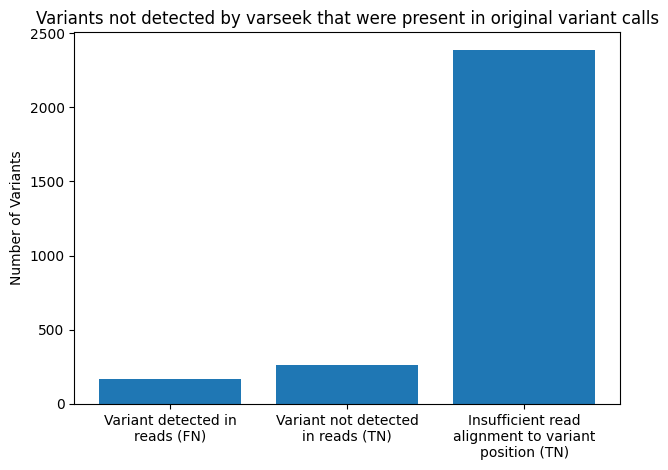

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"), title = 'Variants not detected by varseek that were present in original variant calls')

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                           | 0/22528 [00:00<?, ?it/s]

 30%|████████████████████████████████▎                                                                            | 6673/22528 [00:00<00:00, 66568.97it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 13330/22528 [00:00<00:00, 40478.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 17939/22528 [00:00<00:00, 24439.66it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 22201/22528 [00:00<00:00, 27894.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22528/22528 [00:00<00:00, 30566.56it/s]

Variants in vcrs_reference: 170
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000338895:c.910G>A',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000585156:c.6692C>G',
 'ENST00000585156:c.6471G>C',
 'ENST00000581821:c.709G>C',
 'ENST00000581822:c.924C>G',
 'ENST00000243611:c.756C>T',
 'ENST00000238181:c.457C>T',
 'ENST00000238181:c.458A>G',
 'ENST00000486442:c.1197T>C',
 'ENST00000456023:c.173G>C',
 'ENST00000353339:c.460A>T',
 'ENST00000353339:c.461G>T',
 'ENST00000349938:c.732A>G',
 'ENST00000349938:c.733T>A']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000338895:c.910G>A


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

GAGGAATTCCTGCGGGTCCTCGGCTCCATGTGCCAGAAGCTCCGGTCCATGCAGTACAATGGCAGCTACTTCGAC
GTCGAAGTAGCTGCCATTGTACTGCATGGACCGGAGCTTCTGGCACATGGAGCCGAGGACCCGCAGGAATTCCTC
GTCGAAGTAGCTGCCATTGTACTGCATGGACCGGAGCT
TTCTGGCACATGGAGCCGAGGACCCGCAGGAATTCCTC


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000344063:c.729G>A


TAAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACAACGGACTGATTCACCG
CGGTGAATCAGTCCGTTGTAGCGGAAGGAATTGCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTA


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                        | 0/66352376 [00:00<?, ?it/s]

  0%|                                                                                                          | 3796/66352376 [00:00<29:08, 37953.16it/s]

  0%|                                                                                                          | 7886/66352376 [00:00<27:51, 39680.76it/s]

  0%|                                                                                                         | 12150/66352376 [00:00<26:56, 41028.65it/s]

  0%|                                                                                                         | 16375/66352376 [00:00<26:38, 41507.19it/s]

  0%|                                                                                                         | 20604/66352376 [00:00<26:27, 41784.68it/s]

  0%|                                                                                                         | 24827/66352376 [00:00<26:21, 41933.87it/s]

  0%|                                                                                                         | 31998/66352376 [00:00<21:23, 51665.39it/s]

  0%|                                                                                                         | 38879/66352376 [00:00<19:20, 57120.36it/s]

  0%|                                                                                                         | 46376/66352376 [00:00<17:37, 62698.19it/s]

  0%|                                                                                                         | 53266/66352376 [00:01<17:06, 64609.09it/s]

  0%|                                                                                                         | 60804/66352376 [00:01<16:16, 67903.19it/s]

  0%|                                                                                                         | 68363/66352376 [00:01<15:43, 70239.06it/s]

  0%|                                                                                                         | 76171/66352376 [00:01<15:12, 72611.02it/s]

  0%|▏                                                                                                        | 84574/66352376 [00:01<14:31, 76057.46it/s]

  0%|▏                                                                                                        | 92217/66352376 [00:01<14:29, 76162.05it/s]

  0%|▏                                                                                                       | 100022/66352376 [00:01<14:23, 76726.86it/s]

  0%|▏                                                                                                       | 108295/66352376 [00:01<14:03, 78528.20it/s]

  0%|▏                                                                                                       | 116149/66352376 [00:01<14:03, 78526.20it/s]

  0%|▏                                                                                                       | 124023/66352376 [00:01<14:02, 78588.68it/s]

  0%|▏                                                                                                       | 132412/66352376 [00:02<13:45, 80178.59it/s]

  0%|▏                                                                                                       | 140430/66352376 [00:02<13:54, 79362.66it/s]

  0%|▏                                                                                                       | 148369/66352376 [00:02<14:02, 78618.82it/s]

  0%|▏                                                                                                       | 156241/66352376 [00:02<14:01, 78646.18it/s]

  0%|▎                                                                                                       | 164630/66352376 [00:02<13:45, 80203.28it/s]

  0%|▎                                                                                                       | 172653/66352376 [00:02<13:48, 79883.13it/s]

  0%|▎                                                                                                       | 180644/66352376 [00:02<13:53, 79430.90it/s]

  0%|▎                                                                                                       | 191418/66352376 [00:02<12:33, 87844.53it/s]

  0%|▎                                                                                                       | 202212/66352376 [00:02<11:44, 93831.59it/s]

  0%|▎                                                                                                       | 212508/66352376 [00:02<11:24, 96555.62it/s]

  0%|▎                                                                                                       | 223180/66352376 [00:03<11:03, 99593.31it/s]

  0%|▎                                                                                                      | 233840/66352376 [00:03<10:50, 101687.27it/s]

  0%|▍                                                                                                      | 244656/66352376 [00:03<10:37, 103623.28it/s]

  0%|▍                                                                                                      | 255092/66352376 [00:03<10:36, 103842.52it/s]

  0%|▍                                                                                                      | 265869/66352376 [00:03<10:29, 105016.12it/s]

  0%|▍                                                                                                      | 276842/66352376 [00:03<10:20, 106426.84it/s]

  0%|▍                                                                                                      | 287487/66352376 [00:03<10:27, 105350.10it/s]

  0%|▍                                                                                                      | 298370/66352376 [00:03<10:20, 106384.29it/s]

  0%|▍                                                                                                      | 309422/66352376 [00:03<10:13, 107616.93it/s]

  0%|▍                                                                                                      | 320301/66352376 [00:03<10:16, 107073.17it/s]

  0%|▌                                                                                                      | 331228/66352376 [00:04<10:12, 107724.28it/s]

  1%|▌                                                                                                      | 342161/66352376 [00:04<10:10, 108199.03it/s]

  1%|▌                                                                                                      | 353123/66352376 [00:04<10:07, 108621.02it/s]

  1%|▌                                                                                                      | 363987/66352376 [00:04<10:16, 106968.89it/s]

  1%|▌                                                                                                      | 374882/66352376 [00:04<10:13, 107552.70it/s]

  1%|▌                                                                                                      | 385826/66352376 [00:04<10:10, 108110.00it/s]

  1%|▌                                                                                                      | 396642/66352376 [00:04<10:19, 106500.58it/s]

  1%|▋                                                                                                      | 407748/66352376 [00:04<10:11, 107845.74it/s]

  1%|▋                                                                                                      | 418869/66352376 [00:04<10:05, 108841.40it/s]

  1%|▋                                                                                                      | 429760/66352376 [00:04<10:09, 108099.02it/s]

  1%|▋                                                                                                      | 440888/66352376 [00:05<10:04, 109040.22it/s]

  1%|▋                                                                                                      | 451797/66352376 [00:05<10:04, 108992.31it/s]

  1%|▋                                                                                                      | 462700/66352376 [00:05<10:24, 105475.52it/s]

  1%|▋                                                                                                      | 473273/66352376 [00:05<10:26, 105102.47it/s]

  1%|▊                                                                                                      | 484322/66352376 [00:05<10:17, 106682.17it/s]

  1%|▊                                                                                                      | 495006/66352376 [00:05<10:18, 106430.93it/s]

  1%|▊                                                                                                       | 505660/66352376 [00:05<14:30, 75638.63it/s]

  1%|▊                                                                                                       | 514463/66352376 [00:05<17:12, 63749.01it/s]

  1%|▊                                                                                                       | 521945/66352376 [00:06<18:24, 59603.85it/s]

  1%|▊                                                                                                       | 528665/66352376 [00:06<18:12, 60225.15it/s]

  1%|▊                                                                                                       | 535386/66352376 [00:06<17:44, 61837.30it/s]

  1%|▊                                                                                                       | 542004/66352376 [00:06<17:42, 61923.64it/s]

  1%|▊                                                                                                       | 548738/66352376 [00:06<17:19, 63324.23it/s]

  1%|▊                                                                                                       | 555507/66352376 [00:06<17:00, 64500.91it/s]

  1%|▉                                                                                                       | 563735/66352376 [00:06<15:47, 69447.00it/s]

  1%|▉                                                                                                       | 571436/66352376 [00:06<15:18, 71595.91it/s]

  1%|▉                                                                                                       | 579170/66352376 [00:06<14:57, 73253.45it/s]

  1%|▉                                                                                                       | 587146/66352376 [00:07<14:35, 75151.05it/s]

  1%|▉                                                                                                       | 594792/66352376 [00:07<14:30, 75532.32it/s]

  1%|▉                                                                                                       | 602541/66352376 [00:07<14:23, 76110.22it/s]

  1%|▉                                                                                                       | 610814/66352376 [00:07<14:02, 78075.08it/s]

  1%|▉                                                                                                       | 618649/66352376 [00:07<14:03, 77920.82it/s]

  1%|▉                                                                                                       | 626461/66352376 [00:07<14:04, 77860.16it/s]

  1%|▉                                                                                                       | 634713/66352376 [00:07<13:49, 79248.31it/s]

  1%|█                                                                                                       | 642648/66352376 [00:07<13:52, 78910.85it/s]

  1%|█                                                                                                       | 650547/66352376 [00:07<13:56, 78540.61it/s]

  1%|█                                                                                                       | 658864/66352376 [00:07<13:55, 78611.88it/s]

  1%|█                                                                                                       | 667214/66352376 [00:08<13:40, 80049.83it/s]

  1%|█                                                                                                       | 675224/66352376 [00:08<13:46, 79442.65it/s]

  1%|█                                                                                                       | 683173/66352376 [00:08<13:49, 79203.82it/s]

  1%|█                                                                                                       | 691533/66352376 [00:08<13:35, 80504.19it/s]

  1%|█                                                                                                       | 699587/66352376 [00:08<13:39, 80074.04it/s]

  1%|█                                                                                                       | 707597/66352376 [00:08<13:44, 79665.51it/s]

  1%|█                                                                                                       | 715566/66352376 [00:08<13:51, 78911.37it/s]

  1%|█▏                                                                                                      | 723883/66352376 [00:08<13:38, 80165.81it/s]

  1%|█▏                                                                                                      | 731903/66352376 [00:08<13:43, 79715.12it/s]

  1%|█▏                                                                                                      | 739877/66352376 [00:08<13:45, 79456.21it/s]

  1%|█▏                                                                                                      | 748258/66352376 [00:09<13:32, 80745.78it/s]

  1%|█▏                                                                                                      | 756336/66352376 [00:09<13:39, 80037.17it/s]

  1%|█▏                                                                                                      | 764343/66352376 [00:09<13:42, 79711.10it/s]

  1%|█▏                                                                                                      | 772316/66352376 [00:09<13:48, 79180.09it/s]

  1%|█▏                                                                                                      | 780463/66352376 [00:09<13:41, 79855.94it/s]

  1%|█▏                                                                                                      | 788451/66352376 [00:09<13:46, 79310.54it/s]

  1%|█▏                                                                                                      | 796384/66352376 [00:09<13:50, 78921.59it/s]

  1%|█▎                                                                                                      | 804609/66352376 [00:09<13:40, 79905.23it/s]

  1%|█▎                                                                                                      | 812602/66352376 [00:09<13:45, 79355.40it/s]

  1%|█▎                                                                                                      | 820540/66352376 [00:09<13:49, 79039.53it/s]

  1%|█▎                                                                                                      | 828446/66352376 [00:10<13:52, 78752.79it/s]

  1%|█▎                                                                                                      | 836671/66352376 [00:10<13:41, 79789.08it/s]

  1%|█▎                                                                                                      | 844652/66352376 [00:10<13:52, 78674.51it/s]

  1%|█▎                                                                                                      | 852524/66352376 [00:10<13:56, 78279.55it/s]

  1%|█▎                                                                                                      | 860789/66352376 [00:10<13:43, 79568.43it/s]

  1%|█▎                                                                                                      | 868750/66352376 [00:10<13:49, 78953.29it/s]

  1%|█▎                                                                                                      | 876649/66352376 [00:10<13:53, 78515.12it/s]

  1%|█▍                                                                                                      | 884641/66352376 [00:10<13:57, 78138.26it/s]

  1%|█▍                                                                                                      | 892820/66352376 [00:10<13:46, 79213.12it/s]

  1%|█▍                                                                                                      | 900745/66352376 [00:11<13:50, 78850.13it/s]

  1%|█▍                                                                                                      | 908633/66352376 [00:11<13:55, 78343.05it/s]

  1%|█▍                                                                                                      | 916906/66352376 [00:11<13:41, 79640.89it/s]

  1%|█▍                                                                                                      | 924873/66352376 [00:11<13:44, 79340.52it/s]

  1%|█▍                                                                                                      | 932810/66352376 [00:11<13:47, 79039.22it/s]

  1%|█▍                                                                                                      | 940930/66352376 [00:11<13:49, 78891.27it/s]

  1%|█▍                                                                                                      | 949223/66352376 [00:11<13:36, 80084.36it/s]

  1%|█▌                                                                                                      | 957234/66352376 [00:11<13:40, 79722.89it/s]

  1%|█▌                                                                                                      | 965209/66352376 [00:11<13:45, 79236.47it/s]

  1%|█▌                                                                                                      | 973483/66352376 [00:11<13:34, 80272.12it/s]

  1%|█▌                                                                                                      | 981513/66352376 [00:12<13:39, 79744.72it/s]

  1%|█▌                                                                                                      | 989490/66352376 [00:12<13:45, 79224.35it/s]

  2%|█▌                                                                                                      | 997415/66352376 [00:12<13:46, 79064.26it/s]

  2%|█▌                                                                                                     | 1005828/66352376 [00:12<13:31, 80564.79it/s]

  2%|█▌                                                                                                     | 1013887/66352376 [00:12<13:36, 80016.22it/s]

  2%|█▌                                                                                                     | 1021891/66352376 [00:12<13:39, 79724.62it/s]

  2%|█▌                                                                                                     | 1030179/66352376 [00:12<13:29, 80660.15it/s]

  2%|█▌                                                                                                     | 1038247/66352376 [00:12<13:40, 79644.69it/s]

  2%|█▌                                                                                                     | 1046216/66352376 [00:12<13:43, 79321.75it/s]

  2%|█▋                                                                                                     | 1054151/66352376 [00:12<13:47, 78911.31it/s]

  2%|█▋                                                                                                     | 1062622/66352376 [00:13<13:29, 80626.43it/s]

  2%|█▋                                                                                                     | 1070688/66352376 [00:13<13:35, 80037.03it/s]

  2%|█▋                                                                                                     | 1078695/66352376 [00:13<13:37, 79825.95it/s]

  2%|█▋                                                                                                     | 1086680/66352376 [00:13<13:38, 79745.07it/s]

  2%|█▋                                                                                                     | 1095149/66352376 [00:13<13:23, 81213.96it/s]

  2%|█▋                                                                                                     | 1103273/66352376 [00:13<13:31, 80451.72it/s]

  2%|█▋                                                                                                     | 1111321/66352376 [00:13<13:36, 79925.16it/s]

  2%|█▋                                                                                                     | 1119369/66352376 [00:13<13:36, 79929.34it/s]

  2%|█▊                                                                                                     | 1127883/66352376 [00:13<13:20, 81475.43it/s]

  2%|█▊                                                                                                     | 1136034/66352376 [00:13<13:25, 80931.12it/s]

  2%|█▊                                                                                                     | 1144130/66352376 [00:14<13:28, 80650.41it/s]

  2%|█▊                                                                                                     | 1152197/66352376 [00:14<13:33, 80114.69it/s]

  2%|█▊                                                                                                     | 1160590/66352376 [00:14<13:22, 81244.33it/s]

  2%|█▊                                                                                                     | 1168717/66352376 [00:14<13:26, 80801.54it/s]

  2%|█▊                                                                                                     | 1176799/66352376 [00:14<13:29, 80540.67it/s]

  2%|█▊                                                                                                     | 1184855/66352376 [00:14<13:31, 80303.47it/s]

  2%|█▊                                                                                                     | 1193173/66352376 [00:14<13:22, 81156.26it/s]

  2%|█▊                                                                                                     | 1201290/66352376 [00:14<13:27, 80731.46it/s]

  2%|█▉                                                                                                     | 1209365/66352376 [00:14<13:31, 80233.44it/s]

  2%|█▉                                                                                                     | 1217533/66352376 [00:14<13:35, 79878.68it/s]

  2%|█▉                                                                                                     | 1225797/66352376 [00:15<13:27, 80694.26it/s]

  2%|█▉                                                                                                     | 1233869/66352376 [00:15<13:35, 79851.67it/s]

  2%|█▉                                                                                                     | 1241857/66352376 [00:15<13:38, 79540.77it/s]

  2%|█▉                                                                                                     | 1250222/66352376 [00:15<13:39, 79412.58it/s]

  2%|█▉                                                                                                     | 1258559/66352376 [00:15<13:27, 80573.39it/s]

  2%|█▉                                                                                                     | 1266620/66352376 [00:15<13:32, 80073.67it/s]

  2%|█▉                                                                                                     | 1274630/66352376 [00:15<13:40, 79339.12it/s]

  2%|█▉                                                                                                     | 1282911/66352376 [00:15<13:45, 78841.55it/s]

  2%|██                                                                                                     | 1291243/66352376 [00:15<13:31, 80148.07it/s]

  2%|██                                                                                                     | 1299264/66352376 [00:15<13:37, 79605.57it/s]

  2%|██                                                                                                     | 1307229/66352376 [00:16<13:40, 79287.61it/s]

  2%|██                                                                                                     | 1315492/66352376 [00:16<13:30, 80272.12it/s]

  2%|██                                                                                                     | 1323523/66352376 [00:16<13:33, 79890.08it/s]

  2%|██                                                                                                     | 1331515/66352376 [00:16<13:38, 79422.83it/s]

  2%|██                                                                                                     | 1339459/66352376 [00:16<13:41, 79130.06it/s]

  2%|██                                                                                                     | 1347792/66352376 [00:16<13:28, 80373.19it/s]

  2%|██                                                                                                     | 1355832/66352376 [00:16<13:40, 79233.46it/s]

  2%|██                                                                                                     | 1363760/66352376 [00:16<13:42, 78986.57it/s]

  2%|██▏                                                                                                    | 1371922/66352376 [00:16<13:45, 78735.52it/s]

  2%|██▏                                                                                                    | 1380202/66352376 [00:17<13:32, 79930.50it/s]

  2%|██▏                                                                                                    | 1388199/66352376 [00:17<13:38, 79349.20it/s]

  2%|██▏                                                                                                    | 1396137/66352376 [00:17<13:44, 78813.63it/s]

  2%|██▏                                                                                                    | 1404576/66352376 [00:17<13:27, 80458.32it/s]

  2%|██▏                                                                                                    | 1412626/66352376 [00:17<13:33, 79780.67it/s]

  2%|██▏                                                                                                    | 1420608/66352376 [00:17<13:36, 79498.01it/s]

  2%|██▏                                                                                                    | 1428561/66352376 [00:17<13:40, 79135.26it/s]

  2%|██▏                                                                                                    | 1437005/66352376 [00:17<13:24, 80706.18it/s]

  2%|██▏                                                                                                    | 1445079/66352376 [00:17<13:28, 80265.36it/s]

  2%|██▎                                                                                                    | 1453108/66352376 [00:17<13:31, 79970.66it/s]

  2%|██▎                                                                                                    | 1461107/66352376 [00:18<13:34, 79711.83it/s]

  2%|██▎                                                                                                    | 1469437/66352376 [00:18<13:23, 80776.94it/s]

  2%|██▎                                                                                                    | 1477517/66352376 [00:18<13:31, 79905.11it/s]

  2%|██▎                                                                                                    | 1485511/66352376 [00:18<13:34, 79609.66it/s]

  2%|██▎                                                                                                    | 1493880/66352376 [00:18<13:36, 79473.23it/s]

  2%|██▎                                                                                                    | 1502280/66352376 [00:18<13:22, 80803.08it/s]

  2%|██▎                                                                                                    | 1510365/66352376 [00:18<13:29, 80060.64it/s]

  2%|██▎                                                                                                    | 1518375/66352376 [00:18<13:32, 79754.74it/s]

  2%|██▎                                                                                                    | 1526626/66352376 [00:18<13:35, 79515.54it/s]

  2%|██▍                                                                                                    | 1534947/66352376 [00:18<13:24, 80597.60it/s]

  2%|██▍                                                                                                    | 1543011/66352376 [00:19<13:36, 79397.15it/s]

  2%|██▍                                                                                                    | 1550956/66352376 [00:19<13:41, 78891.68it/s]

  2%|██▍                                                                                                    | 1559315/66352376 [00:19<13:40, 78997.19it/s]

  2%|██▍                                                                                                    | 1567734/66352376 [00:19<13:24, 80513.93it/s]

  2%|██▍                                                                                                    | 1575791/66352376 [00:19<13:28, 80070.98it/s]

  2%|██▍                                                                                                    | 1583802/66352376 [00:19<13:31, 79809.54it/s]

  2%|██▍                                                                                                    | 1592004/66352376 [00:19<13:34, 79488.94it/s]

  2%|██▍                                                                                                    | 1600328/66352376 [00:19<13:23, 80588.53it/s]

  2%|██▍                                                                                                    | 1608391/66352376 [00:19<13:27, 80196.84it/s]

  2%|██▌                                                                                                    | 1616414/66352376 [00:19<13:30, 79911.25it/s]

  2%|██▌                                                                                                    | 1624693/66352376 [00:20<13:31, 79761.30it/s]

  2%|██▌                                                                                                    | 1633033/66352376 [00:20<13:20, 80833.46it/s]

  2%|██▌                                                                                                    | 1641120/66352376 [00:20<13:24, 80401.86it/s]

  2%|██▌                                                                                                    | 1649163/66352376 [00:20<13:27, 80091.31it/s]

  2%|██▌                                                                                                    | 1657381/66352376 [00:20<13:32, 79613.47it/s]

  3%|██▌                                                                                                    | 1665732/66352376 [00:20<13:20, 80759.05it/s]

  3%|██▌                                                                                                    | 1673812/66352376 [00:20<13:27, 80050.82it/s]

  3%|██▌                                                                                                    | 1681821/66352376 [00:20<13:32, 79566.19it/s]

  3%|██▌                                                                                                    | 1690071/66352376 [00:20<13:34, 79382.57it/s]

  3%|██▋                                                                                                    | 1698398/66352376 [00:20<13:22, 80524.61it/s]

  3%|██▋                                                                                                    | 1706454/66352376 [00:21<13:28, 79940.90it/s]

  3%|██▋                                                                                                    | 1714451/66352376 [00:21<13:33, 79497.56it/s]

  3%|██▋                                                                                                    | 1722760/66352376 [00:21<13:22, 80558.65it/s]

  3%|██▋                                                                                                    | 1730819/66352376 [00:21<13:26, 80147.26it/s]

  3%|██▋                                                                                                    | 1738836/66352376 [00:21<13:30, 79682.01it/s]

  3%|██▋                                                                                                    | 1746806/66352376 [00:21<13:32, 79488.84it/s]

  3%|██▋                                                                                                    | 1755115/66352376 [00:21<13:21, 80556.61it/s]

  3%|██▋                                                                                                    | 1763173/66352376 [00:21<13:26, 80085.06it/s]

  3%|██▋                                                                                                    | 1771184/66352376 [00:21<13:30, 79715.58it/s]

  3%|██▊                                                                                                    | 1779238/66352376 [00:21<13:32, 79494.57it/s]

  3%|██▊                                                                                                    | 1787538/66352376 [00:22<13:21, 80531.18it/s]

  3%|██▊                                                                                                    | 1795593/66352376 [00:22<13:29, 79789.24it/s]

  3%|██▊                                                                                                    | 1803575/66352376 [00:22<13:31, 79576.84it/s]

  3%|██▊                                                                                                    | 1812015/66352376 [00:22<13:16, 81006.89it/s]

  3%|██▊                                                                                                    | 1820119/66352376 [00:22<13:21, 80493.10it/s]

  3%|██▊                                                                                                    | 1828171/66352376 [00:22<13:26, 80044.94it/s]

  3%|██▊                                                                                                    | 1836178/66352376 [00:22<13:33, 79321.66it/s]

  3%|██▊                                                                                                    | 1844592/66352376 [00:22<13:18, 80743.52it/s]

  3%|██▉                                                                                                    | 1852670/66352376 [00:22<13:27, 79909.46it/s]

  3%|██▉                                                                                                    | 1860665/66352376 [00:23<13:29, 79628.78it/s]

  3%|██▉                                                                                                    | 1868631/66352376 [00:23<13:32, 79401.17it/s]

  3%|██▉                                                                                                    | 1879120/66352376 [00:23<12:21, 86962.09it/s]

  3%|██▉                                                                                                    | 1889613/66352376 [00:23<11:38, 92309.63it/s]

  3%|██▉                                                                                                    | 1900137/66352376 [00:23<11:10, 96166.03it/s]

  3%|██▉                                                                                                    | 1910455/66352376 [00:23<10:55, 98259.20it/s]

  3%|██▉                                                                                                    | 1920293/66352376 [00:23<10:55, 98291.79it/s]

  3%|██▉                                                                                                   | 1930813/66352376 [00:23<10:41, 100357.77it/s]

  3%|██▉                                                                                                   | 1941339/66352376 [00:23<10:32, 101824.59it/s]

  3%|███                                                                                                   | 1951915/66352376 [00:23<10:25, 103001.02it/s]

  3%|███                                                                                                   | 1962218/66352376 [00:24<10:30, 102105.65it/s]

  3%|███                                                                                                   | 1972441/66352376 [00:24<10:30, 102140.41it/s]

  3%|███                                                                                                   | 1982972/66352376 [00:24<10:24, 103083.94it/s]

  3%|███                                                                                                   | 1993552/66352376 [00:24<10:19, 103893.06it/s]

  3%|███                                                                                                   | 2003944/66352376 [00:24<10:25, 102857.51it/s]

  3%|███                                                                                                   | 2014484/66352376 [00:24<10:20, 103608.30it/s]

  3%|███                                                                                                   | 2024848/66352376 [00:24<10:20, 103592.75it/s]

  3%|███▏                                                                                                  | 2035210/66352376 [00:24<10:21, 103425.86it/s]

  3%|███▏                                                                                                  | 2045627/66352376 [00:24<10:20, 103645.07it/s]

  3%|███▏                                                                                                  | 2055993/66352376 [00:24<10:26, 102587.16it/s]

  3%|███▏                                                                                                  | 2066582/66352376 [00:25<10:20, 103566.17it/s]

  3%|███▏                                                                                                  | 2076942/66352376 [00:25<10:20, 103532.14it/s]

  3%|███▏                                                                                                  | 2087427/66352376 [00:25<10:18, 103922.34it/s]

  3%|███▏                                                                                                  | 2097821/66352376 [00:25<10:31, 101718.61it/s]

  3%|███▏                                                                                                  | 2108411/66352376 [00:25<10:24, 102949.89it/s]

  3%|███▎                                                                                                  | 2119018/66352376 [00:25<10:18, 103871.56it/s]

  3%|███▎                                                                                                  | 2129414/66352376 [00:25<10:18, 103871.97it/s]

  3%|███▎                                                                                                  | 2139807/66352376 [00:25<10:19, 103628.62it/s]

  3%|███▎                                                                                                  | 2150641/66352376 [00:25<10:11, 105029.91it/s]

  3%|███▎                                                                                                  | 2161619/66352376 [00:25<10:03, 106446.09it/s]

  3%|███▎                                                                                                  | 2172302/66352376 [00:26<10:02, 106557.60it/s]

  3%|███▎                                                                                                  | 2182960/66352376 [00:26<10:14, 104430.29it/s]

  3%|███▎                                                                                                  | 2193523/66352376 [00:26<10:12, 104781.74it/s]

  3%|███▍                                                                                                  | 2204094/66352376 [00:26<10:10, 105051.02it/s]

  3%|███▍                                                                                                  | 2214605/66352376 [00:26<10:13, 104526.85it/s]

  3%|███▍                                                                                                  | 2225063/66352376 [00:26<10:21, 103260.33it/s]

  3%|███▍                                                                                                  | 2235395/66352376 [00:26<10:22, 103070.44it/s]

  3%|███▍                                                                                                  | 2245903/66352376 [00:26<10:18, 103662.72it/s]

  3%|███▍                                                                                                  | 2256376/66352376 [00:26<10:16, 103977.59it/s]

  3%|███▍                                                                                                  | 2266777/66352376 [00:26<10:25, 102521.06it/s]

  3%|███▌                                                                                                  | 2277172/66352376 [00:27<10:22, 102941.65it/s]

  3%|███▌                                                                                                  | 2287593/66352376 [00:27<10:20, 103316.60it/s]

  3%|███▌                                                                                                  | 2298014/66352376 [00:27<10:18, 103579.84it/s]

  3%|███▌                                                                                                  | 2308375/66352376 [00:27<10:23, 102651.62it/s]

  3%|███▌                                                                                                  | 2318875/66352376 [00:27<10:19, 103346.36it/s]

  4%|███▌                                                                                                  | 2329213/66352376 [00:27<10:21, 103070.94it/s]

  4%|███▌                                                                                                  | 2339594/66352376 [00:27<10:19, 103289.06it/s]

  4%|███▌                                                                                                  | 2350096/66352376 [00:27<10:16, 103797.63it/s]

  4%|███▋                                                                                                  | 2360478/66352376 [00:27<10:23, 102690.30it/s]

  4%|███▋                                                                                                  | 2370963/66352376 [00:27<10:19, 103329.27it/s]

  4%|███▋                                                                                                  | 2381484/66352376 [00:28<10:15, 103888.26it/s]

  4%|███▋                                                                                                  | 2391876/66352376 [00:28<10:18, 103425.82it/s]

  4%|███▋                                                                                                  | 2402221/66352376 [00:28<10:24, 102424.68it/s]

  4%|███▋                                                                                                  | 2412753/66352376 [00:28<10:19, 103280.65it/s]

  4%|███▋                                                                                                  | 2423228/66352376 [00:28<10:16, 103714.32it/s]

  4%|███▋                                                                                                  | 2433612/66352376 [00:28<10:16, 103748.59it/s]

  4%|███▊                                                                                                  | 2443989/66352376 [00:28<10:27, 101776.59it/s]

  4%|███▊                                                                                                  | 2454351/66352376 [00:28<10:24, 102318.52it/s]

  4%|███▊                                                                                                  | 2464903/66352376 [00:28<10:18, 103265.18it/s]

  4%|███▊                                                                                                  | 2475526/66352376 [00:28<10:13, 104145.88it/s]

  4%|███▊                                                                                                  | 2485946/66352376 [00:29<10:20, 102949.04it/s]

  4%|███▊                                                                                                  | 2496247/66352376 [00:29<10:25, 102149.01it/s]

  4%|███▊                                                                                                  | 2506467/66352376 [00:29<10:25, 102095.51it/s]

  4%|███▊                                                                                                  | 2517055/66352376 [00:29<10:18, 103216.94it/s]

  4%|███▉                                                                                                  | 2527573/66352376 [00:29<10:14, 103799.01it/s]

  4%|███▉                                                                                                  | 2537956/66352376 [00:29<10:29, 101391.73it/s]

  4%|███▉                                                                                                   | 2548109/66352376 [00:29<10:41, 99431.16it/s]

  4%|███▉                                                                                                   | 2558067/66352376 [00:29<10:48, 98362.55it/s]

  4%|███▉                                                                                                   | 2567914/66352376 [00:29<10:48, 98366.63it/s]

  4%|████                                                                                                   | 2578286/66352376 [00:29<10:38, 99938.97it/s]

  4%|███▉                                                                                                  | 2588822/66352376 [00:30<10:27, 101539.61it/s]

  4%|███▉                                                                                                  | 2598984/66352376 [00:30<10:32, 100868.28it/s]

  4%|████                                                                                                  | 2609566/66352376 [00:30<10:22, 102333.63it/s]

  4%|████                                                                                                  | 2620143/66352376 [00:30<10:16, 103353.73it/s]

  4%|████                                                                                                  | 2630512/66352376 [00:30<10:15, 103452.37it/s]

  4%|████                                                                                                  | 2640861/66352376 [00:30<10:20, 102626.20it/s]

  4%|████                                                                                                  | 2651280/66352376 [00:30<10:17, 103087.72it/s]

  4%|████                                                                                                  | 2661833/66352376 [00:30<10:13, 103812.65it/s]

  4%|████                                                                                                  | 2672301/66352376 [00:30<10:11, 104070.08it/s]

  4%|████                                                                                                  | 2682715/66352376 [00:30<10:11, 104085.16it/s]

  4%|████▏                                                                                                 | 2693125/66352376 [00:31<10:20, 102628.66it/s]

  4%|████▏                                                                                                 | 2703540/66352376 [00:31<10:17, 103076.12it/s]

  4%|████▏                                                                                                 | 2714119/66352376 [00:31<10:12, 103881.82it/s]

  4%|████▏                                                                                                 | 2724684/66352376 [00:31<10:09, 104406.20it/s]

  4%|████▏                                                                                                 | 2735128/66352376 [00:31<10:17, 102981.29it/s]

  4%|████▏                                                                                                 | 2745449/66352376 [00:31<10:17, 103046.90it/s]

  4%|████▏                                                                                                 | 2755910/66352376 [00:31<10:14, 103509.56it/s]

  4%|████▎                                                                                                 | 2766469/66352376 [00:31<10:10, 104128.03it/s]

  4%|████▎                                                                                                 | 2776885/66352376 [00:31<10:16, 103045.06it/s]

  4%|████▎                                                                                                 | 2787453/66352376 [00:32<10:12, 103825.45it/s]

  4%|████▎                                                                                                 | 2797909/66352376 [00:32<10:10, 104041.65it/s]

  4%|████▎                                                                                                 | 2808316/66352376 [00:32<10:11, 103979.78it/s]

  4%|████▎                                                                                                 | 2818716/66352376 [00:32<10:17, 102899.55it/s]

  4%|████▎                                                                                                 | 2829300/66352376 [00:32<10:12, 103771.19it/s]

  4%|████▎                                                                                                 | 2839887/66352376 [00:32<10:08, 104394.72it/s]

  4%|████▍                                                                                                 | 2850330/66352376 [00:32<10:08, 104293.73it/s]

  4%|████▍                                                                                                 | 2860762/66352376 [00:32<10:18, 102601.28it/s]

  4%|████▍                                                                                                 | 2871350/66352376 [00:32<10:12, 103567.95it/s]

  4%|████▍                                                                                                 | 2881959/66352376 [00:32<10:08, 104313.87it/s]

  4%|████▍                                                                                                 | 2892542/66352376 [00:33<10:05, 104763.40it/s]

  4%|████▍                                                                                                 | 2903023/66352376 [00:33<10:13, 103396.13it/s]

  4%|████▍                                                                                                 | 2913609/66352376 [00:33<10:09, 104122.20it/s]

  4%|████▍                                                                                                 | 2924307/66352376 [00:33<10:04, 104970.73it/s]

  4%|████▌                                                                                                 | 2934825/66352376 [00:33<10:03, 105030.91it/s]

  4%|████▌                                                                                                 | 2945332/66352376 [00:33<10:10, 103893.63it/s]

  4%|████▌                                                                                                 | 2955842/66352376 [00:33<10:08, 104249.75it/s]

  4%|████▌                                                                                                 | 2966430/66352376 [00:33<10:05, 104732.02it/s]

  4%|████▌                                                                                                 | 2977059/66352376 [00:33<10:02, 105195.15it/s]

  5%|████▌                                                                                                 | 2987581/66352376 [00:33<10:10, 103790.24it/s]

  5%|████▌                                                                                                 | 2998232/66352376 [00:34<10:05, 104594.37it/s]

  5%|████▋                                                                                                 | 3008747/66352376 [00:34<10:04, 104755.96it/s]

  5%|████▋                                                                                                 | 3019374/66352376 [00:34<10:01, 105205.39it/s]

  5%|████▋                                                                                                 | 3029898/66352376 [00:34<10:09, 103927.48it/s]

  5%|████▋                                                                                                 | 3040532/66352376 [00:34<10:05, 104641.36it/s]

  5%|████▋                                                                                                 | 3051084/66352376 [00:34<10:03, 104900.84it/s]

  5%|████▋                                                                                                 | 3061578/66352376 [00:34<10:06, 104415.25it/s]

  5%|████▋                                                                                                 | 3072023/66352376 [00:34<10:10, 103624.09it/s]

  5%|████▋                                                                                                 | 3082675/66352376 [00:34<10:05, 104482.51it/s]

  5%|████▊                                                                                                 | 3093227/66352376 [00:34<10:03, 104788.00it/s]

  5%|████▊                                                                                                 | 3103744/66352376 [00:35<10:10, 103657.04it/s]

  5%|████▊                                                                                                 | 3114181/66352376 [00:35<10:08, 103865.17it/s]

  5%|████▊                                                                                                 | 3124622/66352376 [00:35<10:07, 104025.64it/s]

  5%|████▊                                                                                                 | 3135213/66352376 [00:35<10:04, 104586.00it/s]

  5%|████▊                                                                                                 | 3145787/66352376 [00:35<10:02, 104927.79it/s]

  5%|████▊                                                                                                 | 3156282/66352376 [00:35<10:09, 103655.98it/s]

  5%|████▊                                                                                                 | 3166700/66352376 [00:35<10:08, 103808.97it/s]

  5%|████▉                                                                                                 | 3177297/66352376 [00:35<10:04, 104450.17it/s]

  5%|████▉                                                                                                 | 3187745/66352376 [00:35<10:05, 104368.06it/s]

  5%|████▉                                                                                                 | 3198184/66352376 [00:35<10:10, 103446.36it/s]

  5%|████▉                                                                                                 | 3208824/66352376 [00:36<10:05, 104322.15it/s]

  5%|████▉                                                                                                 | 3219313/66352376 [00:36<10:04, 104490.02it/s]

  5%|████▉                                                                                                 | 3229933/66352376 [00:36<10:01, 104997.41it/s]

  5%|████▉                                                                                                 | 3240435/66352376 [00:36<10:07, 103857.46it/s]

  5%|████▉                                                                                                 | 3250911/66352376 [00:36<10:06, 104123.50it/s]

  5%|█████                                                                                                 | 3261493/66352376 [00:36<10:03, 104623.43it/s]

  5%|█████                                                                                                 | 3271958/66352376 [00:36<10:05, 104211.14it/s]

  5%|█████                                                                                                 | 3282381/66352376 [00:36<10:10, 103298.72it/s]

  5%|█████                                                                                                 | 3292944/66352376 [00:36<10:06, 103988.03it/s]

  5%|█████                                                                                                 | 3303541/66352376 [00:36<10:02, 104574.96it/s]

  5%|█████                                                                                                 | 3314001/66352376 [00:37<10:02, 104552.04it/s]

  5%|█████                                                                                                 | 3324458/66352376 [00:37<10:11, 103137.22it/s]

  5%|█████▏                                                                                                | 3335002/66352376 [00:37<10:07, 103817.27it/s]

  5%|█████▏                                                                                                | 3345584/66352376 [00:37<10:03, 104410.13it/s]

  5%|█████▏                                                                                                | 3356051/66352376 [00:37<10:02, 104485.72it/s]

  5%|█████▏                                                                                                | 3366503/66352376 [00:37<10:11, 102948.78it/s]

  5%|█████▏                                                                                                | 3376897/66352376 [00:37<10:09, 103240.81it/s]

  5%|█████▏                                                                                                | 3387496/66352376 [00:37<10:05, 104055.62it/s]

  5%|█████▏                                                                                                | 3398101/66352376 [00:37<10:01, 104647.69it/s]

  5%|█████▏                                                                                                | 3408570/66352376 [00:37<10:07, 103547.88it/s]

  5%|█████▎                                                                                                | 3419088/66352376 [00:38<10:04, 104030.31it/s]

  5%|█████▎                                                                                                | 3429603/66352376 [00:38<10:02, 104361.05it/s]

  5%|█████▎                                                                                                | 3440042/66352376 [00:38<10:03, 104326.15it/s]

  5%|█████▎                                                                                                | 3450477/66352376 [00:38<10:08, 103437.12it/s]

  5%|█████▎                                                                                                | 3461056/66352376 [00:38<10:03, 104133.83it/s]

  5%|█████▎                                                                                                | 3471626/66352376 [00:38<10:01, 104599.30it/s]

  5%|█████▎                                                                                                | 3482090/66352376 [00:38<10:01, 104609.03it/s]

  5%|█████▎                                                                                                | 3492553/66352376 [00:38<10:07, 103546.80it/s]

  5%|█████▍                                                                                                | 3503015/66352376 [00:38<10:05, 103864.46it/s]

  5%|█████▍                                                                                                | 3513509/66352376 [00:38<10:03, 104182.01it/s]

  5%|█████▍                                                                                                | 3524056/66352376 [00:39<10:00, 104559.73it/s]

  5%|█████▍                                                                                                | 3534533/66352376 [00:39<10:07, 103331.49it/s]

  5%|█████▍                                                                                                | 3545123/66352376 [00:39<10:03, 104090.90it/s]

  5%|█████▍                                                                                                | 3555721/66352376 [00:39<10:00, 104651.58it/s]

  5%|█████▍                                                                                                | 3566195/66352376 [00:39<09:59, 104675.98it/s]

  5%|█████▍                                                                                                | 3576730/66352376 [00:39<09:58, 104874.23it/s]

  5%|█████▌                                                                                                | 3587220/66352376 [00:39<10:07, 103380.76it/s]

  5%|█████▌                                                                                                | 3597758/66352376 [00:39<10:03, 103970.17it/s]

  5%|█████▌                                                                                                | 3608365/66352376 [00:39<09:59, 104593.14it/s]

  5%|█████▌                                                                                                | 3618922/66352376 [00:39<10:05, 103593.57it/s]

  5%|█████▌                                                                                                | 3629381/66352376 [00:40<10:03, 103885.19it/s]

  5%|█████▌                                                                                                | 3639858/66352376 [00:40<10:02, 104145.98it/s]

  6%|█████▌                                                                                                | 3650461/66352376 [00:40<09:58, 104705.71it/s]

  6%|█████▋                                                                                                | 3660948/66352376 [00:40<10:04, 103664.02it/s]

  6%|█████▋                                                                                                | 3671537/66352376 [00:40<10:00, 104321.20it/s]

  6%|█████▋                                                                                                | 3682087/66352376 [00:40<09:58, 104669.89it/s]

  6%|█████▋                                                                                                | 3692557/66352376 [00:40<10:02, 104068.06it/s]

  6%|█████▋                                                                                                | 3702974/66352376 [00:40<10:07, 103159.07it/s]

  6%|█████▋                                                                                                | 3713618/66352376 [00:40<10:01, 104128.24it/s]

  6%|█████▋                                                                                                | 3724231/66352376 [00:41<09:58, 104720.34it/s]

  6%|█████▋                                                                                                | 3734752/66352376 [00:41<09:57, 104863.73it/s]

  6%|█████▊                                                                                                | 3745241/66352376 [00:41<10:06, 103183.67it/s]

  6%|█████▊                                                                                                | 3755723/66352376 [00:41<10:03, 103663.84it/s]

  6%|█████▊                                                                                                | 3766353/66352376 [00:41<09:59, 104445.49it/s]

  6%|█████▊                                                                                                | 3776920/66352376 [00:41<09:57, 104806.72it/s]

  6%|█████▊                                                                                                | 3787405/66352376 [00:41<10:04, 103470.55it/s]

  6%|█████▊                                                                                                | 3798010/66352376 [00:41<10:00, 104232.54it/s]

  6%|█████▊                                                                                                | 3808590/66352376 [00:41<09:57, 104695.11it/s]

  6%|█████▊                                                                                                | 3819124/66352376 [00:41<09:56, 104885.32it/s]

  6%|█████▉                                                                                                | 3829616/66352376 [00:42<10:02, 103735.30it/s]

  6%|█████▉                                                                                                | 3840041/66352376 [00:42<10:01, 103885.28it/s]

  6%|█████▉                                                                                                | 3850633/66352376 [00:42<09:58, 104488.63it/s]

  6%|█████▉                                                                                                | 3861198/66352376 [00:42<09:56, 104831.92it/s]

  6%|█████▉                                                                                                | 3871684/66352376 [00:42<10:03, 103533.67it/s]

  6%|█████▉                                                                                                | 3882245/66352376 [00:42<09:59, 104147.29it/s]

  6%|█████▉                                                                                                | 3892664/66352376 [00:42<10:00, 104057.41it/s]

  6%|██████                                                                                                | 3903251/66352376 [00:42<09:57, 104596.22it/s]

  6%|██████                                                                                                | 3913713/66352376 [00:42<09:57, 104565.83it/s]

  6%|██████                                                                                                | 3924172/66352376 [00:42<10:03, 103516.46it/s]

  6%|██████                                                                                                | 3934696/66352376 [00:43<10:00, 104025.20it/s]

  6%|██████                                                                                                | 3945102/66352376 [00:43<10:01, 103745.33it/s]

  6%|██████                                                                                                | 3955643/66352376 [00:43<09:58, 104239.46it/s]

  6%|██████                                                                                                | 3966069/66352376 [00:43<10:04, 103140.74it/s]

  6%|██████                                                                                                | 3976677/66352376 [00:43<09:59, 104009.73it/s]

  6%|██████▏                                                                                               | 3987252/66352376 [00:43<09:56, 104525.24it/s]

  6%|██████▏                                                                                               | 3997708/66352376 [00:43<09:58, 104211.34it/s]

  6%|██████▏                                                                                               | 4008132/66352376 [00:43<10:06, 102828.38it/s]

  6%|██████▏                                                                                               | 4018698/66352376 [00:43<10:01, 103663.00it/s]

  6%|██████▏                                                                                               | 4029310/66352376 [00:43<09:57, 104391.35it/s]

  6%|██████▏                                                                                               | 4039906/66352376 [00:44<09:54, 104857.12it/s]

  6%|██████▏                                                                                               | 4050395/66352376 [00:44<10:03, 103199.84it/s]

  6%|██████▏                                                                                               | 4060910/66352376 [00:44<10:00, 103772.44it/s]

  6%|██████▎                                                                                               | 4071491/66352376 [00:44<09:56, 104376.47it/s]

  6%|██████▎                                                                                               | 4082012/66352376 [00:44<10:02, 103372.06it/s]

  6%|██████▎                                                                                               | 4092683/66352376 [00:44<09:56, 104357.17it/s]

  6%|██████▎                                                                                               | 4103124/66352376 [00:44<09:57, 104198.08it/s]

  6%|██████▎                                                                                               | 4113723/66352376 [00:44<09:54, 104728.30it/s]

  6%|██████▎                                                                                               | 4124199/66352376 [00:44<10:03, 103096.11it/s]

  6%|██████▎                                                                                               | 4134786/66352376 [00:44<09:58, 103913.90it/s]

  6%|██████▎                                                                                               | 4145436/66352376 [00:45<09:54, 104679.20it/s]

  6%|██████▍                                                                                               | 4155909/66352376 [00:45<09:56, 104255.78it/s]

  6%|██████▍                                                                                               | 4166339/66352376 [00:45<10:03, 102969.35it/s]

  6%|██████▍                                                                                               | 4176990/66352376 [00:45<09:57, 104012.82it/s]

  6%|██████▍                                                                                               | 4187397/66352376 [00:45<09:59, 103751.73it/s]

  6%|██████▍                                                                                               | 4197776/66352376 [00:45<10:05, 102726.54it/s]

  6%|██████▍                                                                                               | 4208053/66352376 [00:45<10:12, 101542.17it/s]

  6%|██████▌                                                                                                | 4218212/66352376 [00:45<10:22, 99780.56it/s]

  6%|██████▌                                                                                                | 4228198/66352376 [00:45<10:22, 99725.42it/s]

  6%|██████▌                                                                                                | 4238176/66352376 [00:45<10:28, 98895.41it/s]

  6%|██████▌                                                                                                | 4248070/66352376 [00:46<10:33, 98055.84it/s]

  6%|██████▌                                                                                                | 4257879/66352376 [00:46<10:38, 97266.05it/s]

  6%|██████▋                                                                                                | 4267918/66352376 [00:46<10:32, 98183.27it/s]

  6%|██████▌                                                                                               | 4278405/66352376 [00:46<10:19, 100159.12it/s]

  6%|██████▌                                                                                               | 4288503/66352376 [00:46<10:18, 100401.38it/s]

  6%|██████▌                                                                                               | 4299067/66352376 [00:46<10:08, 101960.36it/s]

  6%|██████▌                                                                                               | 4309267/66352376 [00:46<10:08, 101958.80it/s]

  7%|██████▋                                                                                               | 4319865/66352376 [00:46<10:01, 103157.59it/s]

  7%|██████▋                                                                                               | 4330359/66352376 [00:46<10:05, 102373.49it/s]

  7%|██████▋                                                                                               | 4340857/66352376 [00:46<10:01, 103145.29it/s]

  7%|██████▋                                                                                               | 4351490/66352376 [00:47<09:55, 104090.51it/s]

  7%|██████▋                                                                                               | 4361915/66352376 [00:47<09:55, 104134.43it/s]

  7%|██████▋                                                                                               | 4372331/66352376 [00:47<09:57, 103785.77it/s]

  7%|██████▋                                                                                               | 4382712/66352376 [00:47<10:00, 103239.70it/s]

  7%|██████▊                                                                                               | 4393114/66352376 [00:47<09:58, 103469.33it/s]

  7%|██████▊                                                                                               | 4403755/66352376 [00:47<09:53, 104344.62it/s]

  7%|██████▊                                                                                               | 4414191/66352376 [00:47<09:55, 103979.32it/s]

  7%|██████▊                                                                                               | 4424591/66352376 [00:47<10:01, 103026.46it/s]

  7%|██████▊                                                                                               | 4435109/66352376 [00:47<09:57, 103663.18it/s]

  7%|██████▊                                                                                               | 4445729/66352376 [00:47<09:52, 104417.29it/s]

  7%|██████▊                                                                                               | 4456279/66352376 [00:48<09:50, 104738.74it/s]

  7%|██████▊                                                                                               | 4466755/66352376 [00:48<09:59, 103283.08it/s]

  7%|██████▉                                                                                               | 4477331/66352376 [00:48<09:54, 104015.63it/s]

  7%|██████▉                                                                                               | 4487898/66352376 [00:48<09:51, 104505.03it/s]

  7%|██████▉                                                                                               | 4498353/66352376 [00:48<09:52, 104403.57it/s]

  7%|██████▉                                                                                               | 4508796/66352376 [00:48<09:58, 103273.61it/s]

  7%|██████▉                                                                                               | 4519267/66352376 [00:48<09:56, 103697.92it/s]

  7%|██████▉                                                                                               | 4529857/66352376 [00:48<09:52, 104351.54it/s]

  7%|██████▉                                                                                               | 4540400/66352376 [00:48<09:50, 104669.82it/s]

  7%|██████▉                                                                                               | 4550870/66352376 [00:49<09:58, 103345.05it/s]

  7%|███████                                                                                               | 4561413/66352376 [00:49<09:54, 103959.74it/s]

  7%|███████                                                                                               | 4571891/66352376 [00:49<09:52, 104200.43it/s]

  7%|███████                                                                                               | 4582458/66352376 [00:49<09:50, 104636.77it/s]

  7%|███████                                                                                               | 4592925/66352376 [00:49<09:56, 103608.37it/s]

  7%|███████                                                                                               | 4603558/66352376 [00:49<09:51, 104414.51it/s]

  7%|███████                                                                                               | 4614003/66352376 [00:49<09:52, 104159.21it/s]

  7%|███████                                                                                               | 4624471/66352376 [00:49<09:51, 104311.40it/s]

  7%|███████                                                                                               | 4634904/66352376 [00:49<09:58, 103187.52it/s]

  7%|███████▏                                                                                              | 4645495/66352376 [00:49<09:53, 103992.26it/s]

  7%|███████▏                                                                                              | 4656085/66352376 [00:50<09:50, 104558.23it/s]

  7%|███████▏                                                                                              | 4666544/66352376 [00:50<09:53, 104010.20it/s]

  7%|███████▏                                                                                              | 4676948/66352376 [00:50<09:59, 102879.49it/s]

  7%|███████▏                                                                                              | 4687515/66352376 [00:50<09:54, 103703.50it/s]

  7%|███████▏                                                                                              | 4698205/66352376 [00:50<09:49, 104652.05it/s]

  7%|███████▏                                                                                              | 4708728/66352376 [00:50<09:48, 104823.01it/s]

  7%|███████▎                                                                                              | 4719213/66352376 [00:50<09:57, 103224.54it/s]

  7%|███████▎                                                                                              | 4729763/66352376 [00:50<09:53, 103895.44it/s]

  7%|███████▎                                                                                              | 4740268/66352376 [00:50<09:51, 104236.82it/s]

  7%|███████▎                                                                                              | 4750782/66352376 [00:50<09:49, 104504.53it/s]

  7%|███████▎                                                                                              | 4761236/66352376 [00:51<09:57, 103149.88it/s]

  7%|███████▎                                                                                              | 4771580/66352376 [00:51<09:56, 103234.10it/s]

  7%|███████▎                                                                                              | 4782207/66352376 [00:51<09:51, 104135.23it/s]

  7%|███████▎                                                                                              | 4792768/66352376 [00:51<09:48, 104571.75it/s]

  7%|███████▍                                                                                              | 4803228/66352376 [00:51<09:57, 102977.89it/s]

  7%|███████▍                                                                                              | 4813773/66352376 [00:51<09:53, 103707.32it/s]

  7%|███████▍                                                                                              | 4824223/66352376 [00:51<09:51, 103940.26it/s]

  7%|███████▍                                                                                              | 4834736/66352376 [00:51<09:49, 104293.36it/s]

  7%|███████▍                                                                                              | 4845169/66352376 [00:51<09:56, 103040.44it/s]

  7%|███████▍                                                                                              | 4855689/66352376 [00:51<09:53, 103676.62it/s]

  7%|███████▍                                                                                              | 4866254/66352376 [00:52<09:49, 104260.68it/s]

  7%|███████▍                                                                                              | 4876684/66352376 [00:52<09:50, 104088.37it/s]

  7%|███████▌                                                                                              | 4887121/66352376 [00:52<09:55, 103178.70it/s]

  7%|███████▌                                                                                              | 4897739/66352376 [00:52<09:50, 104066.11it/s]

  7%|███████▌                                                                                              | 4908293/66352376 [00:52<09:47, 104502.53it/s]

  7%|███████▌                                                                                              | 4918746/66352376 [00:52<09:55, 103204.27it/s]

  7%|███████▌                                                                                              | 4929072/66352376 [00:52<09:59, 102390.49it/s]

  7%|███████▌                                                                                              | 4939315/66352376 [00:52<10:09, 100755.92it/s]

  7%|███████▌                                                                                              | 4949473/66352376 [00:52<10:07, 100996.07it/s]

  7%|███████▌                                                                                              | 4959645/66352376 [00:52<10:06, 101206.80it/s]

  7%|███████▋                                                                                              | 4969770/66352376 [00:53<10:06, 101190.51it/s]

  8%|███████▋                                                                                              | 4979892/66352376 [00:53<10:10, 100576.31it/s]

  8%|███████▋                                                                                              | 4990028/66352376 [00:53<10:08, 100806.89it/s]

  8%|███████▊                                                                                               | 5000111/66352376 [00:53<10:15, 99739.23it/s]

  8%|███████▋                                                                                              | 5010383/66352376 [00:53<10:09, 100619.14it/s]

  8%|███████▋                                                                                              | 5020607/66352376 [00:53<10:06, 101098.22it/s]

  8%|███████▋                                                                                              | 5030720/66352376 [00:53<10:08, 100781.16it/s]

  8%|███████▋                                                                                              | 5040801/66352376 [00:53<10:08, 100728.87it/s]

  8%|███████▊                                                                                              | 5051010/66352376 [00:53<10:06, 101131.82it/s]

  8%|███████▊                                                                                               | 5061125/66352376 [00:53<10:14, 99811.88it/s]

  8%|███████▊                                                                                              | 5071392/66352376 [00:54<10:08, 100657.14it/s]

  8%|███████▊                                                                                              | 5081462/66352376 [00:54<10:10, 100426.77it/s]

  8%|███████▊                                                                                              | 5091575/66352376 [00:54<10:08, 100634.20it/s]

  8%|███████▊                                                                                              | 5101669/66352376 [00:54<10:08, 100722.98it/s]

  8%|███████▊                                                                                              | 5111810/66352376 [00:54<10:06, 100926.99it/s]

  8%|███████▉                                                                                               | 5121904/66352376 [00:54<10:14, 99671.91it/s]

  8%|███████▉                                                                                               | 5131908/66352376 [00:54<10:13, 99778.09it/s]

  8%|███████▉                                                                                              | 5142036/66352376 [00:54<10:10, 100222.56it/s]

  8%|███████▉                                                                                              | 5152140/66352376 [00:54<10:09, 100463.89it/s]

  8%|███████▉                                                                                              | 5162189/66352376 [00:54<10:09, 100347.15it/s]

  8%|███████▉                                                                                              | 5172333/66352376 [00:55<10:07, 100671.97it/s]

  8%|████████                                                                                               | 5182402/66352376 [00:55<10:15, 99372.41it/s]

  8%|████████                                                                                               | 5192504/66352376 [00:55<10:12, 99858.62it/s]

  8%|███████▉                                                                                              | 5202782/66352376 [00:55<10:07, 100725.11it/s]

  8%|████████                                                                                              | 5212858/66352376 [00:55<10:08, 100558.34it/s]

  8%|████████                                                                                              | 5223053/66352376 [00:55<10:05, 100972.35it/s]

  8%|████████                                                                                              | 5233152/66352376 [00:55<10:07, 100675.70it/s]

  8%|████████▏                                                                                              | 5243221/66352376 [00:55<10:13, 99540.71it/s]

  8%|████████                                                                                              | 5253334/66352376 [00:55<10:10, 100010.81it/s]

  8%|████████                                                                                              | 5263567/66352376 [00:55<10:06, 100699.44it/s]

  8%|████████                                                                                              | 5273640/66352376 [00:56<10:07, 100548.59it/s]

  8%|████████                                                                                              | 5283697/66352376 [00:56<10:08, 100396.88it/s]

  8%|████████▏                                                                                             | 5293920/66352376 [00:56<10:04, 100941.24it/s]

  8%|████████▏                                                                                              | 5304016/66352376 [00:56<10:11, 99856.36it/s]

  8%|████████▏                                                                                             | 5314264/66352376 [00:56<10:06, 100634.66it/s]

  8%|████████▏                                                                                             | 5324342/66352376 [00:56<10:06, 100674.63it/s]

  8%|████████▏                                                                                             | 5334412/66352376 [00:56<10:06, 100651.86it/s]

  8%|████████▏                                                                                             | 5344922/66352376 [00:56<09:58, 101979.16it/s]

  8%|████████▏                                                                                             | 5355375/66352376 [00:56<10:02, 101309.31it/s]

  8%|████████▏                                                                                             | 5366029/66352376 [00:56<09:52, 102858.04it/s]

  8%|████████▎                                                                                             | 5376478/66352376 [00:57<09:50, 103341.39it/s]

  8%|████████▎                                                                                             | 5386816/66352376 [00:57<09:50, 103285.73it/s]

  8%|████████▎                                                                                             | 5397155/66352376 [00:57<09:49, 103314.25it/s]

  8%|████████▎                                                                                             | 5407488/66352376 [00:57<09:56, 102148.51it/s]

  8%|████████▎                                                                                             | 5417916/66352376 [00:57<09:52, 102778.29it/s]

  8%|████████▎                                                                                             | 5428446/66352376 [00:57<09:48, 103526.55it/s]

  8%|████████▎                                                                                             | 5438802/66352376 [00:57<09:49, 103251.17it/s]

  8%|████████▍                                                                                             | 5449130/66352376 [00:57<09:57, 102000.77it/s]

  8%|████████▍                                                                                             | 5459648/66352376 [00:57<09:51, 102939.78it/s]

  8%|████████▍                                                                                             | 5470256/66352376 [00:57<09:46, 103870.13it/s]

  8%|████████▍                                                                                             | 5480668/66352376 [00:58<09:45, 103942.15it/s]

  8%|████████▍                                                                                             | 5491065/66352376 [00:58<09:45, 103913.94it/s]

  8%|████████▍                                                                                             | 5501459/66352376 [00:58<09:54, 102320.53it/s]

  8%|████████▍                                                                                             | 5512099/66352376 [00:58<09:47, 103525.21it/s]

  8%|████████▍                                                                                             | 5522582/66352376 [00:58<09:45, 103910.78it/s]

  8%|████████▌                                                                                             | 5533096/66352376 [00:58<09:43, 104273.62it/s]

  8%|████████▌                                                                                             | 5543527/66352376 [00:58<09:53, 102388.50it/s]

  8%|████████▌                                                                                             | 5554083/66352376 [00:58<09:48, 103323.17it/s]

  8%|████████▌                                                                                             | 5564448/66352376 [00:58<09:47, 103417.29it/s]

  8%|████████▌                                                                                             | 5574893/66352376 [00:59<09:45, 103721.15it/s]

  8%|████████▌                                                                                             | 5585270/66352376 [00:59<09:57, 101784.83it/s]

  8%|████████▌                                                                                             | 5595724/66352376 [00:59<09:52, 102595.52it/s]

  8%|████████▌                                                                                             | 5606244/66352376 [00:59<09:47, 103366.30it/s]

  8%|████████▋                                                                                             | 5616804/66352376 [00:59<09:43, 104027.44it/s]

  8%|████████▋                                                                                             | 5627213/66352376 [00:59<09:51, 102653.79it/s]

  8%|████████▋                                                                                             | 5637705/66352376 [00:59<09:47, 103321.10it/s]

  9%|████████▋                                                                                             | 5648182/66352376 [00:59<09:45, 103748.48it/s]

  9%|████████▋                                                                                             | 5658699/66352376 [00:59<09:42, 104170.02it/s]

  9%|████████▋                                                                                             | 5669120/66352376 [00:59<09:48, 103201.88it/s]

  9%|████████▋                                                                                             | 5679825/66352376 [01:00<09:41, 104338.10it/s]

  9%|████████▋                                                                                             | 5690263/66352376 [01:00<09:43, 103925.53it/s]

  9%|████████▊                                                                                             | 5700990/66352376 [01:00<09:38, 104918.13it/s]

  9%|████████▊                                                                                             | 5711485/66352376 [01:00<09:43, 103877.80it/s]

  9%|████████▊                                                                                             | 5722207/66352376 [01:00<09:38, 104867.69it/s]

  9%|████████▊                                                                                             | 5732746/66352376 [01:00<09:37, 105020.83it/s]

  9%|████████▊                                                                                             | 5743251/66352376 [01:00<09:38, 104828.58it/s]

  9%|████████▊                                                                                             | 5753736/66352376 [01:00<09:46, 103301.07it/s]

  9%|████████▊                                                                                             | 5764418/66352376 [01:00<09:40, 104338.64it/s]

  9%|████████▉                                                                                             | 5775002/66352376 [01:00<09:38, 104781.49it/s]

  9%|████████▉                                                                                             | 5785595/66352376 [01:01<09:36, 105122.29it/s]

  9%|████████▉                                                                                             | 5796111/66352376 [01:01<09:44, 103558.62it/s]

  9%|████████▉                                                                                             | 5806753/66352376 [01:01<09:39, 104402.41it/s]

  9%|████████▉                                                                                             | 5817200/66352376 [01:01<09:39, 104379.56it/s]

  9%|████████▉                                                                                             | 5827788/66352376 [01:01<09:37, 104824.34it/s]

  9%|████████▉                                                                                             | 5838274/66352376 [01:01<09:43, 103682.99it/s]

  9%|████████▉                                                                                             | 5848719/66352376 [01:01<09:42, 103906.94it/s]

  9%|█████████                                                                                             | 5859310/66352376 [01:01<09:38, 104499.94it/s]

  9%|█████████                                                                                             | 5869955/66352376 [01:01<09:35, 105079.93it/s]

  9%|█████████                                                                                             | 5880466/66352376 [01:01<09:52, 102027.76it/s]

  9%|█████████                                                                                             | 5890689/66352376 [01:02<09:52, 102055.18it/s]

  9%|█████████                                                                                             | 5900909/66352376 [01:02<09:53, 101798.21it/s]

  9%|█████████                                                                                             | 5911286/66352376 [01:02<09:50, 102379.05it/s]

  9%|█████████                                                                                             | 5921532/66352376 [01:02<10:04, 100006.74it/s]

  9%|█████████▏                                                                                             | 5931549/66352376 [01:02<10:07, 99468.23it/s]

  9%|█████████▏                                                                                             | 5941507/66352376 [01:02<10:08, 99316.98it/s]

  9%|█████████▏                                                                                             | 5951446/66352376 [01:02<10:10, 98971.01it/s]

  9%|█████████▏                                                                                            | 5961803/66352376 [01:02<10:01, 100330.83it/s]

  9%|█████████▏                                                                                            | 5972401/66352376 [01:02<09:51, 102007.22it/s]

  9%|█████████▏                                                                                            | 5982607/66352376 [01:02<09:54, 101491.22it/s]

  9%|█████████▏                                                                                            | 5993178/66352376 [01:03<09:47, 102743.89it/s]

  9%|█████████▏                                                                                            | 6003697/66352376 [01:03<09:43, 103469.97it/s]

  9%|█████████▏                                                                                            | 6014176/66352376 [01:03<09:40, 103862.00it/s]

  9%|█████████▎                                                                                            | 6024710/66352376 [01:03<09:45, 102981.50it/s]

  9%|█████████▎                                                                                            | 6035409/66352376 [01:03<09:39, 104167.75it/s]

  9%|█████████▎                                                                                            | 6046007/66352376 [01:03<09:35, 104705.85it/s]

  9%|█████████▎                                                                                            | 6056481/66352376 [01:03<09:36, 104569.37it/s]

  9%|█████████▎                                                                                            | 6066941/66352376 [01:03<09:42, 103559.40it/s]

  9%|█████████▎                                                                                            | 6077487/66352376 [01:03<09:38, 104120.79it/s]

  9%|█████████▎                                                                                            | 6088128/66352376 [01:03<09:35, 104799.23it/s]

  9%|█████████▍                                                                                            | 6098737/66352376 [01:04<09:32, 105183.04it/s]

  9%|█████████▍                                                                                            | 6109258/66352376 [01:04<09:41, 103540.48it/s]

  9%|█████████▍                                                                                            | 6119873/66352376 [01:04<09:37, 104309.11it/s]

  9%|█████████▍                                                                                            | 6130578/66352376 [01:04<09:32, 105120.68it/s]

  9%|█████████▍                                                                                            | 6141095/66352376 [01:04<09:34, 104863.47it/s]

  9%|█████████▍                                                                                            | 6151585/66352376 [01:04<09:40, 103713.05it/s]

  9%|█████████▍                                                                                            | 6162122/66352376 [01:04<09:37, 104200.58it/s]

  9%|█████████▍                                                                                            | 6172707/66352376 [01:04<09:34, 104688.76it/s]

  9%|█████████▌                                                                                            | 6183263/66352376 [01:04<09:33, 104945.58it/s]

  9%|█████████▌                                                                                            | 6193760/66352376 [01:04<09:38, 103971.28it/s]

  9%|█████████▌                                                                                            | 6204246/66352376 [01:05<09:37, 104233.31it/s]

  9%|█████████▌                                                                                            | 6214672/66352376 [01:05<09:37, 104066.51it/s]

  9%|█████████▌                                                                                            | 6225081/66352376 [01:05<09:41, 103433.26it/s]

  9%|█████████▌                                                                                            | 6235427/66352376 [01:05<09:49, 101952.80it/s]

  9%|█████████▌                                                                                            | 6246001/66352376 [01:05<09:43, 103068.78it/s]

  9%|█████████▌                                                                                            | 6256691/66352376 [01:05<09:36, 104202.42it/s]

  9%|█████████▋                                                                                            | 6267117/66352376 [01:05<09:38, 103774.46it/s]

  9%|█████████▋                                                                                            | 6277498/66352376 [01:05<09:44, 102734.08it/s]

  9%|█████████▋                                                                                            | 6287776/66352376 [01:05<09:46, 102420.84it/s]

  9%|█████████▋                                                                                            | 6298021/66352376 [01:06<09:49, 101820.64it/s]

 10%|█████████▋                                                                                            | 6308459/66352376 [01:06<09:46, 102342.11it/s]

 10%|█████████▋                                                                                            | 6318905/66352376 [01:06<09:43, 102967.48it/s]

 10%|█████████▋                                                                                            | 6329204/66352376 [01:06<09:50, 101710.15it/s]

 10%|█████████▋                                                                                            | 6339379/66352376 [01:06<09:50, 101624.82it/s]

 10%|█████████▊                                                                                            | 6349840/66352376 [01:06<09:45, 102508.04it/s]

 10%|█████████▊                                                                                            | 6360094/66352376 [01:06<09:46, 102295.24it/s]

 10%|█████████▊                                                                                            | 6370406/66352376 [01:06<09:44, 102537.06it/s]

 10%|█████████▊                                                                                            | 6380662/66352376 [01:06<09:51, 101309.50it/s]

 10%|█████████▊                                                                                            | 6391102/66352376 [01:06<09:46, 102223.02it/s]

 10%|█████████▊                                                                                            | 6401329/66352376 [01:07<09:47, 102107.30it/s]

 10%|█████████▊                                                                                            | 6411606/66352376 [01:07<09:45, 102301.91it/s]

 10%|█████████▊                                                                                            | 6422200/66352376 [01:07<09:39, 103386.26it/s]

 10%|█████████▉                                                                                            | 6432541/66352376 [01:07<09:45, 102378.46it/s]

 10%|█████████▉                                                                                            | 6443240/66352376 [01:07<09:37, 103748.20it/s]

 10%|█████████▉                                                                                            | 6453619/66352376 [01:07<09:37, 103696.58it/s]

 10%|█████████▉                                                                                            | 6463992/66352376 [01:07<09:38, 103564.70it/s]

 10%|█████████▉                                                                                            | 6474351/66352376 [01:07<09:42, 102793.82it/s]

 10%|█████████▉                                                                                            | 6484901/66352376 [01:07<09:37, 103595.46it/s]

 10%|█████████▉                                                                                            | 6495565/66352376 [01:07<09:32, 104500.12it/s]

 10%|██████████                                                                                            | 6506178/66352376 [01:08<09:30, 104980.65it/s]

 10%|██████████                                                                                            | 6516678/66352376 [01:08<09:39, 103233.93it/s]

 10%|██████████                                                                                            | 6527253/66352376 [01:08<09:35, 103974.92it/s]

 10%|██████████                                                                                            | 6537847/66352376 [01:08<09:32, 104557.41it/s]

 10%|██████████                                                                                            | 6548432/66352376 [01:08<09:29, 104941.30it/s]

 10%|██████████                                                                                            | 6558930/66352376 [01:08<09:36, 103682.43it/s]

 10%|██████████                                                                                            | 6569445/66352376 [01:08<09:34, 104114.57it/s]

 10%|██████████                                                                                            | 6580026/66352376 [01:08<09:31, 104616.53it/s]

 10%|██████████▏                                                                                           | 6590554/66352376 [01:08<09:30, 104811.30it/s]

 10%|██████████▏                                                                                           | 6601038/66352376 [01:08<09:36, 103676.73it/s]

 10%|██████████▏                                                                                           | 6611723/66352376 [01:09<09:31, 104615.44it/s]

 10%|██████████▏                                                                                           | 6622189/66352376 [01:09<09:32, 104311.71it/s]

 10%|██████████▏                                                                                           | 6632768/66352376 [01:09<09:30, 104750.42it/s]

 10%|██████████▏                                                                                           | 6643246/66352376 [01:09<09:35, 103793.16it/s]

 10%|██████████▏                                                                                           | 6653853/66352376 [01:09<09:31, 104465.74it/s]

 10%|██████████▏                                                                                           | 6664433/66352376 [01:09<09:29, 104861.20it/s]

 10%|██████████▎                                                                                           | 6674922/66352376 [01:09<09:29, 104702.61it/s]

 10%|██████████▎                                                                                           | 6685394/66352376 [01:09<09:35, 103603.55it/s]

 10%|██████████▎                                                                                           | 6695997/66352376 [01:09<09:31, 104320.09it/s]

 10%|██████████▎                                                                                           | 6706628/66352376 [01:09<09:28, 104910.99it/s]

 10%|██████████▎                                                                                           | 6717122/66352376 [01:10<09:28, 104818.77it/s]

 10%|██████████▎                                                                                           | 6727606/66352376 [01:10<09:38, 103138.76it/s]

 10%|██████████▎                                                                                           | 6738330/66352376 [01:10<09:31, 104349.95it/s]

 10%|██████████▎                                                                                           | 6748907/66352376 [01:10<09:28, 104770.14it/s]

 10%|██████████▍                                                                                           | 6759501/66352376 [01:10<09:26, 105116.84it/s]

 10%|██████████▍                                                                                           | 6770017/66352376 [01:10<09:33, 103882.46it/s]

 10%|██████████▍                                                                                           | 6780444/66352376 [01:10<09:32, 103995.46it/s]

 10%|██████████▍                                                                                           | 6790980/66352376 [01:10<09:30, 104400.04it/s]

 10%|██████████▍                                                                                           | 6801587/66352376 [01:10<09:27, 104895.75it/s]

 10%|██████████▍                                                                                           | 6812079/66352376 [01:10<09:34, 103602.42it/s]

 10%|██████████▍                                                                                           | 6822748/66352376 [01:11<09:29, 104515.70it/s]

 10%|██████████▌                                                                                           | 6833205/66352376 [01:11<09:30, 104372.99it/s]

 10%|██████████▌                                                                                           | 6843646/66352376 [01:11<09:38, 102887.56it/s]

 10%|██████████▌                                                                                           | 6854249/66352376 [01:11<09:33, 103815.05it/s]

 10%|██████████▌                                                                                           | 6864943/66352376 [01:11<09:27, 104740.13it/s]

 10%|██████████▌                                                                                           | 6875527/66352376 [01:11<09:26, 105065.91it/s]

 10%|██████████▌                                                                                           | 6886038/66352376 [01:11<09:34, 103427.68it/s]

 10%|██████████▌                                                                                           | 6896481/66352376 [01:11<09:33, 103721.96it/s]

 10%|██████████▌                                                                                           | 6907137/66352376 [01:11<09:28, 104562.92it/s]

 10%|██████████▋                                                                                           | 6917739/66352376 [01:11<09:26, 104994.29it/s]

 10%|██████████▋                                                                                           | 6928243/66352376 [01:12<09:31, 103890.23it/s]

 10%|██████████▋                                                                                           | 6938731/66352376 [01:12<09:30, 104180.01it/s]

 10%|██████████▋                                                                                           | 6949322/66352376 [01:12<09:27, 104693.14it/s]

 10%|██████████▋                                                                                           | 6959854/66352376 [01:12<09:26, 104876.92it/s]

 11%|██████████▋                                                                                           | 6970344/66352376 [01:12<09:33, 103626.75it/s]

 11%|██████████▋                                                                                           | 6980922/66352376 [01:12<09:29, 104263.29it/s]

 11%|██████████▋                                                                                           | 6991446/66352376 [01:12<09:27, 104550.41it/s]

 11%|██████████▊                                                                                           | 7002027/66352376 [01:12<09:25, 104923.47it/s]

 11%|██████████▊                                                                                           | 7012522/66352376 [01:12<09:32, 103692.70it/s]

 11%|██████████▊                                                                                           | 7023107/66352376 [01:12<09:28, 104330.22it/s]

 11%|██████████▊                                                                                           | 7033603/66352376 [01:13<09:27, 104515.57it/s]

 11%|██████████▊                                                                                           | 7044058/66352376 [01:13<09:28, 104372.70it/s]

 11%|██████████▊                                                                                           | 7054544/66352376 [01:13<09:34, 103130.23it/s]

 11%|██████████▊                                                                                           | 7065283/66352376 [01:13<09:27, 104389.88it/s]

 11%|██████████▉                                                                                           | 7075860/66352376 [01:13<09:25, 104792.44it/s]

 11%|██████████▉                                                                                           | 7086343/66352376 [01:13<09:27, 104500.35it/s]

 11%|██████████▉                                                                                           | 7096796/66352376 [01:13<09:35, 103005.70it/s]

 11%|██████████▉                                                                                           | 7107500/66352376 [01:13<09:28, 104195.02it/s]

 11%|██████████▉                                                                                           | 7118041/66352376 [01:13<09:26, 104553.27it/s]

 11%|██████████▉                                                                                           | 7128617/66352376 [01:13<09:24, 104910.39it/s]

 11%|██████████▉                                                                                           | 7139112/66352376 [01:14<09:29, 103892.75it/s]

 11%|██████████▉                                                                                           | 7149506/66352376 [01:14<09:30, 103802.04it/s]

 11%|███████████                                                                                           | 7160160/66352376 [01:14<09:25, 104614.48it/s]

 11%|███████████                                                                                           | 7170772/66352376 [01:14<09:23, 105060.70it/s]

 11%|███████████                                                                                           | 7181281/66352376 [01:14<09:29, 103889.88it/s]

 11%|███████████                                                                                           | 7191943/66352376 [01:14<09:25, 104699.03it/s]

 11%|███████████                                                                                           | 7202417/66352376 [01:14<09:26, 104459.35it/s]

 11%|███████████                                                                                           | 7212866/66352376 [01:14<09:26, 104391.47it/s]

 11%|███████████                                                                                           | 7223307/66352376 [01:14<09:32, 103361.48it/s]

 11%|███████████                                                                                           | 7233929/66352376 [01:15<09:27, 104202.94it/s]

 11%|███████████▏                                                                                          | 7244494/66352376 [01:15<09:24, 104631.12it/s]

 11%|███████████▏                                                                                          | 7254960/66352376 [01:15<09:25, 104446.05it/s]

 11%|███████████▏                                                                                          | 7265407/66352376 [01:15<09:32, 103202.61it/s]

 11%|███████████▏                                                                                          | 7275840/66352376 [01:15<09:30, 103534.48it/s]

 11%|███████████▏                                                                                          | 7286363/66352376 [01:15<09:27, 104036.17it/s]

 11%|███████████▏                                                                                          | 7296770/66352376 [01:15<09:27, 103974.73it/s]

 11%|███████████▏                                                                                          | 7307170/66352376 [01:15<09:32, 103082.18it/s]

 11%|███████████▏                                                                                          | 7317804/66352376 [01:15<09:27, 104044.93it/s]

 11%|███████████▎                                                                                          | 7328337/66352376 [01:15<09:25, 104424.76it/s]

 11%|███████████▎                                                                                          | 7338827/66352376 [01:16<09:24, 104563.58it/s]

 11%|███████████▎                                                                                          | 7349285/66352376 [01:16<09:33, 102951.23it/s]

 11%|███████████▎                                                                                          | 7359950/66352376 [01:16<09:26, 104045.05it/s]

 11%|███████████▎                                                                                          | 7370590/66352376 [01:16<09:23, 104743.84it/s]

 11%|███████████▎                                                                                          | 7381122/66352376 [01:16<09:22, 104912.91it/s]

 11%|███████████▎                                                                                          | 7391617/66352376 [01:16<09:29, 103521.91it/s]

 11%|███████████▍                                                                                          | 7402097/66352376 [01:16<09:27, 103898.34it/s]

 11%|███████████▍                                                                                          | 7412693/66352376 [01:16<09:23, 104509.84it/s]

 11%|███████████▍                                                                                          | 7423215/66352376 [01:16<09:22, 104718.17it/s]

 11%|███████████▍                                                                                          | 7433713/66352376 [01:16<09:29, 103412.38it/s]

 11%|███████████▍                                                                                          | 7444384/66352376 [01:17<09:24, 104388.01it/s]

 11%|███████████▍                                                                                          | 7454828/66352376 [01:17<09:26, 103897.25it/s]

 11%|███████████▍                                                                                          | 7465478/66352376 [01:17<09:22, 104668.85it/s]

 11%|███████████▍                                                                                          | 7475949/66352376 [01:17<09:28, 103582.39it/s]

 11%|███████████▌                                                                                          | 7486586/66352376 [01:17<09:23, 104405.10it/s]

 11%|███████████▌                                                                                          | 7497031/66352376 [01:17<09:24, 104171.73it/s]

 11%|███████████▌                                                                                          | 7507451/66352376 [01:17<09:25, 103981.49it/s]

 11%|███████████▌                                                                                          | 7517851/66352376 [01:17<09:32, 102776.19it/s]

 11%|███████████▌                                                                                          | 7528483/66352376 [01:17<09:26, 103824.55it/s]

 11%|███████████▌                                                                                          | 7539040/66352376 [01:17<09:23, 104339.87it/s]

 11%|███████████▌                                                                                          | 7549620/66352376 [01:18<09:21, 104772.69it/s]

 11%|███████████▌                                                                                          | 7560100/66352376 [01:18<09:30, 103042.98it/s]

 11%|███████████▋                                                                                          | 7570625/66352376 [01:18<09:26, 103692.92it/s]

 11%|███████████▋                                                                                          | 7581001/66352376 [01:18<09:31, 102796.08it/s]

 11%|███████████▋                                                                                          | 7591286/66352376 [01:18<09:32, 102583.41it/s]

 11%|███████████▋                                                                                          | 7601548/66352376 [01:18<09:33, 102493.52it/s]

 11%|███████████▋                                                                                          | 7611800/66352376 [01:18<09:43, 100631.03it/s]

 11%|███████████▋                                                                                          | 7621871/66352376 [01:18<09:45, 100268.09it/s]

 12%|███████████▊                                                                                           | 7631903/66352376 [01:18<09:50, 99472.67it/s]

 12%|███████████▊                                                                                           | 7641855/66352376 [01:18<09:54, 98736.81it/s]

 12%|███████████▉                                                                                           | 7652021/66352376 [01:19<09:49, 99597.15it/s]

 12%|███████████▊                                                                                          | 7662360/66352376 [01:19<09:42, 100718.52it/s]

 12%|███████████▊                                                                                          | 7672436/66352376 [01:19<09:44, 100423.28it/s]

 12%|███████████▊                                                                                          | 7682910/66352376 [01:19<09:36, 101705.14it/s]

 12%|███████████▊                                                                                          | 7693586/66352376 [01:19<09:28, 103209.49it/s]

 12%|███████████▊                                                                                          | 7704035/66352376 [01:19<09:26, 103590.95it/s]

 12%|███████████▊                                                                                          | 7714397/66352376 [01:19<09:34, 102126.25it/s]

 12%|███████████▉                                                                                          | 7725046/66352376 [01:19<09:26, 103417.04it/s]

 12%|███████████▉                                                                                          | 7735530/66352376 [01:19<09:24, 103837.35it/s]

 12%|███████████▉                                                                                          | 7746048/66352376 [01:19<09:22, 104236.30it/s]

 12%|███████████▉                                                                                          | 7756558/66352376 [01:20<09:29, 102805.84it/s]

 12%|███████████▉                                                                                          | 7767006/66352376 [01:20<09:27, 103299.35it/s]

 12%|███████████▉                                                                                          | 7777557/66352376 [01:20<09:23, 103954.15it/s]

 12%|███████████▉                                                                                          | 7788122/66352376 [01:20<09:20, 104455.93it/s]

 12%|███████████▉                                                                                          | 7798690/66352376 [01:20<09:18, 104818.22it/s]

 12%|████████████                                                                                          | 7809175/66352376 [01:20<09:25, 103480.61it/s]

 12%|████████████                                                                                          | 7819529/66352376 [01:20<09:26, 103407.81it/s]

 12%|████████████                                                                                          | 7829996/66352376 [01:20<09:23, 103781.67it/s]

 12%|████████████                                                                                          | 7840454/66352376 [01:20<09:22, 104013.16it/s]

 12%|████████████                                                                                          | 7850858/66352376 [01:20<09:28, 102944.74it/s]

 12%|████████████                                                                                          | 7861579/66352376 [01:21<09:21, 104207.43it/s]

 12%|████████████                                                                                          | 7872004/66352376 [01:21<09:21, 104124.46it/s]

 12%|████████████                                                                                          | 7882430/66352376 [01:21<09:21, 104161.96it/s]

 12%|████████████▏                                                                                         | 7892849/66352376 [01:21<09:27, 103028.64it/s]

 12%|████████████▏                                                                                         | 7903378/66352376 [01:21<09:23, 103697.45it/s]

 12%|████████████▏                                                                                         | 7913997/66352376 [01:21<09:19, 104436.01it/s]

 12%|████████████▏                                                                                         | 7924444/66352376 [01:21<09:20, 104235.92it/s]

 12%|████████████▏                                                                                         | 7934870/66352376 [01:21<09:28, 102789.96it/s]

 12%|████████████▏                                                                                         | 7945460/66352376 [01:21<09:23, 103707.64it/s]

 12%|████████████▏                                                                                         | 7956093/66352376 [01:21<09:18, 104484.03it/s]

 12%|████████████▏                                                                                         | 7966645/66352376 [01:22<09:17, 104791.16it/s]

 12%|████████████▎                                                                                         | 7977128/66352376 [01:22<09:26, 103054.50it/s]

 12%|████████████▎                                                                                         | 7987732/66352376 [01:22<09:21, 103934.58it/s]

 12%|████████████▎                                                                                         | 7998195/66352376 [01:22<09:20, 104139.19it/s]

 12%|████████████▎                                                                                         | 8008832/66352376 [01:22<09:16, 104800.67it/s]

 12%|████████████▎                                                                                         | 8019317/66352376 [01:22<09:23, 103499.29it/s]

 12%|████████████▎                                                                                         | 8029692/66352376 [01:22<09:23, 103570.96it/s]

 12%|████████████▎                                                                                         | 8040320/66352376 [01:22<09:18, 104374.65it/s]

 12%|████████████▍                                                                                         | 8050922/66352376 [01:22<09:15, 104862.18it/s]

 12%|████████████▍                                                                                         | 8061412/66352376 [01:23<09:27, 102798.23it/s]

 12%|████████████▍                                                                                         | 8071841/66352376 [01:23<09:26, 102929.31it/s]

 12%|████████████▍                                                                                         | 8082359/66352376 [01:23<09:22, 103592.24it/s]

 12%|████████████▍                                                                                         | 8092837/66352376 [01:23<09:20, 103943.09it/s]

 12%|████████████▍                                                                                         | 8103236/66352376 [01:23<09:26, 102826.92it/s]

 12%|████████████▍                                                                                         | 8113837/66352376 [01:23<09:21, 103767.46it/s]

 12%|████████████▍                                                                                         | 8124219/66352376 [01:23<09:22, 103599.27it/s]

 12%|████████████▌                                                                                         | 8134706/66352376 [01:23<09:19, 103974.67it/s]

 12%|████████████▌                                                                                         | 8145107/66352376 [01:23<09:26, 102703.85it/s]

 12%|████████████▌                                                                                         | 8155699/66352376 [01:23<09:21, 103649.61it/s]

 12%|████████████▌                                                                                         | 8166122/66352376 [01:24<09:20, 103818.93it/s]

 12%|████████████▌                                                                                         | 8176508/66352376 [01:24<09:22, 103361.90it/s]

 12%|████████████▌                                                                                         | 8187041/66352376 [01:24<09:19, 103944.27it/s]

 12%|████████████▌                                                                                         | 8197438/66352376 [01:24<09:23, 103201.18it/s]

 12%|████████████▌                                                                                         | 8208008/66352376 [01:24<09:19, 103940.84it/s]

 12%|████████████▋                                                                                         | 8218613/66352376 [01:24<09:15, 104568.09it/s]

 12%|████████████▋                                                                                         | 8229072/66352376 [01:24<09:17, 104338.74it/s]

 12%|████████████▋                                                                                         | 8239508/66352376 [01:24<09:27, 102448.84it/s]

 12%|████████████▋                                                                                         | 8250027/66352376 [01:24<09:22, 103254.65it/s]

 12%|████████████▋                                                                                         | 8260549/66352376 [01:24<09:19, 103835.28it/s]

 12%|████████████▋                                                                                         | 8271065/66352376 [01:25<09:17, 104227.65it/s]

 12%|████████████▋                                                                                         | 8281492/66352376 [01:25<09:27, 102407.76it/s]

 12%|████████████▋                                                                                         | 8291909/66352376 [01:25<09:24, 102925.19it/s]

 13%|████████████▊                                                                                         | 8302445/66352376 [01:25<09:20, 103644.58it/s]

 13%|████████████▊                                                                                         | 8313017/66352376 [01:25<09:16, 104259.70it/s]

 13%|████████████▊                                                                                         | 8323448/66352376 [01:25<09:22, 103083.99it/s]

 13%|████████████▊                                                                                         | 8333763/66352376 [01:25<09:23, 102943.46it/s]

 13%|████████████▊                                                                                         | 8344327/66352376 [01:25<09:19, 103741.90it/s]

 13%|████████████▊                                                                                         | 8354713/66352376 [01:25<09:18, 103774.40it/s]

 13%|████████████▊                                                                                         | 8365093/66352376 [01:25<09:25, 102606.71it/s]

 13%|████████████▉                                                                                         | 8375706/66352376 [01:26<09:19, 103649.79it/s]

 13%|████████████▉                                                                                         | 8386080/66352376 [01:26<09:19, 103674.39it/s]

 13%|████████████▉                                                                                         | 8396635/66352376 [01:26<09:16, 104230.93it/s]

 13%|████████████▉                                                                                         | 8407061/66352376 [01:26<09:21, 103142.24it/s]

 13%|████████████▉                                                                                         | 8417785/66352376 [01:26<09:15, 104355.82it/s]

 13%|████████████▉                                                                                         | 8428393/66352376 [01:26<09:12, 104867.33it/s]

 13%|████████████▉                                                                                         | 8438901/66352376 [01:26<09:11, 104929.35it/s]

 13%|████████████▉                                                                                         | 8449397/66352376 [01:26<09:18, 103651.91it/s]

 13%|█████████████                                                                                         | 8460106/66352376 [01:26<09:13, 104666.02it/s]

 13%|█████████████                                                                                         | 8470577/66352376 [01:26<09:13, 104548.93it/s]

 13%|█████████████                                                                                         | 8481152/66352376 [01:27<09:11, 104904.83it/s]

 13%|█████████████                                                                                         | 8491645/66352376 [01:27<09:20, 103161.38it/s]

 13%|█████████████                                                                                         | 8502431/66352376 [01:27<09:13, 104546.38it/s]

 13%|█████████████                                                                                         | 8513056/66352376 [01:27<09:10, 105050.36it/s]

 13%|█████████████                                                                                         | 8523600/66352376 [01:27<09:09, 105162.76it/s]

 13%|█████████████                                                                                         | 8534121/66352376 [01:27<09:19, 103358.51it/s]

 13%|█████████████▏                                                                                        | 8544681/66352376 [01:27<09:15, 104018.99it/s]

 13%|█████████████▏                                                                                        | 8555270/66352376 [01:27<09:12, 104572.68it/s]

 13%|█████████████▏                                                                                        | 8565846/66352376 [01:27<09:10, 104923.00it/s]

 13%|█████████████▏                                                                                        | 8576343/66352376 [01:27<09:15, 103954.39it/s]

 13%|█████████████▏                                                                                        | 8587076/66352376 [01:28<09:10, 104953.22it/s]

 13%|█████████████▏                                                                                        | 8597576/66352376 [01:28<09:10, 104877.15it/s]

 13%|█████████████▏                                                                                        | 8608067/66352376 [01:28<09:12, 104424.63it/s]

 13%|█████████████▏                                                                                        | 8618512/66352376 [01:28<09:16, 103665.68it/s]

 13%|█████████████▎                                                                                        | 8629131/66352376 [01:28<09:12, 104413.27it/s]

 13%|█████████████▎                                                                                        | 8639816/66352376 [01:28<09:08, 105137.25it/s]

 13%|█████████████▎                                                                                        | 8650332/66352376 [01:28<09:09, 104971.95it/s]

 13%|█████████████▎                                                                                        | 8660831/66352376 [01:28<09:16, 103606.68it/s]

 13%|█████████████▎                                                                                        | 8671404/66352376 [01:28<09:13, 104233.29it/s]

 13%|█████████████▎                                                                                        | 8681984/66352376 [01:28<09:10, 104696.70it/s]

 13%|█████████████▎                                                                                        | 8692457/66352376 [01:29<09:15, 103782.85it/s]

 13%|█████████████▍                                                                                        | 8702870/66352376 [01:29<09:14, 103883.14it/s]

 13%|█████████████▍                                                                                        | 8713579/66352376 [01:29<09:09, 104834.62it/s]

 13%|█████████████▍                                                                                        | 8724253/66352376 [01:29<09:06, 105400.52it/s]

 13%|█████████████▍                                                                                        | 8734796/66352376 [01:29<09:14, 103816.21it/s]

 13%|█████████████▍                                                                                        | 8745505/66352376 [01:29<09:09, 104784.25it/s]

 13%|█████████████▍                                                                                        | 8755990/66352376 [01:29<09:10, 104535.96it/s]

 13%|█████████████▍                                                                                        | 8766491/66352376 [01:29<09:10, 104674.42it/s]

 13%|█████████████▍                                                                                        | 8776962/66352376 [01:29<09:14, 103910.12it/s]

 13%|█████████████▌                                                                                        | 8787610/66352376 [01:29<09:09, 104672.41it/s]

 13%|█████████████▌                                                                                        | 8798166/66352376 [01:30<09:08, 104934.74it/s]

 13%|█████████████▌                                                                                        | 8808662/66352376 [01:30<09:09, 104708.60it/s]

 13%|█████████████▌                                                                                        | 8819135/66352376 [01:30<09:14, 103734.68it/s]

 13%|█████████████▌                                                                                        | 8829883/66352376 [01:30<09:08, 104844.28it/s]

 13%|█████████████▌                                                                                        | 8840512/66352376 [01:30<09:06, 105266.18it/s]

 13%|█████████████▌                                                                                        | 8851056/66352376 [01:30<09:05, 105316.60it/s]

 13%|█████████████▌                                                                                        | 8861590/66352376 [01:30<09:17, 103074.55it/s]

 13%|█████████████▋                                                                                        | 8872162/66352376 [01:30<09:13, 103852.53it/s]

 13%|█████████████▋                                                                                        | 8882737/66352376 [01:30<09:10, 104409.12it/s]

 13%|█████████████▋                                                                                        | 8893212/66352376 [01:30<09:09, 104507.19it/s]

 13%|█████████████▋                                                                                        | 8903668/66352376 [01:31<09:15, 103389.26it/s]

 13%|█████████████▋                                                                                        | 8914171/66352376 [01:31<09:12, 103872.65it/s]

 13%|█████████████▋                                                                                        | 8924657/66352376 [01:31<09:11, 104163.67it/s]

 13%|█████████████▋                                                                                        | 8935120/66352376 [01:31<09:10, 104299.07it/s]

 13%|█████████████▊                                                                                        | 8945553/66352376 [01:31<09:15, 103330.63it/s]

 13%|█████████████▊                                                                                        | 8956171/66352376 [01:31<09:10, 104175.81it/s]

 14%|█████████████▊                                                                                        | 8966592/66352376 [01:31<09:10, 104170.56it/s]

 14%|█████████████▊                                                                                        | 8977083/66352376 [01:31<09:09, 104389.06it/s]

 14%|█████████████▊                                                                                        | 8987524/66352376 [01:31<09:16, 103025.88it/s]

 14%|█████████████▊                                                                                        | 8998100/66352376 [01:32<09:12, 103829.83it/s]

 14%|█████████████▊                                                                                        | 9008488/66352376 [01:32<09:13, 103512.80it/s]

 14%|█████████████▊                                                                                        | 9018934/66352376 [01:32<09:12, 103792.52it/s]

 14%|█████████████▉                                                                                        | 9029362/66352376 [01:32<09:11, 103933.98it/s]

 14%|█████████████▉                                                                                        | 9039758/66352376 [01:32<09:17, 102892.16it/s]

 14%|█████████████▉                                                                                        | 9050268/66352376 [01:32<09:13, 103545.45it/s]

 14%|█████████████▉                                                                                        | 9060667/66352376 [01:32<09:12, 103671.88it/s]

 14%|█████████████▉                                                                                        | 9071149/66352376 [01:32<09:10, 104010.58it/s]

 14%|█████████████▉                                                                                        | 9081552/66352376 [01:32<09:16, 102939.81it/s]

 14%|█████████████▉                                                                                        | 9092226/66352376 [01:32<09:10, 104065.54it/s]

 14%|█████████████▉                                                                                        | 9102764/66352376 [01:33<09:08, 104453.88it/s]

 14%|██████████████                                                                                        | 9113213/66352376 [01:33<09:08, 104356.17it/s]

 14%|██████████████                                                                                        | 9123651/66352376 [01:33<09:15, 103017.27it/s]

 14%|██████████████                                                                                        | 9134245/66352376 [01:33<09:10, 103881.69it/s]

 14%|██████████████                                                                                        | 9144855/66352376 [01:33<09:07, 104539.11it/s]

 14%|██████████████                                                                                        | 9155430/66352376 [01:33<09:05, 104898.84it/s]

 14%|██████████████                                                                                        | 9165923/66352376 [01:33<09:12, 103429.81it/s]

 14%|██████████████                                                                                        | 9176438/66352376 [01:33<09:10, 103936.65it/s]

 14%|██████████████                                                                                        | 9187023/66352376 [01:33<09:07, 104504.18it/s]

 14%|██████████████▏                                                                                       | 9197590/66352376 [01:33<09:05, 104849.21it/s]

 14%|██████████████▏                                                                                       | 9208078/66352376 [01:34<09:09, 103908.70it/s]

 14%|██████████████▏                                                                                       | 9218473/66352376 [01:34<09:09, 103888.47it/s]

 14%|██████████████▏                                                                                       | 9229161/66352376 [01:34<09:05, 104778.23it/s]

 14%|██████████████▏                                                                                       | 9239750/66352376 [01:34<09:03, 105108.24it/s]

 14%|██████████████▏                                                                                       | 9250263/66352376 [01:34<09:11, 103573.35it/s]

 14%|██████████████▏                                                                                       | 9260927/66352376 [01:34<09:06, 104478.69it/s]

 14%|██████████████▎                                                                                       | 9271381/66352376 [01:34<09:06, 104424.48it/s]

 14%|██████████████▎                                                                                       | 9281828/66352376 [01:34<09:09, 103805.70it/s]

 14%|██████████████▎                                                                                       | 9292212/66352376 [01:34<09:18, 102146.04it/s]

 14%|██████████████▎                                                                                       | 9302434/66352376 [01:34<09:20, 101764.56it/s]

 14%|██████████████▎                                                                                       | 9312615/66352376 [01:35<09:21, 101611.23it/s]

 14%|██████████████▎                                                                                       | 9322780/66352376 [01:35<09:23, 101237.12it/s]

 14%|██████████████▎                                                                                       | 9332906/66352376 [01:35<09:24, 101044.86it/s]

 14%|██████████████▌                                                                                        | 9343012/66352376 [01:35<09:31, 99810.29it/s]

 14%|██████████████▍                                                                                       | 9353069/66352376 [01:35<09:29, 100031.87it/s]

 14%|██████████████▍                                                                                       | 9363270/66352376 [01:35<09:26, 100616.96it/s]

 14%|██████████████▍                                                                                       | 9373475/66352376 [01:35<09:23, 101041.93it/s]

 14%|██████████████▍                                                                                       | 9384084/66352376 [01:35<09:15, 102546.09it/s]

 14%|██████████████▍                                                                                       | 9394632/66352376 [01:35<09:17, 102095.62it/s]

 14%|██████████████▍                                                                                       | 9405216/66352376 [01:35<09:11, 103203.19it/s]

 14%|██████████████▍                                                                                       | 9415922/66352376 [01:36<09:05, 104347.28it/s]

 14%|██████████████▍                                                                                       | 9426366/66352376 [01:36<09:05, 104372.07it/s]

 14%|██████████████▌                                                                                       | 9436844/66352376 [01:36<09:04, 104492.12it/s]

 14%|██████████████▌                                                                                       | 9447295/66352376 [01:36<09:09, 103588.03it/s]

 14%|██████████████▌                                                                                       | 9457921/66352376 [01:36<09:05, 104381.16it/s]

 14%|██████████████▌                                                                                       | 9468648/66352376 [01:36<09:00, 105241.56it/s]

 14%|██████████████▌                                                                                       | 9479175/66352376 [01:36<09:08, 103690.36it/s]

 14%|██████████████▌                                                                                       | 9489839/66352376 [01:36<09:03, 104561.45it/s]

 14%|██████████████▌                                                                                       | 9500325/66352376 [01:36<09:03, 104647.32it/s]

 14%|██████████████▌                                                                                       | 9510906/66352376 [01:36<09:01, 104990.59it/s]

 14%|██████████████▋                                                                                       | 9521409/66352376 [01:37<09:06, 103997.57it/s]

 14%|██████████████▋                                                                                       | 9531813/66352376 [01:37<09:06, 103964.19it/s]

 14%|██████████████▋                                                                                       | 9542509/66352376 [01:37<09:01, 104854.55it/s]

 14%|██████████████▋                                                                                       | 9553143/66352376 [01:37<08:59, 105296.28it/s]

 14%|██████████████▋                                                                                       | 9563675/66352376 [01:37<09:09, 103294.21it/s]

 14%|██████████████▋                                                                                       | 9574175/66352376 [01:37<09:07, 103794.39it/s]

 14%|██████████████▋                                                                                       | 9584640/66352376 [01:37<09:05, 104044.83it/s]

 14%|██████████████▊                                                                                       | 9595189/66352376 [01:37<09:03, 104471.65it/s]

 14%|██████████████▊                                                                                       | 9605641/66352376 [01:37<09:08, 103445.20it/s]

 14%|██████████████▊                                                                                       | 9616308/66352376 [01:37<09:03, 104400.74it/s]

 15%|██████████████▊                                                                                       | 9626769/66352376 [01:38<09:03, 104459.13it/s]

 15%|██████████████▊                                                                                       | 9637218/66352376 [01:38<09:03, 104377.64it/s]

 15%|██████████████▊                                                                                       | 9647658/66352376 [01:38<09:08, 103458.48it/s]

 15%|██████████████▊                                                                                       | 9658347/66352376 [01:38<09:02, 104475.88it/s]

 15%|██████████████▊                                                                                       | 9669039/66352376 [01:38<08:58, 105202.86it/s]

 15%|██████████████▉                                                                                       | 9679603/66352376 [01:38<08:58, 105330.50it/s]

 15%|██████████████▉                                                                                       | 9690138/66352376 [01:38<09:09, 103118.43it/s]

 15%|██████████████▉                                                                                       | 9700697/66352376 [01:38<09:05, 103845.80it/s]

 15%|██████████████▉                                                                                       | 9711316/66352376 [01:38<09:01, 104536.57it/s]

 15%|██████████████▉                                                                                       | 9721889/66352376 [01:38<08:59, 104888.76it/s]

 15%|██████████████▉                                                                                       | 9732384/66352376 [01:39<09:06, 103596.14it/s]

 15%|██████████████▉                                                                                       | 9742874/66352376 [01:39<09:04, 103980.06it/s]

 15%|██████████████▉                                                                                       | 9753336/66352376 [01:39<09:03, 104167.00it/s]

 15%|███████████████                                                                                       | 9763883/66352376 [01:39<09:01, 104553.64it/s]

 15%|███████████████                                                                                       | 9774342/66352376 [01:39<09:05, 103682.25it/s]

 15%|███████████████                                                                                       | 9785015/66352376 [01:39<09:00, 104586.53it/s]

 15%|███████████████                                                                                       | 9795553/66352376 [01:39<08:59, 104819.65it/s]

 15%|███████████████                                                                                       | 9806230/66352376 [01:39<08:56, 105400.66it/s]

 15%|███████████████                                                                                       | 9816772/66352376 [01:39<09:05, 103574.59it/s]

 15%|███████████████                                                                                       | 9827375/66352376 [01:39<09:01, 104298.85it/s]

 15%|███████████████                                                                                       | 9837923/66352376 [01:40<09:00, 104647.18it/s]

 15%|███████████████▏                                                                                      | 9848393/66352376 [01:40<09:01, 104441.92it/s]

 15%|███████████████▏                                                                                      | 9858841/66352376 [01:40<09:05, 103610.12it/s]

 15%|███████████████▏                                                                                      | 9869294/66352376 [01:40<09:03, 103879.62it/s]

 15%|███████████████▏                                                                                      | 9879957/66352376 [01:40<08:59, 104696.16it/s]

 15%|███████████████▏                                                                                      | 9890616/66352376 [01:40<08:56, 105258.10it/s]

 15%|███████████████▏                                                                                      | 9901144/66352376 [01:40<09:05, 103490.79it/s]

 15%|███████████████▏                                                                                      | 9911884/66352376 [01:40<08:59, 104643.30it/s]

 15%|███████████████▎                                                                                      | 9922526/66352376 [01:40<08:56, 105167.60it/s]

 15%|███████████████▎                                                                                      | 9933049/66352376 [01:41<09:04, 103617.45it/s]

 15%|███████████████▎                                                                                      | 9943571/66352376 [01:41<09:01, 104088.62it/s]

 15%|███████████████▎                                                                                      | 9954143/66352376 [01:41<08:59, 104571.33it/s]

 15%|███████████████▎                                                                                      | 9964766/66352376 [01:41<08:56, 105063.37it/s]

 15%|███████████████▎                                                                                      | 9975277/66352376 [01:41<09:01, 104046.51it/s]

 15%|███████████████▎                                                                                      | 9985992/66352376 [01:41<08:56, 104965.75it/s]

 15%|███████████████▎                                                                                      | 9996493/66352376 [01:41<08:59, 104406.54it/s]

 15%|███████████████▏                                                                                     | 10007112/66352376 [01:41<08:56, 104934.45it/s]

 15%|███████████████▏                                                                                     | 10017609/66352376 [01:41<09:01, 104120.37it/s]

 15%|███████████████▎                                                                                     | 10028246/66352376 [01:41<08:57, 104785.82it/s]

 15%|███████████████▎                                                                                     | 10039001/66352376 [01:42<08:53, 105607.55it/s]

 15%|███████████████▎                                                                                     | 10049565/66352376 [01:42<09:02, 103873.42it/s]

 15%|███████████████▎                                                                                     | 10060128/66352376 [01:42<08:59, 104390.58it/s]

 15%|███████████████▎                                                                                     | 10070720/66352376 [01:42<08:56, 104841.09it/s]

 15%|███████████████▎                                                                                     | 10081314/66352376 [01:42<08:55, 105164.90it/s]

 15%|███████████████▎                                                                                     | 10091834/66352376 [01:42<09:02, 103760.91it/s]

 15%|███████████████▍                                                                                     | 10102237/66352376 [01:42<09:01, 103836.87it/s]

 15%|███████████████▍                                                                                     | 10112868/66352376 [01:42<08:57, 104569.76it/s]

 15%|███████████████▍                                                                                     | 10123329/66352376 [01:42<08:58, 104463.38it/s]

 15%|███████████████▍                                                                                     | 10133778/66352376 [01:42<09:04, 103167.32it/s]

 15%|███████████████▍                                                                                     | 10144371/66352376 [01:43<09:00, 103983.74it/s]

 15%|███████████████▍                                                                                     | 10154784/66352376 [01:43<09:00, 104024.90it/s]

 15%|███████████████▍                                                                                     | 10165374/66352376 [01:43<08:57, 104581.52it/s]

 15%|███████████████▍                                                                                     | 10175835/66352376 [01:43<09:04, 103156.45it/s]

 15%|███████████████▌                                                                                     | 10186571/66352376 [01:43<08:57, 104399.72it/s]

 15%|███████████████▌                                                                                     | 10197159/66352376 [01:43<08:55, 104836.68it/s]

 15%|███████████████▌                                                                                     | 10207647/66352376 [01:43<08:57, 104534.15it/s]

 15%|███████████████▌                                                                                     | 10218104/66352376 [01:43<09:02, 103540.84it/s]

 15%|███████████████▌                                                                                     | 10228726/66352376 [01:43<08:57, 104333.41it/s]

 15%|███████████████▌                                                                                     | 10239251/66352376 [01:43<08:56, 104602.67it/s]

 15%|███████████████▌                                                                                     | 10249840/66352376 [01:44<08:54, 104983.82it/s]

 15%|███████████████▌                                                                                     | 10260341/66352376 [01:44<09:03, 103279.25it/s]

 15%|███████████████▋                                                                                     | 10270998/66352376 [01:44<08:57, 104250.93it/s]

 15%|███████████████▋                                                                                     | 10281681/66352376 [01:44<08:53, 105013.66it/s]

 16%|███████████████▋                                                                                     | 10292188/66352376 [01:44<08:59, 103964.34it/s]

 16%|███████████████▋                                                                                     | 10302702/66352376 [01:44<08:57, 104310.24it/s]

 16%|███████████████▋                                                                                     | 10313150/66352376 [01:44<08:56, 104358.91it/s]

 16%|███████████████▋                                                                                     | 10323671/66352376 [01:44<08:55, 104610.44it/s]

 16%|███████████████▋                                                                                     | 10334135/66352376 [01:44<09:01, 103436.77it/s]

 16%|███████████████▋                                                                                     | 10344686/66352376 [01:44<08:58, 104044.36it/s]

 16%|███████████████▊                                                                                     | 10355232/66352376 [01:45<08:56, 104464.04it/s]

 16%|███████████████▊                                                                                     | 10365682/66352376 [01:45<08:58, 103942.40it/s]

 16%|███████████████▊                                                                                     | 10376079/66352376 [01:45<09:01, 103338.23it/s]

 16%|███████████████▊                                                                                     | 10386695/66352376 [01:45<08:57, 104173.62it/s]

 16%|███████████████▊                                                                                     | 10397354/66352376 [01:45<08:53, 104892.33it/s]

 16%|███████████████▊                                                                                     | 10407871/66352376 [01:45<08:52, 104972.59it/s]

 16%|███████████████▊                                                                                     | 10418370/66352376 [01:45<09:03, 102890.08it/s]

 16%|███████████████▊                                                                                     | 10428767/66352376 [01:45<09:01, 103205.63it/s]

 16%|███████████████▉                                                                                     | 10439314/66352376 [01:45<08:58, 103873.59it/s]

 16%|███████████████▉                                                                                     | 10449848/66352376 [01:45<08:55, 104306.59it/s]

 16%|███████████████▉                                                                                     | 10460284/66352376 [01:46<09:00, 103398.42it/s]

 16%|███████████████▉                                                                                     | 10470721/66352376 [01:46<08:58, 103683.65it/s]

 16%|███████████████▉                                                                                     | 10481252/66352376 [01:46<08:56, 104165.79it/s]

 16%|███████████████▉                                                                                     | 10491672/66352376 [01:46<09:01, 103095.77it/s]

 16%|███████████████▉                                                                                     | 10501986/66352376 [01:46<09:13, 100982.07it/s]

 16%|████████████████                                                                                     | 10512396/66352376 [01:46<09:08, 101895.28it/s]

 16%|████████████████                                                                                     | 10522760/66352376 [01:46<09:05, 102408.06it/s]

 16%|████████████████                                                                                     | 10533220/66352376 [01:46<09:01, 103055.70it/s]

 16%|████████████████                                                                                     | 10543630/66352376 [01:46<08:59, 103364.99it/s]

 16%|████████████████                                                                                     | 10553971/66352376 [01:46<09:06, 102128.26it/s]

 16%|████████████████                                                                                     | 10564513/66352376 [01:47<09:01, 103095.23it/s]

 16%|████████████████                                                                                     | 10574849/66352376 [01:47<09:00, 103169.98it/s]

 16%|████████████████                                                                                     | 10585266/66352376 [01:47<08:58, 103464.65it/s]

 16%|████████████████▏                                                                                    | 10595616/66352376 [01:47<09:05, 102239.26it/s]

 16%|████████████████▏                                                                                    | 10606041/66352376 [01:47<09:02, 102832.36it/s]

 16%|████████████████▏                                                                                    | 10616539/66352376 [01:47<08:58, 103469.31it/s]

 16%|████████████████▏                                                                                    | 10626890/66352376 [01:47<08:58, 103444.25it/s]

 16%|████████████████▏                                                                                    | 10637237/66352376 [01:47<09:03, 102432.54it/s]

 16%|████████████████▏                                                                                    | 10647886/66352376 [01:47<08:57, 103634.43it/s]

 16%|████████████████▏                                                                                    | 10658285/66352376 [01:47<08:56, 103738.33it/s]

 16%|████████████████▏                                                                                    | 10668696/66352376 [01:48<08:56, 103846.95it/s]

 16%|████████████████▎                                                                                    | 10679083/66352376 [01:48<09:07, 101716.69it/s]

 16%|████████████████▎                                                                                    | 10689518/66352376 [01:48<09:03, 102491.65it/s]

 16%|████████████████▎                                                                                    | 10700040/66352376 [01:48<08:58, 103298.77it/s]

 16%|████████████████▎                                                                                    | 10710535/66352376 [01:48<08:56, 103788.48it/s]

 16%|████████████████▎                                                                                    | 10720920/66352376 [01:48<09:03, 102293.08it/s]

 16%|████████████████▎                                                                                    | 10731297/66352376 [01:48<09:01, 102726.28it/s]

 16%|████████████████▎                                                                                    | 10741811/66352376 [01:48<08:57, 103440.61it/s]

 16%|████████████████▎                                                                                    | 10752327/66352376 [01:48<08:54, 103949.91it/s]

 16%|████████████████▍                                                                                    | 10762726/66352376 [01:49<09:00, 102768.52it/s]

 16%|████████████████▍                                                                                    | 10773009/66352376 [01:49<09:01, 102650.64it/s]

 16%|████████████████▍                                                                                    | 10783500/66352376 [01:49<08:57, 103320.15it/s]

 16%|████████████████▌                                                                                     | 10793836/66352376 [01:49<12:27, 74285.89it/s]

 16%|████████████████▌                                                                                     | 10802412/66352376 [01:49<14:32, 63676.94it/s]

 16%|████████████████▌                                                                                     | 10809776/66352376 [01:49<14:56, 61964.64it/s]

 16%|████████████████▋                                                                                     | 10816646/66352376 [01:49<15:01, 61606.05it/s]

 16%|████████████████▋                                                                                     | 10824239/66352376 [01:49<14:14, 65018.88it/s]

 16%|████████████████▋                                                                                     | 10832529/66352376 [01:50<13:29, 68543.21it/s]

 16%|████████████████▋                                                                                     | 10839719/66352376 [01:50<13:39, 67699.91it/s]

 16%|████████████████▋                                                                                     | 10846719/66352376 [01:50<14:24, 64191.85it/s]

 16%|████████████████▋                                                                                     | 10853313/66352376 [01:50<14:39, 63097.79it/s]

 16%|████████████████▋                                                                                     | 10859739/66352376 [01:50<14:50, 62288.92it/s]

 16%|████████████████▋                                                                                     | 10866044/66352376 [01:50<14:58, 61745.01it/s]

 16%|████████████████▋                                                                                     | 10874411/66352376 [01:50<13:37, 67865.75it/s]

 16%|████████████████▋                                                                                     | 10882192/66352376 [01:50<13:04, 70700.45it/s]

 16%|████████████████▋                                                                                     | 10889892/66352376 [01:50<12:44, 72518.91it/s]

 16%|████████████████▊                                                                                     | 10897900/66352376 [01:51<12:27, 74169.32it/s]

 16%|████████████████▊                                                                                     | 10906238/66352376 [01:51<12:01, 76866.45it/s]

 16%|████████████████▊                                                                                     | 10913996/66352376 [01:51<11:59, 77075.63it/s]

 16%|████████████████▊                                                                                     | 10921783/66352376 [01:51<11:57, 77308.48it/s]

 16%|████████████████▊                                                                                     | 10930180/66352376 [01:51<11:38, 79288.20it/s]

 16%|████████████████▊                                                                                     | 10938123/66352376 [01:51<11:41, 78975.36it/s]

 16%|████████████████▊                                                                                     | 10946031/66352376 [01:51<11:46, 78463.46it/s]

 17%|████████████████▊                                                                                     | 10953933/66352376 [01:51<11:48, 78169.89it/s]

 17%|████████████████▊                                                                                     | 10962281/66352376 [01:51<11:34, 79742.20it/s]

 17%|████████████████▊                                                                                     | 10970261/66352376 [01:51<11:40, 79060.49it/s]

 17%|████████████████▉                                                                                     | 10978172/66352376 [01:52<11:43, 78735.13it/s]

 17%|████████████████▉                                                                                     | 10986413/66352376 [01:52<11:33, 79822.21it/s]

 17%|████████████████▉                                                                                     | 10994399/66352376 [01:52<11:35, 79628.24it/s]

 17%|████████████████▉                                                                                     | 11002365/66352376 [01:52<11:38, 79256.45it/s]

 17%|████████████████▉                                                                                     | 11010293/66352376 [01:52<11:43, 78626.12it/s]

 17%|████████████████▉                                                                                     | 11018611/66352376 [01:52<11:31, 79974.14it/s]

 17%|████████████████▉                                                                                     | 11026612/66352376 [01:52<11:35, 79499.46it/s]

 17%|████████████████▉                                                                                     | 11034565/66352376 [01:52<11:39, 79098.54it/s]

 17%|████████████████▉                                                                                     | 11042477/66352376 [01:52<11:42, 78754.59it/s]

 17%|████████████████▉                                                                                     | 11050830/66352376 [01:52<11:29, 80170.68it/s]

 17%|█████████████████                                                                                     | 11058850/66352376 [01:53<11:33, 79711.31it/s]

 17%|█████████████████                                                                                     | 11066824/66352376 [01:53<11:41, 78811.72it/s]

 17%|█████████████████                                                                                     | 11074882/66352376 [01:53<11:42, 78663.99it/s]

 17%|█████████████████                                                                                     | 11083227/66352376 [01:53<11:30, 80074.53it/s]

 17%|█████████████████                                                                                     | 11091239/66352376 [01:53<11:34, 79542.20it/s]

 17%|█████████████████                                                                                     | 11099197/66352376 [01:53<11:37, 79169.84it/s]

 17%|█████████████████                                                                                     | 11107422/66352376 [01:53<11:41, 78734.37it/s]

 17%|█████████████████                                                                                     | 11115789/66352376 [01:53<11:28, 80183.71it/s]

 17%|█████████████████                                                                                     | 11123813/66352376 [01:53<11:36, 79315.04it/s]

 17%|█████████████████                                                                                     | 11131749/66352376 [01:53<11:39, 78984.84it/s]

 17%|█████████████████                                                                                     | 11139960/66352376 [01:54<11:39, 78887.87it/s]

 17%|█████████████████▏                                                                                    | 11148271/66352376 [01:54<11:28, 80127.64it/s]

 17%|█████████████████▏                                                                                    | 11156288/66352376 [01:54<11:32, 79691.25it/s]

 17%|█████████████████▏                                                                                    | 11164260/66352376 [01:54<11:35, 79375.47it/s]

 17%|█████████████████▏                                                                                    | 11172527/66352376 [01:54<11:37, 79148.06it/s]

 17%|█████████████████▏                                                                                    | 11180930/66352376 [01:54<11:24, 80581.75it/s]

 17%|█████████████████▏                                                                                    | 11188993/66352376 [01:54<11:33, 79578.90it/s]

 17%|█████████████████▏                                                                                    | 11196956/66352376 [01:54<11:34, 79369.17it/s]

 17%|█████████████████▏                                                                                    | 11205252/66352376 [01:54<11:35, 79337.41it/s]

 17%|█████████████████▏                                                                                    | 11213635/66352376 [01:55<11:23, 80655.99it/s]

 17%|█████████████████▎                                                                                    | 11221705/66352376 [01:55<11:27, 80145.00it/s]

 17%|█████████████████▎                                                                                    | 11229723/66352376 [01:55<11:32, 79564.82it/s]

 17%|█████████████████▎                                                                                    | 11237938/66352376 [01:55<11:34, 79412.65it/s]

 17%|█████████████████▎                                                                                    | 11246238/66352376 [01:55<11:24, 80466.83it/s]

 17%|█████████████████▎                                                                                    | 11254288/66352376 [01:55<11:28, 80021.10it/s]

 17%|█████████████████▎                                                                                    | 11262293/66352376 [01:55<11:34, 79322.96it/s]

 17%|█████████████████▎                                                                                    | 11270624/66352376 [01:55<11:34, 79265.39it/s]

 17%|█████████████████▎                                                                                    | 11279053/66352376 [01:55<11:22, 80737.09it/s]

 17%|█████████████████▎                                                                                    | 11287132/66352376 [01:55<11:26, 80192.76it/s]

 17%|█████████████████▎                                                                                    | 11295155/66352376 [01:56<11:29, 79810.57it/s]

 17%|█████████████████▍                                                                                    | 11303309/66352376 [01:56<11:34, 79254.78it/s]

 17%|█████████████████▍                                                                                    | 11311644/66352376 [01:56<11:24, 80456.24it/s]

 17%|█████████████████▍                                                                                    | 11319694/66352376 [01:56<11:27, 79991.62it/s]

 17%|█████████████████▍                                                                                    | 11327743/66352376 [01:56<11:26, 80134.41it/s]

 17%|█████████████████▍                                                                                    | 11335904/66352376 [01:56<11:26, 80087.29it/s]

 17%|█████████████████▍                                                                                    | 11344356/66352376 [01:56<11:15, 81398.79it/s]

 17%|█████████████████▍                                                                                    | 11352499/66352376 [01:56<11:19, 80967.94it/s]

 17%|█████████████████▍                                                                                    | 11360598/66352376 [01:56<11:20, 80836.29it/s]

 17%|█████████████████▍                                                                                    | 11368683/66352376 [01:56<11:22, 80535.49it/s]

 17%|█████████████████▍                                                                                    | 11377166/66352376 [01:57<11:11, 81811.45it/s]

 17%|█████████████████▌                                                                                    | 11385349/66352376 [01:57<11:20, 80759.07it/s]

 17%|█████████████████▌                                                                                    | 11393429/66352376 [01:57<11:23, 80435.06it/s]

 17%|█████████████████▌                                                                                    | 11401475/66352376 [01:57<11:24, 80315.63it/s]

 17%|█████████████████▌                                                                                    | 11409939/66352376 [01:57<11:13, 81599.69it/s]

 17%|█████████████████▌                                                                                    | 11418102/66352376 [01:57<11:19, 80900.64it/s]

 17%|█████████████████▌                                                                                    | 11426195/66352376 [01:57<11:23, 80321.69it/s]

 17%|█████████████████▌                                                                                    | 11434230/66352376 [01:57<11:27, 79887.90it/s]

 17%|█████████████████▌                                                                                    | 11442740/66352376 [01:57<11:14, 81429.46it/s]

 17%|█████████████████▌                                                                                    | 11450887/66352376 [01:57<11:18, 80951.78it/s]

 17%|█████████████████▌                                                                                    | 11458985/66352376 [01:58<11:19, 80730.66it/s]

 17%|█████████████████▋                                                                                    | 11467060/66352376 [01:58<11:25, 80096.42it/s]

 17%|█████████████████▋                                                                                    | 11475434/66352376 [01:58<11:24, 80197.41it/s]

 17%|█████████████████▋                                                                                    | 11483938/66352376 [01:58<11:12, 81624.58it/s]

 17%|█████████████████▋                                                                                    | 11492104/66352376 [01:58<11:14, 81333.67it/s]

 17%|█████████████████▋                                                                                    | 11500240/66352376 [01:58<11:19, 80735.92it/s]

 17%|█████████████████▋                                                                                    | 11508316/66352376 [01:58<11:22, 80307.11it/s]

 17%|█████████████████▋                                                                                    | 11516811/66352376 [01:58<11:11, 81681.10it/s]

 17%|█████████████████▋                                                                                    | 11524982/66352376 [01:58<11:13, 81426.71it/s]

 17%|█████████████████▋                                                                                    | 11533127/66352376 [01:58<11:17, 80891.13it/s]

 17%|█████████████████▋                                                                                    | 11541218/66352376 [01:59<11:21, 80483.63it/s]

 17%|█████████████████▊                                                                                    | 11549593/66352376 [01:59<11:12, 81450.94it/s]

 17%|█████████████████▊                                                                                    | 11557741/66352376 [01:59<11:16, 80997.56it/s]

 17%|█████████████████▊                                                                                    | 11565843/66352376 [01:59<11:20, 80497.74it/s]

 17%|█████████████████▊                                                                                    | 11573895/66352376 [01:59<11:22, 80265.95it/s]

 17%|█████████████████▊                                                                                    | 11582413/66352376 [01:59<11:10, 81723.39it/s]

 17%|█████████████████▊                                                                                    | 11592072/66352376 [01:59<10:35, 86149.93it/s]

 17%|█████████████████▊                                                                                    | 11602200/66352376 [01:59<10:03, 90663.98it/s]

 18%|█████████████████▊                                                                                    | 11612761/66352376 [01:59<09:35, 95131.10it/s]

 18%|█████████████████▊                                                                                    | 11623300/66352376 [01:59<09:17, 98200.33it/s]

 18%|█████████████████▉                                                                                    | 11633679/66352376 [02:00<09:07, 99872.56it/s]

 18%|█████████████████▉                                                                                    | 11643670/66352376 [02:00<09:10, 99428.00it/s]

 18%|█████████████████▋                                                                                   | 11654337/66352376 [02:00<08:58, 101590.20it/s]

 18%|█████████████████▊                                                                                   | 11664901/66352376 [02:00<08:51, 102798.64it/s]

 18%|█████████████████▊                                                                                   | 11675489/66352376 [02:00<08:47, 103717.66it/s]

 18%|█████████████████▊                                                                                   | 11685863/66352376 [02:00<08:53, 102445.09it/s]

 18%|█████████████████▊                                                                                   | 11696252/66352376 [02:00<08:51, 102872.43it/s]

 18%|█████████████████▊                                                                                   | 11706784/66352376 [02:00<08:47, 103600.64it/s]

 18%|█████████████████▊                                                                                   | 11717321/66352376 [02:00<08:44, 104127.39it/s]

 18%|█████████████████▊                                                                                   | 11727737/66352376 [02:00<08:50, 102957.73it/s]

 18%|█████████████████▊                                                                                   | 11738386/66352376 [02:01<08:45, 104004.02it/s]

 18%|█████████████████▉                                                                                   | 11748791/66352376 [02:01<08:45, 103925.87it/s]

 18%|█████████████████▉                                                                                   | 11759223/66352376 [02:01<08:44, 104038.51it/s]

 18%|█████████████████▉                                                                                   | 11769629/66352376 [02:01<08:49, 103163.36it/s]

 18%|█████████████████▉                                                                                   | 11780212/66352376 [02:01<08:44, 103955.05it/s]

 18%|█████████████████▉                                                                                   | 11790870/66352376 [02:01<08:40, 104735.41it/s]

 18%|█████████████████▉                                                                                   | 11801346/66352376 [02:01<08:41, 104544.52it/s]

 18%|█████████████████▉                                                                                   | 11811803/66352376 [02:01<08:48, 103157.77it/s]

 18%|█████████████████▉                                                                                   | 11822413/66352376 [02:01<08:44, 104026.42it/s]

 18%|██████████████████                                                                                   | 11833041/66352376 [02:01<08:40, 104694.76it/s]

 18%|██████████████████                                                                                   | 11843586/66352376 [02:02<08:39, 104917.21it/s]

 18%|██████████████████                                                                                   | 11854081/66352376 [02:02<08:48, 103047.61it/s]

 18%|██████████████████                                                                                   | 11864622/66352376 [02:02<08:45, 103742.66it/s]

 18%|██████████████████                                                                                   | 11875174/66352376 [02:02<08:42, 104267.22it/s]

 18%|██████████████████                                                                                   | 11885607/66352376 [02:02<08:42, 104282.02it/s]

 18%|██████████████████                                                                                   | 11896040/66352376 [02:02<08:48, 103130.42it/s]

 18%|██████████████████                                                                                   | 11906461/66352376 [02:02<08:46, 103446.45it/s]

 18%|██████████████████▏                                                                                  | 11916926/66352376 [02:02<08:44, 103800.90it/s]

 18%|██████████████████▏                                                                                  | 11927434/66352376 [02:02<08:42, 104180.21it/s]

 18%|██████████████████▏                                                                                  | 11937855/66352376 [02:03<08:50, 102668.81it/s]

 18%|██████████████████▏                                                                                  | 11948227/66352376 [02:03<08:48, 102977.59it/s]

 18%|██████████████████▏                                                                                  | 11958653/66352376 [02:03<08:46, 103355.13it/s]

 18%|██████████████████▏                                                                                  | 11969160/66352376 [02:03<08:43, 103863.84it/s]

 18%|██████████████████▏                                                                                  | 11979550/66352376 [02:03<08:51, 102366.35it/s]

 18%|██████████████████▎                                                                                  | 11990040/66352376 [02:03<08:47, 103112.73it/s]

 18%|██████████████████▎                                                                                  | 12000357/66352376 [02:03<08:47, 103003.60it/s]

 18%|██████████████████▎                                                                                  | 12010822/66352376 [02:03<08:45, 103489.89it/s]

 18%|██████████████████▎                                                                                  | 12021174/66352376 [02:03<08:50, 102423.16it/s]

 18%|██████████████████▎                                                                                  | 12031675/66352376 [02:03<08:46, 103182.62it/s]

 18%|██████████████████▎                                                                                  | 12042151/66352376 [02:04<08:43, 103648.73it/s]

 18%|██████████████████▎                                                                                  | 12052519/66352376 [02:04<08:44, 103466.87it/s]

 18%|██████████████████▎                                                                                  | 12062868/66352376 [02:04<08:51, 102090.47it/s]

 18%|██████████████████▍                                                                                  | 12073379/66352376 [02:04<08:47, 102981.19it/s]

 18%|██████████████████▍                                                                                  | 12083823/66352376 [02:04<08:44, 103412.67it/s]

 18%|██████████████████▍                                                                                  | 12094273/66352376 [02:04<08:43, 103733.33it/s]

 18%|██████████████████▍                                                                                  | 12104650/66352376 [02:04<08:50, 102190.50it/s]

 18%|██████████████████▍                                                                                  | 12115288/66352376 [02:04<08:44, 103426.75it/s]

 18%|██████████████████▍                                                                                  | 12125684/66352376 [02:04<08:43, 103582.05it/s]

 18%|██████████████████▍                                                                                  | 12136218/66352376 [02:04<08:40, 104104.26it/s]

 18%|██████████████████▍                                                                                  | 12146632/66352376 [02:05<08:45, 103127.81it/s]

 18%|██████████████████▌                                                                                  | 12157075/66352376 [02:05<08:43, 103511.51it/s]

 18%|██████████████████▌                                                                                  | 12167630/66352376 [02:05<08:40, 104117.09it/s]

 18%|██████████████████▌                                                                                  | 12178045/66352376 [02:05<08:45, 103173.74it/s]

 18%|██████████████████▌                                                                                  | 12188366/66352376 [02:05<08:46, 102790.43it/s]

 18%|██████████████████▌                                                                                  | 12198648/66352376 [02:05<08:50, 102072.13it/s]

 18%|██████████████████▌                                                                                  | 12209146/66352376 [02:05<08:46, 102932.36it/s]

 18%|██████████████████▌                                                                                  | 12219658/66352376 [02:05<08:42, 103581.01it/s]

 18%|██████████████████▌                                                                                  | 12230067/66352376 [02:05<08:41, 103730.79it/s]

 18%|██████████████████▋                                                                                  | 12240442/66352376 [02:05<08:53, 101398.94it/s]

 18%|██████████████████▋                                                                                  | 12250594/66352376 [02:06<08:53, 101411.62it/s]

 18%|██████████████████▋                                                                                  | 12260806/66352376 [02:06<08:52, 101617.46it/s]

 18%|██████████████████▋                                                                                  | 12271243/66352376 [02:06<08:47, 102428.89it/s]

 19%|██████████████████▋                                                                                  | 12281587/66352376 [02:06<08:46, 102726.81it/s]

 19%|██████████████████▋                                                                                  | 12291864/66352376 [02:06<08:53, 101257.64it/s]

 19%|██████████████████▋                                                                                  | 12302016/66352376 [02:06<08:53, 101332.46it/s]

 19%|██████████████████▋                                                                                  | 12312341/66352376 [02:06<08:50, 101899.15it/s]

 19%|██████████████████▊                                                                                  | 12322870/66352376 [02:06<08:45, 102906.09it/s]

 19%|██████████████████▊                                                                                  | 12333165/66352376 [02:06<08:48, 102231.76it/s]

 19%|██████████████████▊                                                                                  | 12343684/66352376 [02:06<08:43, 103110.07it/s]

 19%|██████████████████▊                                                                                  | 12354140/66352376 [02:07<08:41, 103537.64it/s]

 19%|██████████████████▊                                                                                  | 12364497/66352376 [02:07<08:42, 103414.87it/s]

 19%|██████████████████▊                                                                                  | 12374841/66352376 [02:07<08:48, 102122.28it/s]

 19%|██████████████████▊                                                                                  | 12385438/66352376 [02:07<08:42, 103262.01it/s]

 19%|██████████████████▊                                                                                  | 12396082/66352376 [02:07<08:37, 104204.62it/s]

 19%|██████████████████▉                                                                                  | 12406507/66352376 [02:07<08:38, 103966.19it/s]

 19%|██████████████████▉                                                                                  | 12416907/66352376 [02:07<08:52, 101212.90it/s]

 19%|██████████████████▉                                                                                  | 12427045/66352376 [02:07<08:52, 101210.41it/s]

 19%|██████████████████▉                                                                                  | 12437178/66352376 [02:07<08:53, 101044.82it/s]

 19%|██████████████████▉                                                                                  | 12447372/66352376 [02:07<08:52, 101308.88it/s]

 19%|███████████████████▏                                                                                  | 12457509/66352376 [02:08<09:03, 99242.71it/s]

 19%|███████████████████▏                                                                                  | 12467446/66352376 [02:08<09:11, 97717.78it/s]

 19%|███████████████████▏                                                                                  | 12477229/66352376 [02:08<09:15, 96935.46it/s]

 19%|███████████████████▏                                                                                  | 12486930/66352376 [02:08<09:18, 96421.24it/s]

 19%|███████████████████▏                                                                                  | 12497331/66352376 [02:08<09:05, 98649.82it/s]

 19%|███████████████████                                                                                  | 12507814/66352376 [02:08<08:55, 100475.35it/s]

 19%|███████████████████                                                                                  | 12518167/66352376 [02:08<08:51, 101379.59it/s]

 19%|███████████████████                                                                                  | 12528670/66352376 [02:08<08:45, 102465.60it/s]

 19%|███████████████████                                                                                  | 12538922/66352376 [02:08<08:47, 101976.78it/s]

 19%|███████████████████                                                                                  | 12549427/66352376 [02:08<08:42, 102889.40it/s]

 19%|███████████████████                                                                                  | 12559756/66352376 [02:09<08:42, 103006.23it/s]

 19%|███████████████████▏                                                                                 | 12570060/66352376 [02:09<08:42, 102873.59it/s]

 19%|███████████████████▏                                                                                 | 12580350/66352376 [02:09<08:45, 102249.38it/s]

 19%|███████████████████▏                                                                                 | 12590795/66352376 [02:09<08:42, 102901.89it/s]

 19%|███████████████████▏                                                                                 | 12601280/66352376 [02:09<08:39, 103481.83it/s]

 19%|███████████████████▏                                                                                 | 12611797/66352376 [02:09<08:36, 103979.96it/s]

 19%|███████████████████▏                                                                                 | 12622197/66352376 [02:09<08:45, 102204.33it/s]

 19%|███████████████████▏                                                                                 | 12632853/66352376 [02:09<08:39, 103491.40it/s]

 19%|███████████████████▏                                                                                 | 12643479/66352376 [02:09<08:34, 104310.90it/s]

 19%|███████████████████▎                                                                                 | 12654081/66352376 [02:09<08:32, 104818.84it/s]

 19%|███████████████████▎                                                                                 | 12664568/66352376 [02:10<08:36, 103895.11it/s]

 19%|███████████████████▎                                                                                 | 12674962/66352376 [02:10<08:38, 103501.05it/s]

 19%|███████████████████▌                                                                                  | 12685316/66352376 [02:10<12:06, 73877.70it/s]

 19%|███████████████████▌                                                                                  | 12693886/66352376 [02:10<14:11, 63038.29it/s]

 19%|███████████████████▌                                                                                  | 12701219/66352376 [02:10<14:36, 61214.71it/s]

 19%|███████████████████▌                                                                                  | 12708036/66352376 [02:10<14:40, 60918.24it/s]

 19%|███████████████████▌                                                                                  | 12714608/66352376 [02:10<14:42, 60767.32it/s]

 19%|███████████████████▌                                                                                  | 12721018/66352376 [02:11<15:01, 59469.02it/s]

 19%|███████████████████▌                                                                                  | 12728931/66352376 [02:11<14:00, 63787.09it/s]

 19%|███████████████████▌                                                                                  | 12737283/66352376 [02:11<12:56, 69016.89it/s]

 19%|███████████████████▌                                                                                  | 12745249/66352376 [02:11<12:25, 71937.94it/s]

 19%|███████████████████▌                                                                                  | 12753193/66352376 [02:11<12:03, 74049.28it/s]

 19%|███████████████████▌                                                                                  | 12761472/66352376 [02:11<11:47, 75785.88it/s]

 19%|███████████████████▋                                                                                  | 12769887/66352376 [02:11<11:25, 78197.48it/s]

 19%|███████████████████▋                                                                                  | 12777851/66352376 [02:11<11:21, 78616.97it/s]

 19%|███████████████████▋                                                                                  | 12785773/66352376 [02:11<11:19, 78791.95it/s]

 19%|███████████████████▋                                                                                  | 12794097/66352376 [02:12<11:18, 78970.96it/s]

 19%|███████████████████▋                                                                                  | 12802490/66352376 [02:12<11:05, 80426.94it/s]

 19%|███████████████████▋                                                                                  | 12812798/66352376 [02:12<10:19, 86432.68it/s]

 19%|███████████████████▋                                                                                  | 12823894/66352376 [02:12<09:31, 93676.94it/s]

 19%|███████████████████▋                                                                                  | 12834903/66352376 [02:12<09:03, 98546.84it/s]

 19%|███████████████████▌                                                                                 | 12845484/66352376 [02:12<08:52, 100402.50it/s]

 19%|███████████████████▌                                                                                 | 12856209/66352376 [02:12<08:42, 102432.72it/s]

 19%|███████████████████▌                                                                                 | 12867127/66352376 [02:12<08:32, 104445.13it/s]

 19%|███████████████████▌                                                                                 | 12878154/66352376 [02:12<08:23, 106182.32it/s]

 19%|███████████████████▌                                                                                 | 12888779/66352376 [02:12<08:24, 106070.03it/s]

 19%|███████████████████▋                                                                                 | 12899710/66352376 [02:13<08:19, 107035.84it/s]

 19%|███████████████████▋                                                                                 | 12910603/66352376 [02:13<08:16, 107600.03it/s]

 19%|███████████████████▋                                                                                 | 12921366/66352376 [02:13<08:21, 106444.09it/s]

 19%|███████████████████▋                                                                                 | 12932394/66352376 [02:13<08:16, 107583.07it/s]

 20%|███████████████████▋                                                                                 | 12943410/66352376 [02:13<08:12, 108350.30it/s]

 20%|███████████████████▋                                                                                 | 12954249/66352376 [02:13<08:17, 107281.68it/s]

 20%|███████████████████▋                                                                                 | 12965095/66352376 [02:13<08:16, 107630.24it/s]

 20%|███████████████████▊                                                                                 | 12976167/66352376 [02:13<08:11, 108549.10it/s]

 20%|███████████████████▊                                                                                 | 12987025/66352376 [02:13<08:18, 107152.34it/s]

 20%|███████████████████▊                                                                                 | 12998014/66352376 [02:13<08:14, 107961.70it/s]

 20%|███████████████████▊                                                                                 | 13008816/66352376 [02:14<08:16, 107374.50it/s]

 20%|███████████████████▊                                                                                 | 13019702/66352376 [02:14<08:14, 107812.01it/s]

 20%|███████████████████▊                                                                                 | 13030782/66352376 [02:14<08:10, 108700.13it/s]

 20%|███████████████████▊                                                                                 | 13041655/66352376 [02:14<08:16, 107328.60it/s]

 20%|███████████████████▊                                                                                 | 13052793/66352376 [02:14<08:11, 108527.36it/s]

 20%|███████████████████▉                                                                                 | 13063763/66352376 [02:14<08:09, 108873.87it/s]

 20%|███████████████████▉                                                                                 | 13074655/66352376 [02:14<08:16, 107348.48it/s]

 20%|███████████████████▉                                                                                 | 13085762/66352376 [02:14<08:11, 108445.65it/s]

 20%|███████████████████▉                                                                                 | 13096638/66352376 [02:14<08:10, 108537.12it/s]

 20%|███████████████████▉                                                                                 | 13107497/66352376 [02:14<08:17, 106946.45it/s]

 20%|███████████████████▉                                                                                 | 13118526/66352376 [02:15<08:13, 107932.05it/s]

 20%|███████████████████▉                                                                                 | 13129371/66352376 [02:15<08:12, 108082.20it/s]

 20%|████████████████████                                                                                 | 13140185/66352376 [02:15<08:14, 107549.86it/s]

 20%|████████████████████                                                                                 | 13151201/66352376 [02:15<08:11, 108323.29it/s]

 20%|████████████████████                                                                                 | 13162187/66352376 [02:15<08:15, 107433.66it/s]

 20%|████████████████████                                                                                 | 13173181/66352376 [02:15<08:11, 108174.70it/s]

 20%|████████████████████                                                                                 | 13184220/66352376 [02:15<08:08, 108830.13it/s]

 20%|████████████████████                                                                                 | 13195107/66352376 [02:15<08:12, 107900.22it/s]

 20%|████████████████████                                                                                 | 13206101/66352376 [02:15<08:09, 108502.17it/s]

 20%|████████████████████                                                                                 | 13217059/66352376 [02:15<08:08, 108820.20it/s]

 20%|████████████████████▏                                                                                | 13227944/66352376 [02:16<08:13, 107729.29it/s]

 20%|████████████████████▏                                                                                | 13238839/66352376 [02:16<08:11, 108088.07it/s]

 20%|████████████████████▏                                                                                | 13249857/66352376 [02:16<08:08, 108708.61it/s]

 20%|████████████████████▏                                                                                | 13260731/66352376 [02:16<08:12, 107741.31it/s]

 20%|████████████████████▏                                                                                | 13271781/66352376 [02:16<08:08, 108557.73it/s]

 20%|████████████████████▏                                                                                | 13282673/66352376 [02:16<08:08, 108663.74it/s]

 20%|████████████████████▏                                                                                | 13293542/66352376 [02:16<08:14, 107252.67it/s]

 20%|████████████████████▎                                                                                | 13304439/66352376 [02:16<08:12, 107758.65it/s]

 20%|████████████████████▎                                                                                | 13315452/66352376 [02:16<08:09, 108459.83it/s]

 20%|████████████████████▎                                                                                | 13326302/66352376 [02:16<08:12, 107571.31it/s]

 20%|████████████████████▎                                                                                | 13337330/66352376 [02:17<08:09, 108371.97it/s]

 20%|████████████████████▎                                                                                | 13348191/66352376 [02:17<08:08, 108439.28it/s]

 20%|████████████████████▎                                                                                | 13359038/66352376 [02:17<08:15, 106923.63it/s]

 20%|████████████████████▎                                                                                | 13369737/66352376 [02:17<08:33, 103086.00it/s]

 20%|████████████████████▎                                                                                | 13380076/66352376 [02:17<08:43, 101228.08it/s]

 20%|████████████████████▌                                                                                 | 13390222/66352376 [02:17<09:03, 97423.06it/s]

 20%|████████████████████▌                                                                                 | 13400072/66352376 [02:17<09:01, 97726.09it/s]

 20%|████████████████████▌                                                                                 | 13410038/66352376 [02:17<08:58, 98282.98it/s]

 20%|████████████████████▍                                                                                | 13420531/66352376 [02:17<08:48, 100221.47it/s]

 20%|████████████████████▍                                                                                | 13430912/66352376 [02:18<08:42, 101274.77it/s]

 20%|████████████████████▍                                                                                | 13441403/66352376 [02:18<08:36, 102349.18it/s]

 20%|████████████████████▍                                                                                | 13451651/66352376 [02:18<08:44, 100909.75it/s]

 20%|████████████████████▍                                                                                | 13462109/66352376 [02:18<08:38, 101986.06it/s]

 20%|████████████████████▌                                                                                | 13472508/66352376 [02:18<08:35, 102576.54it/s]

 20%|████████████████████▌                                                                                | 13482943/66352376 [02:18<08:32, 103102.50it/s]

 20%|████████████████████▌                                                                                | 13493260/66352376 [02:18<08:40, 101485.99it/s]

 20%|████████████████████▌                                                                                | 13503640/66352376 [02:18<08:37, 102167.12it/s]

 20%|████████████████████▌                                                                                | 13513953/66352376 [02:18<08:35, 102450.09it/s]

 20%|████████████████████▌                                                                                | 13524436/66352376 [02:18<08:32, 103150.79it/s]

 20%|████████████████████▌                                                                                | 13534867/66352376 [02:19<08:30, 103495.17it/s]

 20%|████████████████████▌                                                                                | 13545220/66352376 [02:19<08:39, 101714.60it/s]

 20%|████████████████████▋                                                                                | 13555495/66352376 [02:19<08:37, 102018.86it/s]

 20%|████████████████████▋                                                                                | 13565841/66352376 [02:19<08:35, 102445.13it/s]

 20%|████████████████████▋                                                                                | 13576162/66352376 [02:19<08:34, 102667.33it/s]

 20%|████████████████████▋                                                                                | 13586437/66352376 [02:19<08:39, 101664.44it/s]

 20%|████████████████████▋                                                                                | 13596687/66352376 [02:19<08:37, 101908.94it/s]

 21%|████████████████████▋                                                                                | 13607051/66352376 [02:19<08:34, 102421.99it/s]

 21%|████████████████████▋                                                                                | 13617514/66352376 [02:19<08:31, 103077.56it/s]

 21%|████████████████████▋                                                                                | 13627858/66352376 [02:19<08:30, 103182.61it/s]

 21%|████████████████████▊                                                                                | 13638178/66352376 [02:20<08:36, 102001.48it/s]

 21%|████████████████████▊                                                                                | 13648532/66352376 [02:20<08:34, 102457.18it/s]

 21%|████████████████████▊                                                                                | 13658853/66352376 [02:20<08:33, 102678.71it/s]

 21%|████████████████████▊                                                                                | 13669253/66352376 [02:20<08:31, 103072.01it/s]

 21%|████████████████████▊                                                                                | 13679706/66352376 [02:20<08:28, 103506.08it/s]

 21%|████████████████████▊                                                                                | 13690059/66352376 [02:20<08:36, 101957.25it/s]

 21%|████████████████████▊                                                                                | 13700282/66352376 [02:20<08:36, 102035.29it/s]

 21%|████████████████████▊                                                                                | 13710560/66352376 [02:20<08:34, 102254.92it/s]

 21%|████████████████████▉                                                                                | 13721011/66352376 [02:20<08:31, 102924.58it/s]

 21%|████████████████████▉                                                                                | 13731307/66352376 [02:20<08:36, 101825.42it/s]

 21%|████████████████████▉                                                                                | 13741589/66352376 [02:21<08:35, 102119.16it/s]

 21%|████████████████████▉                                                                                | 13751855/66352376 [02:21<08:34, 102277.19it/s]

 21%|████████████████████▉                                                                                | 13762308/66352376 [02:21<08:30, 102946.89it/s]

 21%|████████████████████▉                                                                                | 13772809/66352376 [02:21<08:27, 103561.36it/s]

 21%|████████████████████▉                                                                                | 13783167/66352376 [02:21<08:33, 102340.98it/s]

 21%|████████████████████▉                                                                                | 13793538/66352376 [02:21<08:31, 102744.21it/s]

 21%|█████████████████████▏                                                                                | 13803816/66352376 [02:21<10:15, 85315.78it/s]

 21%|█████████████████████▏                                                                                | 13812839/66352376 [02:21<12:55, 67741.33it/s]

 21%|█████████████████████▏                                                                                | 13820466/66352376 [02:22<14:44, 59403.01it/s]

 21%|█████████████████████▎                                                                                | 13827420/66352376 [02:22<14:12, 61588.25it/s]

 21%|█████████████████████▎                                                                                | 13834419/66352376 [02:22<13:46, 63565.92it/s]

 21%|█████████████████████▎                                                                                | 13841982/66352376 [02:22<13:08, 66602.68it/s]

 21%|█████████████████████▎                                                                                | 13849019/66352376 [02:22<12:57, 67494.37it/s]

 21%|█████████████████████▎                                                                                | 13856478/66352376 [02:22<12:36, 69437.13it/s]

 21%|█████████████████████▎                                                                                | 13864070/66352376 [02:22<12:16, 71258.93it/s]

 21%|█████████████████████▎                                                                                | 13871882/66352376 [02:22<11:56, 73221.14it/s]

 21%|█████████████████████▎                                                                                | 13879837/66352376 [02:22<11:42, 74689.42it/s]

 21%|█████████████████████▎                                                                                | 13888188/66352376 [02:22<11:19, 77264.27it/s]

 21%|█████████████████████▎                                                                                | 13895983/66352376 [02:23<11:17, 77426.63it/s]

 21%|█████████████████████▎                                                                                | 13903774/66352376 [02:23<11:17, 77457.29it/s]

 21%|█████████████████████▍                                                                                | 13912193/66352376 [02:23<11:00, 79454.09it/s]

 21%|█████████████████████▍                                                                                | 13920164/66352376 [02:23<11:01, 79212.98it/s]

 21%|█████████████████████▍                                                                                | 13928177/66352376 [02:23<10:59, 79483.58it/s]

 21%|█████████████████████▍                                                                                | 13936139/66352376 [02:23<11:00, 79376.66it/s]

 21%|█████████████████████▍                                                                                | 13944445/66352376 [02:23<10:51, 80472.93it/s]

 21%|█████████████████████▍                                                                                | 13952500/66352376 [02:23<10:54, 80041.14it/s]

 21%|█████████████████████▍                                                                                | 13960510/66352376 [02:23<10:56, 79763.69it/s]

 21%|█████████████████████▍                                                                                | 13968515/66352376 [02:24<10:59, 79481.60it/s]

 21%|█████████████████████▍                                                                                | 13976922/66352376 [02:24<10:47, 80843.26it/s]

 21%|█████████████████████▍                                                                                | 13985010/66352376 [02:24<10:55, 79841.48it/s]

 21%|█████████████████████▌                                                                                | 13992999/66352376 [02:24<10:58, 79555.69it/s]

 21%|█████████████████████▌                                                                                | 14001202/66352376 [02:24<10:59, 79429.91it/s]

 21%|█████████████████████▌                                                                                | 14009574/66352376 [02:24<10:48, 80693.45it/s]

 21%|█████████████████████▌                                                                                | 14017647/66352376 [02:24<10:56, 79756.52it/s]

 21%|█████████████████████▌                                                                                | 14025627/66352376 [02:24<10:59, 79323.19it/s]

 21%|█████████████████████▌                                                                                | 14033889/66352376 [02:24<11:00, 79166.98it/s]

 21%|█████████████████████▌                                                                                | 14042196/66352376 [02:24<10:51, 80311.86it/s]

 21%|█████████████████████▌                                                                                | 14050232/66352376 [02:25<10:54, 79885.85it/s]

 21%|█████████████████████▌                                                                                | 14058224/66352376 [02:25<10:59, 79295.68it/s]

 21%|█████████████████████▌                                                                                | 14066471/66352376 [02:25<10:59, 79237.08it/s]

 21%|█████████████████████▋                                                                                | 14074903/66352376 [02:25<10:47, 80731.70it/s]

 21%|█████████████████████▋                                                                                | 14082981/66352376 [02:25<10:50, 80306.39it/s]

 21%|█████████████████████▋                                                                                | 14091015/66352376 [02:25<10:53, 79940.41it/s]

 21%|█████████████████████▋                                                                                | 14099013/66352376 [02:25<10:58, 79309.39it/s]

 21%|█████████████████████▋                                                                                | 14107306/66352376 [02:25<10:49, 80378.33it/s]

 21%|█████████████████████▋                                                                                | 14115347/66352376 [02:25<10:52, 80052.02it/s]

 21%|█████████████████████▋                                                                                | 14123355/66352376 [02:25<10:54, 79799.09it/s]

 21%|█████████████████████▋                                                                                | 14131554/66352376 [02:26<10:55, 79611.42it/s]

 21%|█████████████████████▋                                                                                | 14139816/66352376 [02:26<10:48, 80498.95it/s]

 21%|█████████████████████▋                                                                                | 14147868/66352376 [02:26<10:52, 80003.35it/s]

 21%|█████████████████████▊                                                                                | 14155871/66352376 [02:26<10:55, 79686.66it/s]

 21%|█████████████████████▊                                                                                | 14164095/66352376 [02:26<10:56, 79553.22it/s]

 21%|█████████████████████▊                                                                                | 14172377/66352376 [02:26<10:48, 80513.38it/s]

 21%|█████████████████████▊                                                                                | 14180431/66352376 [02:26<10:54, 79736.26it/s]

 21%|█████████████████████▊                                                                                | 14188408/66352376 [02:26<10:56, 79483.57it/s]

 21%|█████████████████████▊                                                                                | 14196680/66352376 [02:26<10:56, 79406.80it/s]

 21%|█████████████████████▊                                                                                | 14205088/66352376 [02:26<10:45, 80780.71it/s]

 21%|█████████████████████▊                                                                                | 14213170/66352376 [02:27<10:54, 79668.19it/s]

 21%|█████████████████████▊                                                                                | 14221142/66352376 [02:27<10:59, 79089.99it/s]

 21%|█████████████████████▊                                                                                | 14229399/66352376 [02:27<10:59, 79035.45it/s]

 21%|█████████████████████▉                                                                                | 14237810/66352376 [02:27<10:47, 80521.53it/s]

 21%|█████████████████████▉                                                                                | 14245868/66352376 [02:27<10:51, 80001.54it/s]

 21%|█████████████████████▉                                                                                | 14253872/66352376 [02:27<10:54, 79645.64it/s]

 21%|█████████████████████▉                                                                                | 14262084/66352376 [02:27<10:57, 79220.28it/s]

 22%|█████████████████████▉                                                                                | 14270469/66352376 [02:27<10:46, 80579.44it/s]

 22%|█████████████████████▉                                                                                | 14278532/66352376 [02:27<10:50, 80103.51it/s]

 22%|█████████████████████▉                                                                                | 14286546/66352376 [02:27<10:52, 79776.59it/s]

 22%|█████████████████████▉                                                                                | 14294770/66352376 [02:28<10:55, 79369.01it/s]

 22%|█████████████████████▉                                                                                | 14303051/66352376 [02:28<10:47, 80379.85it/s]

 22%|█████████████████████▉                                                                                | 14311093/66352376 [02:28<10:50, 79941.90it/s]

 22%|██████████████████████                                                                                | 14319090/66352376 [02:28<10:53, 79614.13it/s]

 22%|██████████████████████                                                                                | 14327456/66352376 [02:28<10:54, 79490.49it/s]

 22%|██████████████████████                                                                                | 14335899/66352376 [02:28<10:42, 80939.67it/s]

 22%|██████████████████████                                                                                | 14343997/66352376 [02:28<10:49, 80077.65it/s]

 22%|██████████████████████                                                                                | 14352009/66352376 [02:28<10:52, 79725.09it/s]

 22%|██████████████████████                                                                                | 14360058/66352376 [02:28<10:55, 79278.94it/s]

 22%|██████████████████████                                                                                | 14368426/66352376 [02:29<10:45, 80575.52it/s]

 22%|██████████████████████                                                                                | 14376488/66352376 [02:29<10:48, 80086.40it/s]

 22%|██████████████████████                                                                                | 14384500/66352376 [02:29<10:53, 79464.87it/s]

 22%|██████████████████████                                                                                | 14392597/66352376 [02:29<10:55, 79322.88it/s]

 22%|██████████████████████▏                                                                               | 14401017/66352376 [02:29<10:43, 80761.02it/s]

 22%|██████████████████████▏                                                                               | 14409097/66352376 [02:29<10:46, 80310.39it/s]

 22%|██████████████████████▏                                                                               | 14417131/66352376 [02:29<10:52, 79634.78it/s]

 22%|██████████████████████▏                                                                               | 14425139/66352376 [02:29<10:56, 79134.55it/s]

 22%|██████████████████████▏                                                                               | 14433551/66352376 [02:29<10:44, 80602.96it/s]

 22%|██████████████████████▏                                                                               | 14441615/66352376 [02:29<10:48, 80105.84it/s]

 22%|██████████████████████▏                                                                               | 14449629/66352376 [02:30<10:50, 79833.64it/s]

 22%|██████████████████████▏                                                                               | 14457681/66352376 [02:30<10:54, 79300.77it/s]

 22%|██████████████████████▏                                                                               | 14466077/66352376 [02:30<10:43, 80675.90it/s]

 22%|██████████████████████▎                                                                               | 14474148/66352376 [02:30<10:46, 80214.52it/s]

 22%|██████████████████████▎                                                                               | 14482172/66352376 [02:30<10:47, 80152.08it/s]

 22%|██████████████████████▎                                                                               | 14490289/66352376 [02:30<10:52, 79430.93it/s]

 22%|██████████████████████▎                                                                               | 14498580/66352376 [02:30<10:44, 80457.14it/s]

 22%|██████████████████████▎                                                                               | 14506630/66352376 [02:30<10:47, 80018.60it/s]

 22%|██████████████████████▎                                                                               | 14514635/66352376 [02:30<10:47, 80014.07it/s]

 22%|██████████████████████▎                                                                               | 14522999/66352376 [02:30<10:49, 79856.27it/s]

 22%|██████████████████████▎                                                                               | 14531414/66352376 [02:31<10:38, 81121.35it/s]

 22%|██████████████████████▎                                                                               | 14539530/66352376 [02:31<10:46, 80173.09it/s]

 22%|██████████████████████▎                                                                               | 14547552/66352376 [02:31<10:50, 79587.03it/s]

 22%|██████████████████████▍                                                                               | 14555684/66352376 [02:31<10:51, 79546.19it/s]

 22%|██████████████████████▍                                                                               | 14564092/66352376 [02:31<10:40, 80882.47it/s]

 22%|██████████████████████▍                                                                               | 14572184/66352376 [02:31<10:44, 80319.07it/s]

 22%|██████████████████████▍                                                                               | 14580219/66352376 [02:31<10:50, 79569.92it/s]

 22%|██████████████████████▍                                                                               | 14588370/66352376 [02:31<10:52, 79316.53it/s]

 22%|██████████████████████▍                                                                               | 14596753/66352376 [02:31<10:41, 80643.17it/s]

 22%|██████████████████████▍                                                                               | 14604822/66352376 [02:31<10:46, 80078.64it/s]

 22%|██████████████████████▍                                                                               | 14612833/66352376 [02:32<10:54, 79107.40it/s]

 22%|██████████████████████▍                                                                               | 14621056/66352376 [02:32<10:57, 78653.88it/s]

 22%|██████████████████████▍                                                                               | 14629471/66352376 [02:32<10:44, 80258.88it/s]

 22%|██████████████████████▌                                                                               | 14637504/66352376 [02:32<10:50, 79497.18it/s]

 22%|██████████████████████▌                                                                               | 14645459/66352376 [02:32<10:54, 79049.36it/s]

 22%|██████████████████████▌                                                                               | 14653673/66352376 [02:32<10:56, 78713.68it/s]

 22%|██████████████████████▌                                                                               | 14661958/66352376 [02:32<10:46, 79923.23it/s]

 22%|██████████████████████▌                                                                               | 14669956/66352376 [02:32<10:49, 79547.76it/s]

 22%|██████████████████████▌                                                                               | 14677915/66352376 [02:32<10:55, 78884.49it/s]

 22%|██████████████████████▌                                                                               | 14686214/66352376 [02:32<10:55, 78790.18it/s]

 22%|██████████████████████▌                                                                               | 14694599/66352376 [02:33<10:43, 80271.95it/s]

 22%|██████████████████████▌                                                                               | 14702632/66352376 [02:33<10:51, 79250.90it/s]

 22%|██████████████████████▌                                                                               | 14710562/66352376 [02:33<10:55, 78742.33it/s]

 22%|██████████████████████▋                                                                               | 14718756/66352376 [02:33<10:57, 78586.60it/s]

 22%|██████████████████████▋                                                                               | 14727053/66352376 [02:33<10:46, 79869.34it/s]

 22%|██████████████████████▋                                                                               | 14735045/66352376 [02:33<10:52, 79071.57it/s]

 22%|██████████████████████▋                                                                               | 14742957/66352376 [02:33<10:57, 78539.72it/s]

 22%|██████████████████████▋                                                                               | 14751297/66352376 [02:33<10:55, 78762.36it/s]

 22%|██████████████████████▋                                                                               | 14759632/66352376 [02:33<10:44, 80104.30it/s]

 22%|██████████████████████▋                                                                               | 14767647/66352376 [02:34<10:48, 79543.43it/s]

 22%|██████████████████████▋                                                                               | 14775605/66352376 [02:34<10:54, 78852.48it/s]

 22%|██████████████████████▋                                                                               | 14783838/66352376 [02:34<10:55, 78717.30it/s]

 22%|██████████████████████▋                                                                               | 14792182/66352376 [02:34<10:43, 80100.69it/s]

 22%|██████████████████████▊                                                                               | 14800197/66352376 [02:34<10:50, 79284.68it/s]

 22%|██████████████████████▊                                                                               | 14808130/66352376 [02:34<10:52, 79013.81it/s]

 22%|██████████████████████▊                                                                               | 14816346/66352376 [02:34<10:44, 79941.27it/s]

 22%|██████████████████████▊                                                                               | 14824344/66352376 [02:34<10:48, 79465.43it/s]

 22%|██████████████████████▊                                                                               | 14832293/66352376 [02:34<10:50, 79207.40it/s]

 22%|██████████████████████▊                                                                               | 14840216/66352376 [02:34<10:53, 78868.73it/s]

 22%|██████████████████████▊                                                                               | 14848544/66352376 [02:35<10:42, 80176.47it/s]

 22%|██████████████████████▊                                                                               | 14856564/66352376 [02:35<10:49, 79339.00it/s]

 22%|██████████████████████▊                                                                               | 14864501/66352376 [02:35<10:56, 78410.49it/s]

 22%|██████████████████████▊                                                                               | 14872536/66352376 [02:35<10:58, 78225.80it/s]

 22%|██████████████████████▉                                                                               | 14880864/66352376 [02:35<10:45, 79711.47it/s]

 22%|██████████████████████▉                                                                               | 14888840/66352376 [02:35<10:50, 79152.66it/s]

 22%|██████████████████████▉                                                                               | 14896759/66352376 [02:35<10:55, 78493.05it/s]

 22%|██████████████████████▉                                                                               | 14905152/66352376 [02:35<10:42, 80095.54it/s]

 22%|██████████████████████▉                                                                               | 14913167/66352376 [02:35<10:46, 79608.12it/s]

 22%|██████████████████████▉                                                                               | 14921132/66352376 [02:35<10:51, 78986.70it/s]

 22%|██████████████████████▉                                                                               | 14929034/66352376 [02:36<10:52, 78777.38it/s]

 23%|██████████████████████▉                                                                               | 14937238/66352376 [02:36<10:44, 79741.77it/s]

 23%|██████████████████████▉                                                                               | 14945215/66352376 [02:36<10:48, 79325.70it/s]

 23%|██████████████████████▉                                                                               | 14953150/66352376 [02:36<11:04, 77308.15it/s]

 23%|██████████████████████▉                                                                               | 14961250/66352376 [02:36<11:03, 77500.12it/s]

 23%|███████████████████████                                                                               | 14969609/66352376 [02:36<10:48, 79279.42it/s]

 23%|███████████████████████                                                                               | 14977547/66352376 [02:36<10:51, 78903.89it/s]

 23%|███████████████████████                                                                               | 14985445/66352376 [02:36<10:54, 78460.04it/s]

 23%|███████████████████████                                                                               | 14993790/66352376 [02:36<10:51, 78806.24it/s]

 23%|███████████████████████                                                                               | 15002151/66352376 [02:36<10:40, 80216.47it/s]

 23%|███████████████████████                                                                               | 15010178/66352376 [02:37<10:40, 80200.26it/s]

 23%|███████████████████████                                                                               | 15018202/66352376 [02:37<10:45, 79540.63it/s]

 23%|███████████████████████                                                                               | 15026332/66352376 [02:37<10:49, 79065.23it/s]

 23%|███████████████████████                                                                               | 15034761/66352376 [02:37<10:36, 80602.75it/s]

 23%|███████████████████████                                                                               | 15042827/66352376 [02:37<10:41, 80014.12it/s]

 23%|███████████████████████▏                                                                              | 15050833/66352376 [02:37<10:44, 79632.97it/s]

 23%|███████████████████████▏                                                                              | 15058872/66352376 [02:37<10:46, 79299.92it/s]

 23%|███████████████████████▏                                                                              | 15067279/66352376 [02:37<10:35, 80709.56it/s]

 23%|███████████████████████▏                                                                              | 15075354/66352376 [02:37<10:37, 80469.41it/s]

 23%|███████████████████████▏                                                                              | 15083404/66352376 [02:37<10:39, 80112.91it/s]

 23%|███████████████████████▏                                                                              | 15091417/66352376 [02:38<10:41, 79933.54it/s]

 23%|███████████████████████▏                                                                              | 15099707/66352376 [02:38<10:34, 80813.46it/s]

 23%|███████████████████████▏                                                                              | 15107790/66352376 [02:38<10:40, 79976.29it/s]

 23%|███████████████████████▏                                                                              | 15115791/66352376 [02:38<10:44, 79487.67it/s]

 23%|███████████████████████▏                                                                              | 15123955/66352376 [02:38<10:44, 79499.18it/s]

 23%|███████████████████████▎                                                                              | 15132352/66352376 [02:38<10:33, 80819.01it/s]

 23%|███████████████████████▎                                                                              | 15140437/66352376 [02:38<10:37, 80283.38it/s]

 23%|███████████████████████▎                                                                              | 15148468/66352376 [02:38<10:41, 79785.18it/s]

 23%|███████████████████████▎                                                                              | 15156671/66352376 [02:38<10:42, 79707.43it/s]

 23%|███████████████████████▎                                                                              | 15165126/66352376 [02:39<10:30, 81136.03it/s]

 23%|███████████████████████▎                                                                              | 15173243/66352376 [02:39<10:36, 80350.00it/s]

 23%|███████████████████████▎                                                                              | 15183819/66352376 [02:39<09:42, 87860.07it/s]

 23%|███████████████████████▎                                                                              | 15194027/66352376 [02:39<09:18, 91616.65it/s]

 23%|███████████████████████▎                                                                              | 15204590/66352376 [02:39<08:54, 95772.48it/s]

 23%|███████████████████████▍                                                                              | 15215120/66352376 [02:39<08:38, 98605.56it/s]

 23%|███████████████████████▏                                                                             | 15225571/66352376 [02:39<08:29, 100365.53it/s]

 23%|███████████████████████▏                                                                             | 15235973/66352376 [02:39<08:23, 101454.05it/s]

 23%|███████████████████████▏                                                                             | 15246125/66352376 [02:39<08:25, 101060.36it/s]

 23%|███████████████████████▏                                                                             | 15256828/66352376 [02:39<08:16, 102839.78it/s]

 23%|███████████████████████▏                                                                             | 15267357/66352376 [02:40<08:13, 103568.90it/s]

 23%|███████████████████████▎                                                                             | 15277884/66352376 [02:40<08:10, 104075.16it/s]

 23%|███████████████████████▎                                                                             | 15288294/66352376 [02:40<08:16, 102878.51it/s]

 23%|███████████████████████▎                                                                             | 15298773/66352376 [02:40<08:13, 103443.66it/s]

 23%|███████████████████████▎                                                                             | 15309122/66352376 [02:40<08:13, 103334.07it/s]

 23%|███████████████████████▎                                                                             | 15319458/66352376 [02:40<08:13, 103333.68it/s]

 23%|███████████████████████▎                                                                             | 15329794/66352376 [02:40<08:19, 102182.23it/s]

 23%|███████████████████████▎                                                                             | 15340336/66352376 [02:40<08:14, 103140.62it/s]

 23%|███████████████████████▎                                                                             | 15350654/66352376 [02:40<08:14, 103145.49it/s]

 23%|███████████████████████▍                                                                             | 15360972/66352376 [02:40<08:19, 102079.04it/s]

 23%|███████████████████████▍                                                                             | 15371184/66352376 [02:41<08:27, 100384.97it/s]

 23%|███████████████████████▍                                                                             | 15381230/66352376 [02:41<08:28, 100210.28it/s]

 23%|███████████████████████▍                                                                             | 15391256/66352376 [02:41<08:29, 100079.69it/s]

 23%|███████████████████████▍                                                                             | 15401794/66352376 [02:41<08:21, 101649.51it/s]

 23%|███████████████████████▍                                                                             | 15412344/66352376 [02:41<08:15, 102792.43it/s]

 23%|███████████████████████▍                                                                             | 15422628/66352376 [02:41<08:21, 101569.76it/s]

 23%|███████████████████████▍                                                                             | 15432998/66352376 [02:41<08:18, 102198.23it/s]

 23%|███████████████████████▌                                                                             | 15443760/66352376 [02:41<08:10, 103806.33it/s]

 23%|███████████████████████▌                                                                             | 15454406/66352376 [02:41<08:06, 104595.75it/s]

 23%|███████████████████████▌                                                                             | 15464870/66352376 [02:41<08:12, 103369.56it/s]

 23%|███████████████████████▌                                                                             | 15475785/66352376 [02:42<08:04, 105080.53it/s]

 23%|███████████████████████▌                                                                             | 15486610/66352376 [02:42<07:59, 106020.56it/s]

 23%|███████████████████████▌                                                                             | 15497217/66352376 [02:42<08:01, 105598.31it/s]

 23%|███████████████████████▌                                                                             | 15508289/66352376 [02:42<07:54, 107121.53it/s]

 23%|███████████████████████▌                                                                             | 15519362/66352376 [02:42<07:49, 108195.97it/s]

 23%|███████████████████████▋                                                                             | 15530185/66352376 [02:42<07:53, 107328.18it/s]

 23%|███████████████████████▋                                                                             | 15540954/66352376 [02:42<07:52, 107433.37it/s]

 23%|███████████████████████▋                                                                             | 15551873/66352376 [02:42<07:50, 107954.17it/s]

 23%|███████████████████████▋                                                                             | 15562671/66352376 [02:42<07:54, 107118.23it/s]

 23%|███████████████████████▋                                                                             | 15573739/66352376 [02:42<07:49, 108176.18it/s]

 23%|███████████████████████▋                                                                             | 15584706/66352376 [02:43<07:47, 108620.44it/s]

 24%|███████████████████████▋                                                                             | 15595571/66352376 [02:43<07:54, 107014.08it/s]

 24%|███████████████████████▊                                                                             | 15606632/66352376 [02:43<07:49, 108075.40it/s]

 24%|███████████████████████▊                                                                             | 15617672/66352376 [02:43<07:46, 108763.43it/s]

 24%|███████████████████████▊                                                                             | 15628554/66352376 [02:43<07:50, 107718.20it/s]

 24%|███████████████████████▊                                                                             | 15639659/66352376 [02:43<07:46, 108702.86it/s]

 24%|███████████████████████▊                                                                             | 15650542/66352376 [02:43<07:46, 108737.64it/s]

 24%|███████████████████████▊                                                                             | 15661420/66352376 [02:43<07:53, 107077.24it/s]

 24%|███████████████████████▊                                                                             | 15672417/66352376 [02:43<07:49, 107930.14it/s]

 24%|███████████████████████▊                                                                             | 15683499/66352376 [02:43<07:51, 107528.34it/s]

 24%|███████████████████████▉                                                                             | 15694516/66352376 [02:44<07:47, 108305.99it/s]

 24%|███████████████████████▉                                                                             | 15705483/66352376 [02:44<07:45, 108707.01it/s]

 24%|███████████████████████▉                                                                             | 15716358/66352376 [02:44<07:52, 107213.84it/s]

 24%|███████████████████████▉                                                                             | 15727362/66352376 [02:44<07:48, 108047.04it/s]

 24%|███████████████████████▉                                                                             | 15738444/66352376 [02:44<07:44, 108868.28it/s]

 24%|███████████████████████▉                                                                             | 15749336/66352376 [02:44<07:49, 107740.46it/s]

 24%|███████████████████████▉                                                                             | 15760116/66352376 [02:44<07:49, 107738.95it/s]

 24%|████████████████████████                                                                             | 15771032/66352376 [02:44<07:47, 108158.41it/s]

 24%|████████████████████████                                                                             | 15781851/66352376 [02:44<07:52, 106945.46it/s]

 24%|████████████████████████                                                                             | 15792848/66352376 [02:44<07:48, 107839.59it/s]

 24%|████████████████████████                                                                             | 15803867/66352376 [02:45<07:45, 108537.08it/s]

 24%|████████████████████████                                                                             | 15814725/66352376 [02:45<07:52, 106848.61it/s]

 24%|████████████████████████                                                                             | 15825725/66352376 [02:45<07:48, 107776.50it/s]

 24%|████████████████████████                                                                             | 15836827/66352376 [02:45<07:44, 108735.96it/s]

 24%|████████████████████████                                                                             | 15847707/66352376 [02:45<07:50, 107294.58it/s]

 24%|████████████████████████▏                                                                            | 15858670/66352376 [02:45<07:47, 107981.95it/s]

 24%|████████████████████████▏                                                                            | 15869475/66352376 [02:45<07:47, 107905.18it/s]

 24%|████████████████████████▏                                                                            | 15880270/66352376 [02:45<07:53, 106626.77it/s]

 24%|████████████████████████▏                                                                            | 15891330/66352376 [02:45<07:48, 107799.12it/s]

 24%|████████████████████████▏                                                                            | 15902183/66352376 [02:45<07:47, 108013.89it/s]

 24%|████████████████████████▏                                                                            | 15912989/66352376 [02:46<07:52, 106855.14it/s]

 24%|████████████████████████▏                                                                            | 15923787/66352376 [02:46<07:50, 107184.34it/s]

 24%|████████████████████████▎                                                                            | 15934761/66352376 [02:46<07:47, 107942.13it/s]

 24%|████████████████████████▎                                                                            | 15945559/66352376 [02:46<07:52, 106736.52it/s]

 24%|████████████████████████▎                                                                            | 15956444/66352376 [02:46<07:49, 107359.58it/s]

 24%|████████████████████████▎                                                                            | 15967425/66352376 [02:46<07:46, 108086.19it/s]

 24%|████████████████████████▎                                                                            | 15978238/66352376 [02:46<07:51, 106803.63it/s]

 24%|████████████████████████▎                                                                            | 15989182/66352376 [02:46<07:48, 107581.68it/s]

 24%|████████████████████████▎                                                                            | 16000260/66352376 [02:46<07:43, 108530.12it/s]

 24%|████████████████████████▎                                                                            | 16011118/66352376 [02:47<07:50, 107065.87it/s]

 24%|████████████████████████▍                                                                            | 16021881/66352376 [02:47<07:49, 107229.45it/s]

 24%|████████████████████████▍                                                                            | 16032848/66352376 [02:47<07:46, 107953.23it/s]

 24%|████████████████████████▍                                                                            | 16043648/66352376 [02:47<07:50, 106857.57it/s]

 24%|████████████████████████▍                                                                            | 16054551/66352376 [02:47<07:47, 107497.99it/s]

 24%|████████████████████████▍                                                                            | 16065305/66352376 [02:47<07:49, 107152.22it/s]

 24%|████████████████████████▍                                                                            | 16076024/66352376 [02:47<07:56, 105518.70it/s]

 24%|████████████████████████▍                                                                            | 16086778/66352376 [02:47<07:53, 106113.81it/s]

 24%|████████████████████████▌                                                                            | 16097725/66352376 [02:47<07:49, 107105.32it/s]

 24%|████████████████████████▌                                                                            | 16108441/66352376 [02:47<07:52, 106229.54it/s]

 24%|████████████████████████▌                                                                            | 16119600/66352376 [02:48<07:45, 107817.70it/s]

 24%|████████████████████████▌                                                                            | 16130443/66352376 [02:48<07:45, 107997.17it/s]

 24%|████████████████████████▌                                                                            | 16141247/66352376 [02:48<07:53, 106116.48it/s]

 24%|████████████████████████▌                                                                            | 16152275/66352376 [02:48<07:47, 107341.62it/s]

 24%|████████████████████████▌                                                                            | 16163172/66352376 [02:48<07:50, 106662.21it/s]

 24%|████████████████████████▌                                                                            | 16174053/66352376 [02:48<07:47, 107294.09it/s]

 24%|████████████████████████▋                                                                            | 16185097/66352376 [02:48<07:43, 108223.91it/s]

 24%|████████████████████████▋                                                                            | 16195925/66352376 [02:48<07:50, 106604.82it/s]

 24%|████████████████████████▋                                                                            | 16206960/66352376 [02:48<07:45, 107708.50it/s]

 24%|████████████████████████▋                                                                            | 16217978/66352376 [02:48<07:42, 108438.16it/s]

 24%|████████████████████████▋                                                                            | 16228828/66352376 [02:49<07:50, 106534.10it/s]

 24%|████████████████████████▋                                                                            | 16239492/66352376 [02:49<07:53, 105851.82it/s]

 24%|████████████████████████▋                                                                            | 16250291/66352376 [02:49<07:50, 106479.64it/s]

 25%|████████████████████████▊                                                                            | 16261249/66352376 [02:49<07:51, 106250.18it/s]

 25%|████████████████████████▊                                                                            | 16272230/66352376 [02:49<07:46, 107298.44it/s]

 25%|████████████████████████▊                                                                            | 16283396/66352376 [02:49<07:41, 108589.53it/s]

 25%|████████████████████████▊                                                                            | 16294260/66352376 [02:49<07:47, 107105.52it/s]

 25%|████████████████████████▊                                                                            | 16305286/66352376 [02:49<07:43, 108035.18it/s]

 25%|████████████████████████▊                                                                            | 16316139/66352376 [02:49<07:42, 108178.23it/s]

 25%|████████████████████████▊                                                                            | 16326962/66352376 [02:49<07:46, 107235.10it/s]

 25%|████████████████████████▊                                                                            | 16337789/66352376 [02:50<07:45, 107539.90it/s]

 25%|████████████████████████▉                                                                            | 16348712/66352376 [02:50<07:42, 108040.55it/s]

 25%|████████████████████████▉                                                                            | 16359519/66352376 [02:50<07:47, 107032.34it/s]

 25%|████████████████████████▉                                                                            | 16370273/66352376 [02:50<07:46, 107181.38it/s]

 25%|████████████████████████▉                                                                            | 16381353/66352376 [02:50<07:41, 108255.38it/s]

 25%|████████████████████████▉                                                                            | 16392182/66352376 [02:50<07:46, 107019.86it/s]

 25%|████████████████████████▉                                                                            | 16403096/66352376 [02:50<07:44, 107645.34it/s]

 25%|████████████████████████▉                                                                            | 16413884/66352376 [02:50<07:43, 107713.58it/s]

 25%|█████████████████████████                                                                            | 16424659/66352376 [02:50<07:50, 106204.67it/s]

 25%|█████████████████████████                                                                            | 16435555/66352376 [02:50<07:46, 107016.43it/s]

 25%|█████████████████████████                                                                            | 16446516/66352376 [02:51<07:43, 107783.97it/s]

 25%|█████████████████████████                                                                            | 16457299/66352376 [02:51<07:49, 106268.59it/s]

 25%|█████████████████████████                                                                            | 16468340/66352376 [02:51<07:44, 107489.92it/s]

 25%|█████████████████████████                                                                            | 16479289/66352376 [02:51<07:41, 108081.20it/s]

 25%|█████████████████████████                                                                            | 16490103/66352376 [02:51<07:48, 106436.04it/s]

 25%|█████████████████████████                                                                            | 16501070/66352376 [02:51<07:44, 107387.78it/s]

 25%|█████████████████████████▏                                                                           | 16511849/66352376 [02:51<07:43, 107505.52it/s]

 25%|█████████████████████████▏                                                                           | 16522605/66352376 [02:51<07:49, 106184.61it/s]

 25%|█████████████████████████▏                                                                           | 16533733/66352376 [02:51<07:42, 107689.05it/s]

 25%|█████████████████████████▏                                                                           | 16544544/66352376 [02:51<07:41, 107811.43it/s]

 25%|█████████████████████████▏                                                                           | 16555330/66352376 [02:52<07:44, 107123.48it/s]

 25%|█████████████████████████▏                                                                           | 16566282/66352376 [02:52<07:41, 107833.95it/s]

 25%|█████████████████████████▏                                                                           | 16577241/66352376 [02:52<07:39, 108355.73it/s]

 25%|█████████████████████████▏                                                                           | 16588080/66352376 [02:52<07:41, 107740.05it/s]

 25%|█████████████████████████▎                                                                           | 16599022/66352376 [02:52<07:39, 108235.60it/s]

 25%|█████████████████████████▎                                                                           | 16610140/66352376 [02:52<07:35, 109111.43it/s]

 25%|█████████████████████████▎                                                                           | 16621054/66352376 [02:52<07:42, 107609.41it/s]

 25%|█████████████████████████▎                                                                           | 16631962/66352376 [02:52<07:40, 108043.45it/s]

 25%|█████████████████████████▎                                                                           | 16642995/66352376 [02:52<07:37, 108719.98it/s]

 25%|█████████████████████████▎                                                                           | 16653871/66352376 [02:52<07:42, 107476.29it/s]

 25%|█████████████████████████▎                                                                           | 16664624/66352376 [02:53<07:43, 107299.56it/s]

 25%|█████████████████████████▍                                                                           | 16675538/66352376 [02:53<07:40, 107842.19it/s]

 25%|█████████████████████████▍                                                                           | 16686326/66352376 [02:53<07:44, 106911.15it/s]

 25%|█████████████████████████▍                                                                           | 16697492/66352376 [02:53<07:38, 108316.22it/s]

 25%|█████████████████████████▍                                                                           | 16708556/66352376 [02:53<07:35, 109004.57it/s]

 25%|█████████████████████████▍                                                                           | 16719460/66352376 [02:53<07:39, 108060.47it/s]

 25%|█████████████████████████▍                                                                           | 16730337/66352376 [02:53<07:38, 108267.63it/s]

 25%|█████████████████████████▍                                                                           | 16741261/66352376 [02:53<07:42, 107310.52it/s]

 25%|█████████████████████████▌                                                                           | 16752336/66352376 [02:53<07:37, 108326.71it/s]

 25%|█████████████████████████▌                                                                           | 16763419/66352376 [02:54<07:34, 109068.02it/s]

 25%|█████████████████████████▌                                                                           | 16774330/66352376 [02:54<07:39, 107848.06it/s]

 25%|█████████████████████████▌                                                                           | 16785490/66352376 [02:54<07:34, 108956.61it/s]

 25%|█████████████████████████▌                                                                           | 16796413/66352376 [02:54<07:34, 109035.62it/s]

 25%|█████████████████████████▌                                                                           | 16807320/66352376 [02:54<07:37, 108267.35it/s]

 25%|█████████████████████████▌                                                                           | 16818506/66352376 [02:54<07:33, 109333.67it/s]

 25%|█████████████████████████▌                                                                           | 16829443/66352376 [02:54<07:33, 109280.85it/s]

 25%|█████████████████████████▋                                                                           | 16840374/66352376 [02:54<07:37, 108314.15it/s]

 25%|█████████████████████████▋                                                                           | 16851506/66352376 [02:54<07:33, 109205.28it/s]

 25%|█████████████████████████▋                                                                           | 16862430/66352376 [02:54<07:38, 107888.51it/s]

 25%|█████████████████████████▋                                                                           | 16873337/66352376 [02:55<07:37, 108235.82it/s]

 25%|█████████████████████████▋                                                                           | 16884382/66352376 [02:55<07:34, 108890.71it/s]

 25%|█████████████████████████▋                                                                           | 16895275/66352376 [02:55<07:38, 107925.41it/s]

 25%|█████████████████████████▋                                                                           | 16906460/66352376 [02:55<07:33, 109086.27it/s]

 25%|█████████████████████████▊                                                                           | 16917560/66352376 [02:55<07:30, 109653.83it/s]

 26%|█████████████████████████▊                                                                           | 16928529/66352376 [02:55<07:37, 107961.18it/s]

 26%|█████████████████████████▊                                                                           | 16939445/66352376 [02:55<07:36, 108311.68it/s]

 26%|█████████████████████████▊                                                                           | 16950447/66352376 [02:55<07:33, 108816.59it/s]

 26%|█████████████████████████▊                                                                           | 16961334/66352376 [02:55<07:38, 107782.83it/s]

 26%|█████████████████████████▊                                                                           | 16972355/66352376 [02:55<07:35, 108499.92it/s]

 26%|█████████████████████████▊                                                                           | 16983496/66352376 [02:56<07:31, 109362.43it/s]

 26%|█████████████████████████▊                                                                           | 16994436/66352376 [02:56<07:39, 107486.35it/s]

 26%|█████████████████████████▉                                                                           | 17005493/66352376 [02:56<07:35, 108394.32it/s]

 26%|█████████████████████████▉                                                                           | 17016341/66352376 [02:56<07:37, 107923.59it/s]

 26%|█████████████████████████▉                                                                           | 17027405/66352376 [02:56<07:33, 108726.17it/s]

 26%|█████████████████████████▉                                                                           | 17038478/66352376 [02:56<07:31, 109321.12it/s]

 26%|█████████████████████████▉                                                                           | 17049414/66352376 [02:56<07:38, 107535.28it/s]

 26%|█████████████████████████▉                                                                           | 17060407/66352376 [02:56<07:35, 108239.06it/s]

 26%|█████████████████████████▉                                                                           | 17071238/66352376 [02:56<07:37, 107745.83it/s]

 26%|██████████████████████████                                                                           | 17082018/66352376 [02:56<07:47, 105359.57it/s]

 26%|██████████████████████████                                                                           | 17092840/66352376 [02:57<07:43, 106195.11it/s]

 26%|██████████████████████████                                                                           | 17103471/66352376 [02:57<07:44, 106032.56it/s]

 26%|██████████████████████████                                                                           | 17114082/66352376 [02:57<07:59, 102581.11it/s]

 26%|██████████████████████████                                                                           | 17124367/66352376 [02:57<08:03, 101869.47it/s]

 26%|██████████████████████████                                                                           | 17134572/66352376 [02:57<08:05, 101441.87it/s]

 26%|██████████████████████████                                                                           | 17144728/66352376 [02:57<08:05, 101443.20it/s]

 26%|██████████████████████████                                                                           | 17155348/66352376 [02:57<07:58, 102845.33it/s]

 26%|██████████████████████████▏                                                                          | 17165835/66352376 [02:57<07:55, 103443.97it/s]

 26%|██████████████████████████▏                                                                          | 17176766/66352376 [02:57<07:47, 105186.55it/s]

 26%|██████████████████████████▏                                                                          | 17187724/66352376 [02:57<07:41, 106495.00it/s]

 26%|██████████████████████████▏                                                                          | 17198379/66352376 [02:58<07:44, 105845.00it/s]

 26%|██████████████████████████▏                                                                          | 17209191/66352376 [02:58<07:41, 106518.30it/s]

 26%|██████████████████████████▏                                                                          | 17220324/66352376 [02:58<07:35, 107950.73it/s]

 26%|██████████████████████████▏                                                                          | 17231123/66352376 [02:58<07:39, 107017.59it/s]

 26%|██████████████████████████▏                                                                          | 17242010/66352376 [02:58<07:36, 107565.33it/s]

 26%|██████████████████████████▎                                                                          | 17253015/66352376 [02:58<07:33, 108302.99it/s]

 26%|██████████████████████████▎                                                                          | 17263848/66352376 [02:58<07:36, 107523.19it/s]

 26%|██████████████████████████▎                                                                          | 17274774/66352376 [02:58<07:34, 108036.21it/s]

 26%|██████████████████████████▎                                                                          | 17285716/66352376 [02:58<07:32, 108447.54it/s]

 26%|██████████████████████████▎                                                                          | 17296563/66352376 [02:58<07:37, 107196.40it/s]

 26%|██████████████████████████▎                                                                          | 17307287/66352376 [02:59<07:41, 106179.92it/s]

 26%|██████████████████████████▎                                                                          | 17318071/66352376 [02:59<07:39, 106668.47it/s]

 26%|██████████████████████████▍                                                                          | 17328742/66352376 [02:59<07:41, 106316.82it/s]

 26%|██████████████████████████▍                                                                          | 17339682/66352376 [02:59<07:37, 107229.14it/s]

 26%|██████████████████████████▍                                                                          | 17350671/66352376 [02:59<07:33, 108019.09it/s]

 26%|██████████████████████████▍                                                                          | 17361476/66352376 [02:59<07:36, 107260.28it/s]

 26%|██████████████████████████▍                                                                          | 17372205/66352376 [02:59<07:38, 106855.99it/s]

 26%|██████████████████████████▍                                                                          | 17383226/66352376 [02:59<07:34, 107850.15it/s]

 26%|██████████████████████████▍                                                                          | 17394014/66352376 [02:59<07:37, 107094.09it/s]

 26%|██████████████████████████▍                                                                          | 17405150/66352376 [02:59<07:31, 108359.02it/s]

 26%|██████████████████████████▌                                                                          | 17416193/66352376 [03:00<07:29, 108973.70it/s]

 26%|██████████████████████████▌                                                                          | 17427093/66352376 [03:00<07:35, 107437.89it/s]

 26%|██████████████████████████▌                                                                          | 17437947/66352376 [03:00<07:33, 107762.39it/s]

 26%|██████████████████████████▌                                                                          | 17449149/66352376 [03:00<07:28, 109025.20it/s]

 26%|██████████████████████████▌                                                                          | 17460056/66352376 [03:00<07:33, 107873.34it/s]

 26%|██████████████████████████▌                                                                          | 17471116/66352376 [03:00<07:29, 108677.76it/s]

 26%|██████████████████████████▌                                                                          | 17481989/66352376 [03:00<07:36, 107038.41it/s]

 26%|██████████████████████████▋                                                                          | 17493040/66352376 [03:00<07:32, 108060.85it/s]

 26%|██████████████████████████▋                                                                          | 17503987/66352376 [03:00<07:30, 108475.77it/s]

 26%|██████████████████████████▋                                                                          | 17514840/66352376 [03:01<07:34, 107468.19it/s]

 26%|██████████████████████████▋                                                                          | 17525613/66352376 [03:01<07:34, 107542.30it/s]

 26%|██████████████████████████▋                                                                          | 17536657/66352376 [03:01<07:30, 108401.98it/s]

 26%|██████████████████████████▋                                                                          | 17547501/66352376 [03:01<07:35, 107181.33it/s]

 26%|██████████████████████████▋                                                                          | 17558532/66352376 [03:01<07:31, 108104.25it/s]

 26%|██████████████████████████▋                                                                          | 17569347/66352376 [03:01<07:31, 108043.65it/s]

 26%|██████████████████████████▊                                                                          | 17580155/66352376 [03:01<07:38, 106335.24it/s]

 27%|██████████████████████████▊                                                                          | 17591147/66352376 [03:01<07:34, 107390.21it/s]

 27%|██████████████████████████▊                                                                          | 17601952/66352376 [03:01<07:33, 107584.46it/s]

 27%|██████████████████████████▊                                                                          | 17612716/66352376 [03:01<07:36, 106689.27it/s]

 27%|██████████████████████████▊                                                                          | 17623390/66352376 [03:02<07:37, 106569.01it/s]

 27%|██████████████████████████▊                                                                          | 17634113/66352376 [03:02<07:36, 106762.16it/s]

 27%|██████████████████████████▊                                                                          | 17645134/66352376 [03:02<07:31, 107786.54it/s]

 27%|██████████████████████████▉                                                                          | 17655915/66352376 [03:02<07:34, 107132.46it/s]

 27%|██████████████████████████▉                                                                          | 17667007/66352376 [03:02<07:29, 108257.74it/s]

 27%|██████████████████████████▉                                                                          | 17677894/66352376 [03:02<07:33, 107280.83it/s]

 27%|██████████████████████████▉                                                                          | 17688626/66352376 [03:02<07:33, 107215.21it/s]

 27%|██████████████████████████▉                                                                          | 17699585/66352376 [03:02<07:30, 107919.60it/s]

 27%|██████████████████████████▉                                                                          | 17710438/66352376 [03:02<07:29, 108100.06it/s]

 27%|██████████████████████████▉                                                                          | 17721250/66352376 [03:02<07:33, 107159.32it/s]

 27%|██████████████████████████▉                                                                          | 17732373/66352376 [03:03<07:28, 108367.23it/s]

 27%|███████████████████████████                                                                          | 17743213/66352376 [03:03<07:34, 106871.22it/s]

 27%|███████████████████████████                                                                          | 17753907/66352376 [03:03<07:35, 106787.61it/s]

 27%|███████████████████████████                                                                          | 17764976/66352376 [03:03<07:30, 107943.21it/s]

 27%|███████████████████████████                                                                          | 17775775/66352376 [03:03<07:33, 107232.63it/s]

 27%|███████████████████████████                                                                          | 17786822/66352376 [03:03<07:28, 108189.84it/s]

 27%|███████████████████████████                                                                          | 17797738/66352376 [03:03<07:27, 108474.79it/s]

 27%|███████████████████████████                                                                          | 17808589/66352376 [03:03<07:32, 107285.61it/s]

 27%|███████████████████████████                                                                          | 17819454/66352376 [03:03<07:30, 107685.64it/s]

 27%|███████████████████████████▏                                                                         | 17830470/66352376 [03:03<07:27, 108418.72it/s]

 27%|███████████████████████████▏                                                                         | 17841315/66352376 [03:04<07:32, 107230.12it/s]

 27%|███████████████████████████▏                                                                         | 17852329/66352376 [03:04<07:28, 108091.19it/s]

 27%|███████████████████████████▏                                                                         | 17863440/66352376 [03:04<07:24, 108988.05it/s]

 27%|███████████████████████████▏                                                                         | 17874343/66352376 [03:04<07:30, 107725.23it/s]

 27%|███████████████████████████▏                                                                         | 17885371/66352376 [03:04<07:26, 108478.56it/s]

 27%|███████████████████████████▏                                                                         | 17896490/66352376 [03:04<07:23, 109283.30it/s]

 27%|███████████████████████████▎                                                                         | 17907423/66352376 [03:04<07:29, 107723.10it/s]

 27%|███████████████████████████▎                                                                         | 17918354/66352376 [03:04<07:27, 108188.79it/s]

 27%|███████████████████████████▎                                                                         | 17929195/66352376 [03:04<07:27, 108252.59it/s]

 27%|███████████████████████████▎                                                                         | 17940025/66352376 [03:04<07:32, 107040.07it/s]

 27%|███████████████████████████▎                                                                         | 17951081/66352376 [03:05<07:27, 108079.45it/s]

 27%|███████████████████████████▎                                                                         | 17961992/66352376 [03:05<07:31, 107143.87it/s]

 27%|███████████████████████████▎                                                                         | 17972945/66352376 [03:05<07:28, 107843.19it/s]

 27%|███████████████████████████▎                                                                         | 17983734/66352376 [03:05<07:32, 106956.39it/s]

 27%|███████████████████████████▍                                                                         | 17994434/66352376 [03:05<07:37, 105682.04it/s]

 27%|███████████████████████████▍                                                                         | 18005007/66352376 [03:05<07:40, 105036.48it/s]

 27%|███████████████████████████▍                                                                         | 18015988/66352376 [03:05<07:34, 106441.91it/s]

 27%|███████████████████████████▍                                                                         | 18027005/66352376 [03:05<07:29, 107545.09it/s]

 27%|███████████████████████████▍                                                                         | 18037765/66352376 [03:05<07:37, 105625.34it/s]

 27%|███████████████████████████▍                                                                         | 18048337/66352376 [03:05<07:38, 105269.67it/s]

 27%|███████████████████████████▍                                                                         | 18059218/66352376 [03:06<07:34, 106311.07it/s]

 27%|███████████████████████████▌                                                                         | 18069856/66352376 [03:06<07:40, 104838.50it/s]

 27%|███████████████████████████▌                                                                         | 18080804/66352376 [03:06<07:34, 106203.33it/s]

 27%|███████████████████████████▌                                                                         | 18091721/66352376 [03:06<07:30, 107079.66it/s]

 27%|███████████████████████████▌                                                                         | 18102436/66352376 [03:06<07:38, 105131.92it/s]

 27%|███████████████████████████▌                                                                         | 18113458/66352376 [03:06<07:32, 106625.80it/s]

 27%|███████████████████████████▌                                                                         | 18124381/66352376 [03:06<07:29, 107394.58it/s]

 27%|███████████████████████████▌                                                                         | 18135129/66352376 [03:06<07:35, 105946.92it/s]

 27%|███████████████████████████▌                                                                         | 18146255/66352376 [03:06<07:28, 107512.23it/s]

 27%|███████████████████████████▋                                                                         | 18157016/66352376 [03:06<07:30, 107016.03it/s]

 27%|███████████████████████████▋                                                                         | 18167724/66352376 [03:07<07:32, 106557.58it/s]

 27%|███████████████████████████▋                                                                         | 18178402/66352376 [03:07<07:31, 106621.40it/s]

 27%|███████████████████████████▋                                                                         | 18189482/66352376 [03:07<07:26, 107862.81it/s]

 27%|███████████████████████████▋                                                                         | 18200272/66352376 [03:07<07:31, 106621.20it/s]

 27%|███████████████████████████▋                                                                         | 18211003/66352376 [03:07<07:30, 106821.46it/s]

 27%|████████████████████████████                                                                          | 18221689/66352376 [03:07<09:50, 81478.28it/s]

 27%|████████████████████████████                                                                          | 18230736/66352376 [03:07<12:02, 66643.22it/s]

 27%|████████████████████████████                                                                          | 18238397/66352376 [03:08<13:36, 58960.16it/s]

 27%|████████████████████████████                                                                          | 18245402/66352376 [03:08<13:04, 61293.03it/s]

 28%|████████████████████████████                                                                          | 18252396/66352376 [03:08<12:39, 63289.93it/s]

 28%|████████████████████████████                                                                          | 18259937/66352376 [03:08<12:05, 66296.29it/s]

 28%|████████████████████████████                                                                          | 18266983/66352376 [03:08<11:54, 67345.34it/s]

 28%|████████████████████████████                                                                          | 18274074/66352376 [03:08<11:44, 68271.37it/s]

 28%|████████████████████████████                                                                          | 18282218/66352376 [03:08<11:08, 71952.07it/s]

 28%|████████████████████████████                                                                          | 18290114/66352376 [03:08<10:49, 73951.62it/s]

 28%|████████████████████████████▏                                                                         | 18297988/66352376 [03:08<10:37, 75336.69it/s]

 28%|████████████████████████████▏                                                                         | 18306335/66352376 [03:08<10:18, 77715.08it/s]

 28%|████████████████████████████▏                                                                         | 18314184/66352376 [03:09<11:26, 69980.73it/s]

 28%|████████████████████████████▏                                                                         | 18322042/66352376 [03:09<11:03, 72338.29it/s]

 28%|████████████████████████████▏                                                                         | 18330107/66352376 [03:09<10:46, 74261.67it/s]

 28%|████████████████████████████▏                                                                         | 18338604/66352376 [03:09<10:20, 77318.42it/s]

 28%|████████████████████████████▏                                                                         | 18346474/66352376 [03:09<10:17, 77716.66it/s]

 28%|████████████████████████████▏                                                                         | 18354317/66352376 [03:09<10:17, 77672.98it/s]

 28%|████████████████████████████▏                                                                         | 18362703/66352376 [03:09<10:03, 79491.64it/s]

 28%|████████████████████████████▏                                                                         | 18370691/66352376 [03:09<10:06, 79109.07it/s]

 28%|████████████████████████████▎                                                                         | 18378629/66352376 [03:09<10:07, 78983.44it/s]

 28%|████████████████████████████▎                                                                         | 18386547/66352376 [03:10<10:08, 78816.63it/s]

 28%|████████████████████████████▎                                                                         | 18394793/66352376 [03:10<10:00, 79895.02it/s]

 28%|████████████████████████████▎                                                                         | 18402793/66352376 [03:10<10:02, 79613.43it/s]

 28%|████████████████████████████▎                                                                         | 18410762/66352376 [03:10<10:04, 79254.59it/s]

 28%|████████████████████████████▎                                                                         | 18418826/66352376 [03:10<10:03, 79362.64it/s]

 28%|████████████████████████████▎                                                                         | 18427296/66352376 [03:10<09:52, 80946.88it/s]

 28%|████████████████████████████▎                                                                         | 18435395/66352376 [03:10<09:57, 80146.19it/s]

 28%|████████████████████████████▎                                                                         | 18443414/66352376 [03:10<10:01, 79619.24it/s]

 28%|████████████████████████████▎                                                                         | 18451409/66352376 [03:10<10:02, 79468.40it/s]

 28%|████████████████████████████▍                                                                         | 18459912/66352376 [03:10<09:50, 81115.62it/s]

 28%|████████████████████████████▍                                                                         | 18468027/66352376 [03:11<09:54, 80493.75it/s]

 28%|████████████████████████████▍                                                                         | 18476080/66352376 [03:11<09:59, 79805.37it/s]

 28%|████████████████████████████▍                                                                         | 18484094/66352376 [03:11<09:59, 79898.93it/s]

 28%|████████████████████████████▍                                                                         | 18492538/66352376 [03:11<09:49, 81245.34it/s]

 28%|████████████████████████████▍                                                                         | 18500666/66352376 [03:11<09:54, 80549.15it/s]

 28%|████████████████████████████▍                                                                         | 18508724/66352376 [03:11<09:57, 80132.18it/s]

 28%|████████████████████████████▍                                                                         | 18516740/66352376 [03:11<10:03, 79263.15it/s]

 28%|████████████████████████████▍                                                                         | 18525254/66352376 [03:11<09:50, 80995.62it/s]

 28%|████████████████████████████▍                                                                         | 18533359/66352376 [03:11<09:54, 80398.63it/s]

 28%|████████████████████████████▌                                                                         | 18541403/66352376 [03:11<09:56, 80185.78it/s]

 28%|████████████████████████████▌                                                                         | 18549424/66352376 [03:12<09:59, 79678.66it/s]

 28%|████████████████████████████▌                                                                         | 18557821/66352376 [03:12<09:50, 80948.11it/s]

 28%|████████████████████████████▌                                                                         | 18565919/66352376 [03:12<09:57, 80005.97it/s]

 28%|████████████████████████████▌                                                                         | 18573924/66352376 [03:12<09:58, 79800.55it/s]

 28%|████████████████████████████▌                                                                         | 18581907/66352376 [03:12<10:00, 79536.18it/s]

 28%|████████████████████████████▌                                                                         | 18590426/66352376 [03:12<09:48, 81210.62it/s]

 28%|████████████████████████████▌                                                                         | 18599939/66352376 [03:12<09:19, 85351.87it/s]

 28%|████████████████████████████▌                                                                         | 18609887/66352376 [03:12<08:53, 89565.72it/s]

 28%|████████████████████████████▌                                                                         | 18620339/66352376 [03:12<08:27, 94031.57it/s]

 28%|████████████████████████████▋                                                                         | 18630987/66352376 [03:12<08:08, 97752.33it/s]

 28%|████████████████████████████▍                                                                        | 18641567/66352376 [03:13<07:56, 100158.93it/s]

 28%|████████████████████████████▋                                                                         | 18651587/66352376 [03:13<07:59, 99419.37it/s]

 28%|████████████████████████████▍                                                                        | 18661728/66352376 [03:13<07:56, 100008.54it/s]

 28%|████████████████████████████▍                                                                        | 18671913/66352376 [03:13<07:54, 100554.22it/s]

 28%|████████████████████████████▍                                                                        | 18681971/66352376 [03:13<07:54, 100419.47it/s]

 28%|████████████████████████████▍                                                                        | 18692056/66352376 [03:13<07:54, 100544.16it/s]

 28%|████████████████████████████▋                                                                         | 18702112/66352376 [03:13<08:01, 98875.12it/s]

 28%|████████████████████████████▊                                                                         | 18712007/66352376 [03:13<08:07, 97821.83it/s]

 28%|████████████████████████████▊                                                                         | 18721796/66352376 [03:13<08:18, 95547.35it/s]

 28%|████████████████████████████▊                                                                         | 18731545/66352376 [03:13<08:15, 96109.99it/s]

 28%|████████████████████████████▊                                                                         | 18741532/66352376 [03:14<08:09, 97211.28it/s]

 28%|████████████████████████████▊                                                                         | 18751745/66352376 [03:14<08:02, 98662.45it/s]

 28%|████████████████████████████▊                                                                         | 18761972/66352376 [03:14<07:57, 99730.44it/s]

 28%|████████████████████████████▌                                                                        | 18772308/66352376 [03:14<07:51, 100807.40it/s]

 28%|████████████████████████████▊                                                                         | 18782395/66352376 [03:14<07:56, 99878.20it/s]

 28%|████████████████████████████▌                                                                        | 18792727/66352376 [03:14<07:51, 100897.24it/s]

 28%|████████████████████████████▌                                                                        | 18802822/66352376 [03:14<07:52, 100567.59it/s]

 28%|████████████████████████████▋                                                                        | 18813137/66352376 [03:14<07:49, 101333.62it/s]

 28%|████████████████████████████▋                                                                        | 18823439/66352376 [03:14<07:46, 101835.34it/s]

 28%|████████████████████████████▋                                                                        | 18833625/66352376 [03:15<07:52, 100596.70it/s]

 28%|████████████████████████████▋                                                                        | 18844096/66352376 [03:15<07:46, 101813.44it/s]

 28%|████████████████████████████▋                                                                        | 18854282/66352376 [03:15<07:47, 101661.90it/s]

 28%|████████████████████████████▋                                                                        | 18864475/66352376 [03:15<07:46, 101740.09it/s]

 28%|████████████████████████████▋                                                                        | 18874798/66352376 [03:15<07:44, 102183.41it/s]

 28%|████████████████████████████▋                                                                        | 18885019/66352376 [03:15<07:50, 100982.80it/s]

 28%|████████████████████████████▊                                                                        | 18895204/66352376 [03:15<07:49, 101093.93it/s]

 28%|████████████████████████████▊                                                                        | 18905512/66352376 [03:15<07:46, 101681.28it/s]

 29%|████████████████████████████▊                                                                        | 18915789/66352376 [03:15<07:45, 102004.24it/s]

 29%|████████████████████████████▊                                                                        | 18925992/66352376 [03:15<07:45, 101960.62it/s]

 29%|████████████████████████████▊                                                                        | 18936190/66352376 [03:16<07:49, 101029.55it/s]

 29%|████████████████████████████▊                                                                        | 18946296/66352376 [03:16<07:49, 101027.96it/s]

 29%|████████████████████████████▊                                                                        | 18956546/66352376 [03:16<07:47, 101463.11it/s]

 29%|████████████████████████████▊                                                                        | 18966902/66352376 [03:16<07:44, 102086.69it/s]

 29%|████████████████████████████▉                                                                        | 18977229/66352376 [03:16<07:42, 102436.38it/s]

 29%|████████████████████████████▉                                                                        | 18987474/66352376 [03:16<07:49, 100781.85it/s]

 29%|████████████████████████████▉                                                                        | 18997562/66352376 [03:16<07:49, 100808.38it/s]

 29%|████████████████████████████▉                                                                        | 19007849/66352376 [03:16<07:46, 101419.05it/s]

 29%|████████████████████████████▉                                                                        | 19018171/66352376 [03:16<07:44, 101954.02it/s]

 29%|████████████████████████████▉                                                                        | 19028551/66352376 [03:16<07:41, 102503.75it/s]

 29%|████████████████████████████▉                                                                        | 19038804/66352376 [03:17<07:49, 100774.54it/s]

 29%|████████████████████████████▉                                                                        | 19048890/66352376 [03:17<07:49, 100739.25it/s]

 29%|█████████████████████████████                                                                        | 19059080/66352376 [03:17<07:47, 101081.33it/s]

 29%|█████████████████████████████                                                                        | 19069313/66352376 [03:17<07:46, 101449.70it/s]

 29%|█████████████████████████████                                                                        | 19079696/66352376 [03:17<07:42, 102157.39it/s]

 29%|█████████████████████████████                                                                        | 19089915/66352376 [03:17<07:48, 100904.33it/s]

 29%|█████████████████████████████                                                                        | 19100011/66352376 [03:17<07:50, 100463.87it/s]

 29%|█████████████████████████████                                                                        | 19110314/66352376 [03:17<07:46, 101222.88it/s]

 29%|█████████████████████████████                                                                        | 19120550/66352376 [03:17<07:45, 101559.52it/s]

 29%|█████████████████████████████                                                                        | 19130910/66352376 [03:17<07:42, 102164.28it/s]

 29%|█████████████████████████████▏                                                                       | 19141129/66352376 [03:18<07:47, 101053.33it/s]

 29%|█████████████████████████████▏                                                                       | 19151307/66352376 [03:18<07:46, 101265.94it/s]

 29%|█████████████████████████████▏                                                                       | 19161442/66352376 [03:18<07:45, 101289.42it/s]

 29%|█████████████████████████████▏                                                                       | 19171853/66352376 [03:18<07:41, 102128.81it/s]

 29%|█████████████████████████████▏                                                                       | 19182279/66352376 [03:18<07:39, 102763.10it/s]

 29%|█████████████████████████████▏                                                                       | 19192557/66352376 [03:18<07:44, 101452.26it/s]

 29%|█████████████████████████████▏                                                                       | 19202707/66352376 [03:18<07:45, 101271.42it/s]

 29%|█████████████████████████████▏                                                                       | 19212838/66352376 [03:18<07:45, 101247.17it/s]

 29%|█████████████████████████████▎                                                                       | 19223149/66352376 [03:18<07:42, 101798.66it/s]

 29%|█████████████████████████████▎                                                                       | 19233431/66352376 [03:18<07:41, 102101.79it/s]

 29%|█████████████████████████████▌                                                                        | 19243643/66352376 [03:19<08:15, 95161.67it/s]

 29%|█████████████████████████████▌                                                                        | 19253254/66352376 [03:19<08:30, 92244.85it/s]

 29%|█████████████████████████████▌                                                                        | 19263094/66352376 [03:19<08:21, 93980.18it/s]

 29%|█████████████████████████████▋                                                                        | 19272905/66352376 [03:19<08:14, 95165.15it/s]

 29%|█████████████████████████████▋                                                                        | 19283742/66352376 [03:19<07:55, 99006.44it/s]

 29%|█████████████████████████████▎                                                                       | 19294606/66352376 [03:19<07:42, 101833.39it/s]

 29%|█████████████████████████████▍                                                                       | 19304828/66352376 [03:19<07:43, 101479.84it/s]

 29%|█████████████████████████████▍                                                                       | 19315538/66352376 [03:19<07:36, 103141.02it/s]

 29%|█████████████████████████████▍                                                                       | 19326143/66352376 [03:19<07:32, 104003.42it/s]

 29%|█████████████████████████████▍                                                                       | 19336559/66352376 [03:19<07:39, 102426.58it/s]

 29%|█████████████████████████████▋                                                                        | 19346818/66352376 [03:20<07:57, 98385.05it/s]

 29%|█████████████████████████████▊                                                                        | 19356697/66352376 [03:20<07:59, 97959.04it/s]

 29%|█████████████████████████████▍                                                                       | 19367262/66352376 [03:20<07:48, 100192.18it/s]

 29%|█████████████████████████████▍                                                                       | 19378337/66352376 [03:20<07:39, 102297.88it/s]

 29%|█████████████████████████████▌                                                                       | 19389479/66352376 [03:20<07:27, 104970.59it/s]

 29%|█████████████████████████████▌                                                                       | 19400802/66352376 [03:20<07:17, 107406.98it/s]

 29%|█████████████████████████████▌                                                                       | 19411560/66352376 [03:20<07:17, 107289.49it/s]

 29%|█████████████████████████████▌                                                                       | 19422776/66352376 [03:20<07:11, 108735.35it/s]

 29%|█████████████████████████████▌                                                                       | 19434119/66352376 [03:20<07:06, 110133.08it/s]

 29%|█████████████████████████████▌                                                                       | 19445140/66352376 [03:21<07:07, 109720.03it/s]

 29%|█████████████████████████████▌                                                                       | 19456201/66352376 [03:21<07:06, 109982.12it/s]

 29%|█████████████████████████████▋                                                                       | 19467204/66352376 [03:21<07:10, 108929.43it/s]

 29%|█████████████████████████████▋                                                                       | 19478117/66352376 [03:21<07:10, 108987.20it/s]

 29%|█████████████████████████████▋                                                                       | 19489032/66352376 [03:21<07:09, 109031.55it/s]

 29%|█████████████████████████████▋                                                                       | 19499938/66352376 [03:21<07:13, 108120.84it/s]

 29%|█████████████████████████████▋                                                                       | 19510915/66352376 [03:21<07:11, 108609.57it/s]

 29%|█████████████████████████████▋                                                                       | 19521779/66352376 [03:21<07:12, 108324.55it/s]

 29%|█████████████████████████████▋                                                                       | 19532614/66352376 [03:21<07:16, 107311.82it/s]

 29%|█████████████████████████████▋                                                                       | 19543634/66352376 [03:21<07:12, 108165.22it/s]

 29%|█████████████████████████████▊                                                                       | 19554624/66352376 [03:22<07:10, 108679.91it/s]

 29%|█████████████████████████████▊                                                                       | 19565495/66352376 [03:22<07:15, 107449.37it/s]

 30%|█████████████████████████████▊                                                                       | 19576449/66352376 [03:22<07:12, 108065.95it/s]

 30%|█████████████████████████████▊                                                                       | 19587260/66352376 [03:22<07:15, 107458.13it/s]

 30%|█████████████████████████████▊                                                                       | 19598009/66352376 [03:22<07:20, 106105.65it/s]

 30%|█████████████████████████████▊                                                                       | 19608979/66352376 [03:22<07:16, 107163.33it/s]

 30%|█████████████████████████████▊                                                                       | 19619701/66352376 [03:22<07:16, 107176.68it/s]

 30%|█████████████████████████████▉                                                                       | 19630423/66352376 [03:22<07:19, 106284.07it/s]

 30%|█████████████████████████████▉                                                                       | 19641253/66352376 [03:22<07:17, 106878.35it/s]

 30%|█████████████████████████████▉                                                                       | 19652203/66352376 [03:22<07:13, 107655.19it/s]

 30%|█████████████████████████████▉                                                                       | 19662972/66352376 [03:23<07:18, 106513.55it/s]

 30%|█████████████████████████████▉                                                                       | 19673868/66352376 [03:23<07:15, 107237.36it/s]

 30%|█████████████████████████████▉                                                                       | 19684855/66352376 [03:23<07:12, 108019.05it/s]

 30%|█████████████████████████████▉                                                                       | 19695661/66352376 [03:23<07:15, 107166.39it/s]

 30%|█████████████████████████████▉                                                                       | 19706549/66352376 [03:23<07:13, 107673.36it/s]

 30%|██████████████████████████████                                                                       | 19717606/66352376 [03:23<07:09, 108535.29it/s]

 30%|██████████████████████████████                                                                       | 19728463/66352376 [03:23<07:15, 107036.47it/s]

 30%|██████████████████████████████                                                                       | 19739533/66352376 [03:23<07:11, 108114.63it/s]

 30%|██████████████████████████████                                                                       | 19750514/66352376 [03:23<07:09, 108617.42it/s]

 30%|██████████████████████████████                                                                       | 19761381/66352376 [03:23<07:12, 107663.32it/s]

 30%|██████████████████████████████                                                                       | 19772285/66352376 [03:24<07:11, 108069.60it/s]

 30%|██████████████████████████████                                                                       | 19783096/66352376 [03:24<07:11, 108005.53it/s]

 30%|██████████████████████████████▏                                                                      | 19793899/66352376 [03:24<07:14, 107140.82it/s]

 30%|██████████████████████████████▏                                                                      | 19804936/66352376 [03:24<07:10, 108096.96it/s]

 30%|██████████████████████████████▏                                                                      | 19815996/66352376 [03:24<07:07, 108841.06it/s]

 30%|██████████████████████████████▏                                                                      | 19826883/66352376 [03:24<07:12, 107658.10it/s]

 30%|██████████████████████████████▏                                                                      | 19837653/66352376 [03:24<07:13, 107347.39it/s]

 30%|██████████████████████████████▏                                                                      | 19848614/66352376 [03:24<07:10, 108016.92it/s]

 30%|██████████████████████████████▏                                                                      | 19859419/66352376 [03:24<07:14, 106942.24it/s]

 30%|██████████████████████████████▏                                                                      | 19870457/66352376 [03:24<07:10, 107958.05it/s]

 30%|██████████████████████████████▎                                                                      | 19881447/66352376 [03:25<07:08, 108534.09it/s]

 30%|██████████████████████████████▎                                                                      | 19892304/66352376 [03:25<07:15, 106582.61it/s]

 30%|██████████████████████████████▎                                                                      | 19903261/66352376 [03:25<07:12, 107461.82it/s]

 30%|██████████████████████████████▎                                                                      | 19914216/66352376 [03:25<07:09, 108078.66it/s]

 30%|██████████████████████████████▎                                                                      | 19925031/66352376 [03:25<07:12, 107416.72it/s]

 30%|██████████████████████████████▎                                                                      | 19936174/66352376 [03:25<07:07, 108606.99it/s]

 30%|██████████████████████████████▎                                                                      | 19947040/66352376 [03:25<07:12, 107288.51it/s]

 30%|██████████████████████████████▍                                                                      | 19957976/66352376 [03:25<07:09, 107898.75it/s]

 30%|██████████████████████████████▍                                                                      | 19969064/66352376 [03:25<07:06, 108782.08it/s]

 30%|██████████████████████████████▍                                                                      | 19979947/66352376 [03:25<07:10, 107818.04it/s]

 30%|██████████████████████████████▍                                                                      | 19991010/66352376 [03:26<07:06, 108650.11it/s]

 30%|██████████████████████████████▍                                                                      | 20002075/66352376 [03:26<07:04, 109242.58it/s]

 30%|██████████████████████████████▍                                                                      | 20013003/66352376 [03:26<07:07, 108341.06it/s]

 30%|██████████████████████████████▍                                                                      | 20023998/66352376 [03:26<07:05, 108816.56it/s]

 30%|██████████████████████████████▍                                                                      | 20034996/66352376 [03:26<07:04, 109160.53it/s]

 30%|██████████████████████████████▌                                                                      | 20045915/66352376 [03:26<07:08, 108097.80it/s]

 30%|██████████████████████████████▌                                                                      | 20056978/66352376 [03:26<07:05, 108846.86it/s]

 30%|██████████████████████████████▌                                                                      | 20068024/66352376 [03:26<07:03, 109321.60it/s]

 30%|██████████████████████████████▌                                                                      | 20078959/66352376 [03:26<07:06, 108475.20it/s]

 30%|██████████████████████████████▌                                                                      | 20089810/66352376 [03:26<07:07, 108284.34it/s]

 30%|██████████████████████████████▌                                                                      | 20100860/66352376 [03:27<07:04, 108941.44it/s]

 30%|██████████████████████████████▌                                                                      | 20111757/66352376 [03:27<07:09, 107583.90it/s]

 30%|██████████████████████████████▋                                                                      | 20122870/66352376 [03:27<07:05, 108631.33it/s]

 30%|██████████████████████████████▋                                                                      | 20133738/66352376 [03:27<07:10, 107480.11it/s]

 30%|██████████████████████████████▋                                                                      | 20144663/66352376 [03:27<07:07, 108000.32it/s]

 30%|██████████████████████████████▋                                                                      | 20155578/66352376 [03:27<07:06, 108339.24it/s]

 30%|██████████████████████████████▋                                                                      | 20166416/66352376 [03:27<07:11, 106982.29it/s]

 30%|██████████████████████████████▋                                                                      | 20177506/66352376 [03:27<07:06, 108139.56it/s]

 30%|██████████████████████████████▋                                                                      | 20188597/66352376 [03:27<07:03, 108960.82it/s]

 30%|██████████████████████████████▋                                                                      | 20199498/66352376 [03:27<07:06, 108117.69it/s]

 30%|██████████████████████████████▊                                                                      | 20210487/66352376 [03:28<07:04, 108641.59it/s]

 30%|██████████████████████████████▊                                                                      | 20221355/66352376 [03:28<07:05, 108500.35it/s]

 30%|██████████████████████████████▊                                                                      | 20232208/66352376 [03:28<07:08, 107702.79it/s]

 31%|██████████████████████████████▊                                                                      | 20243381/66352376 [03:28<07:03, 108895.88it/s]

 31%|██████████████████████████████▊                                                                      | 20254274/66352376 [03:28<07:05, 108353.25it/s]

 31%|██████████████████████████████▊                                                                      | 20265112/66352376 [03:28<07:10, 107035.36it/s]

 31%|██████████████████████████████▊                                                                      | 20275911/66352376 [03:28<07:09, 107316.09it/s]

 31%|██████████████████████████████▉                                                                      | 20286924/66352376 [03:28<07:05, 108149.33it/s]

 31%|██████████████████████████████▉                                                                      | 20297743/66352376 [03:28<07:08, 107421.63it/s]

 31%|██████████████████████████████▉                                                                      | 20308736/66352376 [03:29<07:05, 108163.15it/s]

 31%|███████████████████████████████▏                                                                      | 20319556/66352376 [03:29<07:46, 98672.90it/s]

 31%|██████████████████████████████▉                                                                      | 20329906/66352376 [03:29<07:40, 100021.42it/s]

 31%|██████████████████████████████▉                                                                      | 20340789/66352376 [03:29<07:28, 102534.67it/s]

 31%|██████████████████████████████▉                                                                      | 20351784/66352376 [03:29<07:19, 104681.21it/s]

 31%|██████████████████████████████▉                                                                      | 20362329/66352376 [03:29<07:18, 104761.07it/s]

 31%|███████████████████████████████                                                                      | 20373067/66352376 [03:29<07:15, 105531.20it/s]

 31%|███████████████████████████████                                                                      | 20383659/66352376 [03:29<07:17, 105070.79it/s]

 31%|███████████████████████████████                                                                      | 20394248/66352376 [03:29<07:16, 105311.73it/s]

 31%|███████████████████████████████                                                                      | 20404799/66352376 [03:29<07:17, 105014.08it/s]

 31%|███████████████████████████████                                                                      | 20415314/66352376 [03:30<07:17, 105031.15it/s]

 31%|███████████████████████████████                                                                      | 20425827/66352376 [03:30<07:25, 103001.04it/s]

 31%|███████████████████████████████                                                                      | 20436142/66352376 [03:30<07:28, 102484.64it/s]

 31%|███████████████████████████████                                                                      | 20446401/66352376 [03:30<07:36, 100608.03it/s]

 31%|███████████████████████████████▏                                                                     | 20456474/66352376 [03:30<07:38, 100194.51it/s]

 31%|███████████████████████████████▍                                                                      | 20466502/66352376 [03:30<07:39, 99874.91it/s]

 31%|███████████████████████████████▏                                                                     | 20476670/66352376 [03:30<07:36, 100404.25it/s]

 31%|███████████████████████████████▏                                                                     | 20486998/66352376 [03:30<07:32, 101254.56it/s]

 31%|███████████████████████████████▏                                                                     | 20497128/66352376 [03:30<07:34, 100916.08it/s]

 31%|███████████████████████████████▏                                                                     | 20507775/66352376 [03:30<07:27, 102558.30it/s]

 31%|███████████████████████████████▏                                                                     | 20518035/66352376 [03:31<07:29, 102012.24it/s]

 31%|███████████████████████████████▏                                                                     | 20528291/66352376 [03:31<07:28, 102173.05it/s]

 31%|███████████████████████████████▎                                                                     | 20538596/66352376 [03:31<07:27, 102433.46it/s]

 31%|███████████████████████████████▎                                                                     | 20548841/66352376 [03:31<07:29, 101808.83it/s]

 31%|███████████████████████████████▎                                                                     | 20559922/66352376 [03:31<07:18, 104488.91it/s]

 31%|███████████████████████████████▎                                                                     | 20570903/66352376 [03:31<07:11, 106075.09it/s]

 31%|███████████████████████████████▎                                                                     | 20581514/66352376 [03:31<07:17, 104655.88it/s]

 31%|███████████████████████████████▎                                                                     | 20592515/66352376 [03:31<07:10, 106241.22it/s]

 31%|███████████████████████████████▎                                                                     | 20603490/66352376 [03:31<07:06, 107283.55it/s]

 31%|███████████████████████████████▍                                                                     | 20614224/66352376 [03:31<07:09, 106518.56it/s]

 31%|███████████████████████████████▍                                                                     | 20625318/66352376 [03:32<07:04, 107829.19it/s]

 31%|███████████████████████████████▍                                                                     | 20636184/66352376 [03:32<07:03, 108073.00it/s]

 31%|███████████████████████████████▍                                                                     | 20646995/66352376 [03:32<07:08, 106575.60it/s]

 31%|███████████████████████████████▍                                                                     | 20658054/66352376 [03:32<07:04, 107761.17it/s]

 31%|███████████████████████████████▍                                                                     | 20669004/66352376 [03:32<07:01, 108276.15it/s]

 31%|███████████████████████████████▍                                                                     | 20679837/66352376 [03:32<07:06, 107130.91it/s]

 31%|███████████████████████████████▍                                                                     | 20690753/66352376 [03:32<07:03, 107730.37it/s]

 31%|███████████████████████████████▌                                                                     | 20701531/66352376 [03:32<07:05, 107336.68it/s]

 31%|███████████████████████████████▌                                                                     | 20712268/66352376 [03:32<07:08, 106420.52it/s]

 31%|███████████████████████████████▌                                                                     | 20723340/66352376 [03:32<07:03, 107692.10it/s]

 31%|███████████████████████████████▌                                                                     | 20734321/66352376 [03:33<07:01, 108319.65it/s]

 31%|███████████████████████████████▌                                                                     | 20745157/66352376 [03:33<07:06, 106876.40it/s]

 31%|███████████████████████████████▌                                                                     | 20756181/66352376 [03:33<07:02, 107867.82it/s]

 31%|███████████████████████████████▌                                                                     | 20766974/66352376 [03:33<07:03, 107732.93it/s]

 31%|███████████████████████████████▋                                                                     | 20777752/66352376 [03:33<07:05, 107042.49it/s]

 31%|███████████████████████████████▋                                                                     | 20788768/66352376 [03:33<07:02, 107965.22it/s]

 31%|███████████████████████████████▋                                                                     | 20799748/66352376 [03:33<06:59, 108507.96it/s]

 31%|███████████████████████████████▋                                                                     | 20810602/66352376 [03:33<07:04, 107365.93it/s]

 31%|███████████████████████████████▋                                                                     | 20821675/66352376 [03:33<07:00, 108361.02it/s]

 31%|███████████████████████████████▋                                                                     | 20832516/66352376 [03:33<07:00, 108239.81it/s]

 31%|███████████████████████████████▋                                                                     | 20843343/66352376 [03:34<07:04, 107183.49it/s]

 31%|███████████████████████████████▋                                                                     | 20854288/66352376 [03:34<07:01, 107852.06it/s]

 31%|███████████████████████████████▊                                                                     | 20865132/66352376 [03:34<07:05, 106991.25it/s]

 31%|███████████████████████████████▊                                                                     | 20876269/66352376 [03:34<06:59, 108285.25it/s]

 31%|███████████████████████████████▊                                                                     | 20887102/66352376 [03:34<07:00, 108238.03it/s]

 31%|███████████████████████████████▊                                                                     | 20897929/66352376 [03:34<07:03, 107222.98it/s]

 32%|███████████████████████████████▊                                                                     | 20908755/66352376 [03:34<07:02, 107528.29it/s]

 32%|███████████████████████████████▊                                                                     | 20919767/66352376 [03:34<06:59, 108298.42it/s]

 32%|███████████████████████████████▊                                                                     | 20930600/66352376 [03:34<07:03, 107312.95it/s]

 32%|███████████████████████████████▉                                                                     | 20941470/66352376 [03:35<07:01, 107722.45it/s]

 32%|███████████████████████████████▉                                                                     | 20952246/66352376 [03:35<07:02, 107498.41it/s]

 32%|███████████████████████████████▉                                                                     | 20962998/66352376 [03:35<07:06, 106408.88it/s]

 32%|███████████████████████████████▉                                                                     | 20974091/66352376 [03:35<07:01, 107745.93it/s]

 32%|███████████████████████████████▉                                                                     | 20985057/66352376 [03:35<06:58, 108312.27it/s]

 32%|███████████████████████████████▉                                                                     | 20995892/66352376 [03:35<07:03, 107206.52it/s]

 32%|███████████████████████████████▉                                                                     | 21006621/66352376 [03:35<07:02, 107229.41it/s]

 32%|███████████████████████████████▉                                                                     | 21017555/66352376 [03:35<07:00, 107854.75it/s]

 32%|████████████████████████████████                                                                     | 21028344/66352376 [03:35<07:05, 106612.39it/s]

 32%|████████████████████████████████                                                                     | 21039412/66352376 [03:35<07:00, 107813.18it/s]

 32%|████████████████████████████████                                                                     | 21050328/66352376 [03:36<06:58, 108210.67it/s]

 32%|████████████████████████████████                                                                     | 21061153/66352376 [03:36<07:04, 106693.18it/s]

 32%|████████████████████████████████                                                                     | 21071949/66352376 [03:36<07:02, 107065.10it/s]

 32%|████████████████████████████████                                                                     | 21082897/66352376 [03:36<07:00, 107780.03it/s]

 32%|████████████████████████████████                                                                     | 21093680/66352376 [03:36<07:03, 106911.38it/s]

 32%|████████████████████████████████▏                                                                    | 21104710/66352376 [03:36<06:59, 107913.97it/s]

 32%|████████████████████████████████▏                                                                    | 21115540/66352376 [03:36<06:58, 108026.87it/s]

 32%|████████████████████████████████▏                                                                    | 21126346/66352376 [03:36<07:03, 106701.04it/s]

 32%|████████████████████████████████▏                                                                    | 21137192/66352376 [03:36<07:01, 107219.13it/s]

 32%|████████████████████████████████▏                                                                    | 21148264/66352376 [03:36<06:57, 108258.51it/s]

 32%|████████████████████████████████▏                                                                    | 21159094/66352376 [03:37<07:01, 107183.17it/s]

 32%|████████████████████████████████▏                                                                    | 21170039/66352376 [03:37<06:58, 107851.96it/s]

 32%|████████████████████████████████▏                                                                    | 21180892/66352376 [03:37<06:58, 108052.32it/s]

 32%|████████████████████████████████▎                                                                    | 21191701/66352376 [03:37<07:03, 106685.40it/s]

 32%|████████████████████████████████▎                                                                    | 21202759/66352376 [03:37<06:58, 107835.57it/s]

 32%|████████████████████████████████▎                                                                    | 21213695/66352376 [03:37<06:56, 108286.17it/s]

 32%|████████████████████████████████▎                                                                    | 21224528/66352376 [03:37<07:02, 106730.34it/s]

 32%|████████████████████████████████▎                                                                    | 21235532/66352376 [03:37<06:58, 107704.94it/s]

 32%|████████████████████████████████▎                                                                    | 21246346/66352376 [03:37<06:58, 107831.32it/s]

 32%|████████████████████████████████▎                                                                    | 21257134/66352376 [03:37<07:04, 106132.96it/s]

 32%|████████████████████████████████▎                                                                    | 21268154/66352376 [03:38<07:00, 107327.79it/s]

 32%|████████████████████████████████▍                                                                    | 21278919/66352376 [03:38<06:59, 107417.83it/s]

 32%|████████████████████████████████▍                                                                    | 21289667/66352376 [03:38<07:03, 106391.01it/s]

 32%|████████████████████████████████▍                                                                    | 21300707/66352376 [03:38<06:58, 107576.15it/s]

 32%|████████████████████████████████▍                                                                    | 21311470/66352376 [03:38<06:58, 107536.54it/s]

 32%|████████████████████████████████▍                                                                    | 21322228/66352376 [03:38<07:02, 106489.08it/s]

 32%|████████████████████████████████▍                                                                    | 21333152/66352376 [03:38<06:59, 107301.73it/s]

 32%|████████████████████████████████▍                                                                    | 21344137/66352376 [03:38<06:56, 108057.91it/s]

 32%|████████████████████████████████▌                                                                    | 21354947/66352376 [03:38<07:01, 106682.36it/s]

 32%|████████████████████████████████▌                                                                    | 21365838/66352376 [03:38<06:59, 107333.43it/s]

 32%|████████████████████████████████▊                                                                     | 21376577/66352376 [03:39<07:38, 98028.09it/s]

 32%|████████████████████████████████▉                                                                     | 21386748/66352376 [03:39<07:33, 99053.99it/s]

 32%|████████████████████████████████▌                                                                    | 21397652/66352376 [03:39<07:21, 101900.21it/s]

 32%|████████████████████████████████▌                                                                    | 21408568/66352376 [03:39<07:12, 103999.06it/s]

 32%|████████████████████████████████▌                                                                    | 21419346/66352376 [03:39<07:12, 103805.96it/s]

 32%|████████████████████████████████▌                                                                    | 21430090/66352376 [03:39<07:08, 104864.34it/s]

 32%|████████████████████████████████▋                                                                    | 21440899/66352376 [03:39<07:04, 105812.50it/s]

 32%|████████████████████████████████▋                                                                    | 21451699/66352376 [03:39<07:01, 106457.96it/s]

 32%|████████████████████████████████▋                                                                    | 21462367/66352376 [03:39<07:05, 105432.65it/s]

 32%|████████████████████████████████▋                                                                    | 21473285/66352376 [03:39<07:01, 106539.83it/s]

 32%|████████████████████████████████▋                                                                    | 21484205/66352376 [03:40<06:58, 107328.01it/s]

 32%|████████████████████████████████▋                                                                    | 21494948/66352376 [03:40<07:05, 105493.87it/s]

 32%|████████████████████████████████▋                                                                    | 21505922/66352376 [03:40<07:00, 106742.99it/s]

 32%|████████████████████████████████▊                                                                    | 21516839/66352376 [03:40<06:57, 107459.03it/s]

 32%|████████████████████████████████▊                                                                    | 21527594/66352376 [03:40<07:01, 106295.78it/s]

 32%|████████████████████████████████▊                                                                    | 21538507/66352376 [03:40<06:58, 107054.72it/s]

 32%|████████████████████████████████▊                                                                    | 21549288/66352376 [03:40<06:57, 107275.78it/s]

 32%|████████████████████████████████▊                                                                    | 21560021/66352376 [03:40<07:02, 105988.22it/s]

 33%|████████████████████████████████▊                                                                    | 21571001/66352376 [03:40<06:58, 107113.47it/s]

 33%|████████████████████████████████▊                                                                    | 21581952/66352376 [03:41<06:55, 107823.48it/s]

 33%|████████████████████████████████▊                                                                    | 21592740/66352376 [03:41<07:01, 106199.36it/s]

 33%|████████████████████████████████▉                                                                    | 21603480/66352376 [03:41<06:59, 106552.70it/s]

 33%|████████████████████████████████▉                                                                    | 21614503/66352376 [03:41<06:55, 107640.64it/s]

 33%|████████████████████████████████▉                                                                    | 21625273/66352376 [03:41<06:59, 106712.21it/s]

 33%|████████████████████████████████▉                                                                    | 21636144/66352376 [03:41<06:56, 107301.96it/s]

 33%|████████████████████████████████▉                                                                    | 21646962/66352376 [03:41<06:55, 107560.98it/s]

 33%|████████████████████████████████▉                                                                    | 21657722/66352376 [03:41<06:59, 106586.16it/s]

 33%|████████████████████████████████▉                                                                    | 21668435/66352376 [03:41<06:58, 106745.75it/s]

 33%|█████████████████████████████████                                                                    | 21679504/66352376 [03:41<06:53, 107916.79it/s]

 33%|█████████████████████████████████                                                                    | 21690299/66352376 [03:42<06:57, 106958.34it/s]

 33%|█████████████████████████████████                                                                    | 21701117/66352376 [03:42<06:56, 107318.12it/s]

 33%|█████████████████████████████████                                                                    | 21712110/66352376 [03:42<06:52, 108094.95it/s]

 33%|█████████████████████████████████                                                                    | 21722922/66352376 [03:42<06:58, 106593.22it/s]

 33%|█████████████████████████████████                                                                    | 21733877/66352376 [03:42<06:55, 107462.02it/s]

 33%|█████████████████████████████████                                                                    | 21744731/66352376 [03:42<06:53, 107779.68it/s]

 33%|█████████████████████████████████                                                                    | 21755513/66352376 [03:42<06:59, 106326.27it/s]

 33%|█████████████████████████████████▏                                                                   | 21766487/66352376 [03:42<06:55, 107334.58it/s]

 33%|█████████████████████████████████▏                                                                   | 21777305/66352376 [03:42<06:54, 107582.59it/s]

 33%|█████████████████████████████████▏                                                                   | 21788068/66352376 [03:42<07:00, 106022.70it/s]

 33%|█████████████████████████████████▏                                                                   | 21799056/66352376 [03:43<06:55, 107160.93it/s]

 33%|█████████████████████████████████▏                                                                   | 21809928/66352376 [03:43<06:53, 107621.94it/s]

 33%|█████████████████████████████████▏                                                                   | 21820696/66352376 [03:43<06:57, 106540.26it/s]

 33%|█████████████████████████████████▏                                                                   | 21831735/66352376 [03:43<06:53, 107678.97it/s]

 33%|█████████████████████████████████▏                                                                   | 21842529/66352376 [03:43<06:53, 107754.56it/s]

 33%|█████████████████████████████████▎                                                                   | 21853309/66352376 [03:43<06:57, 106705.59it/s]

 33%|█████████████████████████████████▎                                                                   | 21864152/66352376 [03:43<06:54, 107213.88it/s]

 33%|█████████████████████████████████▎                                                                   | 21875016/66352376 [03:43<06:53, 107634.78it/s]

 33%|█████████████████████████████████▎                                                                   | 21885783/66352376 [03:43<06:58, 106367.25it/s]

 33%|█████████████████████████████████▎                                                                   | 21896604/66352376 [03:43<06:55, 106911.08it/s]

 33%|█████████████████████████████████▎                                                                   | 21907523/66352376 [03:44<06:53, 107587.46it/s]

 33%|█████████████████████████████████▎                                                                   | 21918286/66352376 [03:44<06:58, 106193.45it/s]

 33%|█████████████████████████████████▍                                                                   | 21929276/66352376 [03:44<06:54, 107288.27it/s]

 33%|█████████████████████████████████▍                                                                   | 21940129/66352376 [03:44<06:52, 107655.47it/s]

 33%|█████████████████████████████████▍                                                                   | 21950915/66352376 [03:44<06:56, 106671.97it/s]

 33%|█████████████████████████████████▍                                                                   | 21961766/66352376 [03:44<06:54, 107215.51it/s]

 33%|█████████████████████████████████▍                                                                   | 21972587/66352376 [03:44<06:52, 107509.81it/s]

 33%|█████████████████████████████████▍                                                                   | 21983498/66352376 [03:44<06:50, 107980.42it/s]

 33%|█████████████████████████████████▍                                                                   | 21994299/66352376 [03:44<06:55, 106731.31it/s]

 33%|█████████████████████████████████▍                                                                   | 22005251/66352376 [03:44<06:52, 107555.34it/s]

 33%|█████████████████████████████████▌                                                                   | 22016069/66352376 [03:45<06:51, 107738.10it/s]

 33%|█████████████████████████████████▌                                                                   | 22026846/66352376 [03:45<06:56, 106415.11it/s]

 33%|█████████████████████████████████▌                                                                   | 22037868/66352376 [03:45<06:52, 107540.00it/s]

 33%|█████████████████████████████████▌                                                                   | 22048716/66352376 [03:45<06:55, 106743.11it/s]

 33%|█████████████████████████████████▌                                                                   | 22059761/66352376 [03:45<06:50, 107839.14it/s]

 33%|█████████████████████████████████▌                                                                   | 22070683/66352376 [03:45<06:49, 108248.29it/s]

 33%|█████████████████████████████████▌                                                                   | 22081512/66352376 [03:45<06:57, 106163.88it/s]

 33%|█████████████████████████████████▋                                                                   | 22092308/66352376 [03:45<06:54, 106691.61it/s]

 33%|█████████████████████████████████▋                                                                   | 22103187/66352376 [03:45<06:52, 107311.44it/s]

 33%|█████████████████████████████████▋                                                                   | 22113925/66352376 [03:45<06:55, 106529.11it/s]

 33%|█████████████████████████████████▋                                                                   | 22124845/66352376 [03:46<06:52, 107318.12it/s]

 33%|█████████████████████████████████▋                                                                   | 22135582/66352376 [03:46<06:57, 105820.85it/s]

 33%|█████████████████████████████████▋                                                                   | 22146171/66352376 [03:46<07:03, 104300.33it/s]

 33%|█████████████████████████████████▋                                                                   | 22156609/66352376 [03:46<07:13, 101868.61it/s]

 33%|█████████████████████████████████▋                                                                   | 22166810/66352376 [03:46<07:16, 101185.46it/s]

 33%|█████████████████████████████████▊                                                                   | 22176937/66352376 [03:46<07:18, 100639.38it/s]

 33%|█████████████████████████████████▊                                                                   | 22187007/66352376 [03:46<07:21, 100110.25it/s]

 33%|█████████████████████████████████▊                                                                   | 22197171/66352376 [03:46<07:19, 100557.42it/s]

 33%|█████████████████████████████████▊                                                                   | 22207265/66352376 [03:46<07:18, 100667.77it/s]

 33%|█████████████████████████████████▊                                                                   | 22218011/66352376 [03:47<07:09, 102683.78it/s]

 34%|█████████████████████████████████▊                                                                   | 22228784/66352376 [03:47<07:03, 104185.55it/s]

 34%|█████████████████████████████████▊                                                                   | 22239355/66352376 [03:47<07:01, 104637.17it/s]

 34%|█████████████████████████████████▊                                                                   | 22249822/66352376 [03:47<07:07, 103193.51it/s]

 34%|█████████████████████████████████▉                                                                   | 22260555/66352376 [03:47<07:02, 104417.83it/s]

 34%|█████████████████████████████████▉                                                                   | 22271260/66352376 [03:47<06:59, 105195.53it/s]

 34%|█████████████████████████████████▉                                                                   | 22281785/66352376 [03:47<07:04, 103787.44it/s]

 34%|█████████████████████████████████▉                                                                   | 22292567/66352376 [03:47<06:59, 104977.00it/s]

 34%|█████████████████████████████████▉                                                                   | 22303333/66352376 [03:47<06:56, 105770.62it/s]

 34%|█████████████████████████████████▉                                                                   | 22314051/66352376 [03:47<06:54, 106188.70it/s]

 34%|█████████████████████████████████▉                                                                   | 22324674/66352376 [03:48<07:01, 104378.49it/s]

 34%|█████████████████████████████████▉                                                                   | 22335348/66352376 [03:48<06:58, 105072.58it/s]

 34%|██████████████████████████████████                                                                   | 22345949/66352376 [03:48<06:57, 105347.50it/s]

 34%|██████████████████████████████████                                                                   | 22356490/66352376 [03:48<07:02, 104192.41it/s]

 34%|██████████████████████████████████                                                                   | 22367354/66352376 [03:48<06:56, 105505.20it/s]

 34%|██████████████████████████████████                                                                   | 22378147/66352376 [03:48<06:53, 106223.89it/s]

 34%|██████████████████████████████████                                                                   | 22388775/66352376 [03:48<06:59, 104692.23it/s]

 34%|██████████████████████████████████                                                                   | 22399639/66352376 [03:48<06:55, 105856.98it/s]

 34%|██████████████████████████████████                                                                   | 22410561/66352376 [03:48<06:51, 106852.60it/s]

 34%|██████████████████████████████████▏                                                                  | 22421253/66352376 [03:48<06:53, 106200.41it/s]

 34%|██████████████████████████████████▏                                                                  | 22431878/66352376 [03:49<07:00, 104522.39it/s]

 34%|██████████████████████████████████▍                                                                   | 22442339/66352376 [03:49<07:26, 98234.65it/s]

 34%|██████████████████████████████████▏                                                                  | 22452914/66352376 [03:49<07:17, 100363.58it/s]

 34%|██████████████████████████████████▏                                                                  | 22463309/66352376 [03:49<07:12, 101394.32it/s]

 34%|██████████████████████████████████▏                                                                  | 22473994/66352376 [03:49<07:06, 102983.29it/s]

 34%|██████████████████████████████████▏                                                                  | 22484961/66352376 [03:49<06:58, 104945.96it/s]

 34%|██████████████████████████████████▏                                                                  | 22495747/66352376 [03:49<06:59, 104616.61it/s]

 34%|██████████████████████████████████▎                                                                  | 22506662/66352376 [03:49<06:53, 105951.03it/s]

 34%|██████████████████████████████████▎                                                                  | 22517826/66352376 [03:49<06:47, 107633.81it/s]

 34%|██████████████████████████████████▎                                                                  | 22528605/66352376 [03:49<06:49, 107122.51it/s]

 34%|██████████████████████████████████▎                                                                  | 22539813/66352376 [03:50<06:43, 108592.89it/s]

 34%|██████████████████████████████████▎                                                                  | 22550731/66352376 [03:50<06:42, 108763.67it/s]

 34%|██████████████████████████████████▎                                                                  | 22561614/66352376 [03:50<06:46, 107754.89it/s]

 34%|██████████████████████████████████▎                                                                  | 22572668/66352376 [03:50<06:43, 108578.63it/s]

 34%|██████████████████████████████████▍                                                                  | 22583743/66352376 [03:50<06:40, 109221.75it/s]

 34%|██████████████████████████████████▍                                                                  | 22594670/66352376 [03:50<06:44, 108226.24it/s]

 34%|██████████████████████████████████▍                                                                  | 22605755/66352376 [03:50<06:41, 109002.16it/s]

 34%|██████████████████████████████████▍                                                                  | 22616793/66352376 [03:50<06:39, 109410.93it/s]

 34%|██████████████████████████████████▍                                                                  | 22627738/66352376 [03:50<06:44, 108220.37it/s]

 34%|██████████████████████████████████▍                                                                  | 22638691/66352376 [03:50<06:42, 108605.98it/s]

 34%|██████████████████████████████████▍                                                                  | 22649817/66352376 [03:51<06:43, 108191.11it/s]

 34%|██████████████████████████████████▍                                                                  | 22660861/66352376 [03:51<06:41, 108854.66it/s]

 34%|██████████████████████████████████▌                                                                  | 22671973/66352376 [03:51<06:38, 109526.18it/s]

 34%|██████████████████████████████████▌                                                                  | 22682929/66352376 [03:51<06:42, 108419.59it/s]

 34%|██████████████████████████████████▌                                                                  | 22694091/66352376 [03:51<06:39, 109366.32it/s]

 34%|██████████████████████████████████▌                                                                  | 22705036/66352376 [03:51<06:39, 109388.77it/s]

 34%|██████████████████████████████████▌                                                                  | 22715978/66352376 [03:51<06:43, 108057.64it/s]

 34%|██████████████████████████████████▌                                                                  | 22726967/66352376 [03:51<06:41, 108598.42it/s]

 34%|██████████████████████████████████▌                                                                  | 22738006/66352376 [03:51<06:39, 109127.58it/s]

 34%|██████████████████████████████████▋                                                                  | 22748923/66352376 [03:51<06:43, 108039.00it/s]

 34%|██████████████████████████████████▋                                                                  | 22760097/66352376 [03:52<06:39, 109135.06it/s]

 34%|██████████████████████████████████▋                                                                  | 22771015/66352376 [03:52<06:45, 107486.90it/s]

 34%|██████████████████████████████████▋                                                                  | 22782143/66352376 [03:52<06:41, 108602.84it/s]

 34%|██████████████████████████████████▋                                                                  | 22793400/66352376 [03:52<06:36, 109777.38it/s]

 34%|██████████████████████████████████▋                                                                  | 22804385/66352376 [03:52<06:41, 108597.33it/s]

 34%|██████████████████████████████████▋                                                                  | 22815468/66352376 [03:52<06:38, 109256.15it/s]

 34%|██████████████████████████████████▋                                                                  | 22826399/66352376 [03:52<06:39, 108881.66it/s]

 34%|██████████████████████████████████▊                                                                  | 22837291/66352376 [03:52<06:43, 107894.23it/s]

 34%|██████████████████████████████████▊                                                                  | 22848388/66352376 [03:52<06:39, 108802.11it/s]

 34%|██████████████████████████████████▊                                                                  | 22859302/66352376 [03:53<06:43, 107860.77it/s]

 34%|██████████████████████████████████▊                                                                  | 22870402/66352376 [03:53<06:39, 108786.86it/s]

 34%|██████████████████████████████████▊                                                                  | 22881320/66352376 [03:53<06:39, 108900.74it/s]

 35%|██████████████████████████████████▊                                                                  | 22892213/66352376 [03:53<06:43, 107642.88it/s]

 35%|██████████████████████████████████▊                                                                  | 22903395/66352376 [03:53<06:39, 108877.55it/s]

 35%|██████████████████████████████████▉                                                                  | 22914501/66352376 [03:53<06:36, 109524.85it/s]

 35%|██████████████████████████████████▉                                                                  | 22925458/66352376 [03:53<06:42, 107962.71it/s]

 35%|██████████████████████████████████▉                                                                  | 22936606/66352376 [03:53<06:38, 109001.10it/s]

 35%|██████████████████████████████████▉                                                                  | 22947579/66352376 [03:53<06:37, 109214.25it/s]

 35%|██████████████████████████████████▉                                                                  | 22958506/66352376 [03:53<06:42, 107815.33it/s]

 35%|██████████████████████████████████▉                                                                  | 22969535/66352376 [03:54<06:39, 108545.75it/s]

 35%|██████████████████████████████████▉                                                                  | 22980624/66352376 [03:54<06:37, 109240.52it/s]

 35%|██████████████████████████████████▉                                                                  | 22991553/66352376 [03:54<06:41, 108065.90it/s]

 35%|███████████████████████████████████                                                                  | 23002623/66352376 [03:54<06:38, 108842.96it/s]

 35%|███████████████████████████████████                                                                  | 23013513/66352376 [03:54<06:42, 107758.03it/s]

 35%|███████████████████████████████████                                                                  | 23024577/66352376 [03:54<06:38, 108608.96it/s]

 35%|███████████████████████████████████                                                                  | 23035494/66352376 [03:54<06:38, 108772.49it/s]

 35%|███████████████████████████████████                                                                  | 23046375/66352376 [03:54<06:41, 107756.71it/s]

 35%|███████████████████████████████████                                                                  | 23057379/66352376 [03:54<06:39, 108430.82it/s]

 35%|███████████████████████████████████                                                                  | 23068563/66352376 [03:54<06:35, 109444.12it/s]

 35%|███████████████████████████████████▏                                                                 | 23079511/66352376 [03:55<06:42, 107563.13it/s]

 35%|███████████████████████████████████▏                                                                 | 23090565/66352376 [03:55<06:38, 108437.94it/s]

 35%|███████████████████████████████████▏                                                                 | 23101567/66352376 [03:55<06:41, 107735.46it/s]

 35%|███████████████████████████████████▏                                                                 | 23112674/66352376 [03:55<06:37, 108718.40it/s]

 35%|███████████████████████████████████▏                                                                 | 23123753/66352376 [03:55<06:35, 109331.60it/s]

 35%|███████████████████████████████████▏                                                                 | 23134691/66352376 [03:55<06:39, 108305.94it/s]

 35%|███████████████████████████████████▏                                                                 | 23145527/66352376 [03:55<06:40, 107990.72it/s]

 35%|███████████████████████████████████▏                                                                 | 23156577/66352376 [03:55<06:37, 108732.34it/s]

 35%|███████████████████████████████████▎                                                                 | 23167454/66352376 [03:55<06:41, 107636.88it/s]

 35%|███████████████████████████████████▎                                                                 | 23178618/66352376 [03:55<06:36, 108819.32it/s]

 35%|███████████████████████████████████▎                                                                 | 23189682/66352376 [03:56<06:34, 109359.17it/s]

 35%|███████████████████████████████████▎                                                                 | 23200622/66352376 [03:56<06:41, 107598.35it/s]

 35%|███████████████████████████████████▎                                                                 | 23211646/66352376 [03:56<06:38, 108376.02it/s]

 35%|███████████████████████████████████▎                                                                 | 23222775/66352376 [03:56<06:34, 109238.59it/s]

 35%|███████████████████████████████████▎                                                                 | 23233705/66352376 [03:56<06:39, 107980.48it/s]

 35%|███████████████████████████████████▍                                                                 | 23244791/66352376 [03:56<06:36, 108830.98it/s]

 35%|███████████████████████████████████▍                                                                 | 23255680/66352376 [03:56<06:40, 107595.11it/s]

 35%|███████████████████████████████████▍                                                                 | 23266615/66352376 [03:56<06:38, 108112.15it/s]

 35%|███████████████████████████████████▍                                                                 | 23277622/66352376 [03:56<06:36, 108689.88it/s]

 35%|███████████████████████████████████▍                                                                 | 23288496/66352376 [03:56<06:40, 107574.65it/s]

 35%|███████████████████████████████████▍                                                                 | 23299577/66352376 [03:57<06:36, 108530.09it/s]

 35%|███████████████████████████████████▍                                                                 | 23310442/66352376 [03:57<06:36, 108562.62it/s]

 35%|███████████████████████████████████▍                                                                 | 23321302/66352376 [03:57<06:40, 107458.40it/s]

 35%|███████████████████████████████████▌                                                                 | 23332239/66352376 [03:57<06:38, 108022.40it/s]

 35%|███████████████████████████████████▌                                                                 | 23343359/66352376 [03:57<06:34, 108964.51it/s]

 35%|███████████████████████████████████▌                                                                 | 23354259/66352376 [03:57<06:38, 107853.13it/s]

 35%|███████████████████████████████████▌                                                                 | 23365273/66352376 [03:57<06:36, 108529.99it/s]

 35%|███████████████████████████████████▌                                                                 | 23376318/66352376 [03:57<06:33, 109098.92it/s]

 35%|███████████████████████████████████▌                                                                 | 23387231/66352376 [03:57<06:39, 107611.89it/s]

 35%|███████████████████████████████████▌                                                                 | 23398361/66352376 [03:57<06:35, 108698.27it/s]

 35%|███████████████████████████████████▋                                                                 | 23409237/66352376 [03:58<06:38, 107697.46it/s]

 35%|███████████████████████████████████▋                                                                 | 23420288/66352376 [03:58<06:35, 108527.32it/s]

 35%|███████████████████████████████████▋                                                                 | 23431338/66352376 [03:58<06:33, 109110.00it/s]

 35%|███████████████████████████████████▋                                                                 | 23442253/66352376 [03:58<06:36, 108151.44it/s]

 35%|███████████████████████████████████▋                                                                 | 23453230/66352376 [03:58<06:34, 108629.55it/s]

 35%|███████████████████████████████████▋                                                                 | 23464279/66352376 [03:58<06:32, 109181.60it/s]

 35%|███████████████████████████████████▋                                                                 | 23475200/66352376 [03:58<06:38, 107556.37it/s]

 35%|███████████████████████████████████▊                                                                 | 23486223/66352376 [03:58<06:35, 108343.62it/s]

 35%|███████████████████████████████████▊                                                                 | 23497253/66352376 [03:58<06:33, 108921.20it/s]

 35%|███████████████████████████████████▊                                                                 | 23508150/66352376 [03:58<06:38, 107573.13it/s]

 35%|████████████████████████████████████▏                                                                 | 23518914/66352376 [03:59<07:12, 98950.70it/s]

 35%|███████████████████████████████████▊                                                                 | 23529918/66352376 [03:59<06:59, 102052.75it/s]

 35%|███████████████████████████████████▊                                                                 | 23540416/66352376 [03:59<06:56, 102885.94it/s]

 35%|███████████████████████████████████▊                                                                 | 23551553/66352376 [03:59<06:46, 105342.14it/s]

 36%|███████████████████████████████████▊                                                                 | 23562590/66352376 [03:59<06:40, 106811.64it/s]

 36%|███████████████████████████████████▉                                                                 | 23573323/66352376 [03:59<06:43, 105907.36it/s]

 36%|███████████████████████████████████▉                                                                 | 23584444/66352376 [03:59<06:37, 107464.68it/s]

 36%|███████████████████████████████████▉                                                                 | 23595334/66352376 [03:59<06:36, 107887.76it/s]

 36%|███████████████████████████████████▉                                                                 | 23606144/66352376 [03:59<06:38, 107166.38it/s]

 36%|███████████████████████████████████▉                                                                 | 23617314/66352376 [04:00<06:33, 108508.67it/s]

 36%|███████████████████████████████████▉                                                                 | 23628328/66352376 [04:00<06:31, 108992.63it/s]

 36%|███████████████████████████████████▉                                                                 | 23639237/66352376 [04:00<06:37, 107526.33it/s]

 36%|████████████████████████████████████                                                                 | 23650391/66352376 [04:00<06:32, 108711.95it/s]

 36%|████████████████████████████████████                                                                 | 23661271/66352376 [04:00<06:35, 107976.09it/s]

 36%|████████████████████████████████████                                                                 | 23672447/66352376 [04:00<06:31, 109096.07it/s]

 36%|████████████████████████████████████                                                                 | 23683363/66352376 [04:00<06:31, 108947.41it/s]

 36%|████████████████████████████████████                                                                 | 23694262/66352376 [04:00<06:36, 107498.36it/s]

 36%|████████████████████████████████████                                                                 | 23705319/66352376 [04:00<06:33, 108404.14it/s]

 36%|████████████████████████████████████                                                                 | 23716302/66352376 [04:00<06:31, 108825.96it/s]

 36%|████████████████████████████████████                                                                 | 23727190/66352376 [04:01<06:34, 107940.84it/s]

 36%|████████████████████████████████████▏                                                                | 23738098/66352376 [04:01<06:33, 108273.90it/s]

 36%|████████████████████████████████████▏                                                                | 23749254/66352376 [04:01<06:29, 109244.01it/s]

 36%|████████████████████████████████████▏                                                                | 23760182/66352376 [04:01<06:35, 107755.09it/s]

 36%|████████████████████████████████████▏                                                                | 23771302/66352376 [04:01<06:31, 108771.69it/s]

 36%|████████████████████████████████████▏                                                                | 23782185/66352376 [04:01<06:34, 107916.71it/s]

 36%|████████████████████████████████████▏                                                                | 23793258/66352376 [04:01<06:31, 108748.03it/s]

 36%|████████████████████████████████████▏                                                                | 23804305/66352376 [04:01<06:29, 109258.04it/s]

 36%|████████████████████████████████████▎                                                                | 23815235/66352376 [04:01<06:34, 107953.37it/s]

 36%|████████████████████████████████████▎                                                                | 23826119/66352376 [04:01<06:32, 108214.18it/s]

 36%|████████████████████████████████████▎                                                                | 23837140/66352376 [04:02<06:30, 108803.91it/s]

 36%|████████████████████████████████████▎                                                                | 23848024/66352376 [04:02<06:35, 107515.75it/s]

 36%|████████████████████████████████████▎                                                                | 23859154/66352376 [04:02<06:31, 108634.10it/s]

 36%|████████████████████████████████████▎                                                                | 23870245/66352376 [04:02<06:28, 109306.19it/s]

 36%|████████████████████████████████████▎                                                                | 23881180/66352376 [04:02<06:34, 107665.68it/s]

 36%|████████████████████████████████████▎                                                                | 23891955/66352376 [04:02<06:38, 106535.49it/s]

 36%|████████████████████████████████████▍                                                                | 23902615/66352376 [04:02<06:40, 105881.23it/s]

 36%|████████████████████████████████████▍                                                                | 23913208/66352376 [04:02<06:45, 104731.74it/s]

 36%|████████████████████████████████████▍                                                                | 23923735/66352376 [04:02<06:44, 104886.83it/s]

 36%|████████████████████████████████████▍                                                                | 23934227/66352376 [04:02<06:49, 103486.28it/s]

 36%|████████████████████████████████████▍                                                                | 23944581/66352376 [04:03<06:55, 102007.38it/s]

 36%|████████████████████████████████████▊                                                                 | 23954788/66352376 [04:03<07:04, 99916.60it/s]

 36%|████████████████████████████████████▍                                                                | 23965199/66352376 [04:03<06:59, 101134.21it/s]

 36%|████████████████████████████████████▍                                                                | 23975784/66352376 [04:03<06:53, 102514.28it/s]

 36%|████████████████████████████████████▌                                                                | 23986346/66352376 [04:03<06:49, 103429.85it/s]

 36%|████████████████████████████████████▌                                                                | 23996698/66352376 [04:03<06:54, 102307.26it/s]

 36%|████████████████████████████████████▌                                                                | 24007114/66352376 [04:03<06:51, 102852.15it/s]

 36%|████████████████████████████████████▌                                                                | 24017577/66352376 [04:03<06:49, 103376.96it/s]

 36%|████████████████████████████████████▌                                                                | 24028102/66352376 [04:03<06:47, 103931.21it/s]

 36%|████████████████████████████████████▌                                                                | 24038499/66352376 [04:03<06:51, 102886.70it/s]

 36%|████████████████████████████████████▌                                                                | 24049173/66352376 [04:04<06:46, 104028.06it/s]

 36%|████████████████████████████████████▌                                                                | 24059581/66352376 [04:04<06:48, 103621.61it/s]

 36%|████████████████████████████████████▋                                                                | 24070270/66352376 [04:04<06:44, 104592.62it/s]

 36%|████████████████████████████████████▋                                                                | 24080733/66352376 [04:04<06:48, 103583.16it/s]

 36%|████████████████████████████████████▋                                                                | 24091633/66352376 [04:04<06:41, 105188.25it/s]

 36%|████████████████████████████████████▋                                                                | 24102299/66352376 [04:04<06:40, 105624.85it/s]

 36%|████████████████████████████████████▋                                                                | 24112917/66352376 [04:04<06:39, 105787.89it/s]

 36%|████████████████████████████████████▋                                                                | 24123499/66352376 [04:04<06:46, 103976.73it/s]

 36%|████████████████████████████████████▋                                                                | 24134220/66352376 [04:04<06:42, 104931.03it/s]

 36%|████████████████████████████████████▊                                                                | 24145188/66352376 [04:05<06:36, 106339.76it/s]

 36%|████████████████████████████████████▊                                                                | 24155829/66352376 [04:05<06:42, 104952.50it/s]

 36%|████████████████████████████████████▊                                                                | 24166461/66352376 [04:05<06:40, 105353.76it/s]

 36%|████████████████████████████████████▊                                                                | 24177075/66352376 [04:05<06:39, 105584.95it/s]

 36%|████████████████████████████████████▊                                                                | 24187638/66352376 [04:05<06:49, 103057.51it/s]

 36%|████████████████████████████████████▊                                                                | 24197959/66352376 [04:05<06:50, 102617.13it/s]

 36%|████████████████████████████████████▊                                                                | 24208360/66352376 [04:05<06:49, 103025.76it/s]

 37%|████████████████████████████████████▊                                                                | 24219118/66352376 [04:05<06:43, 104371.76it/s]

 37%|████████████████████████████████████▉                                                                | 24229563/66352376 [04:05<06:47, 103388.12it/s]

 37%|████████████████████████████████████▉                                                                | 24239909/66352376 [04:05<06:49, 102803.16it/s]

 37%|████████████████████████████████████▉                                                                | 24250513/66352376 [04:06<06:45, 103759.90it/s]

 37%|████████████████████████████████████▉                                                                | 24261061/66352376 [04:06<06:43, 104267.77it/s]

 37%|████████████████████████████████████▉                                                                | 24271492/66352376 [04:06<06:46, 103645.23it/s]

 37%|████████████████████████████████████▉                                                                | 24282320/66352376 [04:06<06:40, 105020.02it/s]

 37%|████████████████████████████████████▉                                                                | 24293163/66352376 [04:06<06:36, 106035.11it/s]

 37%|████████████████████████████████████▉                                                                | 24303770/66352376 [04:06<06:39, 105360.12it/s]

 37%|█████████████████████████████████████                                                                | 24314309/66352376 [04:06<06:42, 104508.62it/s]

 37%|█████████████████████████████████████                                                                | 24325223/66352376 [04:06<06:36, 105876.48it/s]

 37%|█████████████████████████████████████                                                                | 24336077/66352376 [04:06<06:33, 106666.23it/s]

 37%|█████████████████████████████████████                                                                | 24346747/66352376 [04:06<06:38, 105370.36it/s]

 37%|█████████████████████████████████████                                                                | 24357290/66352376 [04:07<06:38, 105312.93it/s]

 37%|█████████████████████████████████████                                                                | 24367885/66352376 [04:07<06:37, 105499.32it/s]

 37%|█████████████████████████████████████                                                                | 24378584/66352376 [04:07<06:40, 104873.34it/s]

 37%|█████████████████████████████████████                                                                | 24389300/66352376 [04:07<06:37, 105548.48it/s]

 37%|█████████████████████████████████████▏                                                               | 24400080/66352376 [04:07<06:34, 106216.55it/s]

 37%|█████████████████████████████████████▏                                                               | 24410889/66352376 [04:07<06:32, 106773.78it/s]

 37%|█████████████████████████████████████▏                                                               | 24421569/66352376 [04:07<06:39, 104974.96it/s]

 37%|█████████████████████████████████████▏                                                               | 24432353/66352376 [04:07<06:36, 105817.90it/s]

 37%|█████████████████████████████████████▏                                                               | 24442942/66352376 [04:07<06:36, 105714.00it/s]

 37%|█████████████████████████████████████▏                                                               | 24453518/66352376 [04:07<06:41, 104373.01it/s]

 37%|█████████████████████████████████████▏                                                               | 24464354/66352376 [04:08<06:36, 105550.11it/s]

 37%|█████████████████████████████████████▎                                                               | 24474915/66352376 [04:08<06:36, 105503.47it/s]

 37%|█████████████████████████████████████▎                                                               | 24485470/66352376 [04:08<06:37, 105433.39it/s]

 37%|█████████████████████████████████████▎                                                               | 24496017/66352376 [04:08<06:41, 104152.04it/s]

 37%|█████████████████████████████████████▎                                                               | 24506795/66352376 [04:08<06:37, 105224.79it/s]

 37%|█████████████████████████████████████▎                                                               | 24517431/66352376 [04:08<06:36, 105560.08it/s]

 37%|█████████████████████████████████████▎                                                               | 24527991/66352376 [04:08<06:42, 103879.50it/s]

 37%|█████████████████████████████████████▎                                                               | 24538480/66352376 [04:08<06:41, 104176.39it/s]

 37%|█████████████████████████████████████▎                                                               | 24549103/66352376 [04:08<06:38, 104784.15it/s]

 37%|█████████████████████████████████████▍                                                               | 24559763/66352376 [04:08<06:36, 105323.29it/s]

 37%|█████████████████████████████████████▊                                                                | 24570300/66352376 [04:09<07:18, 95196.35it/s]

 37%|█████████████████████████████████████▊                                                                | 24580735/66352376 [04:09<07:07, 97739.13it/s]

 37%|█████████████████████████████████████▍                                                               | 24591466/66352376 [04:09<06:55, 100458.19it/s]

 37%|█████████████████████████████████████▍                                                               | 24602082/66352376 [04:09<06:51, 101565.37it/s]

 37%|█████████████████████████████████████▍                                                               | 24613288/66352376 [04:09<06:38, 104616.24it/s]

 37%|█████████████████████████████████████▍                                                               | 24624396/66352376 [04:09<06:31, 106512.72it/s]

 37%|█████████████████████████████████████▍                                                               | 24635101/66352376 [04:09<06:33, 105913.73it/s]

 37%|█████████████████████████████████████▌                                                               | 24646055/66352376 [04:09<06:29, 106978.94it/s]

 37%|█████████████████████████████████████▌                                                               | 24657070/66352376 [04:09<06:26, 107917.31it/s]

 37%|█████████████████████████████████████▌                                                               | 24667883/66352376 [04:10<06:32, 106196.25it/s]

 37%|█████████████████████████████████████▌                                                               | 24678650/66352376 [04:10<06:30, 106629.48it/s]

 37%|█████████████████████████████████████▌                                                               | 24689328/66352376 [04:10<06:32, 106033.29it/s]

 37%|█████████████████████████████████████▌                                                               | 24699942/66352376 [04:10<06:36, 105148.62it/s]

 37%|█████████████████████████████████████▌                                                               | 24710691/66352376 [04:10<06:33, 105838.30it/s]

 37%|█████████████████████████████████████▋                                                               | 24721424/66352376 [04:10<06:31, 106279.95it/s]

 37%|█████████████████████████████████████▋                                                               | 24732058/66352376 [04:10<06:32, 106095.91it/s]

 37%|█████████████████████████████████████▋                                                               | 24742672/66352376 [04:10<06:37, 104577.84it/s]

 37%|█████████████████████████████████████▋                                                               | 24753315/66352376 [04:10<06:35, 105122.69it/s]

 37%|█████████████████████████████████████▋                                                               | 24763855/66352376 [04:10<06:35, 105203.42it/s]

 37%|█████████████████████████████████████▋                                                               | 24774380/66352376 [04:11<06:37, 104474.89it/s]

 37%|█████████████████████████████████████▋                                                               | 24784831/66352376 [04:11<06:42, 103321.60it/s]

 37%|█████████████████████████████████████▋                                                               | 24795426/66352376 [04:11<06:39, 104097.05it/s]

 37%|█████████████████████████████████████▊                                                               | 24806133/66352376 [04:11<06:35, 104978.39it/s]

 37%|█████████████████████████████████████▊                                                               | 24816680/66352376 [04:11<06:39, 103847.19it/s]

 37%|█████████████████████████████████████▊                                                               | 24827266/66352376 [04:11<06:37, 104441.34it/s]

 37%|█████████████████████████████████████▊                                                               | 24837765/66352376 [04:11<06:36, 104603.13it/s]

 37%|█████████████████████████████████████▊                                                               | 24848404/66352376 [04:11<06:34, 105132.16it/s]

 37%|█████████████████████████████████████▊                                                               | 24858920/66352376 [04:11<06:35, 104916.22it/s]

 37%|█████████████████████████████████████▊                                                               | 24869945/66352376 [04:11<06:29, 106506.01it/s]

 37%|█████████████████████████████████████▊                                                               | 24881009/66352376 [04:12<06:24, 107740.02it/s]

 38%|█████████████████████████████████████▉                                                               | 24891785/66352376 [04:12<06:32, 105712.43it/s]

 38%|█████████████████████████████████████▉                                                               | 24902526/66352376 [04:12<06:30, 106211.35it/s]

 38%|█████████████████████████████████████▉                                                               | 24913298/66352376 [04:12<06:28, 106656.57it/s]

 38%|█████████████████████████████████████▉                                                               | 24923970/66352376 [04:12<06:32, 105574.13it/s]

 38%|█████████████████████████████████████▉                                                               | 24934814/66352376 [04:12<06:29, 106419.63it/s]

 38%|█████████████████████████████████████▉                                                               | 24945462/66352376 [04:12<06:30, 106054.66it/s]

 38%|█████████████████████████████████████▉                                                               | 24956071/66352376 [04:12<06:31, 105748.62it/s]

 38%|██████████████████████████████████████                                                               | 24966649/66352376 [04:12<06:35, 104732.58it/s]

 38%|██████████████████████████████████████                                                               | 24977521/66352376 [04:12<06:30, 105911.03it/s]

 38%|██████████████████████████████████████                                                               | 24988543/66352376 [04:13<06:25, 107189.10it/s]

 38%|██████████████████████████████████████                                                               | 24999266/66352376 [04:13<06:43, 102419.70it/s]

 38%|██████████████████████████████████████                                                               | 25010203/66352376 [04:13<06:35, 104427.91it/s]

 38%|██████████████████████████████████████                                                               | 25021191/66352376 [04:13<06:29, 106019.76it/s]

 38%|██████████████████████████████████████                                                               | 25031825/66352376 [04:13<06:30, 105710.20it/s]

 38%|██████████████████████████████████████                                                               | 25043018/66352376 [04:13<06:24, 107545.39it/s]

 38%|██████████████████████████████████████▏                                                              | 25053948/66352376 [04:13<06:22, 108062.39it/s]

 38%|██████████████████████████████████████▏                                                              | 25064768/66352376 [04:13<06:24, 107267.35it/s]

 38%|██████████████████████████████████████▏                                                              | 25075906/66352376 [04:13<06:20, 108484.79it/s]

 38%|██████████████████████████████████████▏                                                              | 25086763/66352376 [04:13<06:21, 108156.64it/s]

 38%|██████████████████████████████████████▏                                                              | 25097885/66352376 [04:14<06:18, 109066.86it/s]

 38%|██████████████████████████████████████▏                                                              | 25108906/66352376 [04:14<06:16, 109403.10it/s]

 38%|██████████████████████████████████████▏                                                              | 25119850/66352376 [04:14<06:20, 108242.11it/s]

 38%|██████████████████████████████████████▎                                                              | 25131001/66352376 [04:14<06:17, 109210.93it/s]

 38%|██████████████████████████████████████▎                                                              | 25142153/66352376 [04:14<06:14, 109897.41it/s]

 38%|██████████████████████████████████████▎                                                              | 25153147/66352376 [04:14<06:17, 109003.39it/s]

 38%|██████████████████████████████████████▎                                                              | 25164332/66352376 [04:14<06:14, 109848.07it/s]

 38%|██████████████████████████████████████▎                                                              | 25175406/66352376 [04:14<06:17, 108950.94it/s]

 38%|██████████████████████████████████████▎                                                              | 25186559/66352376 [04:14<06:15, 109712.71it/s]

 38%|██████████████████████████████████████▎                                                              | 25197534/66352376 [04:14<06:15, 109565.93it/s]

 38%|██████████████████████████████████████▎                                                              | 25208494/66352376 [04:15<06:18, 108591.74it/s]

 38%|██████████████████████████████████████▍                                                              | 25219357/66352376 [04:15<06:19, 108410.81it/s]

 38%|██████████████████████████████████████▍                                                              | 25230474/66352376 [04:15<06:16, 109229.16it/s]

 38%|██████████████████████████████████████▍                                                              | 25241400/66352376 [04:15<06:18, 108684.95it/s]

 38%|██████████████████████████████████████▍                                                              | 25252535/66352376 [04:15<06:15, 109475.84it/s]

 38%|██████████████████████████████████████▍                                                              | 25263703/66352376 [04:15<06:13, 110132.14it/s]

 38%|██████████████████████████████████████▍                                                              | 25274718/66352376 [04:15<06:17, 108845.08it/s]

 38%|██████████████████████████████████████▍                                                              | 25285859/66352376 [04:15<06:14, 109600.62it/s]

 38%|██████████████████████████████████████▌                                                              | 25296823/66352376 [04:15<06:17, 108731.97it/s]

 38%|██████████████████████████████████████▌                                                              | 25307988/66352376 [04:15<06:14, 109594.47it/s]

 38%|██████████████████████████████████████▌                                                              | 25319098/66352376 [04:16<06:12, 110039.44it/s]

 38%|██████████████████████████████████████▌                                                              | 25330105/66352376 [04:16<06:16, 108875.58it/s]

 38%|██████████████████████████████████████▌                                                              | 25341415/66352376 [04:16<06:12, 110125.64it/s]

 38%|██████████████████████████████████████▌                                                              | 25352432/66352376 [04:16<06:15, 109082.36it/s]

 38%|██████████████████████████████████████▌                                                              | 25363721/66352376 [04:16<06:11, 110207.28it/s]

 38%|██████████████████████████████████████▋                                                              | 25374864/66352376 [04:16<06:10, 110568.36it/s]

 38%|██████████████████████████████████████▋                                                              | 25385925/66352376 [04:16<06:16, 108707.25it/s]

 38%|██████████████████████████████████████▋                                                              | 25397120/66352376 [04:16<06:13, 109661.52it/s]

 38%|██████████████████████████████████████▋                                                              | 25408250/66352376 [04:16<06:11, 110146.25it/s]

 38%|██████████████████████████████████████▋                                                              | 25419271/66352376 [04:17<06:15, 109080.94it/s]

 38%|██████████████████████████████████████▋                                                              | 25430185/66352376 [04:17<06:15, 109005.30it/s]

 38%|██████████████████████████████████████▋                                                              | 25441090/66352376 [04:17<06:23, 106637.28it/s]

 38%|██████████████████████████████████████▋                                                              | 25451766/66352376 [04:17<06:27, 105448.08it/s]

 38%|██████████████████████████████████████▊                                                              | 25462424/66352376 [04:17<06:26, 105777.73it/s]

 38%|██████████████████████████████████████▊                                                              | 25473101/66352376 [04:17<06:25, 106069.10it/s]

 38%|██████████████████████████████████████▊                                                              | 25483714/66352376 [04:17<06:31, 104513.83it/s]

 38%|██████████████████████████████████████▊                                                              | 25494325/66352376 [04:17<06:29, 104982.13it/s]

 38%|██████████████████████████████████████▊                                                              | 25504889/66352376 [04:17<06:28, 105172.19it/s]

 38%|██████████████████████████████████████▊                                                              | 25515513/66352376 [04:17<06:27, 105486.32it/s]

 38%|██████████████████████████████████████▊                                                              | 25526066/66352376 [04:18<06:28, 105215.33it/s]

 38%|██████████████████████████████████████▊                                                              | 25537043/66352376 [04:18<06:22, 106569.56it/s]

 39%|██████████████████████████████████████▉                                                              | 25548112/66352376 [04:18<06:23, 106494.48it/s]

 39%|██████████████████████████████████████▉                                                              | 25559302/66352376 [04:18<06:17, 108095.94it/s]

 39%|██████████████████████████████████████▉                                                              | 25570115/66352376 [04:18<06:17, 107989.43it/s]

 39%|██████████████████████████████████████▉                                                              | 25580917/66352376 [04:18<06:25, 105862.17it/s]

 39%|██████████████████████████████████████▉                                                              | 25591513/66352376 [04:18<06:26, 105549.18it/s]

 39%|██████████████████████████████████████▉                                                              | 25602202/66352376 [04:18<06:24, 105941.60it/s]

 39%|██████████████████████████████████████▉                                                              | 25612900/66352376 [04:18<06:23, 106247.17it/s]

 39%|███████████████████████████████████████                                                              | 25623529/66352376 [04:18<06:29, 104529.60it/s]

 39%|███████████████████████████████████████▍                                                              | 25633990/66352376 [04:19<06:52, 98626.45it/s]

 39%|███████████████████████████████████████▍                                                              | 25643920/66352376 [04:19<07:05, 95598.95it/s]

 39%|███████████████████████████████████████▍                                                              | 25654062/66352376 [04:19<06:58, 97238.57it/s]

 39%|███████████████████████████████████████▍                                                              | 25664251/66352376 [04:19<06:52, 98571.89it/s]

 39%|███████████████████████████████████████▍                                                              | 25674149/66352376 [04:19<06:57, 97517.01it/s]

 39%|███████████████████████████████████████▍                                                              | 25684263/66352376 [04:19<06:52, 98569.64it/s]

 39%|███████████████████████████████████████▍                                                              | 25694368/66352376 [04:19<06:49, 99290.49it/s]

 39%|███████████████████████████████████████▏                                                             | 25704542/66352376 [04:19<06:46, 100009.12it/s]

 39%|███████████████████████████████████████▏                                                             | 25715043/66352376 [04:19<06:40, 101492.38it/s]

 39%|███████████████████████████████████████▏                                                             | 25725248/66352376 [04:19<06:39, 101655.01it/s]

 39%|███████████████████████████████████████▏                                                             | 25735893/66352376 [04:20<06:34, 103084.51it/s]

 39%|███████████████████████████████████████▏                                                             | 25746410/66352376 [04:20<06:31, 103705.93it/s]

 39%|███████████████████████████████████████▏                                                             | 25756907/66352376 [04:20<06:30, 104082.88it/s]

 39%|███████████████████████████████████████▏                                                             | 25767319/66352376 [04:20<06:35, 102591.28it/s]

 39%|███████████████████████████████████████▏                                                             | 25778029/66352376 [04:20<06:30, 103927.18it/s]

 39%|███████████████████████████████████████▎                                                             | 25788892/66352376 [04:20<06:25, 105324.43it/s]

 39%|███████████████████████████████████████▎                                                             | 25799501/66352376 [04:20<06:24, 105550.21it/s]

 39%|███████████████████████████████████████▎                                                             | 25810061/66352376 [04:20<06:27, 104689.59it/s]

 39%|███████████████████████████████████████▎                                                             | 25821140/66352376 [04:20<06:20, 106501.22it/s]

 39%|███████████████████████████████████████▎                                                             | 25832022/66352376 [04:20<06:18, 107189.94it/s]

 39%|███████████████████████████████████████▎                                                             | 25842745/66352376 [04:21<06:19, 106868.64it/s]

 39%|███████████████████████████████████████▎                                                             | 25853787/66352376 [04:21<06:15, 107925.66it/s]

 39%|███████████████████████████████████████▎                                                             | 25864848/66352376 [04:21<06:12, 108725.90it/s]

 39%|███████████████████████████████████████▍                                                             | 25875723/66352376 [04:21<06:15, 107868.00it/s]

 39%|███████████████████████████████████████▍                                                             | 25886938/66352376 [04:21<06:10, 109140.14it/s]

 39%|███████████████████████████████████████▍                                                             | 25897855/66352376 [04:21<06:15, 107824.86it/s]

 39%|███████████████████████████████████████▍                                                             | 25908902/66352376 [04:21<06:12, 108604.88it/s]

 39%|███████████████████████████████████████▍                                                             | 25919902/66352376 [04:21<06:10, 109018.40it/s]

 39%|███████████████████████████████████████▍                                                             | 25930808/66352376 [04:21<06:14, 108018.13it/s]

 39%|███████████████████████████████████████▍                                                             | 25941924/66352376 [04:21<06:10, 108948.76it/s]

 39%|███████████████████████████████████████▌                                                             | 25952832/66352376 [04:22<06:10, 108984.39it/s]

 39%|███████████████████████████████████████▌                                                             | 25963734/66352376 [04:22<06:15, 107699.95it/s]

 39%|███████████████████████████████████████▌                                                             | 25974891/66352376 [04:22<06:10, 108843.46it/s]

 39%|███████████████████████████████████████▌                                                             | 25985951/66352376 [04:22<06:13, 108115.06it/s]

 39%|███████████████████████████████████████▌                                                             | 25997095/66352376 [04:22<06:09, 109094.87it/s]

 39%|███████████████████████████████████████▌                                                             | 26008180/66352376 [04:22<06:08, 109613.54it/s]

 39%|███████████████████████████████████████▌                                                             | 26019146/66352376 [04:22<06:14, 107700.53it/s]

 39%|███████████████████████████████████████▌                                                             | 26030069/66352376 [04:22<06:12, 108150.38it/s]

 39%|███████████████████████████████████████▋                                                             | 26041185/66352376 [04:22<06:09, 109039.28it/s]

 39%|███████████████████████████████████████▋                                                             | 26052095/66352376 [04:23<06:13, 107880.05it/s]

 39%|███████████████████████████████████████▋                                                             | 26063097/66352376 [04:23<06:11, 108511.69it/s]

 39%|███████████████████████████████████████▋                                                             | 26074218/66352376 [04:23<06:08, 109311.57it/s]

 39%|███████████████████████████████████████▋                                                             | 26085154/66352376 [04:23<06:12, 108001.72it/s]

 39%|███████████████████████████████████████▋                                                             | 26096233/66352376 [04:23<06:09, 108824.44it/s]

 39%|███████████████████████████████████████▋                                                             | 26107356/66352376 [04:23<06:10, 108482.07it/s]

 39%|███████████████████████████████████████▊                                                             | 26118344/66352376 [04:23<06:09, 108888.92it/s]

 39%|███████████████████████████████████████▊                                                             | 26129535/66352376 [04:23<06:06, 109785.07it/s]

 39%|███████████████████████████████████████▊                                                             | 26140517/66352376 [04:23<06:11, 108206.67it/s]

 39%|███████████████████████████████████████▊                                                             | 26151710/66352376 [04:23<06:07, 109305.59it/s]

 39%|███████████████████████████████████████▊                                                             | 26162834/66352376 [04:24<06:05, 109876.26it/s]

 39%|███████████████████████████████████████▊                                                             | 26173827/66352376 [04:24<06:11, 108277.37it/s]

 39%|███████████████████████████████████████▊                                                             | 26184979/66352376 [04:24<06:07, 109233.63it/s]

 39%|███████████████████████████████████████▊                                                             | 26195910/66352376 [04:24<06:11, 108228.22it/s]

 39%|███████████████████████████████████████▉                                                             | 26206930/66352376 [04:24<06:08, 108809.31it/s]

 40%|███████████████████████████████████████▉                                                             | 26218005/66352376 [04:24<06:06, 109382.71it/s]

 40%|███████████████████████████████████████▉                                                             | 26228948/66352376 [04:24<06:10, 108154.37it/s]

 40%|███████████████████████████████████████▉                                                             | 26240156/66352376 [04:24<06:06, 109313.74it/s]

 40%|███████████████████████████████████████▉                                                             | 26251093/66352376 [04:24<06:08, 108921.96it/s]

 40%|███████████████████████████████████████▉                                                             | 26261989/66352376 [04:24<06:10, 108094.00it/s]

 40%|███████████████████████████████████████▉                                                             | 26272988/66352376 [04:25<06:08, 108653.18it/s]

 40%|████████████████████████████████████████                                                             | 26284115/66352376 [04:25<06:10, 108007.49it/s]

 40%|████████████████████████████████████████                                                             | 26295200/66352376 [04:25<06:08, 108845.04it/s]

 40%|████████████████████████████████████████                                                             | 26306243/66352376 [04:25<06:06, 109313.64it/s]

 40%|████████████████████████████████████████                                                             | 26317178/66352376 [04:25<06:09, 108405.45it/s]

 40%|████████████████████████████████████████                                                             | 26328148/66352376 [04:25<06:07, 108787.24it/s]

 40%|████████████████████████████████████████                                                             | 26339245/66352376 [04:25<06:05, 109434.37it/s]

 40%|████████████████████████████████████████                                                             | 26350191/66352376 [04:25<06:08, 108423.52it/s]

 40%|████████████████████████████████████████▏                                                            | 26361246/66352376 [04:25<06:06, 109052.42it/s]

 40%|████████████████████████████████████████▏                                                            | 26372275/66352376 [04:25<06:05, 109417.68it/s]

 40%|████████████████████████████████████████▏                                                            | 26383220/66352376 [04:26<06:08, 108526.75it/s]

 40%|████████████████████████████████████████▏                                                            | 26394076/66352376 [04:26<06:08, 108460.19it/s]

 40%|████████████████████████████████████████▏                                                            | 26405242/66352376 [04:26<06:05, 109411.99it/s]

 40%|████████████████████████████████████████▏                                                            | 26416186/66352376 [04:26<06:08, 108449.25it/s]

 40%|████████████████████████████████████████▏                                                            | 26427298/66352376 [04:26<06:05, 109239.80it/s]

 40%|████████████████████████████████████████▏                                                            | 26438225/66352376 [04:26<06:08, 108387.63it/s]

 40%|████████████████████████████████████████▎                                                            | 26449224/66352376 [04:26<06:06, 108859.49it/s]

 40%|████████████████████████████████████████▎                                                            | 26460239/66352376 [04:26<06:05, 109242.31it/s]

 40%|████████████████████████████████████████▎                                                            | 26471166/66352376 [04:26<06:09, 108027.78it/s]

 40%|████████████████████████████████████████▎                                                            | 26482249/66352376 [04:26<06:06, 108857.18it/s]

 40%|████████████████████████████████████████▎                                                            | 26493317/66352376 [04:27<06:04, 109396.79it/s]

 40%|████████████████████████████████████████▎                                                            | 26504260/66352376 [04:27<06:09, 107819.86it/s]

 40%|████████████████████████████████████████▎                                                            | 26515094/66352376 [04:27<06:08, 107970.07it/s]

 40%|████████████████████████████████████████▍                                                            | 26526338/66352376 [04:27<06:04, 109295.17it/s]

 40%|████████████████████████████████████████▍                                                            | 26537273/66352376 [04:27<06:08, 108044.74it/s]

 40%|████████████████████████████████████████▍                                                            | 26548245/66352376 [04:27<06:06, 108538.35it/s]

 40%|████████████████████████████████████████▍                                                            | 26559116/66352376 [04:27<06:06, 108586.25it/s]

 40%|████████████████████████████████████████▍                                                            | 26569978/66352376 [04:27<06:10, 107430.72it/s]

 40%|████████████████████████████████████████▍                                                            | 26580953/66352376 [04:27<06:07, 108114.48it/s]

 40%|████████████████████████████████████████▍                                                            | 26591769/66352376 [04:27<06:09, 107731.91it/s]

 40%|████████████████████████████████████████▍                                                            | 26602843/66352376 [04:28<06:05, 108624.37it/s]

 40%|████████████████████████████████████████▌                                                            | 26613773/66352376 [04:28<06:05, 108822.24it/s]

 40%|████████████████████████████████████████▌                                                            | 26624658/66352376 [04:28<06:08, 107828.79it/s]

 40%|████████████████████████████████████████▌                                                            | 26635690/66352376 [04:28<06:05, 108565.84it/s]

 40%|████████████████████████████████████████▌                                                            | 26646706/66352376 [04:28<06:04, 109039.56it/s]

 40%|████████████████████████████████████████▌                                                            | 26657613/66352376 [04:28<06:08, 107859.16it/s]

 40%|████████████████████████████████████████▌                                                            | 26668558/66352376 [04:28<06:06, 108329.78it/s]

 40%|████████████████████████████████████████▌                                                            | 26679585/66352376 [04:28<06:04, 108904.78it/s]

 40%|████████████████████████████████████████▋                                                            | 26690479/66352376 [04:28<06:09, 107480.31it/s]

 40%|████████████████████████████████████████▋                                                            | 26701451/66352376 [04:28<06:06, 108139.75it/s]

 40%|████████████████████████████████████████▋                                                            | 26712431/66352376 [04:29<06:04, 108629.90it/s]

 40%|████████████████████████████████████████▋                                                            | 26723298/66352376 [04:29<06:08, 107479.33it/s]

 40%|████████████████████████████████████████▋                                                            | 26734338/66352376 [04:29<06:05, 108342.19it/s]

 40%|████████████████████████████████████████▋                                                            | 26745383/66352376 [04:29<06:03, 108966.66it/s]

 40%|████████████████████████████████████████▋                                                            | 26756284/66352376 [04:29<06:07, 107752.15it/s]

 40%|████████████████████████████████████████▋                                                            | 26767331/66352376 [04:29<06:04, 108556.31it/s]

 40%|████████████████████████████████████████▊                                                            | 26778295/66352376 [04:29<06:07, 107764.27it/s]

 40%|████████████████████████████████████████▊                                                            | 26789381/66352376 [04:29<06:04, 108669.10it/s]

 40%|████████████████████████████████████████▊                                                            | 26800460/66352376 [04:29<06:01, 109296.85it/s]

 40%|████████████████████████████████████████▊                                                            | 26811394/66352376 [04:30<06:05, 108288.27it/s]

 40%|████████████████████████████████████████▊                                                            | 26822332/66352376 [04:30<06:03, 108609.25it/s]

 40%|████████████████████████████████████████▊                                                            | 26833272/66352376 [04:30<06:03, 108842.33it/s]

 40%|████████████████████████████████████████▊                                                            | 26844159/66352376 [04:30<06:06, 107812.33it/s]

 40%|████████████████████████████████████████▉                                                            | 26855156/66352376 [04:30<06:04, 108450.15it/s]

 40%|████████████████████████████████████████▉                                                            | 26866332/66352376 [04:30<06:00, 109434.45it/s]

 41%|████████████████████████████████████████▉                                                            | 26877279/66352376 [04:30<06:07, 107538.45it/s]

 41%|████████████████████████████████████████▉                                                            | 26888291/66352376 [04:30<06:04, 108298.13it/s]

 41%|████████████████████████████████████████▉                                                            | 26899270/66352376 [04:30<06:02, 108738.10it/s]

 41%|████████████████████████████████████████▉                                                            | 26910150/66352376 [04:30<06:06, 107727.06it/s]

 41%|████████████████████████████████████████▉                                                            | 26921210/66352376 [04:31<06:03, 108575.82it/s]

 41%|████████████████████████████████████████▉                                                            | 26932073/66352376 [04:31<06:07, 107263.49it/s]

 41%|█████████████████████████████████████████                                                            | 26943001/66352376 [04:31<06:05, 107857.53it/s]

 41%|█████████████████████████████████████████                                                            | 26954056/66352376 [04:31<06:02, 108653.71it/s]

 41%|█████████████████████████████████████████                                                            | 26964926/66352376 [04:31<06:05, 107815.89it/s]

 41%|█████████████████████████████████████████                                                            | 26976056/66352376 [04:31<06:01, 108847.28it/s]

 41%|█████████████████████████████████████████                                                            | 26987029/66352376 [04:31<06:00, 109107.83it/s]

 41%|█████████████████████████████████████████                                                            | 26997943/66352376 [04:31<06:05, 107576.20it/s]

 41%|█████████████████████████████████████████                                                            | 27008924/66352376 [04:31<06:03, 108231.93it/s]

 41%|█████████████████████████████████████████▏                                                           | 27020024/66352376 [04:31<06:00, 109052.50it/s]

 41%|█████████████████████████████████████████▏                                                           | 27030934/66352376 [04:32<06:03, 108026.24it/s]

 41%|█████████████████████████████████████████▏                                                           | 27041874/66352376 [04:32<06:02, 108429.71it/s]

 41%|█████████████████████████████████████████▏                                                           | 27052901/66352376 [04:32<06:00, 108974.22it/s]

 41%|█████████████████████████████████████████▏                                                           | 27063802/66352376 [04:32<06:05, 107410.20it/s]

 41%|█████████████████████████████████████████▏                                                           | 27074902/66352376 [04:32<06:02, 108470.68it/s]

 41%|█████████████████████████████████████████▏                                                           | 27085756/66352376 [04:32<06:05, 107436.42it/s]

 41%|█████████████████████████████████████████▏                                                           | 27096724/66352376 [04:32<06:03, 108097.90it/s]

 41%|█████████████████████████████████████████▎                                                           | 27107779/66352376 [04:32<06:00, 108823.43it/s]

 41%|█████████████████████████████████████████▎                                                           | 27118666/66352376 [04:32<06:05, 107349.60it/s]

 41%|█████████████████████████████████████████▎                                                           | 27129646/66352376 [04:32<06:02, 108072.14it/s]

 41%|█████████████████████████████████████████▎                                                           | 27140809/66352376 [04:33<05:59, 109126.57it/s]

 41%|█████████████████████████████████████████▎                                                           | 27151727/66352376 [04:33<06:04, 107661.83it/s]

 41%|█████████████████████████████████████████▎                                                           | 27162713/66352376 [04:33<06:01, 108308.09it/s]

 41%|█████████████████████████████████████████▎                                                           | 27173777/66352376 [04:33<05:59, 108997.53it/s]

 41%|█████████████████████████████████████████▍                                                           | 27184682/66352376 [04:33<06:04, 107325.15it/s]

 41%|█████████████████████████████████████████▍                                                           | 27195688/66352376 [04:33<06:02, 108131.07it/s]

 41%|█████████████████████████████████████████▍                                                           | 27206696/66352376 [04:33<06:00, 108706.77it/s]

 41%|█████████████████████████████████████████▍                                                           | 27217573/66352376 [04:33<06:03, 107631.06it/s]

 41%|█████████████████████████████████████████▍                                                           | 27228523/66352376 [04:33<06:01, 108181.36it/s]

 41%|█████████████████████████████████████████▍                                                           | 27239479/66352376 [04:33<06:00, 108587.39it/s]

 41%|█████████████████████████████████████████▍                                                           | 27250342/66352376 [04:34<06:03, 107633.79it/s]

 41%|█████████████████████████████████████████▍                                                           | 27261370/66352376 [04:34<06:00, 108417.27it/s]

 41%|█████████████████████████████████████████▌                                                           | 27272216/66352376 [04:34<06:03, 107474.77it/s]

 41%|█████████████████████████████████████████▌                                                           | 27283343/66352376 [04:34<05:59, 108596.93it/s]

 41%|█████████████████████████████████████████▌                                                           | 27294267/66352376 [04:34<05:59, 108786.79it/s]

 41%|█████████████████████████████████████████▌                                                           | 27305149/66352376 [04:34<06:02, 107708.79it/s]

 41%|█████████████████████████████████████████▌                                                           | 27316268/66352376 [04:34<05:58, 108739.20it/s]

 41%|█████████████████████████████████████████▌                                                           | 27327335/66352376 [04:34<05:57, 109311.91it/s]

 41%|█████████████████████████████████████████▌                                                           | 27338270/66352376 [04:34<06:01, 107952.67it/s]

 41%|█████████████████████████████████████████▋                                                           | 27349310/66352376 [04:34<05:58, 108674.51it/s]

 41%|█████████████████████████████████████████▋                                                           | 27360191/66352376 [04:35<05:58, 108712.51it/s]

 41%|█████████████████████████████████████████▋                                                           | 27371066/66352376 [04:35<06:02, 107405.81it/s]

 41%|█████████████████████████████████████████▋                                                           | 27382217/66352376 [04:35<05:58, 108617.72it/s]

 41%|█████████████████████████████████████████▋                                                           | 27393097/66352376 [04:35<06:02, 107496.02it/s]

 41%|█████████████████████████████████████████▋                                                           | 27403853/66352376 [04:35<06:06, 106357.23it/s]

 41%|█████████████████████████████████████████▋                                                           | 27414494/66352376 [04:35<06:08, 105756.52it/s]

 41%|█████████████████████████████████████████▋                                                           | 27425073/66352376 [04:35<06:09, 105354.55it/s]

 41%|█████████████████████████████████████████▊                                                           | 27435611/66352376 [04:35<06:15, 103520.65it/s]

 41%|█████████████████████████████████████████▊                                                           | 27445970/66352376 [04:35<06:20, 102310.31it/s]

 41%|█████████████████████████████████████████▊                                                           | 27456207/66352376 [04:35<06:25, 100911.84it/s]

 41%|█████████████████████████████████████████▊                                                           | 27466303/66352376 [04:36<06:27, 100248.96it/s]

 41%|██████████████████████████████████████████▏                                                           | 27476331/66352376 [04:36<06:30, 99512.73it/s]

 41%|██████████████████████████████████████████▎                                                           | 27486519/66352376 [04:36<06:29, 99884.10it/s]

 41%|█████████████████████████████████████████▊                                                           | 27497075/66352376 [04:36<06:22, 101554.79it/s]

 41%|█████████████████████████████████████████▊                                                           | 27507782/66352376 [04:36<06:16, 103187.20it/s]

 41%|█████████████████████████████████████████▉                                                           | 27518725/66352376 [04:36<06:09, 105042.66it/s]

 41%|█████████████████████████████████████████▉                                                           | 27529235/66352376 [04:36<06:13, 104017.22it/s]

 42%|█████████████████████████████████████████▉                                                           | 27539814/66352376 [04:36<06:11, 104541.71it/s]

 42%|█████████████████████████████████████████▉                                                           | 27550393/66352376 [04:36<06:09, 104909.77it/s]

 42%|█████████████████████████████████████████▉                                                           | 27560977/66352376 [04:37<06:08, 105184.48it/s]

 42%|█████████████████████████████████████████▉                                                           | 27571498/66352376 [04:37<06:14, 103534.23it/s]

 42%|█████████████████████████████████████████▉                                                           | 27582522/66352376 [04:37<06:07, 105516.04it/s]

 42%|██████████████████████████████████████████                                                           | 27593384/66352376 [04:37<06:04, 106435.65it/s]

 42%|██████████████████████████████████████████                                                           | 27604034/66352376 [04:37<06:05, 105958.15it/s]

 42%|██████████████████████████████████████████                                                           | 27614991/66352376 [04:37<06:01, 107031.33it/s]

 42%|██████████████████████████████████████████                                                           | 27625797/66352376 [04:37<06:00, 107334.55it/s]

 42%|██████████████████████████████████████████                                                           | 27636534/66352376 [04:37<06:03, 106561.66it/s]

 42%|██████████████████████████████████████████                                                           | 27647467/66352376 [04:37<06:00, 107384.40it/s]

 42%|██████████████████████████████████████████                                                           | 27658541/66352376 [04:37<05:57, 108384.28it/s]

 42%|██████████████████████████████████████████                                                           | 27669382/66352376 [04:38<06:00, 107397.51it/s]

 42%|██████████████████████████████████████████▏                                                          | 27680385/66352376 [04:38<05:57, 108176.91it/s]

 42%|██████████████████████████████████████████▏                                                          | 27691453/66352376 [04:38<05:54, 108921.62it/s]

 42%|██████████████████████████████████████████▏                                                          | 27702348/66352376 [04:38<06:00, 107243.44it/s]

 42%|██████████████████████████████████████████▏                                                          | 27713414/66352376 [04:38<05:56, 108252.67it/s]

 42%|██████████████████████████████████████████▏                                                          | 27724246/66352376 [04:38<06:00, 107255.79it/s]

 42%|██████████████████████████████████████████▏                                                          | 27735210/66352376 [04:38<05:57, 107958.60it/s]

 42%|██████████████████████████████████████████▏                                                          | 27746011/66352376 [04:38<06:00, 107181.39it/s]

 42%|██████████████████████████████████████████▎                                                          | 27756734/66352376 [04:38<06:07, 105040.82it/s]

 42%|██████████████████████████████████████████▎                                                          | 27767349/66352376 [04:38<06:06, 105364.10it/s]

 42%|██████████████████████████████████████████▎                                                          | 27777894/66352376 [04:39<06:06, 105381.25it/s]

 42%|██████████████████████████████████████████▎                                                          | 27788438/66352376 [04:39<06:07, 104942.91it/s]

 42%|██████████████████████████████████████████▎                                                          | 27798937/66352376 [04:39<06:10, 104133.68it/s]

 42%|██████████████████████████████████████████▎                                                          | 27809575/66352376 [04:39<06:07, 104795.30it/s]

 42%|██████████████████████████████████████████▎                                                          | 27820282/66352376 [04:39<06:05, 105467.93it/s]

 42%|██████████████████████████████████████████▎                                                          | 27830832/66352376 [04:39<06:05, 105349.20it/s]

 42%|██████████████████████████████████████████▍                                                          | 27841369/66352376 [04:39<06:10, 103967.78it/s]

 42%|██████████████████████████████████████████▍                                                          | 27852074/66352376 [04:39<06:07, 104878.06it/s]

 42%|██████████████████████████████████████████▍                                                          | 27862701/66352376 [04:39<06:05, 105288.41it/s]

 42%|██████████████████████████████████████████▍                                                          | 27873234/66352376 [04:39<06:08, 104503.76it/s]

 42%|██████████████████████████████████████████▍                                                          | 27883970/66352376 [04:40<06:05, 105350.52it/s]

 42%|██████████████████████████████████████████▍                                                          | 27894602/66352376 [04:40<06:04, 105636.16it/s]

 42%|██████████████████████████████████████████▍                                                          | 27905302/66352376 [04:40<06:02, 106040.10it/s]

 42%|██████████████████████████████████████████▍                                                          | 27915908/66352376 [04:40<06:05, 105058.64it/s]

 42%|██████████████████████████████████████████▌                                                          | 27926713/66352376 [04:40<06:02, 105945.43it/s]

 42%|██████████████████████████████████████████▌                                                          | 27937440/66352376 [04:40<06:01, 106336.86it/s]

 42%|██████████████████████████████████████████▌                                                          | 27948077/66352376 [04:40<06:07, 104424.23it/s]

 42%|██████████████████████████████████████████▌                                                          | 27958641/66352376 [04:40<06:06, 104780.94it/s]

 42%|██████████████████████████████████████████▌                                                          | 27969261/66352376 [04:40<06:04, 105199.72it/s]

 42%|██████████████████████████████████████████▌                                                          | 27979923/66352376 [04:40<06:03, 105620.10it/s]

 42%|██████████████████████████████████████████▌                                                          | 27990489/66352376 [04:41<06:07, 104299.07it/s]

 42%|██████████████████████████████████████████▌                                                          | 28001230/66352376 [04:41<06:04, 105217.32it/s]

 42%|██████████████████████████████████████████▋                                                          | 28012017/66352376 [04:41<06:01, 106002.57it/s]

 42%|██████████████████████████████████████████▋                                                          | 28022622/66352376 [04:41<06:05, 104986.04it/s]

 42%|██████████████████████████████████████████▋                                                          | 28033341/66352376 [04:41<06:02, 105637.89it/s]

 42%|██████████████████████████████████████████▋                                                          | 28044333/66352376 [04:41<05:58, 106910.66it/s]

 42%|██████████████████████████████████████████▋                                                          | 28055028/66352376 [04:41<06:03, 105290.99it/s]

 42%|██████████████████████████████████████████▋                                                          | 28065757/66352376 [04:41<06:01, 105879.80it/s]

 42%|██████████████████████████████████████████▋                                                          | 28076352/66352376 [04:41<06:02, 105619.17it/s]

 42%|██████████████████████████████████████████▊                                                          | 28087002/66352376 [04:41<06:01, 105880.00it/s]

 42%|██████████████████████████████████████████▊                                                          | 28097594/66352376 [04:42<06:05, 104588.20it/s]

 42%|██████████████████████████████████████████▊                                                          | 28108370/66352376 [04:42<06:02, 105524.47it/s]

 42%|██████████████████████████████████████████▊                                                          | 28119001/66352376 [04:42<06:01, 105753.94it/s]

 42%|██████████████████████████████████████████▊                                                          | 28129580/66352376 [04:42<06:04, 104765.86it/s]

 42%|██████████████████████████████████████████▊                                                          | 28140199/66352376 [04:42<06:03, 105185.09it/s]

 42%|██████████████████████████████████████████▊                                                          | 28150904/66352376 [04:42<06:01, 105738.01it/s]

 42%|██████████████████████████████████████████▊                                                          | 28161512/66352376 [04:42<06:00, 105836.91it/s]

 42%|██████████████████████████████████████████▉                                                          | 28172098/66352376 [04:42<06:05, 104382.86it/s]

 42%|██████████████████████████████████████████▉                                                          | 28182791/66352376 [04:42<06:03, 105135.90it/s]

 42%|██████████████████████████████████████████▉                                                          | 28193387/66352376 [04:42<06:02, 105379.73it/s]

 43%|██████████████████████████████████████████▉                                                          | 28203939/66352376 [04:43<06:01, 105418.81it/s]

 43%|██████████████████████████████████████████▉                                                          | 28214484/66352376 [04:43<06:05, 104277.46it/s]

 43%|██████████████████████████████████████████▉                                                          | 28225480/66352376 [04:43<05:59, 105962.47it/s]

 43%|██████████████████████████████████████████▉                                                          | 28236141/66352376 [04:43<05:59, 106151.98it/s]

 43%|██████████████████████████████████████████▉                                                          | 28246760/66352376 [04:43<06:02, 105099.53it/s]

 43%|███████████████████████████████████████████                                                          | 28257616/66352376 [04:43<05:58, 106124.01it/s]

 43%|███████████████████████████████████████████                                                          | 28268233/66352376 [04:43<06:01, 105325.11it/s]

 43%|███████████████████████████████████████████                                                          | 28278770/66352376 [04:43<06:04, 104486.17it/s]

 43%|███████████████████████████████████████████                                                          | 28289325/66352376 [04:43<06:03, 104798.87it/s]

 43%|███████████████████████████████████████████                                                          | 28300035/66352376 [04:43<06:00, 105479.42it/s]

 43%|███████████████████████████████████████████                                                          | 28310665/66352376 [04:44<05:59, 105720.64it/s]

 43%|███████████████████████████████████████████                                                          | 28321239/66352376 [04:44<06:06, 103717.88it/s]

 43%|███████████████████████████████████████████▏                                                         | 28331877/66352376 [04:44<06:03, 104500.38it/s]

 43%|███████████████████████████████████████████▏                                                         | 28342489/66352376 [04:44<06:02, 104978.25it/s]

 43%|███████████████████████████████████████████▏                                                         | 28352993/66352376 [04:44<06:06, 103667.28it/s]

 43%|███████████████████████████████████████████▏                                                         | 28363578/66352376 [04:44<06:04, 104311.15it/s]

 43%|███████████████████████████████████████████▏                                                         | 28374302/66352376 [04:44<06:01, 105177.43it/s]

 43%|███████████████████████████████████████████▏                                                         | 28384946/66352376 [04:44<05:59, 105542.92it/s]

 43%|███████████████████████████████████████████▏                                                         | 28395505/66352376 [04:44<06:04, 104009.39it/s]

 43%|███████████████████████████████████████████▏                                                         | 28406325/66352376 [04:45<06:00, 105246.00it/s]

 43%|███████████████████████████████████████████▎                                                         | 28416977/66352376 [04:45<05:59, 105620.97it/s]

 43%|███████████████████████████████████████████▎                                                         | 28427622/66352376 [04:45<06:02, 104693.75it/s]

 43%|███████████████████████████████████████████▎                                                         | 28438539/66352376 [04:45<05:57, 106017.71it/s]

 43%|███████████████████████████████████████████▎                                                         | 28449147/66352376 [04:45<05:58, 105872.57it/s]

 43%|███████████████████████████████████████████▎                                                         | 28459994/66352376 [04:45<05:55, 106642.42it/s]

 43%|███████████████████████████████████████████▎                                                         | 28470662/66352376 [04:45<06:01, 104824.34it/s]

 43%|███████████████████████████████████████████▎                                                         | 28481408/66352376 [04:45<05:58, 105600.84it/s]

 43%|███████████████████████████████████████████▎                                                         | 28492030/66352376 [04:45<05:57, 105781.50it/s]

 43%|███████████████████████████████████████████▍                                                         | 28502614/66352376 [04:45<06:01, 104759.85it/s]

 43%|███████████████████████████████████████████▍                                                         | 28513163/66352376 [04:46<06:00, 104973.78it/s]

 43%|███████████████████████████████████████████▍                                                         | 28523691/66352376 [04:46<06:00, 105063.54it/s]

 43%|███████████████████████████████████████████▍                                                         | 28534208/66352376 [04:46<05:59, 105094.04it/s]

 43%|███████████████████████████████████████████▍                                                         | 28544720/66352376 [04:46<06:03, 104043.10it/s]

 43%|███████████████████████████████████████████▍                                                         | 28555571/66352376 [04:46<05:58, 105366.88it/s]

 43%|███████████████████████████████████████████▍                                                         | 28566278/66352376 [04:46<05:56, 105872.50it/s]

 43%|███████████████████████████████████████████▍                                                         | 28576869/66352376 [04:46<06:03, 103838.00it/s]

 43%|███████████████████████████████████████████▌                                                         | 28587523/66352376 [04:46<06:00, 104633.18it/s]

 43%|███████████████████████████████████████████▌                                                         | 28598145/66352376 [04:46<05:59, 105100.71it/s]

 43%|███████████████████████████████████████████▌                                                         | 28608755/66352376 [04:46<05:58, 105396.72it/s]

 43%|███████████████████████████████████████████▌                                                         | 28619300/66352376 [04:47<06:01, 104397.58it/s]

 43%|███████████████████████████████████████████▌                                                         | 28629980/66352376 [04:47<05:58, 105108.39it/s]

 43%|███████████████████████████████████████████▌                                                         | 28640496/66352376 [04:47<05:58, 105065.99it/s]

 43%|███████████████████████████████████████████▌                                                         | 28651161/66352376 [04:47<05:57, 105535.78it/s]

 43%|███████████████████████████████████████████▋                                                         | 28661717/66352376 [04:47<05:59, 104758.37it/s]

 43%|███████████████████████████████████████████▋                                                         | 28672339/66352376 [04:47<05:58, 105190.97it/s]

 43%|███████████████████████████████████████████▋                                                         | 28682861/66352376 [04:47<05:58, 105154.11it/s]

 43%|███████████████████████████████████████████▋                                                         | 28693378/66352376 [04:47<06:03, 103694.35it/s]

 43%|███████████████████████████████████████████▋                                                         | 28704186/66352376 [04:47<05:58, 104989.72it/s]

 43%|███████████████████████████████████████████▋                                                         | 28715057/66352376 [04:47<05:54, 106094.21it/s]

 43%|███████████████████████████████████████████▋                                                         | 28725672/66352376 [04:48<05:54, 106039.50it/s]

 43%|███████████████████████████████████████████▋                                                         | 28736280/66352376 [04:48<05:59, 104501.64it/s]

 43%|███████████████████████████████████████████▊                                                         | 28746923/66352376 [04:48<05:57, 105068.92it/s]

 43%|███████████████████████████████████████████▊                                                         | 28757436/66352376 [04:48<05:57, 105014.94it/s]

 43%|███████████████████████████████████████████▊                                                         | 28767942/66352376 [04:48<06:02, 103740.98it/s]

 43%|███████████████████████████████████████████▊                                                         | 28778732/66352376 [04:48<05:57, 104968.32it/s]

 43%|███████████████████████████████████████████▊                                                         | 28789322/66352376 [04:48<05:56, 105243.60it/s]

 43%|███████████████████████████████████████████▊                                                         | 28799949/66352376 [04:48<05:55, 105547.44it/s]

 43%|███████████████████████████████████████████▊                                                         | 28810507/66352376 [04:48<06:00, 104200.97it/s]

 43%|███████████████████████████████████████████▊                                                         | 28821112/66352376 [04:48<05:58, 104745.23it/s]

 43%|███████████████████████████████████████████▉                                                         | 28831657/66352376 [04:49<05:57, 104953.14it/s]

 43%|███████████████████████████████████████████▉                                                         | 28842156/66352376 [04:49<05:57, 104846.25it/s]

 43%|███████████████████████████████████████████▉                                                         | 28852643/66352376 [04:49<06:01, 103648.22it/s]

 44%|███████████████████████████████████████████▉                                                         | 28863342/66352376 [04:49<05:58, 104635.59it/s]

 44%|███████████████████████████████████████████▉                                                         | 28873949/66352376 [04:49<05:56, 105061.01it/s]

 44%|███████████████████████████████████████████▉                                                         | 28884459/66352376 [04:49<06:02, 103448.75it/s]

 44%|███████████████████████████████████████████▉                                                         | 28895024/66352376 [04:49<05:59, 104097.94it/s]

 44%|███████████████████████████████████████████▉                                                         | 28905650/66352376 [04:49<05:57, 104736.98it/s]

 44%|████████████████████████████████████████████                                                         | 28916229/66352376 [04:49<05:56, 105048.95it/s]

 44%|████████████████████████████████████████████                                                         | 28926738/66352376 [04:49<06:00, 103928.90it/s]

 44%|████████████████████████████████████████████                                                         | 28937228/66352376 [04:50<05:59, 104215.08it/s]

 44%|████████████████████████████████████████████                                                         | 28947779/66352376 [04:50<05:57, 104597.26it/s]

 44%|████████████████████████████████████████████                                                         | 28958307/66352376 [04:50<05:56, 104798.37it/s]

 44%|████████████████████████████████████████████                                                         | 28968789/66352376 [04:50<06:00, 103644.06it/s]

 44%|████████████████████████████████████████████▌                                                         | 28979158/66352376 [04:50<08:20, 74662.16it/s]

 44%|████████████████████████████████████████████▌                                                         | 28987764/66352376 [04:50<09:51, 63169.76it/s]

 44%|████████████████████████████████████████████▌                                                         | 28995107/66352376 [04:50<10:44, 57951.27it/s]

 44%|████████████████████████████████████████████▌                                                         | 29001627/66352376 [04:51<11:36, 53588.22it/s]

 44%|████████████████████████████████████████████▌                                                         | 29008455/66352376 [04:51<10:58, 56753.66it/s]

 44%|████████████████████████████████████████████▌                                                         | 29014746/66352376 [04:51<10:41, 58202.25it/s]

 44%|████████████████████████████████████████████▌                                                         | 29021588/66352376 [04:51<10:14, 60772.50it/s]

 44%|████████████████████████████████████████████▌                                                         | 29028416/66352376 [04:51<09:54, 62756.24it/s]

 44%|████████████████████████████████████████████▋                                                         | 29034934/66352376 [04:51<09:50, 63153.49it/s]

 44%|████████████████████████████████████████████▋                                                         | 29042927/66352376 [04:51<09:09, 67858.99it/s]

 44%|████████████████████████████████████████████▋                                                         | 29051348/66352376 [04:51<08:34, 72535.69it/s]

 44%|████████████████████████████████████████████▋                                                         | 29059262/66352376 [04:51<08:20, 74450.09it/s]

 44%|████████████████████████████████████████████▋                                                         | 29067075/66352376 [04:52<08:13, 75525.10it/s]

 44%|████████████████████████████████████████████▋                                                         | 29075270/66352376 [04:52<08:07, 76452.16it/s]

 44%|████████████████████████████████████████████▋                                                         | 29083793/66352376 [04:52<07:51, 79030.80it/s]

 44%|████████████████████████████████████████████▋                                                         | 29091736/66352376 [04:52<07:51, 79019.29it/s]

 44%|████████████████████████████████████████████▋                                                         | 29099682/66352376 [04:52<07:50, 79147.98it/s]

 44%|████████████████████████████████████████████▋                                                         | 29107956/66352376 [04:52<07:49, 79379.67it/s]

 44%|████████████████████████████████████████████▊                                                         | 29116394/66352376 [04:52<07:40, 80856.61it/s]

 44%|████████████████████████████████████████████▊                                                         | 29124491/66352376 [04:52<07:44, 80133.29it/s]

 44%|████████████████████████████████████████████▊                                                         | 29132514/66352376 [04:52<07:44, 80098.67it/s]

 44%|████████████████████████████████████████████▊                                                         | 29140641/66352376 [04:52<07:45, 80008.27it/s]

 44%|████████████████████████████████████████████▊                                                         | 29149198/66352376 [04:53<07:35, 81657.64it/s]

 44%|████████████████████████████████████████████▊                                                         | 29157797/66352376 [04:53<07:28, 82944.60it/s]

 44%|████████████████████████████████████████████▊                                                         | 29168656/66352376 [04:53<06:54, 89755.50it/s]

 44%|████████████████████████████████████████████▊                                                         | 29179706/66352376 [04:53<06:27, 95913.12it/s]

 44%|████████████████████████████████████████████▊                                                         | 29190520/66352376 [04:53<06:13, 99553.09it/s]

 44%|████████████████████████████████████████████▍                                                        | 29201337/66352376 [04:53<06:05, 101560.33it/s]

 44%|████████████████████████████████████████████▍                                                        | 29212241/66352376 [04:53<05:57, 103785.88it/s]

 44%|████████████████████████████████████████████▍                                                        | 29223302/66352376 [04:53<05:50, 105821.21it/s]

 44%|████████████████████████████████████████████▍                                                        | 29233887/66352376 [04:53<05:52, 105317.15it/s]

 44%|████████████████████████████████████████████▉                                                         | 29244421/66352376 [04:54<08:14, 74998.49it/s]

 44%|████████████████████████████████████████████▉                                                         | 29253137/66352376 [04:54<09:46, 63305.09it/s]

 44%|████████████████████████████████████████████▉                                                         | 29260555/66352376 [04:54<10:38, 58060.24it/s]

 44%|████████████████████████████████████████████▉                                                         | 29267128/66352376 [04:54<11:35, 53333.39it/s]

 44%|█████████████████████████████████████████████                                                         | 29273507/66352376 [04:54<11:07, 55558.89it/s]

 44%|█████████████████████████████████████████████                                                         | 29280340/66352376 [04:54<10:33, 58536.66it/s]

 44%|█████████████████████████████████████████████                                                         | 29286603/66352376 [04:54<10:22, 59519.64it/s]

 44%|█████████████████████████████████████████████                                                         | 29293353/66352376 [04:54<10:01, 61617.31it/s]

 44%|█████████████████████████████████████████████                                                         | 29299759/66352376 [04:55<10:00, 61710.88it/s]

 44%|█████████████████████████████████████████████                                                         | 29307956/66352376 [04:55<09:09, 67357.82it/s]

 44%|█████████████████████████████████████████████                                                         | 29315980/66352376 [04:55<08:41, 71025.46it/s]

 44%|█████████████████████████████████████████████                                                         | 29323938/66352376 [04:55<08:23, 73496.75it/s]

 44%|█████████████████████████████████████████████                                                         | 29331853/66352376 [04:55<08:12, 75148.22it/s]

 44%|█████████████████████████████████████████████                                                         | 29340331/66352376 [04:55<07:54, 77983.07it/s]

 44%|█████████████████████████████████████████████                                                         | 29348197/66352376 [04:55<07:53, 78181.94it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29356157/66352376 [04:55<07:50, 78601.97it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29364047/66352376 [04:55<07:50, 78599.83it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29372518/66352376 [04:55<07:39, 80421.01it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29380576/66352376 [04:56<07:40, 80218.68it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29388609/66352376 [04:56<07:43, 79755.11it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29396691/66352376 [04:56<07:43, 79715.24it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29405194/66352376 [04:56<07:34, 81293.97it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29413329/66352376 [04:56<07:36, 81000.12it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29421433/66352376 [04:56<07:39, 80359.62it/s]

 44%|█████████████████████████████████████████████▏                                                        | 29429473/66352376 [04:56<07:41, 80063.41it/s]

 44%|█████████████████████████████████████████████▎                                                        | 29437939/66352376 [04:56<07:33, 81426.42it/s]

 44%|█████████████████████████████████████████████▎                                                        | 29446085/66352376 [04:56<07:35, 80939.20it/s]

 44%|█████████████████████████████████████████████▎                                                        | 29454182/66352376 [04:57<07:37, 80610.08it/s]

 44%|█████████████████████████████████████████████▎                                                        | 29462245/66352376 [04:57<07:39, 80326.84it/s]

 44%|█████████████████████████████████████████████▎                                                        | 29473144/66352376 [04:57<06:55, 88844.98it/s]

 44%|█████████████████████████████████████████████▎                                                        | 29484458/66352376 [04:57<06:23, 96084.05it/s]

 44%|█████████████████████████████████████████████▎                                                        | 29495163/66352376 [04:57<06:10, 99356.41it/s]

 44%|████████████████████████████████████████████▉                                                        | 29505991/66352376 [04:57<06:01, 102022.45it/s]

 44%|████████████████████████████████████████████▉                                                        | 29517272/66352376 [04:57<05:49, 105250.20it/s]

 45%|████████████████████████████████████████████▉                                                        | 29527911/66352376 [04:57<05:48, 105589.52it/s]

 45%|████████████████████████████████████████████▉                                                        | 29539314/66352376 [04:57<05:40, 108114.53it/s]

 45%|████████████████████████████████████████████▉                                                        | 29550553/66352376 [04:57<05:36, 109394.52it/s]

 45%|████████████████████████████████████████████▉                                                        | 29561495/66352376 [04:58<05:38, 108682.23it/s]

 45%|█████████████████████████████████████████████                                                        | 29572769/66352376 [04:58<05:34, 109890.43it/s]

 45%|█████████████████████████████████████████████                                                        | 29583761/66352376 [04:58<05:42, 107350.11it/s]

 45%|█████████████████████████████████████████████                                                        | 29594863/66352376 [04:58<05:39, 108428.42it/s]

 45%|█████████████████████████████████████████████                                                        | 29605898/66352376 [04:58<05:37, 108993.82it/s]

 45%|█████████████████████████████████████████████                                                        | 29616807/66352376 [04:58<05:38, 108467.45it/s]

 45%|█████████████████████████████████████████████                                                        | 29627917/66352376 [04:58<05:36, 109244.16it/s]

 45%|█████████████████████████████████████████████                                                        | 29639191/66352376 [04:58<05:37, 108934.75it/s]

 45%|█████████████████████████████████████████████▏                                                       | 29650461/66352376 [04:58<05:33, 110045.75it/s]

 45%|█████████████████████████████████████████████▏                                                       | 29661777/66352376 [04:58<05:30, 110969.23it/s]

 45%|█████████████████████████████████████████████▏                                                       | 29672879/66352376 [04:59<05:36, 109116.82it/s]

 45%|█████████████████████████████████████████████▏                                                       | 29683800/66352376 [04:59<05:36, 108965.14it/s]

 45%|█████████████████████████████████████████████▏                                                       | 29694969/66352376 [04:59<05:33, 109770.49it/s]

 45%|█████████████████████████████████████████████▏                                                       | 29705952/66352376 [04:59<05:35, 109214.49it/s]

 45%|█████████████████████████████████████████████▏                                                       | 29717236/66352376 [04:59<05:32, 110288.85it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29728269/66352376 [04:59<05:36, 108794.28it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29739420/66352376 [04:59<05:34, 109594.21it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29750385/66352376 [04:59<05:35, 109041.18it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29761294/66352376 [04:59<05:41, 107144.93it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29772081/66352376 [04:59<05:40, 107354.48it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29782823/66352376 [05:00<05:43, 106446.55it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29793473/66352376 [05:00<05:48, 105022.00it/s]

 45%|█████████████████████████████████████████████▎                                                       | 29804345/66352376 [05:00<05:44, 106105.66it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29815137/66352376 [05:00<05:42, 106639.15it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29825807/66352376 [05:00<05:45, 105818.38it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29836539/66352376 [05:00<05:43, 106259.66it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29847169/66352376 [05:00<05:44, 106037.24it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29857930/66352376 [05:00<05:42, 106501.71it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29868583/66352376 [05:00<05:46, 105239.75it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29879274/66352376 [05:00<05:44, 105732.04it/s]

 45%|█████████████████████████████████████████████▍                                                       | 29890125/66352376 [05:01<05:42, 106555.04it/s]

 45%|█████████████████████████████████████████████▌                                                       | 29900784/66352376 [05:01<05:46, 105116.71it/s]

 45%|█████████████████████████████████████████████▌                                                       | 29911524/66352376 [05:01<05:44, 105789.30it/s]

 45%|█████████████████████████████████████████████▌                                                       | 29922340/66352376 [05:01<05:42, 106490.32it/s]

 45%|█████████████████████████████████████████████▌                                                       | 29932994/66352376 [05:01<05:46, 105220.29it/s]

 45%|█████████████████████████████████████████████▌                                                       | 29943777/66352376 [05:01<05:43, 105991.14it/s]

 45%|█████████████████████████████████████████████▌                                                       | 29954532/66352376 [05:01<05:41, 106452.51it/s]

 45%|█████████████████████████████████████████████▌                                                       | 29965242/66352376 [05:01<05:41, 106643.31it/s]

 45%|█████████████████████████████████████████████▋                                                       | 29975910/66352376 [05:01<05:45, 105294.95it/s]

 45%|█████████████████████████████████████████████▋                                                       | 29986604/66352376 [05:01<05:43, 105778.83it/s]

 45%|█████████████████████████████████████████████▋                                                       | 29997226/66352376 [05:02<05:43, 105908.95it/s]

 45%|█████████████████████████████████████████████▋                                                       | 30007821/66352376 [05:02<05:46, 104866.13it/s]

 45%|█████████████████████████████████████████████▋                                                       | 30018397/66352376 [05:02<05:45, 105129.46it/s]

 45%|█████████████████████████████████████████████▋                                                       | 30029143/66352376 [05:02<05:43, 105820.44it/s]

 45%|█████████████████████████████████████████████▋                                                       | 30039891/66352376 [05:02<05:45, 105020.35it/s]

 45%|█████████████████████████████████████████████▋                                                       | 30050580/66352376 [05:02<05:43, 105571.40it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30061169/66352376 [05:02<05:43, 105662.88it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30071897/66352376 [05:02<05:41, 106143.24it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30082514/66352376 [05:02<05:48, 104038.32it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30093204/66352376 [05:02<05:45, 104880.24it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30104056/66352376 [05:03<05:42, 105954.31it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30114659/66352376 [05:03<05:47, 104191.88it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30125338/66352376 [05:03<05:45, 104955.01it/s]

 45%|█████████████████████████████████████████████▊                                                       | 30136005/66352376 [05:03<05:43, 105460.12it/s]

 45%|█████████████████████████████████████████████▉                                                       | 30146760/66352376 [05:03<05:41, 106077.99it/s]

 45%|█████████████████████████████████████████████▉                                                       | 30157373/66352376 [05:03<05:44, 105027.22it/s]

 45%|█████████████████████████████████████████████▉                                                       | 30167952/66352376 [05:03<05:43, 105251.77it/s]

 45%|█████████████████████████████████████████████▉                                                       | 30178721/66352376 [05:03<05:41, 105969.81it/s]

 45%|█████████████████████████████████████████████▉                                                       | 30189322/66352376 [05:03<05:46, 104493.00it/s]

 46%|█████████████████████████████████████████████▉                                                       | 30200017/66352376 [05:04<05:43, 105216.59it/s]

 46%|█████████████████████████████████████████████▉                                                       | 30210741/66352376 [05:04<05:41, 105814.73it/s]

 46%|██████████████████████████████████████████████                                                       | 30221385/66352376 [05:04<05:40, 105997.89it/s]

 46%|██████████████████████████████████████████████                                                       | 30231988/66352376 [05:04<05:44, 104975.90it/s]

 46%|██████████████████████████████████████████████                                                       | 30242490/66352376 [05:04<05:44, 104809.83it/s]

 46%|██████████████████████████████████████████████                                                       | 30252974/66352376 [05:04<05:54, 101957.14it/s]

 46%|██████████████████████████████████████████████                                                       | 30263187/66352376 [05:04<06:00, 100081.47it/s]

 46%|██████████████████████████████████████████████                                                       | 30273488/66352376 [05:04<05:57, 100929.82it/s]

 46%|██████████████████████████████████████████████                                                       | 30284271/66352376 [05:04<05:50, 102952.31it/s]

 46%|██████████████████████████████████████████████                                                       | 30295046/66352376 [05:04<05:45, 104367.45it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30305695/66352376 [05:05<05:47, 103826.86it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30316280/66352376 [05:05<05:45, 104422.06it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30327108/66352376 [05:05<05:41, 105565.27it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30337941/66352376 [05:05<05:38, 106386.81it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30348585/66352376 [05:05<05:43, 104753.21it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30359069/66352376 [05:05<05:46, 103899.44it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30369466/66352376 [05:05<05:48, 103273.28it/s]

 46%|██████████████████████████████████████████████▏                                                      | 30380088/66352376 [05:05<05:50, 102691.35it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30390638/66352376 [05:05<05:47, 103508.71it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30400994/66352376 [05:05<05:49, 102878.54it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30411292/66352376 [05:06<05:49, 102906.10it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30421674/66352376 [05:06<05:48, 103174.83it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30431994/66352376 [05:06<05:49, 102846.80it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30442616/66352376 [05:06<05:45, 103848.82it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30453350/66352376 [05:06<05:42, 104887.49it/s]

 46%|██████████████████████████████████████████████▎                                                      | 30463841/66352376 [05:06<05:46, 103618.76it/s]

 46%|██████████████████████████████████████████████▍                                                      | 30474208/66352376 [05:06<05:48, 102842.05it/s]

 46%|██████████████████████████████████████████████▍                                                      | 30484620/66352376 [05:06<05:47, 103217.51it/s]

 46%|██████████████████████████████████████████████▍                                                      | 30495285/66352376 [05:06<05:43, 104236.07it/s]

 46%|██████████████████████████████████████████████▍                                                      | 30505849/66352376 [05:06<05:45, 103630.86it/s]

 46%|██████████████████████████████████████████████▍                                                      | 30516378/66352376 [05:07<05:44, 104121.19it/s]

 46%|██████████████████████████████████████████████▍                                                      | 30527102/66352376 [05:07<05:41, 105046.00it/s]

 46%|██████████████████████████████████████████████▍                                                      | 30537819/66352376 [05:07<05:38, 105677.30it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30548389/66352376 [05:07<05:43, 104297.92it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30559150/66352376 [05:07<05:39, 105275.79it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30569782/66352376 [05:07<05:38, 105584.41it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30580525/66352376 [05:07<05:37, 106131.21it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30591141/66352376 [05:07<05:39, 105437.59it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30601847/66352376 [05:07<05:37, 105917.35it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30612442/66352376 [05:07<05:37, 105850.61it/s]

 46%|██████████████████████████████████████████████▌                                                      | 30623029/66352376 [05:08<05:40, 105007.73it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30633641/66352376 [05:08<05:39, 105334.92it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30644388/66352376 [05:08<05:36, 105968.81it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30654987/66352376 [05:08<05:38, 105382.32it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30665527/66352376 [05:08<05:40, 104795.98it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30676009/66352376 [05:08<05:40, 104629.42it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30686473/66352376 [05:08<05:42, 104056.24it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30696880/66352376 [05:08<05:48, 102286.19it/s]

 46%|██████████████████████████████████████████████▋                                                      | 30707115/66352376 [05:08<05:50, 101605.95it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30717280/66352376 [05:08<05:52, 101166.43it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30727400/66352376 [05:09<05:53, 100668.67it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30737469/66352376 [05:09<05:54, 100591.68it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30747970/66352376 [05:09<05:49, 101901.95it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30758253/66352376 [05:09<05:48, 102175.55it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30768907/66352376 [05:09<05:43, 103475.78it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30779661/66352376 [05:09<05:39, 104686.80it/s]

 46%|██████████████████████████████████████████████▊                                                      | 30790132/66352376 [05:09<05:41, 104062.33it/s]

 46%|██████████████████████████████████████████████▉                                                      | 30801111/66352376 [05:09<05:36, 105765.72it/s]

 46%|██████████████████████████████████████████████▉                                                      | 30811690/66352376 [05:09<05:37, 105383.18it/s]

 46%|██████████████████████████████████████████████▉                                                      | 30822294/66352376 [05:09<05:36, 105576.60it/s]

 46%|██████████████████████████████████████████████▉                                                      | 30832854/66352376 [05:10<05:41, 104058.35it/s]

 46%|██████████████████████████████████████████████▉                                                      | 30843266/66352376 [05:10<05:42, 103626.75it/s]

 46%|██████████████████████████████████████████████▉                                                      | 30853633/66352376 [05:10<05:43, 103456.11it/s]

 47%|██████████████████████████████████████████████▉                                                      | 30863982/66352376 [05:10<05:44, 102976.93it/s]

 47%|██████████████████████████████████████████████▉                                                      | 30874282/66352376 [05:10<05:49, 101577.09it/s]

 47%|███████████████████████████████████████████████                                                      | 30885054/66352376 [05:10<05:43, 103387.46it/s]

 47%|███████████████████████████████████████████████                                                      | 30896188/66352376 [05:10<05:35, 105743.22it/s]

 47%|███████████████████████████████████████████████                                                      | 30906949/66352376 [05:10<05:33, 106296.10it/s]

 47%|███████████████████████████████████████████████                                                      | 30918033/66352376 [05:10<05:29, 107643.11it/s]

 47%|███████████████████████████████████████████████                                                      | 30929259/66352376 [05:11<05:24, 109020.86it/s]

 47%|███████████████████████████████████████████████                                                      | 30940176/66352376 [05:11<05:24, 109064.02it/s]

 47%|███████████████████████████████████████████████                                                      | 30951379/66352376 [05:11<05:21, 109950.62it/s]

 47%|███████████████████████████████████████████████▏                                                     | 30962536/66352376 [05:11<05:23, 109471.71it/s]

 47%|███████████████████████████████████████████████▏                                                     | 30973771/66352376 [05:11<05:20, 110326.49it/s]

 47%|███████████████████████████████████████████████▏                                                     | 30984904/66352376 [05:11<05:19, 110622.36it/s]

 47%|███████████████████████████████████████████████▏                                                     | 30995968/66352376 [05:11<05:21, 109875.72it/s]

 47%|███████████████████████████████████████████████▏                                                     | 31006958/66352376 [05:11<05:24, 108914.72it/s]

 47%|███████████████████████████████████████████████▏                                                     | 31018096/66352376 [05:11<05:22, 109644.15it/s]

 47%|███████████████████████████████████████████████▏                                                     | 31029064/66352376 [05:11<05:24, 108800.74it/s]

 47%|███████████████████████████████████████████████▏                                                     | 31040284/66352376 [05:12<05:21, 109808.09it/s]

 47%|███████████████████████████████████████████████▎                                                     | 31051268/66352376 [05:12<05:25, 108537.73it/s]

 47%|███████████████████████████████████████████████▎                                                     | 31062533/66352376 [05:12<05:21, 109753.60it/s]

 47%|███████████████████████████████████████████████▎                                                     | 31073615/66352376 [05:12<05:20, 110067.92it/s]

 47%|███████████████████████████████████████████████▎                                                     | 31084626/66352376 [05:12<05:23, 108986.65it/s]

 47%|███████████████████████████████████████████████▎                                                     | 31095892/66352376 [05:12<05:20, 110072.86it/s]

 47%|███████████████████████████████████████████████▎                                                     | 31106904/66352376 [05:12<05:21, 109633.98it/s]

 47%|███████████████████████████████████████████████▎                                                     | 31117871/66352376 [05:12<05:23, 109040.17it/s]

 47%|███████████████████████████████████████████████▍                                                     | 31129062/66352376 [05:12<05:20, 109890.20it/s]

 47%|███████████████████████████████████████████████▍                                                     | 31140054/66352376 [05:12<05:21, 109477.04it/s]

 47%|███████████████████████████████████████████████▍                                                     | 31151288/66352376 [05:13<05:19, 110327.65it/s]

 47%|███████████████████████████████████████████████▍                                                     | 31162336/66352376 [05:13<05:18, 110371.26it/s]

 47%|███████████████████████████████████████████████▍                                                     | 31173375/66352376 [05:13<05:22, 108936.93it/s]

 47%|███████████████████████████████████████████████▍                                                     | 31184641/66352376 [05:13<05:19, 110037.85it/s]

 47%|███████████████████████████████████████████████▍                                                     | 31195650/66352376 [05:13<05:21, 109253.71it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31206965/66352376 [05:13<05:18, 110407.86it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31218112/66352376 [05:13<05:17, 110722.36it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31229188/66352376 [05:13<05:20, 109643.64it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31240337/66352376 [05:13<05:18, 110188.47it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31251540/66352376 [05:13<05:20, 109597.57it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31262820/66352376 [05:14<05:17, 110543.06it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31274004/66352376 [05:14<05:16, 110926.01it/s]

 47%|███████████████████████████████████████████████▌                                                     | 31285100/66352376 [05:14<05:18, 109975.88it/s]

 47%|███████████████████████████████████████████████▋                                                     | 31296148/66352376 [05:14<05:18, 110123.00it/s]

 47%|███████████████████████████████████████████████▋                                                     | 31307326/66352376 [05:14<05:20, 109480.26it/s]

 47%|███████████████████████████████████████████████▋                                                     | 31318525/66352376 [05:14<05:17, 110221.37it/s]

 47%|███████████████████████████████████████████████▋                                                     | 31329587/66352376 [05:14<05:17, 110336.35it/s]

 47%|███████████████████████████████████████████████▋                                                     | 31340623/66352376 [05:14<05:18, 109784.48it/s]

 47%|███████████████████████████████████████████████▋                                                     | 31351864/66352376 [05:14<05:16, 110562.39it/s]

 47%|███████████████████████████████████████████████▋                                                     | 31362923/66352376 [05:14<05:16, 110541.18it/s]

 47%|███████████████████████████████████████████████▊                                                     | 31373979/66352376 [05:15<05:18, 109680.35it/s]

 47%|███████████████████████████████████████████████▊                                                     | 31385147/66352376 [05:15<05:17, 110272.62it/s]

 47%|███████████████████████████████████████████████▊                                                     | 31396177/66352376 [05:15<05:19, 109329.90it/s]

 47%|███████████████████████████████████████████████▊                                                     | 31407424/66352376 [05:15<05:16, 110254.13it/s]

 47%|███████████████████████████████████████████████▊                                                     | 31418531/66352376 [05:15<05:16, 110495.44it/s]

 47%|███████████████████████████████████████████████▊                                                     | 31429583/66352376 [05:15<05:18, 109787.13it/s]

 47%|███████████████████████████████████████████████▊                                                     | 31440760/66352376 [05:15<05:16, 110373.62it/s]

 47%|███████████████████████████████████████████████▉                                                     | 31451800/66352376 [05:15<05:18, 109585.25it/s]

 47%|███████████████████████████████████████████████▉                                                     | 31463039/66352376 [05:15<05:15, 110415.43it/s]

 47%|███████████████████████████████████████████████▉                                                     | 31474364/66352376 [05:15<05:13, 111255.83it/s]

 47%|███████████████████████████████████████████████▉                                                     | 31485492/66352376 [05:16<05:16, 110047.35it/s]

 47%|███████████████████████████████████████████████▉                                                     | 31496735/66352376 [05:16<05:14, 110751.71it/s]

 47%|███████████████████████████████████████████████▉                                                     | 31507814/66352376 [05:16<05:17, 109669.80it/s]

 48%|███████████████████████████████████████████████▉                                                     | 31519114/66352376 [05:16<05:14, 110653.30it/s]

 48%|███████████████████████████████████████████████▉                                                     | 31530415/66352376 [05:16<05:12, 111350.53it/s]

 48%|████████████████████████████████████████████████                                                     | 31541554/66352376 [05:16<05:16, 110123.19it/s]

 48%|████████████████████████████████████████████████                                                     | 31552675/66352376 [05:16<05:15, 110443.70it/s]

 48%|████████████████████████████████████████████████                                                     | 31563810/66352376 [05:16<05:16, 109949.62it/s]

 48%|████████████████████████████████████████████████                                                     | 31575063/66352376 [05:16<05:14, 110713.63it/s]

 48%|████████████████████████████████████████████████                                                     | 31586360/66352376 [05:16<05:12, 111382.99it/s]

 48%|████████████████████████████████████████████████                                                     | 31597501/66352376 [05:17<05:15, 110006.52it/s]

 48%|████████████████████████████████████████████████                                                     | 31608686/66352376 [05:17<05:14, 110549.20it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31619746/66352376 [05:17<05:16, 109614.43it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31631107/66352376 [05:17<05:13, 110796.05it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31642277/66352376 [05:17<05:12, 111063.05it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31653387/66352376 [05:17<05:15, 109906.87it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31664397/66352376 [05:17<05:15, 109960.91it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31675397/66352376 [05:17<05:17, 109358.90it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31686572/66352376 [05:17<05:14, 110067.95it/s]

 48%|████████████████████████████████████████████████▏                                                    | 31698011/66352376 [05:17<05:11, 111352.11it/s]

 48%|████████████████████████████████████████████████▎                                                    | 31709149/66352376 [05:18<05:13, 110545.46it/s]

 48%|████████████████████████████████████████████████▎                                                    | 31720362/66352376 [05:18<05:11, 111014.71it/s]

 48%|████████████████████████████████████████████████▎                                                    | 31731466/66352376 [05:18<05:16, 109559.31it/s]

 48%|████████████████████████████████████████████████▎                                                    | 31742746/66352376 [05:18<05:13, 110516.63it/s]

 48%|████████████████████████████████████████████████▎                                                    | 31754032/66352376 [05:18<05:11, 111209.81it/s]

 48%|████████████████████████████████████████████████▎                                                    | 31765158/66352376 [05:18<05:13, 110417.92it/s]

 48%|████████████████████████████████████████████████▎                                                    | 31776381/66352376 [05:18<05:11, 110952.59it/s]

 48%|████████████████████████████████████████████████▍                                                    | 31787480/66352376 [05:18<05:18, 108539.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 31798712/66352376 [05:18<05:15, 109647.86it/s]

 48%|████████████████████████████████████████████████▍                                                    | 31809997/66352376 [05:18<05:12, 110592.61it/s]

 48%|████████████████████████████████████████████████▍                                                    | 31821066/66352376 [05:19<05:20, 107771.96it/s]

 48%|████████████████████████████████████████████████▍                                                    | 31831873/66352376 [05:19<05:20, 107855.92it/s]

 48%|████████████████████████████████████████████████▍                                                    | 31842673/66352376 [05:19<05:20, 107561.37it/s]

 48%|████████████████████████████████████████████████▍                                                    | 31853439/66352376 [05:19<05:24, 106316.39it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31864662/66352376 [05:19<05:19, 108054.06it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31875825/66352376 [05:19<05:15, 109109.59it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31886744/66352376 [05:19<05:17, 108714.11it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31897755/66352376 [05:19<05:15, 109127.06it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31908672/66352376 [05:19<05:26, 105363.93it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31919238/66352376 [05:20<05:27, 105003.07it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31929758/66352376 [05:20<05:28, 104886.93it/s]

 48%|████████████████████████████████████████████████▌                                                    | 31940261/66352376 [05:20<05:30, 104168.34it/s]

 48%|████████████████████████████████████████████████▋                                                    | 31950688/66352376 [05:20<05:31, 103660.19it/s]

 48%|████████████████████████████████████████████████▋                                                    | 31961640/66352376 [05:20<05:26, 105388.85it/s]

 48%|████████████████████████████████████████████████▋                                                    | 31972589/66352376 [05:20<05:22, 106602.77it/s]

 48%|████████████████████████████████████████████████▋                                                    | 31983297/66352376 [05:20<05:21, 106742.04it/s]

 48%|████████████████████████████████████████████████▋                                                    | 31994651/66352376 [05:20<05:15, 108767.85it/s]

 48%|████████████████████████████████████████████████▋                                                    | 32005944/66352376 [05:20<05:12, 110009.93it/s]

 48%|████████████████████████████████████████████████▋                                                    | 32016949/66352376 [05:20<05:13, 109410.96it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32027894/66352376 [05:21<05:15, 108776.14it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32038829/66352376 [05:21<05:17, 108015.09it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32049634/66352376 [05:21<05:17, 108023.18it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32060439/66352376 [05:21<05:22, 106193.56it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32071370/66352376 [05:21<05:23, 106024.54it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32082524/66352376 [05:21<05:18, 107645.12it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32093310/66352376 [05:21<05:18, 107706.90it/s]

 48%|████████████████████████████████████████████████▊                                                    | 32104086/66352376 [05:21<05:24, 105661.92it/s]

 48%|████████████████████████████████████████████████▉                                                    | 32115129/66352376 [05:21<05:19, 107060.22it/s]

 48%|████████████████████████████████████████████████▉                                                    | 32125927/66352376 [05:21<05:18, 107329.22it/s]

 48%|████████████████████████████████████████████████▉                                                    | 32136668/66352376 [05:22<05:20, 106901.50it/s]

 48%|████████████████████████████████████████████████▉                                                    | 32147364/66352376 [05:22<05:27, 104372.07it/s]

 48%|████████████████████████████████████████████████▉                                                    | 32157816/66352376 [05:22<05:28, 103994.68it/s]

 48%|████████████████████████████████████████████████▉                                                    | 32168226/66352376 [05:22<05:30, 103368.78it/s]

 48%|████████████████████████████████████████████████▉                                                    | 32178570/66352376 [05:22<05:33, 102452.00it/s]

 49%|████████████████████████████████████████████████▉                                                    | 32188821/66352376 [05:22<05:40, 100375.41it/s]

 49%|█████████████████████████████████████████████████▍                                                    | 32198868/66352376 [05:22<05:42, 99818.61it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 32208856/66352376 [05:22<05:43, 99533.89it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 32218892/66352376 [05:22<05:42, 99774.52it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 32228873/66352376 [05:22<05:42, 99773.15it/s]

 49%|█████████████████████████████████████████████████                                                    | 32239320/66352376 [05:23<05:37, 101167.53it/s]

 49%|█████████████████████████████████████████████████                                                    | 32249440/66352376 [05:23<05:40, 100194.84it/s]

 49%|█████████████████████████████████████████████████                                                    | 32260007/66352376 [05:23<05:34, 101815.35it/s]

 49%|█████████████████████████████████████████████████                                                    | 32270986/66352376 [05:23<05:27, 104186.98it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 32281443/66352376 [05:23<05:27, 104128.20it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 32292455/66352376 [05:23<05:21, 105914.00it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 32303382/66352376 [05:23<05:18, 106913.77it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 32314114/66352376 [05:23<05:18, 107032.91it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 32324892/66352376 [05:23<05:17, 107253.60it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 32335804/66352376 [05:23<05:15, 107808.98it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 32346586/66352376 [05:24<05:19, 106570.01it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32357278/66352376 [05:24<05:18, 106670.79it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32368080/66352376 [05:24<05:17, 107070.28it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32378989/66352376 [05:24<05:15, 107667.77it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32389758/66352376 [05:24<05:20, 106106.25it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32400488/66352376 [05:24<05:18, 106457.87it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32411195/66352376 [05:24<05:18, 106637.14it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32421863/66352376 [05:24<05:20, 106011.50it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 32432721/66352376 [05:24<05:17, 106771.67it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 32443401/66352376 [05:24<05:19, 106080.25it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 32454012/66352376 [05:25<05:27, 103410.11it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 32464368/66352376 [05:25<05:27, 103405.45it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 32474879/66352376 [05:25<05:26, 103906.01it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 32485278/66352376 [05:25<05:33, 101591.83it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 32495452/66352376 [05:25<05:39, 99629.98it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 32505430/66352376 [05:25<05:46, 97729.80it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 32515721/66352376 [05:25<05:41, 99225.63it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32526214/66352376 [05:25<05:35, 100892.69it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32537101/66352376 [05:25<05:27, 103240.71it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32547440/66352376 [05:26<05:27, 103258.86it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32558026/66352376 [05:26<05:24, 104029.60it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32568878/66352376 [05:26<05:20, 105365.37it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32579520/66352376 [05:26<05:21, 104970.35it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32590400/66352376 [05:26<05:18, 106106.92it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 32601186/66352376 [05:26<05:16, 106627.48it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 32611966/66352376 [05:26<05:15, 106975.01it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 32622666/66352376 [05:26<05:18, 105776.44it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 32633478/66352376 [05:26<05:16, 106471.05it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 32644340/66352376 [05:26<05:14, 107109.79it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 32655055/66352376 [05:27<05:17, 106048.22it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 32665664/66352376 [05:27<05:17, 105954.39it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 32676263/66352376 [05:27<05:17, 105930.22it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32686858/66352376 [05:27<05:21, 104874.97it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32697640/66352376 [05:27<05:18, 105747.41it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32708628/66352376 [05:27<05:14, 106974.26it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32719329/66352376 [05:27<05:14, 106816.96it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32730651/66352376 [05:27<05:09, 108724.28it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32741771/66352376 [05:27<05:07, 109461.38it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32752720/66352376 [05:27<05:08, 108822.12it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 32763936/66352376 [05:28<05:05, 109814.90it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 32774936/66352376 [05:28<05:05, 109866.39it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 32785925/66352376 [05:28<05:08, 108714.63it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 32796800/66352376 [05:28<05:09, 108470.56it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 32807652/66352376 [05:28<05:13, 107126.16it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 32818515/66352376 [05:28<05:11, 107569.63it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 32829302/66352376 [05:28<05:11, 107655.95it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 32840192/66352376 [05:28<05:14, 106660.03it/s]

 50%|██████████████████████████████████████████████████                                                   | 32850932/66352376 [05:28<05:13, 106876.77it/s]

 50%|██████████████████████████████████████████████████                                                   | 32861759/66352376 [05:28<05:12, 107287.10it/s]

 50%|██████████████████████████████████████████████████                                                   | 32872491/66352376 [05:29<05:13, 106814.01it/s]

 50%|██████████████████████████████████████████████████                                                   | 32883175/66352376 [05:29<05:19, 104728.78it/s]

 50%|██████████████████████████████████████████████████                                                   | 32894092/66352376 [05:29<05:15, 106032.85it/s]

 50%|██████████████████████████████████████████████████                                                   | 32905010/66352376 [05:29<05:12, 106963.09it/s]

 50%|██████████████████████████████████████████████████                                                   | 32915714/66352376 [05:29<05:16, 105753.69it/s]

 50%|██████████████████████████████████████████████████                                                   | 32926583/66352376 [05:29<05:13, 106618.58it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 32937252/66352376 [05:29<05:13, 106499.38it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 32947907/66352376 [05:29<05:16, 105673.56it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 32958783/66352376 [05:29<05:13, 106585.81it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 32969498/66352376 [05:29<05:12, 106750.72it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 32980303/66352376 [05:30<05:15, 105857.50it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 32991040/66352376 [05:30<05:13, 106301.72it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 33001923/66352376 [05:30<05:11, 107050.69it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33012867/66352376 [05:30<05:09, 107759.84it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33023646/66352376 [05:30<05:13, 106237.00it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33034441/66352376 [05:30<05:12, 106741.17it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33045191/66352376 [05:30<05:11, 106963.50it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33055891/66352376 [05:30<05:13, 106152.68it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33066794/66352376 [05:30<05:11, 107004.56it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33077581/66352376 [05:30<05:10, 107258.76it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 33088310/66352376 [05:31<05:14, 105720.75it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33098985/66352376 [05:31<05:13, 106023.50it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33109825/66352376 [05:31<05:11, 106726.65it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33120502/66352376 [05:31<05:14, 105662.60it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33131172/66352376 [05:31<05:13, 105967.71it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33141971/66352376 [05:31<05:11, 106566.60it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33152631/66352376 [05:31<05:15, 105182.96it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33163410/66352376 [05:31<05:13, 105952.71it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 33174291/66352376 [05:31<05:10, 106799.43it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 33185228/66352376 [05:31<05:08, 107564.19it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 33195988/66352376 [05:32<05:12, 105950.19it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 33206816/66352376 [05:32<05:10, 106636.26it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 33217759/66352376 [05:32<05:08, 107463.12it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 33228511/66352376 [05:32<05:09, 106923.82it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 33239457/66352376 [05:32<05:07, 107676.15it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 33250318/66352376 [05:32<05:06, 107953.37it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33261116/66352376 [05:32<05:11, 106212.50it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33271908/66352376 [05:32<05:09, 106714.07it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33282617/66352376 [05:32<05:09, 106822.57it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33293304/66352376 [05:33<05:12, 105874.59it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33303896/66352376 [05:33<05:19, 103409.92it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33314251/66352376 [05:33<05:20, 103086.94it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33324569/66352376 [05:33<05:21, 102610.81it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 33334836/66352376 [05:33<05:24, 101784.86it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 33345019/66352376 [05:33<05:26, 101187.29it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 33355141/66352376 [05:33<05:28, 100521.18it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 33365195/66352376 [05:33<05:33, 99000.43it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 33375188/66352376 [05:33<05:32, 99270.23it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 33385119/66352376 [05:33<05:32, 99047.34it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 33395026/66352376 [05:34<05:33, 98891.08it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 33405113/66352376 [05:34<05:31, 99475.03it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 33415483/66352376 [05:34<05:26, 100730.23it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33425559/66352376 [05:34<05:28, 100238.27it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33435880/66352376 [05:34<05:25, 101121.81it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33446068/66352376 [05:34<05:24, 101344.50it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33456246/66352376 [05:34<05:24, 101473.35it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33466510/66352376 [05:34<05:22, 101819.98it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33476904/66352376 [05:34<05:20, 102451.99it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33487150/66352376 [05:34<05:24, 101383.17it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 33497337/66352376 [05:35<05:23, 101524.81it/s]

 50%|███████████████████████████████████████████████████                                                  | 33507492/66352376 [05:35<05:24, 101159.65it/s]

 51%|███████████████████████████████████████████████████                                                  | 33517793/66352376 [05:35<05:22, 101708.36it/s]

 51%|███████████████████████████████████████████████████                                                  | 33528185/66352376 [05:35<05:20, 102365.66it/s]

 51%|███████████████████████████████████████████████████                                                  | 33538423/66352376 [05:35<05:24, 101220.10it/s]

 51%|███████████████████████████████████████████████████                                                  | 33548696/66352376 [05:35<05:22, 101667.34it/s]

 51%|███████████████████████████████████████████████████                                                  | 33558925/66352376 [05:35<05:21, 101844.58it/s]

 51%|███████████████████████████████████████████████████                                                  | 33569180/66352376 [05:35<05:21, 102050.66it/s]

 51%|███████████████████████████████████████████████████                                                  | 33579466/66352376 [05:35<05:20, 102290.94it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33589849/66352376 [05:35<05:18, 102749.03it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33600125/66352376 [05:36<05:22, 101572.36it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33610286/66352376 [05:36<05:22, 101462.94it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33620584/66352376 [05:36<05:21, 101911.77it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33630812/66352376 [05:36<05:20, 102019.51it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33641046/66352376 [05:36<05:20, 102111.99it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33651399/66352376 [05:36<05:18, 102533.03it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 33661654/66352376 [05:36<05:23, 101005.75it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33672014/66352376 [05:36<05:21, 101772.51it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33682351/66352376 [05:36<05:19, 102244.62it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33692754/66352376 [05:36<05:17, 102773.77it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33703035/66352376 [05:37<05:17, 102690.48it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33713307/66352376 [05:37<05:23, 100990.19it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33723664/66352376 [05:37<05:20, 101751.41it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33734004/66352376 [05:37<05:19, 102239.71it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 33744268/66352376 [05:37<05:18, 102356.66it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33754508/66352376 [05:37<05:18, 102223.82it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33764733/66352376 [05:37<05:24, 100448.59it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33775086/66352376 [05:37<05:21, 101355.83it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33785376/66352376 [05:37<05:19, 101812.80it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33795757/66352376 [05:37<05:17, 102406.04it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33806155/66352376 [05:38<05:16, 102873.39it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33816446/66352376 [05:38<05:22, 100898.65it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 33826622/66352376 [05:38<05:21, 101150.05it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33837011/66352376 [05:38<05:18, 101960.80it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33847346/66352376 [05:38<05:17, 102371.34it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33857703/66352376 [05:38<05:16, 102727.10it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33867980/66352376 [05:38<05:20, 101290.18it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33878272/66352376 [05:38<05:19, 101769.86it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33888493/66352376 [05:38<05:18, 101899.59it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33898712/66352376 [05:38<05:18, 101982.72it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 33908913/66352376 [05:39<05:19, 101437.02it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33919060/66352376 [05:39<05:20, 101149.14it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33929177/66352376 [05:39<05:23, 100349.76it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33939544/66352376 [05:39<05:19, 101333.77it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33949680/66352376 [05:39<05:20, 101208.46it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33960007/66352376 [05:39<05:18, 101820.96it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33970238/66352376 [05:39<05:17, 101965.70it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33980596/66352376 [05:39<05:20, 101109.83it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 33990937/66352376 [05:39<05:17, 101788.90it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34001354/66352376 [05:39<05:15, 102494.60it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34011607/66352376 [05:40<05:15, 102391.29it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34021858/66352376 [05:40<05:15, 102423.56it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34032193/66352376 [05:40<05:18, 101473.94it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34042523/66352376 [05:40<05:16, 102013.33it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34052833/66352376 [05:40<05:15, 102335.81it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34063165/66352376 [05:40<05:14, 102626.25it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 34073430/66352376 [05:40<05:16, 102021.90it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34083720/66352376 [05:40<05:15, 102279.87it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34093950/66352376 [05:40<05:19, 101104.60it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34104305/66352376 [05:41<05:16, 101826.61it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34114563/66352376 [05:41<05:15, 102049.31it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34124771/66352376 [05:41<05:16, 101845.25it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34135117/66352376 [05:41<05:14, 102325.47it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34145352/66352376 [05:41<05:19, 100888.87it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 34155535/66352376 [05:41<05:18, 101166.40it/s]

 51%|████████████████████████████████████████████████████                                                 | 34165678/66352376 [05:41<05:19, 100878.86it/s]

 52%|████████████████████████████████████████████████████                                                 | 34176083/66352376 [05:41<05:16, 101819.03it/s]

 52%|████████████████████████████████████████████████████                                                 | 34186369/66352376 [05:41<05:14, 102127.11it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 34196584/66352376 [05:41<05:22, 99607.78it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 34206560/66352376 [05:42<05:26, 98337.00it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 34216447/66352376 [05:42<05:26, 98491.02it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 34226598/66352376 [05:42<05:23, 99375.09it/s]

 52%|████████████████████████████████████████████████████                                                 | 34236934/66352376 [05:42<05:19, 100549.85it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34247311/66352376 [05:42<05:16, 101504.08it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34257539/66352376 [05:42<05:19, 100475.95it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34267659/66352376 [05:42<05:18, 100687.57it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34278033/66352376 [05:42<05:15, 101592.20it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34288448/66352376 [05:42<05:13, 102351.36it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34298796/66352376 [05:42<05:12, 102684.96it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34309067/66352376 [05:43<05:12, 102529.24it/s]

 52%|████████████████████████████████████████████████████▏                                                | 34319322/66352376 [05:43<05:17, 101020.70it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34329430/66352376 [05:43<05:17, 100816.74it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34339766/66352376 [05:43<05:15, 101570.12it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34350052/66352376 [05:43<05:13, 101952.75it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34360298/66352376 [05:43<05:13, 102100.90it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34370511/66352376 [05:43<05:18, 100479.01it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34380701/66352376 [05:43<05:16, 100897.04it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34390920/66352376 [05:43<05:15, 101279.48it/s]

 52%|████████████████████████████████████████████████████▎                                                | 34401269/66352376 [05:43<05:13, 101936.26it/s]

 52%|████████████████████████████████████████████████████▍                                                | 34411654/66352376 [05:44<05:11, 102505.98it/s]

 52%|████████████████████████████████████████████████████▍                                                | 34421908/66352376 [05:44<05:16, 100976.16it/s]

 52%|████████████████████████████████████████████████████▍                                                | 34432217/66352376 [05:44<05:14, 101600.22it/s]

 52%|████████████████████████████████████████████████████▍                                                | 34442383/66352376 [05:44<05:16, 100876.17it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 34452475/66352376 [05:44<05:19, 99862.78it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 34462466/66352376 [05:44<05:20, 99508.62it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 34472469/66352376 [05:44<05:19, 99659.62it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34482438/66352376 [05:44<05:24, 98123.74it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34492357/66352376 [05:44<05:23, 98434.83it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34502205/66352376 [05:44<05:23, 98427.03it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34512051/66352376 [05:45<05:24, 98165.36it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34522084/66352376 [05:45<05:22, 98802.38it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34532053/66352376 [05:45<05:21, 99065.48it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34542187/66352376 [05:45<05:18, 99741.57it/s]

 52%|█████████████████████████████████████████████████████                                                 | 34552163/66352376 [05:45<05:18, 99698.47it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 34562134/66352376 [05:45<05:21, 98842.72it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 34572331/66352376 [05:45<05:18, 99770.12it/s]

 52%|████████████████████████████████████████████████████▋                                                | 34583105/66352376 [05:45<05:11, 102145.99it/s]

 52%|████████████████████████████████████████████████████▋                                                | 34593959/66352376 [05:45<05:05, 104053.51it/s]

 52%|████████████████████████████████████████████████████▋                                                | 34604368/66352376 [05:45<05:06, 103642.90it/s]

 52%|████████████████████████████████████████████████████▋                                                | 34615276/66352376 [05:46<05:01, 105264.26it/s]

 52%|████████████████████████████████████████████████████▋                                                | 34625899/66352376 [05:46<05:00, 105549.59it/s]

 52%|████████████████████████████████████████████████████▋                                                | 34636511/66352376 [05:46<05:00, 105718.23it/s]

 52%|████████████████████████████████████████████████████▋                                                | 34647085/66352376 [05:46<05:02, 104939.69it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34657895/66352376 [05:46<04:59, 105879.75it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34668486/66352376 [05:46<05:01, 105225.57it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34679011/66352376 [05:46<05:08, 102742.67it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34689576/66352376 [05:46<05:05, 103591.80it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34700416/66352376 [05:46<05:01, 105010.43it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34711053/66352376 [05:46<05:00, 105411.95it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34721602/66352376 [05:47<05:02, 104682.84it/s]

 52%|████████████████████████████████████████████████████▊                                                | 34732139/66352376 [05:47<05:01, 104883.02it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34742860/66352376 [05:47<04:59, 105574.62it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34753421/66352376 [05:47<05:04, 103625.25it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34763794/66352376 [05:47<05:12, 101140.54it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34773925/66352376 [05:47<05:13, 100739.72it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34784010/66352376 [05:47<05:15, 100128.49it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34794030/66352376 [05:47<05:15, 100038.06it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34804286/66352376 [05:47<05:13, 100781.46it/s]

 52%|████████████████████████████████████████████████████▉                                                | 34814401/66352376 [05:47<05:12, 100866.23it/s]

 52%|█████████████████████████████████████████████████████                                                | 34825110/66352376 [05:48<05:06, 102715.57it/s]

 53%|█████████████████████████████████████████████████████                                                | 34835773/66352376 [05:48<05:03, 103881.82it/s]

 53%|█████████████████████████████████████████████████████                                                | 34846278/66352376 [05:48<05:02, 104229.17it/s]

 53%|█████████████████████████████████████████████████████                                                | 34856704/66352376 [05:48<05:08, 102125.93it/s]

 53%|█████████████████████████████████████████████████████                                                | 34866928/66352376 [05:48<05:10, 101421.24it/s]

 53%|█████████████████████████████████████████████████████                                                | 34877078/66352376 [05:48<05:12, 100691.92it/s]

 53%|█████████████████████████████████████████████████████                                                | 34887153/66352376 [05:48<05:14, 100035.15it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 34897161/66352376 [05:48<05:15, 99791.19it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 34907143/66352376 [05:48<05:15, 99658.52it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 34917271/66352376 [05:49<05:13, 100138.61it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 34927287/66352376 [05:49<05:20, 98112.96it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 34937770/66352376 [05:49<05:13, 100086.21it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 34948303/66352376 [05:49<05:08, 101636.68it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 34959083/66352376 [05:49<05:03, 103465.31it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 34969438/66352376 [05:49<05:04, 103093.03it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 34980033/66352376 [05:49<05:01, 103940.98it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 34990778/66352376 [05:49<04:58, 104985.90it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 35001380/66352376 [05:49<04:57, 105291.34it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 35011912/66352376 [05:49<04:59, 104615.87it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 35022633/66352376 [05:50<04:57, 105387.68it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 35033175/66352376 [05:50<04:57, 105379.35it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 35044033/66352376 [05:50<04:54, 106334.32it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 35054668/66352376 [05:50<04:58, 104981.20it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35065397/66352376 [05:50<04:56, 105663.03it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35076191/66352376 [05:50<04:54, 106338.04it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35086829/66352376 [05:50<04:57, 104931.03it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35097621/66352376 [05:50<04:55, 105812.55it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35108404/66352376 [05:50<04:53, 106409.01it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35119050/66352376 [05:50<04:59, 104202.83it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35129741/66352376 [05:51<04:57, 104997.35it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 35140300/66352376 [05:51<04:56, 105170.69it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35151005/66352376 [05:51<04:55, 105725.70it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35161584/66352376 [05:51<04:57, 104885.49it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35172133/66352376 [05:51<04:56, 105061.94it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35182735/66352376 [05:51<04:55, 105344.89it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35193273/66352376 [05:51<04:55, 105272.70it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35203803/66352376 [05:51<04:59, 104149.44it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35214434/66352376 [05:51<04:57, 104787.97it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 35225177/66352376 [05:51<04:54, 105571.48it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35235737/66352376 [05:52<04:58, 104311.04it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35246286/66352376 [05:52<04:57, 104657.53it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35257025/66352376 [05:52<04:54, 105468.17it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35267826/66352376 [05:52<04:52, 106222.72it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35278452/66352376 [05:52<04:55, 105009.76it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35289180/66352376 [05:52<04:53, 105681.26it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35299753/66352376 [05:52<04:54, 105342.40it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 35310504/66352376 [05:52<04:52, 105985.99it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 35321106/66352376 [05:52<04:55, 104872.32it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 35331811/66352376 [05:52<04:53, 105516.95it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 35342562/66352376 [05:53<04:52, 106107.82it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 35353176/66352376 [05:53<04:57, 104300.35it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 35363814/66352376 [05:53<04:55, 104910.42it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 35374467/66352376 [05:53<04:53, 105386.25it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 35385195/66352376 [05:53<04:52, 105945.25it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35395794/66352376 [05:53<04:55, 104769.98it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35406292/66352376 [05:53<04:55, 104830.20it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35416935/66352376 [05:53<04:53, 105302.68it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35427717/66352376 [05:53<04:51, 106050.33it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35438325/66352376 [05:53<04:54, 105111.05it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35449002/66352376 [05:54<04:52, 105601.22it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35459565/66352376 [05:54<04:52, 105453.87it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 35470113/66352376 [05:54<04:55, 104452.91it/s]

 53%|██████████████████████████████████████████████████████                                               | 35480677/66352376 [05:54<04:54, 104802.77it/s]

 53%|██████████████████████████████████████████████████████                                               | 35491422/66352376 [05:54<04:52, 105586.48it/s]

 54%|██████████████████████████████████████████████████████                                               | 35502186/66352376 [05:54<04:50, 106192.00it/s]

 54%|██████████████████████████████████████████████████████                                               | 35512808/66352376 [05:54<04:54, 104803.63it/s]

 54%|██████████████████████████████████████████████████████                                               | 35523547/66352376 [05:54<04:52, 105567.84it/s]

 54%|██████████████████████████████████████████████████████                                               | 35534109/66352376 [05:54<04:52, 105396.35it/s]

 54%|██████████████████████████████████████████████████████                                               | 35544717/66352376 [05:54<04:55, 104242.36it/s]

 54%|██████████████████████████████████████████████████████                                               | 35555491/66352376 [05:55<04:52, 105274.48it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 35566024/66352376 [05:55<04:52, 105164.32it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 35576780/66352376 [05:55<04:50, 105874.33it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 35587371/66352376 [05:55<04:53, 104735.11it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 35597960/66352376 [05:55<04:52, 105072.97it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 35608733/66352376 [05:55<04:50, 105861.65it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 35619346/66352376 [05:55<04:50, 105939.54it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 35629943/66352376 [05:55<04:52, 105040.15it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35640677/66352376 [05:55<04:50, 105721.21it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35651252/66352376 [05:55<04:50, 105641.97it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35661819/66352376 [05:56<04:53, 104704.91it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35672293/66352376 [05:56<04:53, 104511.35it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35683005/66352376 [05:56<04:51, 105283.91it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35693717/66352376 [05:56<04:49, 105828.65it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35704302/66352376 [05:56<04:54, 104202.41it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 35714749/66352376 [05:56<04:53, 104280.14it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35725321/66352376 [05:56<04:52, 104704.64it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35735928/66352376 [05:56<04:51, 105109.03it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35746442/66352376 [05:56<04:54, 103897.55it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35756871/66352376 [05:57<04:54, 104010.87it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35767363/66352376 [05:57<04:53, 104279.36it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35777853/66352376 [05:57<04:52, 104462.67it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35788302/66352376 [05:57<04:54, 103956.60it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 35799060/66352376 [05:57<04:50, 105034.84it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35809566/66352376 [05:57<04:51, 104687.09it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35820242/66352376 [05:57<04:49, 105301.63it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35830774/66352376 [05:57<04:55, 103405.98it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35841496/66352376 [05:57<04:51, 104529.38it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35851957/66352376 [05:57<04:53, 104004.47it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35862363/66352376 [05:58<04:54, 103403.35it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35872708/66352376 [05:58<05:01, 101196.80it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 35882839/66352376 [05:58<05:01, 101198.54it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 35892976/66352376 [05:58<05:00, 101246.93it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 35903107/66352376 [05:58<05:03, 100357.31it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 35913148/66352376 [05:58<06:31, 77755.49it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 35923074/66352376 [05:58<06:06, 83055.53it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 35933010/66352376 [05:58<05:48, 87299.71it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 35942520/66352376 [05:58<05:41, 88938.67it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 35952537/66352376 [05:59<05:30, 92060.87it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 35962338/66352376 [05:59<05:24, 93749.31it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 35972207/66352376 [05:59<05:19, 95174.50it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 35982467/66352376 [05:59<05:11, 97340.50it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 35992852/66352376 [05:59<05:05, 99254.61it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 36003069/66352376 [05:59<05:03, 100115.69it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 36013141/66352376 [05:59<05:05, 99368.27it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 36023595/66352376 [05:59<05:00, 100896.20it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 36033994/66352376 [05:59<04:57, 101813.82it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 36044426/66352376 [05:59<04:55, 102559.06it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36054864/66352376 [06:00<04:57, 101814.60it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36065059/66352376 [06:00<04:59, 101198.50it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36075466/66352376 [06:00<04:56, 102046.72it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36085819/66352376 [06:00<04:55, 102485.53it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36096258/66352376 [06:00<04:53, 103049.89it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36106568/66352376 [06:00<04:56, 101983.05it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36116772/66352376 [06:00<04:57, 101678.96it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 36127043/66352376 [06:00<04:56, 101978.62it/s]

 54%|███████████████████████████████████████████████████████                                              | 36137450/66352376 [06:00<04:54, 102598.76it/s]

 54%|███████████████████████████████████████████████████████                                              | 36147916/66352376 [06:00<04:52, 103212.01it/s]

 54%|███████████████████████████████████████████████████████                                              | 36158240/66352376 [06:01<04:54, 102367.42it/s]

 55%|███████████████████████████████████████████████████████                                              | 36168480/66352376 [06:01<04:55, 102296.59it/s]

 55%|███████████████████████████████████████████████████████                                              | 36178712/66352376 [06:01<04:55, 102253.74it/s]

 55%|███████████████████████████████████████████████████████                                              | 36188939/66352376 [06:01<04:55, 102052.38it/s]

 55%|███████████████████████████████████████████████████████                                              | 36200059/66352376 [06:01<04:50, 103889.51it/s]

 55%|███████████████████████████████████████████████████████                                              | 36211892/66352376 [06:01<04:38, 108178.68it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 36223407/66352376 [06:01<04:34, 109603.39it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 36235424/66352376 [06:01<04:27, 112744.22it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 36246755/66352376 [06:01<04:28, 112229.15it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 36258807/66352376 [06:01<04:22, 114692.76it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 36270281/66352376 [06:02<04:23, 114360.68it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 36282168/66352376 [06:02<04:19, 115703.56it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 36293742/66352376 [06:02<04:19, 115694.46it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 36305904/66352376 [06:02<04:15, 117464.48it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 36317653/66352376 [06:02<04:18, 116310.37it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 36329673/66352376 [06:02<04:15, 117465.67it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 36341424/66352376 [06:02<04:18, 116027.73it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 36353532/66352376 [06:02<04:15, 117522.62it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 36365291/66352376 [06:02<04:17, 116555.05it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 36377008/66352376 [06:02<04:16, 116735.25it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 36388686/66352376 [06:03<04:17, 116350.92it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 36400530/66352376 [06:03<04:16, 116970.33it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 36412230/66352376 [06:03<04:16, 116879.74it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 36424023/66352376 [06:03<04:15, 117192.35it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 36435744/66352376 [06:03<04:15, 116922.35it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 36447705/66352376 [06:03<04:14, 117718.68it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 36459478/66352376 [06:03<04:16, 116687.86it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 36471639/66352376 [06:03<04:15, 116873.32it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 36483796/66352376 [06:03<04:12, 118261.38it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 36495625/66352376 [06:03<04:13, 117706.78it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 36507539/66352376 [06:04<04:12, 118130.60it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 36519354/66352376 [06:04<04:15, 116607.89it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 36531289/66352376 [06:04<04:13, 117416.93it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 36543036/66352376 [06:04<04:15, 116709.80it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 36555133/66352376 [06:04<04:12, 117971.67it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 36566935/66352376 [06:04<04:15, 116476.73it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 36578964/66352376 [06:04<04:13, 117602.27it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 36590731/66352376 [06:04<04:14, 116816.81it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 36602418/66352376 [06:04<04:15, 116623.92it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 36614461/66352376 [06:04<04:12, 117753.03it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 36626240/66352376 [06:05<04:14, 116931.14it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 36637937/66352376 [06:05<04:14, 116758.96it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 36649615/66352376 [06:05<04:14, 116520.43it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 36661788/66352376 [06:05<04:11, 118071.37it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 36673598/66352376 [06:05<04:13, 116976.31it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 36685567/66352376 [06:05<04:11, 117780.72it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 36697349/66352376 [06:05<04:17, 115099.55it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 36709461/66352376 [06:05<04:13, 116866.40it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 36721162/66352376 [06:05<04:16, 115417.91it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 36732771/66352376 [06:06<04:16, 115612.67it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 36744341/66352376 [06:06<04:16, 115608.20it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 36756037/66352376 [06:06<04:15, 116009.16it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 36767643/66352376 [06:06<04:15, 115872.73it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 36779775/66352376 [06:06<04:11, 117491.16it/s]

 55%|████████████████████████████████████████████████████████                                             | 36791528/66352376 [06:06<04:12, 117034.67it/s]

 55%|████████████████████████████████████████████████████████                                             | 36803546/66352376 [06:06<04:10, 117969.56it/s]

 55%|████████████████████████████████████████████████████████                                             | 36815346/66352376 [06:06<04:15, 115737.67it/s]

 56%|████████████████████████████████████████████████████████                                             | 36827307/66352376 [06:06<04:15, 115578.25it/s]

 56%|████████████████████████████████████████████████████████                                             | 36839471/66352376 [06:06<04:11, 117360.64it/s]

 56%|████████████████████████████████████████████████████████                                             | 36851216/66352376 [06:07<04:16, 114956.17it/s]

 56%|████████████████████████████████████████████████████████                                             | 36863170/66352376 [06:07<04:13, 116297.00it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 36874813/66352376 [06:07<04:14, 115665.20it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 36886873/66352376 [06:07<04:11, 117119.31it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 36898594/66352376 [06:07<04:11, 117106.07it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 36910401/66352376 [06:07<04:10, 117389.94it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 36922145/66352376 [06:07<04:12, 116660.21it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 36933818/66352376 [06:07<04:12, 116678.02it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 36945489/66352376 [06:07<04:17, 114389.33it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 36957169/66352376 [06:07<04:15, 115096.87it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 36968688/66352376 [06:08<04:18, 113854.62it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 36980082/66352376 [06:08<04:23, 111558.56it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 36991251/66352376 [06:08<04:23, 111514.65it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 37002748/66352376 [06:08<04:20, 112530.28it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 37014419/66352376 [06:08<04:20, 112532.66it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 37026149/66352376 [06:08<04:17, 113936.80it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 37037753/66352376 [06:08<04:15, 114558.83it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 37049215/66352376 [06:08<04:17, 113699.25it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 37060934/66352376 [06:08<04:15, 114733.61it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 37072412/66352376 [06:08<04:18, 113124.39it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 37083876/66352376 [06:09<04:17, 113570.00it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 37095239/66352376 [06:09<04:20, 112377.46it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 37107241/66352376 [06:09<04:15, 114633.96it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 37118806/66352376 [06:09<04:14, 114933.46it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 37130789/66352376 [06:09<04:11, 116389.99it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 37142433/66352376 [06:09<04:11, 116309.61it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 37154360/66352376 [06:09<04:09, 117192.65it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 37166083/66352376 [06:09<04:10, 116624.10it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 37177950/66352376 [06:09<04:08, 117232.07it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 37189676/66352376 [06:09<04:11, 115840.80it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 37201672/66352376 [06:10<04:09, 117060.70it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 37213383/66352376 [06:10<04:11, 115892.00it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 37225023/66352376 [06:10<04:11, 115846.40it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 37237154/66352376 [06:10<04:07, 117468.20it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 37248905/66352376 [06:10<04:09, 116443.93it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 37260986/66352376 [06:10<04:07, 117738.49it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 37272765/66352376 [06:10<04:09, 116440.71it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 37284752/66352376 [06:10<04:07, 117455.11it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 37296503/66352376 [06:10<04:08, 117114.54it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 37308551/66352376 [06:10<04:05, 118112.35it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 37320366/66352376 [06:11<04:08, 116651.59it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 37332262/66352376 [06:11<04:07, 117334.06it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 37344001/66352376 [06:11<04:08, 116659.62it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 37356016/66352376 [06:11<04:06, 117694.31it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 37367790/66352376 [06:11<04:07, 116962.85it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 37379557/66352376 [06:11<04:08, 116472.43it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 37391411/66352376 [06:11<04:07, 117082.80it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 37403122/66352376 [06:11<04:07, 116830.56it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 37415312/66352376 [06:11<04:04, 118337.74it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 37427148/66352376 [06:11<04:05, 118013.06it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 37439189/66352376 [06:12<04:03, 118726.02it/s]

 56%|█████████████████████████████████████████████████████████                                            | 37451064/66352376 [06:12<04:07, 116877.89it/s]

 56%|█████████████████████████████████████████████████████████                                            | 37463247/66352376 [06:12<04:04, 118340.39it/s]

 56%|█████████████████████████████████████████████████████████                                            | 37475088/66352376 [06:12<04:05, 117472.77it/s]

 56%|█████████████████████████████████████████████████████████                                            | 37487091/66352376 [06:12<04:04, 118228.69it/s]

 57%|█████████████████████████████████████████████████████████                                            | 37498919/66352376 [06:12<04:06, 117148.27it/s]

 57%|█████████████████████████████████████████████████████████                                            | 37510727/66352376 [06:12<04:08, 116295.45it/s]

 57%|█████████████████████████████████████████████████████████                                            | 37522809/66352376 [06:12<04:05, 117629.76it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 37534577/66352376 [06:12<04:06, 116752.28it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 37546498/66352376 [06:13<04:05, 117478.44it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 37558250/66352376 [06:13<04:09, 115516.95it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 37570226/66352376 [06:13<04:06, 116763.92it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 37581911/66352376 [06:13<04:06, 116480.52it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 37594070/66352376 [06:13<04:03, 117994.54it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 37605875/66352376 [06:13<04:05, 117131.87it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 37617650/66352376 [06:13<04:04, 117313.14it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 37629385/66352376 [06:13<04:06, 116444.88it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 37641443/66352376 [06:13<04:03, 117670.07it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 37653214/66352376 [06:13<04:04, 117162.92it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 37664933/66352376 [06:14<04:05, 116951.58it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 37676630/66352376 [06:14<04:05, 116607.79it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 37688375/66352376 [06:14<04:06, 116354.30it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 37700475/66352376 [06:14<04:03, 117735.76it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 37712251/66352376 [06:14<04:04, 117063.20it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 37724102/66352376 [06:14<04:03, 117492.48it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37735853/66352376 [06:14<05:47, 82386.30it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37745531/66352376 [06:14<07:02, 67691.55it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37753652/66352376 [06:15<07:33, 62998.46it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37760883/66352376 [06:15<07:31, 63315.35it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37767876/66352376 [06:15<07:22, 64534.85it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37774831/66352376 [06:15<07:23, 64449.23it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37781677/66352376 [06:15<07:16, 65464.49it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37788791/66352376 [06:15<07:06, 66971.53it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37796575/66352376 [06:15<06:48, 69958.80it/s]

 57%|██████████████████████████████████████████████████████████                                            | 37804976/66352376 [06:15<06:26, 73920.94it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37812854/66352376 [06:15<06:18, 75315.13it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37820712/66352376 [06:16<06:14, 76263.88it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37829016/66352376 [06:16<06:04, 78251.47it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37836900/66352376 [06:16<06:03, 78374.83it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37844779/66352376 [06:16<06:03, 78480.05it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37852672/66352376 [06:16<06:02, 78611.48it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37860976/66352376 [06:16<05:56, 79929.80it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37868984/66352376 [06:16<05:58, 79404.34it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37876936/66352376 [06:16<05:59, 79147.48it/s]

 57%|██████████████████████████████████████████████████████████▏                                           | 37885189/66352376 [06:16<06:00, 78922.63it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37893563/66352376 [06:16<05:54, 80341.48it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37901604/66352376 [06:17<05:56, 79881.77it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37909597/66352376 [06:17<05:58, 79253.32it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37917877/66352376 [06:17<06:00, 78934.05it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37926268/66352376 [06:17<05:53, 80390.07it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37934313/66352376 [06:17<05:55, 79872.24it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37942305/66352376 [06:17<05:56, 79676.42it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37950564/66352376 [06:17<05:58, 79331.50it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37959017/66352376 [06:17<05:51, 80858.98it/s]

 57%|██████████████████████████████████████████████████████████▎                                           | 37967108/66352376 [06:17<05:53, 80319.50it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 37975144/66352376 [06:17<05:55, 79908.62it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 37983252/66352376 [06:18<05:56, 79670.91it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 37991536/66352376 [06:18<05:51, 80605.67it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 37999600/66352376 [06:18<05:53, 80121.37it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 38007615/66352376 [06:18<05:55, 79811.93it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 38015939/66352376 [06:18<05:55, 79711.74it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 38024252/66352376 [06:18<05:50, 80718.05it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 38032327/66352376 [06:18<05:52, 80248.11it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 38040354/66352376 [06:18<05:55, 79559.48it/s]

 57%|██████████████████████████████████████████████████████████▍                                           | 38048727/66352376 [06:18<05:50, 80790.31it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38056810/66352376 [06:19<05:51, 80398.25it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38064853/66352376 [06:19<05:54, 79753.65it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38072831/66352376 [06:19<05:54, 79666.00it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38081313/66352376 [06:19<05:48, 81194.26it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38089435/66352376 [06:19<05:49, 80807.44it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38097518/66352376 [06:19<05:52, 80196.77it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38105540/66352376 [06:19<05:54, 79668.10it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38114029/66352376 [06:19<05:47, 81212.36it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38122154/66352376 [06:19<05:49, 80762.00it/s]

 57%|██████████████████████████████████████████████████████████▌                                           | 38130233/66352376 [06:19<05:51, 80404.54it/s]

 57%|██████████████████████████████████████████████████████████▋                                           | 38138276/66352376 [06:20<05:52, 80128.57it/s]

 57%|██████████████████████████████████████████████████████████▋                                           | 38146614/66352376 [06:20<05:47, 81091.97it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38154725/66352376 [06:20<05:49, 80761.52it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38162803/66352376 [06:20<05:51, 80178.00it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38170823/66352376 [06:20<05:52, 79957.74it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38179278/66352376 [06:20<05:46, 81320.38it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38187412/66352376 [06:20<05:49, 80548.05it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38195470/66352376 [06:20<05:50, 80266.93it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38203531/66352376 [06:20<05:51, 80092.05it/s]

 58%|██████████████████████████████████████████████████████████▋                                           | 38212012/66352376 [06:20<05:45, 81491.98it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38220164/66352376 [06:21<05:48, 80709.40it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38228238/66352376 [06:21<05:51, 80077.21it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38236301/66352376 [06:21<05:51, 79984.46it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38244774/66352376 [06:21<05:45, 81390.57it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38252916/66352376 [06:21<05:47, 80869.40it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38261006/66352376 [06:21<05:49, 80470.00it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38269055/66352376 [06:21<05:52, 79777.70it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38277515/66352376 [06:21<05:45, 81203.89it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38285639/66352376 [06:21<05:49, 80330.97it/s]

 58%|██████████████████████████████████████████████████████████▊                                           | 38293676/66352376 [06:21<05:50, 79999.07it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38301679/66352376 [06:22<05:52, 79650.26it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38309962/66352376 [06:22<05:47, 80590.70it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38318024/66352376 [06:22<05:49, 80286.90it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38326055/66352376 [06:22<05:50, 80030.01it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38334362/66352376 [06:22<05:52, 79483.91it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38342852/66352376 [06:22<05:45, 81076.47it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38350965/66352376 [06:22<05:48, 80350.99it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38359005/66352376 [06:22<05:49, 80117.83it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38367051/66352376 [06:22<05:50, 79951.70it/s]

 58%|██████████████████████████████████████████████████████████▉                                           | 38375539/66352376 [06:22<05:43, 81410.77it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38383683/66352376 [06:23<05:45, 80855.38it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38391772/66352376 [06:23<05:49, 80075.68it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38399783/66352376 [06:23<05:50, 79659.27it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38408279/66352376 [06:23<05:44, 81225.36it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38416405/66352376 [06:23<05:45, 80776.61it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38424486/66352376 [06:23<05:47, 80406.09it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38432568/66352376 [06:23<05:49, 79847.35it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38441056/66352376 [06:23<05:43, 81335.56it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38449193/66352376 [06:23<05:45, 80814.05it/s]

 58%|███████████████████████████████████████████████████████████                                           | 38457277/66352376 [06:23<05:47, 80227.22it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38465403/66352376 [06:24<05:48, 80028.70it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38473756/66352376 [06:24<05:43, 81063.42it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38481865/66352376 [06:24<05:45, 80634.33it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38489931/66352376 [06:24<05:46, 80309.23it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38498237/66352376 [06:24<05:47, 80139.66it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38506726/66352376 [06:24<05:41, 81539.68it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38514884/66352376 [06:24<05:46, 80320.71it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38522922/66352376 [06:24<05:47, 80027.46it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38531071/66352376 [06:24<05:48, 79943.74it/s]

 58%|███████████████████████████████████████████████████████████▏                                          | 38539555/66352376 [06:25<05:41, 81388.95it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38547698/66352376 [06:25<05:45, 80515.25it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38555754/66352376 [06:25<05:46, 80229.78it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38563908/66352376 [06:25<05:47, 80055.76it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38572375/66352376 [06:25<05:41, 81419.24it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38580521/66352376 [06:25<05:44, 80621.12it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38588587/66352376 [06:25<05:47, 79937.07it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38596741/66352376 [06:25<05:46, 80075.25it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38605222/66352376 [06:25<05:40, 81473.74it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38613373/66352376 [06:25<05:42, 81058.48it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 38621482/66352376 [06:26<05:43, 80657.34it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38629550/66352376 [06:26<05:47, 79696.59it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38638021/66352376 [06:26<05:41, 81175.05it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38646143/66352376 [06:26<05:43, 80697.82it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38654217/66352376 [06:26<05:44, 80304.26it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38662250/66352376 [06:26<05:45, 80078.50it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38670606/66352376 [06:26<05:41, 81110.11it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38678720/66352376 [06:26<05:42, 80686.76it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38686791/66352376 [06:26<05:44, 80263.72it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38694827/66352376 [06:26<05:47, 79703.50it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 38703276/66352376 [06:27<05:40, 81120.91it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38711391/66352376 [06:27<05:44, 80247.29it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38719420/66352376 [06:27<05:46, 79849.88it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38727514/66352376 [06:27<05:46, 79661.01it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38735956/66352376 [06:27<05:40, 81067.95it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38744066/66352376 [06:27<05:43, 80468.77it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38752116/66352376 [06:27<05:47, 79466.61it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38760200/66352376 [06:27<05:46, 79536.99it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38768686/66352376 [06:27<05:40, 81107.74it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38776801/66352376 [06:27<05:41, 80637.59it/s]

 58%|███████████████████████████████████████████████████████████▌                                          | 38784868/66352376 [06:28<05:43, 80267.64it/s]

 58%|███████████████████████████████████████████████████████████▋                                          | 38792923/66352376 [06:28<05:45, 79853.63it/s]

 58%|███████████████████████████████████████████████████████████▋                                          | 38801435/66352376 [06:28<05:38, 81411.23it/s]

 58%|███████████████████████████████████████████████████████████▋                                          | 38809580/66352376 [06:28<05:40, 80816.82it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 38817665/66352376 [06:28<05:41, 80641.40it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 38825791/66352376 [06:28<05:41, 80543.19it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 38834182/66352376 [06:28<05:37, 81542.64it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 38842339/66352376 [06:28<05:38, 81269.38it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 38850468/66352376 [06:28<05:38, 81229.45it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 38858626/66352376 [06:28<05:39, 80923.33it/s]

 59%|███████████████████████████████████████████████████████████▋                                          | 38867070/66352376 [06:29<05:35, 81967.43it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38875269/66352376 [06:29<05:41, 80536.65it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38883329/66352376 [06:29<05:41, 80453.21it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38891460/66352376 [06:29<05:42, 80128.11it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38899996/66352376 [06:29<05:36, 81673.67it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38908168/66352376 [06:29<05:38, 81113.54it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38916283/66352376 [06:29<05:42, 80221.87it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38924309/66352376 [06:29<05:43, 79864.94it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38932707/66352376 [06:29<05:38, 81078.35it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38940819/66352376 [06:29<05:40, 80425.16it/s]

 59%|███████████████████████████████████████████████████████████▊                                          | 38948865/66352376 [06:30<05:42, 80093.31it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 38957026/66352376 [06:30<05:44, 79536.62it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 38965421/66352376 [06:30<05:38, 80834.23it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 38973509/66352376 [06:30<05:40, 80332.02it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 38981546/66352376 [06:30<05:42, 79977.30it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 38989713/66352376 [06:30<05:43, 79713.29it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 38998010/66352376 [06:30<05:39, 80671.77it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 39006080/66352376 [06:30<05:41, 79995.30it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 39014082/66352376 [06:30<05:42, 79787.68it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 39022401/66352376 [06:31<05:42, 79729.10it/s]

 59%|███████████████████████████████████████████████████████████▉                                          | 39030680/66352376 [06:31<05:38, 80629.03it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39038746/66352376 [06:31<05:40, 80168.14it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39046765/66352376 [06:31<05:40, 80090.64it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39055089/66352376 [06:31<05:42, 79810.07it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39063383/66352376 [06:31<05:38, 80731.23it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39071459/66352376 [06:31<05:40, 80010.12it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39079463/66352376 [06:31<05:42, 79672.19it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39087779/66352376 [06:31<05:42, 79634.96it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39096282/66352376 [06:31<05:35, 81221.60it/s]

 59%|████████████████████████████████████████████████████████████                                          | 39104409/66352376 [06:32<05:37, 80656.30it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39112478/66352376 [06:32<05:40, 79903.65it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39120667/66352376 [06:32<05:41, 79758.36it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39128999/66352376 [06:32<05:36, 80803.70it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39137083/66352376 [06:32<05:39, 80225.80it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39145109/66352376 [06:32<05:40, 79909.20it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39153362/66352376 [06:32<05:37, 80683.66it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39161433/66352376 [06:32<05:38, 80300.12it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39169465/66352376 [06:32<05:40, 79933.71it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39177460/66352376 [06:32<05:40, 79920.18it/s]

 59%|████████████████████████████████████████████████████████████▏                                         | 39185882/66352376 [06:33<05:34, 81199.77it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39194004/66352376 [06:33<05:39, 79946.34it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39202004/66352376 [06:33<05:40, 79666.60it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39209974/66352376 [06:33<05:41, 79550.91it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39218392/66352376 [06:33<05:35, 80922.05it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39226488/66352376 [06:33<05:37, 80456.49it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39234536/66352376 [06:33<05:39, 79772.98it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39242610/66352376 [06:33<05:40, 79564.81it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39251024/66352376 [06:33<05:34, 80917.88it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39259119/66352376 [06:33<05:38, 80005.11it/s]

 59%|████████████████████████████████████████████████████████████▎                                         | 39267124/66352376 [06:34<05:39, 79761.27it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39275297/66352376 [06:34<05:40, 79432.73it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39283813/66352376 [06:34<05:33, 81121.18it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39291930/66352376 [06:34<05:34, 80807.00it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39300014/66352376 [06:34<05:35, 80668.63it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39308083/66352376 [06:34<05:36, 80471.61it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39316536/66352376 [06:34<05:31, 81678.47it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39324706/66352376 [06:34<05:33, 80925.28it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39332802/66352376 [06:34<05:36, 80399.59it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39340844/66352376 [06:34<05:37, 79969.22it/s]

 59%|████████████████████████████████████████████████████████████▍                                         | 39349258/66352376 [06:35<05:32, 81203.47it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39357381/66352376 [06:35<05:35, 80385.26it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39365423/66352376 [06:35<05:37, 80038.12it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39373429/66352376 [06:35<05:37, 79870.56it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39381842/66352376 [06:35<05:32, 81132.93it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39389958/66352376 [06:35<05:35, 80317.71it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39397993/66352376 [06:35<05:38, 79627.89it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39406094/66352376 [06:35<05:38, 79542.92it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39414517/66352376 [06:35<05:32, 80926.58it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39422613/66352376 [06:35<05:33, 80655.78it/s]

 59%|████████████████████████████████████████████████████████████▌                                         | 39430681/66352376 [06:36<05:35, 80306.43it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 39438962/66352376 [06:36<05:37, 79702.14it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 39447294/66352376 [06:36<05:33, 80765.56it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 39455375/66352376 [06:36<05:35, 80255.50it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 39463404/66352376 [06:36<05:36, 79857.97it/s]

 59%|████████████████████████████████████████████████████████████▋                                         | 39471796/66352376 [06:36<05:37, 79689.08it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 39480229/66352376 [06:36<05:31, 81047.97it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 39488338/66352376 [06:36<05:33, 80494.89it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 39496391/66352376 [06:36<05:35, 80064.89it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 39504630/66352376 [06:37<05:36, 79782.60it/s]

 60%|████████████████████████████████████████████████████████████▋                                         | 39512788/66352376 [06:37<05:34, 80309.53it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39520822/66352376 [06:37<05:35, 80048.77it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39528829/66352376 [06:37<05:36, 79688.61it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39537216/66352376 [06:37<05:31, 80925.92it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39545311/66352376 [06:37<05:33, 80420.30it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39553355/66352376 [06:37<05:36, 79604.24it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39561318/66352376 [06:37<05:37, 79369.61it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39569711/66352376 [06:37<05:31, 80718.12it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39577786/66352376 [06:37<05:34, 80027.36it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39585792/66352376 [06:38<05:35, 79722.71it/s]

 60%|████████████████████████████████████████████████████████████▊                                         | 39593767/66352376 [06:38<05:37, 79224.81it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39602176/66352376 [06:38<05:31, 80664.79it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39610246/66352376 [06:38<05:33, 80251.97it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39618281/66352376 [06:38<05:33, 80279.07it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39626311/66352376 [06:38<05:33, 80041.18it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39634689/66352376 [06:38<05:29, 81152.19it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39642806/66352376 [06:38<05:32, 80291.45it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39650838/66352376 [06:38<05:34, 79906.27it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39658974/66352376 [06:38<05:34, 79707.48it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39667432/66352376 [06:39<05:28, 81146.95it/s]

 60%|████████████████████████████████████████████████████████████▉                                         | 39675550/66352376 [06:39<05:31, 80419.04it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39683595/66352376 [06:39<05:32, 80231.51it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39691661/66352376 [06:39<05:32, 80115.74it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39700209/66352376 [06:39<05:26, 81707.44it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39708383/66352376 [06:39<05:27, 81317.19it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39716517/66352376 [06:39<05:30, 80479.05it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39724568/66352376 [06:39<05:32, 80058.09it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39732932/66352376 [06:39<05:28, 81115.58it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39741047/66352376 [06:39<05:29, 80814.19it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39749131/66352376 [06:40<05:30, 80383.81it/s]

 60%|█████████████████████████████████████████████████████████████                                         | 39757227/66352376 [06:40<05:33, 79682.70it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39765495/66352376 [06:40<05:29, 80566.48it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39773555/66352376 [06:40<05:31, 80128.88it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39781570/66352376 [06:40<05:32, 79802.78it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39790042/66352376 [06:40<05:26, 81261.00it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39798171/66352376 [06:40<05:29, 80554.81it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39806230/66352376 [06:40<05:30, 80276.64it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39814260/66352376 [06:40<05:31, 80083.64it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39822748/66352376 [06:40<05:25, 81506.77it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39830901/66352376 [06:41<05:28, 80814.21it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 39838985/66352376 [06:41<05:31, 79950.39it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39846983/66352376 [06:41<05:32, 79617.14it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39855393/66352376 [06:41<05:27, 80940.42it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39863491/66352376 [06:41<05:29, 80484.92it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39871542/66352376 [06:41<05:30, 80187.74it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39879563/66352376 [06:41<05:32, 79683.65it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39887939/66352376 [06:41<05:27, 80891.50it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39896031/66352376 [06:41<05:28, 80505.52it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39904084/66352376 [06:41<05:28, 80395.16it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39912125/66352376 [06:42<05:30, 79882.27it/s]

 60%|█████████████████████████████████████████████████████████████▎                                        | 39920389/66352376 [06:42<05:27, 80699.30it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39928461/66352376 [06:42<05:28, 80492.44it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39936512/66352376 [06:42<05:29, 80249.38it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39944622/66352376 [06:42<05:29, 80095.01it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39953079/66352376 [06:42<05:24, 81423.93it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39961223/66352376 [06:42<05:27, 80552.90it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39969282/66352376 [06:42<05:28, 80269.03it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39977311/66352376 [06:42<05:29, 80040.80it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39985685/66352376 [06:43<05:24, 81138.29it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 39993801/66352376 [06:43<05:26, 80688.43it/s]

 60%|█████████████████████████████████████████████████████████████▍                                        | 40001872/66352376 [06:43<05:28, 80109.85it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40009996/66352376 [06:43<05:30, 79732.94it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40018479/66352376 [06:43<05:24, 81239.57it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40026607/66352376 [06:43<05:25, 80857.74it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40034696/66352376 [06:43<05:27, 80277.36it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40042726/66352376 [06:43<05:28, 80102.96it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40051214/66352376 [06:43<05:22, 81518.71it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40059369/66352376 [06:43<05:23, 81155.08it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40067487/66352376 [06:44<05:25, 80814.61it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40075570/66352376 [06:44<05:28, 79939.61it/s]

 60%|█████████████████████████████████████████████████████████████▌                                        | 40084049/66352376 [06:44<05:22, 81372.63it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 40092190/66352376 [06:44<05:24, 80951.13it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 40100288/66352376 [06:44<05:25, 80633.70it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 40108354/66352376 [06:44<05:26, 80405.70it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 40116699/66352376 [06:44<05:22, 81308.76it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 40124832/66352376 [06:44<05:23, 80966.84it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 40132930/66352376 [06:44<05:26, 80340.08it/s]

 60%|█████████████████████████████████████████████████████████████▋                                        | 40141122/66352376 [06:44<05:26, 80226.57it/s]

 61%|█████████████████████████████████████████████████████████████▋                                        | 40149620/66352376 [06:45<05:20, 81632.33it/s]

 61%|█████████████████████████████████████████████████████████████▋                                        | 40157786/66352376 [06:45<05:24, 80725.39it/s]

 61%|█████████████████████████████████████████████████████████████▋                                        | 40165862/66352376 [06:45<05:25, 80441.01it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40173955/66352376 [06:45<05:26, 80277.03it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40182443/66352376 [06:45<05:20, 81639.49it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40190610/66352376 [06:45<05:22, 81131.44it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40198726/66352376 [06:45<05:26, 80147.07it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40206788/66352376 [06:45<05:26, 80048.57it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40215269/66352376 [06:45<05:20, 81456.71it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40223419/66352376 [06:45<05:22, 80947.11it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40231517/66352376 [06:46<05:24, 80601.26it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40239621/66352376 [06:46<05:26, 80091.28it/s]

 61%|█████████████████████████████████████████████████████████████▊                                        | 40248105/66352376 [06:46<05:20, 81494.12it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40256258/66352376 [06:46<05:23, 80680.12it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40264330/66352376 [06:46<05:24, 80342.19it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40272367/66352376 [06:46<05:25, 80073.95it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40280660/66352376 [06:46<05:22, 80919.29it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40288754/66352376 [06:46<05:23, 80484.97it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40296805/66352376 [06:46<05:24, 80220.50it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40305036/66352376 [06:46<05:25, 80133.99it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40313530/66352376 [06:47<05:19, 81556.87it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40321689/66352376 [06:47<05:23, 80457.25it/s]

 61%|█████████████████████████████████████████████████████████████▉                                        | 40329739/66352376 [06:47<05:24, 80245.32it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40337767/66352376 [06:47<05:24, 80106.87it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40346257/66352376 [06:47<05:18, 81527.13it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40354413/66352376 [06:47<05:20, 81016.64it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40362517/66352376 [06:47<05:24, 80208.02it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40370541/66352376 [06:47<05:24, 80071.39it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40378910/66352376 [06:47<05:20, 81142.41it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40387027/66352376 [06:47<05:21, 80734.59it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40395103/66352376 [06:48<05:22, 80494.48it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40403154/66352376 [06:48<05:24, 79897.13it/s]

 61%|██████████████████████████████████████████████████████████████                                        | 40411642/66352376 [06:48<05:18, 81373.14it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40419782/66352376 [06:48<05:20, 80936.78it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40427878/66352376 [06:48<05:21, 80619.63it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40435942/66352376 [06:48<05:22, 80340.22it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40444176/66352376 [06:48<05:20, 80932.98it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40452271/66352376 [06:48<05:20, 80846.20it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40460357/66352376 [06:48<05:21, 80563.16it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40468695/66352376 [06:48<05:22, 80337.80it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40477212/66352376 [06:49<05:16, 81765.90it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40485392/66352376 [06:49<05:20, 80812.50it/s]

 61%|██████████████████████████████████████████████████████████████▏                                       | 40493477/66352376 [06:49<05:21, 80520.47it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40501532/66352376 [06:49<05:23, 79986.59it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40509996/66352376 [06:49<05:17, 81360.35it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40518136/66352376 [06:49<05:19, 80937.01it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40526233/66352376 [06:49<05:20, 80473.81it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40534362/66352376 [06:49<05:21, 80187.15it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40542822/66352376 [06:49<05:16, 81491.72it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40550974/66352376 [06:50<05:18, 80915.49it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40559068/66352376 [06:50<05:21, 80161.95it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40567196/66352376 [06:50<05:23, 79738.07it/s]

 61%|██████████████████████████████████████████████████████████████▎                                       | 40575658/66352376 [06:50<05:17, 81176.74it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40583780/66352376 [06:50<05:19, 80719.46it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40591855/66352376 [06:50<05:20, 80344.22it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40600028/66352376 [06:50<05:22, 79854.95it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40608503/66352376 [06:50<05:16, 81297.35it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40616637/66352376 [06:50<05:18, 80806.24it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40624721/66352376 [06:50<05:20, 80245.48it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40632792/66352376 [06:51<05:21, 80088.24it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40641151/66352376 [06:51<05:16, 81123.31it/s]

 61%|██████████████████████████████████████████████████████████████▍                                       | 40649266/66352376 [06:51<05:17, 80830.85it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40657351/66352376 [06:51<05:18, 80616.76it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40665479/66352376 [06:51<05:19, 80372.70it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40673972/66352376 [06:51<05:14, 81725.30it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40682147/66352376 [06:51<05:17, 80852.45it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40690236/66352376 [06:51<05:19, 80288.83it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40698268/66352376 [06:51<05:20, 80160.30it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40706752/66352376 [06:51<05:14, 81548.36it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40714910/66352376 [06:52<05:16, 81056.28it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40723018/66352376 [06:52<05:19, 80267.28it/s]

 61%|██████████████████████████████████████████████████████████████▌                                       | 40731048/66352376 [06:52<05:20, 80052.93it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40739527/66352376 [06:52<05:14, 81454.74it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40747676/66352376 [06:52<05:17, 80763.80it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40755756/66352376 [06:52<05:18, 80475.62it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40763806/66352376 [06:52<05:20, 79848.27it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40772269/66352376 [06:52<05:14, 81261.50it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40780399/66352376 [06:52<05:16, 80807.40it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40788483/66352376 [06:52<05:17, 80526.04it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40796538/66352376 [06:53<05:18, 80310.00it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 40804899/66352376 [06:53<05:14, 81288.48it/s]

 62%|██████████████████████████████████████████████████████████████▋                                       | 40813030/66352376 [06:53<05:16, 80604.83it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40821093/66352376 [06:53<05:18, 80278.46it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40829123/66352376 [06:53<05:18, 80076.98it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40837595/66352376 [06:53<05:13, 81456.73it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40845743/66352376 [06:53<05:16, 80543.66it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40853801/66352376 [06:53<05:17, 80208.29it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40861894/66352376 [06:53<05:19, 79888.61it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40870225/66352376 [06:53<05:14, 80900.07it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40878318/66352376 [06:54<05:16, 80418.78it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40886362/66352376 [06:54<05:19, 79707.92it/s]

 62%|██████████████████████████████████████████████████████████████▊                                       | 40894729/66352376 [06:54<05:19, 79598.90it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40903223/66352376 [06:54<05:13, 81167.33it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40911345/66352376 [06:54<05:15, 80617.71it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40919411/66352376 [06:54<05:17, 80208.55it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40927563/66352376 [06:54<05:19, 79546.43it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40936018/66352376 [06:54<05:13, 81015.86it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40944125/66352376 [06:54<05:15, 80590.57it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40952188/66352376 [06:54<05:16, 80299.30it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40960397/66352376 [06:55<05:16, 80324.78it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40968720/66352376 [06:55<05:12, 81183.53it/s]

 62%|██████████████████████████████████████████████████████████████▉                                       | 40976841/66352376 [06:55<05:14, 80650.44it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 40984908/66352376 [06:55<05:16, 80135.07it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 40993230/66352376 [06:55<05:17, 79935.50it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41001745/66352376 [06:55<05:11, 81468.62it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41009896/66352376 [06:55<05:14, 80586.42it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41017959/66352376 [06:55<05:15, 80291.59it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41025991/66352376 [06:55<05:16, 80085.59it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41034458/66352376 [06:56<05:10, 81441.75it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41042605/66352376 [06:56<05:13, 80794.43it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41050688/66352376 [06:56<05:15, 80159.22it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 41058707/66352376 [06:56<05:16, 79908.02it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41067177/66352376 [06:56<05:10, 81326.02it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41075313/66352376 [06:56<05:12, 80922.27it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41083408/66352376 [06:56<05:15, 80188.65it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41091430/66352376 [06:56<05:15, 79976.30it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41099894/66352376 [06:56<05:10, 81357.17it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41108033/66352376 [06:56<05:13, 80644.02it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41116101/66352376 [06:57<05:14, 80336.81it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41124137/66352376 [06:57<05:16, 79796.55it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41132622/66352376 [06:57<05:10, 81291.08it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 41140755/66352376 [06:57<05:12, 80774.84it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41148835/66352376 [06:57<05:13, 80398.21it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41156877/66352376 [06:57<05:14, 80087.67it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41165232/66352376 [06:57<05:10, 81112.53it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41173346/66352376 [06:57<05:12, 80483.90it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41181397/66352376 [06:57<05:14, 80119.22it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41189411/66352376 [06:57<05:15, 79850.24it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41197853/66352376 [06:58<05:09, 81205.21it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41205976/66352376 [06:58<05:13, 80305.30it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41214010/66352376 [06:58<05:14, 80035.05it/s]

 62%|███████████████████████████████████████████████████████████████▎                                      | 41222266/66352376 [06:58<05:15, 79712.19it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41230707/66352376 [06:58<05:09, 81095.86it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41238821/66352376 [06:58<05:11, 80609.18it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41246885/66352376 [06:58<05:14, 79922.43it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41255100/66352376 [06:58<05:13, 79952.91it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41263572/66352376 [06:58<05:08, 81357.81it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41271712/66352376 [06:58<05:10, 80823.58it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41279798/66352376 [06:59<05:11, 80406.96it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41287932/66352376 [06:59<05:15, 79551.47it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41296425/66352376 [06:59<05:08, 81133.57it/s]

 62%|███████████████████████████████████████████████████████████████▍                                      | 41304544/66352376 [06:59<05:10, 80650.01it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41312613/66352376 [06:59<05:11, 80304.05it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41320766/66352376 [06:59<05:12, 80083.04it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41329107/66352376 [06:59<05:08, 81066.13it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41337217/66352376 [06:59<05:10, 80604.43it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41345280/66352376 [06:59<05:12, 79939.52it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41353600/66352376 [06:59<05:13, 79833.64it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41362078/66352376 [07:00<05:07, 81286.50it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41370211/66352376 [07:00<05:10, 80347.71it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41378250/66352376 [07:00<05:12, 79978.67it/s]

 62%|███████████████████████████████████████████████████████████████▌                                      | 41386405/66352376 [07:00<05:12, 79788.87it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41394843/66352376 [07:00<05:07, 81140.92it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41402961/66352376 [07:00<05:10, 80278.91it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41410993/66352376 [07:00<05:13, 79614.58it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41419092/66352376 [07:00<05:13, 79648.20it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41427570/66352376 [07:00<05:07, 81161.27it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41435690/66352376 [07:00<05:08, 80685.09it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41443762/66352376 [07:01<05:09, 80372.25it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41451802/66352376 [07:01<05:12, 79781.28it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41460176/66352376 [07:01<05:07, 80952.80it/s]

 62%|███████████████████████████████████████████████████████████████▋                                      | 41468274/66352376 [07:01<05:09, 80503.66it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41476327/66352376 [07:01<05:10, 80204.69it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41484467/66352376 [07:01<05:12, 79694.35it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41492942/66352376 [07:01<05:06, 81186.31it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41501065/66352376 [07:01<05:07, 80703.38it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41509138/66352376 [07:01<05:09, 80320.16it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41517172/66352376 [07:02<05:11, 79767.51it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41525517/66352376 [07:02<05:07, 80854.86it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41533605/66352376 [07:02<05:08, 80473.14it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41541655/66352376 [07:02<05:09, 80199.11it/s]

 63%|███████████████████████████████████████████████████████████████▊                                      | 41549841/66352376 [07:02<05:09, 80015.71it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41558323/66352376 [07:02<05:04, 81437.63it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41566470/66352376 [07:02<05:07, 80560.89it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41574530/66352376 [07:02<05:08, 80293.36it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41582617/66352376 [07:02<05:09, 79944.01it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41591110/66352376 [07:02<05:04, 81418.96it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41599255/66352376 [07:03<05:05, 81019.44it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41607360/66352376 [07:03<05:07, 80374.27it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41615459/66352376 [07:03<05:08, 80239.85it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41623963/66352376 [07:03<05:02, 81661.88it/s]

 63%|███████████████████████████████████████████████████████████████▉                                      | 41632132/66352376 [07:03<05:04, 81180.35it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41640253/66352376 [07:03<05:06, 80530.55it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41648309/66352376 [07:03<05:08, 80044.28it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41656825/66352376 [07:03<05:02, 81557.66it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41664984/66352376 [07:03<05:04, 81125.56it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41673099/66352376 [07:03<05:05, 80905.98it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41681192/66352376 [07:04<05:06, 80552.58it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41689559/66352376 [07:04<05:02, 81476.30it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41697709/66352376 [07:04<05:03, 81344.34it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41705845/66352376 [07:04<05:04, 80826.80it/s]

 63%|████████████████████████████████████████████████████████████████                                      | 41713958/66352376 [07:04<05:06, 80472.89it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41722474/66352376 [07:04<05:00, 81862.23it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41730663/66352376 [07:04<05:03, 81016.18it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41738768/66352376 [07:04<05:04, 80725.71it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41746843/66352376 [07:04<05:05, 80559.72it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41755353/66352376 [07:04<05:00, 81906.39it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41763546/66352376 [07:05<05:02, 81396.79it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41771688/66352376 [07:05<05:06, 80256.38it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41779725/66352376 [07:05<05:06, 80288.13it/s]

 63%|████████████████████████████████████████████████████████████████▏                                     | 41788292/66352376 [07:05<04:59, 81882.09it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41796485/66352376 [07:05<05:01, 81441.44it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41804633/66352376 [07:05<05:03, 80891.48it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41812725/66352376 [07:05<05:06, 80140.13it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41821228/66352376 [07:05<05:00, 81582.76it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41829391/66352376 [07:05<05:02, 81172.47it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41837512/66352376 [07:05<05:04, 80521.10it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41845567/66352376 [07:06<05:04, 80455.47it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41853949/66352376 [07:06<05:00, 81452.95it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41862097/66352376 [07:06<05:02, 81091.23it/s]

 63%|████████████████████████████████████████████████████████████████▎                                     | 41870208/66352376 [07:06<05:03, 80751.62it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41878285/66352376 [07:06<05:03, 80620.65it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41886796/66352376 [07:06<04:58, 81957.06it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41894994/66352376 [07:06<05:02, 80852.86it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41903084/66352376 [07:06<05:03, 80597.22it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41911156/66352376 [07:06<05:03, 80631.43it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41919690/66352376 [07:06<04:57, 82030.36it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41927896/66352376 [07:07<04:59, 81476.59it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41936046/66352376 [07:07<05:02, 80662.38it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41944116/66352376 [07:07<05:03, 80353.73it/s]

 63%|████████████████████████████████████████████████████████████████▍                                     | 41952537/66352376 [07:07<05:03, 80320.51it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 41960892/66352376 [07:07<05:00, 81269.34it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 41969022/66352376 [07:07<05:01, 80829.12it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 41977107/66352376 [07:07<05:02, 80604.31it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 41985370/66352376 [07:07<05:02, 80464.74it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 41993879/66352376 [07:07<04:57, 81831.92it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 42002065/66352376 [07:08<04:59, 81329.81it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 42010201/66352376 [07:08<05:00, 80960.03it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 42018299/66352376 [07:08<05:03, 80105.99it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 42026787/66352376 [07:08<04:58, 81513.24it/s]

 63%|████████████████████████████████████████████████████████████████▌                                     | 42034943/66352376 [07:08<04:59, 81077.97it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42043054/66352376 [07:08<05:00, 80778.37it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42051134/66352376 [07:08<05:03, 80150.85it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42059596/66352376 [07:08<04:58, 81472.08it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42067747/66352376 [07:08<04:59, 81039.35it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42075854/66352376 [07:08<05:00, 80738.73it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42083930/66352376 [07:09<05:02, 80281.52it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42092278/66352376 [07:09<04:58, 81227.62it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42100403/66352376 [07:09<04:59, 80929.47it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42108498/66352376 [07:09<05:00, 80641.45it/s]

 63%|████████████████████████████████████████████████████████████████▋                                     | 42116564/66352376 [07:09<05:01, 80455.85it/s]

 63%|████████████████████████████████████████████████████████████████▊                                     | 42125085/66352376 [07:09<04:55, 81870.36it/s]

 63%|████████████████████████████████████████████████████████████████▊                                     | 42133274/66352376 [07:09<04:58, 81045.95it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42141382/66352376 [07:09<05:00, 80577.61it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42149442/66352376 [07:09<05:03, 79851.97it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42157841/66352376 [07:09<04:58, 81072.26it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42165952/66352376 [07:10<05:00, 80440.52it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42173999/66352376 [07:10<05:03, 79662.40it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42181968/66352376 [07:10<05:04, 79383.72it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42190350/66352376 [07:10<04:59, 80693.50it/s]

 64%|████████████████████████████████████████████████████████████████▊                                     | 42198423/66352376 [07:10<05:00, 80318.04it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42206457/66352376 [07:10<05:00, 80231.76it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42214544/66352376 [07:10<05:04, 79370.20it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42222928/66352376 [07:10<04:59, 80688.11it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42231001/66352376 [07:10<05:01, 80051.76it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42239010/66352376 [07:10<05:02, 79776.75it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42247377/66352376 [07:11<05:02, 79708.50it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42255546/66352376 [07:11<05:00, 80290.17it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42263578/66352376 [07:11<05:04, 79067.93it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42271490/66352376 [07:11<05:09, 77818.30it/s]

 64%|████████████████████████████████████████████████████████████████▉                                     | 42279917/66352376 [07:11<05:02, 79702.28it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42287896/66352376 [07:11<05:02, 79583.40it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42295861/66352376 [07:11<05:03, 79270.93it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42303793/66352376 [07:11<05:03, 79227.30it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42312188/66352376 [07:11<04:58, 80627.94it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42320254/66352376 [07:11<04:59, 80297.65it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42328287/66352376 [07:12<05:00, 79945.25it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42336497/66352376 [07:12<05:02, 79321.89it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42344963/66352376 [07:12<04:56, 80893.55it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42353058/66352376 [07:12<04:58, 80419.71it/s]

 64%|█████████████████████████████████████████████████████████████████                                     | 42361104/66352376 [07:12<04:59, 80106.26it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42369237/66352376 [07:12<05:01, 79599.65it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42377200/66352376 [07:12<05:01, 79548.27it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42385157/66352376 [07:12<05:05, 78559.72it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42393016/66352376 [07:12<05:09, 77523.25it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42400934/66352376 [07:12<05:07, 78008.02it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42408739/66352376 [07:13<05:10, 77191.80it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42416462/66352376 [07:13<05:11, 76839.93it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42424724/66352376 [07:13<05:04, 78543.45it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42432583/66352376 [07:13<05:07, 77868.38it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                    | 42440374/66352376 [07:13<05:07, 77777.98it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42448621/66352376 [07:13<05:07, 77803.06it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42456592/66352376 [07:13<05:04, 78361.51it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42464431/66352376 [07:13<05:08, 77401.77it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42472175/66352376 [07:13<05:09, 77112.62it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42480011/66352376 [07:14<05:08, 77478.82it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42487761/66352376 [07:14<05:10, 76977.58it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42495461/66352376 [07:14<05:11, 76596.59it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42503616/66352376 [07:14<05:05, 78061.69it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42511425/66352376 [07:14<05:07, 77578.59it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42519207/66352376 [07:14<05:06, 77648.96it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 42527230/66352376 [07:14<05:03, 78415.79it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42535074/66352376 [07:14<05:05, 77849.80it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42542861/66352376 [07:14<05:06, 77765.08it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42550987/66352376 [07:14<05:02, 78800.65it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42558869/66352376 [07:15<05:02, 78553.85it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42566726/66352376 [07:15<05:07, 77469.45it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42575009/66352376 [07:15<05:00, 79053.58it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42582920/66352376 [07:15<05:02, 78650.08it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42590789/66352376 [07:15<05:03, 78284.74it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42598620/66352376 [07:15<05:06, 77481.72it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                    | 42606654/66352376 [07:15<05:03, 78323.53it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42614490/66352376 [07:15<05:05, 77739.94it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42622267/66352376 [07:15<05:06, 77448.69it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42630284/66352376 [07:15<05:03, 78254.29it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42638112/66352376 [07:16<05:06, 77320.39it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42645848/66352376 [07:16<05:09, 76620.78it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42653838/66352376 [07:16<05:05, 77585.26it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42661601/66352376 [07:16<05:07, 77034.63it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42669308/66352376 [07:16<05:08, 76826.59it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42677574/66352376 [07:16<05:01, 78555.53it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                    | 42685433/66352376 [07:16<05:04, 77678.64it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42693205/66352376 [07:16<05:07, 76911.13it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42701456/66352376 [07:16<05:01, 78562.00it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42709318/66352376 [07:16<05:03, 77779.16it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42717101/66352376 [07:17<05:05, 77273.17it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42724915/66352376 [07:17<05:08, 76664.63it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42732930/66352376 [07:17<05:04, 77688.57it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42740703/66352376 [07:17<05:05, 77341.09it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42748440/66352376 [07:17<05:06, 76942.12it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42756596/66352376 [07:17<05:01, 78308.97it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                    | 42764430/66352376 [07:17<05:05, 77296.57it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                    | 42772164/66352376 [07:17<05:08, 76538.69it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                    | 42780232/66352376 [07:17<05:03, 77756.55it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                    | 42788013/66352376 [07:17<05:04, 77407.99it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                    | 42795758/66352376 [07:18<05:07, 76701.76it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 42803773/66352376 [07:18<05:03, 77715.43it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 42811549/66352376 [07:18<05:03, 77571.84it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 42819452/66352376 [07:18<05:01, 78004.62it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 42827646/66352376 [07:18<05:01, 78020.79it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 42836069/66352376 [07:18<04:54, 79854.53it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 42844059/66352376 [07:18<04:55, 79520.95it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                    | 42852080/66352376 [07:18<04:54, 79724.84it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42860373/66352376 [07:18<04:53, 79974.77it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42868866/66352376 [07:18<04:48, 81443.73it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42877013/66352376 [07:19<04:50, 80923.93it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42885108/66352376 [07:19<04:52, 80317.49it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42893252/66352376 [07:19<04:54, 79534.83it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42901752/66352376 [07:19<04:49, 81141.87it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42909872/66352376 [07:19<04:52, 80218.30it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42917899/66352376 [07:19<04:56, 79132.48it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                    | 42926086/66352376 [07:19<04:54, 79443.43it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42934611/66352376 [07:19<04:48, 81148.51it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42942732/66352376 [07:19<04:49, 80778.80it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42950814/66352376 [07:20<04:50, 80509.81it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42958918/66352376 [07:20<04:53, 79833.87it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42967413/66352376 [07:20<04:47, 81342.88it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42975552/66352376 [07:20<04:48, 80929.73it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42983649/66352376 [07:20<04:49, 80639.22it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 42991752/66352376 [07:20<04:50, 80386.92it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 43000151/66352376 [07:20<04:46, 81454.77it/s]

 65%|██████████████████████████████████████████████████████████████████                                    | 43008299/66352376 [07:20<04:48, 80979.28it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43016399/66352376 [07:20<04:50, 80324.85it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43024586/66352376 [07:20<04:49, 80484.95it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43033068/66352376 [07:21<04:45, 81768.96it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43041248/66352376 [07:21<04:48, 80923.68it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43049344/66352376 [07:21<04:50, 80312.90it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43057378/66352376 [07:21<04:51, 79880.84it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43065772/66352376 [07:21<04:47, 81076.79it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43073883/66352376 [07:21<04:49, 80540.97it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43081940/66352376 [07:21<04:52, 79547.96it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                   | 43089999/66352376 [07:21<04:53, 79366.54it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43098389/66352376 [07:21<04:48, 80701.56it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43106463/66352376 [07:21<04:50, 80083.60it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43114475/66352376 [07:22<04:51, 79641.60it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43122686/66352376 [07:22<04:53, 79146.22it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43131103/66352376 [07:22<04:48, 80620.87it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43139170/66352376 [07:22<04:50, 79782.11it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43147153/66352376 [07:22<04:52, 79454.09it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43155374/66352376 [07:22<04:52, 79308.91it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43163661/66352376 [07:22<04:48, 80355.25it/s]

 65%|██████████████████████████████████████████████████████████████████▎                                   | 43171701/66352376 [07:22<04:50, 79874.31it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43179691/66352376 [07:22<04:51, 79533.29it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43188009/66352376 [07:22<04:51, 79339.15it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43196403/66352376 [07:23<04:46, 80689.71it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43204476/66352376 [07:23<04:51, 79325.88it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43212415/66352376 [07:23<04:52, 79062.77it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43220569/66352376 [07:23<04:52, 79022.74it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43228925/66352376 [07:23<04:47, 80355.66it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43236966/66352376 [07:23<04:49, 79851.71it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43244955/66352376 [07:23<04:52, 79114.45it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                   | 43253315/66352376 [07:23<04:52, 79014.61it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43261600/66352376 [07:23<04:48, 80134.36it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43269618/66352376 [07:23<04:49, 79607.22it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43277582/66352376 [07:24<04:51, 79261.33it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43285834/66352376 [07:24<04:47, 80221.73it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43293859/66352376 [07:24<04:49, 79662.96it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43301828/66352376 [07:24<04:50, 79276.59it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43309758/66352376 [07:24<04:51, 79032.52it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43318137/66352376 [07:24<04:46, 80443.52it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43326184/66352376 [07:24<04:50, 79226.37it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                   | 43334112/66352376 [07:24<04:51, 78869.40it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43342039/66352376 [07:24<04:52, 78629.92it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43350403/66352376 [07:25<04:47, 80111.16it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43358418/66352376 [07:25<04:50, 79218.37it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43366344/66352376 [07:25<04:51, 78933.20it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43374691/66352376 [07:25<04:46, 80273.89it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43382722/66352376 [07:25<04:49, 79403.00it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43390667/66352376 [07:25<04:50, 79073.14it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43398577/66352376 [07:25<04:52, 78512.31it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43406958/66352376 [07:25<04:46, 80077.88it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                   | 43414970/66352376 [07:25<04:48, 79596.46it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 43422933/66352376 [07:25<04:49, 79290.62it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 43430864/66352376 [07:26<04:50, 78958.03it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 43439081/66352376 [07:26<04:46, 79910.36it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 43447074/66352376 [07:26<04:48, 79495.64it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                   | 43455026/66352376 [07:26<04:49, 79150.29it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 43463179/66352376 [07:26<04:50, 78896.67it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 43471614/66352376 [07:26<04:44, 80504.88it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 43479668/66352376 [07:26<04:48, 79203.34it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 43487595/66352376 [07:26<04:54, 77745.89it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                   | 43495579/66352376 [07:26<04:51, 78353.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43503422/66352376 [07:26<04:56, 77176.84it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43511147/66352376 [07:27<04:58, 76419.48it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43518962/66352376 [07:27<04:59, 76339.43it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43527305/66352376 [07:27<04:51, 78416.76it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43535239/66352376 [07:27<04:49, 78685.90it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43543113/66352376 [07:27<04:51, 78181.32it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43551097/66352376 [07:27<04:49, 78668.42it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43558968/66352376 [07:27<04:54, 77356.17it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43566774/66352376 [07:27<04:53, 77561.22it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43574749/66352376 [07:27<04:53, 77732.86it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 43583080/66352376 [07:27<04:46, 79381.88it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43591023/66352376 [07:28<04:48, 78997.62it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43598927/66352376 [07:28<04:49, 78531.22it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43607275/66352376 [07:28<04:44, 79997.93it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43615279/66352376 [07:28<04:45, 79515.97it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43623234/66352376 [07:28<04:48, 78833.65it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43631120/66352376 [07:28<04:48, 78648.92it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43639362/66352376 [07:28<04:44, 79766.47it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43647342/66352376 [07:28<04:46, 79283.28it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43655273/66352376 [07:28<04:48, 78784.69it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 43663454/66352376 [07:28<04:48, 78693.26it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43671802/66352376 [07:29<04:43, 80101.88it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43679816/66352376 [07:29<04:47, 78836.41it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43687706/66352376 [07:29<04:48, 78559.08it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43696070/66352376 [07:29<04:43, 80056.69it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43704081/66352376 [07:29<04:44, 79563.51it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43712041/66352376 [07:29<04:46, 79151.74it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43719959/66352376 [07:29<04:48, 78471.34it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43728300/66352376 [07:29<04:43, 79928.22it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43736297/66352376 [07:29<04:44, 79381.55it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                  | 43744239/66352376 [07:30<04:47, 78618.73it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43752181/66352376 [07:30<04:49, 77967.63it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43760529/66352376 [07:30<04:43, 79588.66it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43768493/66352376 [07:30<04:45, 79105.16it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43776408/66352376 [07:30<04:46, 78812.03it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43784729/66352376 [07:30<04:41, 80111.79it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43792744/66352376 [07:30<04:44, 79158.39it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43800664/66352376 [07:30<04:47, 78392.41it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43808507/66352376 [07:30<04:47, 78375.64it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43816832/66352376 [07:30<04:42, 79816.56it/s]

 66%|███████████████████████████████████████████████████████████████████▎                                  | 43824818/66352376 [07:31<04:44, 79264.42it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43832748/66352376 [07:31<04:46, 78718.16it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43840623/66352376 [07:31<04:46, 78582.16it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43848872/66352376 [07:31<04:42, 79740.36it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43856849/66352376 [07:31<04:45, 78864.78it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43864739/66352376 [07:31<04:46, 78445.90it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43872898/66352376 [07:31<04:43, 79375.52it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43880839/66352376 [07:31<04:43, 79153.35it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43888757/66352376 [07:31<04:45, 78758.98it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43896635/66352376 [07:31<04:46, 78459.12it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 43904854/66352376 [07:32<04:42, 79564.98it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43912813/66352376 [07:32<04:45, 78561.79it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43920673/66352376 [07:32<04:48, 77829.67it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43928881/66352376 [07:32<04:43, 79081.98it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43936794/66352376 [07:32<04:45, 78418.06it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43944640/66352376 [07:32<04:47, 77883.28it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43952431/66352376 [07:32<04:49, 77368.63it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43960671/66352376 [07:32<04:43, 78851.81it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43968560/66352376 [07:32<04:44, 78640.50it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43976427/66352376 [07:32<04:47, 77793.94it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                  | 43984767/66352376 [07:33<04:41, 79450.32it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 43992717/66352376 [07:33<04:44, 78588.68it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44000581/66352376 [07:33<04:45, 78178.11it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44008402/66352376 [07:33<04:46, 77961.79it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44016817/66352376 [07:33<04:39, 79792.88it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44024800/66352376 [07:33<04:42, 79173.85it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44032721/66352376 [07:33<04:45, 78122.36it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44040913/66352376 [07:33<04:45, 78263.59it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44049312/66352376 [07:33<04:38, 79944.68it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44057313/66352376 [07:33<04:40, 79432.10it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                  | 44065261/66352376 [07:34<04:42, 79017.33it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 44073497/66352376 [07:34<04:38, 80003.57it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 44081501/66352376 [07:34<04:40, 79408.24it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 44089445/66352376 [07:34<04:43, 78456.48it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 44097295/66352376 [07:34<04:45, 77918.78it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 44105549/66352376 [07:34<04:40, 79279.55it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 44113481/66352376 [07:34<04:43, 78372.96it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                  | 44121323/66352376 [07:34<04:44, 78052.86it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                  | 44129632/66352376 [07:34<04:44, 78056.93it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                  | 44137954/66352376 [07:35<04:39, 79568.00it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                  | 44145916/66352376 [07:35<04:42, 78629.01it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44153784/66352376 [07:35<04:45, 77885.07it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44162099/66352376 [07:35<04:39, 79429.00it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44170048/66352376 [07:35<04:40, 78953.76it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44177948/66352376 [07:35<04:42, 78577.41it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44185809/66352376 [07:35<04:44, 77942.77it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44194120/66352376 [07:35<04:38, 79466.17it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44202071/66352376 [07:35<04:40, 79069.15it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44209981/66352376 [07:35<04:41, 78693.63it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44218042/66352376 [07:36<04:41, 78611.14it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44226268/66352376 [07:36<04:37, 79689.08it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                  | 44234240/66352376 [07:36<04:38, 79282.07it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44242171/66352376 [07:36<04:40, 78897.35it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44250436/66352376 [07:36<04:36, 80007.37it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44258439/66352376 [07:36<04:38, 79327.00it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44266375/66352376 [07:36<04:42, 78175.94it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44274197/66352376 [07:36<04:42, 78163.91it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44282560/66352376 [07:36<04:36, 79781.26it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44290543/66352376 [07:36<04:37, 79393.53it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44298486/66352376 [07:37<04:38, 79147.52it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44306403/66352376 [07:37<04:40, 78468.60it/s]

 67%|████████████████████████████████████████████████████████████████████                                  | 44314750/66352376 [07:37<04:35, 79948.07it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44322749/66352376 [07:37<04:38, 78981.86it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44330652/66352376 [07:37<04:40, 78483.36it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44338904/66352376 [07:37<04:40, 78480.85it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44347186/66352376 [07:37<04:35, 79752.36it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44355166/66352376 [07:37<04:36, 79500.53it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44363173/66352376 [07:37<04:36, 79665.39it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44371612/66352376 [07:37<04:35, 79727.20it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44379860/66352376 [07:38<04:32, 80536.92it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44387917/66352376 [07:38<04:35, 79735.07it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                 | 44395894/66352376 [07:38<04:36, 79503.15it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44404294/66352376 [07:38<04:31, 80833.20it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44412381/66352376 [07:38<04:32, 80431.15it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44420427/66352376 [07:38<04:34, 79894.16it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44428419/66352376 [07:38<04:36, 79263.48it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44436805/66352376 [07:38<04:31, 80621.41it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44444871/66352376 [07:38<04:34, 79702.88it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44452846/66352376 [07:38<04:35, 79397.18it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44460789/66352376 [07:39<04:36, 79184.50it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44469058/66352376 [07:39<04:32, 80222.25it/s]

 67%|████████████████████████████████████████████████████████████████████▎                                 | 44477083/66352376 [07:39<04:33, 79954.92it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44485081/66352376 [07:39<04:34, 79646.39it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44493047/66352376 [07:39<04:35, 79365.45it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44501409/66352376 [07:39<04:31, 80628.59it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44509474/66352376 [07:39<04:33, 79767.33it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44517454/66352376 [07:39<04:33, 79705.20it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44525550/66352376 [07:39<04:34, 79638.75it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44534095/66352376 [07:39<04:28, 81362.24it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44542234/66352376 [07:40<04:29, 80949.30it/s]

 67%|████████████████████████████████████████████████████████████████████▍                                 | 44552801/66352376 [07:40<04:06, 88299.58it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                 | 44563422/66352376 [07:40<03:52, 93636.84it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 44575122/66352376 [07:40<03:36, 100613.11it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 44585982/66352376 [07:40<03:31, 102824.19it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 44597483/66352376 [07:40<03:24, 106466.11it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 44608666/66352376 [07:40<03:21, 108068.16it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 44619691/66352376 [07:40<03:19, 108719.33it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 44631296/66352376 [07:40<03:15, 110912.26it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 44642390/66352376 [07:40<03:16, 110556.53it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 44653598/66352376 [07:41<03:15, 111008.72it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 44664927/66352376 [07:41<03:14, 111682.33it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 44676097/66352376 [07:41<03:16, 110395.49it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 44687525/66352376 [07:41<03:14, 111546.87it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 44698684/66352376 [07:41<03:18, 109211.29it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 44710176/66352376 [07:41<03:15, 110887.58it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 44721277/66352376 [07:41<03:17, 109685.53it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 44732714/66352376 [07:41<03:14, 111063.84it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 44743991/66352376 [07:41<03:13, 111567.56it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 44755398/66352376 [07:42<03:12, 112309.95it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 44766822/66352376 [07:42<03:11, 112883.96it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 44778115/66352376 [07:42<03:12, 111797.67it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 44789346/66352376 [07:42<03:12, 111947.28it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 44800545/66352376 [07:42<03:14, 110634.53it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 44812133/66352376 [07:42<03:12, 112183.41it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 44823368/66352376 [07:42<03:11, 112230.10it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 44834596/66352376 [07:42<03:12, 111971.37it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 44845913/66352376 [07:42<03:11, 112326.98it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 44857148/66352376 [07:42<03:13, 111012.45it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 44868362/66352376 [07:43<03:12, 111343.92it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 44879571/66352376 [07:43<03:14, 110352.96it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 44891009/66352376 [07:43<03:12, 111541.12it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 44902291/66352376 [07:43<03:11, 111919.82it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 44913487/66352376 [07:43<03:13, 111054.09it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 44924596/66352376 [07:43<03:13, 110739.00it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 44935673/66352376 [07:43<03:13, 110561.36it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 44946781/66352376 [07:43<03:13, 110707.47it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 44957963/66352376 [07:43<03:12, 111035.92it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 44969068/66352376 [07:43<03:12, 110900.60it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 44980209/66352376 [07:44<03:12, 111049.83it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 44991315/66352376 [07:44<03:12, 110981.01it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 45002494/66352376 [07:44<03:11, 111220.66it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 45013617/66352376 [07:44<03:12, 111135.87it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 45024731/66352376 [07:44<03:12, 110845.54it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 45036353/66352376 [07:44<03:09, 112451.09it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 45048355/66352376 [07:44<03:05, 114714.72it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 45061222/66352376 [07:44<02:59, 118892.31it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 45073432/66352376 [07:44<02:57, 119851.75it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 45085558/66352376 [07:44<02:56, 120272.31it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 45097586/66352376 [07:45<02:59, 118318.01it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 45109426/66352376 [07:45<03:04, 115259.51it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 45121164/66352376 [07:45<03:03, 115877.08it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 45132768/66352376 [07:45<03:04, 114880.16it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 45144268/66352376 [07:45<03:04, 114737.45it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 45155750/66352376 [07:45<03:06, 113888.56it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45167156/66352376 [07:45<03:05, 113937.13it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45178554/66352376 [07:45<03:07, 112863.75it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45189926/66352376 [07:45<03:07, 113113.44it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45201241/66352376 [07:45<03:09, 111608.39it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45212748/66352376 [07:46<03:07, 112627.77it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45224017/66352376 [07:46<03:08, 112119.88it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45235233/66352376 [07:46<03:09, 111385.57it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 45246470/66352376 [07:46<03:08, 111674.35it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 45257640/66352376 [07:46<03:10, 110698.29it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 45269229/66352376 [07:46<03:07, 112233.87it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 45280457/66352376 [07:46<03:09, 110948.43it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 45291632/66352376 [07:46<03:09, 111183.63it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 45302961/66352376 [07:46<03:08, 111805.91it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 45314145/66352376 [07:46<03:10, 110186.74it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 45325493/66352376 [07:47<03:09, 111151.86it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 45336615/66352376 [07:47<03:11, 109475.27it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 45348284/66352376 [07:47<03:08, 111598.03it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 45359454/66352376 [07:47<03:08, 111330.73it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 45370594/66352376 [07:47<03:10, 110417.88it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 45382087/66352376 [07:47<03:07, 111751.00it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 45393268/66352376 [07:47<03:11, 109706.04it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 45404787/66352376 [07:47<03:08, 111317.05it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 45416091/66352376 [07:47<03:07, 111823.75it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 45427771/66352376 [07:47<03:04, 113300.20it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 45439109/66352376 [07:48<03:08, 111168.37it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 45450305/66352376 [07:48<03:07, 111398.69it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 45461606/66352376 [07:48<03:06, 111873.87it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 45472801/66352376 [07:48<03:07, 111526.81it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 45484260/66352376 [07:48<03:05, 112434.36it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45495508/66352376 [07:48<03:06, 111721.67it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45506752/66352376 [07:48<03:06, 111933.01it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45517958/66352376 [07:48<03:08, 110669.18it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45529368/66352376 [07:48<03:06, 111683.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45540808/66352376 [07:48<03:05, 112489.68it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45552061/66352376 [07:49<03:07, 110881.37it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45563293/66352376 [07:49<03:06, 111304.88it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 45574429/66352376 [07:49<03:08, 110452.41it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 45585969/66352376 [07:49<03:05, 111916.14it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 45597847/66352376 [07:49<03:02, 113955.65it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 45609968/66352376 [07:49<02:58, 116114.73it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 45621585/66352376 [07:49<03:00, 114926.32it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 45633606/66352376 [07:49<02:57, 116492.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 45645261/66352376 [07:49<02:57, 116490.43it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 45657705/66352376 [07:50<02:55, 118087.11it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 45670161/66352376 [07:50<02:52, 120010.22it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 45682290/66352376 [07:50<02:51, 120389.65it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 45694615/66352376 [07:50<02:50, 121240.58it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 45706741/66352376 [07:50<02:50, 121152.59it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 45718927/66352376 [07:50<02:50, 121360.58it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 45731142/66352376 [07:50<02:49, 121591.80it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 45743302/66352376 [07:50<02:50, 120916.86it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 45755627/66352376 [07:50<02:49, 121609.57it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 45767790/66352376 [07:50<02:49, 121527.96it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 45779944/66352376 [07:51<02:49, 121196.91it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 45792386/66352376 [07:51<02:48, 122156.75it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 45804603/66352376 [07:51<02:49, 121051.86it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 45816711/66352376 [07:51<02:50, 120457.05it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 45829322/66352376 [07:51<02:48, 122134.92it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 45841542/66352376 [07:51<02:47, 122152.62it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 45853760/66352376 [07:51<02:48, 121706.78it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 45866435/66352376 [07:51<02:46, 123208.42it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 45878758/66352376 [07:51<02:47, 122223.26it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 45890984/66352376 [07:51<02:47, 121936.93it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 45903627/66352376 [07:52<02:45, 123270.08it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 45915957/66352376 [07:52<02:46, 122449.24it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 45928205/66352376 [07:52<02:47, 121856.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 45940694/66352376 [07:52<02:46, 122754.39it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 45952972/66352376 [07:52<02:46, 122376.69it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 45965212/66352376 [07:52<02:46, 122093.29it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 45977737/66352376 [07:52<02:45, 123032.48it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 45990042/66352376 [07:52<02:46, 122310.66it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 46002505/66352376 [07:52<02:47, 121695.63it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 46015172/66352376 [07:52<02:45, 123167.40it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 46027493/66352376 [07:53<02:45, 122513.32it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 46039860/66352376 [07:53<02:46, 122194.18it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 46052259/66352376 [07:53<02:45, 122723.86it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 46064534/66352376 [07:53<02:45, 122315.01it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 46076767/66352376 [07:53<02:47, 121352.27it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 46088905/66352376 [07:53<02:47, 120755.28it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 46100982/66352376 [07:53<02:48, 120157.57it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 46113415/66352376 [07:53<02:46, 121391.39it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 46125557/66352376 [07:53<02:50, 118588.15it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 46137430/66352376 [07:53<03:00, 111951.28it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 46148702/66352376 [07:54<03:12, 105165.26it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 46160170/66352376 [07:54<03:07, 107781.83it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 46171313/66352376 [07:54<03:05, 108808.97it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 46183884/66352376 [07:54<02:57, 113661.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 46196040/66352376 [07:54<02:53, 115956.87it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 46208090/66352376 [07:54<02:51, 117288.68it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 46220650/66352376 [07:54<02:48, 119741.82it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 46232660/66352376 [07:54<02:47, 119829.27it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 46244852/66352376 [07:54<02:47, 120205.37it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 46257351/66352376 [07:55<02:45, 121628.15it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 46269527/66352376 [07:55<02:45, 121601.50it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 46282041/66352376 [07:55<02:45, 121361.30it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 46294398/66352376 [07:55<02:44, 122014.12it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 46306605/66352376 [07:55<02:44, 121881.65it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 46319230/66352376 [07:55<02:44, 121929.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 46331820/66352376 [07:55<02:42, 122839.61it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 46344107/66352376 [07:55<02:43, 122408.77it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 46356554/66352376 [07:55<02:42, 123018.51it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 46368858/66352376 [07:55<02:42, 122758.34it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 46381135/66352376 [07:56<02:43, 122299.71it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 46393610/66352376 [07:56<02:42, 123027.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 46405914/66352376 [07:56<02:42, 122516.41it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 46418167/66352376 [07:56<02:44, 121058.80it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 46430821/66352376 [07:56<02:42, 122678.63it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 46443094/66352376 [07:56<02:43, 122108.58it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 46455309/66352376 [07:56<02:43, 121402.51it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 46467941/66352376 [07:56<02:41, 122858.70it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 46480231/66352376 [07:56<02:43, 121642.17it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 46492400/66352376 [07:56<02:43, 121477.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 46504995/66352376 [07:57<02:41, 122802.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 46517279/66352376 [07:57<02:42, 121972.07it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 46529480/66352376 [07:57<02:43, 121438.23it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 46541750/66352376 [07:57<02:42, 121811.42it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 46553935/66352376 [07:57<02:42, 121818.80it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 46566275/66352376 [07:57<02:41, 122289.05it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 46578506/66352376 [07:57<02:42, 121696.98it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 46590677/66352376 [07:57<02:43, 121071.30it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 46603172/66352376 [07:57<02:41, 122222.34it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 46615397/66352376 [07:57<02:42, 121736.48it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 46627573/66352376 [07:58<02:42, 121469.59it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 46639987/66352376 [07:58<02:41, 122264.20it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 46652215/66352376 [07:58<02:42, 121402.51it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 46664358/66352376 [07:58<02:43, 120512.15it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 46677022/66352376 [07:58<02:40, 122327.99it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 46689259/66352376 [07:58<02:40, 122200.36it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 46701482/66352376 [07:58<02:41, 121567.83it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 46713928/66352376 [07:58<02:40, 122425.65it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 46726173/66352376 [07:58<02:40, 122062.16it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 46738739/66352376 [07:58<02:39, 123131.34it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 46751054/66352376 [07:59<02:40, 121783.36it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 46763237/66352376 [07:59<02:42, 120205.55it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 46775652/66352376 [07:59<02:41, 121366.39it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 46787795/66352376 [07:59<02:41, 120781.33it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 46799878/66352376 [07:59<02:42, 120620.41it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 46812478/66352376 [07:59<02:39, 122216.81it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 46824704/66352376 [07:59<02:42, 120331.35it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 46836845/66352376 [07:59<02:42, 120082.31it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 46849520/66352376 [07:59<02:39, 122050.57it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 46861732/66352376 [07:59<02:40, 121563.08it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 46874201/66352376 [08:00<02:40, 121428.52it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 46886348/66352376 [08:00<02:40, 121281.33it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 46898479/66352376 [08:00<02:40, 120895.35it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 46910743/66352376 [08:00<02:40, 121411.31it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 46922886/66352376 [08:00<02:40, 121234.20it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 46935011/66352376 [08:00<02:40, 120648.60it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 46947289/66352376 [08:00<02:40, 121280.93it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 46959419/66352376 [08:00<02:40, 120675.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 46971856/66352376 [08:00<02:39, 121772.95it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 46984035/66352376 [08:00<02:39, 121399.67it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 46996177/66352376 [08:01<02:40, 120911.93it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 47008503/66352376 [08:01<02:39, 121609.49it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 47020798/66352376 [08:01<02:38, 122006.70it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 47033000/66352376 [08:01<02:40, 120657.97it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 47045608/66352376 [08:01<02:37, 122266.54it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 47057839/66352376 [08:01<02:38, 121352.58it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 47069979/66352376 [08:01<02:39, 120666.70it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 47082627/66352376 [08:01<02:37, 122388.82it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 47094905/66352376 [08:01<02:37, 122503.11it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 47107159/66352376 [08:01<02:37, 122460.75it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 47119722/66352376 [08:02<02:35, 123404.57it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 47132065/66352376 [08:02<02:36, 122812.02it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 47144348/66352376 [08:02<02:36, 122634.05it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 47156962/66352376 [08:02<02:35, 123676.94it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 47169332/66352376 [08:02<02:35, 123330.04it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 47181667/66352376 [08:02<02:36, 122370.88it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 47194181/66352376 [08:02<02:35, 123192.51it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 47206503/66352376 [08:02<02:35, 122756.61it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 47218927/66352376 [08:02<02:35, 122734.79it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 47231454/66352376 [08:02<02:34, 123487.07it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 47243805/66352376 [08:03<02:34, 123316.70it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 47256138/66352376 [08:03<02:36, 122357.69it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 47268790/66352376 [08:03<02:34, 123592.20it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 47281152/66352376 [08:03<02:35, 122558.97it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 47293411/66352376 [08:03<02:36, 121935.45it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 47305934/66352376 [08:03<02:34, 122911.04it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 47318228/66352376 [08:03<02:35, 122137.08it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 47330498/66352376 [08:03<02:35, 122089.20it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 47343126/66352376 [08:03<02:34, 123331.93it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 47355462/66352376 [08:04<02:34, 122658.10it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 47367730/66352376 [08:04<02:35, 122080.58it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 47380078/66352376 [08:04<02:34, 122493.60it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 47392329/66352376 [08:04<02:35, 122111.75it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 47405093/66352376 [08:04<02:33, 123757.43it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 47417471/66352376 [08:04<02:33, 123119.85it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 47429871/66352376 [08:04<02:33, 123378.96it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 47442227/66352376 [08:04<02:33, 123429.97it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 47454572/66352376 [08:04<02:33, 123141.68it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 47466887/66352376 [08:04<02:33, 122871.90it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 47479582/66352376 [08:05<02:32, 124088.14it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 47491992/66352376 [08:05<02:33, 122972.85it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 47504292/66352376 [08:05<02:34, 122093.96it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 47516835/66352376 [08:05<02:33, 123080.58it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 47529146/66352376 [08:05<02:33, 122754.74it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 47541424/66352376 [08:05<02:33, 122551.64it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 47553681/66352376 [08:05<02:33, 122141.25it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 47565897/66352376 [08:05<02:37, 119214.48it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 47577833/66352376 [08:05<02:38, 118790.64it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 47589722/66352376 [08:05<02:38, 118610.75it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 47601590/66352376 [08:06<02:39, 117278.88it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 47613730/66352376 [08:06<02:38, 118491.01it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 47625757/66352376 [08:06<02:37, 119014.89it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 47638030/66352376 [08:06<02:36, 119748.06it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 47650795/66352376 [08:06<02:33, 122096.60it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 47663010/66352376 [08:06<02:33, 121888.86it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 47675350/66352376 [08:06<02:33, 121358.09it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 47687617/66352376 [08:06<02:33, 121744.37it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 47699794/66352376 [08:06<02:34, 120464.73it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 47712403/66352376 [08:06<02:32, 122128.48it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 47724621/66352376 [08:07<02:33, 121060.61it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 47736732/66352376 [08:07<02:34, 120757.88it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 47749400/66352376 [08:07<02:31, 122512.49it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 47761656/66352376 [08:07<02:33, 121313.61it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 47773793/66352376 [08:07<02:33, 121251.02it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 47786247/66352376 [08:07<02:31, 122225.13it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 47798473/66352376 [08:07<02:32, 121751.05it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 47810764/66352376 [08:07<02:32, 121448.58it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 47823343/66352376 [08:07<02:30, 122737.48it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 47835716/66352376 [08:07<02:30, 123031.34it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 47848021/66352376 [08:08<02:30, 122764.09it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 47860543/66352376 [08:08<02:29, 123493.74it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 47872894/66352376 [08:08<02:30, 122858.69it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 47885182/66352376 [08:08<02:31, 121619.82it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 47897483/66352376 [08:08<02:31, 122029.81it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 47909689/66352376 [08:08<02:31, 121802.18it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 47922243/66352376 [08:08<02:29, 122912.77it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 47934537/66352376 [08:08<02:30, 122068.06it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 47946747/66352376 [08:08<02:31, 121556.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 47959539/66352376 [08:08<02:30, 122167.96it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 47971765/66352376 [08:09<02:30, 122193.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 47983985/66352376 [08:09<02:31, 121116.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 47996633/66352376 [08:09<02:29, 122702.09it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 48008907/66352376 [08:09<02:31, 121477.11it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 48021059/66352376 [08:09<02:31, 121392.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 48033639/66352376 [08:09<02:29, 122698.69it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 48045912/66352376 [08:09<02:30, 121882.13it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 48058104/66352376 [08:09<02:30, 121249.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 48070650/66352376 [08:09<02:29, 122492.73it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 48082903/66352376 [08:09<02:31, 120535.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 48095016/66352376 [08:10<02:31, 120704.48it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 48107093/66352376 [08:10<02:32, 119926.05it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 48119090/66352376 [08:10<02:33, 118810.21it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 48130976/66352376 [08:10<02:43, 111153.69it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 48142186/66352376 [08:10<02:52, 105481.46it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 48152838/66352376 [08:10<02:53, 104738.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48163381/66352376 [08:10<03:28, 87390.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48172607/66352376 [08:11<04:21, 69486.40it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48180385/66352376 [08:11<04:46, 63472.03it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48187323/66352376 [08:11<04:45, 63523.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48194091/66352376 [08:11<04:49, 62711.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48200639/66352376 [08:11<04:47, 63045.42it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48207144/66352376 [08:11<04:51, 62167.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████                            | 48215323/66352376 [08:11<04:29, 67372.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48223253/66352376 [08:11<04:16, 70648.65it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48231182/66352376 [08:11<04:07, 73083.30it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48239222/66352376 [08:12<04:01, 74850.02it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48247556/66352376 [08:12<03:54, 77310.21it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48255381/66352376 [08:12<03:53, 77583.75it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48263321/66352376 [08:12<03:51, 78117.34it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48271762/66352376 [08:12<03:49, 78705.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48280202/66352376 [08:12<03:44, 80377.92it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48288260/66352376 [08:12<03:46, 79833.34it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                           | 48296258/66352376 [08:12<03:46, 79666.43it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48304304/66352376 [08:12<03:47, 79310.20it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48312697/66352376 [08:12<03:43, 80675.03it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48320772/66352376 [08:13<03:43, 80529.75it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48328830/66352376 [08:13<03:45, 79962.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48337039/66352376 [08:13<03:45, 79799.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48345455/66352376 [08:13<03:42, 81087.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48353568/66352376 [08:13<03:43, 80472.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48361619/66352376 [08:13<03:44, 80056.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48369725/66352376 [08:13<03:47, 79168.71it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 48378179/66352376 [08:13<03:42, 80746.46it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48386260/66352376 [08:13<03:43, 80357.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48394300/66352376 [08:13<03:44, 80015.75it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48402412/66352376 [08:14<03:44, 79824.03it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48410801/66352376 [08:14<03:41, 81025.48it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48418907/66352376 [08:14<03:42, 80523.22it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48426962/66352376 [08:14<03:43, 80145.68it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48435098/66352376 [08:14<03:44, 79658.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48443648/66352376 [08:14<03:40, 81382.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48451791/66352376 [08:14<03:42, 80623.28it/s]

 73%|██████████████████████████████████████████████████████████████████████████▍                           | 48459857/66352376 [08:14<03:42, 80515.27it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48467911/66352376 [08:14<03:42, 80326.47it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48476349/66352376 [08:14<03:39, 81527.45it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48484504/66352376 [08:15<03:40, 80982.50it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48492605/66352376 [08:15<03:43, 79897.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48500599/66352376 [08:15<03:44, 79679.72it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48508984/66352376 [08:15<03:40, 80911.70it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48517079/66352376 [08:15<03:42, 80309.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48525113/66352376 [08:15<03:43, 79923.91it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48533108/66352376 [08:15<03:44, 79404.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 48541527/66352376 [08:15<03:40, 80819.68it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48549612/66352376 [08:15<03:41, 80362.28it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48557651/66352376 [08:15<03:43, 79742.93it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48565628/66352376 [08:16<03:43, 79504.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48574001/66352376 [08:16<03:40, 80755.46it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48582079/66352376 [08:16<03:41, 80259.46it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48590107/66352376 [08:16<03:42, 79829.58it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48598092/66352376 [08:16<03:43, 79492.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48606619/66352376 [08:16<03:38, 81204.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48614743/66352376 [08:16<03:41, 80117.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                           | 48622760/66352376 [08:16<03:42, 79755.52it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48630739/66352376 [08:16<03:43, 79454.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48639132/66352376 [08:16<03:39, 80777.63it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48647213/66352376 [08:17<03:40, 80207.92it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48655237/66352376 [08:17<03:42, 79564.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48663196/66352376 [08:17<03:43, 79321.66it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48671562/66352376 [08:17<03:39, 80605.39it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48679626/66352376 [08:17<03:41, 79959.44it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48687625/66352376 [08:17<03:41, 79733.49it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48695841/66352376 [08:17<03:42, 79302.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                           | 48704299/66352376 [08:17<03:38, 80856.72it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 48712389/66352376 [08:17<03:39, 80471.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 48720440/66352376 [08:17<03:39, 80202.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 48728527/66352376 [08:18<03:40, 79998.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 48736697/66352376 [08:18<03:38, 80501.41it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 48744749/66352376 [08:18<03:39, 80116.02it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 48752783/66352376 [08:18<03:39, 80180.25it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                           | 48761212/66352376 [08:18<03:39, 80059.40it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                           | 48769657/66352376 [08:18<03:36, 81354.30it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                           | 48777796/66352376 [08:18<03:38, 80397.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                           | 48785840/66352376 [08:18<03:39, 80058.95it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48793900/66352376 [08:18<03:40, 79463.40it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48802298/66352376 [08:19<03:37, 80792.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48810381/66352376 [08:19<03:39, 79892.10it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48818375/66352376 [08:19<03:40, 79605.78it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48826586/66352376 [08:19<03:40, 79524.75it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48834997/66352376 [08:19<03:36, 80874.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48843089/66352376 [08:19<03:37, 80362.21it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48851128/66352376 [08:19<03:39, 79665.39it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48859200/66352376 [08:19<03:41, 79025.14it/s]

 74%|███████████████████████████████████████████████████████████████████████████                           | 48867610/66352376 [08:19<03:37, 80517.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48875667/66352376 [08:19<03:38, 79990.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48883670/66352376 [08:20<03:39, 79607.34it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48891741/66352376 [08:20<03:41, 79000.15it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48900131/66352376 [08:20<03:36, 80441.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48908180/66352376 [08:20<03:37, 80026.03it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48916186/66352376 [08:20<03:39, 79361.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48924282/66352376 [08:20<03:39, 79263.01it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48932551/66352376 [08:20<03:37, 80272.61it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48940582/66352376 [08:20<03:38, 79802.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                          | 48948565/66352376 [08:20<03:39, 79434.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 48956823/66352376 [08:20<03:39, 79360.46it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 48965168/66352376 [08:21<03:35, 80562.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 48973228/66352376 [08:21<03:38, 79675.35it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 48981199/66352376 [08:21<03:40, 78781.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 48989363/66352376 [08:21<03:40, 78717.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 48997759/66352376 [08:21<03:36, 80253.18it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 49005790/66352376 [08:21<03:37, 79598.00it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 49013754/66352376 [08:21<03:40, 78800.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 49021903/66352376 [08:21<03:40, 78617.30it/s]

 74%|███████████████████████████████████████████████████████████████████████████▎                          | 49030300/66352376 [08:21<03:36, 80185.80it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49038324/66352376 [08:21<03:38, 79313.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49046260/66352376 [08:22<03:39, 78902.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49054475/66352376 [08:22<03:36, 79859.16it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49062465/66352376 [08:22<03:37, 79330.31it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49070401/66352376 [08:22<03:39, 78907.58it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49078294/66352376 [08:22<03:39, 78605.63it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49086627/66352376 [08:22<03:35, 80004.06it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49094630/66352376 [08:22<03:37, 79360.96it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49102569/66352376 [08:22<03:39, 78596.09it/s]

 74%|███████████████████████████████████████████████████████████████████████████▍                          | 49110647/66352376 [08:22<03:39, 78557.71it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49119098/66352376 [08:22<03:34, 80311.01it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49127134/66352376 [08:23<03:36, 79614.04it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49135099/66352376 [08:23<03:38, 78868.74it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49143333/66352376 [08:23<03:38, 78630.22it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49151612/66352376 [08:23<03:35, 79847.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49159602/66352376 [08:23<03:37, 79190.00it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49167525/66352376 [08:23<03:38, 78503.29it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49175855/66352376 [08:23<03:34, 79912.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49183851/66352376 [08:23<03:36, 79372.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████▌                          | 49191792/66352376 [08:23<03:37, 78954.81it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49199690/66352376 [08:24<03:38, 78635.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49207836/66352376 [08:24<03:35, 79469.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49215786/66352376 [08:24<03:36, 79109.49it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49223699/66352376 [08:24<03:38, 78467.61it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49231957/66352376 [08:24<03:38, 78335.15it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49240306/66352376 [08:24<03:34, 79847.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49248296/66352376 [08:24<03:36, 78888.49it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49256190/66352376 [08:24<03:37, 78479.42it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49264460/66352376 [08:24<03:34, 79721.13it/s]

 74%|███████████████████████████████████████████████████████████████████████████▋                          | 49272437/66352376 [08:24<03:34, 79449.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49280385/66352376 [08:25<03:36, 78809.06it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49288269/66352376 [08:25<03:38, 78054.34it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49296602/66352376 [08:25<03:34, 79608.48it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49304568/66352376 [08:25<03:35, 79057.27it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49312482/66352376 [08:25<03:35, 79080.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49320393/66352376 [08:25<03:36, 78737.50it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49328621/66352376 [08:25<03:33, 79788.58it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49336603/66352376 [08:25<03:34, 79253.31it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49344531/66352376 [08:25<03:35, 78876.84it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                          | 49352823/66352376 [08:25<03:36, 78628.25it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49361123/66352376 [08:26<03:32, 79912.35it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49369119/66352376 [08:26<03:35, 78902.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49377014/66352376 [08:26<03:36, 78578.60it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49385289/66352376 [08:26<03:32, 79806.28it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49393274/66352376 [08:26<03:34, 79225.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49401200/66352376 [08:26<03:35, 78514.29it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49409055/66352376 [08:26<03:37, 77965.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49417342/66352376 [08:26<03:33, 79409.24it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                          | 49425287/66352376 [08:26<03:34, 78906.07it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                          | 49433181/66352376 [08:26<03:35, 78501.49it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49441480/66352376 [08:27<03:31, 79828.99it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49449466/66352376 [08:27<03:33, 79259.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49457395/66352376 [08:27<03:36, 78017.11it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49465202/66352376 [08:27<03:37, 77556.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49472961/66352376 [08:27<03:38, 77324.71it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49480696/66352376 [08:27<03:38, 77273.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49488435/66352376 [08:27<03:38, 77306.44it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49496814/66352376 [08:27<03:32, 79234.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49504740/66352376 [08:27<03:33, 78912.92it/s]

 75%|████████████████████████████████████████████████████████████████████████████                          | 49512633/66352376 [08:27<03:34, 78396.06it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49520964/66352376 [08:28<03:30, 79854.94it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49528952/66352376 [08:28<03:32, 78993.24it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49536855/66352376 [08:28<03:33, 78674.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49544725/66352376 [08:28<03:34, 78396.39it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49553032/66352376 [08:28<03:30, 79782.62it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49561013/66352376 [08:28<03:31, 79379.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49568953/66352376 [08:28<03:34, 78381.70it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49576913/66352376 [08:28<03:33, 78405.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49585241/66352376 [08:28<03:29, 79844.70it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49593230/66352376 [08:29<03:31, 79386.01it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                         | 49601172/66352376 [08:29<03:32, 78718.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49609453/66352376 [08:29<03:32, 78671.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49617830/66352376 [08:29<03:28, 80166.11it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49625852/66352376 [08:29<03:30, 79279.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49633785/66352376 [08:29<03:31, 78914.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49641995/66352376 [08:29<03:33, 78415.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49650363/66352376 [08:29<03:28, 79956.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49658365/66352376 [08:29<03:30, 79343.98it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49666304/66352376 [08:29<03:31, 78919.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49674537/66352376 [08:30<03:32, 78646.92it/s]

 75%|████████████████████████████████████████████████████████████████████████████▎                         | 49682653/66352376 [08:30<03:29, 79380.26it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49690595/66352376 [08:30<03:31, 78884.33it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49698486/66352376 [08:30<03:32, 78481.65it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49706780/66352376 [08:30<03:28, 79797.27it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49714763/66352376 [08:30<03:29, 79297.93it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49722696/66352376 [08:30<03:31, 78499.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49730549/66352376 [08:30<03:32, 78134.65it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49738757/66352376 [08:30<03:29, 79299.98it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49746690/66352376 [08:30<03:29, 79189.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49754611/66352376 [08:31<03:30, 78846.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████▍                         | 49762881/66352376 [08:31<03:27, 79988.95it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49770882/66352376 [08:31<03:28, 79484.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49778833/66352376 [08:31<03:29, 79137.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49786749/66352376 [08:31<03:30, 78860.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49795068/66352376 [08:31<03:26, 80145.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49803085/66352376 [08:31<03:28, 79208.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49811010/66352376 [08:31<03:29, 79017.50it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49818980/66352376 [08:31<03:29, 78815.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49827290/66352376 [08:31<03:26, 80085.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49835301/66352376 [08:32<03:27, 79520.07it/s]

 75%|████████████████████████████████████████████████████████████████████████████▌                         | 49843256/66352376 [08:32<03:29, 78862.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49851666/66352376 [08:32<03:28, 79168.19it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49860025/66352376 [08:32<03:24, 80464.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49868075/66352376 [08:32<03:27, 79514.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49876031/66352376 [08:32<03:28, 79197.73it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49884261/66352376 [08:32<03:25, 80111.38it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49892276/66352376 [08:32<03:26, 79580.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49900237/66352376 [08:32<03:27, 79176.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49908157/66352376 [08:32<03:28, 78926.34it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49916578/66352376 [08:33<03:24, 80491.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                         | 49924630/66352376 [08:33<03:26, 79477.25it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49932582/66352376 [08:33<03:27, 79159.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49940501/66352376 [08:33<03:28, 78902.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49948827/66352376 [08:33<03:24, 80192.60it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49956849/66352376 [08:33<03:25, 79638.19it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49964816/66352376 [08:33<03:27, 78891.08it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49972746/66352376 [08:33<03:28, 78687.71it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49981089/66352376 [08:33<03:24, 80090.31it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49989101/66352376 [08:34<03:26, 79382.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 49997043/66352376 [08:34<03:26, 79046.22it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                         | 50005288/66352376 [08:34<03:27, 78739.40it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50013635/66352376 [08:34<03:23, 80126.73it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50021652/66352376 [08:34<03:25, 79633.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50029619/66352376 [08:34<03:25, 79397.71it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50037829/66352376 [08:34<03:26, 79087.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50046149/66352376 [08:34<03:23, 80295.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50054183/66352376 [08:34<03:25, 79464.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50062133/66352376 [08:34<03:25, 79215.50it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50070501/66352376 [08:35<03:24, 79498.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50078761/66352376 [08:35<03:22, 80409.28it/s]

 75%|████████████████████████████████████████████████████████████████████████████▉                         | 50086805/66352376 [08:35<03:23, 79801.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                         | 50094788/66352376 [08:35<03:25, 79243.08it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50103075/66352376 [08:35<03:22, 80313.08it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50111110/66352376 [08:35<03:23, 79944.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50119107/66352376 [08:35<03:25, 78999.30it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50127010/66352376 [08:35<03:25, 78768.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50135349/66352376 [08:35<03:22, 80133.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50143366/66352376 [08:35<03:23, 79752.34it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50151344/66352376 [08:36<03:23, 79470.27it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50159293/66352376 [08:36<03:25, 78946.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                         | 50167572/66352376 [08:36<03:22, 80082.05it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50175583/66352376 [08:36<03:23, 79525.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50183538/66352376 [08:36<03:25, 78703.97it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50191836/66352376 [08:36<03:22, 79965.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50199837/66352376 [08:36<03:22, 79602.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50207800/66352376 [08:36<03:23, 79284.23it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50215731/66352376 [08:36<03:23, 79187.35it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50224058/66352376 [08:36<03:20, 80399.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50232100/66352376 [08:37<03:21, 79890.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50240091/66352376 [08:37<03:22, 79408.90it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                        | 50248034/66352376 [08:37<03:24, 78655.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50256477/66352376 [08:37<03:20, 80361.97it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50264517/66352376 [08:37<03:21, 79818.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50272502/66352376 [08:37<03:22, 79395.70it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50280444/66352376 [08:37<03:23, 78937.30it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50288905/66352376 [08:37<03:19, 80615.11it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50296970/66352376 [08:37<03:20, 80024.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50304976/66352376 [08:37<03:20, 79870.27it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50312965/66352376 [08:38<03:22, 79085.32it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50321246/66352376 [08:38<03:19, 80182.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                        | 50329268/66352376 [08:38<03:20, 80069.42it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50337278/66352376 [08:38<03:20, 79708.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50345385/66352376 [08:38<03:21, 79311.23it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50353738/66352376 [08:38<03:18, 80558.02it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50361797/66352376 [08:38<03:20, 79780.33it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50369779/66352376 [08:38<03:21, 79167.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50377988/66352376 [08:38<03:22, 79042.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50386404/66352376 [08:38<03:18, 80546.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50394463/66352376 [08:39<03:19, 80007.06it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50402467/66352376 [08:39<03:21, 79303.73it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 50410701/66352376 [08:39<03:21, 79138.21it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50419118/66352376 [08:39<03:17, 80614.23it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50427184/66352376 [08:39<03:19, 79966.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50435185/66352376 [08:39<03:21, 79155.03it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50443377/66352376 [08:39<03:18, 79965.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50451378/66352376 [08:39<03:20, 79451.75it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50459326/66352376 [08:39<03:20, 79094.94it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50467238/66352376 [08:40<03:21, 78822.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50475532/66352376 [08:40<03:18, 79978.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50483532/66352376 [08:40<03:19, 79576.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 50491492/66352376 [08:40<03:20, 79184.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50499420/66352376 [08:40<03:21, 78615.18it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50507754/66352376 [08:40<03:18, 80012.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50515758/66352376 [08:40<03:19, 79325.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50523694/66352376 [08:40<03:20, 79097.44it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50532031/66352376 [08:40<03:16, 80361.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50540070/66352376 [08:40<03:18, 79778.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50548051/66352376 [08:41<03:19, 79317.16it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50555985/66352376 [08:41<03:20, 78807.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50564193/66352376 [08:41<03:17, 79773.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▋                        | 50572173/66352376 [08:41<03:19, 79287.29it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50580104/66352376 [08:41<03:19, 79045.51it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50588010/66352376 [08:41<03:20, 78802.32it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50596217/66352376 [08:41<03:17, 79772.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50604196/66352376 [08:41<03:17, 79575.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50612155/66352376 [08:41<03:18, 79257.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50620436/66352376 [08:41<03:19, 78800.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50628770/66352376 [08:42<03:16, 80133.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50636788/66352376 [08:42<03:18, 79275.27it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50644720/66352376 [08:42<03:18, 79087.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 50652976/66352376 [08:42<03:18, 78999.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50661341/66352376 [08:42<03:15, 80366.27it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50669382/66352376 [08:42<03:16, 79746.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50677360/66352376 [08:42<03:18, 79135.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50685517/66352376 [08:42<03:18, 79037.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50693832/66352376 [08:42<03:15, 80245.23it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50701860/66352376 [08:42<03:15, 79976.06it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50709860/66352376 [08:43<03:16, 79579.21it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50718071/66352376 [08:43<03:14, 80326.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50726106/66352376 [08:43<03:15, 79786.45it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 50734087/66352376 [08:43<03:17, 79263.23it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                        | 50742015/66352376 [08:43<03:17, 78899.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                        | 50750244/66352376 [08:43<03:15, 79902.04it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                        | 50758237/66352376 [08:43<03:16, 79335.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                        | 50766173/66352376 [08:43<03:17, 78938.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                        | 50774213/66352376 [08:43<03:18, 78480.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                        | 50782429/66352376 [08:43<03:15, 79565.31it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                        | 50790389/66352376 [08:44<03:16, 79014.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                        | 50798293/66352376 [08:44<03:17, 78745.46it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                        | 50806645/66352376 [08:44<03:13, 80159.49it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                        | 50814664/66352376 [08:44<03:16, 79271.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50822595/66352376 [08:44<03:16, 78905.44it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50830488/66352376 [08:44<03:16, 78795.39it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50838845/66352376 [08:44<03:13, 80210.28it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50846869/66352376 [08:44<03:14, 79819.05it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50854853/66352376 [08:44<03:14, 79488.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50862931/66352376 [08:44<03:15, 79332.00it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50871302/66352376 [08:45<03:12, 80628.13it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50879367/66352376 [08:45<03:14, 79489.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50887321/66352376 [08:45<03:15, 79262.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 50895509/66352376 [08:45<03:15, 79156.03it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50903876/66352376 [08:45<03:11, 80484.97it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50911929/66352376 [08:45<03:13, 79981.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50919930/66352376 [08:45<03:14, 79378.28it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50928050/66352376 [08:45<03:14, 79217.03it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50936324/66352376 [08:45<03:12, 80253.17it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50944353/66352376 [08:46<03:12, 79875.37it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50952343/66352376 [08:46<03:14, 79299.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50960591/66352376 [08:46<03:14, 79229.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50969057/66352376 [08:46<03:10, 80828.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                       | 50977144/66352376 [08:46<03:11, 80287.96it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 50985176/66352376 [08:46<03:12, 79924.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 50993171/66352376 [08:46<03:13, 79475.68it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51001461/66352376 [08:46<03:10, 80487.52it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51009513/66352376 [08:46<03:11, 80126.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51017528/66352376 [08:46<03:12, 79867.58it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51025673/66352376 [08:47<03:12, 79638.11it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51033958/66352376 [08:47<03:10, 80586.27it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51042019/66352376 [08:47<03:11, 80046.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51050026/66352376 [08:47<03:12, 79506.17it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▍                       | 51058280/66352376 [08:47<03:13, 79014.67it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51066676/66352376 [08:47<03:09, 80464.60it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51074728/66352376 [08:47<03:11, 79585.46it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51082691/66352376 [08:47<03:12, 79271.47it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51090997/66352376 [08:47<03:12, 79175.92it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51099377/66352376 [08:47<03:09, 80531.50it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51107435/66352376 [08:48<03:10, 79950.36it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51115434/66352376 [08:48<03:11, 79362.36it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51123680/66352376 [08:48<03:09, 80272.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51131711/66352376 [08:48<03:10, 79726.60it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▌                       | 51139687/66352376 [08:48<03:11, 79335.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51147623/66352376 [08:48<03:12, 78999.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51155816/66352376 [08:48<03:10, 79864.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51163805/66352376 [08:48<03:11, 79353.64it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51171742/66352376 [08:48<03:12, 79015.18it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51179716/66352376 [08:48<03:13, 78427.47it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51188010/66352376 [08:49<03:10, 79757.45it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51195989/66352376 [08:49<03:11, 79042.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51203897/66352376 [08:49<03:12, 78839.24it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51212247/66352376 [08:49<03:08, 80217.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▋                       | 51220272/66352376 [08:49<03:10, 79616.08it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51228237/66352376 [08:49<03:11, 79176.39it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51236157/66352376 [08:49<03:12, 78551.03it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51244465/66352376 [08:49<03:09, 79889.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51252458/66352376 [08:49<03:11, 79055.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51260367/66352376 [08:49<03:11, 78756.37it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51268263/66352376 [08:50<03:12, 78550.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51276455/66352376 [08:50<03:09, 79547.14it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51284412/66352376 [08:50<03:10, 79222.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51292336/66352376 [08:50<03:10, 79059.61it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51300675/66352376 [08:50<03:07, 80346.41it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                       | 51308712/66352376 [08:50<03:09, 79517.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51316667/66352376 [08:50<03:10, 78863.98it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51324556/66352376 [08:50<03:10, 78790.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51332911/66352376 [08:50<03:07, 80201.10it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51340934/66352376 [08:50<03:08, 79641.48it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51348901/66352376 [08:51<03:09, 79238.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51356827/66352376 [08:51<03:10, 78593.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51365152/66352376 [08:51<03:07, 79969.02it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51373152/66352376 [08:51<03:09, 79191.13it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51381075/66352376 [08:51<03:09, 78873.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                       | 51389130/66352376 [08:51<03:10, 78718.05it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                       | 51397331/66352376 [08:51<03:07, 79688.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                       | 51405303/66352376 [08:51<03:08, 79266.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                       | 51413232/66352376 [08:51<03:09, 78983.98it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                       | 51421558/66352376 [08:52<03:06, 80252.36it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                       | 51429586/66352376 [08:52<03:08, 79124.49it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                       | 51437503/66352376 [08:52<03:09, 78813.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                       | 51445388/66352376 [08:52<03:09, 78552.35it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                       | 51453713/66352376 [08:52<03:06, 79941.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                       | 51461711/66352376 [08:52<03:07, 79540.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                       | 51469668/66352376 [08:52<03:08, 78820.12it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51477790/66352376 [08:52<03:08, 78759.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51486136/66352376 [08:52<03:05, 80143.75it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51494154/66352376 [08:52<03:07, 79328.08it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51502091/66352376 [08:53<03:07, 79225.13it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51510259/66352376 [08:53<03:05, 79949.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51518257/66352376 [08:53<03:06, 79550.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51526214/66352376 [08:53<03:07, 79249.34it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51534141/66352376 [08:53<03:07, 78956.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51542459/66352376 [08:53<03:04, 80209.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 51550482/66352376 [08:53<03:07, 79018.27it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51558389/66352376 [08:53<03:08, 78614.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51566509/66352376 [08:53<03:07, 78761.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51574848/66352376 [08:53<03:04, 80125.21it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51582865/66352376 [08:54<03:05, 79599.70it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51590828/66352376 [08:54<03:07, 78822.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51599162/66352376 [08:54<03:04, 80155.04it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51607182/66352376 [08:54<03:05, 79621.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51615148/66352376 [08:54<03:06, 78849.47it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51623036/66352376 [08:54<03:07, 78660.79it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                      | 51631266/66352376 [08:54<03:04, 79735.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51639243/66352376 [08:54<03:05, 79415.46it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51647187/66352376 [08:54<03:06, 79005.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51655090/66352376 [08:54<03:06, 78675.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51663415/66352376 [08:55<03:03, 80030.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51671421/66352376 [08:55<03:06, 78911.98it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51679317/66352376 [08:55<03:06, 78670.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51687543/66352376 [08:55<03:06, 78663.78it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51695907/66352376 [08:55<03:02, 80125.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51703924/66352376 [08:55<03:04, 79566.63it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▍                      | 51711884/66352376 [08:55<03:05, 78819.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51720084/66352376 [08:55<03:06, 78579.00it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51728430/66352376 [08:55<03:02, 80009.34it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51736436/66352376 [08:55<03:04, 79172.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51744358/66352376 [08:56<03:05, 78805.39it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51752537/66352376 [08:56<03:03, 79683.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51760509/66352376 [08:56<03:04, 79198.25it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51768432/66352376 [08:56<03:04, 78857.52it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51776320/66352376 [08:56<03:05, 78571.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51784602/66352376 [08:56<03:02, 79830.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 51792588/66352376 [08:56<03:05, 78612.99it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51800455/66352376 [08:56<03:05, 78440.78it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51808485/66352376 [08:56<03:05, 78474.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51816831/66352376 [08:56<03:01, 79947.94it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51824830/66352376 [08:57<03:02, 79451.41it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51832778/66352376 [08:57<03:04, 78738.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51841117/66352376 [08:57<03:01, 80111.34it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51849132/66352376 [08:57<03:02, 79509.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51857087/66352376 [08:57<03:04, 78774.23it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51864968/66352376 [08:57<03:05, 78244.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▋                      | 51873371/66352376 [08:57<03:01, 79950.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51881371/66352376 [08:57<03:02, 79358.50it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51889311/66352376 [08:57<03:02, 79166.59it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51897236/66352376 [08:58<03:03, 78757.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51905551/66352376 [08:58<03:00, 80059.05it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51913560/66352376 [08:58<03:02, 78979.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51921463/66352376 [08:58<03:03, 78432.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51929821/66352376 [08:58<03:00, 79948.50it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51937821/66352376 [08:58<03:01, 79535.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51945778/66352376 [08:58<03:02, 78916.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                      | 51953673/66352376 [08:58<03:03, 78633.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 51962068/66352376 [08:58<02:59, 80206.11it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 51970092/66352376 [08:58<03:00, 79549.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 51978050/66352376 [08:59<03:01, 78979.92it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 51985955/66352376 [08:59<03:03, 78441.38it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 51994281/66352376 [08:59<02:59, 79864.40it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 52002271/66352376 [08:59<03:00, 79334.46it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 52010208/66352376 [08:59<03:01, 78962.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 52018510/66352376 [08:59<03:01, 78808.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 52026759/66352376 [08:59<02:59, 79888.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 52034752/66352376 [08:59<03:01, 79036.44it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 52042659/66352376 [08:59<03:01, 78764.01it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 52050984/66352376 [08:59<02:58, 80087.27it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 52058997/66352376 [09:00<02:59, 79474.40it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 52066948/66352376 [09:00<03:01, 78645.69it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 52074827/66352376 [09:00<03:01, 78685.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 52083167/66352376 [09:00<02:58, 80082.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 52091179/66352376 [09:00<02:59, 79466.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 52099129/66352376 [09:00<03:01, 78620.36it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 52106995/66352376 [09:00<03:02, 78017.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 52115314/66352376 [09:00<02:58, 79540.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52123273/66352376 [09:00<02:59, 79111.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52131188/66352376 [09:00<03:00, 78735.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52139380/66352376 [09:01<03:00, 78577.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52147571/66352376 [09:01<02:58, 79556.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52155530/66352376 [09:01<03:00, 78689.59it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52163403/66352376 [09:01<03:00, 78418.52it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52171707/66352376 [09:01<02:57, 79783.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52179689/66352376 [09:01<02:58, 79414.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52187633/66352376 [09:01<02:59, 78748.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 52195511/66352376 [09:01<03:00, 78504.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52203798/66352376 [09:01<02:57, 79797.12it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52211781/66352376 [09:01<02:59, 78907.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52219676/66352376 [09:02<02:59, 78549.77it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52227890/66352376 [09:02<02:57, 79609.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52235854/66352376 [09:02<02:58, 79160.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52243773/66352376 [09:02<02:58, 78945.32it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52251670/66352376 [09:02<02:59, 78559.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52259951/66352376 [09:02<02:56, 79816.11it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52267935/66352376 [09:02<02:58, 78967.36it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52275835/66352376 [09:02<03:00, 78080.39it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 52284010/66352376 [09:02<03:00, 77903.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52292302/66352376 [09:03<02:57, 79371.33it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52300245/66352376 [09:03<02:58, 78585.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52308108/66352376 [09:03<02:59, 78257.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52316489/66352376 [09:03<02:55, 79895.05it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52324484/66352376 [09:03<02:57, 79242.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52332412/66352376 [09:03<02:58, 78408.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52340257/66352376 [09:03<02:59, 78030.42it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52348545/66352376 [09:03<02:56, 79458.96it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52356495/66352376 [09:03<02:57, 78919.28it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 52364390/66352376 [09:03<02:58, 78503.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52372684/66352376 [09:04<02:55, 79815.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52380669/66352376 [09:04<02:57, 78907.65it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52388564/66352376 [09:04<02:58, 78272.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52396395/66352376 [09:04<02:58, 78085.50it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52404671/66352376 [09:04<02:55, 79465.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52412621/66352376 [09:04<02:56, 78926.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52420517/66352376 [09:04<02:57, 78310.94it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52428513/66352376 [09:04<02:58, 78081.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52436801/66352376 [09:04<02:55, 79496.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 52444755/66352376 [09:04<02:56, 78661.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52452625/66352376 [09:05<02:57, 78342.35it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52460765/66352376 [09:05<02:55, 79245.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52468693/66352376 [09:05<02:56, 78536.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52476550/66352376 [09:05<02:57, 78085.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52484361/66352376 [09:05<02:58, 77686.79it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52492540/66352376 [09:05<02:55, 78898.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52500433/66352376 [09:05<02:57, 78041.79it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52508241/66352376 [09:05<02:59, 77167.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52516493/66352376 [09:05<02:55, 78741.09it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 52524373/66352376 [09:05<02:56, 78284.51it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52532206/66352376 [09:06<02:57, 78047.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52540090/66352376 [09:06<02:57, 77642.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52548376/66352376 [09:06<02:54, 79184.69it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52556299/66352376 [09:06<02:55, 78732.49it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52564175/66352376 [09:06<02:56, 78155.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52572477/66352376 [09:06<02:53, 79592.77it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52580440/66352376 [09:06<02:54, 78947.65it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52588338/66352376 [09:06<02:54, 78710.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52596212/66352376 [09:06<02:55, 78484.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 52604505/66352376 [09:06<02:52, 79802.07it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52612488/66352376 [09:07<02:52, 79450.70it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52620435/66352376 [09:07<02:54, 78814.31it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52628636/66352376 [09:07<02:52, 79760.34it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52636615/66352376 [09:07<02:52, 79282.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52644546/66352376 [09:07<02:53, 79009.50it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52652449/66352376 [09:07<02:53, 78825.71it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52660685/66352376 [09:07<02:51, 79874.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52668674/66352376 [09:07<02:51, 79701.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52676646/66352376 [09:07<02:52, 79492.38it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 52684838/66352376 [09:07<02:52, 79223.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52693017/66352376 [09:08<02:50, 79979.39it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52701017/66352376 [09:08<02:52, 79247.16it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52708944/66352376 [09:08<02:52, 79012.59it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52717281/66352376 [09:08<02:49, 80301.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52725314/66352376 [09:08<02:50, 79781.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52733295/66352376 [09:08<02:51, 79279.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52741225/66352376 [09:08<02:52, 78697.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 52749515/66352376 [09:08<02:50, 79939.97it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                     | 52757512/66352376 [09:08<02:51, 79151.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                     | 52765431/66352376 [09:09<02:52, 78843.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52773318/66352376 [09:09<02:53, 78365.79it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52781650/66352376 [09:09<02:49, 79830.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52789637/66352376 [09:09<02:51, 79291.69it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52797569/66352376 [09:09<02:51, 78942.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52805708/66352376 [09:09<02:52, 78757.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52813913/66352376 [09:09<02:49, 79728.00it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52821889/66352376 [09:09<02:51, 79002.91it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52829792/66352376 [09:09<02:51, 78679.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52838108/66352376 [09:09<02:48, 80002.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52846112/66352376 [09:10<02:49, 79600.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 52854075/66352376 [09:10<02:50, 79098.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52861987/66352376 [09:10<02:51, 78814.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52870318/66352376 [09:10<02:48, 80145.64it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52878335/66352376 [09:10<02:49, 79413.78it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52886279/66352376 [09:10<02:49, 79352.36it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52894338/66352376 [09:10<02:50, 78954.01it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52902675/66352376 [09:10<02:47, 80255.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52910704/66352376 [09:10<02:48, 79702.91it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52918677/66352376 [09:10<02:49, 79229.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52926967/66352376 [09:11<02:47, 80314.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 52935002/66352376 [09:11<02:49, 79344.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52942941/66352376 [09:11<02:50, 78542.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52950799/66352376 [09:11<02:50, 78389.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52959142/66352376 [09:11<02:47, 79877.07it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52967134/66352376 [09:11<02:48, 79424.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52975080/66352376 [09:11<02:49, 78733.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52983059/66352376 [09:11<02:50, 78585.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52991387/66352376 [09:11<02:47, 79971.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 52999388/66352376 [09:11<02:47, 79505.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 53007341/66352376 [09:12<02:49, 78855.79it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 53015549/66352376 [09:12<02:47, 79807.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53023533/66352376 [09:12<02:48, 79210.70it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53031457/66352376 [09:12<02:49, 78777.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53039337/66352376 [09:12<02:49, 78489.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53047602/66352376 [09:12<02:46, 79721.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53055577/66352376 [09:12<02:48, 79040.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53063484/66352376 [09:12<02:49, 78469.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53071431/66352376 [09:12<02:49, 78330.78it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53079739/66352376 [09:12<02:46, 79734.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53087716/66352376 [09:13<02:47, 79154.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 53095634/66352376 [09:13<02:48, 78498.29it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53103972/66352376 [09:13<02:48, 78600.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53112358/66352376 [09:13<02:45, 80141.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53120377/66352376 [09:13<02:46, 79550.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53128336/66352376 [09:13<02:47, 78845.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53136515/66352376 [09:13<02:48, 78662.32it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53144903/66352376 [09:13<02:44, 80192.36it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53152928/66352376 [09:13<02:45, 79764.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53160908/66352376 [09:13<02:46, 79418.30it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53169178/66352376 [09:14<02:46, 79332.29it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 53177466/66352376 [09:14<02:43, 80373.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53185507/66352376 [09:14<02:44, 79852.72it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53193495/66352376 [09:14<02:45, 79304.78it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53201852/66352376 [09:14<02:43, 80563.68it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53209912/66352376 [09:14<02:44, 79670.45it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53217883/66352376 [09:14<02:45, 79234.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53225809/66352376 [09:14<02:46, 78877.67it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53234158/66352376 [09:14<02:43, 80240.70it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53242186/66352376 [09:15<02:43, 80028.32it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53250191/66352376 [09:15<02:45, 79379.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 53258132/66352376 [09:15<02:46, 78748.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53266430/66352376 [09:15<02:43, 79997.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53274433/66352376 [09:15<02:44, 79372.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53282373/66352376 [09:15<02:45, 78945.05it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53290585/66352376 [09:15<02:43, 79882.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53298576/66352376 [09:15<02:44, 79307.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53306509/66352376 [09:15<02:45, 78822.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53314394/66352376 [09:15<02:46, 78278.35it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53322637/66352376 [09:16<02:43, 79504.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53330591/66352376 [09:16<02:45, 78915.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 53338485/66352376 [09:16<02:45, 78676.32it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53346488/66352376 [09:16<02:45, 78443.19it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53354821/66352376 [09:16<02:42, 79888.90it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53362813/66352376 [09:16<02:43, 79313.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53370747/66352376 [09:16<02:44, 78735.39it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53378959/66352376 [09:16<02:42, 79735.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53386936/66352376 [09:16<02:43, 79261.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53394865/66352376 [09:16<02:44, 78892.97it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53402756/66352376 [09:17<02:44, 78517.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 53410846/66352376 [09:17<02:43, 79223.05it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                    | 53418770/66352376 [09:17<02:44, 78813.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53426653/66352376 [09:17<02:44, 78533.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53434815/66352376 [09:17<02:45, 78231.60it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53443003/66352376 [09:17<02:42, 79305.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53450937/66352376 [09:17<02:44, 78416.61it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53458782/66352376 [09:17<02:45, 77864.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53467032/66352376 [09:17<02:42, 79228.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53474959/66352376 [09:17<02:43, 78878.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53482850/66352376 [09:18<02:43, 78725.34it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53490725/66352376 [09:18<02:44, 78191.43it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 53499030/66352376 [09:18<02:41, 79630.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53506996/66352376 [09:18<02:42, 78921.32it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53514891/66352376 [09:18<02:43, 78727.43it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53523227/66352376 [09:18<02:40, 80101.32it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53531240/66352376 [09:18<02:41, 79290.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53539173/66352376 [09:18<02:42, 79043.47it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53547080/66352376 [09:18<02:42, 78775.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53555377/66352376 [09:18<02:39, 80019.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53563382/66352376 [09:19<02:41, 79080.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53571294/66352376 [09:19<02:43, 78400.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 53579410/66352376 [09:19<02:42, 78509.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53587789/66352376 [09:19<02:39, 80063.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53595800/66352376 [09:19<02:40, 79463.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53603750/66352376 [09:19<02:41, 79070.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53611998/66352376 [09:19<02:39, 80076.41it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53620009/66352376 [09:19<02:39, 79947.68it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53628006/66352376 [09:19<02:40, 79195.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53635929/66352376 [09:19<02:41, 78980.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53644274/66352376 [09:20<02:38, 80304.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53652307/66352376 [09:20<02:40, 79333.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 53660245/66352376 [09:20<02:40, 78982.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53668146/66352376 [09:20<02:41, 78720.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53676473/66352376 [09:20<02:38, 80066.24it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53684483/66352376 [09:20<02:39, 79318.32it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53692418/66352376 [09:20<02:40, 78641.08it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53700606/66352376 [09:20<02:41, 78540.24it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53708939/66352376 [09:20<02:38, 79947.29it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53716938/66352376 [09:21<02:39, 79393.32it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53724881/66352376 [09:21<02:40, 78653.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53733148/66352376 [09:21<02:40, 78581.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 53741496/66352376 [09:21<02:37, 80015.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53749503/66352376 [09:21<02:39, 79156.46it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53757423/66352376 [09:21<02:39, 78909.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53765640/66352376 [09:21<02:37, 79869.51it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53773631/66352376 [09:21<02:38, 79478.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53781582/66352376 [09:21<02:38, 79225.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53789507/66352376 [09:21<02:39, 78940.78it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53797890/66352376 [09:22<02:36, 80389.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53805932/66352376 [09:22<02:38, 79339.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53813870/66352376 [09:22<02:38, 78997.36it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 53821773/66352376 [09:22<02:39, 78808.71it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53830091/66352376 [09:22<02:36, 80103.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53838105/66352376 [09:22<02:37, 79634.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53846071/66352376 [09:22<02:38, 78904.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53854183/66352376 [09:22<02:38, 78747.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53862555/66352376 [09:22<02:35, 80211.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53870580/66352376 [09:22<02:37, 79336.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53878518/66352376 [09:23<02:37, 79001.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53886691/66352376 [09:23<02:36, 79804.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53894675/66352376 [09:23<02:36, 79536.50it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53902631/66352376 [09:23<02:37, 79276.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 53910560/66352376 [09:23<02:37, 78902.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53918902/66352376 [09:23<02:34, 80242.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53926929/66352376 [09:23<02:37, 78991.08it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53934834/66352376 [09:23<02:37, 78732.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53942905/66352376 [09:23<02:37, 78707.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53951240/66352376 [09:23<02:34, 80077.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53959252/66352376 [09:24<02:35, 79541.83it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53967210/66352376 [09:24<02:37, 78797.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53975547/66352376 [09:24<02:34, 80146.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53983566/66352376 [09:24<02:35, 79527.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 53991523/66352376 [09:24<02:36, 78800.59it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 53999406/66352376 [09:24<02:37, 78525.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54007734/66352376 [09:24<02:34, 79930.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54015731/66352376 [09:24<02:35, 79581.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54023692/66352376 [09:24<02:36, 78978.78it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54031592/66352376 [09:24<02:36, 78646.60it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54039903/66352376 [09:25<02:33, 79967.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54047903/66352376 [09:25<02:35, 79058.38it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54055813/66352376 [09:25<02:35, 78881.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54064077/66352376 [09:25<02:36, 78682.25it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 54072442/66352376 [09:25<02:33, 80141.50it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54080461/66352376 [09:25<02:34, 79631.14it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54088428/66352376 [09:25<02:35, 78928.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54096619/66352376 [09:25<02:35, 78821.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54105021/66352376 [09:25<02:32, 80348.22it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54113061/66352376 [09:26<02:33, 79491.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54121015/66352376 [09:26<02:35, 78760.48it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54129160/66352376 [09:26<02:35, 78754.36it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54137535/66352376 [09:26<02:32, 80221.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54145562/66352376 [09:26<02:33, 79666.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 54153533/66352376 [09:26<02:33, 79255.50it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54161702/66352376 [09:26<02:34, 78692.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54169985/66352376 [09:26<02:32, 79903.32it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54177980/66352376 [09:26<02:33, 79438.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54185928/66352376 [09:26<02:33, 79141.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54194244/66352376 [09:27<02:33, 78966.29it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54202472/66352376 [09:27<02:31, 79937.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54210470/66352376 [09:27<02:32, 79496.58it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54218422/66352376 [09:27<02:33, 79173.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54226802/66352376 [09:27<02:30, 80540.97it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 54234859/66352376 [09:27<02:31, 79848.60it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54242847/66352376 [09:27<02:33, 79051.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54250755/66352376 [09:27<02:33, 78860.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54259111/66352376 [09:27<02:30, 80251.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54267140/66352376 [09:27<02:31, 79776.75it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54275121/66352376 [09:28<02:32, 79333.30it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54283057/66352376 [09:28<02:33, 78718.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54291287/66352376 [09:28<02:31, 79776.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54299268/66352376 [09:28<02:31, 79299.30it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54307200/66352376 [09:28<02:32, 78916.29it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 54315526/66352376 [09:28<02:30, 80202.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54323549/66352376 [09:28<02:31, 79328.36it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54331486/66352376 [09:28<02:32, 79070.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54339396/66352376 [09:28<02:32, 78862.95it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54347706/66352376 [09:28<02:29, 80117.41it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54355720/66352376 [09:29<02:30, 79621.93it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54363685/66352376 [09:29<02:31, 78919.46it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54371737/66352376 [09:29<02:32, 78732.67it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54380077/66352376 [09:29<02:29, 80109.09it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54388092/66352376 [09:29<02:30, 79554.02it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 54396050/66352376 [09:29<02:31, 79165.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54404277/66352376 [09:29<02:29, 80084.14it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54412288/66352376 [09:29<02:30, 79581.67it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54420249/66352376 [09:29<02:30, 79263.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54428177/66352376 [09:29<02:31, 78965.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54436505/66352376 [09:30<02:28, 80244.34it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54444532/66352376 [09:30<02:29, 79540.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54452489/66352376 [09:30<02:30, 79190.78it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54460410/66352376 [09:30<02:30, 78864.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54468623/66352376 [09:30<02:28, 79831.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 54476608/66352376 [09:30<02:29, 79329.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54484543/66352376 [09:30<02:31, 78576.47it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54492679/66352376 [09:30<02:31, 78423.44it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54501082/66352376 [09:30<02:28, 80072.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54509094/66352376 [09:30<02:28, 79487.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54517046/66352376 [09:31<02:29, 79090.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54525220/66352376 [09:31<02:31, 78270.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54533558/66352376 [09:31<02:28, 79766.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54541542/66352376 [09:31<02:28, 79412.02it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54549488/66352376 [09:31<02:29, 79032.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 54557739/66352376 [09:31<02:27, 79921.44it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54565735/66352376 [09:31<02:27, 79650.97it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54573703/66352376 [09:31<02:28, 79205.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54581626/66352376 [09:31<02:29, 78807.35it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54589793/66352376 [09:32<02:27, 79651.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54597760/66352376 [09:32<02:28, 79085.64it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54605671/66352376 [09:32<02:29, 78795.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54613744/66352376 [09:32<02:29, 78633.34it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54622088/66352376 [09:32<02:26, 80052.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54630096/66352376 [09:32<02:27, 79510.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 54638050/66352376 [09:32<02:28, 78731.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54646377/66352376 [09:32<02:26, 80070.33it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54654388/66352376 [09:32<02:27, 79207.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54662313/66352376 [09:32<02:28, 78816.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54670198/66352376 [09:33<02:28, 78555.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54678414/66352376 [09:33<02:26, 79621.46it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54686379/66352376 [09:33<02:26, 79360.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54694317/66352376 [09:33<02:27, 78907.34it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54702468/66352376 [09:33<02:28, 78208.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54710794/66352376 [09:33<02:26, 79691.43it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 54718769/66352376 [09:33<02:27, 78790.39it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54726653/66352376 [09:33<02:28, 78355.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54734905/66352376 [09:33<02:25, 79580.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54742868/66352376 [09:33<02:27, 78949.73it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54750767/66352376 [09:34<02:27, 78610.20it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54758631/66352376 [09:34<02:28, 78062.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54766852/66352376 [09:34<02:26, 79288.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54774784/66352376 [09:34<02:27, 78557.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54782643/66352376 [09:34<02:28, 78128.42it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54790852/66352376 [09:34<02:25, 79298.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 54798785/66352376 [09:34<02:26, 78849.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54806673/66352376 [09:34<02:26, 78599.43it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54814535/66352376 [09:34<02:27, 78356.10it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54822845/66352376 [09:34<02:24, 79763.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54830824/66352376 [09:35<02:25, 79141.40it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54838741/66352376 [09:35<02:26, 78461.27it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54846889/66352376 [09:35<02:26, 78374.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54855247/66352376 [09:35<02:23, 79905.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54863242/66352376 [09:35<02:24, 79350.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54871181/66352376 [09:35<02:25, 78971.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 54879402/66352376 [09:35<02:23, 79928.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54887398/66352376 [09:35<02:25, 79068.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54895309/66352376 [09:35<02:25, 78995.42it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54903211/66352376 [09:35<02:25, 78720.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54911594/66352376 [09:36<02:22, 80234.43it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54919620/66352376 [09:36<02:24, 79365.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54927560/66352376 [09:36<02:24, 78900.31it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54935453/66352376 [09:36<02:25, 78576.36it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54943565/66352376 [09:36<02:23, 79326.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54951500/66352376 [09:36<02:24, 78889.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54959391/66352376 [09:36<02:25, 78350.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 54967718/66352376 [09:36<02:22, 79806.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 54975702/66352376 [09:36<02:23, 79238.17it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 54983629/66352376 [09:36<02:24, 78845.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 54991516/66352376 [09:37<02:24, 78498.36it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 54999692/66352376 [09:37<02:22, 79464.09it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 55007641/66352376 [09:37<02:24, 78583.98it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 55015503/66352376 [09:37<02:24, 78306.39it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 55023820/66352376 [09:37<02:22, 79745.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 55031798/66352376 [09:37<02:22, 79360.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 55039737/66352376 [09:37<02:23, 78594.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 55047600/66352376 [09:37<02:24, 78311.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55055894/66352376 [09:37<02:21, 79682.48it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55063866/66352376 [09:38<02:23, 78683.45it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55071739/66352376 [09:38<02:24, 78089.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55079916/66352376 [09:38<02:24, 78201.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55088242/66352376 [09:38<02:21, 79686.34it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55096215/66352376 [09:38<02:22, 79156.94it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55104134/66352376 [09:38<02:22, 78810.65it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55112326/66352376 [09:38<02:20, 79727.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55120302/66352376 [09:38<02:36, 71804.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 55127630/66352376 [09:38<03:06, 60133.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55134033/66352376 [09:39<03:22, 55297.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55139864/66352376 [09:39<03:21, 55672.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55145651/66352376 [09:39<03:19, 56127.69it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55151939/66352376 [09:39<03:13, 57931.22it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55158264/66352376 [09:39<03:08, 59400.20it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55164311/66352376 [09:39<03:09, 59025.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55172154/66352376 [09:39<02:53, 64566.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55179797/66352376 [09:39<02:44, 68002.89it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55186665/66352376 [09:39<02:49, 65759.60it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55193302/66352376 [09:40<03:17, 56409.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55199202/66352376 [09:40<03:32, 52439.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55204652/66352376 [09:40<03:43, 49952.00it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 55209789/66352376 [09:40<03:51, 48141.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55214695/66352376 [09:40<03:57, 46836.68it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55219768/66352376 [09:40<03:53, 47584.92it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55227268/66352376 [09:40<03:22, 55048.85it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55234088/66352376 [09:40<03:09, 58730.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55241594/66352376 [09:40<02:55, 63395.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55248586/66352376 [09:41<02:50, 65285.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55256319/66352376 [09:41<02:41, 68810.27it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55264128/66352376 [09:41<02:34, 71544.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55271898/66352376 [09:41<02:31, 73367.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55280205/66352376 [09:41<02:27, 75057.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 55288417/66352376 [09:41<02:23, 77137.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55296149/66352376 [09:41<02:23, 76978.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55303947/66352376 [09:41<02:22, 77273.94it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55312306/66352376 [09:41<02:19, 79153.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55320229/66352376 [09:41<02:19, 78803.42it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55328115/66352376 [09:42<02:20, 78246.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55335993/66352376 [09:42<02:22, 77530.22it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55344226/66352376 [09:42<02:19, 78946.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55352126/66352376 [09:42<02:20, 78317.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55359962/66352376 [09:42<02:20, 78043.76it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 55368218/66352376 [09:42<02:18, 79380.91it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55376160/66352376 [09:42<02:19, 78768.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55384145/66352376 [09:42<02:18, 79088.40it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55392057/66352376 [09:42<02:18, 79000.34it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55400446/66352376 [09:42<02:16, 80455.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55408494/66352376 [09:43<02:17, 79705.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55416468/66352376 [09:43<02:18, 78991.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55424611/66352376 [09:43<02:18, 78943.47it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55432919/66352376 [09:43<02:16, 80161.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55440939/66352376 [09:43<02:17, 79518.35it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 55448894/66352376 [09:43<02:17, 79117.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55457130/66352376 [09:43<02:16, 80073.96it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55465141/66352376 [09:43<02:16, 79693.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55473113/66352376 [09:43<02:17, 79261.33it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55481125/66352376 [09:43<02:16, 79513.12it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55489556/66352376 [09:44<02:14, 80938.47it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55497652/66352376 [09:44<02:15, 80247.41it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55505680/66352376 [09:44<02:15, 79813.99it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55513664/66352376 [09:44<02:16, 79513.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55522032/66352376 [09:44<02:14, 80747.20it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 55530109/66352376 [09:44<02:15, 80155.97it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55538127/66352376 [09:44<02:16, 79112.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55546042/66352376 [09:44<02:16, 79070.59it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55554415/66352376 [09:44<02:14, 80450.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55562464/66352376 [09:45<02:14, 80009.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55570468/66352376 [09:45<02:15, 79582.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55578429/66352376 [09:45<02:16, 79011.06it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55586787/66352376 [09:45<02:13, 80361.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55594827/66352376 [09:45<02:14, 79907.36it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55602820/66352376 [09:45<02:15, 79178.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 55610899/66352376 [09:45<02:16, 78934.98it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55619220/66352376 [09:45<02:13, 80193.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55627243/66352376 [09:45<02:14, 79587.71it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55635205/66352376 [09:45<02:15, 79168.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55643442/66352376 [09:46<02:15, 78860.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55651681/66352376 [09:46<02:13, 79894.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55659675/66352376 [09:46<02:14, 79442.46it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55667622/66352376 [09:46<02:14, 79156.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55676001/66352376 [09:46<02:12, 80527.38it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55684057/66352376 [09:46<02:13, 80045.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55692064/66352376 [09:46<02:14, 79306.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 55699998/66352376 [09:46<02:14, 79055.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55708359/66352376 [09:46<02:12, 80403.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55716403/66352376 [09:46<02:13, 79837.94it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55724390/66352376 [09:47<02:14, 79113.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55732304/66352376 [09:47<02:15, 78503.72it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55740680/66352376 [09:47<02:12, 80052.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55748690/66352376 [09:47<02:12, 79790.06it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55756672/66352376 [09:47<02:13, 79499.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55764842/66352376 [09:47<02:13, 79214.59it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55773068/66352376 [09:47<02:12, 80112.47it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 55781082/66352376 [09:47<02:12, 79663.37it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55789051/66352376 [09:47<02:13, 78986.44it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55797420/66352376 [09:47<02:11, 80375.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55805461/66352376 [09:48<02:12, 79824.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55813447/66352376 [09:48<02:13, 79071.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55821357/66352376 [09:48<02:13, 78882.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55829737/66352376 [09:48<02:10, 80336.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55837774/66352376 [09:48<02:11, 79841.27it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55845761/66352376 [09:48<02:12, 79337.65it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55853697/66352376 [09:48<02:14, 78314.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 55862059/66352376 [09:48<02:11, 79875.92it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55870052/66352376 [09:48<02:11, 79546.74it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55878011/66352376 [09:48<02:12, 79267.41it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55885954/66352376 [09:49<02:12, 79002.25it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55894168/66352376 [09:49<02:10, 79930.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55902164/66352376 [09:49<02:11, 79598.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55910126/66352376 [09:49<02:12, 78974.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55918462/66352376 [09:49<02:09, 80272.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55926492/66352376 [09:49<02:10, 79775.10it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55934472/66352376 [09:49<02:11, 79071.11it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 55942382/66352376 [09:49<02:11, 78867.77it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 55950726/66352376 [09:49<02:09, 80220.31it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 55958751/66352376 [09:49<02:10, 79815.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 55966735/66352376 [09:50<02:10, 79583.74it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 55974695/66352376 [09:50<02:11, 78665.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 55983013/66352376 [09:50<02:09, 79999.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 55991017/66352376 [09:50<02:10, 79555.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 55998976/66352376 [09:50<02:10, 79160.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 56006983/66352376 [09:50<02:11, 78876.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 56015226/66352376 [09:50<02:09, 79927.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                | 56023222/66352376 [09:50<02:10, 79390.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56031164/66352376 [09:50<02:10, 78987.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56039363/66352376 [09:51<02:09, 79874.92it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56047353/66352376 [09:51<02:09, 79371.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56055292/66352376 [09:51<02:10, 78770.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56063171/66352376 [09:51<02:10, 78656.49it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56071489/66352376 [09:51<02:08, 79998.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56079491/66352376 [09:51<02:09, 79606.48it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56087454/66352376 [09:51<02:10, 78957.23it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56095707/66352376 [09:51<02:10, 78881.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 56104018/66352376 [09:51<02:07, 80125.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56112034/66352376 [09:51<02:08, 79652.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56120002/66352376 [09:52<02:09, 79248.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56128232/66352376 [09:52<02:07, 80148.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56136250/66352376 [09:52<02:07, 80027.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56144255/66352376 [09:52<02:08, 79620.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56152219/66352376 [09:52<02:08, 79229.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56160531/66352376 [09:52<02:06, 80382.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56168572/66352376 [09:52<02:08, 79370.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56176513/66352376 [09:52<02:08, 79098.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 56184426/66352376 [09:52<02:08, 78849.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56192761/66352376 [09:52<02:06, 80183.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56200782/66352376 [09:53<02:07, 79593.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56208744/66352376 [09:53<02:08, 78851.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56216831/66352376 [09:53<02:08, 78744.24it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56225054/66352376 [09:53<02:06, 79771.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56233035/66352376 [09:53<02:07, 79317.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56240969/66352376 [09:53<02:07, 79013.73it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56249256/66352376 [09:53<02:06, 80155.74it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56257274/66352376 [09:53<02:06, 79746.19it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 56265251/66352376 [09:53<02:07, 79364.07it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56273189/66352376 [09:53<02:07, 79155.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56281525/66352376 [09:54<02:05, 80402.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56289567/66352376 [09:54<02:06, 79337.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56297505/66352376 [09:54<02:07, 78908.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56305399/66352376 [09:54<02:07, 78784.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56313734/66352376 [09:54<02:05, 80136.31it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56321751/66352376 [09:54<02:06, 79562.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56329710/66352376 [09:54<02:07, 78711.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56337818/66352376 [09:54<02:07, 78539.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 56346227/66352376 [09:54<02:04, 80172.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56354249/66352376 [09:54<02:05, 79407.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56362194/66352376 [09:55<02:06, 79119.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56370420/66352376 [09:55<02:04, 80045.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56378428/66352376 [09:55<02:05, 79584.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56386389/66352376 [09:55<02:05, 79519.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56394343/66352376 [09:55<02:05, 79256.44it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56402701/66352376 [09:55<02:03, 80540.75it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56410757/66352376 [09:55<02:05, 79159.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56418679/66352376 [09:55<02:05, 79000.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 56426583/66352376 [09:55<02:05, 78875.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56434938/66352376 [09:55<02:03, 80260.49it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56442968/66352376 [09:56<02:04, 79815.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56450953/66352376 [09:56<02:05, 79193.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56459237/66352376 [09:56<02:05, 79000.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56467649/66352376 [09:56<02:02, 80505.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56475705/66352376 [09:56<02:03, 79655.18it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56483675/66352376 [09:56<02:04, 79242.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56491909/66352376 [09:56<02:03, 80154.06it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56499928/66352376 [09:56<02:03, 79632.21it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 56507894/66352376 [09:56<02:04, 79242.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56515821/66352376 [09:56<02:04, 78960.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56524148/66352376 [09:57<02:02, 80237.77it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56532175/66352376 [09:57<02:04, 79035.51it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56540084/66352376 [09:57<02:04, 78730.20it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56547961/66352376 [09:57<02:04, 78482.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56556219/66352376 [09:57<02:02, 79693.73it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56564192/66352376 [09:57<02:03, 78974.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56572093/66352376 [09:57<02:04, 78792.11it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56580273/66352376 [09:57<02:04, 78714.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 56588637/66352376 [09:57<02:01, 80167.37it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56596658/66352376 [09:58<02:02, 79363.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56604598/66352376 [09:58<02:03, 78807.71it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56612816/66352376 [09:58<02:03, 78713.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56621240/66352376 [09:58<02:01, 80335.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56629279/66352376 [09:58<02:01, 79856.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56637268/66352376 [09:58<02:20, 69103.39it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56644431/66352376 [09:58<02:41, 60264.73it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56650797/66352376 [09:58<02:59, 54072.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56656506/66352376 [09:59<03:09, 51049.48it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56661813/66352376 [09:59<03:11, 50560.50it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████               | 56668793/66352376 [09:59<02:54, 55420.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56676366/66352376 [09:59<02:39, 60804.40it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56683384/66352376 [09:59<02:32, 63379.30it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56690927/66352376 [09:59<02:24, 66775.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56697993/66352376 [09:59<02:22, 67888.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56705986/66352376 [09:59<02:15, 71100.30it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56714382/66352376 [09:59<02:08, 74862.94it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56722074/66352376 [09:59<02:07, 75466.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56729943/66352376 [10:00<02:05, 76418.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56738208/66352376 [10:00<02:02, 78269.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56746060/66352376 [10:00<02:02, 78337.17it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏              | 56753950/66352376 [10:00<02:02, 78502.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56762024/66352376 [10:00<02:01, 78655.37it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56770378/66352376 [10:00<01:59, 80108.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56778396/66352376 [10:00<02:01, 78869.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56786294/66352376 [10:00<02:01, 78899.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56794642/66352376 [10:00<01:59, 80254.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56802674/66352376 [10:00<01:59, 79785.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56810657/66352376 [10:01<02:00, 79397.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56818600/66352376 [10:01<02:00, 79107.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56826949/66352376 [10:01<01:58, 80407.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 56834993/66352376 [10:01<01:59, 79830.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56842979/66352376 [10:01<01:59, 79402.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56850922/66352376 [10:01<02:00, 79162.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56860207/66352376 [10:01<01:54, 83227.32it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56870959/66352376 [10:01<01:44, 90463.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56880014/66352376 [10:02<02:32, 62248.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56887431/66352376 [10:02<02:44, 57649.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56894051/66352376 [10:02<02:51, 55257.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56900158/66352376 [10:02<02:54, 54313.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56905981/66352376 [10:02<02:55, 53765.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 56911623/66352376 [10:02<02:56, 53449.76it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56920020/66352376 [10:02<02:33, 61350.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56927912/66352376 [10:02<02:22, 66090.79it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56935766/66352376 [10:02<02:15, 69553.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56943776/66352376 [10:03<02:10, 72161.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56952093/66352376 [10:03<02:04, 75327.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56959856/66352376 [10:03<02:03, 75997.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56967746/66352376 [10:03<02:02, 76849.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56976138/66352376 [10:03<01:58, 78937.89it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56984076/66352376 [10:03<01:59, 78711.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 56991978/66352376 [10:03<02:00, 77661.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 57003331/66352376 [10:03<01:45, 88232.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 57013929/66352376 [10:03<01:39, 93490.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 57024881/66352376 [10:03<01:34, 98256.15it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 57035972/66352376 [10:04<01:31, 102028.10it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 57046572/66352376 [10:04<01:30, 103211.04it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 57057772/66352376 [10:04<01:27, 105837.66it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 57069143/66352376 [10:04<01:25, 108190.22it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 57079971/66352376 [10:04<01:26, 106954.74it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 57091070/66352376 [10:04<01:25, 108152.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 57101893/66352376 [10:04<01:31, 100985.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 57112090/66352376 [10:04<01:32, 99809.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 57122208/66352376 [10:04<01:32, 100199.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 57132565/66352376 [10:04<01:31, 101174.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 57142720/66352376 [10:05<01:30, 101276.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 57153490/66352376 [10:05<01:30, 101920.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 57164248/66352376 [10:05<01:28, 103580.34it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 57175070/66352376 [10:05<01:27, 104948.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 57185639/66352376 [10:05<01:27, 105164.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 57196165/66352376 [10:05<01:28, 103807.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 57207234/66352376 [10:05<01:26, 105840.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 57218636/66352376 [10:05<01:24, 108267.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 57229472/66352376 [10:05<01:25, 106147.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57240615/66352376 [10:05<01:24, 107699.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57251497/66352376 [10:06<01:24, 107818.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57262289/66352376 [10:06<01:24, 107262.27it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57273022/66352376 [10:06<01:25, 105955.13it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57283643/66352376 [10:06<01:25, 106027.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57294251/66352376 [10:06<01:26, 104232.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57304787/66352376 [10:06<01:26, 104561.22it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 57315250/66352376 [10:06<01:26, 104022.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 57325657/66352376 [10:06<01:27, 103445.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57336005/66352376 [10:06<01:38, 91200.97it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57345384/66352376 [10:07<01:38, 91692.42it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57355398/66352376 [10:07<01:35, 94048.14it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57365675/66352376 [10:07<01:33, 96530.09it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57375445/66352376 [10:07<01:33, 95814.18it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57385108/66352376 [10:07<01:34, 95028.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57394667/66352376 [10:07<01:37, 92214.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏             | 57403940/66352376 [10:07<01:37, 92049.97it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 57414140/66352376 [10:07<01:34, 94934.00it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 57423668/66352376 [10:07<01:34, 94700.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 57434069/66352376 [10:07<01:31, 97436.80it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 57445989/66352376 [10:08<01:25, 103875.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 57456772/66352376 [10:08<01:24, 105047.80it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 57468395/66352376 [10:08<01:21, 108377.33it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 57479566/66352376 [10:08<01:21, 108987.42it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 57490798/66352376 [10:08<01:20, 109978.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 57502109/66352376 [10:08<01:19, 110910.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 57513206/66352376 [10:08<01:21, 108622.63it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 57524643/66352376 [10:08<01:20, 110315.65it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 57535688/66352376 [10:08<01:20, 109755.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 57547290/66352376 [10:08<01:18, 111609.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 57558460/66352376 [10:09<01:19, 111101.40it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 57569577/66352376 [10:09<01:19, 110775.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 57581114/66352376 [10:09<01:18, 112139.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 57592333/66352376 [10:09<01:19, 110379.46it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 57603478/66352376 [10:09<01:19, 110692.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 57614612/66352376 [10:09<01:18, 110882.08it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 57625705/66352376 [10:09<01:20, 107846.66it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 57637390/66352376 [10:09<01:18, 110479.65it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 57648673/66352376 [10:09<01:18, 111170.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 57660712/66352376 [10:09<01:16, 113899.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 57672117/66352376 [10:10<01:16, 113851.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 57683897/66352376 [10:10<01:15, 115025.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 57695408/66352376 [10:10<01:20, 106943.70it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 57707391/66352376 [10:10<01:18, 110599.62it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 57718804/66352376 [10:10<01:17, 111615.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 57730372/66352376 [10:10<01:16, 112800.78it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 57741709/66352376 [10:10<01:16, 112468.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 57753799/66352376 [10:10<01:14, 114954.65it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 57765327/66352376 [10:10<01:14, 114913.13it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 57777183/66352376 [10:11<01:13, 115993.93it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 57788799/66352376 [10:11<01:14, 114486.40it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 57800747/66352376 [10:11<01:13, 115962.29it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 57812356/66352376 [10:11<01:13, 115422.44it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 57824256/66352376 [10:11<01:13, 116481.12it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 57835912/66352376 [10:11<01:13, 115979.81it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 57847581/66352376 [10:11<01:14, 114535.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 57859319/66352376 [10:11<01:13, 115373.22it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 57870968/66352376 [10:11<01:13, 114821.76it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 57882814/66352376 [10:11<01:13, 115895.66it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 57894409/66352376 [10:12<01:13, 115264.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 57905969/66352376 [10:12<01:13, 115362.26it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 57917665/66352376 [10:12<01:13, 115035.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 57929612/66352376 [10:12<01:12, 116349.35it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 57941250/66352376 [10:12<01:12, 115554.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 57953141/66352376 [10:12<01:12, 116549.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 57964799/66352376 [10:12<01:13, 114697.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 57976646/66352376 [10:12<01:12, 115809.46it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 57988234/66352376 [10:12<01:12, 115413.99it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 58000219/66352376 [10:12<01:11, 116727.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 58011897/66352376 [10:13<01:11, 115988.99it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 58023500/66352376 [10:13<01:12, 115029.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 58035007/66352376 [10:13<01:12, 114776.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 58046994/66352376 [10:13<01:11, 116286.73it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58058626/66352376 [10:13<01:12, 114328.68it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58070068/66352376 [10:13<01:13, 113405.72it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58081415/66352376 [10:13<01:14, 111711.36it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58093435/66352376 [10:13<01:12, 114192.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58104923/66352376 [10:13<01:12, 114392.96it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58117012/66352376 [10:13<01:10, 116316.44it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58128652/66352376 [10:14<01:10, 115930.01it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 58140251/66352376 [10:14<01:10, 115720.32it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 58151827/66352376 [10:14<01:11, 115326.75it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 58163765/66352376 [10:14<01:10, 116531.67it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 58175421/66352376 [10:14<01:10, 115859.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 58187251/66352376 [10:14<01:10, 116582.15it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 58198912/66352376 [10:14<01:11, 113907.32it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 58210914/66352376 [10:14<01:10, 115701.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 58222498/66352376 [10:14<01:10, 115429.39it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 58234327/66352376 [10:14<01:10, 114946.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 58246416/66352376 [10:15<01:09, 116698.94it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 58258094/66352376 [10:15<01:10, 115185.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 58270143/66352376 [10:15<01:09, 116746.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 58281827/66352376 [10:15<01:09, 116447.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 58294011/66352376 [10:15<01:08, 118046.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 58305822/66352376 [10:15<01:08, 117075.58it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 58317535/66352376 [10:15<01:08, 116657.63it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 58329205/66352376 [10:15<01:08, 116458.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 58341503/66352376 [10:15<01:07, 118394.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 58353346/66352376 [10:16<01:07, 117735.29it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 58365123/66352376 [10:16<01:08, 117173.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 58377001/66352376 [10:16<01:07, 117647.96it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 58388768/66352376 [10:16<01:08, 116812.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 58400791/66352376 [10:16<01:07, 117824.20it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 58412576/66352376 [10:16<01:07, 117205.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 58424327/66352376 [10:16<01:07, 117292.77it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 58436058/66352376 [10:16<01:07, 116855.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 58447951/66352376 [10:16<01:07, 117471.90it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 58459700/66352376 [10:16<01:07, 116586.68it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 58471717/66352376 [10:17<01:06, 117649.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 58483485/66352376 [10:17<01:07, 116495.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 58495314/66352376 [10:17<01:07, 116194.36it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 58507164/66352376 [10:17<01:07, 116875.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 58518855/66352376 [10:17<01:07, 116547.93it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 58530742/66352376 [10:17<01:06, 117236.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 58542468/66352376 [10:17<01:07, 115978.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 58554389/66352376 [10:17<01:06, 116934.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 58566087/66352376 [10:17<01:06, 116497.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 58577740/66352376 [10:17<01:07, 115585.58it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 58589302/66352376 [10:18<01:08, 113426.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 58600864/66352376 [10:18<01:07, 114068.51it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 58612418/66352376 [10:18<01:07, 114499.44it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 58624526/66352376 [10:18<01:06, 116449.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 58636178/66352376 [10:18<01:06, 115715.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 58648128/66352376 [10:18<01:05, 116838.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 58659817/66352376 [10:18<01:06, 115712.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 58672037/66352376 [10:18<01:05, 117632.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 58683806/66352376 [10:18<01:05, 116991.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 58695510/66352376 [10:18<01:05, 116167.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 58707131/66352376 [10:19<01:08, 111252.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 58718420/66352376 [10:19<01:08, 111722.90it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 58729725/66352376 [10:19<01:07, 112106.46it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 58741265/66352376 [10:19<01:07, 113072.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 58752745/66352376 [10:19<01:06, 113581.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 58764714/66352376 [10:19<01:05, 115395.19it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 58776265/66352376 [10:19<01:05, 114836.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 58788268/66352376 [10:19<01:04, 116378.06it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 58799913/66352376 [10:19<01:04, 116218.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 58812107/66352376 [10:19<01:03, 117924.06it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 58823904/66352376 [10:20<01:05, 115187.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 58835454/66352376 [10:20<01:05, 114435.70it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 58847693/66352376 [10:20<01:04, 116774.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 58859383/66352376 [10:20<01:04, 116761.02it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 58871637/66352376 [10:20<01:03, 118475.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 58883493/66352376 [10:20<01:03, 117688.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 58895412/66352376 [10:20<01:03, 118132.85it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 58907230/66352376 [10:20<01:03, 117810.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 58919450/66352376 [10:20<01:02, 119115.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 58931365/66352376 [10:20<01:02, 118569.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 58943225/66352376 [10:21<01:02, 118082.74it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 58955036/66352376 [10:21<01:02, 117949.31it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 58966833/66352376 [10:21<01:02, 117484.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 58978987/66352376 [10:21<01:02, 118690.27it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 58990858/66352376 [10:21<01:02, 118168.38it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 59003022/66352376 [10:21<01:01, 119200.65it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 59014944/66352376 [10:21<01:02, 117572.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 59026721/66352376 [10:21<01:02, 117006.68it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 59038720/66352376 [10:21<01:02, 117888.39it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 59050513/66352376 [10:21<01:02, 117525.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 59062729/66352376 [10:22<01:01, 118901.50it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 59074623/66352376 [10:22<01:16, 94563.46it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 59084864/66352376 [10:22<01:39, 72735.22it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 59093372/66352376 [10:22<01:48, 66641.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 59100911/66352376 [10:22<01:46, 67877.37it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 59108356/66352376 [10:22<01:46, 67887.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59115605/66352376 [10:22<01:46, 67815.43it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59122827/66352376 [10:23<01:44, 68937.71it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59130394/66352376 [10:23<01:42, 70735.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59138287/66352376 [10:23<01:39, 72767.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59146717/66352376 [10:23<01:34, 76019.40it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59154599/66352376 [10:23<01:33, 76821.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59162467/66352376 [10:23<01:32, 77360.42it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59170749/66352376 [10:23<01:30, 78962.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59178695/66352376 [10:23<01:30, 78879.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59186618/66352376 [10:23<01:30, 78821.22it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 59194525/66352376 [10:23<01:31, 78424.28it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59202771/66352376 [10:24<01:29, 79615.20it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59210746/66352376 [10:24<01:30, 78652.10it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59218623/66352376 [10:24<01:31, 78357.27it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59226872/66352376 [10:24<01:29, 79578.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59234837/66352376 [10:24<01:30, 79031.24it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59242746/66352376 [10:24<01:30, 78679.69it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59250618/66352376 [10:24<01:30, 78354.99it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59258871/66352376 [10:24<01:29, 79591.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59266834/66352376 [10:24<01:29, 79214.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 59274758/66352376 [10:25<01:29, 79112.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59283054/66352376 [10:25<01:29, 78672.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59291439/66352376 [10:25<01:28, 80194.45it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59299464/66352376 [10:25<01:28, 79769.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59307445/66352376 [10:25<01:28, 79508.37it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59315709/66352376 [10:25<01:28, 79431.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59323928/66352376 [10:25<01:27, 80242.78it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59331955/66352376 [10:25<01:27, 79795.38it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59339937/66352376 [10:25<01:28, 79550.49it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59348249/66352376 [10:25<01:28, 79442.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 59356683/66352376 [10:26<01:26, 80882.45it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59364775/66352376 [10:26<01:27, 79969.00it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59372776/66352376 [10:26<01:27, 79661.29it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59380789/66352376 [10:26<01:28, 79150.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59389192/66352376 [10:26<01:26, 80589.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59397255/66352376 [10:26<01:26, 80100.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59405268/66352376 [10:26<01:41, 68424.76it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59412402/66352376 [10:26<01:55, 60226.43it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59418767/66352376 [10:27<02:08, 54151.74it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59424483/66352376 [10:27<02:12, 52450.96it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59431924/66352376 [10:27<02:01, 57155.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 59439492/66352376 [10:27<01:51, 61930.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59446419/66352376 [10:27<01:48, 63903.97it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59453977/66352376 [10:27<01:42, 67145.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59461088/66352376 [10:27<01:40, 68268.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59469113/66352376 [10:27<01:36, 71387.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59477477/66352376 [10:27<01:31, 74950.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59485290/66352376 [10:27<01:30, 75882.21it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59493168/66352376 [10:28<01:29, 76735.46it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59501474/66352376 [10:28<01:27, 78609.97it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59509364/66352376 [10:28<01:27, 78375.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 59517222/66352376 [10:28<01:27, 78425.29it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59525149/66352376 [10:28<01:27, 78430.41it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59533532/66352376 [10:28<01:25, 80038.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59541544/66352376 [10:28<01:25, 79423.59it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59549493/66352376 [10:28<01:26, 79032.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59557786/66352376 [10:28<01:24, 80187.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59565810/66352376 [10:28<01:25, 79373.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59573752/66352376 [10:29<01:25, 79232.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59581679/66352376 [10:29<01:26, 78631.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59590036/66352376 [10:29<01:24, 80092.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 59598049/66352376 [10:29<01:24, 79659.73it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59606018/66352376 [10:29<01:25, 79239.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59613944/66352376 [10:29<01:25, 78975.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59622174/66352376 [10:29<01:24, 79959.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59630172/66352376 [10:29<01:24, 79308.36it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59638105/66352376 [10:29<01:25, 78990.66it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59646436/66352376 [10:29<01:23, 80271.61it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59654466/66352376 [10:30<01:24, 79704.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59662439/66352376 [10:30<01:24, 78906.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59670333/66352376 [10:30<01:24, 78665.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 59678214/66352376 [10:30<01:24, 78706.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59686086/66352376 [10:30<01:25, 78405.28it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59693973/66352376 [10:30<01:24, 78541.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59702242/66352376 [10:30<01:23, 79776.72it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59710221/66352376 [10:30<01:23, 79412.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59718164/66352376 [10:30<01:24, 78942.27it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59726060/66352376 [10:30<01:24, 78622.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59734378/66352376 [10:31<01:22, 79974.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59742378/66352376 [10:31<01:23, 79066.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59750288/66352376 [10:31<01:24, 78505.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 59758159/66352376 [10:31<01:24, 78436.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59766491/66352376 [10:31<01:22, 79883.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59774483/66352376 [10:31<01:22, 79534.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59782439/66352376 [10:31<01:23, 78933.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59790701/66352376 [10:31<01:23, 78861.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59799097/66352376 [10:31<01:21, 80360.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59807137/66352376 [10:31<01:22, 79480.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59815089/66352376 [10:32<01:22, 79134.70it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59823240/66352376 [10:32<01:23, 78649.57it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59831611/66352376 [10:32<01:21, 80132.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 59839630/66352376 [10:32<01:21, 79658.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59847600/66352376 [10:32<01:21, 79384.64it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59855935/66352376 [10:32<01:21, 79256.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59864216/66352376 [10:32<01:20, 80298.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59872250/66352376 [10:32<01:21, 79557.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59880209/66352376 [10:32<01:21, 79238.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59888600/66352376 [10:33<01:20, 80617.64it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59896666/66352376 [10:33<01:20, 80152.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59904684/66352376 [10:33<01:21, 79464.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59912633/66352376 [10:33<01:21, 79186.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 59920993/66352376 [10:33<01:19, 80490.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59929045/66352376 [10:33<01:20, 79824.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59937031/66352376 [10:33<01:21, 79157.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59944950/66352376 [10:33<01:21, 78980.93it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59953331/66352376 [10:33<01:19, 80411.38it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59961375/66352376 [10:33<01:19, 79986.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59969376/66352376 [10:34<01:20, 79672.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59977345/66352376 [10:34<01:20, 79106.43it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59985737/66352376 [10:34<01:19, 80530.86it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 59993793/66352376 [10:34<01:19, 79701.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 60001767/66352376 [10:34<01:20, 79317.78it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60010024/66352376 [10:34<01:20, 79128.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60018354/66352376 [10:34<01:18, 80352.74it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60026393/66352376 [10:34<01:19, 79886.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60034385/66352376 [10:34<01:19, 79481.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60042589/66352376 [10:34<01:19, 79343.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60050853/66352376 [10:35<01:18, 80313.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60058888/66352376 [10:35<01:19, 79537.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60066845/66352376 [10:35<01:19, 79392.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60075130/66352376 [10:35<01:19, 79308.96it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 60083501/66352376 [10:35<01:17, 80604.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60091565/66352376 [10:35<01:18, 80020.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60099570/66352376 [10:35<01:18, 79389.32it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60107672/66352376 [10:35<01:19, 78874.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60116063/66352376 [10:35<01:17, 80354.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60124103/66352376 [10:35<01:18, 79845.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60132091/66352376 [10:36<01:18, 79465.60it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60140214/66352376 [10:36<01:18, 78989.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60148581/66352376 [10:36<01:17, 80364.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60156622/66352376 [10:36<01:17, 79840.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 60164610/66352376 [10:36<01:17, 79490.35it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60172754/66352376 [10:36<01:18, 79105.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60181059/66352376 [10:36<01:16, 80265.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60189089/66352376 [10:36<01:17, 79672.32it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60197059/66352376 [10:36<01:17, 79223.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60205294/66352376 [10:36<01:17, 79060.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60213695/66352376 [10:37<01:16, 80513.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60221751/66352376 [10:37<01:16, 79765.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60229731/66352376 [10:37<01:17, 79198.32it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60237870/66352376 [10:37<01:16, 79843.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60245858/66352376 [10:37<01:16, 79465.32it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 60253807/66352376 [10:37<01:17, 79144.08it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60261723/66352376 [10:37<01:17, 78663.57it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60270067/66352376 [10:37<01:15, 80076.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60278078/66352376 [10:37<01:16, 79513.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60286032/66352376 [10:38<01:16, 79223.18it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60294075/66352376 [10:38<01:16, 78706.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60302352/66352376 [10:38<01:15, 79904.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60310346/66352376 [10:38<01:16, 79455.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60318294/66352376 [10:38<01:16, 79074.62it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60326650/66352376 [10:38<01:14, 80402.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 60334693/66352376 [10:38<01:15, 79567.78it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60342653/66352376 [10:38<01:16, 79056.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60350561/66352376 [10:38<01:16, 78627.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60358924/66352376 [10:38<01:14, 80104.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60366938/66352376 [10:39<01:15, 79683.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60374909/66352376 [10:39<01:15, 78949.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60382807/66352376 [10:39<01:15, 78737.26it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60391157/66352376 [10:39<01:14, 80146.99it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60399175/66352376 [10:39<01:14, 79736.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60407151/66352376 [10:39<01:14, 79305.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 60415253/66352376 [10:39<01:14, 79812.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60423236/66352376 [10:39<01:14, 79397.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60431178/66352376 [10:39<01:14, 78979.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60439078/66352376 [10:39<01:15, 78716.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60446951/66352376 [10:40<01:20, 73224.60it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60454348/66352376 [10:40<01:37, 60596.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60460795/66352376 [10:40<01:46, 55567.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60466659/66352376 [10:40<01:55, 50815.60it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60471983/66352376 [10:40<01:58, 49798.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60479539/66352376 [10:40<01:44, 56204.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60486571/66352376 [10:40<01:37, 59904.18it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 60494037/66352376 [10:40<01:31, 63923.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60500982/66352376 [10:41<01:29, 65470.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60508298/66352376 [10:41<01:27, 67022.98it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60516444/66352376 [10:41<01:21, 71178.30it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60524243/66352376 [10:41<01:19, 73162.46it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60531959/66352376 [10:41<01:18, 74334.39it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60540319/66352376 [10:41<01:15, 77073.26it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60548067/66352376 [10:41<01:15, 77151.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60555935/66352376 [10:41<01:14, 77605.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60564103/66352376 [10:41<01:14, 77818.24it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 60572454/66352376 [10:41<01:12, 79501.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60580416/66352376 [10:42<01:12, 79109.58it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60588336/66352376 [10:42<01:13, 77941.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60596662/66352376 [10:42<01:12, 79506.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60604622/66352376 [10:42<01:12, 79045.77it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60612533/66352376 [10:42<01:12, 78792.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60620417/66352376 [10:42<01:12, 78549.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60628632/66352376 [10:42<01:11, 79615.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60636597/66352376 [10:42<01:12, 79291.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60644529/66352376 [10:42<01:12, 78621.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 60652867/66352376 [10:42<01:11, 80029.26it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60660874/66352376 [10:43<01:11, 79501.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60668827/66352376 [10:43<01:12, 78300.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60676662/66352376 [10:43<01:12, 77871.37it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60685067/66352376 [10:43<01:11, 79690.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60693042/66352376 [10:43<01:11, 79311.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60700977/66352376 [10:43<01:11, 79036.67it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60708911/66352376 [10:43<01:12, 78056.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60717272/66352376 [10:43<01:10, 79691.39it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60725247/66352376 [10:43<01:11, 79222.72it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60733174/66352376 [10:43<01:11, 78870.65it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 60741528/66352376 [10:44<01:09, 80252.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60749557/66352376 [10:44<01:10, 79323.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60757494/66352376 [10:44<01:11, 78663.49it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60765364/66352376 [10:44<01:11, 78293.65it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60773709/66352376 [10:44<01:09, 79815.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60781695/66352376 [10:44<01:10, 79211.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60789620/66352376 [10:44<01:10, 78462.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60797470/66352376 [10:44<01:10, 78264.65it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60805799/66352376 [10:44<01:09, 79750.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60813778/66352376 [10:44<01:09, 79312.49it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 60821712/66352376 [10:45<01:10, 78516.62it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60829935/66352376 [10:45<01:09, 79611.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60837900/66352376 [10:45<01:09, 79223.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60845825/66352376 [10:45<01:09, 78903.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60853718/66352376 [10:45<01:09, 78658.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60862076/66352376 [10:45<01:08, 80118.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60870090/66352376 [10:45<01:08, 79483.62it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60878041/66352376 [10:45<01:09, 78809.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60885925/66352376 [10:45<01:09, 78550.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60894272/66352376 [10:46<01:08, 80005.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 60902276/66352376 [10:46<01:08, 79099.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60910190/66352376 [10:46<01:09, 78710.68it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60918309/66352376 [10:46<01:09, 78479.97it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60926738/66352376 [10:46<01:07, 80190.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60934762/66352376 [10:46<01:08, 79379.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60942705/66352376 [10:46<01:08, 78731.68it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60950851/66352376 [10:46<01:08, 78603.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60959066/66352376 [10:46<01:07, 79644.34it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60967035/66352376 [10:46<01:07, 79338.67it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60974972/66352376 [10:47<01:07, 79124.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 60983228/66352376 [10:47<01:06, 80140.29it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 60991245/66352376 [10:47<01:07, 79513.32it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 60999199/66352376 [10:47<01:07, 78869.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61007089/66352376 [10:47<01:07, 78651.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61015477/66352376 [10:47<01:06, 80199.50it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61023500/66352376 [10:47<01:06, 79764.63it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61031479/66352376 [10:47<01:06, 79436.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61039581/66352376 [10:47<01:07, 79249.36it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61047983/66352376 [10:47<01:05, 80659.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61056052/66352376 [10:48<01:06, 79926.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 61064048/66352376 [10:48<01:06, 79332.76it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61072274/66352376 [10:48<01:06, 79301.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61080413/66352376 [10:48<01:05, 79914.78it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61088407/66352376 [10:48<01:06, 79619.33it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61096371/66352376 [10:48<01:06, 79516.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61104664/66352376 [10:48<01:05, 80529.65it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61112719/66352376 [10:48<01:05, 80095.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61120730/66352376 [10:48<01:05, 79330.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61128666/66352376 [10:48<01:05, 79150.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61137022/66352376 [10:49<01:04, 80457.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 61145071/66352376 [10:49<01:05, 80011.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61153075/66352376 [10:49<01:05, 79746.79it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61161051/66352376 [10:49<01:05, 79176.66it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61169457/66352376 [10:49<01:04, 80623.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61177522/66352376 [10:49<01:04, 80205.21it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61185545/66352376 [10:49<01:05, 79305.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61193479/66352376 [10:49<01:05, 79216.34it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61201867/66352376 [10:49<01:03, 80597.98it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61209930/66352376 [10:49<01:04, 80200.61it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61217953/66352376 [10:50<01:04, 80014.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 61225956/66352376 [10:50<01:04, 79452.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61234327/66352376 [10:50<01:03, 80714.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61242401/66352376 [10:50<01:03, 80153.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61250419/66352376 [10:50<01:04, 79465.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61258434/66352376 [10:50<01:04, 79247.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61266731/66352376 [10:50<01:03, 80346.71it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61274769/66352376 [10:50<01:03, 79970.88it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61282768/66352376 [10:50<01:03, 79699.31it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61291119/66352376 [10:50<01:03, 79582.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61299517/66352376 [10:51<01:02, 80876.08it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 61307608/66352376 [10:51<01:03, 79666.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61315580/66352376 [10:51<01:03, 79432.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61323804/66352376 [10:51<01:03, 79307.94it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61332204/66352376 [10:51<01:02, 80687.22it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61340278/66352376 [10:51<01:02, 80215.70it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61348303/66352376 [10:51<01:02, 79646.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61356489/66352376 [10:51<01:02, 79512.39it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61364864/66352376 [10:51<01:01, 80758.43it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61372944/66352376 [10:52<01:02, 79976.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61380945/66352376 [10:52<01:02, 79453.25it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 61389162/66352376 [10:52<01:02, 79383.96it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61397576/66352376 [10:52<01:01, 80781.34it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61405658/66352376 [10:52<01:01, 80220.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61413683/66352376 [10:52<01:01, 79876.42it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61421702/66352376 [10:52<01:02, 79333.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61430088/66352376 [10:52<01:01, 80668.40it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61438158/66352376 [10:52<01:01, 79861.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61446148/66352376 [10:52<01:01, 79521.05it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61454242/66352376 [10:53<01:01, 79304.31it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61462488/66352376 [10:53<01:00, 80234.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 61470515/66352376 [10:53<01:01, 79765.96it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61478494/66352376 [10:53<01:01, 79425.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61486783/66352376 [10:53<01:01, 79233.35it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61495076/66352376 [10:53<01:00, 80320.25it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61503112/66352376 [10:53<01:00, 79561.58it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61511071/66352376 [10:53<01:01, 79353.48it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61519324/66352376 [10:53<01:00, 79259.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61527712/66352376 [10:53<00:59, 80619.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61535778/66352376 [10:54<01:00, 80113.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61543792/66352376 [10:54<01:00, 79497.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 61551935/66352376 [10:54<01:00, 79236.44it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61560201/66352376 [10:54<00:59, 80244.31it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61568229/66352376 [10:54<00:59, 79740.45it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61576206/66352376 [10:54<01:00, 79413.49it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61584483/66352376 [10:54<00:59, 80405.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61592526/66352376 [10:54<00:59, 79852.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61600514/66352376 [10:54<00:59, 79391.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61608455/66352376 [10:54<00:59, 79152.96it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61616861/66352376 [10:55<00:58, 80608.51it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61624925/66352376 [10:55<00:59, 79693.89it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 61632898/66352376 [10:55<00:59, 79473.21it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61640848/66352376 [10:55<00:59, 79207.04it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61649220/66352376 [10:55<00:58, 80545.49it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61657277/66352376 [10:55<00:58, 80176.39it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61665297/66352376 [10:55<00:58, 79695.50it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61673360/66352376 [10:55<00:58, 79441.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61681691/66352376 [10:55<00:57, 80586.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61689752/66352376 [10:55<00:58, 80111.97it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61697766/66352376 [10:56<00:58, 80045.33it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61706026/66352376 [10:56<00:58, 79570.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 61714429/66352376 [10:56<00:57, 80885.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61722522/66352376 [10:56<00:57, 80327.94it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61730558/66352376 [10:56<00:57, 79909.34it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61738565/66352376 [10:56<00:58, 79331.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61746852/66352376 [10:56<00:57, 80376.72it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61754893/66352376 [10:56<00:57, 79966.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61762892/66352376 [10:56<00:57, 79648.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61771105/66352376 [10:57<00:57, 79520.47it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61779510/66352376 [10:57<00:56, 80857.32it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61787599/66352376 [10:57<00:57, 79996.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 61795602/66352376 [10:57<00:57, 79605.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61803646/66352376 [10:57<00:57, 78904.63it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61812068/66352376 [10:57<00:56, 80467.93it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61820120/66352376 [10:57<00:56, 79735.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61828098/66352376 [10:57<00:56, 79439.10it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61836186/66352376 [10:57<00:57, 79180.50it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61844538/66352376 [10:57<00:56, 80460.46it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61852588/66352376 [10:58<00:56, 79884.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61860580/66352376 [10:58<00:56, 79336.48it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61868741/66352376 [10:58<00:56, 79093.24it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 61877183/66352376 [10:58<00:55, 80660.06it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61885254/66352376 [10:58<00:55, 80205.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61893278/66352376 [10:58<00:55, 79854.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61901481/66352376 [10:58<00:56, 79432.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61909908/66352376 [10:58<00:54, 80854.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61917998/66352376 [10:58<00:55, 80335.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61926035/66352376 [10:58<00:55, 79641.93it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61934165/66352376 [10:59<00:55, 79413.98it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61942454/66352376 [10:59<00:54, 80436.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61950501/66352376 [10:59<00:55, 80000.57it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 61958504/66352376 [10:59<00:55, 79780.33it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 61966851/66352376 [10:59<00:55, 79629.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 61975254/66352376 [10:59<00:54, 80923.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 61983350/66352376 [10:59<00:54, 80068.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 61991361/66352376 [10:59<00:54, 79361.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 61999536/66352376 [10:59<00:54, 79249.31it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 62007926/66352376 [10:59<00:53, 80613.67it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 62015992/66352376 [11:00<00:54, 80094.68it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 62024005/66352376 [11:00<00:54, 79455.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 62032200/66352376 [11:00<00:54, 79285.36it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 62040617/66352376 [11:00<00:53, 80721.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62048694/66352376 [11:00<00:53, 79867.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62056685/66352376 [11:00<00:54, 79471.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62064741/66352376 [11:00<00:54, 78945.98it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62073102/66352376 [11:00<00:53, 80317.27it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62081138/66352376 [11:00<00:53, 79752.95it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62089117/66352376 [11:00<00:53, 79379.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62097282/66352376 [11:01<00:53, 79199.99it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62105546/66352376 [11:01<00:52, 80212.31it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62113571/66352376 [11:01<00:53, 79336.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 62121508/66352376 [11:01<00:53, 79058.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62129822/66352376 [11:01<00:53, 79001.13it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62138205/66352376 [11:01<00:52, 80417.27it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62146251/66352376 [11:01<00:52, 79683.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62154223/66352376 [11:01<00:53, 79136.41it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62162363/66352376 [11:01<00:53, 78939.12it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62170591/66352376 [11:02<00:52, 79920.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62178587/66352376 [11:02<00:52, 78988.63it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62186490/66352376 [11:02<00:52, 78759.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62194850/66352376 [11:02<00:51, 80186.37it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 62202873/66352376 [11:02<00:51, 79814.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62210858/66352376 [11:02<00:52, 79522.41it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62218813/66352376 [11:02<00:52, 79057.30it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62227243/66352376 [11:02<00:51, 80610.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62235307/66352376 [11:02<00:51, 79866.60it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62243297/66352376 [11:02<00:51, 79651.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62251265/66352376 [11:03<00:51, 79416.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62259610/66352376 [11:03<00:50, 80612.36it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62267674/66352376 [11:03<00:51, 78597.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62275555/66352376 [11:03<00:51, 78658.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 62283654/66352376 [11:03<00:51, 78850.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62291983/66352376 [11:03<00:50, 80159.50it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62300005/66352376 [11:03<00:50, 79557.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62307966/66352376 [11:03<00:50, 79472.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62316339/66352376 [11:03<00:50, 79428.05it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62324731/66352376 [11:03<00:49, 80749.60it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62332811/66352376 [11:04<00:50, 80217.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62340836/66352376 [11:04<00:50, 79608.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62349024/66352376 [11:04<00:50, 79168.58it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62357447/66352376 [11:04<00:49, 80653.39it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 62365518/66352376 [11:04<00:49, 80143.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62373536/66352376 [11:04<00:49, 79891.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62381686/66352376 [11:04<00:50, 79341.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62390085/66352376 [11:04<00:49, 80708.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62398160/66352376 [11:04<00:49, 80146.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62406178/66352376 [11:04<00:49, 79737.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62414226/66352376 [11:05<00:49, 79211.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62422546/66352376 [11:05<00:48, 80388.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62430589/66352376 [11:05<00:49, 79944.99it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62438586/66352376 [11:05<00:49, 79855.68it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 62446766/66352376 [11:05<00:49, 79565.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62455197/66352376 [11:05<00:48, 80965.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62463297/66352376 [11:05<00:48, 80121.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62471313/66352376 [11:05<00:49, 78703.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62479306/66352376 [11:05<00:49, 78232.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62487611/66352376 [11:05<00:48, 79642.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62495582/66352376 [11:06<00:48, 79293.21it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62503516/66352376 [11:06<00:48, 78891.32it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62511847/66352376 [11:06<00:48, 78972.49it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62520261/66352376 [11:06<00:47, 80488.95it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 62528315/66352376 [11:06<00:47, 79782.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62536297/66352376 [11:06<00:47, 79540.20it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62544388/66352376 [11:06<00:48, 79141.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62552856/66352376 [11:06<00:47, 80773.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62560938/66352376 [11:06<00:47, 80117.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62568954/66352376 [11:07<00:47, 79376.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62577069/66352376 [11:07<00:47, 78991.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62585501/66352376 [11:07<00:46, 80557.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62593562/66352376 [11:07<00:47, 79845.45it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62601551/66352376 [11:07<00:47, 79523.24it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 62609754/66352376 [11:07<00:47, 79390.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62618067/66352376 [11:07<00:46, 80489.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62626120/66352376 [11:07<00:46, 80037.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62634127/66352376 [11:07<00:46, 79697.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62642439/66352376 [11:07<00:46, 79550.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62650747/66352376 [11:08<00:45, 80588.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62658809/66352376 [11:08<00:46, 79882.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62666800/66352376 [11:08<00:46, 79568.21it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62675002/66352376 [11:08<00:45, 80292.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62683034/66352376 [11:08<00:45, 79814.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 62691018/66352376 [11:08<00:46, 79483.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62698968/66352376 [11:08<00:46, 79067.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62707370/66352376 [11:08<00:45, 80533.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62715426/66352376 [11:08<00:45, 79898.78it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62723419/66352376 [11:08<00:45, 79694.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62731390/66352376 [11:09<00:45, 79277.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62739639/66352376 [11:09<00:45, 80228.46it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62747664/66352376 [11:09<00:44, 80122.10it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62755678/66352376 [11:09<00:45, 79789.75it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62763756/66352376 [11:09<00:45, 79484.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 62772026/66352376 [11:09<00:44, 80437.05it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62780072/66352376 [11:09<00:44, 79659.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62788041/66352376 [11:09<00:44, 79358.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62796296/66352376 [11:09<00:44, 79211.29it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62804649/66352376 [11:09<00:44, 80482.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62812701/66352376 [11:10<00:44, 79944.89it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62820698/66352376 [11:10<00:44, 79306.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62828837/66352376 [11:10<00:44, 78811.46it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62837235/66352376 [11:10<00:43, 80328.49it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62845273/66352376 [11:10<00:43, 79802.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 62853257/66352376 [11:10<00:44, 79421.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62861378/66352376 [11:10<00:44, 78942.64it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62869574/66352376 [11:10<00:43, 79828.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62877561/66352376 [11:10<00:43, 78992.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62885464/66352376 [11:10<00:44, 78207.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62893877/66352376 [11:11<00:43, 79948.31it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62901878/66352376 [11:11<00:43, 79367.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62909819/66352376 [11:11<00:43, 79190.29it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62917741/66352376 [11:11<00:43, 78984.59it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62926097/66352376 [11:11<00:42, 80340.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 62934134/66352376 [11:11<00:42, 79993.40it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62942136/66352376 [11:11<00:42, 79473.10it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62950086/66352376 [11:11<00:43, 78886.46it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62958334/66352376 [11:11<00:42, 79948.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62966332/66352376 [11:11<00:42, 79587.69it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62974299/66352376 [11:12<00:42, 79610.93it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62982516/66352376 [11:12<00:42, 79308.23it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62990920/66352376 [11:12<00:41, 80704.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 62998994/66352376 [11:12<00:42, 79453.94it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 63006945/66352376 [11:12<00:50, 66026.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 63013922/66352376 [11:12<00:52, 63286.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63020513/66352376 [11:12<00:54, 61582.64it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63026847/66352376 [11:12<00:54, 60871.23it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63033051/66352376 [11:13<00:55, 60072.61it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63039135/66352376 [11:13<00:56, 58380.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63045025/66352376 [11:13<00:57, 58001.62it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63050960/66352376 [11:13<00:56, 58376.83it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63056825/66352376 [11:13<00:57, 57083.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63062553/66352376 [11:13<01:07, 49068.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63067653/66352376 [11:13<01:08, 47696.44it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63072552/66352376 [11:13<01:08, 47645.33it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63077406/66352376 [11:13<01:08, 47683.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63082238/66352376 [11:14<01:08, 47693.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63087052/66352376 [11:14<01:12, 45226.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63091623/66352376 [11:14<01:13, 44367.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 63096397/66352376 [11:14<01:11, 45307.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63101161/66352376 [11:14<01:10, 45969.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63105904/66352376 [11:14<01:09, 46387.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63110654/66352376 [11:14<01:09, 46709.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63116082/66352376 [11:14<01:06, 48938.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63121779/66352376 [11:14<01:02, 51314.49it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63127258/66352376 [11:14<01:02, 51755.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63132766/66352376 [11:15<01:01, 52735.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63138269/66352376 [11:15<01:00, 53414.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63143793/66352376 [11:15<00:59, 53956.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63149193/66352376 [11:15<00:59, 53933.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63155153/66352376 [11:15<00:58, 54677.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63161260/66352376 [11:15<00:56, 56565.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63166920/66352376 [11:15<00:56, 56199.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63172824/66352376 [11:15<00:55, 57039.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 63178531/66352376 [11:15<00:56, 56639.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63184359/66352376 [11:15<00:55, 57123.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63190151/66352376 [11:16<00:55, 57358.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63196104/66352376 [11:16<00:54, 58004.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63201906/66352376 [11:16<00:55, 57082.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63207667/66352376 [11:16<00:54, 57237.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63213597/66352376 [11:16<00:54, 57848.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63219522/66352376 [11:16<00:53, 58263.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63225351/66352376 [11:16<00:54, 57397.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63231240/66352376 [11:16<00:53, 57838.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63237169/66352376 [11:16<00:53, 58266.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63243124/66352376 [11:16<00:53, 58647.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63248991/66352376 [11:17<00:54, 56910.69it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63254791/66352376 [11:17<00:54, 57226.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 63260768/66352376 [11:17<00:53, 57974.18it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63266631/66352376 [11:17<00:53, 58165.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63272454/66352376 [11:17<00:54, 56476.34it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63278361/66352376 [11:17<00:53, 57231.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63284346/66352376 [11:17<00:52, 57999.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63290156/66352376 [11:17<00:54, 56605.30it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63296140/66352376 [11:17<00:53, 57479.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63301899/66352376 [11:18<00:54, 55555.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63307509/66352376 [11:18<00:54, 55710.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63313232/66352376 [11:18<00:54, 55565.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63318799/66352376 [11:18<00:54, 55202.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63324451/66352376 [11:18<00:54, 55586.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63330204/66352376 [11:18<00:53, 56157.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63335873/66352376 [11:18<00:53, 56313.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 63341508/66352376 [11:18<00:54, 55334.18it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63347295/66352376 [11:18<00:53, 56080.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63353083/66352376 [11:18<00:52, 56611.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63358749/66352376 [11:19<00:52, 56583.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63364515/66352376 [11:19<00:52, 56901.64it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63370208/66352376 [11:19<00:53, 55470.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63375994/66352376 [11:19<00:52, 56170.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63381645/66352376 [11:19<00:52, 56269.58it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63387395/66352376 [11:19<00:52, 56632.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63393063/66352376 [11:19<00:53, 55691.63it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63398831/66352376 [11:19<00:52, 56276.02it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63404464/66352376 [11:19<00:52, 56260.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63410258/66352376 [11:19<00:51, 56758.59it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63416024/66352376 [11:20<00:52, 55635.13it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 63421795/66352376 [11:20<00:52, 56241.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63427569/66352376 [11:20<00:51, 56681.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63433354/66352376 [11:20<00:51, 57026.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63439099/66352376 [11:20<00:50, 57151.28it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63444818/66352376 [11:20<00:51, 56185.38it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63450442/66352376 [11:20<00:51, 55885.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63456187/66352376 [11:20<00:51, 56345.99it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63461960/66352376 [11:20<00:50, 56753.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63467639/66352376 [11:20<00:51, 55803.24it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63473305/66352376 [11:21<00:51, 56053.48it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63478951/66352376 [11:21<00:51, 56171.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63484727/66352376 [11:21<00:50, 56639.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63490472/66352376 [11:21<00:50, 56878.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63496162/66352376 [11:21<00:51, 55993.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 63501898/66352376 [11:21<00:50, 56395.64it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63507675/66352376 [11:21<00:50, 56801.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63513457/66352376 [11:21<00:49, 57102.64it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63519170/66352376 [11:21<00:50, 56168.31it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63524961/66352376 [11:21<00:49, 56681.99it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63530652/66352376 [11:22<00:49, 56747.23it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63536436/66352376 [11:22<00:49, 57069.96it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63542146/66352376 [11:22<00:50, 56102.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63547900/66352376 [11:22<00:49, 56523.93it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63553695/66352376 [11:22<00:49, 56943.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63559417/66352376 [11:22<00:48, 57024.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63565122/66352376 [11:22<00:49, 56029.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63570900/66352376 [11:22<00:49, 56543.00it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63576692/66352376 [11:22<00:48, 56948.49it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 63582486/66352376 [11:22<00:48, 57241.00it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63588213/66352376 [11:23<00:48, 56991.20it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63593915/66352376 [11:23<00:49, 55808.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63599692/66352376 [11:23<00:48, 56382.95it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63605421/66352376 [11:23<00:48, 56648.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63611210/66352376 [11:23<00:48, 57015.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63616915/66352376 [11:23<00:48, 56006.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63622655/66352376 [11:23<00:48, 56414.71it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63628443/66352376 [11:23<00:47, 56846.27it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63634223/66352376 [11:23<00:47, 57128.35it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63639939/66352376 [11:24<00:48, 55899.73it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63645731/66352376 [11:24<00:47, 56490.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63651624/66352376 [11:24<00:47, 57208.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63657606/66352376 [11:24<00:46, 57981.27it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 63663409/66352376 [11:24<00:46, 57287.16it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63669392/66352376 [11:24<00:46, 58038.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63675361/66352376 [11:24<00:45, 58526.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63681375/66352376 [11:24<00:45, 59004.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63687279/66352376 [11:24<00:45, 58197.02it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63693283/66352376 [11:24<00:45, 58739.37it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63699301/66352376 [11:25<00:44, 59164.38it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63705221/66352376 [11:25<00:45, 58104.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63711231/66352376 [11:25<00:45, 58690.74it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63717187/66352376 [11:25<00:44, 58946.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63723157/66352376 [11:25<00:44, 59168.24it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63729077/66352376 [11:25<00:44, 58433.70it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63735072/66352376 [11:25<00:44, 58881.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63741126/66352376 [11:25<00:43, 59372.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 63747066/66352376 [11:25<00:44, 58519.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63752938/66352376 [11:25<00:44, 58577.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63758799/66352376 [11:26<00:44, 58563.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63764678/66352376 [11:26<00:44, 58629.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63770543/66352376 [11:26<00:45, 57356.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63776453/66352376 [11:26<00:44, 57859.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63782357/66352376 [11:26<00:44, 58206.94it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63788306/66352376 [11:26<00:43, 58586.41it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63794169/66352376 [11:26<00:44, 57824.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63800170/66352376 [11:26<00:43, 58468.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63806083/66352376 [11:26<00:43, 58663.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63811999/66352376 [11:26<00:43, 58810.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63817883/66352376 [11:27<00:43, 57951.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63823862/66352376 [11:27<00:43, 58491.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 63829793/66352376 [11:27<00:42, 58732.85it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63835669/66352376 [11:27<00:43, 57564.04it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63841611/66352376 [11:27<00:43, 58108.41it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63847428/66352376 [11:27<00:43, 57725.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63853347/66352376 [11:27<00:42, 58156.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63859167/66352376 [11:27<00:43, 57430.72it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63865131/66352376 [11:27<00:42, 58080.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63871157/66352376 [11:27<00:42, 58724.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63877161/66352376 [11:28<00:42, 58098.52it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63882976/66352376 [11:28<00:43, 56937.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63888677/66352376 [11:28<00:43, 56454.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63894506/66352376 [11:28<00:43, 56989.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63900405/66352376 [11:28<00:43, 56896.60it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63906376/66352376 [11:28<00:42, 57721.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 63912153/66352376 [11:28<00:43, 56434.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63918148/66352376 [11:28<00:42, 57459.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63923902/66352376 [11:28<00:42, 57036.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63929612/66352376 [11:29<00:42, 56887.17it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63935617/66352376 [11:29<00:41, 57820.29it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63941622/66352376 [11:29<00:41, 58480.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63947474/66352376 [11:29<00:41, 57607.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63953252/66352376 [11:29<00:41, 57656.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63959144/66352376 [11:29<00:41, 58028.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63965079/66352376 [11:29<00:40, 58419.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63970924/66352376 [11:29<00:41, 57516.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63976854/66352376 [11:29<00:40, 58041.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63982775/66352376 [11:29<00:40, 58386.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 63988776/66352376 [11:30<00:40, 58867.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 63994666/66352376 [11:30<00:40, 58044.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64000593/66352376 [11:30<00:40, 58405.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64006582/66352376 [11:30<00:39, 58844.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64012470/66352376 [11:30<00:40, 57898.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64018296/66352376 [11:30<00:40, 58003.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64024173/66352376 [11:30<00:39, 58230.09it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64030272/66352376 [11:30<00:39, 59048.49it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64036180/66352376 [11:30<00:39, 58203.46it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64042188/66352376 [11:30<00:39, 58755.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64048183/66352376 [11:31<00:38, 59108.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64054166/66352376 [11:31<00:38, 59319.85it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64060101/66352376 [11:31<00:39, 58631.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64066080/66352376 [11:31<00:38, 58972.31it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 64071980/66352376 [11:31<00:38, 58826.71it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64077865/66352376 [11:31<00:39, 57657.46it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64083828/66352376 [11:31<00:39, 58083.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64089795/66352376 [11:31<00:38, 58549.68it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64095750/66352376 [11:31<00:38, 58843.35it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64101638/66352376 [11:31<00:38, 58126.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64107633/66352376 [11:32<00:38, 58663.03it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64113610/66352376 [11:32<00:37, 58989.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64119573/66352376 [11:32<00:37, 59177.07it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64125493/66352376 [11:32<00:38, 58278.38it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64131428/66352376 [11:32<00:37, 58592.72it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64137339/66352376 [11:32<00:37, 58742.50it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64143216/66352376 [11:32<00:38, 57639.40it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64149249/66352376 [11:32<00:37, 58430.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 64155222/66352376 [11:32<00:37, 58813.49it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64161216/66352376 [11:32<00:37, 59146.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64167134/66352376 [11:33<00:37, 58253.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64173094/66352376 [11:33<00:37, 58647.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64179105/66352376 [11:33<00:36, 59078.02it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64185017/66352376 [11:33<00:38, 55789.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64191012/66352376 [11:33<00:37, 56978.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64197048/66352376 [11:33<00:37, 57957.28it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64202967/66352376 [11:33<00:36, 58315.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64208818/66352376 [11:33<00:37, 57798.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64214826/66352376 [11:33<00:36, 58468.59it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64220864/66352376 [11:33<00:36, 59031.09it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64226776/66352376 [11:34<00:36, 57865.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 64232802/66352376 [11:34<00:36, 58567.74it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64238853/66352376 [11:34<00:35, 59140.51it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64244849/66352376 [11:34<00:35, 59382.11it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64250793/66352376 [11:34<00:35, 58580.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64256840/66352376 [11:34<00:35, 59137.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64262789/66352376 [11:34<00:35, 59238.70it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64268717/66352376 [11:34<00:35, 58474.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64274636/66352376 [11:34<00:35, 58684.65it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64280644/66352376 [11:35<00:35, 59096.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64286588/66352376 [11:35<00:34, 59195.60it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64292510/66352376 [11:35<00:35, 57648.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64298459/66352376 [11:35<00:35, 58186.42it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64304405/66352376 [11:35<00:34, 58559.85it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64310372/66352376 [11:35<00:34, 58885.72it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 64316266/66352376 [11:35<00:35, 58054.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64322077/66352376 [11:35<00:35, 57914.31it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64327954/66352376 [11:35<00:34, 58165.90it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64333853/66352376 [11:35<00:34, 58409.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64339697/66352376 [11:36<00:34, 57571.51it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64345679/66352376 [11:36<00:34, 58232.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64351756/66352376 [11:36<00:33, 58984.60it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64357658/66352376 [11:36<00:34, 58055.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64363578/66352376 [11:36<00:34, 58390.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64369570/66352376 [11:36<00:33, 58840.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64375535/66352376 [11:36<00:33, 59078.91it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64381446/66352376 [11:36<00:33, 58032.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64387310/66352376 [11:36<00:33, 58210.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64393244/66352376 [11:36<00:33, 58542.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 64399223/66352376 [11:37<00:33, 58911.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64405117/66352376 [11:37<00:33, 57864.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64411046/66352376 [11:37<00:33, 58284.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64416916/66352376 [11:37<00:33, 58404.33it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64422760/66352376 [11:37<00:33, 57448.52it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64428711/66352376 [11:37<00:33, 58053.48it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64434605/66352376 [11:37<00:32, 58313.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64440440/66352376 [11:37<00:32, 58296.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64446273/66352376 [11:37<00:33, 57352.31it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64452258/66352376 [11:37<00:32, 58087.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64458247/66352376 [11:38<00:32, 58618.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64464236/66352376 [11:38<00:32, 58995.94it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64470139/66352376 [11:38<00:32, 58240.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64476120/66352376 [11:38<00:31, 58704.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 64482080/66352376 [11:38<00:31, 58968.46it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64487980/66352376 [11:38<00:32, 58168.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64493801/66352376 [11:38<00:32, 58021.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64499835/66352376 [11:38<00:31, 58706.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64505848/66352376 [11:38<00:31, 59128.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64511764/66352376 [11:38<00:31, 58083.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64517755/66352376 [11:39<00:31, 58619.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64523763/66352376 [11:39<00:30, 59050.06it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64529672/66352376 [11:39<00:31, 58221.00it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64535613/66352376 [11:39<00:31, 58568.30it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64541615/66352376 [11:39<00:30, 58995.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64547542/66352376 [11:39<00:30, 59075.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64553452/66352376 [11:39<00:30, 58227.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 64559408/66352376 [11:39<00:30, 58619.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64565398/66352376 [11:39<00:30, 58996.39it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64571308/66352376 [11:39<00:30, 59024.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64577213/66352376 [11:40<00:30, 58192.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64583211/66352376 [11:40<00:30, 58719.44it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64589210/66352376 [11:40<00:29, 59093.41it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64595122/66352376 [11:40<00:30, 57983.23it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64601114/66352376 [11:40<00:29, 58551.98it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64607120/66352376 [11:40<00:29, 58996.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64613096/66352376 [11:40<00:29, 59220.98it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64619022/66352376 [11:40<00:29, 58240.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64624852/66352376 [11:40<00:29, 57865.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64630732/66352376 [11:40<00:29, 58138.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64636687/66352376 [11:41<00:29, 58554.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 64642546/66352376 [11:41<00:29, 57726.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64648537/66352376 [11:41<00:29, 58368.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64654493/66352376 [11:41<00:28, 58719.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64660368/66352376 [11:41<00:29, 57626.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64666137/66352376 [11:41<00:29, 57257.61it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64672028/66352376 [11:41<00:29, 57743.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64677956/66352376 [11:41<00:28, 58195.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64683779/66352376 [11:41<00:29, 57330.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64689691/66352376 [11:42<00:28, 57856.10it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64695623/66352376 [11:42<00:28, 58288.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64701557/66352376 [11:42<00:28, 58597.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64707420/66352376 [11:42<00:28, 57840.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64713345/66352376 [11:42<00:28, 58255.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64719174/66352376 [11:42<00:28, 58123.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 64724989/66352376 [11:42<00:28, 58038.94it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64730795/66352376 [11:42<00:28, 57237.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64736787/66352376 [11:42<00:27, 58029.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64742762/66352376 [11:42<00:27, 58539.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64748723/66352376 [11:43<00:27, 58856.58it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64754611/66352376 [11:43<00:27, 57265.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64760592/66352376 [11:43<00:27, 58008.65it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64766569/66352376 [11:43<00:27, 58525.72it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64772429/66352376 [11:43<00:27, 57255.24it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64778383/66352376 [11:43<00:27, 57922.16it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64784381/66352376 [11:43<00:26, 58527.25it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64790241/66352376 [11:43<00:26, 58266.49it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64796073/66352376 [11:43<00:27, 57423.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 64801821/66352376 [11:43<00:27, 57119.00it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 64807692/66352376 [11:44<00:26, 57584.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 64813454/66352376 [11:44<00:26, 57045.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 64822924/66352376 [11:44<00:22, 68170.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 64833630/66352376 [11:44<00:19, 79711.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 64845649/66352376 [11:44<00:16, 91762.74it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 64857227/66352376 [11:44<00:15, 98928.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 64869161/66352376 [11:44<00:14, 105026.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 64880352/66352376 [11:44<00:13, 107083.34it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 64892529/66352376 [11:44<00:13, 111478.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 64903994/66352376 [11:44<00:12, 112425.57it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 64916083/66352376 [11:45<00:12, 114959.68it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 64927585/66352376 [11:45<00:12, 114613.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 64939474/66352376 [11:45<00:12, 115890.06it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 64951067/66352376 [11:45<00:12, 115820.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 64962937/66352376 [11:45<00:11, 115828.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 64974949/66352376 [11:45<00:11, 117105.40it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 64986662/66352376 [11:45<00:11, 116051.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 64998522/66352376 [11:45<00:11, 116805.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 65010206/66352376 [11:45<00:11, 116397.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 65022246/66352376 [11:45<00:11, 117588.01it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 65034008/66352376 [11:46<00:11, 116992.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 65045782/66352376 [11:46<00:11, 117212.40it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 65057505/66352376 [11:46<00:11, 116038.69it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 65069456/66352376 [11:46<00:10, 117067.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 65081167/66352376 [11:46<00:10, 116444.34it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 65093126/66352376 [11:46<00:10, 117376.41it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 65104867/66352376 [11:46<00:10, 116200.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 65116612/66352376 [11:46<00:10, 116568.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65128272/66352376 [11:46<00:10, 114391.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65139721/66352376 [11:46<00:11, 108756.17it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65150654/66352376 [11:47<00:11, 107926.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65162527/66352376 [11:47<00:10, 111033.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65173866/66352376 [11:47<00:10, 111717.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65185894/66352376 [11:47<00:10, 114230.90it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 65197344/66352376 [11:47<00:10, 114082.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65209198/66352376 [11:47<00:09, 115401.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65220753/66352376 [11:47<00:09, 114797.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65232624/66352376 [11:47<00:09, 115957.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65244228/66352376 [11:47<00:09, 113624.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65255623/66352376 [11:48<00:09, 113718.34it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65267006/66352376 [11:48<00:09, 112509.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 65278557/66352376 [11:48<00:09, 113393.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65289905/66352376 [11:48<00:09, 111605.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65301076/66352376 [11:48<00:09, 110659.16it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65312149/66352376 [11:48<00:09, 110363.05it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65323190/66352376 [11:48<00:09, 108576.11it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65334277/66352376 [11:48<00:09, 109246.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65345721/66352376 [11:48<00:09, 110776.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 65357444/66352376 [11:48<00:08, 112688.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65368745/66352376 [11:49<00:08, 112780.75it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65380029/66352376 [11:49<00:08, 112685.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65391781/66352376 [11:49<00:08, 113281.41it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65403766/66352376 [11:49<00:08, 115232.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65415293/66352376 [11:49<00:08, 114501.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65427339/66352376 [11:49<00:07, 116269.76it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 65438970/66352376 [11:49<00:07, 115275.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65450783/66352376 [11:49<00:07, 116121.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65462399/66352376 [11:49<00:07, 115311.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65474171/66352376 [11:49<00:07, 116015.62it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65485776/66352376 [11:50<00:07, 115556.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65497673/66352376 [11:50<00:07, 116570.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65509333/66352376 [11:50<00:07, 116103.21it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 65521448/66352376 [11:50<00:07, 117604.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65533211/66352376 [11:50<00:07, 116405.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65545156/66352376 [11:50<00:06, 117307.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65556891/66352376 [11:50<00:06, 116145.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65568713/66352376 [11:50<00:06, 115746.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65580763/66352376 [11:50<00:06, 117150.15it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65592483/66352376 [11:50<00:06, 115985.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 65604446/66352376 [11:51<00:06, 117060.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65616157/66352376 [11:51<00:06, 115053.98it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65628152/66352376 [11:51<00:06, 116493.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65639811/66352376 [11:51<00:06, 116053.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65651881/66352376 [11:51<00:05, 117426.96it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65663630/66352376 [11:51<00:05, 116187.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65675417/66352376 [11:51<00:05, 116677.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 65687090/66352376 [11:51<00:05, 115922.49it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 65699048/66352376 [11:51<00:05, 117005.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 65710753/66352376 [11:51<00:05, 115664.45it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 65722532/66352376 [11:52<00:05, 115524.65it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 65734117/66352376 [11:52<00:05, 115617.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 65745768/66352376 [11:52<00:05, 115879.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 65757359/66352376 [11:52<00:05, 115089.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 65768956/66352376 [11:52<00:05, 115347.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65780493/66352376 [11:52<00:05, 113507.20it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65791851/66352376 [11:52<00:04, 113454.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65803202/66352376 [11:52<00:04, 112919.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65814828/66352376 [11:52<00:04, 113907.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65826223/66352376 [11:52<00:04, 113118.36it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65837614/66352376 [11:53<00:04, 113350.78it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 65848952/66352376 [11:53<00:04, 112084.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65860590/66352376 [11:53<00:04, 113353.10it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65871930/66352376 [11:53<00:04, 112545.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65883520/66352376 [11:53<00:04, 113537.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65894950/66352376 [11:53<00:04, 113761.05it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65906329/66352376 [11:53<00:03, 112303.47it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65917899/66352376 [11:53<00:03, 113306.12it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65929235/66352376 [11:53<00:03, 112699.91it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 65940884/66352376 [11:54<00:03, 113822.05it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 65952271/66352376 [11:54<00:03, 112633.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 65963672/66352376 [11:54<00:03, 113033.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 65974980/66352376 [11:54<00:03, 112447.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 65986759/66352376 [11:54<00:03, 114032.04it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 65998166/66352376 [11:54<00:03, 113095.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 66009480/66352376 [11:54<00:03, 112683.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 66020751/66352376 [11:54<00:02, 111936.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66032189/66352376 [11:54<00:02, 112659.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66043541/66352376 [11:54<00:02, 112912.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66054835/66352376 [11:55<00:02, 112002.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66066059/66352376 [11:55<00:02, 112070.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66077268/66352376 [11:55<00:02, 108793.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66088337/66352376 [11:55<00:02, 109346.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 66099931/66352376 [11:55<00:02, 111287.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66111075/66352376 [11:55<00:02, 111123.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66122211/66352376 [11:55<00:02, 111189.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66133338/66352376 [11:55<00:01, 111027.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66144446/66352376 [11:55<00:01, 110017.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66156002/66352376 [11:55<00:01, 110219.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66167560/66352376 [11:56<00:01, 111797.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 66178780/66352376 [11:56<00:01, 111914.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66189976/66352376 [11:56<00:01, 111405.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66201534/66352376 [11:56<00:01, 112639.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66212801/66352376 [11:56<00:01, 111769.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66224378/66352376 [11:56<00:01, 112955.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66235677/66352376 [11:56<00:01, 111107.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66247201/66352376 [11:56<00:00, 112323.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66258442/66352376 [11:56<00:00, 111763.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 66270134/66352376 [11:56<00:00, 113290.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66281670/66352376 [11:57<00:00, 112359.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66293001/66352376 [11:57<00:00, 112637.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66304475/66352376 [11:57<00:00, 113259.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66315805/66352376 [11:57<00:00, 112362.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66327312/66352376 [11:57<00:00, 113162.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66338632/66352376 [11:57<00:00, 111465.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 66350023/66352376 [11:57<00:00, 112183.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 66352376/66352376 [11:57<00:00, 92454.10it/s]

In [40]:
matching_reads

{'file1ERR188260.2648862': 'GGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGCA',
 'file1ERR188260.5430495': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.6507667': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAGGAATAAGCAGACCTAC',
 'file1ERR188260.6758683': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.9091750': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.10073900': 'CTGATCAAGAGGAATAAGCAGACCTACAGCACTGAGCCCAATAACTTGAAGACCCGCAATTCCTTCCGCTACAAC',
 'file1ERR188260.12822248': 'GTGAATCAGTCCGTTGTAGCGGAAGGAATTGCGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATT',
 'file1ERR188260.18270139': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTGGGGATTACAATGCTTTTATCGTTTCAG',
 'file1ERR188260.18555940': 'CGGGTCTTCAAGTTATTGGGCTCAGTGCTGTAGGTCTGCTTATTCCTCTTGATCAGGAAACTGGAGCAGTTCCGC',
 'file1ERR188260.18689054': 'CGGGTCTTCAAGT

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                              | 0/25 [00:00<?, ?it/s]

  4%|████▋                                                                                                                 | 1/25 [01:09<27:56, 69.86s/it]

  8%|█████████▍                                                                                                            | 2/25 [02:29<28:57, 75.52s/it]

 12%|██████████████▏                                                                                                       | 3/25 [03:12<22:21, 60.97s/it]

 16%|██████████████████▉                                                                                                   | 4/25 [03:54<18:38, 53.28s/it]

 20%|███████████████████████▌                                                                                              | 5/25 [04:30<15:42, 47.12s/it]

 24%|████████████████████████████▎                                                                                         | 6/25 [05:07<13:45, 43.45s/it]

 28%|█████████████████████████████████                                                                                     | 7/25 [05:43<12:18, 41.02s/it]

 32%|█████████████████████████████████████▊                                                                                | 8/25 [06:18<11:04, 39.11s/it]

 36%|██████████████████████████████████████████▍                                                                           | 9/25 [06:53<10:07, 37.96s/it]

 40%|██████████████████████████████████████████████▊                                                                      | 10/25 [07:28<09:15, 37.04s/it]

 44%|███████████████████████████████████████████████████▍                                                                 | 11/25 [08:04<08:34, 36.74s/it]

 48%|████████████████████████████████████████████████████████▏                                                            | 12/25 [08:40<07:55, 36.60s/it]

 52%|████████████████████████████████████████████████████████████▊                                                        | 13/25 [09:15<07:12, 36.08s/it]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 14/25 [09:50<06:33, 35.75s/it]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 15/25 [10:25<05:55, 35.56s/it]

 64%|██████████████████████████████████████████████████████████████████████████▉                                          | 16/25 [11:00<05:18, 35.39s/it]

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 17/25 [11:38<04:48, 36.08s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 18/25 [12:16<04:16, 36.67s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 19/25 [12:53<03:39, 36.63s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 20/25 [13:29<03:02, 36.59s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 21/25 [14:04<02:24, 36.20s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 22/25 [14:42<01:50, 36.67s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 23/25 [15:22<01:15, 37.65s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 24/25 [16:01<00:38, 38.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [16:49<00:00, 40.89s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [16:49<00:00, 40.36s/it]

Number of mapped reads: 20
Number of unmapped reads: 5


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.